In [47]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata


OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_": 1,
    "trials": 3,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[1.]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[1.]], requires_grad=True)
alpha:  tensor([0.4540])
gt ols coef:  [[1.0157692]]
gt ols intercept:  [1.066447]
trunc ols coef:  [[0.5316576]]
trunc ols intercept:  [-0.16779864]


Text(0, 0.5, 'y')

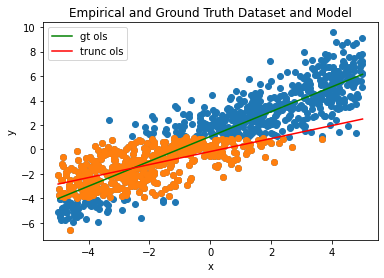

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
# w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
# phi = oracle.Identity()
intervals = [(-8, -6), (-4, 1)]
phi = oracle.KIntervalUnion(intervals)

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(ch.ones(k, d))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([2.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [4]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9922)
beta:  tensor(4.9922)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on the truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([1.1557])
trunc reg noise var:  tensor([1.0000])


Text(0, 0.5, 'y')

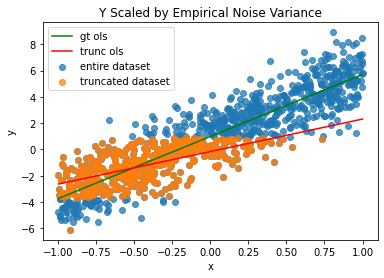

In [5]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_intervals = [(int_[0]/emp_noise_var, int_[1]/emp_noise_var) for int_ in intervals]
emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.5779])
reg noise var:  tensor([1.0810])


Text(0, 0.5, 'y')

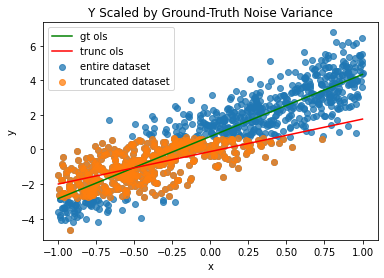

In [6]:
stand_noised, stand_y_trunc = noised / ch.sqrt(noise_var), y_trunc / ch.sqrt(noise_var)
stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [7]:
known_emp_trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var))

/home/gridsan/stefanou/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


Iteration: 0.0 | Score: [0.005334249697625637]
Iteration: 1.0 | Score: [0.023505819961428642]
Iteration: 2.0 | Score: [0.05725365877151489]
Iteration: 3.0 | Score: [0.07684817910194397]
Iteration: 4.0 | Score: [-0.06513912975788116]
Iteration: 5.0 | Score: [0.008842214941978455]


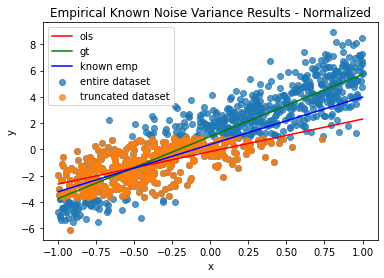

Text(0, 0.5, 'y')

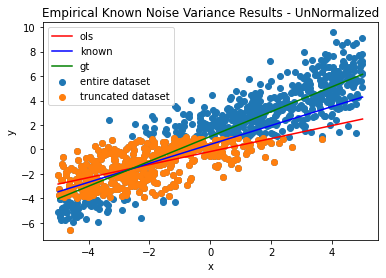

In [8]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [62]:
known_trunc_reg = TruncatedRegression(phi=scaled_kinterval, alpha=alpha, bias=args.bias, unknown=False, val=100, bs=10, n=100, tol=1e-2, steps=2500)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var)

Iteration: 0.0 | Score: [-0.05916885286569595]
Iteration: 1.0 | Score: [0.04893818125128746]
Iteration: 2.0 | Score: [0.04145364463329315]
Iteration: 3.0 | Score: [0.05550083518028259]
Iteration: 4.0 | Score: [0.07267409563064575]
Iteration: 5.0 | Score: [0.06594416499137878]
Iteration: 6.0 | Score: [0.08675671368837357]
Iteration: 7.0 | Score: [0.07263945788145065]
Iteration: 8.0 | Score: [0.057985685765743256]
Iteration: 9.0 | Score: [0.06590069085359573]
Iteration: 10.0 | Score: [0.07685801386833191]
Iteration: 11.0 | Score: [0.07213655859231949]
Iteration: 12.0 | Score: [0.07778497040271759]
Iteration: 13.0 | Score: [0.0670495480298996]
Iteration: 14.0 | Score: [0.06817517429590225]
Iteration: 15.0 | Score: [0.06831635534763336]
Iteration: 16.0 | Score: [0.050778184086084366]
Iteration: 17.0 | Score: [0.07881157845258713]
Iteration: 18.0 | Score: [0.08631207048892975]
Iteration: 19.0 | Score: [0.0783863216638565]
Iteration: 20.0 | Score: [0.06319235265254974]
Iteration: 21.0 | Scor

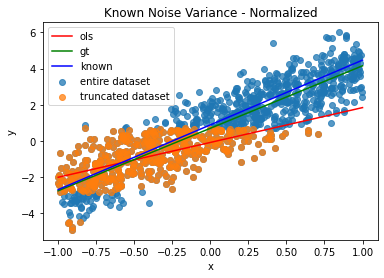

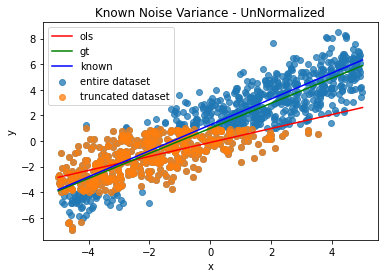

In [63]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [64]:
unknown_trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=True, unknown=True, bs=10, n=100, tol=1e-1, val=50, steps=3000)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
with ch.no_grad():
    unknown_weight_unnorm = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta)
    if args.bias: 
        unknown_bias_unnorm = ((unknown_trunc_reg.bias * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var))

Iteration: 0.0 | Score: [-0.047379814088344574, 0.1375025361776352]
Iteration: 1.0 | Score: [-0.02089824341237545, -0.180572971701622]
Iteration: 2.0 | Score: [0.10863552987575531, 0.06415006518363953]
Iteration: 3.0 | Score: [0.06737342476844788, 0.02363922819495201]


In [39]:
unknown_trunc_reg.weight, gt_emp_stand.coef_

(tensor([[3.0235]], grad_fn=<PermuteBackward>),
 array([[4.193836]], dtype=float32))

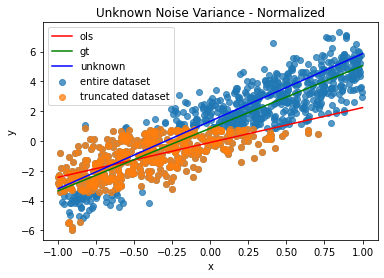

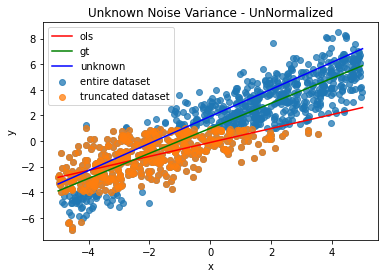

In [65]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [58]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 100)
args.__setattr__('n', 100)


EXP = 'ConstantSampling50Dims100Trials'

In [59]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

In [60]:
samples = [100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500, 750, 1000, 1500, 2000, 2500]


In [61]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 50, 1

# distribution for generating feature vectors
dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
dist = Uniform(-10, 10)
samples = [100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500, 750, 1000, 1500, 2000, 2500]
intervals = [(-20, -5), (-3, 0), (8, 10)]
phi = oracle.KIntervalUnion(intervals)
noise_var = Tensor([10.0])

stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(ch.ones(k, d))
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
    
    # generate data until max number of samples fall within the truncation set
    X, noised = Tensor([]), Tensor([])
    x_trunc, y_trunc = Tensor([]), Tensor([])
    with ch.no_grad():
        while x_trunc.size(0) < samples[-1]: 
            x_ = dist.sample(ch.Size([s, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([s]))
            new_noised = gt(x_) + ch.sqrt(noise_var) * ch.randn(s, 1)
            # add noise to ground-truth pedictions
            # truncate based off of the standardized data
            indices = phi(new_noised).flatten().nonzero(as_tuple=False).flatten()
            y_trunc, x_trunc = ch.cat([y_trunc, new_noised[indices]]), ch.cat([x_trunc, x_[indices]])
            X, noised = ch.cat([X, x_]), ch.cat([noised, new_noised])
            
    # shuffle x_trunc, y_trunc
    rand_perm = ch.randperm(y_trunc.size(0))
    x_trunc_pool, y_trunc_pool = x_trunc[rand_perm], y_trunc[rand_perm]
                
    # alpha is constant across all trials
    alpha = Tensor([y_trunc_pool.size(0) / noised.size(0)])
    print("alpha: ", alpha)
    
    # iterate over samples
    for s in samples: 
        # take s truncated samples
        x_trunc, y_trunc = x_trunc_pool[:s], y_trunc_pool[:s]

        # 10% of truncated data is validation data
        val = int(.1*s)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        emp_stand_intervals = [(int_[0]/math.sqrt(float(emp_noise_var)), int_[1]/math.sqrt(float(emp_noise_var))) for int_ in intervals]
        emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)        
        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': scaled_kinterval, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc)

        with ch.no_grad():
            w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var)
            known_params = ch.cat([w, w0]).flatten()
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(noised.flatten(), X@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params),
                'known_time': total_time, 
            })
        
        # truncated regression with unknown variance
            
        unknown_kwargs = { 
            'phi': emp_scaled_kinterval, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
    
        with ch.no_grad():
            unknown_var = unknown_trunc_reg.variance * emp_noise_var
            w, w0 = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_trunc_reg.intercept * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)))
            unknown_params = ch.cat([w, w0]).flatten()
            
            # known emp results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params),
                'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
                'unknown_time': total_time, 
            })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/ConstantSampling50Dims100Trials/df1ad409-c9e7-4b31-9c84-cfc43efcda0f
alpha:  tensor([0.1823])


/home/gridsan/stefanou/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


Iteration: 0.0 | Score: [-0.4247872233390808]
Iteration: 1.0 | Score: [-0.07755891978740692]
Iteration: 2.0 | Score: [-0.10505513846874237]
Iteration: 3.0 | Score: [-0.05202385038137436]
Iteration: 4.0 | Score: [-0.0847989171743393]
Iteration: 5.0 | Score: [-0.0694899708032608]
Iteration: 6.0 | Score: [-0.14618395268917084]
Iteration: 7.0 | Score: [-0.104986272752285]
Iteration: 8.0 | Score: [-0.09120026230812073]
Iteration: 9.0 | Score: [-0.132280632853508]
Iteration: 10.0 | Score: [-0.051873184740543365]
Iteration: 11.0 | Score: [-0.059376783668994904]
Iteration: 12.0 | Score: [-0.10556605458259583]
Iteration: 13.0 | Score: [-0.07364767789840698]
Iteration: 14.0 | Score: [-0.022047273814678192]
Iteration: 15.0 | Score: [-0.04547493904829025]
Iteration: 16.0 | Score: [-0.11285829544067383]
Iteration: 17.0 | Score: [-0.05471969395875931]
Iteration: 18.0 | Score: [-0.10330133140087128]
Iteration: 19.0 | Score: [-0.07487387955188751]
Iteration: 20.0 | Score: [-0.07819211483001709]
Iterat

Iteration: 10.0 | Score: [-1.7474052906036377, -1.1754076480865479]
Iteration: 11.0 | Score: [-1.5062159299850464, -0.6088988780975342]
Iteration: 12.0 | Score: [-2.9898953437805176, -7.411923885345459]
Iteration: 13.0 | Score: [-1.8259655237197876, -1.5782299041748047]
Iteration: 14.0 | Score: [-1.8526655435562134, -1.9945536851882935]
Iteration: 15.0 | Score: [-2.651456594467163, -9.351752281188965]
Iteration: 16.0 | Score: [2.6499850749969482, 8.830649375915527]
Iteration: 17.0 | Score: [-2.2621383666992188, -3.488835573196411]
Iteration: 18.0 | Score: [-2.692394495010376, -5.782459259033203]
Iteration: 19.0 | Score: [-2.1229233741760254, -2.924147367477417]
Iteration: 20.0 | Score: [-2.1591572761535645, -3.2474172115325928]
Iteration: 21.0 | Score: [-2.603656053543091, -5.763545513153076]
Iteration: 22.0 | Score: [-1.8683172464370728, -2.313886880874634]
Iteration: 23.0 | Score: [-1.8464847803115845, -2.675701379776001]
Iteration: 24.0 | Score: [-2.129197835922241, -4.7076311111450

Iteration: 13.0 | Score: [-0.3122943937778473, -0.01098644733428955]
Iteration: 14.0 | Score: [-0.4051867723464966, -0.368167906999588]
Iteration: 15.0 | Score: [-0.31251993775367737, -0.08891758322715759]
Iteration: 16.0 | Score: [-0.46970006823539734, -0.7508093118667603]
Iteration: 17.0 | Score: [-0.303202360868454, 0.05549785494804382]
Iteration: 18.0 | Score: [-0.358055979013443, -0.1750355064868927]
Iteration: 19.0 | Score: [-0.2970421314239502, 0.15613318979740143]
Iteration: 20.0 | Score: [-0.33314409852027893, -0.027625471353530884]
Iteration: 21.0 | Score: [-0.36749908328056335, -0.2798192799091339]
Iteration: 22.0 | Score: [-0.2955288887023926, 0.06887677311897278]
Iteration: 23.0 | Score: [-0.36760231852531433, -0.3309665024280548]
Iteration: 24.0 | Score: [-0.351442813873291, -0.07797253131866455]
Iteration: 25.0 | Score: [-0.3466756343841553, -0.2140132188796997]
Iteration: 0.0 | Score: [-0.14415936172008514, 1.4466841220855713]
Iteration: 1.0 | Score: [-0.450227856636047

Iteration: 3.0 | Score: [-0.09257115423679352, -0.5350309014320374]
Iteration: 4.0 | Score: [0.022770114243030548, 0.016510814428329468]
Iteration: 5.0 | Score: [-0.09022191911935806, -0.4923461675643921]
Iteration: 6.0 | Score: [0.030515380203723907, -0.043681904673576355]
Iteration: 7.0 | Score: [-0.0759216919541359, -0.35934197902679443]
Iteration: 8.0 | Score: [-0.06445121765136719, -0.25968679785728455]
Iteration: 9.0 | Score: [-0.0806492492556572, -0.5424715280532837]
Iteration: 10.0 | Score: [-0.055359505116939545, -0.1706373691558838]
Iteration: 11.0 | Score: [-0.01339772716164589, -0.24878162145614624]
Iteration: 12.0 | Score: [-0.043022993952035904, -0.3399285674095154]
Iteration: 13.0 | Score: [-0.12983886897563934, -0.4713388979434967]
Iteration: 14.0 | Score: [-0.08634897321462631, -0.38818174600601196]
Iteration: 15.0 | Score: [-0.0739886686205864, -0.33944135904312134]
Iteration: 16.0 | Score: [-0.06681336462497711, -0.1950850784778595]
Iteration: 17.0 | Score: [-0.09742

Iteration: 7.0 | Score: [-0.3993423283100128, -2.115837812423706]
Iteration: 8.0 | Score: [-0.16196662187576294, -1.0849801301956177]
Iteration: 9.0 | Score: [-0.12451514601707458, -0.9327886700630188]
Iteration: 10.0 | Score: [-0.11921171098947525, -0.9405272006988525]
Iteration: 11.0 | Score: [-0.1444336622953415, -1.273215413093567]
Iteration: 12.0 | Score: [-0.23444192111492157, -1.6133625507354736]
Iteration: 13.0 | Score: [0.031815674155950546, -0.6325600743293762]
Iteration: 14.0 | Score: [-0.03978276252746582, -0.5470494031906128]
Iteration: 15.0 | Score: [-0.10061102360486984, -1.0403960943222046]
Iteration: 16.0 | Score: [-0.1223207339644432, -0.9556326866149902]
Iteration: 17.0 | Score: [-0.07663486897945404, -0.8258021473884583]
Iteration: 18.0 | Score: [-0.20301906764507294, -1.3387763500213623]
Iteration: 19.0 | Score: [-0.10351861268281937, -0.7387906312942505]
Iteration: 20.0 | Score: [-0.11367311328649521, -1.0609735250473022]
Iteration: 21.0 | Score: [-0.2192337512969

Iteration: 15.0 | Score: [-1.4715955257415771, -1.9965161085128784]
Iteration: 16.0 | Score: [-0.3068724274635315, 2.085963487625122]
Iteration: 17.0 | Score: [-0.30176305770874023, 2.237041473388672]
Iteration: 18.0 | Score: [2.6748225688934326, 8.336495399475098]
Iteration: 19.0 | Score: [2.6748225688934326, 8.336495399475098]
Iteration: 20.0 | Score: [2.6748228073120117, 8.336495399475098]
Iteration: 21.0 | Score: [2.6748225688934326, 8.336495399475098]
Iteration: 22.0 | Score: [2.6748228073120117, 8.336495399475098]
Iteration: 23.0 | Score: [2.6748223304748535, 8.336495399475098]
Iteration: 24.0 | Score: [2.6748225688934326, 8.336495399475098]
Iteration: 25.0 | Score: [2.6748225688934326, 8.336495399475098]
Iteration: 0.0 | Score: [0.5433047413825989, 1.9622598886489868]
Iteration: 1.0 | Score: [0.2660568058490753, 0.8842732906341553]
Iteration: 2.0 | Score: [0.3597513437271118, 1.1030819416046143]
Iteration: 3.0 | Score: [0.6017743945121765, 2.4289305210113525]
Iteration: 4.0 | Sc

Iteration: 17.0 | Score: [0.2797139585018158, 0.10796087980270386]
Iteration: 18.0 | Score: [0.20872487127780914, 0.006288677453994751]
Iteration: 19.0 | Score: [0.27883055806159973, 0.04285439848899841]
Iteration: 20.0 | Score: [0.20806515216827393, -0.059354573488235474]
Iteration: 21.0 | Score: [0.24105507135391235, -0.03602170944213867]
Iteration: 22.0 | Score: [0.2424136847257614, 0.05606335401535034]
Iteration: 23.0 | Score: [0.24396614730358124, -0.10443714261054993]
Iteration: 24.0 | Score: [0.24047210812568665, 0.08351448178291321]
Iteration: 25.0 | Score: [0.23139448463916779, -0.09176784753799438]
Iteration: 0.0 | Score: [-0.00034484267234802246]
Iteration: 1.0 | Score: [0.0961696058511734]
Iteration: 2.0 | Score: [0.031082693487405777]
Iteration: 3.0 | Score: [0.010845944285392761]
Iteration: 4.0 | Score: [0.08479304611682892]
Iteration: 5.0 | Score: [-0.014209307730197906]
Iteration: 6.0 | Score: [0.08420619368553162]
Iteration: 7.0 | Score: [0.020736373960971832]
Iteratio

Iteration: 9.0 | Score: [0.423801988363266, 1.162834644317627]
Iteration: 10.0 | Score: [0.3464437425136566, 0.8548301458358765]
Iteration: 11.0 | Score: [0.14538216590881348, -0.12246938049793243]
Iteration: 12.0 | Score: [0.18784692883491516, 0.05791434645652771]
Iteration: 13.0 | Score: [0.30039122700691223, 0.4966513514518738]
Iteration: 14.0 | Score: [0.4409128427505493, 1.0502887964248657]
Iteration: 15.0 | Score: [-0.0461258739233017, -0.978915810585022]
Iteration: 16.0 | Score: [0.07460524141788483, -0.32439789175987244]
Iteration: 17.0 | Score: [0.2283751219511032, 0.25634369254112244]
Iteration: 18.0 | Score: [0.32658442854881287, 0.7631208896636963]
Iteration: 19.0 | Score: [0.21210747957229614, 0.2650264501571655]
Iteration: 20.0 | Score: [0.09277380257844925, -0.3963976204395294]
Iteration: 21.0 | Score: [0.24981757998466492, 0.416011244058609]
Iteration: 22.0 | Score: [0.29533955454826355, 0.6582139730453491]
Iteration: 23.0 | Score: [0.28200143575668335, 0.55315345525741

Iteration: 17.0 | Score: [0.36310869455337524, 3.3704161643981934]
Iteration: 18.0 | Score: [0.9042158126831055, 4.787242412567139]
Iteration: 19.0 | Score: [0.4043239951133728, 3.3159124851226807]
Iteration: 20.0 | Score: [0.4967593848705292, 3.234590530395508]
Iteration: 21.0 | Score: [-0.005933614447712898, 1.529208779335022]
Iteration: 22.0 | Score: [3.5716428756713867, 9.617974281311035]
Iteration: 23.0 | Score: [3.5716428756713867, 9.617974281311035]
Iteration: 24.0 | Score: [3.5716428756713867, 9.617974281311035]
Iteration: 25.0 | Score: [3.5716426372528076, 9.617974281311035]
Iteration: 0.0 | Score: [0.01898643746972084, 0.6016626358032227]
Iteration: 1.0 | Score: [-0.9924026131629944, 0.13729670643806458]
Iteration: 2.0 | Score: [3.151665449142456, 9.262019157409668]
Iteration: 3.0 | Score: [-0.033881351351737976, 2.1978585720062256]
Iteration: 4.0 | Score: [0.038783591240644455, 3.000889539718628]
Iteration: 5.0 | Score: [0.31649690866470337, 3.8677003383636475]
Iteration: 6.

Iteration: 5.0 | Score: [0.07706611603498459, 0.2850104570388794]
Iteration: 6.0 | Score: [0.050440989434719086, 0.3197270631790161]
Iteration: 7.0 | Score: [0.1260014921426773, 0.6265124082565308]
Iteration: 8.0 | Score: [0.2841174900531769, 1.3152872323989868]
Iteration: 9.0 | Score: [-0.18848775327205658, -0.7680802345275879]
Iteration: 10.0 | Score: [0.1320524364709854, 0.7348119020462036]
Iteration: 11.0 | Score: [0.12496563047170639, 0.6716706156730652]
Iteration: 12.0 | Score: [-0.02018728479743004, -0.012941870838403702]
Iteration: 13.0 | Score: [0.07874229550361633, 0.333202600479126]
Iteration: 14.0 | Score: [-0.009576083160936832, 0.04850137233734131]
Iteration: 15.0 | Score: [-0.012160521000623703, 0.06552165001630783]
Iteration: 16.0 | Score: [0.1436716765165329, 0.6665368676185608]
Iteration: 17.0 | Score: [0.15049342811107635, 0.6844955682754517]
Iteration: 18.0 | Score: [0.02018146589398384, 0.1587422639131546]
Iteration: 19.0 | Score: [0.09146763384342194, 0.4714039862

Iteration: 21.0 | Score: [0.13119345903396606, 0.5955427885055542]
Iteration: 22.0 | Score: [0.041152484714984894, 0.2550028860569]
Iteration: 23.0 | Score: [-0.0758187547326088, -0.27316227555274963]
Iteration: 24.0 | Score: [-0.06441327184438705, -0.2373461127281189]
Iteration: 25.0 | Score: [-0.08996320515871048, -0.39058229327201843]
Iteration: 26.0 | Score: [0.09818906337022781, 0.3844732642173767]
Iteration: 27.0 | Score: [0.07881177961826324, 0.3689658045768738]
Iteration: 0.0 | Score: [-0.06766708940267563, 0.07309296727180481]
Iteration: 1.0 | Score: [-0.18636851012706757, -1.1496036052703857]
Iteration: 2.0 | Score: [-0.031095929443836212, -0.4807285666465759]
Iteration: 3.0 | Score: [-0.003715944942086935, -0.36722075939178467]
Iteration: 4.0 | Score: [-0.2578482925891876, -1.4166914224624634]
Iteration: 5.0 | Score: [-0.19159603118896484, -1.1297550201416016]
Iteration: 6.0 | Score: [0.2549329996109009, 0.8028583526611328]
Iteration: 7.0 | Score: [-0.23942746222019196, -1.2

Iteration: 13.0 | Score: [-0.4347648024559021, -0.15062417089939117]
Iteration: 14.0 | Score: [-0.19112583994865417, -0.5030366778373718]
Iteration: 15.0 | Score: [-0.5081242322921753, -0.1686277538537979]
Iteration: 16.0 | Score: [-1.4305293560028076, -5.6833648681640625]
Iteration: 17.0 | Score: [-0.29866117238998413, 0.34239286184310913]
Iteration: 18.0 | Score: [-0.9885796904563904, -4.957530498504639]
Iteration: 19.0 | Score: [4.691800117492676, 13.677312850952148]
Iteration: 20.0 | Score: [4.691800117492676, 13.677312850952148]
Iteration: 21.0 | Score: [-0.7394198179244995, -1.325260043144226]
Iteration: 22.0 | Score: [-0.49822115898132324, -0.07120873779058456]
Iteration: 23.0 | Score: [-0.5262315273284912, -0.27697086334228516]
Iteration: 24.0 | Score: [-0.5028015375137329, -0.20731458067893982]
Iteration: 25.0 | Score: [-0.7589760422706604, -1.6862999200820923]
Iteration: 0.0 | Score: [-0.3254440128803253, -2.9700119495391846]
Iteration: 1.0 | Score: [-0.8149104118347168, -5.4

Iteration: 14.0 | Score: [-0.16416417062282562, -0.7392663359642029]
Iteration: 15.0 | Score: [-0.005309569649398327, -0.10163756459951401]
Iteration: 16.0 | Score: [-0.09134498983621597, -0.36636313796043396]
Iteration: 17.0 | Score: [-0.15196262300014496, -0.722465991973877]
Iteration: 18.0 | Score: [-0.06615499407052994, -0.36550357937812805]
Iteration: 19.0 | Score: [-0.1482301950454712, -0.5981831550598145]
Iteration: 20.0 | Score: [-0.1460048258304596, -0.7932665348052979]
Iteration: 21.0 | Score: [-0.10755326598882675, -0.5217631459236145]
Iteration: 22.0 | Score: [-0.04813747480511665, -0.29711684584617615]
Iteration: 23.0 | Score: [-0.1916791945695877, -1.0669888257980347]
Iteration: 24.0 | Score: [-0.08366821706295013, -0.4286886155605316]
Iteration: 25.0 | Score: [-0.08297927677631378, -0.447900652885437]
Iteration: 0.0 | Score: [0.44247859716415405]
Iteration: 1.0 | Score: [0.13750514388084412]
Iteration: 2.0 | Score: [0.13198834657669067]
Iteration: 3.0 | Score: [0.1438992

Iteration: 11.0 | Score: [0.0951981246471405, -0.29282617568969727]
Iteration: 12.0 | Score: [0.35620585083961487, 1.154573678970337]
Iteration: 13.0 | Score: [0.4009383022785187, 1.2011723518371582]
Iteration: 14.0 | Score: [0.19657249748706818, 0.16667062044143677]
Iteration: 15.0 | Score: [0.15044137835502625, 0.046987101435661316]
Iteration: 16.0 | Score: [0.24205896258354187, 0.48611414432525635]
Iteration: 17.0 | Score: [0.24957416951656342, 1.2986172437667847]
Iteration: 18.0 | Score: [0.1609330028295517, 0.40214666724205017]
Iteration: 19.0 | Score: [0.1623205542564392, 0.20068874955177307]
Iteration: 20.0 | Score: [0.20123371481895447, 0.48763588070869446]
Iteration: 21.0 | Score: [0.2593420445919037, 0.807388186454773]
Iteration: 22.0 | Score: [0.21206234395503998, 0.7001464366912842]
Iteration: 23.0 | Score: [0.21549490094184875, 0.2640530467033386]
Iteration: 24.0 | Score: [0.2622423470020294, 0.40290650725364685]
Iteration: 25.0 | Score: [0.2876540422439575, 0.847825944423

Iteration: 18.0 | Score: [-0.197821244597435, -0.6426557898521423]
Iteration: 19.0 | Score: [-0.2323383390903473, -0.7607539892196655]
Iteration: 20.0 | Score: [-0.1730746030807495, -0.570296585559845]
Iteration: 21.0 | Score: [-0.3377540111541748, -1.26193106174469]
Iteration: 22.0 | Score: [-0.16305546462535858, -0.6273532509803772]
Iteration: 23.0 | Score: [-0.3345629870891571, -1.2254892587661743]
Iteration: 24.0 | Score: [-0.1719193309545517, -0.5797105431556702]
Iteration: 25.0 | Score: [-0.23781423270702362, -0.966534435749054]
Iteration: 0.0 | Score: [0.36514726281166077, 0.6342957019805908]
Iteration: 1.0 | Score: [0.5326957702636719, 1.314773440361023]
Iteration: 2.0 | Score: [0.08591406792402267, -1.073072910308838]
Iteration: 3.0 | Score: [0.2160564512014389, -0.5679488182067871]
Iteration: 4.0 | Score: [-0.04541013762354851, -1.7216806411743164]
Iteration: 5.0 | Score: [0.7158874869346619, 2.012190818786621]
Iteration: 6.0 | Score: [0.3146148920059204, 0.44229644536972046]

Iteration: 1.0 | Score: [-0.08594432473182678, -1.449360966682434]
Iteration: 2.0 | Score: [0.3845011591911316, 0.816504716873169]
Iteration: 3.0 | Score: [0.2828655540943146, 0.47576138377189636]
Iteration: 4.0 | Score: [0.29575222730636597, 0.321108341217041]
Iteration: 5.0 | Score: [0.5018477439880371, 1.4936628341674805]
Iteration: 6.0 | Score: [-0.0338025726377964, -1.0827869176864624]
Iteration: 7.0 | Score: [0.17048701643943787, -0.2903682589530945]
Iteration: 8.0 | Score: [0.25558948516845703, 0.27341580390930176]
Iteration: 9.0 | Score: [0.4209798574447632, 1.0135294198989868]
Iteration: 10.0 | Score: [0.4308769404888153, 1.1114469766616821]
Iteration: 11.0 | Score: [0.35380983352661133, 0.6932951211929321]
Iteration: 12.0 | Score: [0.08695425093173981, -0.7483080625534058]
Iteration: 13.0 | Score: [0.28317272663116455, 0.5995864868164062]
Iteration: 14.0 | Score: [0.25826942920684814, 0.32807716727256775]
Iteration: 15.0 | Score: [0.38607048988342285, 0.8028518557548523]
Iter

Iteration: 9.0 | Score: [0.12273538112640381, -0.1145394891500473]
Iteration: 10.0 | Score: [0.10249478369951248, -0.14616909623146057]
Iteration: 11.0 | Score: [0.12849563360214233, 0.014524802565574646]
Iteration: 12.0 | Score: [0.16748154163360596, -0.18222101032733917]
Iteration: 13.0 | Score: [0.01803559809923172, -0.2128836065530777]
Iteration: 14.0 | Score: [0.13022248446941376, 0.07000817358493805]
Iteration: 15.0 | Score: [0.16102097928524017, -0.047294653952121735]
Iteration: 16.0 | Score: [0.09370511770248413, -0.2910524904727936]
Iteration: 17.0 | Score: [0.09291628003120422, 0.006067536771297455]
Iteration: 18.0 | Score: [0.14389091730117798, -0.17593763768672943]
Iteration: 19.0 | Score: [0.13113217055797577, -0.010811716318130493]
Iteration: 20.0 | Score: [0.08959022164344788, -0.16401594877243042]
Iteration: 21.0 | Score: [0.07517112046480179, 0.09909903258085251]
Iteration: 22.0 | Score: [0.09216008335351944, -0.16711169481277466]
Iteration: 23.0 | Score: [0.3472768068

Iteration: 17.0 | Score: [-1.5221691131591797, -2.1912412643432617]
Iteration: 18.0 | Score: [2.778262138366699, 8.183520317077637]
Iteration: 19.0 | Score: [2.7782623767852783, 8.183520317077637]
Iteration: 20.0 | Score: [2.7782623767852783, 8.183520317077637]
Iteration: 21.0 | Score: [-1.6359604597091675, -2.339900493621826]
Iteration: 22.0 | Score: [-1.6664108037948608, -2.5716943740844727]
Iteration: 23.0 | Score: [-1.5593479871749878, -2.2310876846313477]
Iteration: 24.0 | Score: [-1.6366419792175293, -2.694331169128418]
Iteration: 25.0 | Score: [-1.408685564994812, -1.7979063987731934]
Iteration: 0.0 | Score: [0.0031358266714960337, 0.5908152461051941]
Iteration: 1.0 | Score: [-0.18159063160419464, -0.5333893299102783]
Iteration: 2.0 | Score: [-0.11213665455579758, -0.2308197021484375]
Iteration: 3.0 | Score: [-0.3375519812107086, -1.9275493621826172]
Iteration: 4.0 | Score: [0.5160700678825378, 2.2977652549743652]
Iteration: 5.0 | Score: [-0.008474517613649368, 0.138989314436912

Iteration: 17.0 | Score: [0.013207345269620419, 0.21775957942008972]
Iteration: 18.0 | Score: [0.028548212721943855, 0.34420275688171387]
Iteration: 19.0 | Score: [0.0791313648223877, 0.6360471248626709]
Iteration: 20.0 | Score: [0.23055928945541382, 1.1850005388259888]
Iteration: 21.0 | Score: [0.055195972323417664, 0.5592154264450073]
Iteration: 22.0 | Score: [0.08407937735319138, 0.5410420298576355]
Iteration: 23.0 | Score: [-0.007682217750698328, 0.2527018189430237]
Iteration: 24.0 | Score: [0.14976951479911804, 0.9965709447860718]
Iteration: 25.0 | Score: [0.20886138081550598, 1.1174050569534302]
Iteration: 0.0 | Score: [-0.09741158783435822]
Iteration: 1.0 | Score: [-0.04747820645570755]
Iteration: 2.0 | Score: [-0.10232020169496536]
Iteration: 3.0 | Score: [-0.04596353694796562]
Iteration: 4.0 | Score: [-0.12858225405216217]
Iteration: 5.0 | Score: [-0.03965941071510315]
Iteration: 6.0 | Score: [-0.10548771917819977]
Iteration: 7.0 | Score: [-0.07168984413146973]
Iteration: 8.0 

Iteration: 9.0 | Score: [-0.10066208988428116, -0.8206018209457397]
Iteration: 10.0 | Score: [0.07937145233154297, 0.09750556945800781]
Iteration: 11.0 | Score: [0.008814606815576553, -0.39953842759132385]
Iteration: 12.0 | Score: [-0.11935670673847198, -0.8629528284072876]
Iteration: 13.0 | Score: [0.11251384764909744, 0.018938645720481873]
Iteration: 14.0 | Score: [-0.11965000629425049, -1.0459280014038086]
Iteration: 15.0 | Score: [-0.00442309258505702, -0.38122284412384033]
Iteration: 16.0 | Score: [0.011843213811516762, -0.2772213816642761]
Iteration: 17.0 | Score: [0.0607306994497776, -0.3089274764060974]
Iteration: 18.0 | Score: [-0.004432192537933588, -0.5984975099563599]
Iteration: 19.0 | Score: [0.04655436798930168, -0.10152509808540344]
Iteration: 20.0 | Score: [0.038228247314691544, -0.31077849864959717]
Iteration: 21.0 | Score: [-0.11939825117588043, -0.9724563360214233]
Iteration: 22.0 | Score: [0.016984399408102036, -0.5200207233428955]
Iteration: 23.0 | Score: [-0.05884

Iteration: 25.0 | Score: [0.06799812614917755, 0.11564865708351135]
Iteration: 0.0 | Score: [-0.07426539808511734, 0.3263446092605591]
Iteration: 1.0 | Score: [2.1019647121429443, 4.503004550933838]
Iteration: 2.0 | Score: [-0.9725713729858398, 0.19713178277015686]
Iteration: 3.0 | Score: [-1.3345947265625, -1.533031702041626]
Iteration: 4.0 | Score: [-0.8269473314285278, 0.9554006457328796]
Iteration: 5.0 | Score: [-0.7800160050392151, 1.2725878953933716]
Iteration: 6.0 | Score: [-0.414681613445282, 2.28780460357666]
Iteration: 7.0 | Score: [2.8380236625671387, 8.439270973205566]
Iteration: 8.0 | Score: [2.8380239009857178, 8.439270973205566]
Iteration: 9.0 | Score: [-1.4838343858718872, -2.7094740867614746]
Iteration: 10.0 | Score: [-1.5816088914871216, -2.436821937561035]
Iteration: 11.0 | Score: [-0.4509528577327728, 1.4474514722824097]
Iteration: 12.0 | Score: [-0.7907824516296387, 1.1663165092468262]
Iteration: 13.0 | Score: [-1.090430498123169, -0.6200941205024719]
Iteration: 14

Iteration: 21.0 | Score: [-0.08501532673835754, -0.4190913140773773]
Iteration: 22.0 | Score: [-0.15718618035316467, -0.7411691546440125]
Iteration: 23.0 | Score: [-0.015905391424894333, -0.16792118549346924]
Iteration: 24.0 | Score: [-0.09382322430610657, -0.46144431829452515]
Iteration: 25.0 | Score: [-0.07657142728567123, -0.3488890826702118]
Iteration: 26.0 | Score: [0.03222430497407913, 0.06878124177455902]
Iteration: 27.0 | Score: [0.005741980858147144, -0.003784315660595894]
Logging in: /home/gridsan/stefanou/Regression/ConstantSampling50Dims100Trials/5f33407c-a953-498e-9380-97e53cb0f7b1
alpha:  tensor([0.1897])
Iteration: 0.0 | Score: [0.264191210269928]
Iteration: 1.0 | Score: [0.07100486010313034]
Iteration: 2.0 | Score: [0.08511821925640106]
Iteration: 3.0 | Score: [0.008015766739845276]
Iteration: 0.0 | Score: [1.0543391704559326, 5.6733622550964355]
Iteration: 1.0 | Score: [4.310641765594482, 17.00462532043457]
Iteration: 2.0 | Score: [4.310642242431641, 17.00462532043457]

Iteration: 16.0 | Score: [0.009066801518201828, -0.05309265851974487]
Iteration: 17.0 | Score: [-0.492268830537796, -2.1546223163604736]
Iteration: 18.0 | Score: [-0.3962348699569702, -1.7702617645263672]
Iteration: 19.0 | Score: [-0.012704240158200264, -0.1908019781112671]
Iteration: 20.0 | Score: [-0.5473982691764832, -2.4690425395965576]
Iteration: 21.0 | Score: [-0.41027089953422546, -1.9024672508239746]
Iteration: 22.0 | Score: [-0.06461168080568314, -0.37469905614852905]
Iteration: 23.0 | Score: [-0.4888075590133667, -2.251847267150879]
Iteration: 24.0 | Score: [-0.40039584040641785, -1.7578380107879639]
Iteration: 25.0 | Score: [-0.0975298210978508, -0.5957385897636414]
Iteration: 0.0 | Score: [0.5332006216049194, 2.6957385540008545]
Iteration: 1.0 | Score: [0.7120749950408936, 3.8933510780334473]
Iteration: 2.0 | Score: [0.1142411082983017, 0.1905388981103897]
Iteration: 3.0 | Score: [-0.03303416818380356, -0.4497781991958618]
Iteration: 4.0 | Score: [1.178582787513733, 6.74887

Iteration: 23.0 | Score: [0.21348769962787628]
Iteration: 24.0 | Score: [0.16412046551704407]
Iteration: 25.0 | Score: [0.1976543813943863]
Iteration: 0.0 | Score: [0.12454070150852203, 1.2723150253295898]
Iteration: 1.0 | Score: [0.33520662784576416, 2.383659839630127]
Iteration: 2.0 | Score: [0.6607387065887451, 3.9908061027526855]
Iteration: 3.0 | Score: [-0.5400430560112, -2.401601791381836]
Iteration: 4.0 | Score: [0.7745729684829712, 2.005884885787964]
Iteration: 5.0 | Score: [0.34945327043533325, 2.1631922721862793]
Iteration: 6.0 | Score: [0.30777883529663086, 1.951420545578003]
Iteration: 7.0 | Score: [0.05846620723605156, 0.7068248987197876]
Iteration: 8.0 | Score: [-0.5915302634239197, -2.9593019485473633]
Iteration: 9.0 | Score: [0.15812164545059204, 1.1594032049179077]
Iteration: 10.0 | Score: [0.10967113077640533, 0.9450855255126953]
Iteration: 11.0 | Score: [0.08315109461545944, 0.667012631893158]
Iteration: 12.0 | Score: [-0.3838641345500946, -1.7331064939498901]
Iterat

Iteration: 25.0 | Score: [-0.1290309578180313, -0.6010723114013672]
Iteration: 0.0 | Score: [-0.44427430629730225, -0.6837828159332275]
Iteration: 1.0 | Score: [-1.4768283367156982, 1.519261121749878]
Iteration: 2.0 | Score: [-3.083329200744629, -6.350587844848633]
Iteration: 3.0 | Score: [-1.574583888053894, 1.8983044624328613]
Iteration: 4.0 | Score: [-1.6856656074523926, -5.5251264572143555]
Iteration: 5.0 | Score: [-2.4753596782684326, -1.480480670928955]
Iteration: 6.0 | Score: [-1.809133529663086, 1.4644099473953247]
Iteration: 7.0 | Score: [-2.406492233276367, -0.9009973406791687]
Iteration: 8.0 | Score: [-1.2942579984664917, 2.849915027618408]
Iteration: 9.0 | Score: [-3.681610345840454, -7.391761302947998]
Iteration: 10.0 | Score: [-1.6382759809494019, 1.3216726779937744]
Iteration: 11.0 | Score: [1.866369366645813, 8.534897804260254]
Iteration: 12.0 | Score: [-2.0653648376464844, 0.4033806324005127]
Iteration: 13.0 | Score: [-2.9441399574279785, -4.2832183837890625]
Iteration

Iteration: 1.0 | Score: [-0.2717190384864807, -1.2449668645858765]
Iteration: 2.0 | Score: [-0.12773065268993378, -0.5347159504890442]
Iteration: 3.0 | Score: [-0.27795571088790894, -1.1383110284805298]
Iteration: 4.0 | Score: [-0.2782588601112366, -1.2097787857055664]
Iteration: 5.0 | Score: [0.187821626663208, 0.7294411659240723]
Iteration: 6.0 | Score: [-0.3825165629386902, -1.869956135749817]
Iteration: 7.0 | Score: [-0.2348059117794037, -1.3465726375579834]
Iteration: 8.0 | Score: [-7.126225682441145e-05, -0.19853892922401428]
Iteration: 9.0 | Score: [0.03882940486073494, -0.04350770264863968]
Iteration: 10.0 | Score: [-0.07655828446149826, -0.8356971740722656]
Iteration: 11.0 | Score: [-0.1022891253232956, -0.5842759609222412]
Iteration: 12.0 | Score: [-0.08439165353775024, -0.4317854046821594]
Iteration: 13.0 | Score: [-0.16154232621192932, -0.993694543838501]
Iteration: 14.0 | Score: [0.01201090682297945, -0.27497339248657227]
Iteration: 15.0 | Score: [0.0033378477673977613, -0

Iteration: 2.0 | Score: [0.01482359692454338]
Iteration: 3.0 | Score: [0.0012916913256049156]
Iteration: 0.0 | Score: [-0.2414715588092804, 0.8439947366714478]
Iteration: 1.0 | Score: [0.07691389322280884, 1.1293658018112183]
Iteration: 2.0 | Score: [0.0009869864443317056, 1.0639333724975586]
Iteration: 3.0 | Score: [-0.05914156511425972, 0.8535404205322266]
Iteration: 4.0 | Score: [-0.09380688518285751, 1.0290793180465698]
Iteration: 5.0 | Score: [-0.08596032857894897, 0.7947285175323486]
Iteration: 6.0 | Score: [-0.02774357981979847, 1.0503144264221191]
Iteration: 7.0 | Score: [-0.059266071766614914, 0.7329455614089966]
Iteration: 8.0 | Score: [-0.0245631393045187, 1.0319905281066895]
Iteration: 9.0 | Score: [-0.06679133325815201, 1.0665799379348755]
Iteration: 10.0 | Score: [-0.06622222810983658, 1.0249083042144775]
Iteration: 11.0 | Score: [-0.009816013276576996, 0.9382187128067017]
Iteration: 12.0 | Score: [-0.020334402099251747, 0.9526717662811279]
Iteration: 13.0 | Score: [-0.06

Iteration: 25.0 | Score: [0.34012097120285034, 1.5382192134857178]
Iteration: 0.0 | Score: [0.22658005356788635, 0.9346793293952942]
Iteration: 1.0 | Score: [-0.3024967312812805, -1.057234525680542]
Iteration: 2.0 | Score: [0.5253720879554749, 1.7771095037460327]
Iteration: 3.0 | Score: [0.4316200315952301, 1.613369107246399]
Iteration: 4.0 | Score: [0.6747009754180908, 2.5391416549682617]
Iteration: 5.0 | Score: [0.1219993308186531, -0.15582621097564697]
Iteration: 6.0 | Score: [0.48735642433166504, 1.7498867511749268]
Iteration: 7.0 | Score: [0.1835126429796219, 0.2532631754875183]
Iteration: 8.0 | Score: [0.24743571877479553, 0.27796313166618347]
Iteration: 9.0 | Score: [0.2025078684091568, 0.24508458375930786]
Iteration: 10.0 | Score: [0.20715077221393585, 0.3088761568069458]
Iteration: 11.0 | Score: [0.12947571277618408, 0.03328605741262436]
Iteration: 12.0 | Score: [0.49281996488571167, 1.2639247179031372]
Iteration: 13.0 | Score: [0.3363146185874939, 0.6222434639930725]
Iteratio

Iteration: 23.0 | Score: [3.430659294128418, 10.641424179077148]
Iteration: 24.0 | Score: [3.430659294128418, 10.641424179077148]
Iteration: 25.0 | Score: [3.4306588172912598, 10.641424179077148]
Iteration: 0.0 | Score: [-0.09305942803621292, 0.0074107348918914795]
Iteration: 1.0 | Score: [-0.06936235725879669, -0.37535855174064636]
Iteration: 2.0 | Score: [-0.30070918798446655, -1.3713593482971191]
Iteration: 3.0 | Score: [0.15877771377563477, 0.6407960653305054]
Iteration: 4.0 | Score: [-0.2137330323457718, -1.0654284954071045]
Iteration: 5.0 | Score: [0.11971163004636765, 0.21924489736557007]
Iteration: 6.0 | Score: [0.2763839364051819, 1.0223475694656372]
Iteration: 7.0 | Score: [-0.023251593112945557, -0.23615598678588867]
Iteration: 8.0 | Score: [0.010412574745714664, -0.010768413543701172]
Iteration: 9.0 | Score: [-0.16671796143054962, -0.8974409103393555]
Iteration: 10.0 | Score: [-0.05210195481777191, -0.2771395146846771]
Iteration: 11.0 | Score: [-0.10394337028265, -0.6141692

Iteration: 9.0 | Score: [-0.18675072491168976]
Iteration: 10.0 | Score: [-0.22016634047031403]
Iteration: 11.0 | Score: [-0.20935873687267303]
Iteration: 12.0 | Score: [-0.18594954907894135]
Iteration: 13.0 | Score: [-0.17830665409564972]
Iteration: 14.0 | Score: [-0.14753849804401398]
Iteration: 15.0 | Score: [-0.1686527281999588]
Iteration: 16.0 | Score: [-0.18030397593975067]
Iteration: 17.0 | Score: [-0.19289419054985046]
Iteration: 18.0 | Score: [-0.18364529311656952]
Iteration: 19.0 | Score: [-0.20233942568302155]
Iteration: 20.0 | Score: [-0.20651578903198242]
Iteration: 21.0 | Score: [-0.19651912152767181]
Iteration: 22.0 | Score: [-0.20101505517959595]
Iteration: 23.0 | Score: [-0.1629185527563095]
Iteration: 24.0 | Score: [-0.17974026501178741]
Iteration: 25.0 | Score: [-0.20073580741882324]
Iteration: 0.0 | Score: [-0.002242406364530325, 0.32224711775779724]
Iteration: 1.0 | Score: [0.34906113147735596, 1.321103572845459]
Iteration: 2.0 | Score: [-0.320705384016037, -1.79402

Iteration: 21.0 | Score: [0.05609259381890297, 0.1257975995540619]
Iteration: 22.0 | Score: [0.08651194721460342, 0.35351383686065674]
Iteration: 23.0 | Score: [-0.008027357049286366, -0.017105240374803543]
Iteration: 24.0 | Score: [0.017095766961574554, 0.07845011353492737]
Iteration: 25.0 | Score: [0.061670511960983276, 0.42774373292922974]
Iteration: 26.0 | Score: [-0.020958464592695236, -0.11175044625997543]
Iteration: 27.0 | Score: [0.048292938619852066, 0.18925777077674866]
Iteration: 0.0 | Score: [0.044770460575819016, 0.7864911556243896]
Iteration: 1.0 | Score: [0.2740039825439453, 1.2200156450271606]
Iteration: 2.0 | Score: [-0.4095747172832489, -1.5677379369735718]
Iteration: 3.0 | Score: [0.6241012811660767, 2.75022029876709]
Iteration: 4.0 | Score: [-0.6317165493965149, 0.8252308368682861]
Iteration: 5.0 | Score: [3.039586305618286, 8.406852722167969]
Iteration: 6.0 | Score: [3.039586305618286, 8.406852722167969]
Iteration: 7.0 | Score: [0.2518382668495178, 4.02116775512695

Iteration: 13.0 | Score: [-2.0863993167877197, -8.691936492919922]
Iteration: 14.0 | Score: [-0.0958457887172699, -0.7056175470352173]
Iteration: 15.0 | Score: [-1.380434513092041, -8.6104097366333]
Iteration: 16.0 | Score: [-0.7412723302841187, -5.9884209632873535]
Iteration: 17.0 | Score: [-0.43933582305908203, -4.625]
Iteration: 18.0 | Score: [-0.9504313468933105, -7.670651435852051]
Iteration: 19.0 | Score: [-0.43123340606689453, -4.902966022491455]
Iteration: 20.0 | Score: [-0.36150461435317993, -4.267877578735352]
Iteration: 21.0 | Score: [-0.461332231760025, -4.581531524658203]
Iteration: 22.0 | Score: [-0.7683517932891846, -6.3632965087890625]
Iteration: 23.0 | Score: [-0.21424537897109985, -3.2277283668518066]
Iteration: 24.0 | Score: [-0.48765796422958374, -5.213898181915283]
Iteration: 25.0 | Score: [-0.4327085614204407, -5.32513427734375]
Iteration: 0.0 | Score: [1.4414335489273071, 5.709723472595215]
Iteration: 1.0 | Score: [1.6826257705688477, 8.307916641235352]
Iteration

Iteration: 22.0 | Score: [0.00509123457595706, 2.3455965518951416]
Iteration: 23.0 | Score: [-0.005172392353415489, 1.563938021659851]
Iteration: 24.0 | Score: [-0.16636064648628235, 1.495365858078003]
Iteration: 25.0 | Score: [-0.08831065893173218, 2.043497323989868]
Iteration: 0.0 | Score: [1.531038522720337, 5.904438018798828]
Iteration: 1.0 | Score: [1.2112364768981934, 5.065905570983887]
Iteration: 2.0 | Score: [1.7382475137710571, 7.142867088317871]
Iteration: 3.0 | Score: [0.7820698022842407, 3.272264003753662]
Iteration: 4.0 | Score: [0.9290461540222168, 4.043872833251953]
Iteration: 5.0 | Score: [0.9782078862190247, 4.106514930725098]
Iteration: 6.0 | Score: [0.9740098118782043, 4.092214584350586]
Iteration: 7.0 | Score: [0.9238944053649902, 3.891152858734131]
Iteration: 8.0 | Score: [1.043500304222107, 4.313532829284668]
Iteration: 9.0 | Score: [1.058210015296936, 4.283608436584473]
Iteration: 10.0 | Score: [0.9547469615936279, 3.913266897201538]
Iteration: 11.0 | Score: [0.9

Iteration: 24.0 | Score: [-0.44989708065986633, -3.0022456645965576]
Iteration: 25.0 | Score: [-0.3915550112724304, -2.82062029838562]
Iteration: 0.0 | Score: [-0.5327606797218323, -1.4150944948196411]
Iteration: 1.0 | Score: [1.374794363975525, 5.917819976806641]
Iteration: 2.0 | Score: [-0.2812124788761139, 1.9282139539718628]
Iteration: 3.0 | Score: [2.911858081817627, 7.459151268005371]
Iteration: 4.0 | Score: [2.911858081817627, 7.459151268005371]
Iteration: 5.0 | Score: [-0.9498405456542969, -0.5172927975654602]
Iteration: 6.0 | Score: [-0.31899112462997437, 1.7888050079345703]
Iteration: 7.0 | Score: [-1.6888099908828735, -3.46647572517395]
Iteration: 8.0 | Score: [-0.6491641402244568, 0.6152241230010986]
Iteration: 9.0 | Score: [-0.46372053027153015, -0.3613828420639038]
Iteration: 10.0 | Score: [-0.8051304817199707, 0.261658251285553]
Iteration: 11.0 | Score: [-1.4732539653778076, -2.7985329627990723]
Iteration: 12.0 | Score: [-0.4295552372932434, 0.8457851409912109]
Iteration

Iteration: 10.0 | Score: [0.2259884625673294]
Iteration: 11.0 | Score: [0.2177206575870514]
Iteration: 12.0 | Score: [0.21454906463623047]
Iteration: 13.0 | Score: [0.23782309889793396]
Iteration: 14.0 | Score: [0.21078990399837494]
Iteration: 15.0 | Score: [0.2137058824300766]
Iteration: 16.0 | Score: [0.2498694360256195]
Iteration: 17.0 | Score: [0.2521257996559143]
Iteration: 18.0 | Score: [0.17029429972171783]
Iteration: 19.0 | Score: [0.19863064587116241]
Iteration: 20.0 | Score: [0.19424664974212646]
Iteration: 21.0 | Score: [0.2552693486213684]
Iteration: 22.0 | Score: [0.21225804090499878]
Iteration: 23.0 | Score: [0.18976904451847076]
Iteration: 24.0 | Score: [0.21469295024871826]
Iteration: 25.0 | Score: [0.1551191508769989]
Iteration: 0.0 | Score: [-0.0629204511642456, -0.06339138746261597]
Iteration: 1.0 | Score: [-2.6763267517089844, -11.610884666442871]
Iteration: 2.0 | Score: [3.8452212810516357, 10.01506233215332]
Iteration: 3.0 | Score: [3.8452212810516357, 10.01506233

Iteration: 17.0 | Score: [0.14019213616847992, 0.12816782295703888]
Iteration: 18.0 | Score: [0.31086063385009766, 0.599270224571228]
Iteration: 19.0 | Score: [0.2896043360233307, 0.5622182488441467]
Iteration: 20.0 | Score: [0.2712588310241699, 0.45787227153778076]
Iteration: 21.0 | Score: [0.3282204568386078, 0.9500530362129211]
Iteration: 22.0 | Score: [0.24351166188716888, 0.28528082370758057]
Iteration: 23.0 | Score: [0.27139270305633545, 0.521047830581665]
Iteration: 24.0 | Score: [0.33930790424346924, 0.9630239605903625]
Iteration: 25.0 | Score: [0.32484379410743713, 0.6429397463798523]
Iteration: 0.0 | Score: [-0.3440229892730713, -0.50372314453125]
Iteration: 1.0 | Score: [-0.10036366432905197, 0.1287509799003601]
Iteration: 2.0 | Score: [-0.14676187932491302, -0.04068421572446823]
Iteration: 3.0 | Score: [-0.20934852957725525, -0.4242011308670044]
Iteration: 4.0 | Score: [-0.08965637534856796, 0.13988640904426575]
Iteration: 5.0 | Score: [-0.28601667284965515, -0.733804106712

Iteration: 16.0 | Score: [0.08837777376174927, 0.0476205050945282]
Iteration: 17.0 | Score: [0.11954542994499207, 0.040331095457077026]
Iteration: 18.0 | Score: [0.07224813848733902, 0.09512105584144592]
Iteration: 19.0 | Score: [0.11296671628952026, 0.14063695073127747]
Iteration: 20.0 | Score: [0.11276980489492416, 0.21538370847702026]
Iteration: 21.0 | Score: [0.09321160614490509, 0.2305651605129242]
Iteration: 22.0 | Score: [0.11975666135549545, 0.30253106355667114]
Iteration: 23.0 | Score: [0.11755607277154922, 0.2685529291629791]
Iteration: 24.0 | Score: [0.088310606777668, 0.1757558286190033]
Iteration: 25.0 | Score: [0.15019544959068298, 0.33930689096450806]
Iteration: 0.0 | Score: [-0.024844229221343994, 0.6571694612503052]
Iteration: 1.0 | Score: [0.08263109624385834, 0.6677289009094238]
Iteration: 2.0 | Score: [0.1462542563676834, 0.8029376268386841]
Iteration: 3.0 | Score: [0.05048788711428642, 0.5683026909828186]
Iteration: 4.0 | Score: [0.020871605724096298, 0.33454322814

Iteration: 17.0 | Score: [-0.013673519715666771, -0.15584449470043182]
Iteration: 18.0 | Score: [-0.26528558135032654, -1.4824638366699219]
Iteration: 19.0 | Score: [-0.2747584581375122, -1.3459049463272095]
Iteration: 20.0 | Score: [-0.1366962343454361, -0.762848436832428]
Iteration: 21.0 | Score: [-0.15091919898986816, -0.7485808730125427]
Iteration: 22.0 | Score: [-0.0748596116900444, -0.39479541778564453]
Iteration: 23.0 | Score: [-0.007351612206548452, -0.13765324652194977]
Iteration: 24.0 | Score: [-0.12393976747989655, -0.7068723440170288]
Iteration: 25.0 | Score: [-0.2074376493692398, -0.9215542674064636]
Iteration: 0.0 | Score: [-0.10456757247447968]
Iteration: 1.0 | Score: [-0.061137158423662186]
Iteration: 2.0 | Score: [-0.06141526624560356]
Iteration: 3.0 | Score: [-0.07066351920366287]
Iteration: 4.0 | Score: [-0.049321383237838745]
Iteration: 5.0 | Score: [-0.1382192224264145]
Iteration: 6.0 | Score: [-0.06965000927448273]
Iteration: 7.0 | Score: [-0.1053871363401413]
Ite

Iteration: 11.0 | Score: [-0.08975716680288315, -0.3676784634590149]
Iteration: 12.0 | Score: [-0.2443312704563141, -1.047111988067627]
Iteration: 13.0 | Score: [-0.19027480483055115, -0.7130692005157471]
Iteration: 14.0 | Score: [-0.23738747835159302, -1.0999300479888916]
Iteration: 15.0 | Score: [0.03376629576086998, 0.32464489340782166]
Iteration: 16.0 | Score: [0.018909597769379616, -0.05782867968082428]
Iteration: 17.0 | Score: [0.086850605905056, 0.44137248396873474]
Iteration: 18.0 | Score: [-0.1551358848810196, -0.9241094589233398]
Iteration: 19.0 | Score: [-0.07799448072910309, -0.3997684717178345]
Iteration: 20.0 | Score: [0.033454835414886475, 0.0638425350189209]
Iteration: 21.0 | Score: [-0.08085104078054428, -0.4109947979450226]
Iteration: 22.0 | Score: [-0.05204290524125099, -0.3501145839691162]
Iteration: 23.0 | Score: [-0.2619435489177704, -1.1608322858810425]
Iteration: 24.0 | Score: [-0.003142826957628131, 0.0176517516374588]
Iteration: 25.0 | Score: [-0.0609575137495

Iteration: 1.0 | Score: [-0.1578172743320465]
Iteration: 2.0 | Score: [-0.12356751412153244]
Iteration: 3.0 | Score: [-0.04855802655220032]
Iteration: 4.0 | Score: [-0.0658569484949112]
Iteration: 5.0 | Score: [-0.12865296006202698]
Iteration: 6.0 | Score: [-0.19672121107578278]
Iteration: 7.0 | Score: [-0.18734388053417206]
Iteration: 8.0 | Score: [-0.17511621117591858]
Iteration: 9.0 | Score: [-0.1706012487411499]
Iteration: 10.0 | Score: [-0.1616305559873581]
Iteration: 11.0 | Score: [-0.1543053239583969]
Iteration: 12.0 | Score: [-0.10255700349807739]
Iteration: 13.0 | Score: [-0.12312442064285278]
Iteration: 14.0 | Score: [-0.11582929641008377]
Iteration: 15.0 | Score: [-0.18469838798046112]
Iteration: 16.0 | Score: [-0.15839682519435883]
Iteration: 17.0 | Score: [-0.17610187828540802]
Iteration: 18.0 | Score: [-0.15630854666233063]
Iteration: 19.0 | Score: [-0.16164976358413696]
Iteration: 20.0 | Score: [-0.15100613236427307]
Iteration: 21.0 | Score: [-0.14252008497714996]
Iterat

Iteration: 12.0 | Score: [0.1023361086845398]
Iteration: 13.0 | Score: [0.045187562704086304]
Iteration: 14.0 | Score: [0.09758089482784271]
Iteration: 15.0 | Score: [0.0867329090833664]
Iteration: 16.0 | Score: [0.07208278030157089]
Iteration: 17.0 | Score: [0.08979378640651703]
Iteration: 18.0 | Score: [0.029539620503783226]
Iteration: 19.0 | Score: [0.0768478512763977]
Iteration: 20.0 | Score: [0.05302856117486954]
Iteration: 21.0 | Score: [0.0753588080406189]
Iteration: 22.0 | Score: [0.06382965296506882]
Iteration: 23.0 | Score: [0.07635340839624405]
Iteration: 24.0 | Score: [0.10092152655124664]
Iteration: 25.0 | Score: [0.05660071223974228]
Iteration: 0.0 | Score: [0.030874481424689293, 0.7877515554428101]
Iteration: 1.0 | Score: [-0.20677314698696136, -0.606920063495636]
Iteration: 2.0 | Score: [0.09066537022590637, 0.6638602614402771]
Iteration: 3.0 | Score: [0.17343519628047943, 0.9985891580581665]
Iteration: 4.0 | Score: [-0.09092745929956436, -0.11358200758695602]
Iteration

Iteration: 5.0 | Score: [-0.14835280179977417, -0.7521659135818481]
Iteration: 6.0 | Score: [0.27887967228889465, 1.1145039796829224]
Iteration: 7.0 | Score: [-0.19499041140079498, -0.9342935085296631]
Iteration: 8.0 | Score: [-0.0703001543879509, -0.37615299224853516]
Iteration: 9.0 | Score: [-0.15892788767814636, -0.7998325228691101]
Iteration: 10.0 | Score: [0.08292737603187561, 0.3292197585105896]
Iteration: 11.0 | Score: [0.21420472860336304, 0.8505304455757141]
Iteration: 12.0 | Score: [-0.20197266340255737, -0.8586046695709229]
Iteration: 13.0 | Score: [-0.03914054483175278, -0.22137407958507538]
Iteration: 14.0 | Score: [-0.06730081140995026, -0.3750764727592468]
Iteration: 15.0 | Score: [0.1221482902765274, 0.43810099363327026]
Iteration: 16.0 | Score: [-0.12464336305856705, -0.5860021114349365]
Iteration: 17.0 | Score: [0.010724627412855625, -0.027256399393081665]
Iteration: 18.0 | Score: [-0.09949935227632523, -0.5084025859832764]
Iteration: 19.0 | Score: [0.0076056555844843

Iteration: 2.0 | Score: [4.269651412963867, 11.024914741516113]
Iteration: 3.0 | Score: [4.269651889801025, 11.024914741516113]
Iteration: 4.0 | Score: [4.269652366638184, 11.024914741516113]
Iteration: 5.0 | Score: [-0.3535245656967163, 0.044490277767181396]
Iteration: 6.0 | Score: [-0.9200538396835327, -2.9120829105377197]
Iteration: 7.0 | Score: [4.269652366638184, 11.024914741516113]
Iteration: 8.0 | Score: [4.269652366638184, 11.024914741516113]
Iteration: 9.0 | Score: [4.269651889801025, 11.024914741516113]
Iteration: 10.0 | Score: [0.17125524580478668, 2.1237502098083496]
Iteration: 11.0 | Score: [4.269651889801025, 11.024914741516113]
Iteration: 12.0 | Score: [4.269652366638184, 11.024914741516113]
Iteration: 13.0 | Score: [-0.0492389090359211, 1.3062160015106201]
Iteration: 14.0 | Score: [-0.968376636505127, -4.404820442199707]
Iteration: 15.0 | Score: [-0.7764052748680115, -1.9955329895019531]
Iteration: 16.0 | Score: [-0.1781969517469406, 0.6840253472328186]
Iteration: 17.0 

Iteration: 5.0 | Score: [4.006400108337402, 10.928300857543945]
Iteration: 6.0 | Score: [-0.07870455086231232, 1.8894882202148438]
Iteration: 7.0 | Score: [4.0064005851745605, 10.928300857543945]
Iteration: 8.0 | Score: [4.006400108337402, 10.928300857543945]
Iteration: 9.0 | Score: [4.0064005851745605, 10.928300857543945]
Iteration: 10.0 | Score: [-0.5469326972961426, 0.11434531211853027]
Iteration: 11.0 | Score: [4.006400108337402, 10.928300857543945]
Iteration: 12.0 | Score: [-0.7660309076309204, -0.9416788816452026]
Iteration: 13.0 | Score: [0.20884397625923157, 2.4030864238739014]
Iteration: 14.0 | Score: [-0.11455966532230377, 2.0946831703186035]
Iteration: 15.0 | Score: [-1.633508324623108, -5.825336456298828]
Iteration: 16.0 | Score: [4.006400108337402, 10.928300857543945]
Iteration: 17.0 | Score: [4.006400108337402, 10.928300857543945]
Iteration: 18.0 | Score: [-0.29726606607437134, 1.398967981338501]
Iteration: 19.0 | Score: [-0.5112866163253784, 0.28193360567092896]
Iteratio

Iteration: 5.0 | Score: [-0.4452911615371704, -1.6961835622787476]
Iteration: 6.0 | Score: [-0.24141189455986023, -0.061858948320150375]
Iteration: 7.0 | Score: [-0.23846760392189026, -0.5703107714653015]
Iteration: 8.0 | Score: [-0.30162203311920166, -0.6166061162948608]
Iteration: 9.0 | Score: [-0.32939067482948303, -1.2353365421295166]
Iteration: 10.0 | Score: [-0.2466018795967102, -0.10983717441558838]
Iteration: 11.0 | Score: [-0.2940328121185303, -0.7246541976928711]
Iteration: 12.0 | Score: [-0.4110478162765503, -1.0512714385986328]
Iteration: 13.0 | Score: [-0.4264408051967621, -1.0910722017288208]
Iteration: 14.0 | Score: [-0.246441051363945, -0.3479897379875183]
Iteration: 15.0 | Score: [-0.3374406397342682, -0.6513468623161316]
Iteration: 16.0 | Score: [-0.3967820107936859, -1.2332890033721924]
Iteration: 17.0 | Score: [-0.4731907844543457, -1.480881690979004]
Iteration: 18.0 | Score: [-0.3772522509098053, -0.43779149651527405]
Iteration: 19.0 | Score: [-0.3359408378601074, 

Iteration: 13.0 | Score: [-0.006444825790822506, -2.3559961318969727]
Iteration: 14.0 | Score: [0.07663594186306, -1.7716091871261597]
Iteration: 15.0 | Score: [-0.03771461918950081, -2.17803692817688]
Iteration: 16.0 | Score: [-0.02125849574804306, -2.411142349243164]
Iteration: 17.0 | Score: [-0.09384982287883759, -2.7455456256866455]
Iteration: 18.0 | Score: [0.015716608613729477, -2.1168477535247803]
Iteration: 19.0 | Score: [0.06183263286948204, -1.7390966415405273]
Iteration: 20.0 | Score: [-0.021859919652342796, -2.0187065601348877]
Iteration: 21.0 | Score: [0.06775923818349838, -1.8111488819122314]
Iteration: 22.0 | Score: [0.06234932690858841, -1.9734712839126587]
Iteration: 23.0 | Score: [0.021371841430664062, -1.9707751274108887]
Iteration: 24.0 | Score: [-0.0495716892182827, -2.190587282180786]
Iteration: 25.0 | Score: [-0.03154219686985016, -2.161158323287964]
Iteration: 0.0 | Score: [-0.5416923761367798]
Iteration: 1.0 | Score: [-0.4185589551925659]
Iteration: 2.0 | Score

Iteration: 13.0 | Score: [-0.23484554886817932]
Iteration: 14.0 | Score: [-0.21345311403274536]
Iteration: 15.0 | Score: [-0.27309781312942505]
Iteration: 16.0 | Score: [-0.21650031208992004]
Iteration: 17.0 | Score: [-0.25432997941970825]
Iteration: 18.0 | Score: [-0.2153652012348175]
Iteration: 19.0 | Score: [-0.21527376770973206]
Iteration: 20.0 | Score: [-0.23775038123130798]
Iteration: 21.0 | Score: [-0.26514574885368347]
Iteration: 22.0 | Score: [-0.20533140003681183]
Iteration: 23.0 | Score: [-0.23562180995941162]
Iteration: 24.0 | Score: [-0.22466173768043518]
Iteration: 25.0 | Score: [-0.2697989344596863]
Iteration: 0.0 | Score: [-0.4023899435997009, -1.064081072807312]
Iteration: 1.0 | Score: [-0.5521796345710754, -2.680673599243164]
Iteration: 2.0 | Score: [2.2195053100585938, 6.617571830749512]
Iteration: 3.0 | Score: [-2.34945011138916, -4.647794246673584]
Iteration: 4.0 | Score: [2.2195053100585938, 6.617571830749512]
Iteration: 5.0 | Score: [2.2195053100585938, 6.6175718

Iteration: 19.0 | Score: [4.510532379150391, 12.743619918823242]
Iteration: 20.0 | Score: [4.510532379150391, 12.743619918823242]
Iteration: 21.0 | Score: [4.510532855987549, 12.743619918823242]
Iteration: 22.0 | Score: [4.510532379150391, 12.743619918823242]
Iteration: 23.0 | Score: [4.510532379150391, 12.743619918823242]
Iteration: 24.0 | Score: [4.510532379150391, 12.743619918823242]
Iteration: 25.0 | Score: [4.510532379150391, 12.743619918823242]
Iteration: 0.0 | Score: [0.22937530279159546, 0.4962867498397827]
Iteration: 1.0 | Score: [0.6750568747520447, 2.0942306518554688]
Iteration: 2.0 | Score: [3.1640894412994385, 6.762270927429199]
Iteration: 3.0 | Score: [0.13653446733951569, 1.7198612689971924]
Iteration: 4.0 | Score: [-0.39646100997924805, -0.14842143654823303]
Iteration: 5.0 | Score: [3.1640894412994385, 6.762270927429199]
Iteration: 6.0 | Score: [-0.3800623416900635, -0.13669216632843018]
Iteration: 7.0 | Score: [-0.446790486574173, -0.3673308193683624]
Iteration: 8.0 | 

Iteration: 22.0 | Score: [0.1070360317826271, 0.4438828229904175]
Iteration: 23.0 | Score: [0.23278596997261047, 0.8959822654724121]
Iteration: 24.0 | Score: [0.24211309850215912, 0.9433040618896484]
Iteration: 25.0 | Score: [0.21074041724205017, 0.761337399482727]
Iteration: 0.0 | Score: [-0.12592241168022156, 0.36495932936668396]
Iteration: 1.0 | Score: [-0.03440890833735466, -0.5161932706832886]
Iteration: 2.0 | Score: [0.20190416276454926, 0.5522724986076355]
Iteration: 3.0 | Score: [0.14185075461864471, 0.4967018961906433]
Iteration: 4.0 | Score: [0.47211503982543945, 2.0673575401306152]
Iteration: 5.0 | Score: [-0.0778290405869484, -0.7234982252120972]
Iteration: 6.0 | Score: [0.08715441077947617, 0.13092142343521118]
Iteration: 7.0 | Score: [-0.10389657318592072, -0.5209495425224304]
Iteration: 8.0 | Score: [-0.31814515590667725, -2.142106533050537]
Iteration: 9.0 | Score: [-0.14410032331943512, -1.0093433856964111]
Iteration: 10.0 | Score: [0.04249551147222519, -0.2823165357112

Iteration: 15.0 | Score: [-0.16733738780021667]
Iteration: 16.0 | Score: [-0.18493910133838654]
Iteration: 17.0 | Score: [-0.16665245592594147]
Iteration: 18.0 | Score: [-0.16557031869888306]
Iteration: 19.0 | Score: [-0.13625909388065338]
Iteration: 20.0 | Score: [-0.16693398356437683]
Iteration: 21.0 | Score: [-0.17088432610034943]
Iteration: 22.0 | Score: [-0.14619024097919464]
Iteration: 23.0 | Score: [-0.15680822730064392]
Iteration: 24.0 | Score: [-0.16368180513381958]
Iteration: 25.0 | Score: [-0.16311927139759064]
Iteration: 0.0 | Score: [-0.013793651014566422, 0.8290623426437378]
Iteration: 1.0 | Score: [0.10782887041568756, 0.8468849658966064]
Iteration: 2.0 | Score: [0.047629084438085556, 0.45044201612472534]
Iteration: 3.0 | Score: [-0.05272403731942177, -0.12443140894174576]
Iteration: 4.0 | Score: [0.14249582588672638, 0.8562228679656982]
Iteration: 5.0 | Score: [0.3385619521141052, 1.6666620969772339]
Iteration: 6.0 | Score: [-0.0018122392939403653, 0.06181168556213379]


Iteration: 19.0 | Score: [0.11969272047281265, 0.4955357611179352]
Iteration: 20.0 | Score: [0.023107381537556648, 0.05731857195496559]
Iteration: 21.0 | Score: [0.04611719027161598, 0.20766055583953857]
Iteration: 22.0 | Score: [0.006304189097136259, 0.027249742299318314]
Iteration: 23.0 | Score: [0.14150409400463104, 0.4503178894519806]
Iteration: 24.0 | Score: [0.1603856384754181, 0.6129376292228699]
Iteration: 25.0 | Score: [0.020973563194274902, 0.06506417691707611]
Iteration: 0.0 | Score: [0.0759163349866867]
Iteration: 1.0 | Score: [0.14412681758403778]
Iteration: 2.0 | Score: [0.15848222374916077]
Iteration: 3.0 | Score: [0.018237657845020294]
Iteration: 4.0 | Score: [0.09000636637210846]
Iteration: 5.0 | Score: [0.06083718687295914]
Iteration: 6.0 | Score: [0.09648559242486954]
Iteration: 7.0 | Score: [0.06473839282989502]
Iteration: 8.0 | Score: [0.12627112865447998]
Iteration: 9.0 | Score: [0.09318802505731583]
Iteration: 10.0 | Score: [0.11311769485473633]
Iteration: 11.0 |

Iteration: 13.0 | Score: [0.07888983935117722, 0.0915222316980362]
Iteration: 14.0 | Score: [-0.06776972115039825, -0.7383868098258972]
Iteration: 15.0 | Score: [0.080424964427948, -0.055204711854457855]
Iteration: 16.0 | Score: [0.15796786546707153, 0.43773284554481506]
Iteration: 17.0 | Score: [-0.05177636817097664, -0.4828769564628601]
Iteration: 18.0 | Score: [0.061265308409929276, -0.024714097380638123]
Iteration: 19.0 | Score: [0.09654916822910309, 0.2165684998035431]
Iteration: 20.0 | Score: [0.08344637602567673, -0.05237024277448654]
Iteration: 21.0 | Score: [0.017034657299518585, -0.27732110023498535]
Iteration: 22.0 | Score: [0.011095559224486351, -0.2482622265815735]
Iteration: 23.0 | Score: [-0.07334373146295547, -0.6244202256202698]
Iteration: 24.0 | Score: [0.039793211966753006, -0.215368390083313]
Iteration: 25.0 | Score: [0.08306834101676941, 0.0736597403883934]
Iteration: 0.0 | Score: [-0.14745301008224487]
Iteration: 1.0 | Score: [-0.16040270030498505]
Iteration: 2.0 

Iteration: 21.0 | Score: [-0.9892576336860657, -6.296901702880859]
Iteration: 22.0 | Score: [-0.40952402353286743, 7.331716537475586]
Iteration: 23.0 | Score: [-0.32437118887901306, 7.8295392990112305]
Iteration: 24.0 | Score: [-0.6339070796966553, 5.844640254974365]
Iteration: 25.0 | Score: [-0.4575994312763214, 6.924372673034668]
Iteration: 0.0 | Score: [0.5813241004943848, 5.0381693840026855]
Iteration: 1.0 | Score: [4.289334297180176, 17.569438934326172]
Iteration: 2.0 | Score: [4.289334297180176, 17.569438934326172]
Iteration: 3.0 | Score: [4.289334297180176, 17.569438934326172]
Iteration: 4.0 | Score: [4.289334297180176, 17.569438934326172]
Iteration: 5.0 | Score: [4.289334297180176, 17.569438934326172]
Iteration: 6.0 | Score: [4.289334297180176, 17.569438934326172]
Iteration: 7.0 | Score: [4.289334297180176, 17.569438934326172]
Iteration: 8.0 | Score: [4.289333820343018, 17.569438934326172]
Iteration: 9.0 | Score: [4.289334297180176, 17.569438934326172]
Iteration: 10.0 | Score: 

Iteration: 23.0 | Score: [-1.6755859851837158, -3.071944236755371]
Iteration: 24.0 | Score: [-1.9343054294586182, -4.483157634735107]
Iteration: 25.0 | Score: [-1.486616611480713, -2.0689926147460938]
Iteration: 0.0 | Score: [0.4853786826133728, 1.2039414644241333]
Iteration: 1.0 | Score: [-1.650293231010437, -8.302577018737793]
Iteration: 2.0 | Score: [-2.7180845737457275, -11.824849128723145]
Iteration: 3.0 | Score: [4.130613327026367, 17.422574996948242]
Iteration: 4.0 | Score: [4.861830711364746, 17.7833309173584]
Iteration: 5.0 | Score: [-2.408292770385742, -11.621675491333008]
Iteration: 6.0 | Score: [2.36708664894104, 14.12320327758789]
Iteration: 7.0 | Score: [-0.8992316126823425, 0.14976710081100464]
Iteration: 8.0 | Score: [-2.054931163787842, -11.308618545532227]
Iteration: 9.0 | Score: [4.861830711364746, 17.7833309173584]
Iteration: 10.0 | Score: [-1.193452000617981, -2.315448760986328]
Iteration: 11.0 | Score: [-1.6405826807022095, -8.135278701782227]
Iteration: 12.0 | Sc

Iteration: 1.0 | Score: [0.2010854184627533]
Iteration: 2.0 | Score: [0.15818768739700317]
Iteration: 3.0 | Score: [0.15082095563411713]
Iteration: 4.0 | Score: [0.16382575035095215]
Iteration: 5.0 | Score: [0.16630974411964417]
Iteration: 6.0 | Score: [0.17119456827640533]
Iteration: 7.0 | Score: [0.1867290884256363]
Iteration: 8.0 | Score: [0.19277521967887878]
Iteration: 9.0 | Score: [0.1540011614561081]
Iteration: 10.0 | Score: [0.1932832896709442]
Iteration: 11.0 | Score: [0.21324802935123444]
Iteration: 12.0 | Score: [0.17118003964424133]
Iteration: 13.0 | Score: [0.16135095059871674]
Iteration: 14.0 | Score: [0.18068073689937592]
Iteration: 15.0 | Score: [0.1652030646800995]
Iteration: 16.0 | Score: [0.16041430830955505]
Iteration: 17.0 | Score: [0.22580885887145996]
Iteration: 18.0 | Score: [0.18257549405097961]
Iteration: 19.0 | Score: [0.1489669382572174]
Iteration: 20.0 | Score: [0.16836486756801605]
Iteration: 21.0 | Score: [0.19539102911949158]
Iteration: 22.0 | Score: [0.

Iteration: 22.0 | Score: [0.11849653720855713]
Iteration: 23.0 | Score: [0.08069862425327301]
Iteration: 24.0 | Score: [0.11108290404081345]
Iteration: 25.0 | Score: [0.08039864152669907]
Iteration: 0.0 | Score: [0.3863994777202606, 1.708005428314209]
Iteration: 1.0 | Score: [0.315477579832077, 1.062267780303955]
Iteration: 2.0 | Score: [3.7981679439544678, 10.568174362182617]
Iteration: 3.0 | Score: [3.7981674671173096, 10.568174362182617]
Iteration: 4.0 | Score: [0.8824109435081482, 5.809864044189453]
Iteration: 5.0 | Score: [3.7981679439544678, 10.568174362182617]
Iteration: 6.0 | Score: [3.7981677055358887, 10.568174362182617]
Iteration: 7.0 | Score: [-0.08580789715051651, 2.4394054412841797]
Iteration: 8.0 | Score: [-1.4759325981140137, -6.9428229331970215]
Iteration: 9.0 | Score: [3.7981679439544678, 10.568174362182617]
Iteration: 10.0 | Score: [-0.33573976159095764, 0.5556482076644897]
Iteration: 11.0 | Score: [3.7981677055358887, 10.568174362182617]
Iteration: 12.0 | Score: [0.

Iteration: 5.0 | Score: [0.02988063357770443, -0.18165427446365356]
Iteration: 6.0 | Score: [-0.06600800156593323, -0.5395815372467041]
Iteration: 7.0 | Score: [0.07741707563400269, -0.03524911403656006]
Iteration: 8.0 | Score: [0.009359382092952728, -0.2346188724040985]
Iteration: 9.0 | Score: [0.013650275766849518, -0.26702433824539185]
Iteration: 10.0 | Score: [0.019008414819836617, -0.20021241903305054]
Iteration: 11.0 | Score: [0.01966390572488308, -0.2554393410682678]
Iteration: 12.0 | Score: [0.0678398609161377, 0.04026512801647186]
Iteration: 13.0 | Score: [-0.04196061193943024, 0.28112033009529114]
Iteration: 14.0 | Score: [0.07394672185182571, 0.010908842086791992]
Iteration: 15.0 | Score: [0.08076213300228119, 0.015833020210266113]
Iteration: 16.0 | Score: [0.09864631295204163, 0.12692636251449585]
Iteration: 17.0 | Score: [0.0570124126970768, -0.1627245992422104]
Iteration: 18.0 | Score: [0.06847912073135376, -0.010664165019989014]
Iteration: 19.0 | Score: [0.08568416535854

Iteration: 8.0 | Score: [0.1673147827386856]
Iteration: 9.0 | Score: [0.09224236756563187]
Iteration: 10.0 | Score: [0.10183968394994736]
Iteration: 11.0 | Score: [0.12367257475852966]
Iteration: 12.0 | Score: [0.1494617462158203]
Iteration: 13.0 | Score: [0.149429053068161]
Iteration: 14.0 | Score: [0.10793250799179077]
Iteration: 15.0 | Score: [0.11028057336807251]
Iteration: 16.0 | Score: [0.11775897443294525]
Iteration: 17.0 | Score: [0.15605729818344116]
Iteration: 18.0 | Score: [0.11776542663574219]
Iteration: 19.0 | Score: [0.12709194421768188]
Iteration: 20.0 | Score: [0.13966265320777893]
Iteration: 21.0 | Score: [0.10058574378490448]
Iteration: 22.0 | Score: [0.1499832570552826]
Iteration: 23.0 | Score: [0.14780490100383759]
Iteration: 24.0 | Score: [0.09655442088842392]
Iteration: 25.0 | Score: [0.1477978229522705]
Iteration: 0.0 | Score: [-0.38427475094795227, -0.5876601934432983]
Iteration: 1.0 | Score: [-0.2376946657896042, -0.6646568775177002]
Iteration: 2.0 | Score: [-0

Iteration: 15.0 | Score: [-0.09484568983316422, -0.31245774030685425]
Iteration: 16.0 | Score: [-0.09196287393569946, -0.09834953397512436]
Iteration: 17.0 | Score: [-0.13606007397174835, -0.5658315420150757]
Iteration: 18.0 | Score: [-0.09436865895986557, 0.03335358202457428]
Iteration: 19.0 | Score: [-0.0349847637116909, 0.08827809989452362]
Iteration: 20.0 | Score: [-0.17164406180381775, -0.5262352228164673]
Iteration: 21.0 | Score: [-0.17816291749477386, -0.8514830470085144]
Iteration: 22.0 | Score: [-0.12292324006557465, -0.30686867237091064]
Iteration: 23.0 | Score: [-0.020778317004442215, 0.10327499359846115]
Iteration: 24.0 | Score: [-0.012985196895897388, -0.06039193272590637]
Iteration: 25.0 | Score: [-0.07150286436080933, -0.016920968890190125]
Iteration: 0.0 | Score: [-0.15122228860855103]
Iteration: 1.0 | Score: [-0.02948777750134468]
Iteration: 2.0 | Score: [-0.1717478483915329]
Iteration: 3.0 | Score: [-0.0588073655962944]
Iteration: 4.0 | Score: [-0.1308060884475708]
It

Iteration: 21.0 | Score: [0.06313647329807281]
Iteration: 22.0 | Score: [0.05978534370660782]
Iteration: 23.0 | Score: [0.0442374125123024]
Iteration: 24.0 | Score: [0.050236135721206665]
Iteration: 25.0 | Score: [0.065524160861969]
Iteration: 0.0 | Score: [0.08159351348876953, 1.189505696296692]
Iteration: 1.0 | Score: [0.24023430049419403, 1.2047293186187744]
Iteration: 2.0 | Score: [-0.23446011543273926, -1.241729736328125]
Iteration: 3.0 | Score: [0.4088608920574188, 2.0288796424865723]
Iteration: 4.0 | Score: [0.1921747326850891, 1.0051803588867188]
Iteration: 5.0 | Score: [-0.25860467553138733, -0.9880104064941406]
Iteration: 6.0 | Score: [-0.08887671679258347, -0.2987547516822815]
Iteration: 7.0 | Score: [0.1552775502204895, 0.8994369506835938]
Iteration: 8.0 | Score: [0.015603424049913883, 0.21423546969890594]
Iteration: 9.0 | Score: [0.2514597475528717, 1.3231550455093384]
Iteration: 10.0 | Score: [0.040916021913290024, 0.42809435725212097]
Iteration: 11.0 | Score: [-0.0583414

Iteration: 25.0 | Score: [3.1797657012939453, 8.43291187286377]
Iteration: 0.0 | Score: [-0.01813763566315174, 0.4656279981136322]
Iteration: 1.0 | Score: [0.1407863199710846, 0.732758104801178]
Iteration: 2.0 | Score: [0.12583348155021667, 0.7278473377227783]
Iteration: 3.0 | Score: [0.326902836561203, 1.3555350303649902]
Iteration: 4.0 | Score: [0.4068922996520996, 1.699730634689331]
Iteration: 5.0 | Score: [0.18655966222286224, 1.0044927597045898]
Iteration: 6.0 | Score: [0.09488002955913544, 0.3905191719532013]
Iteration: 7.0 | Score: [0.048141103237867355, 0.1394088864326477]
Iteration: 8.0 | Score: [0.0301650557667017, 0.3064781427383423]
Iteration: 9.0 | Score: [0.04472406953573227, 0.2671390175819397]
Iteration: 10.0 | Score: [-0.10451799631118774, -0.4399356245994568]
Iteration: 11.0 | Score: [-0.14793521165847778, -0.5598074197769165]
Iteration: 12.0 | Score: [-0.10273406654596329, -0.2262950837612152]
Iteration: 13.0 | Score: [-0.05219563841819763, -0.07504984736442566]
Iter

Iteration: 13.0 | Score: [-0.05669945850968361, -0.41158679127693176]
Iteration: 14.0 | Score: [0.08797112852334976, 0.1911764144897461]
Iteration: 15.0 | Score: [-0.17232713103294373, -0.7963345050811768]
Iteration: 16.0 | Score: [0.01759372465312481, -0.09116368740797043]
Iteration: 17.0 | Score: [-0.13111381232738495, -0.6988818049430847]
Iteration: 18.0 | Score: [-0.11807124316692352, -0.7520062923431396]
Iteration: 19.0 | Score: [-0.06683101505041122, -0.3653004765510559]
Iteration: 20.0 | Score: [-0.06459444016218185, -0.43631166219711304]
Iteration: 21.0 | Score: [0.01126952189952135, -0.1138351708650589]
Iteration: 22.0 | Score: [-0.03649161010980606, -0.25476959347724915]
Iteration: 23.0 | Score: [0.02407706342637539, 0.03429283946752548]
Iteration: 24.0 | Score: [-0.0938003659248352, -0.5211882591247559]
Iteration: 25.0 | Score: [-0.000170905128470622, -0.17627161741256714]
Iteration: 26.0 | Score: [-0.058874212205410004, -0.4899824857711792]
Iteration: 27.0 | Score: [-0.1073

Iteration: 8.0 | Score: [5.216157913208008, 25.73870849609375]
Iteration: 9.0 | Score: [-2.4842751026153564, -4.214632987976074]
Iteration: 10.0 | Score: [0.3344689607620239, 13.490623474121094]
Iteration: 11.0 | Score: [5.216158866882324, 25.73870849609375]
Iteration: 12.0 | Score: [-1.3713278770446777, 3.7839534282684326]
Iteration: 13.0 | Score: [-2.120142936706543, -1.6441490650177002]
Iteration: 14.0 | Score: [-0.9162481427192688, 6.2175116539001465]
Iteration: 15.0 | Score: [5.216158390045166, 25.73870849609375]
Iteration: 16.0 | Score: [1.2014704942703247, 16.922874450683594]
Iteration: 17.0 | Score: [-2.3761351108551025, -3.451900005340576]
Iteration: 18.0 | Score: [-2.3124120235443115, -3.0330092906951904]
Iteration: 19.0 | Score: [-1.7579894065856934, 0.8558984994888306]
Iteration: 20.0 | Score: [-1.5129282474517822, 2.420631170272827]
Iteration: 21.0 | Score: [-1.2352536916732788, 4.049530506134033]
Iteration: 22.0 | Score: [-2.4070215225219727, -5.111335277557373]
Iteration

Iteration: 12.0 | Score: [-0.12876616418361664]
Iteration: 13.0 | Score: [-0.1271924078464508]
Iteration: 14.0 | Score: [-0.16425560414791107]
Iteration: 15.0 | Score: [-0.17787902057170868]
Iteration: 16.0 | Score: [-0.11003731191158295]
Iteration: 17.0 | Score: [-0.11045114696025848]
Iteration: 18.0 | Score: [-0.11442109942436218]
Iteration: 19.0 | Score: [-0.14167727530002594]
Iteration: 20.0 | Score: [-0.08829852938652039]
Iteration: 21.0 | Score: [-0.2099536955356598]
Iteration: 22.0 | Score: [-0.16315241158008575]
Iteration: 23.0 | Score: [-0.13318277895450592]
Iteration: 24.0 | Score: [-0.16579675674438477]
Iteration: 25.0 | Score: [-0.16354268789291382]
Iteration: 0.0 | Score: [0.8952881693840027, 3.145984411239624]
Iteration: 1.0 | Score: [-0.8617885112762451, 1.3858723640441895]
Iteration: 2.0 | Score: [-2.803952932357788, -12.819769859313965]
Iteration: 3.0 | Score: [-1.4236328601837158, -2.354889154434204]
Iteration: 4.0 | Score: [0.0069748167879879475, 5.297715187072754]
I

Iteration: 19.0 | Score: [-0.1598704755306244, -0.5814239978790283]
Iteration: 20.0 | Score: [-0.16102232038974762, -0.6678900718688965]
Iteration: 21.0 | Score: [-0.05634263530373573, 0.03344977647066116]
Iteration: 22.0 | Score: [-0.05574421212077141, -0.06947076320648193]
Iteration: 23.0 | Score: [-0.10995392501354218, -0.40852269530296326]
Iteration: 24.0 | Score: [-0.2500816285610199, -1.1742693185806274]
Iteration: 25.0 | Score: [-0.06487186253070831, -0.20097589492797852]
Iteration: 0.0 | Score: [0.8504725098609924, 3.9721899032592773]
Iteration: 1.0 | Score: [5.489411354064941, 17.376129150390625]
Iteration: 2.0 | Score: [5.4894118309021, 17.376129150390625]
Iteration: 3.0 | Score: [2.2064402103424072, 11.735122680664062]
Iteration: 4.0 | Score: [-0.9115008115768433, -4.032567024230957]
Iteration: 5.0 | Score: [-0.9870858192443848, -4.457573890686035]
Iteration: 6.0 | Score: [3.174116373062134, 14.12649917602539]
Iteration: 7.0 | Score: [3.0289456844329834, 13.65729808807373]
I

Iteration: 3.0 | Score: [0.1950894445180893, 1.5964893102645874]
Iteration: 4.0 | Score: [-0.32272112369537354, -1.2488561868667603]
Iteration: 5.0 | Score: [-0.22049325704574585, -0.5943663120269775]
Iteration: 6.0 | Score: [0.268888920545578, 1.811655044555664]
Iteration: 7.0 | Score: [0.09359536319971085, 0.9216782450675964]
Iteration: 8.0 | Score: [0.3404073417186737, 2.0651297569274902]
Iteration: 9.0 | Score: [0.0429459884762764, 0.7449488639831543]
Iteration: 10.0 | Score: [0.03860839083790779, 0.671454131603241]
Iteration: 11.0 | Score: [0.13345499336719513, 1.089033842086792]
Iteration: 12.0 | Score: [0.3515942692756653, 2.1940195560455322]
Iteration: 13.0 | Score: [0.09579641371965408, 1.011530876159668]
Iteration: 14.0 | Score: [0.08471892029047012, 0.9969322085380554]
Iteration: 15.0 | Score: [-0.05058705806732178, 0.22681745886802673]
Iteration: 16.0 | Score: [0.12982513010501862, 1.108542561531067]
Iteration: 17.0 | Score: [0.12833526730537415, 1.0780811309814453]
Iterati

Iteration: 4.0 | Score: [-0.21652014553546906, 0.10968959331512451]
Iteration: 5.0 | Score: [-0.6104136109352112, -1.8202078342437744]
Iteration: 6.0 | Score: [-0.3696728050708771, -0.6031126976013184]
Iteration: 7.0 | Score: [-0.0782090350985527, 0.6340848207473755]
Iteration: 8.0 | Score: [-0.4131048619747162, -0.8014034032821655]
Iteration: 9.0 | Score: [-0.18118377029895782, 0.18083712458610535]
Iteration: 10.0 | Score: [-0.07416830956935883, 0.7647473216056824]
Iteration: 11.0 | Score: [-0.2813408374786377, -0.2473282814025879]
Iteration: 12.0 | Score: [-0.1207459568977356, 0.5642789602279663]
Iteration: 13.0 | Score: [-0.3024154603481293, -0.19208458065986633]
Iteration: 14.0 | Score: [-0.1304248869419098, 0.5270890593528748]
Iteration: 15.0 | Score: [-0.07976417988538742, 0.8415865302085876]
Iteration: 16.0 | Score: [-0.2097501903772354, 0.18940657377243042]
Iteration: 17.0 | Score: [-0.27181753516197205, -0.05060917139053345]
Iteration: 18.0 | Score: [-0.02813054621219635, 1.04

Iteration: 12.0 | Score: [-0.3191465735435486, -1.823054552078247]
Iteration: 13.0 | Score: [-0.27687007188796997, -1.7815967798233032]
Iteration: 14.0 | Score: [-0.2089560478925705, -1.675487995147705]
Iteration: 15.0 | Score: [-0.25819477438926697, -1.6402045488357544]
Iteration: 16.0 | Score: [-0.21193969249725342, -1.6158233880996704]
Iteration: 17.0 | Score: [-0.1630476862192154, -1.1848163604736328]
Iteration: 18.0 | Score: [-0.18187154829502106, -1.5559829473495483]
Iteration: 19.0 | Score: [-0.15997037291526794, -1.340122938156128]
Iteration: 20.0 | Score: [-0.1461273580789566, -1.0532749891281128]
Iteration: 21.0 | Score: [-0.12554733455181122, -1.2087923288345337]
Iteration: 22.0 | Score: [-0.13304802775382996, -1.2322804927825928]
Iteration: 23.0 | Score: [-0.1122206524014473, -0.9130292534828186]
Iteration: 24.0 | Score: [-0.10390457510948181, -1.040435791015625]
Iteration: 25.0 | Score: [-0.09104027599096298, -0.9332084059715271]
Iteration: 0.0 | Score: [0.1364422142505645

Iteration: 15.0 | Score: [0.04343946650624275, 0.19948038458824158]
Iteration: 16.0 | Score: [-0.02637290768325329, -0.15131613612174988]
Iteration: 17.0 | Score: [0.09070407599210739, 0.2893221974372864]
Iteration: 18.0 | Score: [0.07585440576076508, 0.21887201070785522]
Iteration: 19.0 | Score: [0.013483871705830097, 0.06258013844490051]
Iteration: 20.0 | Score: [0.08986319601535797, 0.4840580224990845]
Iteration: 21.0 | Score: [0.04162892699241638, 0.1713537871837616]
Iteration: 22.0 | Score: [-0.08171133697032928, -0.42755311727523804]
Iteration: 23.0 | Score: [0.0947616770863533, 0.34859925508499146]
Iteration: 24.0 | Score: [-0.06815792620182037, -0.37746647000312805]
Iteration: 25.0 | Score: [-0.012158499099314213, -0.06615783274173737]
Iteration: 0.0 | Score: [-0.2004227489233017]
Iteration: 1.0 | Score: [-0.09253905713558197]
Iteration: 2.0 | Score: [-0.11889788508415222]
Iteration: 3.0 | Score: [-0.1674071103334427]
Iteration: 4.0 | Score: [-0.19189390540122986]
Iteration: 5.

Iteration: 21.0 | Score: [-0.09694958478212357]
Iteration: 22.0 | Score: [-0.12941588461399078]
Iteration: 23.0 | Score: [-0.1466025412082672]
Iteration: 24.0 | Score: [-0.14214695990085602]
Iteration: 25.0 | Score: [-0.15320461988449097]
Iteration: 0.0 | Score: [-0.04871369153261185, 0.4882434606552124]
Iteration: 1.0 | Score: [-0.4893662929534912, -1.6769163608551025]
Iteration: 2.0 | Score: [2.815436840057373, 8.793724060058594]
Iteration: 3.0 | Score: [-0.19017724692821503, 3.495321750640869]
Iteration: 4.0 | Score: [-1.588252067565918, -1.89569091796875]
Iteration: 5.0 | Score: [-0.0818810760974884, 3.811727285385132]
Iteration: 6.0 | Score: [2.815436840057373, 8.793724060058594]
Iteration: 7.0 | Score: [-0.22453492879867554, 2.8045766353607178]
Iteration: 8.0 | Score: [-1.0081682205200195, 0.28599947690963745]
Iteration: 9.0 | Score: [-1.0959559679031372, 0.034578293561935425]
Iteration: 10.0 | Score: [-1.5706981420516968, -1.6811480522155762]
Iteration: 11.0 | Score: [-0.6871829

Iteration: 23.0 | Score: [-0.0014437775826081634, 0.2591833174228668]
Iteration: 24.0 | Score: [0.08563084900379181, 0.8291332721710205]
Iteration: 25.0 | Score: [0.016398530453443527, 0.4847685694694519]
Iteration: 0.0 | Score: [0.05987929552793503, 0.17209185659885406]
Iteration: 1.0 | Score: [0.1140974834561348, 0.08490224927663803]
Iteration: 2.0 | Score: [0.5065308213233948, 1.7228977680206299]
Iteration: 3.0 | Score: [0.3551909029483795, 1.036153793334961]
Iteration: 4.0 | Score: [-0.05347200483083725, -0.8088982701301575]
Iteration: 5.0 | Score: [0.14635953307151794, 0.15543976426124573]
Iteration: 6.0 | Score: [-0.3570249080657959, -2.139556884765625]
Iteration: 7.0 | Score: [-0.08742234855890274, -0.9282637238502502]
Iteration: 8.0 | Score: [-0.12387346476316452, -0.9832916259765625]
Iteration: 9.0 | Score: [0.21160604059696198, 0.4578411281108856]
Iteration: 10.0 | Score: [0.24120527505874634, 0.5637792348861694]
Iteration: 11.0 | Score: [0.07739020138978958, -0.3011663258075

Iteration: 11.0 | Score: [-0.10954020172357559, -0.5410628318786621]
Iteration: 12.0 | Score: [0.03105074353516102, 0.05618302524089813]
Iteration: 13.0 | Score: [-0.06679942458868027, -0.35009121894836426]
Iteration: 14.0 | Score: [0.14060033857822418, 0.46932506561279297]
Iteration: 15.0 | Score: [0.0496603287756443, 0.19266405701637268]
Iteration: 16.0 | Score: [0.21772392094135284, 0.7821447849273682]
Iteration: 17.0 | Score: [0.08651301264762878, 0.23143111169338226]
Iteration: 18.0 | Score: [-0.06355475634336472, -0.40846744179725647]
Iteration: 19.0 | Score: [0.15696033835411072, 0.5801215767860413]
Iteration: 20.0 | Score: [0.23258145153522491, 0.9198285341262817]
Iteration: 21.0 | Score: [-0.08082665503025055, -0.42721351981163025]
Iteration: 22.0 | Score: [0.057134710252285004, 0.19369232654571533]
Iteration: 23.0 | Score: [0.1277533620595932, 0.521579921245575]
Iteration: 24.0 | Score: [0.1163049265742302, 0.4059235453605652]
Iteration: 25.0 | Score: [-0.06000106409192085, -

Iteration: 23.0 | Score: [2.511836051940918, 7.520257949829102]
Iteration: 24.0 | Score: [2.5118355751037598, 7.520257949829102]
Iteration: 25.0 | Score: [2.511835813522339, 7.520257949829102]
Iteration: 26.0 | Score: [2.511835813522339, 7.520257949829102]
Iteration: 27.0 | Score: [2.511836051940918, 7.520257949829102]
Iteration: 0.0 | Score: [0.006645920220762491, 0.40828749537467957]
Iteration: 1.0 | Score: [0.2785743772983551, 0.8247516751289368]
Iteration: 2.0 | Score: [0.05015115067362785, -0.0026664435863494873]
Iteration: 3.0 | Score: [0.1420314460992813, 0.23533014953136444]
Iteration: 4.0 | Score: [0.16227254271507263, 0.8015300035476685]
Iteration: 5.0 | Score: [-0.02108030952513218, -0.40581637620925903]
Iteration: 6.0 | Score: [-0.5387170910835266, 0.6851058602333069]
Iteration: 7.0 | Score: [-2.0607333183288574, -6.22845458984375]
Iteration: 8.0 | Score: [-1.4992872476577759, -2.899583339691162]
Iteration: 9.0 | Score: [-0.31466880440711975, 1.584658145904541]
Iteration: 1

Iteration: 17.0 | Score: [0.20094048976898193, 1.467790961265564]
Iteration: 18.0 | Score: [0.10466114431619644, 0.8174256682395935]
Iteration: 19.0 | Score: [-0.02380388043820858, 0.13326627016067505]
Iteration: 20.0 | Score: [-0.1750546544790268, -0.8015173673629761]
Iteration: 21.0 | Score: [-0.25978884100914, -1.3834784030914307]
Iteration: 22.0 | Score: [-0.25468963384628296, -1.4353976249694824]
Iteration: 23.0 | Score: [-0.09623896330595016, -0.5302941799163818]
Iteration: 24.0 | Score: [-0.0749109536409378, -0.14530277252197266]
Iteration: 25.0 | Score: [-0.020487423986196518, 0.017992446199059486]
Iteration: 0.0 | Score: [0.15357616543769836]
Iteration: 1.0 | Score: [0.13864631950855255]
Iteration: 2.0 | Score: [0.05860298126935959]
Iteration: 3.0 | Score: [0.1387178599834442]
Iteration: 4.0 | Score: [0.15542428195476532]
Iteration: 5.0 | Score: [0.1574893295764923]
Iteration: 6.0 | Score: [0.05370228737592697]
Iteration: 7.0 | Score: [0.06526410579681396]
Iteration: 8.0 | Sco

Iteration: 25.0 | Score: [0.09033819288015366]
Iteration: 0.0 | Score: [-0.5645248293876648, -0.14597901701927185]
Iteration: 1.0 | Score: [0.15185417234897614, 3.5301620960235596]
Iteration: 2.0 | Score: [-0.643378496170044, -1.2120623588562012]
Iteration: 3.0 | Score: [-0.7215781807899475, -1.8058545589447021]
Iteration: 4.0 | Score: [-0.7418389320373535, -1.6554441452026367]
Iteration: 5.0 | Score: [-0.6805436611175537, -1.669974684715271]
Iteration: 6.0 | Score: [-0.5105332136154175, -0.1056378036737442]
Iteration: 7.0 | Score: [0.12443975359201431, 3.3024866580963135]
Iteration: 8.0 | Score: [-0.26181626319885254, -0.060842275619506836]
Iteration: 9.0 | Score: [-0.33011332154273987, 0.07530342042446136]
Iteration: 10.0 | Score: [-0.5840323567390442, -0.6098266839981079]
Iteration: 11.0 | Score: [-0.671143114566803, -1.6673027276992798]
Iteration: 12.0 | Score: [-0.6151946187019348, -1.088280200958252]
Iteration: 13.0 | Score: [-0.5789985060691833, -0.8439925909042358]
Iteration: 1

Iteration: 25.0 | Score: [0.2734433710575104, 1.345548152923584]
Iteration: 0.0 | Score: [0.3911192715167999, 2.276437520980835]
Iteration: 1.0 | Score: [0.7895910143852234, 3.6443264484405518]
Iteration: 2.0 | Score: [-0.6888390183448792, -3.787057876586914]
Iteration: 3.0 | Score: [0.20427508652210236, 0.7843925356864929]
Iteration: 4.0 | Score: [0.10754764080047607, 0.5622745156288147]
Iteration: 5.0 | Score: [0.6949573159217834, 3.289095401763916]
Iteration: 6.0 | Score: [0.014671682380139828, -0.21391215920448303]
Iteration: 7.0 | Score: [0.13601379096508026, 0.7975417971611023]
Iteration: 8.0 | Score: [0.2384669929742813, 0.9046474099159241]
Iteration: 9.0 | Score: [0.6803605556488037, 3.0935754776000977]
Iteration: 10.0 | Score: [0.21601958572864532, 0.5989990234375]
Iteration: 11.0 | Score: [0.16304250061511993, 0.5168872475624084]
Iteration: 12.0 | Score: [0.21762046217918396, 0.7941460609436035]
Iteration: 13.0 | Score: [0.6455528736114502, 2.884650230407715]
Iteration: 14.0 

Iteration: 1.0 | Score: [0.002033120719715953, 0.13225823640823364]
Iteration: 2.0 | Score: [-0.5258340239524841, -2.522627115249634]
Iteration: 3.0 | Score: [-0.17697973549365997, -0.7428130507469177]
Iteration: 4.0 | Score: [0.040720731019973755, 0.19554483890533447]
Iteration: 5.0 | Score: [0.1317029893398285, 0.593178391456604]
Iteration: 6.0 | Score: [-0.2039281725883484, -0.9528210163116455]
Iteration: 7.0 | Score: [-0.15244925022125244, -0.8028661012649536]
Iteration: 8.0 | Score: [-0.09996046125888824, -0.41645869612693787]
Iteration: 9.0 | Score: [-0.04362727701663971, -0.33344578742980957]
Iteration: 10.0 | Score: [0.02691788040101528, 0.12117359042167664]
Iteration: 11.0 | Score: [-0.16645830869674683, -0.8360364437103271]
Iteration: 12.0 | Score: [-0.20205700397491455, -0.9736841320991516]
Iteration: 13.0 | Score: [-0.07147818058729172, -0.28644996881484985]
Iteration: 14.0 | Score: [0.015434292145073414, 0.0424308180809021]
Iteration: 15.0 | Score: [-0.23729154467582703, -

Iteration: 9.0 | Score: [0.240552619099617, 1.3246433734893799]
Iteration: 10.0 | Score: [-0.02076355554163456, 0.05060100555419922]
Iteration: 11.0 | Score: [-0.08917678147554398, -0.1770865023136139]
Iteration: 12.0 | Score: [-0.08526579290628433, -0.022554397583007812]
Iteration: 13.0 | Score: [0.10382997989654541, 0.6630647778511047]
Iteration: 14.0 | Score: [-0.14233951270580292, -0.3654095232486725]
Iteration: 15.0 | Score: [-0.26491686701774597, -0.99586021900177]
Iteration: 16.0 | Score: [-0.089327372610569, -0.1658334732055664]
Iteration: 17.0 | Score: [0.02354101464152336, 0.3056299388408661]
Iteration: 18.0 | Score: [-0.16771002113819122, -0.5498784780502319]
Iteration: 19.0 | Score: [-0.22897017002105713, -0.8694800138473511]
Iteration: 20.0 | Score: [-0.10711834579706192, -0.16658887267112732]
Iteration: 21.0 | Score: [-0.03731708973646164, 0.05538061261177063]
Iteration: 22.0 | Score: [-0.17942464351654053, -0.5217585563659668]
Iteration: 23.0 | Score: [-0.162602931261062

Iteration: 13.0 | Score: [-0.10744551569223404, -0.048652589321136475]
Iteration: 14.0 | Score: [-0.13835455477237701, -0.42889872193336487]
Iteration: 15.0 | Score: [-0.14605623483657837, -0.35796254873275757]
Iteration: 16.0 | Score: [-0.3079180121421814, -1.1044517755508423]
Iteration: 17.0 | Score: [-0.27213990688323975, -1.019590139389038]
Iteration: 18.0 | Score: [-0.16570572555065155, -0.4800669550895691]
Iteration: 19.0 | Score: [-0.36430174112319946, -1.4097436666488647]
Iteration: 20.0 | Score: [-0.2839029133319855, -0.9624830484390259]
Iteration: 21.0 | Score: [-0.16398900747299194, -0.3762843608856201]
Iteration: 22.0 | Score: [-0.25578463077545166, -0.7864927649497986]
Iteration: 23.0 | Score: [-0.22657349705696106, -0.8221596479415894]
Iteration: 24.0 | Score: [-0.21387523412704468, -0.45143142342567444]
Iteration: 25.0 | Score: [-0.23791411519050598, -0.826291561126709]
Iteration: 0.0 | Score: [-0.37068918347358704, -0.24261775612831116]
Iteration: 1.0 | Score: [-0.13093

Iteration: 13.0 | Score: [-0.4703842103481293, -2.592909097671509]
Iteration: 14.0 | Score: [-0.052024491131305695, -0.3194429278373718]
Iteration: 15.0 | Score: [-0.2937285602092743, -1.446305751800537]
Iteration: 16.0 | Score: [-0.3726557195186615, -1.862331509590149]
Iteration: 17.0 | Score: [-0.41758933663368225, -2.1631019115448]
Iteration: 18.0 | Score: [-0.29048460721969604, -1.4757716655731201]
Iteration: 19.0 | Score: [-0.2551317811012268, -1.3757038116455078]
Iteration: 20.0 | Score: [-0.32069629430770874, -1.7311439514160156]
Iteration: 21.0 | Score: [-0.29160818457603455, -1.5906165838241577]
Iteration: 22.0 | Score: [-0.47817376255989075, -2.540886163711548]
Iteration: 23.0 | Score: [-0.18134453892707825, -1.0182058811187744]
Iteration: 24.0 | Score: [-0.3246690034866333, -1.7381536960601807]
Iteration: 25.0 | Score: [-0.34920358657836914, -1.79335355758667]
Iteration: 0.0 | Score: [-0.021982504054903984, 1.1121379137039185]
Iteration: 1.0 | Score: [-0.658230185508728, -3.

Iteration: 19.0 | Score: [-0.09256824851036072]
Iteration: 20.0 | Score: [-0.07921915501356125]
Iteration: 21.0 | Score: [-0.07873952388763428]
Iteration: 22.0 | Score: [-0.045468319207429886]
Iteration: 23.0 | Score: [-0.08607719093561172]
Iteration: 24.0 | Score: [-0.08951431512832642]
Iteration: 25.0 | Score: [-0.06566708534955978]
Iteration: 0.0 | Score: [0.07141460478305817, 0.8211448788642883]
Iteration: 1.0 | Score: [-0.037316273897886276, -0.19338133931159973]
Iteration: 2.0 | Score: [-0.05035461112856865, 3.287872076034546]
Iteration: 3.0 | Score: [3.1608028411865234, 8.757777214050293]
Iteration: 4.0 | Score: [-0.29055458307266235, 2.420807123184204]
Iteration: 5.0 | Score: [3.1608028411865234, 8.757777214050293]
Iteration: 6.0 | Score: [-0.7703087329864502, 0.38492274284362793]
Iteration: 7.0 | Score: [3.1608028411865234, 8.757777214050293]
Iteration: 8.0 | Score: [-0.5565135478973389, 1.5490676164627075]
Iteration: 9.0 | Score: [-0.8276719450950623, 0.00010102987289428711]


Iteration: 1.0 | Score: [-0.03170942887663841, -0.7038469910621643]
Iteration: 2.0 | Score: [0.1308872252702713, 0.6347251534461975]
Iteration: 3.0 | Score: [0.04354916512966156, 0.10378160327672958]
Iteration: 4.0 | Score: [0.011907639913260937, -0.025614701211452484]
Iteration: 5.0 | Score: [-0.18929021060466766, -1.0715199708938599]
Iteration: 6.0 | Score: [0.16447968780994415, 0.7017245292663574]
Iteration: 7.0 | Score: [0.3145509958267212, 1.3039069175720215]
Iteration: 8.0 | Score: [-0.005435162223875523, -0.026270493865013123]
Iteration: 9.0 | Score: [0.18055616319179535, 0.7340682148933411]
Iteration: 10.0 | Score: [0.05062805861234665, 0.23459181189537048]
Iteration: 11.0 | Score: [0.020441651344299316, -0.05325472354888916]
Iteration: 12.0 | Score: [0.18691837787628174, 0.9052845239639282]
Iteration: 13.0 | Score: [0.293307900428772, 1.2784439325332642]
Iteration: 14.0 | Score: [0.13976140320301056, 0.6285868883132935]
Iteration: 15.0 | Score: [0.09866230934858322, 0.37878280

Iteration: 14.0 | Score: [-0.06563625484704971, -0.29163986444473267]
Iteration: 15.0 | Score: [0.03249090909957886, 0.12711971998214722]
Iteration: 16.0 | Score: [-0.09210815280675888, -0.41237741708755493]
Iteration: 17.0 | Score: [-0.06170181930065155, -0.3466147184371948]
Iteration: 18.0 | Score: [-0.03402615338563919, -0.20226866006851196]
Iteration: 19.0 | Score: [0.008301888592541218, 0.05193345993757248]
Iteration: 20.0 | Score: [-0.05848170071840286, -0.2147223949432373]
Iteration: 21.0 | Score: [-0.028148440644145012, -0.1719059944152832]
Iteration: 22.0 | Score: [-0.10681702941656113, -0.49021846055984497]
Iteration: 23.0 | Score: [-0.10223180055618286, -0.43730565905570984]
Iteration: 24.0 | Score: [0.007515189237892628, 0.03339223936200142]
Iteration: 25.0 | Score: [-0.0473017580807209, -0.16172954440116882]
Iteration: 26.0 | Score: [-0.10860292613506317, -0.4645087718963623]
Iteration: 27.0 | Score: [-0.07450645416975021, -0.3362651467323303]
Iteration: 0.0 | Score: [0.07

Iteration: 15.0 | Score: [0.07843034714460373, 0.17957985401153564]
Iteration: 16.0 | Score: [0.22726362943649292, 0.8027911186218262]
Iteration: 17.0 | Score: [0.19042637944221497, 0.6367929577827454]
Iteration: 18.0 | Score: [0.23844698071479797, 0.7573764324188232]
Iteration: 19.0 | Score: [0.21171371638774872, 0.8603946566581726]
Iteration: 20.0 | Score: [0.15107861161231995, 0.7940931916236877]
Iteration: 21.0 | Score: [0.16165152192115784, 0.5873057246208191]
Iteration: 22.0 | Score: [0.14563103020191193, 0.5070715546607971]
Iteration: 23.0 | Score: [0.1306963413953781, 0.6268054842948914]
Iteration: 24.0 | Score: [0.19913488626480103, 0.7339518666267395]
Iteration: 25.0 | Score: [0.20483432710170746, 0.9443449974060059]
Iteration: 0.0 | Score: [2.0950634479522705, 2.6341207027435303]
Iteration: 1.0 | Score: [1.1760376691818237, 3.969627857208252]
Iteration: 2.0 | Score: [0.13582743704319, -0.11764509230852127]
Iteration: 3.0 | Score: [0.907865583896637, 2.940239906311035]
Iterat

Iteration: 18.0 | Score: [3.3064794540405273, 12.739174842834473]
Iteration: 19.0 | Score: [-1.2240031957626343, 1.6906687021255493]
Iteration: 20.0 | Score: [-1.9898117780685425, -2.504075288772583]
Iteration: 21.0 | Score: [-1.2677671909332275, 0.7323641777038574]
Iteration: 22.0 | Score: [-0.996760904788971, 2.112532615661621]
Iteration: 23.0 | Score: [-2.1289854049682617, -3.5751476287841797]
Iteration: 24.0 | Score: [-1.247728705406189, 0.908050537109375]
Iteration: 25.0 | Score: [-0.7884788513183594, 2.8487117290496826]
Iteration: 0.0 | Score: [0.08220162987709045]
Iteration: 1.0 | Score: [0.04273190349340439]
Iteration: 2.0 | Score: [0.0874759703874588]
Iteration: 3.0 | Score: [0.033406998962163925]
Iteration: 4.0 | Score: [0.03568216413259506]
Iteration: 5.0 | Score: [0.05451930686831474]
Iteration: 6.0 | Score: [0.04413783550262451]
Iteration: 7.0 | Score: [0.07894688844680786]
Iteration: 8.0 | Score: [-0.027918489649891853]
Iteration: 9.0 | Score: [0.025830715894699097]
Itera

Iteration: 11.0 | Score: [-0.1493949294090271]
Iteration: 12.0 | Score: [-0.10546669363975525]
Iteration: 13.0 | Score: [-0.12483705580234528]
Iteration: 14.0 | Score: [-0.11777359247207642]
Iteration: 15.0 | Score: [-0.14543060958385468]
Iteration: 16.0 | Score: [-0.12309380620718002]
Iteration: 17.0 | Score: [-0.17475949227809906]
Iteration: 18.0 | Score: [-0.1468624770641327]
Iteration: 19.0 | Score: [-0.145223930478096]
Iteration: 20.0 | Score: [-0.13043726980686188]
Iteration: 21.0 | Score: [-0.10728222131729126]
Iteration: 22.0 | Score: [-0.19052979350090027]
Iteration: 23.0 | Score: [-0.12343012541532516]
Iteration: 24.0 | Score: [-0.14404571056365967]
Iteration: 25.0 | Score: [-0.11588717997074127]
Iteration: 0.0 | Score: [0.1073472872376442, 0.39904850721359253]
Iteration: 1.0 | Score: [-0.2006896734237671, -1.0830769538879395]
Iteration: 2.0 | Score: [-0.3264683187007904, -2.2642579078674316]
Iteration: 3.0 | Score: [0.01858973130583763, 0.040862515568733215]
Iteration: 4.0 |

Iteration: 18.0 | Score: [-0.10897299647331238, 1.0041340589523315]
Iteration: 19.0 | Score: [-0.23849698901176453, 0.10774186253547668]
Iteration: 20.0 | Score: [-0.19600024819374084, 0.44555535912513733]
Iteration: 21.0 | Score: [-0.29635322093963623, -0.06353263556957245]
Iteration: 22.0 | Score: [-0.24590738117694855, 0.33743712306022644]
Iteration: 23.0 | Score: [-0.3389938473701477, -0.2166031301021576]
Iteration: 24.0 | Score: [-0.2277165949344635, 0.2720504403114319]
Iteration: 25.0 | Score: [-0.3036468029022217, -0.03172571584582329]
Iteration: 0.0 | Score: [0.3373895287513733]
Iteration: 1.0 | Score: [0.20519208908081055]
Iteration: 2.0 | Score: [0.2948187291622162]
Iteration: 3.0 | Score: [0.2020253837108612]
Iteration: 4.0 | Score: [0.3038223385810852]
Iteration: 5.0 | Score: [0.23852255940437317]
Iteration: 6.0 | Score: [0.22859996557235718]
Iteration: 7.0 | Score: [0.2955508828163147]
Iteration: 8.0 | Score: [0.33137398958206177]
Iteration: 9.0 | Score: [0.268685907125473

Iteration: 21.0 | Score: [-0.014703853987157345, 0.2618964910507202]
Iteration: 22.0 | Score: [-0.02964049205183983, 0.11718840897083282]
Iteration: 23.0 | Score: [-0.1470179557800293, -0.292912095785141]
Iteration: 24.0 | Score: [-0.04818940907716751, 0.19481441378593445]
Iteration: 25.0 | Score: [-0.07824024558067322, -0.06828540563583374]
Iteration: 0.0 | Score: [0.20057860016822815]
Iteration: 1.0 | Score: [0.24168607592582703]
Iteration: 2.0 | Score: [0.2319178581237793]
Iteration: 3.0 | Score: [0.20232592523097992]
Iteration: 4.0 | Score: [0.2590686082839966]
Iteration: 5.0 | Score: [0.23353111743927002]
Iteration: 6.0 | Score: [0.2656472325325012]
Iteration: 7.0 | Score: [0.20227915048599243]
Iteration: 8.0 | Score: [0.22646930813789368]
Iteration: 9.0 | Score: [0.298644483089447]
Iteration: 10.0 | Score: [0.23558272421360016]
Iteration: 11.0 | Score: [0.25966504216194153]
Iteration: 12.0 | Score: [0.21122801303863525]
Iteration: 13.0 | Score: [0.22089047729969025]
Iteration: 14

Iteration: 3.0 | Score: [-0.16002017259597778, -0.8311029672622681]
Iteration: 4.0 | Score: [0.19808606803417206, 0.8994324207305908]
Iteration: 5.0 | Score: [-0.9417541027069092, -4.849651336669922]
Iteration: 6.0 | Score: [0.27673012018203735, 1.2434217929840088]
Iteration: 7.0 | Score: [-0.2651442289352417, -0.9663214087486267]
Iteration: 8.0 | Score: [-0.8716621398925781, -4.099175930023193]
Iteration: 9.0 | Score: [-0.18551653623580933, -0.6712502837181091]
Iteration: 10.0 | Score: [-0.4306396245956421, -1.9202966690063477]
Iteration: 11.0 | Score: [-0.12751466035842896, -0.3812614679336548]
Iteration: 12.0 | Score: [-0.09097452461719513, -0.33434873819351196]
Iteration: 13.0 | Score: [-0.24914908409118652, -1.0990562438964844]
Iteration: 14.0 | Score: [-0.2740470767021179, -1.072488784790039]
Iteration: 15.0 | Score: [-0.5775743126869202, -2.5293006896972656]
Iteration: 16.0 | Score: [-0.032247427850961685, -0.1937653124332428]
Iteration: 17.0 | Score: [-0.026936471462249756, 0.0

Iteration: 3.0 | Score: [-1.0139952898025513, 0.1600661426782608]
Iteration: 4.0 | Score: [-0.2520715296268463, 0.1536814123392105]
Iteration: 5.0 | Score: [-2.2181811332702637, -5.074204444885254]
Iteration: 6.0 | Score: [3.2618284225463867, 10.459282875061035]
Iteration: 7.0 | Score: [0.03481340780854225, 4.602590084075928]
Iteration: 8.0 | Score: [3.2618284225463867, 10.459282875061035]
Iteration: 9.0 | Score: [-1.371662974357605, -0.883296012878418]
Iteration: 10.0 | Score: [-0.8524751663208008, 0.21587537229061127]
Iteration: 11.0 | Score: [0.24439683556556702, 4.326541900634766]
Iteration: 12.0 | Score: [-0.8349598050117493, 0.3713947832584381]
Iteration: 13.0 | Score: [-0.8711321353912354, 0.8155904412269592]
Iteration: 14.0 | Score: [-0.4743826389312744, 1.8014167547225952]
Iteration: 15.0 | Score: [0.032732222229242325, 3.5159435272216797]
Iteration: 16.0 | Score: [-0.018679914996027946, 3.492521286010742]
Iteration: 17.0 | Score: [-0.18568965792655945, 3.007230281829834]
Iter

Iteration: 14.0 | Score: [-0.18779432773590088, -0.6945223212242126]
Iteration: 15.0 | Score: [-0.06747838109731674, -0.6577580571174622]
Iteration: 16.0 | Score: [-0.173412024974823, -1.0705007314682007]
Iteration: 17.0 | Score: [-0.11504505574703217, -1.1715567111968994]
Iteration: 18.0 | Score: [-0.04437333717942238, -0.4921155571937561]
Iteration: 19.0 | Score: [0.03288469463586807, -0.32111188769340515]
Iteration: 20.0 | Score: [-0.03693731129169464, -0.4220920205116272]
Iteration: 21.0 | Score: [-0.03414514660835266, -0.5448727011680603]
Iteration: 22.0 | Score: [-0.03587489202618599, -0.6199275851249695]
Iteration: 23.0 | Score: [-0.049152664840221405, -0.854877769947052]
Iteration: 24.0 | Score: [0.1343679577112198, -0.0802011638879776]
Iteration: 25.0 | Score: [-0.030243083834648132, -0.7548860907554626]
Iteration: 0.0 | Score: [-0.21469290554523468]
Iteration: 1.0 | Score: [-0.15208417177200317]
Iteration: 2.0 | Score: [-0.14546598494052887]
Iteration: 3.0 | Score: [-0.166985

Iteration: 12.0 | Score: [-0.06223195418715477, -0.24589703977108002]
Iteration: 13.0 | Score: [0.1909339278936386, 0.8915692567825317]
Iteration: 14.0 | Score: [-0.22067515552043915, -0.8375672101974487]
Iteration: 15.0 | Score: [-0.1803046315908432, -0.38613155484199524]
Iteration: 16.0 | Score: [-0.05406459793448448, -0.079552561044693]
Iteration: 17.0 | Score: [-0.09615647047758102, -0.14895203709602356]
Iteration: 18.0 | Score: [0.11531045287847519, 0.5102928876876831]
Iteration: 19.0 | Score: [0.01938531920313835, -0.12469591945409775]
Iteration: 20.0 | Score: [-0.019096622243523598, -0.1589650809764862]
Iteration: 21.0 | Score: [-0.05004090815782547, -0.09625574946403503]
Iteration: 22.0 | Score: [0.07911387830972672, 0.36732593178749084]
Iteration: 23.0 | Score: [0.01304866373538971, -0.1557147204875946]
Iteration: 24.0 | Score: [-0.05321430787444115, -0.3401419520378113]
Iteration: 25.0 | Score: [-0.05775513872504234, -0.17015662789344788]
Iteration: 0.0 | Score: [-0.026041109

Iteration: 23.0 | Score: [-0.01904907077550888, 0.08401113748550415]
Iteration: 24.0 | Score: [-0.046079691499471664, -0.05580835044384003]
Iteration: 25.0 | Score: [0.02259097993373871, 0.2015678584575653]
Iteration: 0.0 | Score: [-0.12102796882390976]
Iteration: 1.0 | Score: [-0.06775561720132828]
Iteration: 2.0 | Score: [-0.07971667498350143]
Iteration: 3.0 | Score: [-0.18292106688022614]
Iteration: 4.0 | Score: [-0.062410056591033936]
Iteration: 5.0 | Score: [-0.004031451418995857]
Iteration: 0.0 | Score: [0.000673588365316391, 0.6340088248252869]
Iteration: 1.0 | Score: [0.07486316561698914, 0.17868798971176147]
Iteration: 2.0 | Score: [-0.08031429350376129, -0.5747545957565308]
Iteration: 3.0 | Score: [0.12081681191921234, 0.15065884590148926]
Iteration: 4.0 | Score: [0.11573030799627304, 0.4098951816558838]
Iteration: 5.0 | Score: [-0.03029242716729641, -0.450130432844162]
Iteration: 6.0 | Score: [0.03199152648448944, 0.06531836092472076]
Iteration: 7.0 | Score: [-0.115898370742

Iteration: 14.0 | Score: [-1.8900007009506226, -3.705789804458618]
Iteration: 15.0 | Score: [-1.603934645652771, -2.0652670860290527]
Iteration: 16.0 | Score: [-2.29860258102417, -7.590174674987793]
Iteration: 17.0 | Score: [4.732821941375732, 18.6143856048584]
Iteration: 18.0 | Score: [-1.5001139640808105, -1.0549384355545044]
Iteration: 19.0 | Score: [-1.8940787315368652, -3.691901683807373]
Iteration: 20.0 | Score: [-1.4425069093704224, -0.8492940664291382]
Iteration: 21.0 | Score: [-1.0479644536972046, 1.4241890907287598]
Iteration: 22.0 | Score: [-1.386513352394104, -0.8722553253173828]
Iteration: 23.0 | Score: [-1.925281047821045, -4.908483982086182]
Iteration: 24.0 | Score: [-1.3327077627182007, -2.023613929748535]
Iteration: 25.0 | Score: [-2.332594633102417, -10.052367210388184]
Iteration: 0.0 | Score: [-0.5108327865600586, -0.5926409959793091]
Iteration: 1.0 | Score: [4.428460121154785, 16.666170120239258]
Iteration: 2.0 | Score: [4.428460121154785, 16.666170120239258]
Iterat

Iteration: 18.0 | Score: [3.3305180072784424, 14.524036407470703]
Iteration: 19.0 | Score: [9.489472389221191, 7.510491847991943]
Iteration: 20.0 | Score: [5.120767593383789, 17.082645416259766]
Iteration: 21.0 | Score: [-3.237499237060547, -18.10382652282715]
Iteration: 22.0 | Score: [0.4664977192878723, 5.774263858795166]
Iteration: 23.0 | Score: [0.5823570489883423, 6.2757768630981445]
Iteration: 24.0 | Score: [0.9381097555160522, 7.7664666175842285]
Iteration: 25.0 | Score: [0.7341340184211731, 6.620178699493408]
Iteration: 0.0 | Score: [0.3341066241264343]
Iteration: 1.0 | Score: [0.3891052305698395]
Iteration: 2.0 | Score: [0.3368481695652008]
Iteration: 3.0 | Score: [0.3127906322479248]
Iteration: 4.0 | Score: [0.33274608850479126]
Iteration: 5.0 | Score: [0.31880566477775574]
Iteration: 6.0 | Score: [0.28045618534088135]
Iteration: 7.0 | Score: [0.37296584248542786]
Iteration: 8.0 | Score: [0.3542577028274536]
Iteration: 9.0 | Score: [0.32089993357658386]
Iteration: 10.0 | Scor

Iteration: 6.0 | Score: [-0.061699941754341125]
Iteration: 7.0 | Score: [0.012184999883174896]
Iteration: 8.0 | Score: [-0.05445580184459686]
Iteration: 9.0 | Score: [-0.01115640252828598]
Iteration: 10.0 | Score: [-0.01453198492527008]
Iteration: 11.0 | Score: [-0.0677255243062973]
Iteration: 12.0 | Score: [-0.028127826750278473]
Iteration: 13.0 | Score: [-0.03588685393333435]
Iteration: 14.0 | Score: [0.003461413085460663]
Iteration: 0.0 | Score: [-0.058119285851716995, 0.3260728418827057]
Iteration: 1.0 | Score: [0.08177579194307327, 0.11786345392465591]
Iteration: 9.0 | Score: [0.037047065794467926, -0.10172832012176514]
Iteration: 10.0 | Score: [-0.2694050371646881, -1.9414461851119995]
Iteration: 11.0 | Score: [0.20682169497013092, 0.630317747592926]
Iteration: 12.0 | Score: [0.28822436928749084, 0.8999110460281372]
Iteration: 13.0 | Score: [0.40588510036468506, 1.3489848375320435]
Iteration: 14.0 | Score: [0.23035167157649994, 0.791790246963501]
Iteration: 15.0 | Score: [-0.0508

Iteration: 17.0 | Score: [3.4375712871551514, 9.905974388122559]
Iteration: 18.0 | Score: [3.437570571899414, 9.905974388122559]
Iteration: 19.0 | Score: [1.1950886249542236, 2.3476366996765137]
Iteration: 20.0 | Score: [3.437570810317993, 9.905974388122559]
Iteration: 21.0 | Score: [3.4375710487365723, 9.905974388122559]
Iteration: 22.0 | Score: [3.437570810317993, 9.905974388122559]
Iteration: 23.0 | Score: [3.4375710487365723, 9.905974388122559]
Iteration: 24.0 | Score: [3.4375710487365723, 9.905974388122559]
Iteration: 25.0 | Score: [3.437570810317993, 9.905974388122559]
Iteration: 0.0 | Score: [0.2578488290309906, 1.1190999746322632]
Iteration: 1.0 | Score: [-0.3708495497703552, -1.7658365964889526]
Iteration: 2.0 | Score: [3.766117811203003, 10.404417037963867]
Iteration: 3.0 | Score: [-0.6678340435028076, -0.8731127977371216]
Iteration: 4.0 | Score: [-0.1789126992225647, 1.7989200353622437]
Iteration: 5.0 | Score: [0.22438731789588928, 3.067033052444458]
Iteration: 6.0 | Score: 

Iteration: 1.0 | Score: [-0.49172478914260864, -1.967881441116333]
Iteration: 2.0 | Score: [0.04342115297913551, 0.42518916726112366]
Iteration: 3.0 | Score: [0.027059901505708694, 0.39990273118019104]
Iteration: 4.0 | Score: [0.08916512131690979, 0.5623828768730164]
Iteration: 5.0 | Score: [0.0712982565164566, 0.41652461886405945]
Iteration: 6.0 | Score: [0.16134478151798248, 0.9786835312843323]
Iteration: 7.0 | Score: [-0.15308962762355804, -0.4406188130378723]
Iteration: 8.0 | Score: [-0.261015921831131, -0.7874994874000549]
Iteration: 9.0 | Score: [0.07337057590484619, 0.40560364723205566]
Iteration: 10.0 | Score: [0.009624745696783066, 0.2320721298456192]
Iteration: 11.0 | Score: [-0.02025662362575531, 0.15891247987747192]
Iteration: 12.0 | Score: [-0.0052309539169073105, 0.1722840815782547]
Iteration: 13.0 | Score: [-0.11554481834173203, -0.25314366817474365]
Iteration: 14.0 | Score: [-0.16254602372646332, -0.40586036443710327]
Iteration: 15.0 | Score: [-0.021136943250894547, 0.1

Iteration: 17.0 | Score: [0.25687557458877563]
Iteration: 18.0 | Score: [0.21392472088336945]
Iteration: 19.0 | Score: [0.23468096554279327]
Iteration: 20.0 | Score: [0.20710040628910065]
Iteration: 21.0 | Score: [0.2053188681602478]
Iteration: 22.0 | Score: [0.22029611468315125]
Iteration: 23.0 | Score: [0.2548300325870514]
Iteration: 24.0 | Score: [0.2554817199707031]
Iteration: 25.0 | Score: [0.1796303540468216]
Iteration: 0.0 | Score: [-0.8538761138916016, -3.839366912841797]
Iteration: 1.0 | Score: [5.519559860229492, 22.896486282348633]
Iteration: 2.0 | Score: [5.519559383392334, 22.896486282348633]
Iteration: 3.0 | Score: [5.519559860229492, 22.896486282348633]
Iteration: 4.0 | Score: [5.519559383392334, 22.896486282348633]
Iteration: 5.0 | Score: [9.280097007751465, 12.781340599060059]
Iteration: 6.0 | Score: [5.519559383392334, 22.896486282348633]
Iteration: 7.0 | Score: [-3.24802565574646, -15.865245819091797]
Iteration: 8.0 | Score: [5.519559860229492, 22.896486282348633]
It

Iteration: 24.0 | Score: [0.9751368761062622, 5.8117828369140625]
Iteration: 25.0 | Score: [1.4323291778564453, 7.886807918548584]
Iteration: 0.0 | Score: [0.49954327940940857, 2.435239315032959]
Iteration: 1.0 | Score: [1.0367356538772583, 8.577225685119629]
Iteration: 2.0 | Score: [0.05106017366051674, 3.5267388820648193]
Iteration: 3.0 | Score: [5.430792808532715, 18.5472412109375]
Iteration: 4.0 | Score: [5.430792808532715, 18.5472412109375]
Iteration: 5.0 | Score: [5.430792808532715, 18.5472412109375]
Iteration: 6.0 | Score: [5.430792808532715, 18.5472412109375]
Iteration: 7.0 | Score: [-1.2206525802612305, -4.013550758361816]
Iteration: 8.0 | Score: [0.27204012870788574, 4.831766605377197]
Iteration: 9.0 | Score: [5.430792808532715, 18.5472412109375]
Iteration: 10.0 | Score: [-1.1716172695159912, -4.139509201049805]
Iteration: 11.0 | Score: [5.430792808532715, 18.5472412109375]
Iteration: 12.0 | Score: [5.430792331695557, 18.5472412109375]
Iteration: 13.0 | Score: [5.430792808532

Iteration: 1.0 | Score: [5.881946563720703, 21.451372146606445]
Iteration: 2.0 | Score: [5.881946563720703, 21.451372146606445]
Iteration: 3.0 | Score: [-0.9617466926574707, -7.928007125854492]
Iteration: 4.0 | Score: [10.075535774230957, 12.626579284667969]
Iteration: 5.0 | Score: [2.3553617000579834, 14.854118347167969]
Iteration: 6.0 | Score: [2.0406136512756348, 13.586402893066406]
Iteration: 7.0 | Score: [2.2596793174743652, 14.381571769714355]
Iteration: 8.0 | Score: [-0.706682562828064, -0.9326052069664001]
Iteration: 9.0 | Score: [3.5067648887634277, 17.925479888916016]
Iteration: 10.0 | Score: [0.3565521836280823, 5.458345413208008]
Iteration: 11.0 | Score: [1.4090027809143066, 10.634129524230957]
Iteration: 12.0 | Score: [2.3391494750976562, 14.491674423217773]
Iteration: 13.0 | Score: [5.881946563720703, 21.451372146606445]
Iteration: 14.0 | Score: [1.8722587823867798, 12.510809898376465]
Iteration: 15.0 | Score: [9.853827476501465, 12.969525337219238]
Iteration: 16.0 | Scor

Iteration: 12.0 | Score: [0.18166092038154602, 1.0775480270385742]
Iteration: 13.0 | Score: [-0.016791390255093575, -0.18416491150856018]
Iteration: 14.0 | Score: [-0.2359006404876709, -1.4200975894927979]
Iteration: 15.0 | Score: [0.19042368233203888, 1.1593132019042969]
Iteration: 16.0 | Score: [0.15952225029468536, 0.9704598784446716]
Iteration: 17.0 | Score: [0.01783316396176815, 0.007065773010253906]
Iteration: 18.0 | Score: [-0.1098596453666687, -0.7278822660446167]
Iteration: 19.0 | Score: [0.05965879186987877, 0.3490807116031647]
Iteration: 20.0 | Score: [0.1582978069782257, 1.0416803359985352]
Iteration: 21.0 | Score: [0.034548524767160416, 0.1974988877773285]
Iteration: 22.0 | Score: [-0.015371144749224186, -0.055458128452301025]
Iteration: 23.0 | Score: [0.0395476296544075, 0.22408923506736755]
Iteration: 24.0 | Score: [0.13032391667366028, 0.7686423063278198]
Iteration: 25.0 | Score: [0.015899134799838066, -0.009632706642150879]
Iteration: 0.0 | Score: [0.16710230708122253]

Iteration: 5.0 | Score: [-0.90922611951828, -0.10963094234466553]
Iteration: 6.0 | Score: [-0.7330818176269531, 0.5724791884422302]
Iteration: 7.0 | Score: [8.245945930480957, 7.3365888595581055]
Iteration: 8.0 | Score: [0.07034265995025635, 5.047674179077148]
Iteration: 9.0 | Score: [3.0433084964752197, 13.531794548034668]
Iteration: 10.0 | Score: [-0.29957088828086853, 3.044612407684326]
Iteration: 11.0 | Score: [4.43469762802124, 14.978074073791504]
Iteration: 12.0 | Score: [-0.4952370226383209, 2.248415470123291]
Iteration: 13.0 | Score: [0.05723010003566742, 4.583279609680176]
Iteration: 14.0 | Score: [4.43469762802124, 14.978074073791504]
Iteration: 15.0 | Score: [0.3084554076194763, 5.687145233154297]
Iteration: 16.0 | Score: [0.12028632313013077, 4.875926971435547]
Iteration: 17.0 | Score: [-0.15704785287380219, 3.406269073486328]
Iteration: 18.0 | Score: [-2.351395606994629, -9.02295970916748]
Iteration: 19.0 | Score: [4.434697151184082, 14.978074073791504]
Iteration: 20.0 | S

Iteration: 7.0 | Score: [-0.10398244112730026, -0.6893423199653625]
Iteration: 8.0 | Score: [-0.049693480134010315, -1.0169157981872559]
Iteration: 9.0 | Score: [-0.29904261231422424, -1.8727474212646484]
Iteration: 10.0 | Score: [-0.19849124550819397, -1.9467616081237793]
Iteration: 11.0 | Score: [-0.016384165734052658, -0.22378693521022797]
Iteration: 12.0 | Score: [-0.23531070351600647, -1.4953356981277466]
Iteration: 13.0 | Score: [-0.4299411475658417, -2.8035695552825928]
Iteration: 14.0 | Score: [0.10944151133298874, 0.5749938488006592]
Iteration: 15.0 | Score: [-0.32789552211761475, -2.0292136669158936]
Iteration: 16.0 | Score: [-0.1776839941740036, -1.765910029411316]
Iteration: 17.0 | Score: [-0.1432723104953766, -0.9374680519104004]
Iteration: 18.0 | Score: [-0.24490490555763245, -1.507086992263794]
Iteration: 19.0 | Score: [-0.25247010588645935, -1.7051293849945068]
Iteration: 20.0 | Score: [-0.08668039739131927, -0.557856559753418]
Iteration: 21.0 | Score: [-0.0874388292431

Iteration: 25.0 | Score: [-0.2669004201889038, -0.9019985795021057]
Iteration: 0.0 | Score: [-0.13767975568771362]
Iteration: 1.0 | Score: [-0.07797693461179733]
Iteration: 2.0 | Score: [-0.11621090769767761]
Iteration: 3.0 | Score: [-0.13861548900604248]
Iteration: 4.0 | Score: [-0.18324607610702515]
Iteration: 5.0 | Score: [-0.14242462813854218]
Iteration: 6.0 | Score: [-0.12963137030601501]
Iteration: 7.0 | Score: [-0.15094304084777832]
Iteration: 8.0 | Score: [-0.13423927128314972]
Iteration: 9.0 | Score: [-0.1333269476890564]
Iteration: 10.0 | Score: [-0.1734578162431717]
Iteration: 11.0 | Score: [-0.1315487027168274]
Iteration: 12.0 | Score: [-0.19404809176921844]
Iteration: 13.0 | Score: [-0.12744392454624176]
Iteration: 14.0 | Score: [-0.09959486126899719]
Iteration: 15.0 | Score: [-0.1488119512796402]
Iteration: 16.0 | Score: [-0.167899489402771]
Iteration: 17.0 | Score: [-0.1772221028804779]
Iteration: 18.0 | Score: [-0.1271432787179947]
Iteration: 19.0 | Score: [-0.161277562

Iteration: 7.0 | Score: [0.07031512260437012, -0.47960788011550903]
Iteration: 8.0 | Score: [0.21456849575042725, 0.30941516160964966]
Iteration: 9.0 | Score: [0.4133356809616089, 1.2935024499893188]
Iteration: 10.0 | Score: [0.1556953638792038, -0.15223577618598938]
Iteration: 11.0 | Score: [-0.05956827476620674, -1.2116800546646118]
Iteration: 12.0 | Score: [0.199935644865036, 0.021720103919506073]
Iteration: 13.0 | Score: [0.2566136121749878, 0.4830426275730133]
Iteration: 14.0 | Score: [0.20775923132896423, -0.09143979847431183]
Iteration: 15.0 | Score: [0.18490102887153625, -0.27835696935653687]
Iteration: 16.0 | Score: [0.23826754093170166, -0.016267869621515274]
Iteration: 17.0 | Score: [0.18407748639583588, -0.4512384235858917]
Iteration: 18.0 | Score: [0.3163526952266693, 0.5079195499420166]
Iteration: 19.0 | Score: [0.13696713745594025, -0.30163729190826416]
Iteration: 20.0 | Score: [0.09503594785928726, -0.6018787622451782]
Iteration: 21.0 | Score: [0.1971108317375183, -0.04

Iteration: 7.0 | Score: [0.1007821336388588, 0.3988422751426697]
Iteration: 8.0 | Score: [0.165185809135437, 0.6968413591384888]
Iteration: 9.0 | Score: [-0.11818850040435791, -0.6107105612754822]
Iteration: 10.0 | Score: [0.31348010897636414, 1.3223797082901]
Iteration: 11.0 | Score: [0.05708727613091469, 0.2532194256782532]
Iteration: 12.0 | Score: [-0.04108686000108719, -0.26095882058143616]
Iteration: 13.0 | Score: [0.013637319207191467, -0.06281262636184692]
Iteration: 14.0 | Score: [0.08572067320346832, 0.34069836139678955]
Iteration: 15.0 | Score: [0.19194836914539337, 0.8132389783859253]
Iteration: 16.0 | Score: [-0.023112010210752487, -0.12381982803344727]
Iteration: 17.0 | Score: [0.2503384053707123, 1.0529639720916748]
Iteration: 18.0 | Score: [-0.013519326224923134, -0.008499473333358765]
Iteration: 19.0 | Score: [-0.12215647846460342, -0.5184066891670227]
Iteration: 20.0 | Score: [0.07876764982938766, 0.2701571583747864]
Iteration: 21.0 | Score: [-0.009700589813292027, -0.

Iteration: 5.0 | Score: [0.020691577345132828]
Iteration: 6.0 | Score: [0.011324587278068066]
Iteration: 7.0 | Score: [0.006900349631905556]
Iteration: 0.0 | Score: [0.0339277982711792, 0.4141308069229126]
Iteration: 1.0 | Score: [0.052727337926626205, 0.045106515288352966]
Iteration: 2.0 | Score: [-0.43071603775024414, 2.288753032684326]
Iteration: 3.0 | Score: [-0.5275596976280212, 1.9087187051773071]
Iteration: 4.0 | Score: [-1.2278087139129639, -0.7846254706382751]
Iteration: 5.0 | Score: [-0.9883690476417542, 0.3381943702697754]
Iteration: 6.0 | Score: [0.6737489104270935, 4.30409574508667]
Iteration: 7.0 | Score: [0.0013919499469920993, 2.9025654792785645]
Iteration: 8.0 | Score: [2.915440797805786, 8.344935417175293]
Iteration: 9.0 | Score: [-0.685734212398529, 1.0395009517669678]
Iteration: 10.0 | Score: [-1.0826311111450195, -0.8302241563796997]
Iteration: 11.0 | Score: [-0.13270725309848785, 2.3770534992218018]
Iteration: 12.0 | Score: [2.915440797805786, 8.344935417175293]
I

Iteration: 23.0 | Score: [-0.07303482294082642, -0.5238714814186096]
Iteration: 24.0 | Score: [-0.019173042848706245, -0.32214152812957764]
Iteration: 25.0 | Score: [-0.04171273484826088, -0.446246862411499]
Iteration: 26.0 | Score: [0.01647122949361801, -0.22097072005271912]
Iteration: 27.0 | Score: [-0.04603290557861328, -0.44294852018356323]
Iteration: 0.0 | Score: [-0.03359619155526161, 0.3639696538448334]
Iteration: 1.0 | Score: [0.2181742787361145, 0.7903841137886047]
Iteration: 2.0 | Score: [0.3756588101387024, 1.4995296001434326]
Iteration: 3.0 | Score: [0.41278165578842163, 1.6106704473495483]
Iteration: 4.0 | Score: [0.04707314819097519, -0.05718820542097092]
Iteration: 5.0 | Score: [-0.029623832553625107, -0.3639732003211975]
Iteration: 6.0 | Score: [-0.1854901760816574, -0.9919523000717163]
Iteration: 7.0 | Score: [-0.050109729170799255, -0.35835057497024536]
Iteration: 8.0 | Score: [-0.06383069604635239, -0.4467400312423706]
Iteration: 9.0 | Score: [0.2313423454761505, 0.7

Iteration: 24.0 | Score: [-0.8344883322715759, -2.122896671295166]
Iteration: 25.0 | Score: [-0.7869663238525391, -1.429296851158142]
Iteration: 0.0 | Score: [0.9075365662574768, 6.519093990325928]
Iteration: 1.0 | Score: [4.658871650695801, 15.40902042388916]
Iteration: 2.0 | Score: [4.658871173858643, 15.40902042388916]
Iteration: 3.0 | Score: [4.658871650695801, 15.40902042388916]
Iteration: 4.0 | Score: [1.140346646308899, 8.95269775390625]
Iteration: 5.0 | Score: [4.658871650695801, 15.40902042388916]
Iteration: 6.0 | Score: [4.658871650695801, 15.40902042388916]
Iteration: 7.0 | Score: [4.658871173858643, 15.40902042388916]
Iteration: 8.0 | Score: [-2.7164411544799805, -15.297198295593262]
Iteration: 9.0 | Score: [4.658871173858643, 15.40902042388916]
Iteration: 10.0 | Score: [-0.9308950901031494, -0.730353593826294]
Iteration: 11.0 | Score: [-2.7647595405578613, -15.688852310180664]
Iteration: 12.0 | Score: [4.658871650695801, 15.40902042388916]
Iteration: 13.0 | Score: [-0.7826

Iteration: 25.0 | Score: [0.04387823864817619]
Iteration: 0.0 | Score: [-0.009385203011333942, -0.403754860162735]
Iteration: 1.0 | Score: [-0.08905170112848282, -1.4044374227523804]
Iteration: 2.0 | Score: [0.2851632237434387, 0.07821721583604813]
Iteration: 3.0 | Score: [0.3627052307128906, 0.18087650835514069]
Iteration: 4.0 | Score: [0.2604379951953888, 0.01495041698217392]
Iteration: 5.0 | Score: [-0.2047128528356552, 3.3854846954345703]
Iteration: 6.0 | Score: [-2.6684374809265137, -6.740956783294678]
Iteration: 7.0 | Score: [-2.537963628768921, -6.194333553314209]
Iteration: 8.0 | Score: [-2.011476993560791, -3.7154159545898438]
Iteration: 9.0 | Score: [2.474449634552002, 7.467534065246582]
Iteration: 10.0 | Score: [-1.5328867435455322, -1.758051872253418]
Iteration: 11.0 | Score: [-2.818411111831665, -10.634000778198242]
Iteration: 12.0 | Score: [2.474449872970581, 7.467534065246582]
Iteration: 13.0 | Score: [-3.025489330291748, -8.644454002380371]
Iteration: 14.0 | Score: [-2.

Iteration: 1.0 | Score: [-2.0516881942749023, -0.7517140507698059]
Iteration: 2.0 | Score: [-2.1002039909362793, -1.4383788108825684]
Iteration: 3.0 | Score: [-0.8332808613777161, -2.2036778926849365]
Iteration: 4.0 | Score: [0.1450982391834259, 1.508793830871582]
Iteration: 5.0 | Score: [-0.6122893691062927, -1.6954859495162964]
Iteration: 6.0 | Score: [-0.025421759113669395, 0.771586537361145]
Iteration: 7.0 | Score: [-0.2982242703437805, -0.45977792143821716]
Iteration: 8.0 | Score: [0.053690165281295776, 1.156725287437439]
Iteration: 9.0 | Score: [-0.037469737231731415, 0.20412272214889526]
Iteration: 10.0 | Score: [-0.08578622341156006, 0.5635052919387817]
Iteration: 11.0 | Score: [-0.11951015144586563, 0.4577634632587433]
Iteration: 12.0 | Score: [-0.04456803947687149, 0.7693755626678467]
Iteration: 13.0 | Score: [-0.40754079818725586, -0.9757195115089417]
Iteration: 14.0 | Score: [-0.13330887258052826, 0.34760579466819763]
Iteration: 15.0 | Score: [-0.1544196605682373, 0.2838177

Iteration: 11.0 | Score: [-1.119821310043335, -2.0854170322418213]
Iteration: 12.0 | Score: [3.2249295711517334, 9.545427322387695]
Iteration: 13.0 | Score: [-1.6958009004592896, -3.1786811351776123]
Iteration: 14.0 | Score: [-1.7362596988677979, -4.253793716430664]
Iteration: 15.0 | Score: [3.2249300479888916, 9.545427322387695]
Iteration: 16.0 | Score: [-1.3203938007354736, -1.1030007600784302]
Iteration: 17.0 | Score: [-1.3317742347717285, -1.270977258682251]
Iteration: 18.0 | Score: [-1.2913326025009155, -1.3185689449310303]
Iteration: 19.0 | Score: [-0.9911587238311768, -0.42125406861305237]
Iteration: 20.0 | Score: [-0.7481443881988525, -0.6499232649803162]
Iteration: 21.0 | Score: [0.013378315605223179, 1.203129529953003]
Iteration: 22.0 | Score: [-0.7274763584136963, -2.6646149158477783]
Iteration: 23.0 | Score: [-0.49789899587631226, -1.4688293933868408]
Iteration: 24.0 | Score: [-0.4143046438694, -1.253861665725708]
Iteration: 25.0 | Score: [-0.41085243225097656, -1.028020739

Iteration: 11.0 | Score: [-0.1895604133605957, -1.3043031692504883]
Iteration: 12.0 | Score: [-0.07818490266799927, -0.4891182780265808]
Iteration: 13.0 | Score: [-0.005002287682145834, 0.19501332938671112]
Iteration: 14.0 | Score: [-0.23024305701255798, -0.7519299387931824]
Iteration: 15.0 | Score: [-0.12333011627197266, -0.4840824604034424]
Iteration: 16.0 | Score: [0.03143494948744774, 0.018370550125837326]
Iteration: 17.0 | Score: [-0.08757299929857254, -0.16311746835708618]
Iteration: 18.0 | Score: [0.12098665535449982, 0.4775759279727936]
Iteration: 19.0 | Score: [-0.30954745411872864, -1.3249958753585815]
Iteration: 20.0 | Score: [0.09209803491830826, 0.4496781826019287]
Iteration: 21.0 | Score: [-0.09679324924945831, -0.18919679522514343]
Iteration: 22.0 | Score: [0.14350110292434692, 0.5981012582778931]
Iteration: 23.0 | Score: [0.004411370027810335, -0.0955437421798706]
Iteration: 24.0 | Score: [-0.2870900332927704, -1.0642026662826538]
Iteration: 25.0 | Score: [-0.2146311402

Iteration: 9.0 | Score: [-0.029011989012360573, -0.5457888841629028]
Iteration: 10.0 | Score: [-0.0451536662876606, -0.3674314022064209]
Iteration: 11.0 | Score: [-0.001255526440218091, -0.38088423013687134]
Iteration: 12.0 | Score: [0.16029486060142517, 0.4913894236087799]
Iteration: 13.0 | Score: [-0.1173810362815857, -0.8756053447723389]
Iteration: 14.0 | Score: [-0.12231956422328949, -0.7567978501319885]
Iteration: 15.0 | Score: [-0.09662161767482758, -0.7933887839317322]
Iteration: 16.0 | Score: [-0.05487614870071411, -0.5778964757919312]
Iteration: 17.0 | Score: [-0.09753615409135818, -0.7031470537185669]
Iteration: 18.0 | Score: [-0.1316377967596054, -0.6941925287246704]
Iteration: 19.0 | Score: [-0.09756842255592346, -0.8101866245269775]
Iteration: 20.0 | Score: [-0.08127311617136002, -0.6590337753295898]
Iteration: 21.0 | Score: [-0.08153841644525528, -0.6314441561698914]
Iteration: 22.0 | Score: [-0.08946386724710464, -0.7663215398788452]
Iteration: 23.0 | Score: [0.193289667

Iteration: 23.0 | Score: [-0.0015530689852312207, -0.46690505743026733]
Iteration: 24.0 | Score: [-0.09098546206951141, -1.1544151306152344]
Iteration: 25.0 | Score: [-0.003936475608497858, -0.41780146956443787]
Iteration: 0.0 | Score: [-0.12436564266681671, -0.01535741239786148]
Iteration: 1.0 | Score: [-0.19170549511909485, -0.7847874164581299]
Iteration: 2.0 | Score: [-0.029049815610051155, -0.09100989997386932]
Iteration: 3.0 | Score: [-0.029883351176977158, -0.11297746002674103]
Iteration: 4.0 | Score: [-0.04008489474654198, -0.31130605936050415]
Iteration: 5.0 | Score: [-0.16265606880187988, -0.828404426574707]
Iteration: 6.0 | Score: [0.009652551263570786, 0.1127956360578537]
Iteration: 7.0 | Score: [-0.12202394753694534, -0.6414952874183655]
Iteration: 8.0 | Score: [-0.13533267378807068, -0.6000213027000427]
Iteration: 9.0 | Score: [-0.05643127113580704, -0.3109263777732849]
Iteration: 10.0 | Score: [-0.0983601063489914, -0.4674969017505646]
Iteration: 11.0 | Score: [-0.1025378

Iteration: 3.0 | Score: [0.17558272182941437, 0.6045742034912109]
Iteration: 4.0 | Score: [-0.114345483481884, -0.7261812686920166]
Iteration: 5.0 | Score: [-0.2794375419616699, -1.1938060522079468]
Iteration: 6.0 | Score: [0.20333978533744812, 0.722329318523407]
Iteration: 7.0 | Score: [-0.13245856761932373, -0.9950965642929077]
Iteration: 8.0 | Score: [0.023478591814637184, -0.11648134142160416]
Iteration: 9.0 | Score: [0.1578003466129303, 0.5271722078323364]
Iteration: 10.0 | Score: [-0.13178446888923645, -0.764351487159729]
Iteration: 11.0 | Score: [-0.0720309391617775, -0.6383406519889832]
Iteration: 12.0 | Score: [-0.04961390420794487, -0.41187769174575806]
Iteration: 13.0 | Score: [-0.21571287512779236, -0.7977161407470703]
Iteration: 14.0 | Score: [-0.0068787443451583385, -0.45910149812698364]
Iteration: 15.0 | Score: [0.06106162443757057, 0.030416667461395264]
Iteration: 16.0 | Score: [-0.18156419694423676, -1.2012405395507812]
Iteration: 17.0 | Score: [-0.003831436624750495, 

Iteration: 3.0 | Score: [-0.9992808699607849, -0.7466395497322083]
Iteration: 4.0 | Score: [2.8409881591796875, 7.595460891723633]
Iteration: 5.0 | Score: [-1.0406861305236816, -0.9591344594955444]
Iteration: 6.0 | Score: [-1.4279050827026367, -2.3558003902435303]
Iteration: 7.0 | Score: [-0.44742193818092346, 1.2473056316375732]
Iteration: 8.0 | Score: [-1.4861160516738892, -2.8426713943481445]
Iteration: 9.0 | Score: [-1.9314162731170654, -5.391287803649902]
Iteration: 10.0 | Score: [-1.2664382457733154, -1.935237169265747]
Iteration: 11.0 | Score: [-0.9485021829605103, -1.0124223232269287]
Iteration: 12.0 | Score: [-0.7258885502815247, 0.6670368909835815]
Iteration: 13.0 | Score: [-0.8047205805778503, -0.24935950338840485]
Iteration: 14.0 | Score: [-0.30637073516845703, 1.4155800342559814]
Iteration: 15.0 | Score: [-0.09090036153793335, 1.9900157451629639]
Iteration: 16.0 | Score: [2.8409886360168457, 7.595460891723633]
Iteration: 17.0 | Score: [2.8409881591796875, 7.595460891723633

Iteration: 3.0 | Score: [-0.7025273442268372, 1.2609034776687622]
Iteration: 4.0 | Score: [-0.4100525379180908, 2.3977081775665283]
Iteration: 5.0 | Score: [-0.10821489244699478, 2.7136871814727783]
Iteration: 6.0 | Score: [-0.8909332752227783, 0.4090755581855774]
Iteration: 7.0 | Score: [-0.5978374481201172, 1.6196551322937012]
Iteration: 8.0 | Score: [2.8598434925079346, 8.762713432312012]
Iteration: 9.0 | Score: [2.8598434925079346, 8.762713432312012]
Iteration: 10.0 | Score: [-0.5348525643348694, 2.210197687149048]
Iteration: 11.0 | Score: [-0.42301470041275024, 1.6991877555847168]
Iteration: 12.0 | Score: [-0.5003417134284973, 1.3634315729141235]
Iteration: 13.0 | Score: [-0.12614203989505768, 2.5215210914611816]
Iteration: 14.0 | Score: [2.8598432540893555, 8.762713432312012]
Iteration: 15.0 | Score: [-0.7128105759620667, 1.6593719720840454]
Iteration: 16.0 | Score: [-0.8473180532455444, 0.6710208058357239]
Iteration: 17.0 | Score: [-0.6050133109092712, 1.0607000589370728]
Iterat

Iteration: 17.0 | Score: [-0.02766825258731842, -0.1413029432296753]
Iteration: 18.0 | Score: [0.15236102044582367, 0.6115657091140747]
Iteration: 19.0 | Score: [0.11235346645116806, 0.40747499465942383]
Iteration: 20.0 | Score: [0.07133209705352783, 0.24134568870067596]
Iteration: 21.0 | Score: [0.012509486638009548, 0.1650846302509308]
Iteration: 22.0 | Score: [0.13220970332622528, 0.6784880757331848]
Iteration: 23.0 | Score: [0.0775618851184845, 0.3564590513706207]
Iteration: 24.0 | Score: [0.09757355600595474, 0.3678460121154785]
Iteration: 25.0 | Score: [-0.06135658174753189, -0.24682524800300598]
Iteration: 26.0 | Score: [0.054758913815021515, 0.2504776120185852]
Iteration: 27.0 | Score: [0.13069593906402588, 0.5266666412353516]
Iteration: 0.0 | Score: [0.018886074423789978, 0.5116406083106995]
Iteration: 1.0 | Score: [0.10369943827390671, 0.3171593248844147]
Iteration: 2.0 | Score: [0.29349079728126526, 1.0117599964141846]
Iteration: 3.0 | Score: [0.24946202337741852, 0.91020858

Iteration: 3.0 | Score: [4.406097888946533, 25.214214324951172]
Iteration: 4.0 | Score: [4.406097888946533, 25.214214324951172]
Iteration: 5.0 | Score: [-0.6864242553710938, 12.008533477783203]
Iteration: 6.0 | Score: [4.406098365783691, 25.214214324951172]
Iteration: 7.0 | Score: [-1.1760001182556152, 9.355320930480957]
Iteration: 8.0 | Score: [-2.0550119876861572, 4.056944847106934]
Iteration: 9.0 | Score: [-0.22614163160324097, 13.973386764526367]
Iteration: 10.0 | Score: [-1.174722671508789, 9.38542652130127]
Iteration: 11.0 | Score: [-2.467008352279663, 0.7663891315460205]
Iteration: 12.0 | Score: [-2.035435438156128, 4.1372199058532715]
Iteration: 13.0 | Score: [-3.2279558181762695, -4.672768592834473]
Iteration: 14.0 | Score: [-2.6428744792938232, -0.045206546783447266]
Iteration: 15.0 | Score: [-2.574997663497925, -0.01773357391357422]
Iteration: 16.0 | Score: [0.4704940915107727, 17.25071144104004]
Iteration: 17.0 | Score: [-1.8579418659210205, 4.780466079711914]
Iteration: 18

Iteration: 6.0 | Score: [3.5785787105560303, 17.818836212158203]
Iteration: 7.0 | Score: [-0.6611737608909607, 8.356731414794922]
Iteration: 8.0 | Score: [-0.7118019461631775, 7.9583740234375]
Iteration: 9.0 | Score: [0.1819358766078949, 11.722114562988281]
Iteration: 10.0 | Score: [-1.320344090461731, 5.550384044647217]
Iteration: 11.0 | Score: [-1.6846438646316528, 3.1675949096679688]
Iteration: 12.0 | Score: [3.578578472137451, 17.818836212158203]
Iteration: 13.0 | Score: [3.578578233718872, 17.818836212158203]
Iteration: 14.0 | Score: [3.578578233718872, 17.818836212158203]
Iteration: 15.0 | Score: [-1.1633414030075073, 5.842073440551758]
Iteration: 16.0 | Score: [-1.5121015310287476, 4.079607009887695]
Iteration: 17.0 | Score: [-1.6412887573242188, 3.2541415691375732]
Iteration: 18.0 | Score: [-0.379021555185318, 9.245641708374023]
Iteration: 19.0 | Score: [0.7413271069526672, 12.687581062316895]
Iteration: 20.0 | Score: [3.5785787105560303, 17.818836212158203]
Iteration: 21.0 | S

Iteration: 17.0 | Score: [-0.6285025477409363, 2.829662322998047]
Iteration: 18.0 | Score: [-0.7791329026222229, 3.0075621604919434]
Iteration: 19.0 | Score: [-0.5387165546417236, 4.266959190368652]
Iteration: 20.0 | Score: [-1.137891173362732, 0.9113298654556274]
Iteration: 21.0 | Score: [-0.7183802723884583, 3.111172914505005]
Iteration: 22.0 | Score: [-0.4514813721179962, 4.334429740905762]
Iteration: 23.0 | Score: [-1.8394966125488281, -4.157360553741455]
Iteration: 24.0 | Score: [-0.45364877581596375, 2.9195399284362793]
Iteration: 25.0 | Score: [4.451738357543945, 17.619131088256836]
Iteration: 0.0 | Score: [-0.07197442650794983]
Iteration: 1.0 | Score: [-0.05580849573016167]
Iteration: 2.0 | Score: [-0.08771054446697235]
Iteration: 3.0 | Score: [-0.050916414707899094]
Iteration: 4.0 | Score: [-0.047539111226797104]
Iteration: 5.0 | Score: [-0.06086648255586624]
Iteration: 6.0 | Score: [-0.04715083912014961]
Iteration: 7.0 | Score: [-0.012932848185300827]
Iteration: 8.0 | Score: 

Iteration: 11.0 | Score: [-0.3364660143852234, 3.8303940296173096]
Iteration: 12.0 | Score: [-0.053797997534275055, 5.261595726013184]
Iteration: 13.0 | Score: [0.8817336559295654, 8.72874927520752]
Iteration: 14.0 | Score: [-1.186487078666687, 0.11524689197540283]
Iteration: 15.0 | Score: [0.1975652426481247, 6.350728988647461]
Iteration: 16.0 | Score: [0.3088396191596985, 6.511429786682129]
Iteration: 17.0 | Score: [1.0109117031097412, 8.697754859924316]
Iteration: 18.0 | Score: [4.1243791580200195, 14.826617240905762]
Iteration: 19.0 | Score: [4.1243791580200195, 14.826617240905762]
Iteration: 20.0 | Score: [-0.40095558762550354, 3.7827062606811523]
Iteration: 21.0 | Score: [-0.44021251797676086, 3.3258211612701416]
Iteration: 22.0 | Score: [-0.30322667956352234, 3.7750840187072754]
Iteration: 23.0 | Score: [-0.7709223031997681, 1.4715070724487305]
Iteration: 24.0 | Score: [-0.025233834981918335, 5.008487224578857]
Iteration: 25.0 | Score: [-0.18891741335391998, 4.223106384277344]
I

Iteration: 19.0 | Score: [-0.9095934629440308, -1.5222944021224976]
Iteration: 20.0 | Score: [-0.661552369594574, -0.38553112745285034]
Iteration: 21.0 | Score: [-0.1346586048603058, 1.8866112232208252]
Iteration: 22.0 | Score: [-0.029337700456380844, 2.216794490814209]
Iteration: 23.0 | Score: [-0.3964051604270935, 0.0834997296333313]
Iteration: 24.0 | Score: [-0.795394778251648, -2.2002882957458496]
Iteration: 25.0 | Score: [-0.1202465072274208, 0.5867446064949036]
Iteration: 0.0 | Score: [-0.24416962265968323]
Iteration: 1.0 | Score: [-0.18859127163887024]
Iteration: 2.0 | Score: [-0.1044098362326622]
Iteration: 3.0 | Score: [-0.1548914760351181]
Iteration: 4.0 | Score: [-0.16572609543800354]
Iteration: 5.0 | Score: [-0.10260528326034546]
Iteration: 6.0 | Score: [-0.18671715259552002]
Iteration: 7.0 | Score: [-0.13459618389606476]
Iteration: 8.0 | Score: [-0.12124478071928024]
Iteration: 9.0 | Score: [-0.14154867827892303]
Iteration: 10.0 | Score: [-0.19896531105041504]
Iteration: 1

Iteration: 3.0 | Score: [3.609225034713745, 11.500978469848633]
Iteration: 4.0 | Score: [0.2534429430961609, 5.333736896514893]
Iteration: 5.0 | Score: [3.609225034713745, 11.500978469848633]
Iteration: 6.0 | Score: [3.609224796295166, 11.500978469848633]
Iteration: 7.0 | Score: [0.30934780836105347, 5.440892696380615]
Iteration: 8.0 | Score: [0.040558744221925735, 4.449139595031738]
Iteration: 9.0 | Score: [3.609225034713745, 11.500978469848633]
Iteration: 10.0 | Score: [-0.06337875872850418, 3.895637273788452]
Iteration: 11.0 | Score: [3.609224796295166, 11.500978469848633]
Iteration: 12.0 | Score: [-0.5929672122001648, 1.5397801399230957]
Iteration: 13.0 | Score: [-0.08503993600606918, 3.6342995166778564]
Iteration: 14.0 | Score: [-0.9477565288543701, 0.3935149908065796]
Iteration: 15.0 | Score: [-0.7648506760597229, 0.6258039474487305]
Iteration: 16.0 | Score: [-0.692719578742981, 0.9277051687240601]
Iteration: 17.0 | Score: [-0.25256600975990295, 2.7126498222351074]
Iteration: 18.

Iteration: 5.0 | Score: [3.4844157695770264, 11.945460319519043]
Iteration: 6.0 | Score: [7.071625232696533, 5.489919185638428]
Iteration: 7.0 | Score: [0.20709988474845886, -0.5608521699905396]
Iteration: 8.0 | Score: [3.4844160079956055, 11.945460319519043]
Iteration: 1.0 | Score: [-0.24766027927398682, -1.2855701446533203]
Iteration: 2.0 | Score: [0.3271980881690979, 1.1271257400512695]
Iteration: 3.0 | Score: [0.3437179923057556, 1.3359806537628174]
Iteration: 4.0 | Score: [0.4779199957847595, 1.8473453521728516]
Iteration: 5.0 | Score: [-0.2869057059288025, -1.4062193632125854]
Iteration: 6.0 | Score: [0.06972789019346237, 0.11037202924489975]
Iteration: 7.0 | Score: [-0.1784624308347702, -1.0133122205734253]
Iteration: 8.0 | Score: [0.06384499371051788, 0.11913587898015976]
Iteration: 9.0 | Score: [-0.040109094232320786, -0.36354631185531616]
Iteration: 10.0 | Score: [-0.049160413444042206, -0.4646291732788086]
Iteration: 11.0 | Score: [0.19682106375694275, 0.5715616345405579]
It

Iteration: 21.0 | Score: [3.547362804412842, 13.863125801086426]
Iteration: 22.0 | Score: [-2.246797561645508, -3.7025084495544434]
Iteration: 23.0 | Score: [-2.408154249191284, -4.857185363769531]
Iteration: 24.0 | Score: [-2.3675785064697266, -4.601038932800293]
Iteration: 25.0 | Score: [-2.0762996673583984, -2.922414779663086]
Iteration: 0.0 | Score: [0.2685236930847168]
Iteration: 1.0 | Score: [0.01043099444359541]
Iteration: 2.0 | Score: [0.025381650775671005]
Iteration: 3.0 | Score: [-0.006923249457031488]
Iteration: 0.0 | Score: [-0.14854586124420166, -3.041593074798584]
Iteration: 1.0 | Score: [3.645735263824463, 12.125258445739746]
Iteration: 2.0 | Score: [3.645735263824463, 12.125258445739746]
Iteration: 3.0 | Score: [1.343913197517395, 7.741065979003906]
Iteration: 4.0 | Score: [1.4060986042022705, 9.089104652404785]
Iteration: 5.0 | Score: [-1.3566539287567139, -1.3666558265686035]
Iteration: 6.0 | Score: [3.645735740661621, 12.125258445739746]
Iteration: 7.0 | Score: [0.75

Iteration: 19.0 | Score: [-0.11224935948848724, -0.9984328746795654]
Iteration: 20.0 | Score: [-0.2690739929676056, -1.7926976680755615]
Iteration: 21.0 | Score: [-0.4693211317062378, -2.980274200439453]
Iteration: 22.0 | Score: [-0.5519976019859314, -3.3842194080352783]
Iteration: 23.0 | Score: [-0.4580953121185303, -2.9251351356506348]
Iteration: 24.0 | Score: [-0.4494047462940216, -2.807722806930542]
Iteration: 25.0 | Score: [-0.38614732027053833, -2.4084177017211914]
Iteration: 0.0 | Score: [0.3656056821346283, 2.409226894378662]
Iteration: 1.0 | Score: [0.2662733197212219, 2.880284309387207]
Iteration: 2.0 | Score: [0.3815775215625763, 2.6902945041656494]
Iteration: 3.0 | Score: [0.3142060935497284, 2.1658153533935547]
Iteration: 4.0 | Score: [0.38108029961586, 2.3961429595947266]
Iteration: 5.0 | Score: [0.04296248406171799, 0.8938015699386597]
Iteration: 6.0 | Score: [-0.051591094583272934, 0.28459352254867554]
Iteration: 7.0 | Score: [0.128435418009758, 1.0356671810150146]
Iter

Iteration: 20.0 | Score: [-0.012957691214978695, 0.09311170876026154]
Iteration: 21.0 | Score: [0.44145119190216064, 1.5312501192092896]
Iteration: 22.0 | Score: [-0.11555808037519455, -0.3897780179977417]
Iteration: 23.0 | Score: [0.39003080129623413, 1.4243391752243042]
Iteration: 24.0 | Score: [-0.0348765067756176, -0.02628447115421295]
Iteration: 25.0 | Score: [-0.03810526803135872, -0.3531912565231323]
Iteration: 0.0 | Score: [0.04945512115955353]
Iteration: 1.0 | Score: [-0.11112786829471588]
Iteration: 2.0 | Score: [-0.06401136517524719]
Iteration: 3.0 | Score: [-0.10375611484050751]
Iteration: 4.0 | Score: [-0.06825032830238342]
Iteration: 5.0 | Score: [-0.08066599816083908]
Iteration: 6.0 | Score: [-0.07584919035434723]
Iteration: 7.0 | Score: [-0.058729059994220734]
Iteration: 8.0 | Score: [-0.10727541893720627]
Iteration: 9.0 | Score: [-0.07973074913024902]
Iteration: 10.0 | Score: [-0.06570877134799957]
Iteration: 11.0 | Score: [-0.06443587690591812]
Iteration: 12.0 | Score

Iteration: 7.0 | Score: [0.05992775782942772, 0.4358747601509094]
Iteration: 8.0 | Score: [0.2629682719707489, 1.5750973224639893]
Iteration: 9.0 | Score: [0.03979714587330818, 0.4397168755531311]
Iteration: 10.0 | Score: [0.14887213706970215, 0.935653805732727]
Iteration: 11.0 | Score: [0.03950895741581917, 0.30987855792045593]
Iteration: 12.0 | Score: [0.4905063807964325, 2.4775335788726807]
Iteration: 13.0 | Score: [0.16779825091362, 1.233384609222412]
Iteration: 14.0 | Score: [0.17787057161331177, 0.9884157776832581]
Iteration: 15.0 | Score: [0.028875766322016716, 0.3138786256313324]
Iteration: 16.0 | Score: [0.40749451518058777, 2.0862536430358887]
Iteration: 17.0 | Score: [0.16330911219120026, 1.0515738725662231]
Iteration: 18.0 | Score: [0.2399703562259674, 1.2194855213165283]
Iteration: 19.0 | Score: [0.13214111328125, 0.8115732073783875]
Iteration: 20.0 | Score: [0.3283059000968933, 1.887597918510437]
Iteration: 21.0 | Score: [0.03391481563448906, 0.4404999315738678]
Iteration

Iteration: 8.0 | Score: [0.4687628448009491, 2.168522357940674]
Iteration: 9.0 | Score: [0.131888285279274, 0.5125387907028198]
Iteration: 10.0 | Score: [0.40862685441970825, 1.8986256122589111]
Iteration: 11.0 | Score: [0.3450686037540436, 1.5621250867843628]
Iteration: 12.0 | Score: [0.03733210265636444, 0.05194878578186035]
Iteration: 13.0 | Score: [0.2895629405975342, 1.2877507209777832]
Iteration: 14.0 | Score: [0.30269521474838257, 1.359261155128479]
Iteration: 15.0 | Score: [0.02669510245323181, 0.07720255851745605]
Iteration: 16.0 | Score: [0.38608044385910034, 1.7082080841064453]
Iteration: 17.0 | Score: [0.25633037090301514, 1.1934112310409546]
Iteration: 18.0 | Score: [0.09914614260196686, 0.4509533941745758]
Iteration: 19.0 | Score: [0.2926187217235565, 1.3146181106567383]
Iteration: 20.0 | Score: [0.25904396176338196, 1.1596193313598633]
Iteration: 21.0 | Score: [0.19466765224933624, 0.8388422727584839]
Iteration: 22.0 | Score: [0.34265458583831787, 1.5794531106948853]
Ite

Iteration: 6.0 | Score: [0.1943468600511551]
Iteration: 7.0 | Score: [0.1761513650417328]
Iteration: 8.0 | Score: [0.13050131499767303]
Iteration: 9.0 | Score: [0.17891709506511688]
Iteration: 10.0 | Score: [0.19122125208377838]
Iteration: 11.0 | Score: [0.17335744202136993]
Iteration: 12.0 | Score: [0.1463545709848404]
Iteration: 13.0 | Score: [0.16170577704906464]
Iteration: 14.0 | Score: [0.1824042946100235]
Iteration: 15.0 | Score: [0.21101419627666473]
Iteration: 16.0 | Score: [0.1722666621208191]
Iteration: 17.0 | Score: [0.16833770275115967]
Iteration: 18.0 | Score: [0.17423054575920105]
Iteration: 19.0 | Score: [0.16972792148590088]
Iteration: 20.0 | Score: [0.1795654147863388]
Iteration: 21.0 | Score: [0.1930757611989975]
Iteration: 22.0 | Score: [0.16887159645557404]
Iteration: 23.0 | Score: [0.17645955085754395]
Iteration: 24.0 | Score: [0.21089377999305725]
Iteration: 25.0 | Score: [0.16271032392978668]
Iteration: 0.0 | Score: [-0.10192907601594925, 1.0223774909973145]
Iter

Iteration: 13.0 | Score: [0.2597939372062683, 1.136314034461975]
Iteration: 14.0 | Score: [0.1422448754310608, 0.7440775632858276]
Iteration: 15.0 | Score: [0.3547603189945221, 1.8625370264053345]
Iteration: 16.0 | Score: [0.1820535808801651, 0.9077495336532593]
Iteration: 17.0 | Score: [0.09059303253889084, 0.3707887530326843]
Iteration: 18.0 | Score: [0.11508004367351532, 0.4794110655784607]
Iteration: 19.0 | Score: [0.2699142396450043, 1.2306485176086426]
Iteration: 20.0 | Score: [0.3245260417461395, 1.5783933401107788]
Iteration: 21.0 | Score: [0.12117259949445724, 0.6947653293609619]
Iteration: 22.0 | Score: [0.13807304203510284, 0.6959103345870972]
Iteration: 23.0 | Score: [0.12196418642997742, 0.6588541865348816]
Iteration: 24.0 | Score: [0.30701637268066406, 1.405133843421936]
Iteration: 25.0 | Score: [0.19519567489624023, 1.0016361474990845]
Iteration: 0.0 | Score: [-0.1872379183769226]
Iteration: 1.0 | Score: [-0.1402505785226822]
Iteration: 2.0 | Score: [-0.2519227862358093]

Iteration: 19.0 | Score: [-0.12480968236923218]
Iteration: 20.0 | Score: [-0.06882843375205994]
Iteration: 21.0 | Score: [-0.08157476782798767]
Iteration: 22.0 | Score: [-0.0798669308423996]
Iteration: 23.0 | Score: [-0.07572118937969208]
Iteration: 24.0 | Score: [-0.07718953490257263]
Iteration: 25.0 | Score: [-0.09239323437213898]
Iteration: 0.0 | Score: [0.03830690681934357, 0.45953369140625]
Iteration: 1.0 | Score: [0.4290415346622467, 1.9048473834991455]
Iteration: 2.0 | Score: [0.10303137451410294, 0.5114787817001343]
Iteration: 3.0 | Score: [-0.24293801188468933, -1.014955997467041]
Iteration: 4.0 | Score: [-0.19986677169799805, -0.9005197286605835]
Iteration: 5.0 | Score: [0.46412035822868347, 1.9988853931427002]
Iteration: 6.0 | Score: [-0.3216560482978821, -1.296310544013977]
Iteration: 7.0 | Score: [0.3309519290924072, 1.4250550270080566]
Iteration: 8.0 | Score: [-0.37037912011146545, -1.366787075996399]
Iteration: 9.0 | Score: [-0.24966980516910553, -0.9393189549446106]
Ite

Iteration: 19.0 | Score: [0.021431300789117813, 0.08323340117931366]
Iteration: 20.0 | Score: [0.2048717439174652, 0.9485291838645935]
Iteration: 21.0 | Score: [-0.04630180448293686, -0.133722186088562]
Iteration: 22.0 | Score: [0.025629134848713875, 0.16557054221630096]
Iteration: 23.0 | Score: [0.07754271477460861, 0.32680726051330566]
Iteration: 24.0 | Score: [-0.020954566076397896, -0.029890216886997223]
Iteration: 25.0 | Score: [0.03769765421748161, 0.22590690851211548]
Iteration: 0.0 | Score: [0.07656759768724442]
Iteration: 1.0 | Score: [0.20376476645469666]
Iteration: 2.0 | Score: [0.03791053220629692]
Iteration: 3.0 | Score: [0.08445920050144196]
Iteration: 4.0 | Score: [0.12458714097738266]
Iteration: 5.0 | Score: [0.14351221919059753]
Iteration: 6.0 | Score: [0.13303479552268982]
Iteration: 7.0 | Score: [0.07632026076316833]
Iteration: 8.0 | Score: [0.11887289583683014]
Iteration: 9.0 | Score: [0.023052867501974106]
Iteration: 10.0 | Score: [0.11825834959745407]
Iteration: 1

Iteration: 11.0 | Score: [-0.3401561677455902]
Iteration: 12.0 | Score: [-0.4360833764076233]
Iteration: 13.0 | Score: [-0.40432608127593994]
Iteration: 14.0 | Score: [-0.3528856933116913]
Iteration: 15.0 | Score: [-0.4054444432258606]
Iteration: 16.0 | Score: [-0.37921103835105896]
Iteration: 17.0 | Score: [-0.3877808451652527]
Iteration: 18.0 | Score: [-0.4090932011604309]
Iteration: 19.0 | Score: [-0.3629096448421478]
Iteration: 20.0 | Score: [-0.3917701244354248]
Iteration: 21.0 | Score: [-0.36930206418037415]
Iteration: 22.0 | Score: [-0.34710100293159485]
Iteration: 23.0 | Score: [-0.34883418679237366]
Iteration: 24.0 | Score: [-0.36423394083976746]
Iteration: 25.0 | Score: [-0.3411688506603241]
Iteration: 0.0 | Score: [-0.2724619507789612]
Iteration: 1.0 | Score: [-0.12395722419023514]
Iteration: 2.0 | Score: [-0.1682746708393097]
Iteration: 3.0 | Score: [-0.14681068062782288]
Iteration: 4.0 | Score: [-0.18972614407539368]
Iteration: 5.0 | Score: [-0.22323009371757507]
Iteration

Iteration: 12.0 | Score: [-0.6747702956199646, 0.9481833577156067]
Iteration: 13.0 | Score: [-0.6118371486663818, 2.3383307456970215]
Iteration: 14.0 | Score: [-0.7087511420249939, 1.5153849124908447]
Iteration: 15.0 | Score: [-0.31379786133766174, 3.2841882705688477]
Iteration: 16.0 | Score: [-0.09796444326639175, 4.203493595123291]
Iteration: 17.0 | Score: [-1.5620644092559814, -4.487835884094238]
Iteration: 18.0 | Score: [4.786372184753418, 17.35999298095703]
Iteration: 19.0 | Score: [-0.26738789677619934, 3.6274166107177734]
Iteration: 20.0 | Score: [-0.23937895894050598, 3.7189102172851562]
Iteration: 21.0 | Score: [-0.05133811756968498, 4.70072078704834]
Iteration: 22.0 | Score: [-0.28593185544013977, 3.418320655822754]
Iteration: 23.0 | Score: [-0.26508328318595886, 3.4473443031311035]
Iteration: 24.0 | Score: [-0.07174110412597656, 4.573850631713867]
Iteration: 25.0 | Score: [-0.2641492486000061, 3.418755054473877]
Iteration: 0.0 | Score: [-0.07938554137945175, -1.6166405677795

Iteration: 25.0 | Score: [-0.0683305487036705, -0.5893340110778809]
Iteration: 0.0 | Score: [0.25741803646087646, 1.373713731765747]
Iteration: 1.0 | Score: [4.076352596282959, 13.490214347839355]
Iteration: 2.0 | Score: [-0.15934917330741882, 4.117908000946045]
Iteration: 3.0 | Score: [4.076352596282959, 13.490214347839355]
Iteration: 4.0 | Score: [4.076351642608643, 13.490214347839355]
Iteration: 5.0 | Score: [4.076352119445801, 13.490214347839355]
Iteration: 6.0 | Score: [-1.3613890409469604, -2.3268954753875732]
Iteration: 7.0 | Score: [0.8498573303222656, 7.514848232269287]
Iteration: 8.0 | Score: [0.8164587616920471, 7.7744269371032715]
Iteration: 9.0 | Score: [4.076352119445801, 13.490214347839355]
Iteration: 10.0 | Score: [4.076352596282959, 13.490214347839355]
Iteration: 11.0 | Score: [4.076352119445801, 13.490214347839355]
Iteration: 12.0 | Score: [8.05618953704834, 5.540221214294434]
Iteration: 13.0 | Score: [-0.6125758290290833, 1.5804067850112915]
Iteration: 14.0 | Score: 

Iteration: 22.0 | Score: [0.41799396276474]
Iteration: 23.0 | Score: [0.46460601687431335]
Iteration: 24.0 | Score: [0.44221755862236023]
Iteration: 25.0 | Score: [0.4254595935344696]
Iteration: 0.0 | Score: [0.2783011198043823]
Iteration: 1.0 | Score: [0.27451440691947937]
Iteration: 2.0 | Score: [0.24514605104923248]
Iteration: 3.0 | Score: [0.287804514169693]
Iteration: 4.0 | Score: [0.23231320083141327]
Iteration: 5.0 | Score: [0.22459913790225983]
Iteration: 6.0 | Score: [0.2606238126754761]
Iteration: 7.0 | Score: [0.22365230321884155]
Iteration: 8.0 | Score: [0.2995041608810425]
Iteration: 9.0 | Score: [0.20440655946731567]
Iteration: 10.0 | Score: [0.2720205783843994]
Iteration: 11.0 | Score: [0.22034719586372375]
Iteration: 12.0 | Score: [0.27635669708251953]
Iteration: 13.0 | Score: [0.2588999569416046]
Iteration: 14.0 | Score: [0.2637171447277069]
Iteration: 15.0 | Score: [0.2730334401130676]
Iteration: 16.0 | Score: [0.22447267174720764]
Iteration: 17.0 | Score: [0.25119268

Iteration: 7.0 | Score: [-1.6882802248001099, -3.1575803756713867]
Iteration: 8.0 | Score: [-1.7998548746109009, -4.866614818572998]
Iteration: 9.0 | Score: [-0.8834901452064514, -3.2916860580444336]
Iteration: 10.0 | Score: [-0.9992115497589111, -0.302102267742157]
Iteration: 11.0 | Score: [-1.8426663875579834, -5.12966251373291]
Iteration: 12.0 | Score: [0.5115541815757751, 4.165513038635254]
Iteration: 13.0 | Score: [2.9745233058929443, 8.138655662536621]
Iteration: 14.0 | Score: [2.9745233058929443, 8.138655662536621]
Iteration: 15.0 | Score: [-1.7618207931518555, -4.339790344238281]
Iteration: 16.0 | Score: [-0.7481576800346375, -0.28811144828796387]
Iteration: 17.0 | Score: [-0.8209303021430969, -0.8784158825874329]
Iteration: 18.0 | Score: [-1.7145754098892212, -4.803951263427734]
Iteration: 19.0 | Score: [-1.1215685606002808, -2.0852479934692383]
Iteration: 20.0 | Score: [-0.42770740389823914, 0.8509538173675537]
Iteration: 21.0 | Score: [-0.4818499982357025, 0.4685069322586059

Iteration: 7.0 | Score: [-0.16296571493148804, -1.3610392808914185]
Iteration: 8.0 | Score: [-0.05176738649606705, -0.8608041405677795]
Iteration: 9.0 | Score: [-0.2587175667285919, -2.20841383934021]
Iteration: 10.0 | Score: [-0.10148009657859802, -1.1353942155838013]
Iteration: 11.0 | Score: [-0.025395965203642845, -0.9489468336105347]
Iteration: 12.0 | Score: [-0.21450987458229065, -1.7329697608947754]
Iteration: 13.0 | Score: [-0.09024112671613693, -1.4257111549377441]
Iteration: 14.0 | Score: [-0.07519882917404175, -0.8604629635810852]
Iteration: 15.0 | Score: [-0.2909936010837555, -2.271540403366089]
Iteration: 16.0 | Score: [0.011648658663034439, -0.46902769804000854]
Iteration: 17.0 | Score: [-0.2815970480442047, -2.5146665573120117]
Iteration: 18.0 | Score: [-0.15670143067836761, -1.8341765403747559]
Iteration: 19.0 | Score: [-0.058814629912376404, -0.7246245741844177]
Iteration: 20.0 | Score: [-0.19995246827602386, -1.9375579357147217]
Iteration: 21.0 | Score: [-0.14008186757

Iteration: 9.0 | Score: [-0.30604466795921326]
Iteration: 10.0 | Score: [-0.21600790321826935]
Iteration: 11.0 | Score: [-0.2952824532985687]
Iteration: 12.0 | Score: [-0.25849848985671997]
Iteration: 13.0 | Score: [-0.2873542904853821]
Iteration: 14.0 | Score: [-0.28481972217559814]
Iteration: 15.0 | Score: [-0.2653125524520874]
Iteration: 16.0 | Score: [-0.2697368860244751]
Iteration: 17.0 | Score: [-0.2977345287799835]
Iteration: 18.0 | Score: [-0.24762627482414246]
Iteration: 19.0 | Score: [-0.2804838716983795]
Iteration: 20.0 | Score: [-0.3501669764518738]
Iteration: 21.0 | Score: [-0.2684509754180908]
Iteration: 22.0 | Score: [-0.2603599429130554]
Iteration: 23.0 | Score: [-0.259581595659256]
Iteration: 24.0 | Score: [-0.28313639760017395]
Iteration: 25.0 | Score: [-0.29339683055877686]
Iteration: 0.0 | Score: [-0.2173885554075241, 0.21997259557247162]
Iteration: 1.0 | Score: [-0.08857052028179169, 0.06809472292661667]
Iteration: 2.0 | Score: [0.38009172677993774, 2.0652005672454

Iteration: 15.0 | Score: [0.09282910823822021, -0.6035943627357483]
Iteration: 16.0 | Score: [0.31100860238075256, 0.3676639497280121]
Iteration: 17.0 | Score: [0.3925414979457855, 0.7959854006767273]
Iteration: 18.0 | Score: [0.30565670132637024, 0.3860548138618469]
Iteration: 19.0 | Score: [0.27943041920661926, 0.24913357198238373]
Iteration: 20.0 | Score: [0.38483792543411255, 0.8534085750579834]
Iteration: 21.0 | Score: [0.243110790848732, 0.059919118881225586]
Iteration: 22.0 | Score: [0.2460012584924698, 0.08880212903022766]
Iteration: 23.0 | Score: [0.24645252525806427, 0.14913484454154968]
Iteration: 24.0 | Score: [0.2285785973072052, 0.05446070432662964]
Iteration: 25.0 | Score: [0.2750653326511383, 0.2283523827791214]
Iteration: 0.0 | Score: [-0.11179663240909576]
Iteration: 1.0 | Score: [0.05431487038731575]
Iteration: 2.0 | Score: [-0.02656988799571991]
Iteration: 3.0 | Score: [-0.0341569148004055]
Iteration: 4.0 | Score: [-0.08005248755216599]
Iteration: 5.0 | Score: [-0.0

Iteration: 9.0 | Score: [-0.2128535658121109, -0.9202908873558044]
Iteration: 10.0 | Score: [0.01361460518091917, -0.04477870464324951]
Iteration: 11.0 | Score: [-0.08378586918115616, -0.33510661125183105]
Iteration: 12.0 | Score: [0.0546836256980896, 0.31198057532310486]
Iteration: 13.0 | Score: [-0.07662671059370041, -0.31282511353492737]
Iteration: 14.0 | Score: [-0.08674675226211548, -0.42774802446365356]
Iteration: 15.0 | Score: [-0.035177551209926605, -0.13404415547847748]
Iteration: 16.0 | Score: [0.006593702360987663, 0.10298901796340942]
Iteration: 17.0 | Score: [0.016485130414366722, 0.14936581254005432]
Iteration: 18.0 | Score: [-0.11439503729343414, -0.481096088886261]
Iteration: 19.0 | Score: [-0.12140873819589615, -0.5873068571090698]
Iteration: 20.0 | Score: [-0.03811575844883919, -0.18202349543571472]
Iteration: 21.0 | Score: [0.038792986422777176, 0.24028487503528595]
Iteration: 22.0 | Score: [-0.07119550555944443, -0.2618384063243866]
Iteration: 23.0 | Score: [-0.0911

Iteration: 15.0 | Score: [-0.044327739626169205, -0.2490599900484085]
Iteration: 16.0 | Score: [0.06149021163582802, 0.2397378832101822]
Iteration: 17.0 | Score: [0.11578158289194107, 0.3583413064479828]
Iteration: 18.0 | Score: [0.044101737439632416, 0.07549233734607697]
Iteration: 19.0 | Score: [0.07092643529176712, 0.2998407781124115]
Iteration: 20.0 | Score: [-0.020236924290657043, -0.19315677881240845]
Iteration: 21.0 | Score: [-0.022283004596829414, -0.22778180241584778]
Iteration: 22.0 | Score: [-0.10764013975858688, -0.5952283143997192]
Iteration: 23.0 | Score: [0.04758492484688759, -0.03411446139216423]
Iteration: 24.0 | Score: [-0.002941851271316409, -0.07230335474014282]
Iteration: 25.0 | Score: [0.05132288113236427, 0.2331935614347458]
Iteration: 0.0 | Score: [-0.011196371167898178]
Iteration: 1.0 | Score: [0.06510002911090851]
Iteration: 2.0 | Score: [-0.053597573190927505]
Iteration: 3.0 | Score: [-0.022624025121331215]
Iteration: 4.0 | Score: [-0.002831936813890934]
Iter

Iteration: 9.0 | Score: [0.6203819513320923, 5.497684001922607]
Iteration: 10.0 | Score: [1.3099042177200317, 8.636212348937988]
Iteration: 11.0 | Score: [0.1125713512301445, 2.4228012561798096]
Iteration: 12.0 | Score: [5.664283752441406, 18.499967575073242]
Iteration: 13.0 | Score: [5.664283752441406, 18.499967575073242]
Iteration: 14.0 | Score: [5.664283752441406, 18.499967575073242]
Iteration: 15.0 | Score: [5.664283752441406, 18.499967575073242]
Iteration: 16.0 | Score: [0.280046284198761, 3.548720598220825]
Iteration: 17.0 | Score: [-0.28995808959007263, 0.15446320176124573]
Iteration: 18.0 | Score: [0.6916139721870422, 5.572668552398682]
Iteration: 19.0 | Score: [1.1454535722732544, 7.710832118988037]
Iteration: 20.0 | Score: [0.556435763835907, 4.327412128448486]
Iteration: 21.0 | Score: [-2.196536064147949, -14.693887710571289]
Iteration: 22.0 | Score: [5.664283752441406, 18.499967575073242]
Iteration: 23.0 | Score: [-0.22991463541984558, 0.6449025273323059]
Iteration: 24.0 | 

Iteration: 17.0 | Score: [-0.4242589473724365]
Iteration: 18.0 | Score: [-0.4497222602367401]
Iteration: 19.0 | Score: [-0.3501976430416107]
Iteration: 20.0 | Score: [-0.2731969952583313]
Iteration: 21.0 | Score: [-0.3647722899913788]
Iteration: 22.0 | Score: [-0.3273385465145111]
Iteration: 23.0 | Score: [-0.43505430221557617]
Iteration: 24.0 | Score: [-0.3738590180873871]
Iteration: 25.0 | Score: [-0.3614364564418793]
Iteration: 0.0 | Score: [0.0322246178984642]
Iteration: 1.0 | Score: [0.10829217731952667]
Iteration: 2.0 | Score: [0.08218346536159515]
Iteration: 3.0 | Score: [0.167475625872612]
Iteration: 4.0 | Score: [0.13899776339530945]
Iteration: 5.0 | Score: [0.05992338806390762]
Iteration: 6.0 | Score: [-0.07894530892372131]
Iteration: 7.0 | Score: [0.0020102672278881073]
Iteration: 0.0 | Score: [0.03800002112984657, 1.3481630086898804]
Iteration: 1.0 | Score: [-1.3670742511749268, 1.7940137386322021]
Iteration: 2.0 | Score: [1.934553861618042, 7.617646217346191]
Iteration: 3.

Iteration: 1.0 | Score: [-0.7456966042518616, -4.097670078277588]
Iteration: 2.0 | Score: [-0.09476062655448914, -0.4931539297103882]
Iteration: 3.0 | Score: [0.29885023832321167, 1.046964406967163]
Iteration: 4.0 | Score: [-0.176317036151886, -1.1715645790100098]
Iteration: 5.0 | Score: [-0.17206372320652008, -1.3097259998321533]
Iteration: 6.0 | Score: [0.026361528784036636, -0.13112011551856995]
Iteration: 7.0 | Score: [0.2925568222999573, 1.5888835191726685]
Iteration: 8.0 | Score: [-0.08303379267454147, -0.33492034673690796]
Iteration: 9.0 | Score: [-0.08990780264139175, -0.8461669683456421]
Iteration: 10.0 | Score: [-0.004921263549476862, 0.20937716960906982]
Iteration: 11.0 | Score: [0.2765643000602722, 1.3371590375900269]
Iteration: 12.0 | Score: [0.02030499465763569, 0.0989566445350647]
Iteration: 22.0 | Score: [0.05041296407580376, 0.9420250654220581]
Iteration: 23.0 | Score: [0.14665821194648743, 1.2066460847854614]
Iteration: 24.0 | Score: [0.13475684821605682, 1.0290043354

Iteration: 19.0 | Score: [-0.14979588985443115]
Iteration: 20.0 | Score: [-0.16167022287845612]
Iteration: 21.0 | Score: [-0.11413362622261047]
Iteration: 22.0 | Score: [-0.11846182495355606]
Iteration: 23.0 | Score: [-0.13993212580680847]
Iteration: 24.0 | Score: [-0.1246786043047905]
Iteration: 25.0 | Score: [-0.14613990485668182]
Iteration: 0.0 | Score: [0.14908915758132935, 0.7527540922164917]
Iteration: 1.0 | Score: [0.6486678719520569, 2.965954065322876]
Iteration: 2.0 | Score: [0.26109129190444946, 1.1289381980895996]
Iteration: 3.0 | Score: [0.22783327102661133, 0.46124520897865295]
Iteration: 4.0 | Score: [0.036136358976364136, -0.9413421154022217]
Iteration: 5.0 | Score: [0.4495467245578766, 1.483072280883789]
Iteration: 6.0 | Score: [0.17433865368366241, -0.26234859228134155]
Iteration: 7.0 | Score: [0.28889134526252747, 0.34410569071769714]
Iteration: 8.0 | Score: [-0.12249187380075455, -1.60628342628479]
Iteration: 9.0 | Score: [0.11186668276786804, -0.7826173901557922]
It

Iteration: 16.0 | Score: [-0.062133628875017166, -0.11852823197841644]
Iteration: 17.0 | Score: [0.03838394582271576, 0.255856454372406]
Iteration: 18.0 | Score: [-0.07194212824106216, -0.23466749489307404]
Iteration: 19.0 | Score: [0.14854444563388824, 0.7544082403182983]
Iteration: 20.0 | Score: [-0.03587498515844345, -0.08895212411880493]
Iteration: 21.0 | Score: [0.10514070838689804, 0.5695545673370361]
Iteration: 22.0 | Score: [-0.04374096915125847, -0.09366454184055328]
Iteration: 23.0 | Score: [0.043129436671733856, 0.32820799946784973]
Iteration: 24.0 | Score: [-0.008841007947921753, 0.12009133398532867]
Iteration: 25.0 | Score: [-0.016316251829266548, 0.04238933324813843]
Iteration: 26.0 | Score: [0.0031996818725019693, 0.21608512103557587]
Iteration: 27.0 | Score: [-0.025901520624756813, -0.02750423550605774]
Logging in: /home/gridsan/stefanou/Regression/ConstantSampling50Dims100Trials/c9038e31-94cb-4ca2-ae7b-810e19da163c
alpha:  tensor([0.1890])
Iteration: 0.0 | Score: [0.31

Iteration: 20.0 | Score: [0.11168763786554337]
Iteration: 21.0 | Score: [0.06183400750160217]
Iteration: 22.0 | Score: [0.03880157694220543]
Iteration: 23.0 | Score: [0.08013347536325455]
Iteration: 24.0 | Score: [0.04063481092453003]
Iteration: 25.0 | Score: [0.042367130517959595]
Iteration: 0.0 | Score: [-1.1149524450302124, 0.7475109696388245]
Iteration: 1.0 | Score: [2.365908145904541, 12.65733528137207]
Iteration: 2.0 | Score: [2.365908145904541, 12.65733528137207]
Iteration: 3.0 | Score: [-0.5006407499313354, 8.222126960754395]
Iteration: 4.0 | Score: [1.2122364044189453, 11.665054321289062]
Iteration: 5.0 | Score: [-2.068650484085083, 2.2966837882995605]
Iteration: 6.0 | Score: [2.365908145904541, 12.65733528137207]
Iteration: 7.0 | Score: [6.563253879547119, 3.0116147994995117]
Iteration: 8.0 | Score: [-3.1428065299987793, -4.645312309265137]
Iteration: 9.0 | Score: [-1.2298585176467896, 2.29526948928833]
Iteration: 10.0 | Score: [-2.2484493255615234, -9.102898597717285]
Iterat

Iteration: 6.0 | Score: [-0.9333513379096985, -3.379490852355957]
Iteration: 7.0 | Score: [-0.39886176586151123, -0.418066143989563]
Iteration: 8.0 | Score: [-0.3397950232028961, -0.9662100076675415]
Iteration: 9.0 | Score: [-0.5841725468635559, -2.3732714653015137]
Iteration: 10.0 | Score: [-0.795234203338623, -3.2122488021850586]
Iteration: 11.0 | Score: [-0.3732546269893646, -1.0057096481323242]
Iteration: 12.0 | Score: [-0.3792158365249634, -1.7042019367218018]
Iteration: 13.0 | Score: [-0.5860767364501953, -2.2634739875793457]
Iteration: 14.0 | Score: [-0.3356545865535736, -0.9642226696014404]
Iteration: 15.0 | Score: [-0.29100027680397034, -0.9211820960044861]
Iteration: 16.0 | Score: [-0.5576473474502563, -1.6887857913970947]
Iteration: 17.0 | Score: [-0.5345583558082581, -2.196197986602783]
Iteration: 18.0 | Score: [-0.5505077838897705, -1.4394543170928955]
Iteration: 19.0 | Score: [-0.42222684621810913, -1.3865904808044434]
Iteration: 20.0 | Score: [-0.6359239220619202, -1.415

Iteration: 8.0 | Score: [0.025385769084095955, 0.1704728901386261]
Iteration: 9.0 | Score: [-0.5165005922317505, -2.5729029178619385]
Iteration: 10.0 | Score: [-0.016184957697987556, -0.6438624262809753]
Iteration: 11.0 | Score: [-0.1959797888994217, -0.7570923566818237]
Iteration: 12.0 | Score: [-0.03887804225087166, -0.28086090087890625]
Iteration: 13.0 | Score: [-0.4048796594142914, -2.2025158405303955]
Iteration: 14.0 | Score: [-0.16246937215328217, -0.9177995920181274]
Iteration: 15.0 | Score: [-0.19447742402553558, -1.6991785764694214]
Iteration: 16.0 | Score: [-0.1234910860657692, -0.900061309337616]
Iteration: 17.0 | Score: [-0.21581214666366577, -1.4869568347930908]
Iteration: 18.0 | Score: [-0.2542854845523834, -1.3850325345993042]
Iteration: 19.0 | Score: [-0.21939148008823395, -1.4917048215866089]
Iteration: 20.0 | Score: [-0.18403705954551697, -1.0944904088974]
Iteration: 21.0 | Score: [-0.17015399038791656, -1.0896512269973755]
Iteration: 22.0 | Score: [-0.300832957029342

Iteration: 24.0 | Score: [0.11788993328809738, 1.5898457765579224]
Iteration: 25.0 | Score: [-0.031800057739019394, 1.1928553581237793]
Iteration: 0.0 | Score: [0.12598296999931335, -0.02818167209625244]
Iteration: 1.0 | Score: [0.4158756732940674, 1.1312055587768555]
Iteration: 2.0 | Score: [-0.04616870731115341, -0.8311598896980286]
Iteration: 3.0 | Score: [-0.29098275303840637, -2.1653614044189453]
Iteration: 4.0 | Score: [0.3088046610355377, 0.5497162938117981]
Iteration: 5.0 | Score: [-0.009200703352689743, -0.8331233263015747]
Iteration: 6.0 | Score: [0.20054814219474792, 0.0930270403623581]
Iteration: 7.0 | Score: [0.2972334325313568, 0.5291810631752014]
Iteration: 8.0 | Score: [-0.014472140930593014, -0.8682463765144348]
Iteration: 9.0 | Score: [0.14097698032855988, -0.14196708798408508]
Iteration: 10.0 | Score: [-0.10812339931726456, -1.2897261381149292]
Iteration: 11.0 | Score: [0.027799591422080994, -0.5495651960372925]
Iteration: 12.0 | Score: [-0.14708802103996277, -1.5173

Iteration: 25.0 | Score: [-0.07058939337730408, 0.19676290452480316]
Iteration: 0.0 | Score: [0.2757328748703003, 1.6453644037246704]
Iteration: 1.0 | Score: [-0.0008432287140749395, -1.174393892288208]
Iteration: 2.0 | Score: [0.34030747413635254, 0.7581258416175842]
Iteration: 3.0 | Score: [0.18192006647586823, 0.03438857942819595]
Iteration: 4.0 | Score: [0.3268696665763855, 0.7492431402206421]
Iteration: 5.0 | Score: [0.7130868434906006, 2.3578174114227295]
Iteration: 6.0 | Score: [0.01893782615661621, -1.4062466621398926]
Iteration: 7.0 | Score: [0.45748844742774963, 0.5900049209594727]
Iteration: 8.0 | Score: [0.5215179920196533, 1.577132225036621]
Iteration: 9.0 | Score: [0.6247828006744385, 1.760077714920044]
Iteration: 10.0 | Score: [0.42648953199386597, 0.7588373422622681]
Iteration: 11.0 | Score: [0.3577271103858948, 0.7403424978256226]
Iteration: 12.0 | Score: [0.3260655403137207, 0.32583755254745483]
Iteration: 13.0 | Score: [0.493348091840744, 1.250855803489685]
Iteration

Iteration: 1.0 | Score: [0.08322784304618835]
Iteration: 2.0 | Score: [0.08852285146713257]
Iteration: 3.0 | Score: [0.108255535364151]
Iteration: 4.0 | Score: [0.14252856373786926]
Iteration: 5.0 | Score: [0.09302155673503876]
Iteration: 6.0 | Score: [0.10829974710941315]
Iteration: 7.0 | Score: [0.07304026931524277]
Iteration: 8.0 | Score: [0.10034529864788055]
Iteration: 9.0 | Score: [0.12026481330394745]
Iteration: 10.0 | Score: [0.1084427610039711]
Iteration: 11.0 | Score: [0.10380494594573975]
Iteration: 12.0 | Score: [0.12725770473480225]
Iteration: 13.0 | Score: [0.08580149710178375]
Iteration: 14.0 | Score: [0.14374825358390808]
Iteration: 15.0 | Score: [0.10802099108695984]
Iteration: 16.0 | Score: [0.14953237771987915]
Iteration: 17.0 | Score: [0.134959876537323]
Iteration: 18.0 | Score: [0.08937874436378479]
Iteration: 19.0 | Score: [0.09006712585687637]
Iteration: 20.0 | Score: [0.14938944578170776]
Iteration: 21.0 | Score: [0.11564894020557404]
Iteration: 22.0 | Score: [0

Iteration: 11.0 | Score: [-0.21226437389850616, -0.9924138784408569]
Iteration: 12.0 | Score: [-0.3986959457397461, -2.075880289077759]
Iteration: 13.0 | Score: [-0.3125898540019989, -1.4913967847824097]
Iteration: 14.0 | Score: [-0.12974514067173004, -0.6359336972236633]
Iteration: 15.0 | Score: [-0.6828930974006653, -2.288660764694214]
Iteration: 16.0 | Score: [-0.4911975562572479, -2.3540074825286865]
Iteration: 17.0 | Score: [-0.23174363374710083, -1.04398775100708]
Iteration: 18.0 | Score: [-0.35338443517684937, -1.683738112449646]
Iteration: 19.0 | Score: [-0.2643343508243561, -1.2594447135925293]
Iteration: 20.0 | Score: [-0.30706167221069336, -1.526577353477478]
Iteration: 21.0 | Score: [-0.2994003891944885, -1.4342060089111328]
Iteration: 22.0 | Score: [-0.3315989375114441, -1.574270248413086]
Iteration: 23.0 | Score: [-0.3247652053833008, -1.4095711708068848]
Iteration: 24.0 | Score: [-0.19937577843666077, -0.9809613823890686]
Iteration: 25.0 | Score: [-0.3936074376106262, -2

Iteration: 19.0 | Score: [0.28799450397491455, 0.2847370505332947]
Iteration: 20.0 | Score: [0.1395028978586197, -0.5170496702194214]
Iteration: 21.0 | Score: [0.0968499407172203, -0.5027381181716919]
Iteration: 22.0 | Score: [0.17244601249694824, -0.25723886489868164]
Iteration: 23.0 | Score: [0.11659150570631027, -0.5876702070236206]
Iteration: 24.0 | Score: [0.17984043061733246, -0.1921030580997467]
Iteration: 25.0 | Score: [0.20769698917865753, -0.03669758141040802]
Iteration: 0.0 | Score: [-0.22957086563110352, 0.14480824768543243]
Iteration: 1.0 | Score: [-0.2649375796318054, -0.6777419447898865]
Iteration: 2.0 | Score: [-0.6651882529258728, -2.64255428314209]
Iteration: 3.0 | Score: [-0.3228806257247925, -1.0440903902053833]
Iteration: 4.0 | Score: [0.08448043465614319, 0.9471020698547363]
Iteration: 5.0 | Score: [-0.1941320151090622, -0.5333427786827087]
Iteration: 6.0 | Score: [-0.11494264751672745, -0.1131635308265686]
Iteration: 7.0 | Score: [-0.30912071466445923, -1.0723814

Iteration: 7.0 | Score: [-0.22811353206634521, -1.1819270849227905]
Iteration: 8.0 | Score: [-0.22361189126968384, -1.0592036247253418]
Iteration: 9.0 | Score: [-0.23361064493656158, -1.1791088581085205]
Iteration: 10.0 | Score: [-0.16168680787086487, -0.8129917979240417]
Iteration: 11.0 | Score: [-0.02467361092567444, -0.29738372564315796]
Iteration: 12.0 | Score: [-0.6588634252548218, -3.1142706871032715]
Iteration: 13.0 | Score: [-0.16152511537075043, -0.7079660892486572]
Iteration: 14.0 | Score: [-0.41116875410079956, -1.925952672958374]
Iteration: 15.0 | Score: [-0.2597668468952179, -1.2926239967346191]
Iteration: 16.0 | Score: [-0.27927348017692566, -1.350022554397583]
Iteration: 17.0 | Score: [-0.37109261751174927, -1.766689419746399]
Iteration: 18.0 | Score: [-0.2051052451133728, -0.9492824077606201]
Iteration: 19.0 | Score: [-0.2687106132507324, -1.2915773391723633]
Iteration: 20.0 | Score: [-0.17720094323158264, -0.8177551031112671]
Iteration: 21.0 | Score: [-0.44369080662727

Iteration: 11.0 | Score: [-0.046826574951410294, -0.1394639015197754]
Iteration: 12.0 | Score: [0.12143632769584656, 0.5099338293075562]
Iteration: 13.0 | Score: [0.1686064898967743, 0.9077651500701904]
Iteration: 14.0 | Score: [0.06333471834659576, 0.3866787850856781]
Iteration: 15.0 | Score: [0.09029804170131683, 0.4037909507751465]
Iteration: 16.0 | Score: [0.2279159128665924, 0.9934371113777161]
Iteration: 17.0 | Score: [-0.021285120397806168, 0.11447891592979431]
Iteration: 18.0 | Score: [0.007437384221702814, 0.16110095381736755]
Iteration: 19.0 | Score: [0.09442342072725296, 0.3612869083881378]
Iteration: 20.0 | Score: [0.006796882022172213, 0.145627960562706]
Iteration: 21.0 | Score: [0.06139494106173515, 0.3596687316894531]
Iteration: 22.0 | Score: [0.035772647708654404, 0.11578699946403503]
Iteration: 23.0 | Score: [0.09145262837409973, 0.47857868671417236]
Iteration: 24.0 | Score: [-0.03631143644452095, -0.024415679275989532]
Iteration: 25.0 | Score: [-0.003860671538859606, 

Iteration: 9.0 | Score: [0.3143119513988495]
Iteration: 10.0 | Score: [0.34030264616012573]
Iteration: 11.0 | Score: [0.2791230380535126]
Iteration: 12.0 | Score: [0.3593894839286804]
Iteration: 13.0 | Score: [0.2560039460659027]
Iteration: 14.0 | Score: [0.3033655285835266]
Iteration: 15.0 | Score: [0.2575143277645111]
Iteration: 16.0 | Score: [0.23670485615730286]
Iteration: 17.0 | Score: [0.2791088819503784]
Iteration: 18.0 | Score: [0.2602934241294861]
Iteration: 19.0 | Score: [0.30047380924224854]
Iteration: 20.0 | Score: [0.27703580260276794]
Iteration: 21.0 | Score: [0.27067509293556213]
Iteration: 22.0 | Score: [0.24134647846221924]
Iteration: 23.0 | Score: [0.3038961589336395]
Iteration: 24.0 | Score: [0.3203515410423279]
Iteration: 25.0 | Score: [0.21672746539115906]
Iteration: 0.0 | Score: [0.3724585771560669]
Iteration: 1.0 | Score: [0.25567734241485596]
Iteration: 2.0 | Score: [0.20828665792942047]
Iteration: 3.0 | Score: [0.23520824313163757]
Iteration: 4.0 | Score: [0.13

Iteration: 23.0 | Score: [-0.18850789964199066]
Iteration: 24.0 | Score: [-0.20484158396720886]
Iteration: 25.0 | Score: [-0.15713109076023102]
Iteration: 0.0 | Score: [0.42811352014541626, 1.946846604347229]
Iteration: 1.0 | Score: [0.48646193742752075, 5.759899139404297]
Iteration: 2.0 | Score: [-0.7058990001678467, 0.19743923842906952]
Iteration: 3.0 | Score: [4.331860542297363, 13.451184272766113]
Iteration: 4.0 | Score: [1.516825556755066, 8.979438781738281]
Iteration: 5.0 | Score: [-0.5307328104972839, 1.2362233400344849]
Iteration: 6.0 | Score: [4.331860542297363, 13.451184272766113]
Iteration: 7.0 | Score: [-0.23549585044384003, 2.449939489364624]
Iteration: 8.0 | Score: [4.331860542297363, 13.451184272766113]
Iteration: 9.0 | Score: [-0.005665576085448265, 3.4018428325653076]
Iteration: 10.0 | Score: [-1.1390352249145508, -3.780235767364502]
Iteration: 11.0 | Score: [4.331860065460205, 13.451184272766113]
Iteration: 12.0 | Score: [4.331860542297363, 13.451184272766113]
Iterati

Iteration: 25.0 | Score: [-0.2290329784154892, 4.4831013679504395]
Iteration: 0.0 | Score: [-0.33618858456611633, 1.3797025680541992]
Iteration: 1.0 | Score: [-0.33476734161376953, 0.050847142934799194]
Iteration: 2.0 | Score: [-0.642817497253418, -1.3544572591781616]
Iteration: 3.0 | Score: [0.3019796311855316, 3.4587595462799072]
Iteration: 4.0 | Score: [-0.4895040690898895, -0.23419153690338135]
Iteration: 5.0 | Score: [-0.43422573804855347, -0.2714807689189911]
Iteration: 6.0 | Score: [-0.27661097049713135, 0.8147587776184082]
Iteration: 7.0 | Score: [0.2935689687728882, 3.6582396030426025]
Iteration: 8.0 | Score: [-0.2800227701663971, 0.7258692979812622]
Iteration: 9.0 | Score: [-0.544475257396698, -0.46023279428482056]
Iteration: 10.0 | Score: [-0.018214331939816475, 2.2609379291534424]
Iteration: 11.0 | Score: [-0.22787512838840485, 0.6822872757911682]
Iteration: 12.0 | Score: [-0.38378021121025085, 0.1294826716184616]
Iteration: 13.0 | Score: [-0.4761064648628235, -0.1379169970

Iteration: 7.0 | Score: [0.38027867674827576, 0.5150256752967834]
Iteration: 8.0 | Score: [0.7371819615364075, 2.5492639541625977]
Iteration: 9.0 | Score: [0.5072404742240906, 1.775623083114624]
Iteration: 10.0 | Score: [0.4787721633911133, 1.370855689048767]
Iteration: 11.0 | Score: [0.3719351291656494, 0.7995848655700684]
Iteration: 12.0 | Score: [0.721962034702301, 2.2827794551849365]
Iteration: 13.0 | Score: [0.679254412651062, 1.9183387756347656]
Iteration: 14.0 | Score: [0.4208417534828186, 1.3331539630889893]
Iteration: 15.0 | Score: [0.4925893247127533, 1.1294082403182983]
Iteration: 16.0 | Score: [0.6414890289306641, 2.0517802238464355]
Iteration: 17.0 | Score: [0.5903765559196472, 1.7724485397338867]
Iteration: 18.0 | Score: [0.548323392868042, 1.5246565341949463]
Iteration: 19.0 | Score: [0.525257408618927, 1.020420789718628]
Iteration: 20.0 | Score: [0.674847424030304, 1.5540900230407715]
Iteration: 21.0 | Score: [0.6350656151771545, 1.6643130779266357]
Iteration: 22.0 | Sc

Iteration: 11.0 | Score: [-0.39154744148254395]
Iteration: 12.0 | Score: [-0.3941701650619507]
Iteration: 13.0 | Score: [-0.4184548854827881]
Iteration: 14.0 | Score: [-0.40008682012557983]
Iteration: 15.0 | Score: [-0.4039470851421356]
Iteration: 16.0 | Score: [-0.38107818365097046]
Iteration: 17.0 | Score: [-0.4064054787158966]
Iteration: 18.0 | Score: [-0.40514838695526123]
Iteration: 19.0 | Score: [-0.42019379138946533]
Iteration: 20.0 | Score: [-0.42660677433013916]
Iteration: 21.0 | Score: [-0.4001648426055908]
Iteration: 22.0 | Score: [-0.3836817741394043]
Iteration: 23.0 | Score: [-0.40966829657554626]
Iteration: 24.0 | Score: [-0.462093323469162]
Iteration: 25.0 | Score: [-0.4328064024448395]
Iteration: 0.0 | Score: [0.43113648891448975]
Iteration: 1.0 | Score: [0.3032185733318329]
Iteration: 2.0 | Score: [0.3699895143508911]
Iteration: 3.0 | Score: [0.3131217658519745]
Iteration: 4.0 | Score: [0.3482150435447693]
Iteration: 5.0 | Score: [0.33593621850013733]
Iteration: 6.0 | 

Iteration: 1.0 | Score: [-0.04719822481274605]
Iteration: 2.0 | Score: [-0.003388933837413788]
Iteration: 0.0 | Score: [0.09119751304388046, 0.9558138847351074]
Iteration: 1.0 | Score: [0.1626463681459427, 0.5492477416992188]
Iteration: 2.0 | Score: [0.4467434287071228, 1.3811334371566772]
Iteration: 3.0 | Score: [0.4463440477848053, 1.269703984260559]
Iteration: 4.0 | Score: [0.2939414381980896, 0.7479606866836548]
Iteration: 5.0 | Score: [0.43898823857307434, 1.205973505973816]
Iteration: 6.0 | Score: [0.3142823278903961, 0.7023451328277588]
Iteration: 7.0 | Score: [0.47812777757644653, 1.2354037761688232]
Iteration: 8.0 | Score: [0.28327977657318115, 0.6229286789894104]
Iteration: 9.0 | Score: [0.2995980679988861, 0.618076503276825]
Iteration: 10.0 | Score: [0.4198026657104492, 1.0014554262161255]
Iteration: 11.0 | Score: [0.2923728823661804, 0.6066957712173462]
Iteration: 12.0 | Score: [0.23717470467090607, 0.36003586649894714]
Iteration: 13.0 | Score: [0.15049704909324646, 0.15134

Iteration: 20.0 | Score: [0.1912122219800949]
Iteration: 21.0 | Score: [0.20369598269462585]
Iteration: 22.0 | Score: [0.1877312958240509]
Iteration: 23.0 | Score: [0.17892958223819733]
Iteration: 24.0 | Score: [0.1743244230747223]
Iteration: 25.0 | Score: [0.15204718708992004]
Iteration: 0.0 | Score: [-0.1312955766916275, 1.1536654233932495]
Iteration: 1.0 | Score: [2.1759517192840576, 8.46495246887207]
Iteration: 2.0 | Score: [2.1759519577026367, 8.46495246887207]
Iteration: 3.0 | Score: [-0.8649181723594666, 3.3094656467437744]
Iteration: 4.0 | Score: [-3.2273621559143066, -6.888262748718262]
Iteration: 5.0 | Score: [2.1759519577026367, 8.46495246887207]
Iteration: 6.0 | Score: [-2.215689182281494, -2.041303873062134]
Iteration: 7.0 | Score: [-1.403752088546753, 1.1669894456863403]
Iteration: 8.0 | Score: [-2.223156452178955, -2.3169777393341064]
Iteration: 9.0 | Score: [-1.645433783531189, 0.1133129894733429]
Iteration: 10.0 | Score: [-2.3434510231018066, -2.5891430377960205]
Itera

Iteration: 23.0 | Score: [-0.03428427502512932, -0.7595565319061279]
Iteration: 24.0 | Score: [-0.07251161336898804, -1.0255839824676514]
Iteration: 25.0 | Score: [0.09519128501415253, -0.3263665735721588]
Iteration: 0.0 | Score: [0.0705697163939476, 1.2955769300460815]
Iteration: 1.0 | Score: [-0.11512850224971771, -0.9478945732116699]
Iteration: 2.0 | Score: [0.14698868989944458, 0.30608993768692017]
Iteration: 3.0 | Score: [0.19991064071655273, 0.5751713514328003]
Iteration: 4.0 | Score: [0.009695963934063911, -0.6094398498535156]
Iteration: 5.0 | Score: [0.3044433891773224, 1.0927855968475342]
Iteration: 6.0 | Score: [-0.054001614451408386, -0.597399115562439]
Iteration: 7.0 | Score: [0.47956976294517517, 1.787858247756958]
Iteration: 8.0 | Score: [0.2342706024646759, 0.5213449001312256]
Iteration: 9.0 | Score: [0.2995258569717407, 0.967907190322876]
Iteration: 10.0 | Score: [0.02629007399082184, -0.12208621203899384]
Iteration: 11.0 | Score: [0.2500213086605072, 0.9213566780090332

Iteration: 21.0 | Score: [3.1078526973724365, 8.718764305114746]
Iteration: 22.0 | Score: [3.1078526973724365, 8.718764305114746]
Iteration: 23.0 | Score: [3.1078526973724365, 8.718764305114746]
Iteration: 24.0 | Score: [3.1078531742095947, 8.718764305114746]
Iteration: 25.0 | Score: [3.1078526973724365, 8.718764305114746]
Iteration: 0.0 | Score: [0.07254435122013092, 0.019212007522583008]
Iteration: 1.0 | Score: [0.15333759784698486, 0.16456690430641174]
Iteration: 2.0 | Score: [-0.2916029095649719, -1.7201964855194092]
Iteration: 3.0 | Score: [0.050339099019765854, -0.28961002826690674]
Iteration: 4.0 | Score: [0.15276917815208435, 0.16457653045654297]
Iteration: 5.0 | Score: [0.23674412071704865, 0.42227962613105774]
Iteration: 6.0 | Score: [0.3632589876651764, 0.9487701058387756]
Iteration: 7.0 | Score: [-0.040450308471918106, -0.6783075928688049]
Iteration: 8.0 | Score: [0.08371398597955704, -0.1463368684053421]
Iteration: 9.0 | Score: [0.04817580804228783, -0.2935008704662323]
It

Iteration: 7.0 | Score: [-0.22492852807044983, -0.7326915860176086]
Iteration: 8.0 | Score: [-0.05293624848127365, 0.038613010197877884]
Iteration: 9.0 | Score: [-0.041466571390628815, -0.07352518290281296]
Iteration: 10.0 | Score: [-0.20296715199947357, -0.5824190974235535]
Iteration: 11.0 | Score: [-0.09593688696622849, -0.18125633895397186]
Iteration: 12.0 | Score: [-0.039041146636009216, 0.09441708028316498]
Iteration: 13.0 | Score: [0.01239162590354681, 0.2577465772628784]
Iteration: 14.0 | Score: [-0.15151970088481903, -0.3677084147930145]
Iteration: 15.0 | Score: [-0.12337400764226913, -0.2856310307979584]
Iteration: 16.0 | Score: [-0.11757509410381317, -0.3061743974685669]
Iteration: 17.0 | Score: [-0.03227732330560684, 0.05401431769132614]
Iteration: 18.0 | Score: [-0.08005483448505402, -0.08392205834388733]
Iteration: 19.0 | Score: [-0.14312395453453064, -0.43041694164276123]
Iteration: 20.0 | Score: [-0.01812729239463806, 0.1294393092393875]
Iteration: 21.0 | Score: [-0.1493

Iteration: 15.0 | Score: [-2.003574848175049, -5.0456414222717285]
Iteration: 16.0 | Score: [-2.8310680389404297, -11.039812088012695]
Iteration: 17.0 | Score: [-1.577048420906067, -2.5733911991119385]
Iteration: 18.0 | Score: [-2.3623907566070557, -8.25146770477295]
Iteration: 19.0 | Score: [-0.9165704250335693, 0.2535319924354553]
Iteration: 20.0 | Score: [-0.40802228450775146, 1.9875373840332031]
Iteration: 21.0 | Score: [-0.3589250147342682, 1.0086257457733154]
Iteration: 22.0 | Score: [4.6018147468566895, 17.16088104248047]
Iteration: 23.0 | Score: [4.601814270019531, 17.16088104248047]
Iteration: 24.0 | Score: [4.6018147468566895, 17.16088104248047]
Iteration: 25.0 | Score: [4.6018147468566895, 17.16088104248047]
Iteration: 0.0 | Score: [1.0744866132736206, 1.5377250909805298]
Iteration: 1.0 | Score: [-2.0789551734924316, -17.990955352783203]
Iteration: 2.0 | Score: [5.760872840881348, 20.477529525756836]
Iteration: 3.0 | Score: [-1.6899268627166748, -7.847708702087402]
Iteration

Iteration: 18.0 | Score: [0.37428611516952515, 5.851463317871094]
Iteration: 19.0 | Score: [0.05586960166692734, 3.906787633895874]
Iteration: 20.0 | Score: [-0.8407718539237976, -2.0803353786468506]
Iteration: 21.0 | Score: [0.3933078944683075, 5.698102951049805]
Iteration: 22.0 | Score: [0.09781691431999207, 3.7390553951263428]
Iteration: 23.0 | Score: [-0.8605479598045349, -2.695746898651123]
Iteration: 24.0 | Score: [-0.08209817111492157, 2.058326482772827]
Iteration: 25.0 | Score: [-0.008352931588888168, 2.0064847469329834]
Iteration: 0.0 | Score: [0.37089917063713074, 2.051572561264038]
Iteration: 1.0 | Score: [5.570318222045898, 19.181554794311523]
Iteration: 2.0 | Score: [0.7743868231773376, 7.435189723968506]
Iteration: 3.0 | Score: [5.570318222045898, 19.181554794311523]
Iteration: 4.0 | Score: [5.570317268371582, 19.181554794311523]
Iteration: 5.0 | Score: [0.7008306384086609, 7.060286521911621]
Iteration: 6.0 | Score: [5.570318222045898, 19.181554794311523]
Iteration: 7.0 |

Iteration: 9.0 | Score: [-0.45353835821151733]
Iteration: 10.0 | Score: [-0.350735604763031]
Iteration: 11.0 | Score: [-0.42389941215515137]
Iteration: 12.0 | Score: [-0.4403049051761627]
Iteration: 13.0 | Score: [-0.3724990487098694]
Iteration: 14.0 | Score: [-0.37403884530067444]
Iteration: 15.0 | Score: [-0.34132689237594604]
Iteration: 16.0 | Score: [-0.4286113381385803]
Iteration: 17.0 | Score: [-0.4124009609222412]
Iteration: 18.0 | Score: [-0.4056171476840973]
Iteration: 19.0 | Score: [-0.45523279905319214]
Iteration: 20.0 | Score: [-0.4399177134037018]
Iteration: 21.0 | Score: [-0.3203228712081909]
Iteration: 22.0 | Score: [-0.4600234627723694]
Iteration: 23.0 | Score: [-0.3785889148712158]
Iteration: 24.0 | Score: [-0.46444669365882874]
Iteration: 25.0 | Score: [-0.5116825103759766]
Iteration: 0.0 | Score: [-0.5396467447280884]
Iteration: 1.0 | Score: [-0.33686941862106323]
Iteration: 2.0 | Score: [-0.22898821532726288]
Iteration: 3.0 | Score: [-0.36578553915023804]
Iteration:

Iteration: 24.0 | Score: [0.04140164703130722, 1.3774635791778564]
Iteration: 25.0 | Score: [0.11032474786043167, 1.8402818441390991]
Iteration: 0.0 | Score: [0.43801674246788025]
Iteration: 1.0 | Score: [0.35336601734161377]
Iteration: 2.0 | Score: [0.4035409688949585]
Iteration: 3.0 | Score: [0.4206819534301758]
Iteration: 4.0 | Score: [0.384620726108551]
Iteration: 5.0 | Score: [0.38628068566322327]
Iteration: 6.0 | Score: [0.4418080449104309]
Iteration: 7.0 | Score: [0.3712841272354126]
Iteration: 8.0 | Score: [0.38830849528312683]
Iteration: 9.0 | Score: [0.3911225199699402]
Iteration: 10.0 | Score: [0.39741796255111694]
Iteration: 11.0 | Score: [0.41831129789352417]
Iteration: 12.0 | Score: [0.4320707321166992]
Iteration: 13.0 | Score: [0.3830452561378479]
Iteration: 14.0 | Score: [0.37290114164352417]
Iteration: 15.0 | Score: [0.4328463673591614]
Iteration: 16.0 | Score: [0.40015292167663574]
Iteration: 17.0 | Score: [0.41013503074645996]
Iteration: 18.0 | Score: [0.401489078998

Iteration: 3.0 | Score: [-0.1332317441701889, -0.8110432624816895]
Iteration: 4.0 | Score: [0.15910354256629944, 1.3604669570922852]
Iteration: 5.0 | Score: [0.11865612119436264, 1.233150839805603]
Iteration: 6.0 | Score: [0.15326625108718872, -0.6463699340820312]
Iteration: 7.0 | Score: [-0.4342523515224457, -1.6282659769058228]
Iteration: 8.0 | Score: [-0.09418836236000061, 0.09484675526618958]
Iteration: 9.0 | Score: [0.07409454882144928, 0.8515336513519287]
Iteration: 10.0 | Score: [-0.017741117626428604, 0.3975273668766022]
Iteration: 11.0 | Score: [-0.3563365042209625, -1.3271514177322388]
Iteration: 12.0 | Score: [0.11225724965333939, 0.984365701675415]
Iteration: 13.0 | Score: [0.22645509243011475, 1.52785325050354]
Iteration: 14.0 | Score: [0.07350442558526993, 0.8479602336883545]
Iteration: 15.0 | Score: [-0.15073111653327942, -0.8938900232315063]
Iteration: 16.0 | Score: [-0.20770007371902466, -0.6480492949485779]
Iteration: 17.0 | Score: [0.07224521040916443, 0.876549839973

Iteration: 4.0 | Score: [-0.20887590944766998, -0.859822154045105]
Iteration: 5.0 | Score: [0.1937498301267624, 1.2828657627105713]
Iteration: 6.0 | Score: [-0.36557888984680176, -1.6516618728637695]
Iteration: 7.0 | Score: [0.056367870420217514, 0.5124394297599792]
Iteration: 8.0 | Score: [0.0835055336356163, 0.6524792909622192]
Iteration: 9.0 | Score: [0.09276361018419266, 0.7213701605796814]
Iteration: 10.0 | Score: [-0.04328150674700737, 0.13813725113868713]
Iteration: 11.0 | Score: [-0.31781595945358276, -1.4300388097763062]
Iteration: 12.0 | Score: [0.009591319598257542, 0.3140103816986084]
Iteration: 13.0 | Score: [-0.1723359078168869, -0.6353460550308228]
Iteration: 14.0 | Score: [-0.29133787751197815, -1.250063419342041]
Iteration: 15.0 | Score: [-0.06843378394842148, 0.013123512268066406]
Iteration: 16.0 | Score: [-0.15741711854934692, -0.6350548267364502]
Iteration: 17.0 | Score: [-0.13112673163414001, -0.3120655417442322]
Iteration: 18.0 | Score: [-0.02411513403058052, 0.03

Iteration: 8.0 | Score: [-0.10054928064346313]
Iteration: 9.0 | Score: [-0.0744163990020752]
Iteration: 10.0 | Score: [-0.07621712982654572]
Iteration: 11.0 | Score: [-0.04766622185707092]
Iteration: 12.0 | Score: [-0.10385848581790924]
Iteration: 13.0 | Score: [-0.042800065129995346]
Iteration: 14.0 | Score: [-0.10141873359680176]
Iteration: 15.0 | Score: [-0.06249600648880005]
Iteration: 16.0 | Score: [-0.08061251044273376]
Iteration: 17.0 | Score: [-0.060540586709976196]
Iteration: 18.0 | Score: [-0.056286461651325226]
Iteration: 19.0 | Score: [-0.11733144521713257]
Iteration: 20.0 | Score: [-0.06261343508958817]
Iteration: 21.0 | Score: [-0.07674325257539749]
Iteration: 22.0 | Score: [-0.11929573118686676]
Iteration: 23.0 | Score: [-0.03983624652028084]
Iteration: 24.0 | Score: [-0.07555682212114334]
Iteration: 25.0 | Score: [-0.07130005955696106]
Iteration: 0.0 | Score: [0.29471877217292786, 1.7537314891815186]
Iteration: 1.0 | Score: [1.1820495128631592, 7.460452079772949]
Iterat

Iteration: 13.0 | Score: [-0.05984315648674965, -0.45735400915145874]
Iteration: 14.0 | Score: [0.0661933645606041, 0.02293279767036438]
Iteration: 15.0 | Score: [0.11174672096967697, 0.1333208978176117]
Iteration: 16.0 | Score: [0.06006234884262085, -0.01703353226184845]
Iteration: 17.0 | Score: [0.1714746505022049, 0.48584628105163574]
Iteration: 18.0 | Score: [0.07769026607275009, -0.0306369811296463]
Iteration: 19.0 | Score: [0.0337008461356163, -0.055279895663261414]
Iteration: 20.0 | Score: [0.010382864624261856, -0.2273750603199005]
Iteration: 21.0 | Score: [0.0368938222527504, -0.08052843809127808]
Iteration: 22.0 | Score: [-0.03320593386888504, -0.3537413477897644]
Iteration: 23.0 | Score: [0.06611810624599457, 0.06032843887805939]
Iteration: 24.0 | Score: [0.04684033989906311, -0.027081429958343506]
Iteration: 25.0 | Score: [0.09519486874341965, 0.07623003423213959]
Iteration: 0.0 | Score: [0.09394271671772003]
Iteration: 1.0 | Score: [0.07206065952777863]
Iteration: 2.0 | Sc

Iteration: 0.0 | Score: [-0.12563560903072357]
Iteration: 1.0 | Score: [-0.05225415900349617]
Iteration: 2.0 | Score: [-0.03047408163547516]
Iteration: 3.0 | Score: [-0.13617904484272003]
Iteration: 4.0 | Score: [-0.06443481147289276]
Iteration: 5.0 | Score: [-0.1419529765844345]
Iteration: 6.0 | Score: [-0.11055523157119751]
Iteration: 7.0 | Score: [-0.08807031810283661]
Iteration: 8.0 | Score: [-0.09197916090488434]
Iteration: 9.0 | Score: [-0.060977667570114136]
Iteration: 10.0 | Score: [-0.04880828410387039]
Iteration: 11.0 | Score: [-0.05085378140211105]
Iteration: 12.0 | Score: [-0.08099808543920517]
Iteration: 13.0 | Score: [-0.07226742804050446]
Iteration: 14.0 | Score: [-0.13100546598434448]
Iteration: 15.0 | Score: [-0.12154915928840637]
Iteration: 16.0 | Score: [-0.10818488895893097]
Iteration: 17.0 | Score: [-0.12345924973487854]
Iteration: 18.0 | Score: [-0.09072985500097275]
Iteration: 19.0 | Score: [-0.11345062404870987]
Iteration: 20.0 | Score: [-0.09127765893936157]
It

Iteration: 21.0 | Score: [-0.038195282220840454, 0.11590670049190521]
Iteration: 22.0 | Score: [-0.0444478765130043, 0.08624836057424545]
Iteration: 23.0 | Score: [-0.045010730624198914, 0.11806674301624298]
Iteration: 24.0 | Score: [-0.08880074322223663, -0.07566489279270172]
Iteration: 25.0 | Score: [-0.08307009935379028, -0.08150236308574677]
Iteration: 0.0 | Score: [0.12995871901512146]
Iteration: 1.0 | Score: [0.16674277186393738]
Iteration: 2.0 | Score: [0.1560218185186386]
Iteration: 3.0 | Score: [0.18086886405944824]
Iteration: 4.0 | Score: [0.10082283616065979]
Iteration: 5.0 | Score: [0.1310110092163086]
Iteration: 6.0 | Score: [0.1588129848241806]
Iteration: 7.0 | Score: [0.14902833104133606]
Iteration: 8.0 | Score: [0.1744946837425232]
Iteration: 9.0 | Score: [0.1801985651254654]
Iteration: 10.0 | Score: [0.14445436000823975]
Iteration: 11.0 | Score: [0.17802666127681732]
Iteration: 12.0 | Score: [0.17288808524608612]
Iteration: 13.0 | Score: [0.11878424882888794]
Iteration

Iteration: 12.0 | Score: [-0.6298475861549377, -2.505859375]
Iteration: 13.0 | Score: [-0.24165698885917664, -0.14389389753341675]
Iteration: 14.0 | Score: [-0.19388337433338165, -0.9155551791191101]
Iteration: 15.0 | Score: [-0.2666122317314148, -1.2626081705093384]
Iteration: 16.0 | Score: [-0.29215767979621887, -0.7616363763809204]
Iteration: 17.0 | Score: [-0.46261274814605713, -1.8363298177719116]
Iteration: 18.0 | Score: [-0.25661927461624146, -0.3892201781272888]
Iteration: 19.0 | Score: [-0.29619842767715454, -1.3239848613739014]
Iteration: 20.0 | Score: [-0.17252878844738007, -0.569080114364624]
Iteration: 21.0 | Score: [-0.36129510402679443, -1.9023706912994385]
Iteration: 22.0 | Score: [-0.26741787791252136, -1.1028237342834473]
Iteration: 23.0 | Score: [-0.18959718942642212, -0.9053443670272827]
Iteration: 24.0 | Score: [-0.2747352123260498, -1.2826300859451294]
Iteration: 25.0 | Score: [-0.22543397545814514, -0.8528805375099182]
Iteration: 0.0 | Score: [-1.1675885915756226

Iteration: 15.0 | Score: [0.35647687315940857, 0.7321671843528748]
Iteration: 16.0 | Score: [0.19619803130626678, -0.06747409701347351]
Iteration: 17.0 | Score: [0.28767991065979004, 0.703235924243927]
Iteration: 18.0 | Score: [0.3529414236545563, 0.7769139409065247]
Iteration: 19.0 | Score: [0.18701259791851044, -0.1465194821357727]
Iteration: 20.0 | Score: [0.256028950214386, 0.4138832092285156]
Iteration: 21.0 | Score: [0.2951069474220276, 0.6490785479545593]
Iteration: 22.0 | Score: [0.19812044501304626, 0.4220963716506958]
Iteration: 23.0 | Score: [0.2422974854707718, 0.3364731967449188]
Iteration: 24.0 | Score: [0.25353965163230896, 0.4852374196052551]
Iteration: 25.0 | Score: [0.2776564955711365, 0.3262154459953308]
Iteration: 0.0 | Score: [0.09200520813465118, -2.4657504558563232]
Iteration: 1.0 | Score: [-3.4066410064697266, -14.845390319824219]
Iteration: 2.0 | Score: [-0.4448249936103821, 1.842523217201233]
Iteration: 3.0 | Score: [3.842149496078491, 11.849105834960938]
Iter

Iteration: 16.0 | Score: [0.10881084948778152, -0.04977892339229584]
Iteration: 17.0 | Score: [0.04721588268876076, -0.026208922266960144]
Iteration: 18.0 | Score: [-0.00152193836402148, 0.005933791399002075]
Iteration: 0.0 | Score: [-0.1681913286447525]
Iteration: 1.0 | Score: [-0.04807265102863312]
Iteration: 2.0 | Score: [-0.07859647274017334]
Iteration: 3.0 | Score: [-0.09718810766935349]
Iteration: 4.0 | Score: [-0.02763720601797104]
Iteration: 5.0 | Score: [-0.05299167335033417]
Iteration: 6.0 | Score: [-0.02400028333067894]
Iteration: 7.0 | Score: [-0.12189219892024994]
Iteration: 8.0 | Score: [-0.019162632524967194]
Iteration: 9.0 | Score: [-0.06333602964878082]
Iteration: 10.0 | Score: [-0.08014960587024689]
Iteration: 11.0 | Score: [-0.13384899497032166]
Iteration: 12.0 | Score: [-0.05849447846412659]
Iteration: 13.0 | Score: [-0.07926511764526367]
Iteration: 14.0 | Score: [-0.11625467240810394]
Iteration: 15.0 | Score: [-0.09210929274559021]
Iteration: 16.0 | Score: [-0.0787

Iteration: 6.0 | Score: [0.06333228945732117, 0.08046075701713562]
Iteration: 7.0 | Score: [-0.01219950895756483, -0.35766667127609253]
Iteration: 8.0 | Score: [0.06508482247591019, 0.24717865884304047]
Iteration: 9.0 | Score: [0.03445177525281906, 0.2725072503089905]
Iteration: 10.0 | Score: [0.09592963010072708, 0.35578653216362]
Iteration: 11.0 | Score: [0.06100144982337952, 0.1860845386981964]
Iteration: 12.0 | Score: [-0.019949262961745262, -0.14794200658798218]
Iteration: 13.0 | Score: [-0.07314790785312653, -0.5439665913581848]
Iteration: 14.0 | Score: [0.03852016478776932, 0.22432300448417664]
Iteration: 15.0 | Score: [-0.014816971495747566, -0.21011556684970856]
Iteration: 16.0 | Score: [0.06777536869049072, 0.20112280547618866]
Iteration: 17.0 | Score: [0.04447298124432564, -0.07777777314186096]
Iteration: 18.0 | Score: [0.025633884593844414, 0.006397418677806854]
Iteration: 19.0 | Score: [0.09421441704034805, 0.17610636353492737]
Iteration: 20.0 | Score: [0.09186556935310364

Iteration: 9.0 | Score: [0.21423901617527008]
Iteration: 10.0 | Score: [0.2928851842880249]
Iteration: 11.0 | Score: [0.2525976598262787]
Iteration: 12.0 | Score: [0.2431788444519043]
Iteration: 13.0 | Score: [0.2914491891860962]
Iteration: 14.0 | Score: [0.2743075489997864]
Iteration: 15.0 | Score: [0.27365973591804504]
Iteration: 16.0 | Score: [0.29159843921661377]
Iteration: 17.0 | Score: [0.2921646535396576]
Iteration: 18.0 | Score: [0.24084940552711487]
Iteration: 19.0 | Score: [0.27639448642730713]
Iteration: 20.0 | Score: [0.23845148086547852]
Iteration: 21.0 | Score: [0.24921488761901855]
Iteration: 22.0 | Score: [0.28349924087524414]
Iteration: 23.0 | Score: [0.2938661575317383]
Iteration: 24.0 | Score: [0.18761681020259857]
Iteration: 25.0 | Score: [0.26532450318336487]
Iteration: 0.0 | Score: [0.11043569445610046]
Iteration: 1.0 | Score: [0.17471948266029358]
Iteration: 2.0 | Score: [0.15047067403793335]
Iteration: 3.0 | Score: [0.09822326898574829]
Iteration: 4.0 | Score: [

Iteration: 17.0 | Score: [-0.014815992675721645, -0.585678219795227]
Iteration: 18.0 | Score: [-0.1714964359998703, -1.0539543628692627]
Iteration: 19.0 | Score: [-0.03929101303219795, -0.6363000869750977]
Iteration: 20.0 | Score: [-0.1114911288022995, -0.7526298761367798]
Iteration: 21.0 | Score: [-0.1878461390733719, -1.216269612312317]
Iteration: 22.0 | Score: [-0.11434229463338852, -0.8345071077346802]
Iteration: 23.0 | Score: [-0.14052248001098633, -1.014646053314209]
Iteration: 24.0 | Score: [-0.07223419845104218, -0.6851040720939636]
Iteration: 25.0 | Score: [-0.1067478284239769, -0.7832422852516174]
Iteration: 0.0 | Score: [0.11722167581319809, 0.7078880071640015]
Iteration: 1.0 | Score: [-1.1130139827728271, -0.6246476173400879]
Iteration: 2.0 | Score: [0.36402076482772827, 4.45535135269165]
Iteration: 3.0 | Score: [5.357270240783691, 4.38562536239624]
Iteration: 4.0 | Score: [0.8069124221801758, 5.3931121826171875]
Iteration: 5.0 | Score: [-0.8711335062980652, 0.0761962532997

Iteration: 18.0 | Score: [-0.18398410081863403, -0.9047942757606506]
Iteration: 19.0 | Score: [-0.09123135358095169, -0.44296613335609436]
Iteration: 20.0 | Score: [-0.020647116005420685, -0.4030865430831909]
Iteration: 21.0 | Score: [-0.1426369994878769, -0.7159733176231384]
Iteration: 22.0 | Score: [-0.21754589676856995, -0.5768041610717773]
Iteration: 23.0 | Score: [-0.1723930686712265, -0.3589150011539459]
Iteration: 24.0 | Score: [-0.09063610434532166, -0.49983781576156616]
Iteration: 25.0 | Score: [-0.14943856000900269, -0.674705982208252]
Iteration: 0.0 | Score: [-0.08033635467290878, 0.017595261335372925]
Iteration: 1.0 | Score: [0.2881792187690735, 1.1174808740615845]
Iteration: 2.0 | Score: [0.04868444427847862, 0.030384600162506104]
Iteration: 3.0 | Score: [-0.17149031162261963, -0.790458083152771]
Iteration: 4.0 | Score: [0.06953175365924835, -0.03315676748752594]
Iteration: 5.0 | Score: [-0.32264044880867004, -1.1612358093261719]
Iteration: 6.0 | Score: [-0.204607397317886

Iteration: 1.0 | Score: [-0.16341619193553925, -1.0130614042282104]
Iteration: 2.0 | Score: [0.09532022476196289, 0.5775264501571655]
Iteration: 3.0 | Score: [0.15305086970329285, 0.8844289779663086]
Iteration: 4.0 | Score: [-0.08142127841711044, -0.37166133522987366]
Iteration: 5.0 | Score: [0.12646308541297913, 0.48862946033477783]
Iteration: 6.0 | Score: [0.018848780542612076, -0.19728636741638184]
Iteration: 7.0 | Score: [0.1300518810749054, 0.5704984664916992]
Iteration: 8.0 | Score: [-0.0028179255314171314, 0.2186998426914215]
Iteration: 9.0 | Score: [0.15525612235069275, 0.755611002445221]
Iteration: 10.0 | Score: [-0.16075468063354492, -0.755358874797821]
Iteration: 11.0 | Score: [0.16448399424552917, 0.8452954888343811]
Iteration: 12.0 | Score: [0.1714106798171997, 0.8523504734039307]
Iteration: 13.0 | Score: [0.005738858599215746, 0.02282293140888214]
Iteration: 14.0 | Score: [0.048122745007276535, 0.24182085692882538]
Iteration: 15.0 | Score: [0.07182715833187103, 0.25089576

Iteration: 5.0 | Score: [0.0519837811589241, 0.038250528275966644]
Iteration: 6.0 | Score: [0.2090015709400177, 0.8784376382827759]
Iteration: 7.0 | Score: [0.09744136780500412, 0.30214160680770874]
Iteration: 8.0 | Score: [0.131546288728714, 0.4709898829460144]
Iteration: 9.0 | Score: [0.13933230936527252, 0.4435199499130249]
Iteration: 10.0 | Score: [0.2493077963590622, 0.95750892162323]
Iteration: 11.0 | Score: [0.08964670449495316, 0.14636263251304626]
Iteration: 12.0 | Score: [0.2715674638748169, 1.077991247177124]
Iteration: 13.0 | Score: [-0.010758503340184689, -0.15381105244159698]
Iteration: 14.0 | Score: [-0.08820176869630814, -0.6328699588775635]
Iteration: 15.0 | Score: [0.11378208547830582, 0.3712047338485718]
Iteration: 16.0 | Score: [0.07696462422609329, 0.1689431518316269]
Iteration: 17.0 | Score: [0.15894803404808044, 0.5079494118690491]
Iteration: 18.0 | Score: [0.1348283737897873, 0.4698793590068817]
Iteration: 19.0 | Score: [0.07103979587554932, 0.21254056692123413]

Iteration: 25.0 | Score: [0.6094310879707336, 1.1038424968719482]
Iteration: 0.0 | Score: [-0.7441318035125732, -1.5766419172286987]
Iteration: 1.0 | Score: [3.3807170391082764, 11.11906623840332]
Iteration: 2.0 | Score: [3.3807168006896973, 11.11906623840332]
Iteration: 3.0 | Score: [-1.1720376014709473, 0.3263578414916992]
Iteration: 4.0 | Score: [-0.20076687633991241, 4.505320072174072]
Iteration: 5.0 | Score: [3.3807170391082764, 11.11906623840332]
Iteration: 6.0 | Score: [3.3807168006896973, 11.11906623840332]
Iteration: 7.0 | Score: [3.3807170391082764, 11.11906623840332]
Iteration: 8.0 | Score: [-4.636619567871094, -21.421070098876953]
Iteration: 9.0 | Score: [-1.4978458881378174, -1.1416234970092773]
Iteration: 10.0 | Score: [-1.7116954326629639, -2.596933126449585]
Iteration: 11.0 | Score: [3.3807170391082764, 11.11906623840332]
Iteration: 12.0 | Score: [-1.3022395372390747, -0.44188839197158813]
Iteration: 13.0 | Score: [-0.1656748503446579, 4.292863368988037]
Iteration: 14.0

Iteration: 17.0 | Score: [0.43648168444633484, -0.14218801259994507]
Iteration: 18.0 | Score: [0.4699099063873291, 0.032221853733062744]
Iteration: 19.0 | Score: [0.35937419533729553, 0.09913364052772522]
Iteration: 20.0 | Score: [0.4315683841705322, 0.09693306684494019]
Iteration: 21.0 | Score: [0.4320862293243408, 0.031927645206451416]
Iteration: 22.0 | Score: [0.4719494879245758, 0.2554965317249298]
Iteration: 23.0 | Score: [0.3181320130825043, -0.24830716848373413]
Iteration: 24.0 | Score: [0.4651894271373749, 0.0032939612865448]
Iteration: 25.0 | Score: [0.4608784019947052, 0.5131717920303345]
Iteration: 0.0 | Score: [0.2643096148967743, 2.6811561584472656]
Iteration: 1.0 | Score: [-0.31411299109458923, -0.788280725479126]
Iteration: 2.0 | Score: [-0.2752548158168793, -0.621143639087677]
Iteration: 3.0 | Score: [4.271495342254639, 15.83989143371582]
Iteration: 4.0 | Score: [4.2714948654174805, 15.83989143371582]
Iteration: 5.0 | Score: [-0.7656548619270325, 1.785220742225647]
Iter

Iteration: 2.0 | Score: [-0.5372313261032104, -1.0359805822372437]
Iteration: 3.0 | Score: [-0.2920730710029602, -0.1987006515264511]
Iteration: 4.0 | Score: [-0.47016212344169617, -0.8276927471160889]
Iteration: 5.0 | Score: [-0.23407509922981262, 0.11888989806175232]
Iteration: 6.0 | Score: [-0.33530738949775696, -0.5657669305801392]
Iteration: 7.0 | Score: [-0.6070661544799805, -1.4691169261932373]
Iteration: 8.0 | Score: [-0.3131871223449707, -0.3158835470676422]
Iteration: 9.0 | Score: [-0.6046504974365234, -1.5513306856155396]
Iteration: 10.0 | Score: [-0.42513027787208557, -0.7236380577087402]
Iteration: 11.0 | Score: [-0.39854544401168823, -0.675284206867218]
Iteration: 12.0 | Score: [-0.334769606590271, -0.26478180289268494]
Iteration: 13.0 | Score: [-0.6322917938232422, -1.7602732181549072]
Iteration: 14.0 | Score: [-0.7758334875106812, -2.233712911605835]
Iteration: 15.0 | Score: [-0.5705446600914001, -1.1986418962478638]
Iteration: 16.0 | Score: [-0.10666237026453018, 0.408

Iteration: 3.0 | Score: [7.3295063972473145, 3.9851813316345215]
Iteration: 4.0 | Score: [0.7205809354782104, 4.543957710266113]
Iteration: 5.0 | Score: [4.126038074493408, 9.624284744262695]
Iteration: 6.0 | Score: [3.9288241863250732, 9.954882621765137]
Iteration: 7.0 | Score: [3.9288241863250732, 9.954882621765137]
Iteration: 8.0 | Score: [0.9065080881118774, 5.033076286315918]
Iteration: 9.0 | Score: [0.91317218542099, 4.406571388244629]
Iteration: 10.0 | Score: [-0.8350434899330139, -1.8645880222320557]
Iteration: 11.0 | Score: [-0.2467867136001587, 0.2239398956298828]
Iteration: 12.0 | Score: [3.928823947906494, 9.954882621765137]
Iteration: 13.0 | Score: [0.49378129839897156, 3.6276955604553223]
Iteration: 14.0 | Score: [-0.13644109666347504, 0.7990351915359497]
Iteration: 15.0 | Score: [-0.2328636646270752, 0.31395697593688965]
Iteration: 16.0 | Score: [1.0634727478027344, 4.893872261047363]
Iteration: 17.0 | Score: [3.9288244247436523, 9.954882621765137]
Iteration: 18.0 | Scor

Iteration: 19.0 | Score: [3.4558048248291016, 9.708715438842773]
Iteration: 20.0 | Score: [3.4558050632476807, 9.708715438842773]
Iteration: 21.0 | Score: [-1.2229950428009033, -2.0493080615997314]
Iteration: 22.0 | Score: [-0.9801768660545349, -0.9994618892669678]
Iteration: 23.0 | Score: [-0.7663417458534241, -0.177315354347229]
Iteration: 24.0 | Score: [-0.823660135269165, -0.7008280754089355]
Iteration: 25.0 | Score: [-1.0481586456298828, -1.9227960109710693]
Iteration: 0.0 | Score: [-0.3031775951385498]
Iteration: 1.0 | Score: [-0.24410748481750488]
Iteration: 2.0 | Score: [-0.2975507080554962]
Iteration: 3.0 | Score: [-0.2401258945465088]
Iteration: 4.0 | Score: [-0.22716745734214783]
Iteration: 5.0 | Score: [-0.2646166682243347]
Iteration: 6.0 | Score: [-0.2347128540277481]
Iteration: 7.0 | Score: [-0.21750766038894653]
Iteration: 8.0 | Score: [-0.22283323109149933]
Iteration: 9.0 | Score: [-0.272028386592865]
Iteration: 10.0 | Score: [-0.2519568204879761]
Iteration: 11.0 | Scor

Iteration: 19.0 | Score: [-0.6468091011047363, 1.195253610610962]
Iteration: 20.0 | Score: [-0.7300376892089844, 0.8000212907791138]
Iteration: 21.0 | Score: [-0.8791790008544922, 0.03261750936508179]
Iteration: 22.0 | Score: [-1.1601861715316772, -1.501386046409607]
Iteration: 23.0 | Score: [-1.0954502820968628, -1.5399818420410156]
Iteration: 24.0 | Score: [-0.9373704195022583, -0.5764186978340149]
Iteration: 25.0 | Score: [-0.7962998747825623, -0.05601996183395386]
Iteration: 0.0 | Score: [-0.1635991483926773, -0.060110822319984436]
Iteration: 1.0 | Score: [0.053673699498176575, 0.7871907949447632]
Iteration: 2.0 | Score: [-0.5055705904960632, -1.4657540321350098]
Iteration: 3.0 | Score: [-0.260067880153656, 2.6624460220336914]
Iteration: 4.0 | Score: [-1.8799008131027222, -3.845189094543457]
Iteration: 5.0 | Score: [-1.2164279222488403, -0.43916815519332886]
Iteration: 6.0 | Score: [-0.5761446356773376, 1.3126822710037231]
Iteration: 7.0 | Score: [3.4273016452789307, 7.551170349121

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration: 25.0 | Score: [0.21705330908298492, 0.855819582939148]
Iteration: 26.0 | Score: [0.172045037150383, 0.6769717931747437]
Iteration: 27.0 | Score: [0.04260185360908508, 0.13593851029872894]
Logging in: /home/gridsan/stefanou/Regression/ConstantSampling50Dims100Trials/b7dfa7f4-8915-4e79-87ae-4dcfa19eaa45
alpha:  tensor([0.1817])
Iteration: 0.0 | Score: [-0.27027952671051025]
Iteration: 1.0 | Score: [0.017033148556947708]
Iteration: 2.0 | Score: [0.09780564159154892]
Iteration: 3.0 | Score: [0.03079872392117977]
Iteration: 4.0 | Score: [0.08840182423591614]
Iteration: 5.0 | Score: [0.0758037269115448]
Iteration: 6.0 | Score: [0.10726594924926758]
Iteration: 7.0 | Score: [0.10021418333053589]
Iteration: 8.0 | Score: [0.021487507969141006]
Iteration: 9.0 | Score: [0.12707766890525818]
Iteration: 10.0 | Score: [0.06867930293083191]
Iteration: 11.0 | Score: [0.00753890722990036]
Iteration: 0.0 | Score: [-0.02669902704656124, 0.24739812314510345]
Iteration: 1.0 | Score: [0.6188657879

Iteration: 15.0 | Score: [0.1915411502122879, 0.35919976234436035]
Iteration: 16.0 | Score: [0.16790257394313812, 0.2209886908531189]
Iteration: 17.0 | Score: [-0.08615834265947342, -0.9618008136749268]
Iteration: 18.0 | Score: [0.0955243855714798, 0.07198349386453629]
Iteration: 19.0 | Score: [0.1396830826997757, 0.4471530318260193]
Iteration: 20.0 | Score: [-0.02533694915473461, -0.9758856296539307]
Iteration: 21.0 | Score: [0.1077355295419693, 0.026314813643693924]
Iteration: 22.0 | Score: [0.17283514142036438, 0.011170357465744019]
Iteration: 23.0 | Score: [-0.02511974610388279, -0.4902054965496063]
Iteration: 24.0 | Score: [0.08607295155525208, -0.12334351241588593]
Iteration: 25.0 | Score: [0.0837441235780716, 0.1884566992521286]
Iteration: 0.0 | Score: [-0.32151299715042114]
Iteration: 1.0 | Score: [-0.20801962912082672]
Iteration: 2.0 | Score: [-0.23734596371650696]
Iteration: 3.0 | Score: [-0.22430090606212616]
Iteration: 4.0 | Score: [-0.22307412326335907]
Iteration: 5.0 | Sc

Iteration: 21.0 | Score: [-0.3698630928993225]
Iteration: 22.0 | Score: [-0.39612042903900146]
Iteration: 23.0 | Score: [-0.4261032044887543]
Iteration: 24.0 | Score: [-0.42179155349731445]
Iteration: 25.0 | Score: [-0.3806571960449219]
Iteration: 0.0 | Score: [-0.6736087799072266]
Iteration: 1.0 | Score: [-0.451965868473053]
Iteration: 2.0 | Score: [-0.38088464736938477]
Iteration: 3.0 | Score: [-0.4007246494293213]
Iteration: 4.0 | Score: [-0.4573640525341034]
Iteration: 5.0 | Score: [-0.4376296401023865]
Iteration: 6.0 | Score: [-0.4748895764350891]
Iteration: 7.0 | Score: [-0.4407392144203186]
Iteration: 8.0 | Score: [-0.46140098571777344]
Iteration: 9.0 | Score: [-0.46311986446380615]
Iteration: 10.0 | Score: [-0.43999624252319336]
Iteration: 11.0 | Score: [-0.417045921087265]
Iteration: 12.0 | Score: [-0.4357793927192688]
Iteration: 13.0 | Score: [-0.45562493801116943]
Iteration: 14.0 | Score: [-0.4187489151954651]
Iteration: 15.0 | Score: [-0.49098220467567444]
Iteration: 16.0 |

Iteration: 6.0 | Score: [0.1280321329832077]
Iteration: 7.0 | Score: [0.15871836245059967]
Iteration: 8.0 | Score: [0.1277875155210495]
Iteration: 9.0 | Score: [0.17547421157360077]
Iteration: 10.0 | Score: [0.12337854504585266]
Iteration: 11.0 | Score: [0.09983459115028381]
Iteration: 12.0 | Score: [0.10824477672576904]
Iteration: 13.0 | Score: [0.11285930871963501]
Iteration: 14.0 | Score: [0.15554234385490417]
Iteration: 15.0 | Score: [0.17824490368366241]
Iteration: 16.0 | Score: [0.14550353586673737]
Iteration: 17.0 | Score: [0.09538319706916809]
Iteration: 18.0 | Score: [0.12772952020168304]
Iteration: 19.0 | Score: [0.11470747739076614]
Iteration: 20.0 | Score: [0.08511308580636978]
Iteration: 21.0 | Score: [0.1625494509935379]
Iteration: 22.0 | Score: [0.16008299589157104]
Iteration: 23.0 | Score: [0.10723970085382462]
Iteration: 24.0 | Score: [0.13126948475837708]
Iteration: 25.0 | Score: [0.1400556117296219]
Iteration: 0.0 | Score: [-0.009335004724562168, 0.3940095901489258]


Iteration: 13.0 | Score: [0.19283117353916168, 0.8761359453201294]
Iteration: 14.0 | Score: [0.27264776825904846, 1.1590890884399414]
Iteration: 15.0 | Score: [0.30451440811157227, 1.3085310459136963]
Iteration: 16.0 | Score: [0.10472627729177475, 0.4235530495643616]
Iteration: 17.0 | Score: [0.24048438668251038, 1.0814415216445923]
Iteration: 18.0 | Score: [0.35031041502952576, 1.625558853149414]
Iteration: 19.0 | Score: [0.3619833290576935, 1.5315091609954834]
Iteration: 20.0 | Score: [0.2245692014694214, 0.9763782024383545]
Iteration: 21.0 | Score: [0.12796786427497864, 0.435868501663208]
Iteration: 22.0 | Score: [0.3453328013420105, 1.4719048738479614]
Iteration: 23.0 | Score: [0.36913979053497314, 1.5952136516571045]
Iteration: 24.0 | Score: [0.2597970962524414, 1.1897488832473755]
Iteration: 25.0 | Score: [0.18898648023605347, 0.8646489381790161]
Iteration: 0.0 | Score: [0.03889864683151245]
Iteration: 1.0 | Score: [0.10640571266412735]
Iteration: 2.0 | Score: [0.0949061214923858

Iteration: 8.0 | Score: [0.12051699310541153, 0.30726659297943115]
Iteration: 9.0 | Score: [0.08500967174768448, 0.1433536410331726]
Iteration: 10.0 | Score: [0.2766062617301941, 0.9127011299133301]
Iteration: 11.0 | Score: [0.1949712336063385, 0.5554941892623901]
Iteration: 12.0 | Score: [0.21108666062355042, 0.5598492622375488]
Iteration: 13.0 | Score: [0.18828657269477844, 0.6531268358230591]
Iteration: 14.0 | Score: [0.2489013969898224, 0.759269118309021]
Iteration: 15.0 | Score: [0.060524389147758484, -0.015741735696792603]
Iteration: 16.0 | Score: [0.23402424156665802, 0.855525553226471]
Iteration: 17.0 | Score: [0.3048378825187683, 0.950383722782135]
Iteration: 18.0 | Score: [0.0917392447590828, 0.11943835020065308]
Iteration: 19.0 | Score: [0.21478284895420074, 0.595460832118988]
Iteration: 20.0 | Score: [0.2646913230419159, 0.6881453990936279]
Iteration: 21.0 | Score: [0.1705360859632492, 0.4607306718826294]
Iteration: 22.0 | Score: [0.19434483349323273, 0.515758752822876]
Ite

Iteration: 24.0 | Score: [-0.2111719846725464, -1.0071161985397339]
Iteration: 25.0 | Score: [-0.18046662211418152, -0.7905099987983704]
Iteration: 0.0 | Score: [-0.2018931806087494]
Iteration: 1.0 | Score: [-0.1902838498353958]
Iteration: 2.0 | Score: [-0.17272479832172394]
Iteration: 3.0 | Score: [-0.19144673645496368]
Iteration: 4.0 | Score: [-0.16028933227062225]
Iteration: 5.0 | Score: [-0.23374775052070618]
Iteration: 6.0 | Score: [-0.16262488067150116]
Iteration: 7.0 | Score: [-0.24832136929035187]
Iteration: 8.0 | Score: [-0.1259201616048813]
Iteration: 9.0 | Score: [-0.2212069034576416]
Iteration: 10.0 | Score: [-0.1821788102388382]
Iteration: 11.0 | Score: [-0.22693291306495667]
Iteration: 12.0 | Score: [-0.18512064218521118]
Iteration: 13.0 | Score: [-0.20986789464950562]
Iteration: 14.0 | Score: [-0.20756736397743225]
Iteration: 15.0 | Score: [-0.2042221575975418]
Iteration: 16.0 | Score: [-0.17527814209461212]
Iteration: 17.0 | Score: [-0.21192359924316406]
Iteration: 18.0

Iteration: 13.0 | Score: [-0.8513125777244568, -0.8833040595054626]
Iteration: 14.0 | Score: [-0.5280521512031555, 0.8231711387634277]
Iteration: 15.0 | Score: [-0.4974368214607239, 0.8507728576660156]
Iteration: 16.0 | Score: [3.026297092437744, 8.276697158813477]
Iteration: 17.0 | Score: [-1.6122878789901733, -3.17179536819458]
Iteration: 18.0 | Score: [-0.42126742005348206, 1.6025924682617188]
Iteration: 19.0 | Score: [-0.34305495023727417, 1.6502957344055176]
Iteration: 20.0 | Score: [-0.645704448223114, 0.23777928948402405]
Iteration: 21.0 | Score: [-0.27471724152565, 1.2666813135147095]
Iteration: 22.0 | Score: [-0.7343701720237732, -0.6703860759735107]
Iteration: 23.0 | Score: [-0.27273091673851013, 1.2973990440368652]
Iteration: 24.0 | Score: [-0.34775179624557495, 1.3135913610458374]
Iteration: 25.0 | Score: [-0.5660613179206848, 0.13100053369998932]
Iteration: 0.0 | Score: [-0.07475357502698898, 0.4890160858631134]
Iteration: 1.0 | Score: [-0.24693536758422852, -0.81958228349

Iteration: 9.0 | Score: [0.17001420259475708, 0.7441707253456116]
Iteration: 10.0 | Score: [0.10696621984243393, 0.3712458610534668]
Iteration: 11.0 | Score: [0.026037320494651794, 0.1406051516532898]
Iteration: 12.0 | Score: [0.05012676119804382, 0.2073540985584259]
Iteration: 13.0 | Score: [0.05253135412931442, 0.20640750229358673]
Iteration: 14.0 | Score: [-0.028139052912592888, -0.19699975848197937]
Iteration: 15.0 | Score: [0.04941423982381821, 0.21645979583263397]
Iteration: 16.0 | Score: [0.07424179464578629, 0.33437222242355347]
Iteration: 17.0 | Score: [-0.1036265641450882, -0.42545172572135925]
Iteration: 18.0 | Score: [0.0932750329375267, 0.36573946475982666]
Iteration: 19.0 | Score: [0.010146431624889374, 0.040604256093502045]
Iteration: 20.0 | Score: [0.013666327111423016, 0.005462117493152618]
Iteration: 21.0 | Score: [-0.026911841705441475, -0.054713957011699677]
Iteration: 22.0 | Score: [0.04065275192260742, 0.07520058751106262]
Iteration: 23.0 | Score: [-0.003017728216

Iteration: 5.0 | Score: [-0.16545158624649048, -0.6714105606079102]
Iteration: 6.0 | Score: [-0.5769184231758118, -2.7873129844665527]
Iteration: 7.0 | Score: [-0.04751894623041153, -0.07120417058467865]
Iteration: 8.0 | Score: [-0.21023733913898468, -0.7817685008049011]
Iteration: 9.0 | Score: [-0.5475747585296631, -2.7410664558410645]
Iteration: 10.0 | Score: [0.004233442712575197, 0.12033593654632568]
Iteration: 11.0 | Score: [-0.27097806334495544, -1.2112022638320923]
Iteration: 12.0 | Score: [-0.5005044341087341, -2.4028778076171875]
Iteration: 13.0 | Score: [-0.09427175670862198, -0.3012874722480774]
Iteration: 14.0 | Score: [-0.2038448601961136, -0.8704807162284851]
Iteration: 15.0 | Score: [-0.33426567912101746, -1.5822566747665405]
Iteration: 16.0 | Score: [-0.1570633053779602, -0.6467155814170837]
Iteration: 17.0 | Score: [-0.1933053582906723, -0.7989451885223389]
Iteration: 18.0 | Score: [-0.3712571859359741, -1.6453819274902344]
Iteration: 19.0 | Score: [-0.2108994275331497

Iteration: 6.0 | Score: [0.17899736762046814, 0.1902696043252945]
Iteration: 7.0 | Score: [0.3723776042461395, 1.257758378982544]
Iteration: 8.0 | Score: [0.3258682191371918, 0.9205410480499268]
Iteration: 9.0 | Score: [0.6325620412826538, 2.4602627754211426]
Iteration: 10.0 | Score: [0.7636423707008362, 3.114422082901001]
Iteration: 11.0 | Score: [0.9383022785186768, 3.8998184204101562]
Iteration: 12.0 | Score: [0.6046613454818726, 2.54947829246521]
Iteration: 13.0 | Score: [0.3719692826271057, 1.1952342987060547]
Iteration: 14.0 | Score: [0.4786035418510437, 1.7388824224472046]
Iteration: 15.0 | Score: [0.3583538830280304, 1.2109458446502686]
Iteration: 16.0 | Score: [0.582527220249176, 2.2293457984924316]
Iteration: 17.0 | Score: [0.6458712816238403, 2.699709177017212]
Iteration: 18.0 | Score: [0.8408793210983276, 3.3354618549346924]
Iteration: 19.0 | Score: [0.6728949546813965, 2.561384916305542]
Iteration: 20.0 | Score: [0.5167588591575623, 1.9449392557144165]
Iteration: 21.0 | Sc

Iteration: 7.0 | Score: [3.1346254348754883, 9.361141204833984]
Iteration: 8.0 | Score: [-0.5406768918037415, 2.306952953338623]
Iteration: 9.0 | Score: [-0.8388450741767883, 0.6743558049201965]
Iteration: 10.0 | Score: [3.13462495803833, 9.361141204833984]
Iteration: 11.0 | Score: [3.134625196456909, 9.361141204833984]
Iteration: 12.0 | Score: [-0.6799730062484741, 1.8063756227493286]
Iteration: 13.0 | Score: [-0.7687320113182068, 1.2985953092575073]
Iteration: 14.0 | Score: [-1.1200108528137207, -0.560661256313324]
Iteration: 15.0 | Score: [-0.39402350783348083, 1.2854585647583008]
Iteration: 16.0 | Score: [0.1617438793182373, 1.7962538003921509]
Iteration: 17.0 | Score: [-0.27249202132225037, -0.19849368929862976]
Iteration: 18.0 | Score: [-0.8340137600898743, -2.6658051013946533]
Iteration: 19.0 | Score: [-0.07746831327676773, 1.2456691265106201]
Iteration: 20.0 | Score: [0.042699918150901794, 1.3030452728271484]
Iteration: 21.0 | Score: [-0.1451117843389511, 0.10649150609970093]
I

Iteration: 13.0 | Score: [-0.02291148155927658, 0.577938973903656]
Iteration: 14.0 | Score: [0.01332766655832529, 0.5428580045700073]
Iteration: 15.0 | Score: [0.045685477554798126, 0.6825066804885864]
Iteration: 16.0 | Score: [0.09004666656255722, 0.8869655132293701]
Iteration: 17.0 | Score: [-0.03671959415078163, 0.41257816553115845]
Iteration: 18.0 | Score: [-0.09823310375213623, 0.11533734202384949]
Iteration: 19.0 | Score: [0.02298513986170292, 0.7048456072807312]
Iteration: 20.0 | Score: [0.08242449909448624, 0.9772588014602661]
Iteration: 21.0 | Score: [0.08000872284173965, 0.8373712301254272]
Iteration: 22.0 | Score: [-0.05420695245265961, 0.27995267510414124]
Iteration: 23.0 | Score: [-0.02197844535112381, 0.5209933519363403]
Iteration: 24.0 | Score: [0.08452783524990082, 0.8935877680778503]
Iteration: 25.0 | Score: [0.004774973727762699, 0.46678632497787476]
Iteration: 0.0 | Score: [-0.3932434022426605, -1.336119294166565]
Iteration: 1.0 | Score: [-0.7946310639381409, -3.5931

Iteration: 4.0 | Score: [0.35760706663131714, 1.9429450035095215]
Iteration: 5.0 | Score: [0.5410775542259216, 2.6183958053588867]
Iteration: 6.0 | Score: [-0.3543480634689331, -0.37571465969085693]
Iteration: 7.0 | Score: [0.34937581419944763, 1.7973318099975586]
Iteration: 8.0 | Score: [0.0923711434006691, 0.7403981685638428]
Iteration: 9.0 | Score: [-0.18759563565254211, -0.43073850870132446]
Iteration: 10.0 | Score: [0.055418603122234344, 0.665935754776001]
Iteration: 11.0 | Score: [0.010955861769616604, 0.5000497102737427]
Iteration: 12.0 | Score: [-0.022784071043133736, 0.26544493436813354]
Iteration: 13.0 | Score: [0.05481182411313057, 0.6935535669326782]
Iteration: 14.0 | Score: [0.1019897386431694, 0.9086489081382751]
Iteration: 15.0 | Score: [0.046359505504369736, 0.6347329020500183]
Iteration: 16.0 | Score: [0.2881188690662384, 1.5799157619476318]
Iteration: 17.0 | Score: [0.19519872963428497, 1.2229710817337036]
Iteration: 18.0 | Score: [0.11446738988161087, 0.8954497575759

Iteration: 9.0 | Score: [-0.2175307273864746]
Iteration: 10.0 | Score: [-0.19082976877689362]
Iteration: 11.0 | Score: [-0.1909497231245041]
Iteration: 12.0 | Score: [-0.20570078492164612]
Iteration: 13.0 | Score: [-0.218870609998703]
Iteration: 14.0 | Score: [-0.20899343490600586]
Iteration: 15.0 | Score: [-0.24993520975112915]
Iteration: 16.0 | Score: [-0.21410776674747467]
Iteration: 17.0 | Score: [-0.20590689778327942]
Iteration: 18.0 | Score: [-0.21837642788887024]
Iteration: 19.0 | Score: [-0.22374026477336884]
Iteration: 20.0 | Score: [-0.20781919360160828]
Iteration: 21.0 | Score: [-0.20564214885234833]
Iteration: 22.0 | Score: [-0.18217773735523224]
Iteration: 23.0 | Score: [-0.2213887870311737]
Iteration: 24.0 | Score: [-0.21569642424583435]
Iteration: 25.0 | Score: [-0.22209730744361877]
Iteration: 0.0 | Score: [-0.09871500730514526, 0.3717862069606781]
Iteration: 1.0 | Score: [-0.4628102779388428, -2.3886749744415283]
Iteration: 2.0 | Score: [-0.23508280515670776, -1.496047

Iteration: 15.0 | Score: [-0.1157282143831253]
Iteration: 16.0 | Score: [-0.10729450732469559]
Iteration: 17.0 | Score: [-0.12286919355392456]
Iteration: 18.0 | Score: [-0.10427920520305634]
Iteration: 19.0 | Score: [-0.12258615344762802]
Iteration: 20.0 | Score: [-0.12313967943191528]
Iteration: 21.0 | Score: [-0.14889481663703918]
Iteration: 22.0 | Score: [-0.14825944602489471]
Iteration: 23.0 | Score: [-0.09904085099697113]
Iteration: 24.0 | Score: [-0.11105484515428543]
Iteration: 25.0 | Score: [-0.13001593947410583]
Iteration: 0.0 | Score: [0.00618220679461956, 0.18159346282482147]
Iteration: 1.0 | Score: [0.22041703760623932, 0.6453599333763123]
Iteration: 2.0 | Score: [-0.3134455680847168, -1.846742868423462]
Iteration: 3.0 | Score: [-0.41649875044822693, -2.1137781143188477]
Iteration: 4.0 | Score: [-0.16546012461185455, -1.010231852531433]
Iteration: 5.0 | Score: [0.1953514963388443, 0.5281280875205994]
Iteration: 6.0 | Score: [0.03721948713064194, -0.15754437446594238]
Iterat

Iteration: 19.0 | Score: [0.017700573429465294, 0.08721603453159332]
Iteration: 20.0 | Score: [0.04070965573191643, 0.19508999586105347]
Iteration: 21.0 | Score: [0.03204799443483353, 0.12081057578325272]
Iteration: 22.0 | Score: [0.06495421379804611, 0.309202641248703]
Iteration: 23.0 | Score: [0.006843723356723785, 0.08871959894895554]
Iteration: 24.0 | Score: [-0.05230970308184624, -0.16963903605937958]
Iteration: 25.0 | Score: [-0.011273632757365704, 0.029760532081127167]
Iteration: 0.0 | Score: [0.007967883720993996]
Iteration: 1.0 | Score: [0.07207100093364716]
Iteration: 2.0 | Score: [0.022896181792020798]
Iteration: 3.0 | Score: [0.051182910799980164]
Iteration: 4.0 | Score: [0.062369443476200104]
Iteration: 5.0 | Score: [0.06534844636917114]
Iteration: 6.0 | Score: [0.03583238273859024]
Iteration: 7.0 | Score: [0.0033796466886997223]
Iteration: 0.0 | Score: [-0.02565421536564827, 0.4411271810531616]
Iteration: 1.0 | Score: [-0.0919618234038353, -0.6382277011871338]
Iteration: 

Iteration: 2.0 | Score: [-5.126846790313721, -18.585886001586914]
Iteration: 3.0 | Score: [-4.143294811248779, -12.470260620117188]
Iteration: 4.0 | Score: [-2.0929625034332275, -1.1357336044311523]
Iteration: 5.0 | Score: [-2.728259801864624, -3.691338300704956]
Iteration: 6.0 | Score: [-2.1735754013061523, -1.5086474418640137]
Iteration: 7.0 | Score: [2.3256871700286865, 9.442481994628906]
Iteration: 8.0 | Score: [-1.833444595336914, -0.09203624725341797]
Iteration: 9.0 | Score: [-3.550468921661377, -8.994050025939941]
Iteration: 10.0 | Score: [-2.287209987640381, -2.400165319442749]
Iteration: 11.0 | Score: [-3.8787081241607666, -11.017717361450195]
Iteration: 12.0 | Score: [-2.689455270767212, -4.322970390319824]
Iteration: 13.0 | Score: [-1.8950897455215454, -0.5731182098388672]
Iteration: 14.0 | Score: [-2.9906976222991943, -6.176572322845459]
Iteration: 15.0 | Score: [-3.127570152282715, -6.927945613861084]
Iteration: 16.0 | Score: [-2.3140876293182373, -2.647503614425659]
Itera

Iteration: 3.0 | Score: [0.5998551845550537, 3.0627055168151855]
Iteration: 4.0 | Score: [0.40017664432525635, 1.5909820795059204]
Iteration: 5.0 | Score: [0.5722288489341736, 1.5157661437988281]
Iteration: 6.0 | Score: [0.5824584364891052, 2.4337446689605713]
Iteration: 7.0 | Score: [0.39669471979141235, 0.6223005056381226]
Iteration: 8.0 | Score: [0.6211626529693604, 1.4611005783081055]
Iteration: 9.0 | Score: [0.692113995552063, 1.9246681928634644]
Iteration: 10.0 | Score: [0.39400702714920044, 0.11361859738826752]
Iteration: 11.0 | Score: [0.5261638760566711, 1.264658808708191]
Iteration: 12.0 | Score: [0.6075350642204285, 1.9998804330825806]
Iteration: 13.0 | Score: [0.4624551236629486, 0.28323423862457275]
Iteration: 14.0 | Score: [0.44769036769866943, 0.745254635810852]
Iteration: 15.0 | Score: [0.5802338719367981, 1.4369313716888428]
Iteration: 16.0 | Score: [0.5280517935752869, 0.097861148416996]
Iteration: 17.0 | Score: [0.4955611526966095, 0.854666531085968]
Iteration: 18.0 

Iteration: 20.0 | Score: [-0.13837188482284546, -0.19795212149620056]
Iteration: 21.0 | Score: [-0.11859145015478134, 0.3374600410461426]
Iteration: 22.0 | Score: [-0.08103116601705551, 0.28553318977355957]
Iteration: 23.0 | Score: [-0.0920800045132637, 0.4118792712688446]
Iteration: 24.0 | Score: [-0.055301252752542496, 0.5524060130119324]
Iteration: 25.0 | Score: [-0.08508865535259247, 0.7898918986320496]
Iteration: 0.0 | Score: [-0.08691592514514923, 1.9407384395599365]
Iteration: 1.0 | Score: [0.20952573418617249, 1.397608757019043]
Iteration: 2.0 | Score: [-0.009958123788237572, 0.7711219191551208]
Iteration: 3.0 | Score: [0.10061217844486237, 0.5931792259216309]
Iteration: 4.0 | Score: [0.029988974332809448, 1.0017485618591309]
Iteration: 5.0 | Score: [0.0809592679142952, 1.1340113878250122]
Iteration: 6.0 | Score: [0.0865115374326706, 1.2322410345077515]
Iteration: 7.0 | Score: [0.4428725838661194, 3.147667407989502]
Iteration: 8.0 | Score: [0.1667586714029312, 1.505671501159668

Iteration: 3.0 | Score: [-0.09197904169559479]
Iteration: 4.0 | Score: [-0.10528608411550522]
Iteration: 5.0 | Score: [-0.019945263862609863]
Iteration: 6.0 | Score: [-0.07419361174106598]
Iteration: 7.0 | Score: [-0.0983811542391777]
Iteration: 8.0 | Score: [-0.0661763846874237]
Iteration: 9.0 | Score: [-0.02365092560648918]
Iteration: 10.0 | Score: [-0.05240217596292496]
Iteration: 11.0 | Score: [-0.018308527767658234]
Iteration: 12.0 | Score: [-0.03405124694108963]
Iteration: 13.0 | Score: [-0.06851238012313843]
Iteration: 14.0 | Score: [-0.03170622140169144]
Iteration: 15.0 | Score: [-0.005174431949853897]
Iteration: 0.0 | Score: [0.1714552491903305, 1.2373452186584473]
Iteration: 1.0 | Score: [0.3816673457622528, 1.5904004573822021]
Iteration: 2.0 | Score: [0.5122919678688049, 2.0707523822784424]
Iteration: 3.0 | Score: [0.2634414732456207, 1.1259725093841553]
Iteration: 4.0 | Score: [0.3821280896663666, 1.7217274904251099]
Iteration: 5.0 | Score: [0.34026017785072327, 1.386004090

Iteration: 17.0 | Score: [0.3881438374519348, -0.5897027254104614]
Iteration: 18.0 | Score: [0.5050864815711975, -0.042596250772476196]
Iteration: 19.0 | Score: [0.46536150574684143, 0.02939048409461975]
Iteration: 20.0 | Score: [0.6140086054801941, 0.3778243660926819]
Iteration: 21.0 | Score: [0.5305780172348022, 0.14047124981880188]
Iteration: 22.0 | Score: [0.45197442173957825, -0.016708463430404663]
Iteration: 23.0 | Score: [0.45487815141677856, 0.07511857897043228]
Iteration: 24.0 | Score: [0.4706163704395294, 0.21228769421577454]
Iteration: 25.0 | Score: [0.4804683029651642, -0.007085621356964111]
Iteration: 0.0 | Score: [-0.05694891884922981, -0.05671897530555725]
Iteration: 1.0 | Score: [-0.09613802284002304, -0.15735173225402832]
Iteration: 2.0 | Score: [0.08527299761772156, 0.554790735244751]
Iteration: 3.0 | Score: [-0.2907954454421997, -1.094963550567627]
Iteration: 4.0 | Score: [-0.31370264291763306, -1.213853359222412]
Iteration: 5.0 | Score: [-0.06326457858085632, -0.142

Iteration: 2.0 | Score: [-1.1595031023025513, -2.395576000213623]
Iteration: 3.0 | Score: [-1.1696597337722778, -3.105074882507324]
Iteration: 4.0 | Score: [-0.6639692187309265, -0.12094539403915405]
Iteration: 5.0 | Score: [-0.8742691874504089, -1.2323026657104492]
Iteration: 6.0 | Score: [3.25292706489563, 7.953869819641113]
Iteration: 7.0 | Score: [0.15347617864608765, 2.5121097564697266]
Iteration: 8.0 | Score: [3.25292706489563, 7.953869819641113]
Iteration: 9.0 | Score: [-0.048038482666015625, 1.6780831813812256]
Iteration: 10.0 | Score: [-0.49564552307128906, 0.42049074172973633]
Iteration: 11.0 | Score: [-0.40550127625465393, 0.18779587745666504]
Iteration: 12.0 | Score: [-0.30498006939888, 0.5978530645370483]
Iteration: 13.0 | Score: [3.252926826477051, 7.953869819641113]
Iteration: 14.0 | Score: [3.252926826477051, 7.953869819641113]
Iteration: 15.0 | Score: [3.25292706489563, 7.953869819641113]
Iteration: 16.0 | Score: [3.2529265880584717, 7.953869819641113]
Iteration: 17.0 

Iteration: 24.0 | Score: [0.28122320771217346, 0.4734031856060028]
Iteration: 25.0 | Score: [0.13818658888339996, 0.05730842053890228]
Iteration: 0.0 | Score: [0.00104422215372324, 0.230560302734375]
Iteration: 1.0 | Score: [0.3175381124019623, 1.1385817527770996]
Iteration: 2.0 | Score: [-0.3267175853252411, -1.682051420211792]
Iteration: 3.0 | Score: [-0.1400541216135025, -0.8023656606674194]
Iteration: 4.0 | Score: [0.17669466137886047, 0.4405965507030487]
Iteration: 5.0 | Score: [0.07167208194732666, 0.03900119662284851]
Iteration: 6.0 | Score: [-0.08238241821527481, -0.5572350025177002]
Iteration: 7.0 | Score: [0.02644825167953968, -0.10998290032148361]
Iteration: 8.0 | Score: [-0.04391734302043915, -0.4017908573150635]
Iteration: 9.0 | Score: [0.09450389444828033, 0.15749552845954895]
Iteration: 10.0 | Score: [0.021152380853891373, -0.17178016901016235]
Iteration: 11.0 | Score: [-0.10165034234523773, -0.8520748615264893]
Iteration: 12.0 | Score: [-0.10484131425619125, -0.63481450

Iteration: 25.0 | Score: [-0.14465349912643433, -0.8716411590576172]
Iteration: 0.0 | Score: [0.07570280134677887]
Iteration: 1.0 | Score: [0.1704401969909668]
Iteration: 2.0 | Score: [0.08283825218677521]
Iteration: 3.0 | Score: [0.1330113708972931]
Iteration: 4.0 | Score: [0.10643622279167175]
Iteration: 5.0 | Score: [0.1229366660118103]
Iteration: 6.0 | Score: [0.10386912524700165]
Iteration: 7.0 | Score: [0.1061902716755867]
Iteration: 8.0 | Score: [0.1074439212679863]
Iteration: 9.0 | Score: [0.10276439040899277]
Iteration: 10.0 | Score: [0.14532704651355743]
Iteration: 11.0 | Score: [0.11185509711503983]
Iteration: 12.0 | Score: [0.15484806895256042]
Iteration: 13.0 | Score: [0.09278430044651031]
Iteration: 14.0 | Score: [0.1351253092288971]
Iteration: 15.0 | Score: [0.08942563831806183]
Iteration: 16.0 | Score: [0.1304726004600525]
Iteration: 17.0 | Score: [0.11966262012720108]
Iteration: 18.0 | Score: [0.11561743915081024]
Iteration: 19.0 | Score: [0.09874007850885391]
Iteratio

Iteration: 19.0 | Score: [-0.14493252336978912, -0.6295292973518372]
Iteration: 20.0 | Score: [-0.05239599198102951, -0.25752532482147217]
Iteration: 21.0 | Score: [-0.05721934512257576, -0.2773504853248596]
Iteration: 22.0 | Score: [-0.14351293444633484, -0.6236329078674316]
Iteration: 23.0 | Score: [-0.18020203709602356, -0.8039590716362]
Iteration: 24.0 | Score: [-0.11416131258010864, -0.4872420132160187]
Iteration: 25.0 | Score: [-0.01919785887002945, -0.07607682049274445]
Iteration: 0.0 | Score: [-0.11893817782402039]
Iteration: 1.0 | Score: [-0.05188250541687012]
Iteration: 2.0 | Score: [-0.0354217104613781]
Iteration: 3.0 | Score: [-0.12450806796550751]
Iteration: 4.0 | Score: [-0.09296710044145584]
Iteration: 5.0 | Score: [-0.09556984156370163]
Iteration: 6.0 | Score: [-0.03854864835739136]
Iteration: 7.0 | Score: [-0.1161537766456604]
Iteration: 8.0 | Score: [-0.05721636861562729]
Iteration: 9.0 | Score: [-0.08165103197097778]
Iteration: 10.0 | Score: [-0.09312008321285248]
It

Iteration: 1.0 | Score: [0.35215339064598083, 1.4169615507125854]
Iteration: 2.0 | Score: [0.20104850828647614, 0.5931047201156616]
Iteration: 3.0 | Score: [-0.42334675788879395, -2.3949716091156006]
Iteration: 4.0 | Score: [0.47545793652534485, 1.820895791053772]
Iteration: 5.0 | Score: [0.30801528692245483, 0.911597728729248]
Iteration: 6.0 | Score: [0.037078846246004105, 0.002055525779724121]
Iteration: 7.0 | Score: [0.08803465962409973, -0.008313819766044617]
Iteration: 8.0 | Score: [0.10095121711492538, 0.22605326771736145]
Iteration: 9.0 | Score: [-0.020792460069060326, -0.40959250926971436]
Iteration: 10.0 | Score: [0.18067222833633423, 0.5205642580986023]
Iteration: 11.0 | Score: [0.1262887716293335, 0.23778142035007477]
Iteration: 12.0 | Score: [-0.42524340748786926, -2.3650319576263428]
Iteration: 13.0 | Score: [0.3031049072742462, 1.0200594663619995]
Iteration: 14.0 | Score: [0.15689533948898315, 0.37571102380752563]
Iteration: 15.0 | Score: [0.12130135297775269, 0.260043859

Iteration: 16.0 | Score: [-0.6074690818786621, -2.5397796630859375]
Iteration: 17.0 | Score: [-0.7950556874275208, -3.4734904766082764]
Iteration: 18.0 | Score: [-0.8049196600914001, -3.5001142024993896]
Iteration: 19.0 | Score: [-1.0397751331329346, -4.7284440994262695]
Iteration: 20.0 | Score: [-0.9328819513320923, -4.243480205535889]
Iteration: 21.0 | Score: [-0.8938750624656677, -3.999814033508301]
Iteration: 22.0 | Score: [-0.9577987194061279, -4.472243309020996]
Iteration: 23.0 | Score: [-0.9674926400184631, -4.344109535217285]
Iteration: 24.0 | Score: [-0.9494556188583374, -4.42513370513916]
Iteration: 25.0 | Score: [-0.8572413325309753, -3.80013370513916]
Iteration: 0.0 | Score: [-0.7813588380813599, -2.8841419219970703]
Iteration: 1.0 | Score: [-0.5668308734893799, -4.320196628570557]
Iteration: 2.0 | Score: [0.20478060841560364, 1.308250904083252]
Iteration: 3.0 | Score: [-0.34254810214042664, -2.7498137950897217]
Iteration: 4.0 | Score: [-0.36999550461769104, -4.919821262359

Iteration: 25.0 | Score: [0.08270921558141708, 0.3444850444793701]
Iteration: 0.0 | Score: [0.05133877694606781, -0.39240431785583496]
Iteration: 1.0 | Score: [-0.3395608067512512, -3.629070520401001]
Iteration: 2.0 | Score: [-0.0755046010017395, -0.7877287864685059]
Iteration: 3.0 | Score: [-0.09681122750043869, -0.7729537487030029]
Iteration: 4.0 | Score: [-0.737444281578064, -4.715286731719971]
Iteration: 5.0 | Score: [0.09346838295459747, 0.14099332690238953]
Iteration: 6.0 | Score: [0.05410750210285187, -0.06756766885519028]
Iteration: 7.0 | Score: [-0.44106370210647583, -2.989504814147949]
Iteration: 8.0 | Score: [0.07716122269630432, 0.09613651037216187]
Iteration: 9.0 | Score: [0.1450471729040146, 0.3826804459095001]
Iteration: 10.0 | Score: [-0.4044187366962433, -2.8134660720825195]
Iteration: 11.0 | Score: [0.10807828605175018, 0.1944551169872284]
Iteration: 12.0 | Score: [0.13144370913505554, 0.33122530579566956]
Iteration: 13.0 | Score: [-0.2755967080593109, -1.965002059936

Iteration: 17.0 | Score: [0.23393921554088593, 0.4186553955078125]
Iteration: 18.0 | Score: [0.22977323830127716, 0.3973568379878998]
Iteration: 19.0 | Score: [0.33045434951782227, 0.7316721677780151]
Iteration: 20.0 | Score: [0.22331078350543976, 0.45403024554252625]
Iteration: 21.0 | Score: [0.23503699898719788, 0.4695010185241699]
Iteration: 22.0 | Score: [0.2218915969133377, 0.2763952910900116]
Iteration: 23.0 | Score: [0.28129997849464417, 0.49884384870529175]
Iteration: 24.0 | Score: [0.24312877655029297, 0.4015790522098541]
Iteration: 25.0 | Score: [0.19703030586242676, 0.25961464643478394]
Iteration: 0.0 | Score: [0.31461673974990845, 1.5163441896438599]
Iteration: 1.0 | Score: [0.3727663457393646, -0.2654096782207489]
Iteration: 2.0 | Score: [0.8332424759864807, 4.045482158660889]
Iteration: 3.0 | Score: [0.1564691662788391, 0.8583412766456604]
Iteration: 4.0 | Score: [0.25333723425865173, 1.3127920627593994]
Iteration: 5.0 | Score: [-0.16582918167114258, -0.8259636759757996]


Iteration: 25.0 | Score: [0.19992145895957947]
Iteration: 0.0 | Score: [0.04562198370695114, 1.5947588682174683]
Iteration: 1.0 | Score: [-0.36339861154556274, -0.664421558380127]
Iteration: 2.0 | Score: [0.24706368148326874, 2.1168689727783203]
Iteration: 3.0 | Score: [0.14112617075443268, 1.7558441162109375]
Iteration: 4.0 | Score: [-0.36377865076065063, -0.7911975979804993]
Iteration: 5.0 | Score: [-0.5433872938156128, -1.7130879163742065]
Iteration: 6.0 | Score: [0.20521485805511475, 1.8183850049972534]
Iteration: 7.0 | Score: [0.07421412318944931, 1.1541277170181274]
Iteration: 8.0 | Score: [-0.21037957072257996, -0.012387983500957489]
Iteration: 9.0 | Score: [-0.028447940945625305, 0.7110003232955933]
Iteration: 10.0 | Score: [-0.02956177294254303, 0.6570962071418762]
Iteration: 11.0 | Score: [0.24110963940620422, 1.9144519567489624]
Iteration: 12.0 | Score: [0.07593957334756851, 1.0872478485107422]
Iteration: 13.0 | Score: [0.029205605387687683, 0.9646272659301758]
Iteration: 14

Iteration: 7.0 | Score: [0.19430062174797058, 0.9081175327301025]
Iteration: 8.0 | Score: [0.0018335432978346944, 0.20916765928268433]
Iteration: 9.0 | Score: [0.07396367192268372, 0.5518466830253601]
Iteration: 10.0 | Score: [-0.0505816824734211, -0.16453677415847778]
Iteration: 11.0 | Score: [-0.0009291343740187585, 0.15223990380764008]
Iteration: 12.0 | Score: [0.010337935760617256, 0.3303271234035492]
Iteration: 13.0 | Score: [0.09934202581644058, 0.5800739526748657]
Iteration: 14.0 | Score: [0.03948422893881798, 0.3959614932537079]
Iteration: 15.0 | Score: [0.09856131672859192, 0.6376538276672363]
Iteration: 16.0 | Score: [-0.08687563240528107, -0.20276042819023132]
Iteration: 17.0 | Score: [0.13136479258537292, 0.7292423248291016]
Iteration: 18.0 | Score: [0.13117222487926483, 0.8401710987091064]
Iteration: 19.0 | Score: [0.10525888949632645, 0.6173099875450134]
Iteration: 20.0 | Score: [-0.07017780095338821, -0.1640433669090271]
Iteration: 21.0 | Score: [-0.017475733533501625, 0

Iteration: 15.0 | Score: [0.017722206190228462, 0.06921294331550598]
Iteration: 16.0 | Score: [-0.01594812422990799, -0.11463272571563721]
Iteration: 17.0 | Score: [0.03409520536661148, 0.04508709907531738]
Iteration: 18.0 | Score: [0.058798834681510925, 0.08831697702407837]
Iteration: 19.0 | Score: [0.01373265404254198, -0.05331738293170929]
Iteration: 20.0 | Score: [-0.0140346335247159, -0.18926715850830078]
Iteration: 21.0 | Score: [-0.018047858029603958, -0.20533309876918793]
Iteration: 22.0 | Score: [0.008649240247905254, -0.18188133835792542]
Iteration: 23.0 | Score: [-0.04305398091673851, -0.12098190188407898]
Iteration: 24.0 | Score: [-0.010015703737735748, -0.24238085746765137]
Iteration: 25.0 | Score: [-0.023208938539028168, -0.22226977348327637]
Iteration: 0.0 | Score: [0.020775102078914642]
Iteration: 1.0 | Score: [0.04997856914997101]
Iteration: 2.0 | Score: [-0.05260513722896576]
Iteration: 3.0 | Score: [0.04248654842376709]
Iteration: 4.0 | Score: [0.022322988137602806]


Iteration: 9.0 | Score: [0.05686325579881668, -0.13591989874839783]
Iteration: 10.0 | Score: [0.12863843142986298, 0.1342434287071228]
Iteration: 11.0 | Score: [0.0617123581469059, -0.006472140550613403]
Iteration: 12.0 | Score: [0.21798765659332275, 0.7265946865081787]
Iteration: 13.0 | Score: [0.16019053757190704, 0.3514597713947296]
Iteration: 14.0 | Score: [0.1736648827791214, 0.40124061703681946]
Iteration: 15.0 | Score: [0.03675900772213936, -0.15292492508888245]
Iteration: 16.0 | Score: [0.06377279758453369, -0.03685745596885681]
Iteration: 17.0 | Score: [0.09222626686096191, 0.19647207856178284]
Iteration: 18.0 | Score: [0.14847120642662048, 0.28675779700279236]
Iteration: 19.0 | Score: [0.03735044598579407, -0.22283987700939178]
Iteration: 20.0 | Score: [0.1638626605272293, 0.34616929292678833]
Iteration: 21.0 | Score: [0.1916862428188324, 0.5267729163169861]
Iteration: 22.0 | Score: [0.10887012630701065, 0.29432740807533264]
Iteration: 23.0 | Score: [0.12350735068321228, 0.23

Iteration: 3.0 | Score: [-0.14792338013648987]
Iteration: 4.0 | Score: [-0.13883516192436218]
Iteration: 5.0 | Score: [-0.08722323179244995]
Iteration: 6.0 | Score: [-0.07401616126298904]
Iteration: 7.0 | Score: [-0.08503858745098114]
Iteration: 8.0 | Score: [-0.07636962831020355]
Iteration: 9.0 | Score: [-0.05907755345106125]
Iteration: 10.0 | Score: [-0.07782039791345596]
Iteration: 11.0 | Score: [-0.11693601310253143]
Iteration: 12.0 | Score: [-0.10747073590755463]
Iteration: 13.0 | Score: [-0.09838894009590149]
Iteration: 14.0 | Score: [-0.09395158290863037]
Iteration: 15.0 | Score: [-0.08719901740550995]
Iteration: 16.0 | Score: [-0.07606494426727295]
Iteration: 17.0 | Score: [-0.09448082745075226]
Iteration: 18.0 | Score: [-0.06701912730932236]
Iteration: 19.0 | Score: [-0.07958950847387314]
Iteration: 20.0 | Score: [-0.09734904766082764]
Iteration: 21.0 | Score: [-0.09677568078041077]
Iteration: 22.0 | Score: [-0.09579526633024216]
Iteration: 23.0 | Score: [-0.07734469324350357]

Iteration: 17.0 | Score: [-0.18371601402759552, -0.48343002796173096]
Iteration: 18.0 | Score: [0.10251232236623764, 0.7312430143356323]
Iteration: 19.0 | Score: [-0.19886349141597748, -0.4763653576374054]
Iteration: 20.0 | Score: [-0.13430611789226532, -0.27161553502082825]
Iteration: 21.0 | Score: [-0.14287924766540527, -0.289994478225708]
Iteration: 22.0 | Score: [-0.0003185340028721839, 0.36762338876724243]
Iteration: 23.0 | Score: [-0.1140577644109726, -0.21461284160614014]
Iteration: 24.0 | Score: [-0.08280737698078156, 0.03486483916640282]
Iteration: 25.0 | Score: [-0.13145866990089417, -0.2511739730834961]
Iteration: 0.0 | Score: [-0.07383936643600464, 0.19514460861682892]
Iteration: 1.0 | Score: [-0.18799497187137604, -0.7635390162467957]
Iteration: 2.0 | Score: [-0.0026232802774757147, 0.03403414785861969]
Iteration: 3.0 | Score: [0.14281678199768066, 0.6487613916397095]
Iteration: 4.0 | Score: [-0.24131695926189423, -0.8630557656288147]
Iteration: 5.0 | Score: [0.02943758480

Iteration: 25.0 | Score: [0.12822188436985016, 0.5827368497848511]
Iteration: 26.0 | Score: [0.079536572098732, 0.33181512355804443]
Iteration: 27.0 | Score: [0.16763456165790558, 0.6950286626815796]
Iteration: 0.0 | Score: [-0.012078216299414635, 0.4517635703086853]
Iteration: 1.0 | Score: [0.566059410572052, 2.210564136505127]
Iteration: 2.0 | Score: [-0.27124208211898804, -1.2136921882629395]
Iteration: 3.0 | Score: [0.016619279980659485, 0.04569656401872635]
Iteration: 4.0 | Score: [-0.03373640030622482, -0.13430961966514587]
Iteration: 5.0 | Score: [0.0609237477183342, 0.20420148968696594]
Iteration: 6.0 | Score: [0.184597909450531, 0.7457563281059265]
Iteration: 7.0 | Score: [-0.04015112668275833, -0.2315477579832077]
Iteration: 8.0 | Score: [0.05338077247142792, 0.11318573355674744]
Iteration: 9.0 | Score: [0.06126587092876434, 0.20420658588409424]
Iteration: 10.0 | Score: [0.3048084080219269, 1.1737505197525024]
Iteration: 11.0 | Score: [-0.02227207086980343, -0.129266753792762

Iteration: 20.0 | Score: [-0.20287176966667175, 3.084031343460083]
Iteration: 21.0 | Score: [0.03195587173104286, 4.118124008178711]
Iteration: 22.0 | Score: [-0.8344348669052124, -1.288862705230713]
Iteration: 23.0 | Score: [-0.7027792930603027, -1.2991465330123901]
Iteration: 24.0 | Score: [-1.3330342769622803, -5.581676959991455]
Iteration: 25.0 | Score: [-0.5423809885978699, -1.1137447357177734]
Iteration: 0.0 | Score: [-0.16514883935451508]
Iteration: 1.0 | Score: [-0.19175247848033905]
Iteration: 2.0 | Score: [-0.12876498699188232]
Iteration: 3.0 | Score: [-0.17329387366771698]
Iteration: 4.0 | Score: [-0.17283493280410767]
Iteration: 5.0 | Score: [-0.16152320802211761]
Iteration: 6.0 | Score: [-0.1506270170211792]
Iteration: 7.0 | Score: [-0.1496201604604721]
Iteration: 8.0 | Score: [-0.15130874514579773]
Iteration: 9.0 | Score: [-0.22282202541828156]
Iteration: 10.0 | Score: [-0.1859525442123413]
Iteration: 11.0 | Score: [-0.1833571344614029]
Iteration: 12.0 | Score: [-0.164086

Iteration: 3.0 | Score: [-0.2228652983903885, 0.3113424479961395]
Iteration: 4.0 | Score: [0.2606129050254822, 1.386522650718689]
Iteration: 5.0 | Score: [-0.23223181068897247, 1.5404369831085205]
Iteration: 6.0 | Score: [-0.28642919659614563, -0.38311105966567993]
Iteration: 7.0 | Score: [-0.49808046221733093, -0.0153031125664711]
Iteration: 8.0 | Score: [-0.38325074315071106, 0.9567909836769104]
Iteration: 9.0 | Score: [-0.30923086404800415, 1.3710312843322754]
Iteration: 10.0 | Score: [-0.3419291377067566, 0.8862770199775696]
Iteration: 11.0 | Score: [-0.5385195016860962, -0.3196275532245636]
Iteration: 12.0 | Score: [-0.5186644792556763, 0.8143603801727295]
Iteration: 13.0 | Score: [-0.5921897888183594, -1.1655608415603638]
Iteration: 14.0 | Score: [-0.6341029405593872, -0.8230655193328857]
Iteration: 15.0 | Score: [-0.36315569281578064, 0.12115943431854248]
Iteration: 16.0 | Score: [-0.34967079758644104, 1.08848237991333]
Iteration: 17.0 | Score: [-0.3853464722633362, 0.9885935187

Iteration: 4.0 | Score: [2.471062183380127, 9.663074493408203]
Iteration: 5.0 | Score: [-0.6072196960449219, 4.504024505615234]
Iteration: 6.0 | Score: [-1.262434720993042, 2.167513847351074]
Iteration: 7.0 | Score: [2.471062183380127, 9.663074493408203]
Iteration: 8.0 | Score: [2.471061944961548, 9.663074493408203]
Iteration: 9.0 | Score: [-1.7428834438323975, -0.28015339374542236]
Iteration: 10.0 | Score: [-2.414368152618408, -3.25278902053833]
Iteration: 11.0 | Score: [-2.0759341716766357, -1.6560496091842651]
Iteration: 12.0 | Score: [-2.1828176975250244, -2.4193577766418457]
Iteration: 13.0 | Score: [-1.2945665121078491, 1.5436820983886719]
Iteration: 14.0 | Score: [-2.9912660121917725, -6.312969207763672]
Iteration: 15.0 | Score: [-2.883586883544922, -6.020345687866211]
Iteration: 16.0 | Score: [-2.5049521923065186, -4.216264724731445]
Iteration: 17.0 | Score: [-2.205148696899414, -2.761561870574951]
Iteration: 18.0 | Score: [-2.887023687362671, -6.212887287139893]
Iteration: 19.

Iteration: 6.0 | Score: [0.16702696681022644, 0.684640645980835]
Iteration: 7.0 | Score: [0.17481711506843567, 0.7661123275756836]
Iteration: 8.0 | Score: [0.05575541779398918, 0.05708838254213333]
Iteration: 9.0 | Score: [0.26810023188591003, 1.026458501815796]
Iteration: 10.0 | Score: [0.3327604830265045, 1.4568655490875244]
Iteration: 11.0 | Score: [0.5069039463996887, 1.9484091997146606]
Iteration: 12.0 | Score: [0.31579363346099854, 1.402462124824524]
Iteration: 13.0 | Score: [0.304695188999176, 1.2099547386169434]
Iteration: 14.0 | Score: [0.31450313329696655, 1.347631573677063]
Iteration: 15.0 | Score: [0.2876523435115814, 1.2100820541381836]
Iteration: 16.0 | Score: [0.6187320947647095, 2.367194652557373]
Iteration: 17.0 | Score: [0.1941530406475067, 0.7461884021759033]
Iteration: 18.0 | Score: [0.2699761390686035, 1.0885883569717407]
Iteration: 19.0 | Score: [0.22334343194961548, 0.9581775069236755]
Iteration: 20.0 | Score: [0.26207494735717773, 1.1608821153640747]
Iteration: 

Iteration: 5.0 | Score: [0.05441698804497719, 0.11355781555175781]
Iteration: 6.0 | Score: [-0.003697427920997143, -0.22843438386917114]
Iteration: 7.0 | Score: [0.29477497935295105, 0.968792200088501]
Iteration: 8.0 | Score: [0.12336760014295578, 0.21504229307174683]
Iteration: 9.0 | Score: [-0.002873311983421445, -0.5465964674949646]
Iteration: 10.0 | Score: [0.22563113272190094, 0.6935386657714844]
Iteration: 11.0 | Score: [-0.016461364924907684, -0.20976153016090393]
Iteration: 12.0 | Score: [-0.12457301467657089, -0.8990259766578674]
Iteration: 13.0 | Score: [0.304878830909729, 0.7560455799102783]
Iteration: 14.0 | Score: [0.06916620582342148, 0.09633800387382507]
Iteration: 15.0 | Score: [-0.0786716490983963, -0.6546722650527954]
Iteration: 16.0 | Score: [0.07222406566143036, -0.012568563222885132]
Iteration: 17.0 | Score: [0.07209961116313934, 0.027702301740646362]
Iteration: 18.0 | Score: [0.03701337054371834, -0.11134672164916992]
Iteration: 19.0 | Score: [0.025681741535663605

Iteration: 13.0 | Score: [-0.0538044236600399, -0.031372323632240295]
Iteration: 14.0 | Score: [-0.003960277885198593, 0.13978654146194458]
Iteration: 15.0 | Score: [0.02189682424068451, 0.19855037331581116]
Iteration: 16.0 | Score: [0.042010243982076645, 0.3147520422935486]
Iteration: 17.0 | Score: [0.041963666677474976, 0.2917344570159912]
Iteration: 18.0 | Score: [0.04860232025384903, 0.38140058517456055]
Iteration: 19.0 | Score: [0.056130144745111465, 0.3025033473968506]
Iteration: 20.0 | Score: [0.11119242757558823, 0.6251765489578247]
Iteration: 21.0 | Score: [0.11654546856880188, 0.6724148988723755]
Iteration: 22.0 | Score: [0.12656401097774506, 0.6851253509521484]
Iteration: 23.0 | Score: [0.1058693677186966, 0.6390146017074585]
Iteration: 24.0 | Score: [0.1729723960161209, 0.8987900018692017]
Iteration: 25.0 | Score: [0.1134079322218895, 0.6573560237884521]
Iteration: 0.0 | Score: [-0.02946161851286888]
Iteration: 1.0 | Score: [0.01875477097928524]
Iteration: 2.0 | Score: [0.0

Iteration: 10.0 | Score: [-0.334349662065506, -0.5656634569168091]
Iteration: 11.0 | Score: [-0.14694638550281525, 0.26547420024871826]
Iteration: 12.0 | Score: [-0.18359090387821198, 0.1226448267698288]
Iteration: 13.0 | Score: [-0.14337240159511566, 0.0751948431134224]
Iteration: 14.0 | Score: [-0.1648678183555603, 0.13669438660144806]
Iteration: 15.0 | Score: [-0.1631508767604828, 0.06141867861151695]
Iteration: 16.0 | Score: [-0.16602171957492828, 0.04649925231933594]
Iteration: 17.0 | Score: [-0.21159589290618896, -0.16727106273174286]
Iteration: 18.0 | Score: [-0.18332427740097046, -0.015874220058321953]
Iteration: 19.0 | Score: [-0.22971372306346893, -0.25985944271087646]
Iteration: 20.0 | Score: [-0.15121451020240784, 0.18827174603939056]
Iteration: 21.0 | Score: [-0.16370970010757446, -0.10373537987470627]
Iteration: 22.0 | Score: [-0.18609070777893066, -0.07270323485136032]
Iteration: 23.0 | Score: [-0.18229922652244568, -0.14338912069797516]
Iteration: 24.0 | Score: [-0.1930

Iteration: 13.0 | Score: [0.13038115203380585]
Iteration: 14.0 | Score: [0.11624348908662796]
Iteration: 15.0 | Score: [0.13062620162963867]
Iteration: 16.0 | Score: [0.07925160229206085]
Iteration: 17.0 | Score: [0.10165087878704071]
Iteration: 18.0 | Score: [0.08563511073589325]
Iteration: 19.0 | Score: [0.12986014783382416]
Iteration: 20.0 | Score: [0.12322433292865753]
Iteration: 21.0 | Score: [0.12356960028409958]
Iteration: 22.0 | Score: [0.11035333573818207]
Iteration: 23.0 | Score: [0.1118784099817276]
Iteration: 24.0 | Score: [0.12013493478298187]
Iteration: 25.0 | Score: [0.12218038737773895]
Iteration: 0.0 | Score: [-0.056544702500104904, 0.27725058794021606]
Iteration: 1.0 | Score: [-0.11592088639736176, -1.2370680570602417]
Iteration: 2.0 | Score: [-0.2435893714427948, -1.3821839094161987]
Iteration: 3.0 | Score: [0.3812107741832733, 1.3738890886306763]
Iteration: 4.0 | Score: [0.3445103168487549, 1.0758140087127686]
Iteration: 5.0 | Score: [0.17144279181957245, 0.10380996

Iteration: 19.0 | Score: [2.8708622455596924, 7.185772895812988]
Iteration: 20.0 | Score: [2.870861768722534, 7.185772895812988]
Iteration: 21.0 | Score: [2.8708620071411133, 7.185772895812988]
Iteration: 22.0 | Score: [2.870861768722534, 7.185772895812988]
Iteration: 23.0 | Score: [2.8708620071411133, 7.185772895812988]
Iteration: 24.0 | Score: [2.870861768722534, 7.185772895812988]
Iteration: 25.0 | Score: [2.870861768722534, 7.185772895812988]
Iteration: 0.0 | Score: [0.010402434505522251, 0.39383625984191895]
Iteration: 1.0 | Score: [-0.21668802201747894, -0.9402727484703064]
Iteration: 2.0 | Score: [-0.19741582870483398, -0.8527581691741943]
Iteration: 3.0 | Score: [-0.14871156215667725, -0.5706296563148499]
Iteration: 4.0 | Score: [0.1630827635526657, 0.5817229747772217]
Iteration: 5.0 | Score: [0.34438300132751465, 1.3097537755966187]
Iteration: 6.0 | Score: [-0.06563480943441391, -0.3531113266944885]
Iteration: 7.0 | Score: [0.297038197517395, 1.0561734437942505]
Iteration: 8.0

Iteration: 21.0 | Score: [0.09978155046701431, 0.48144733905792236]
Iteration: 22.0 | Score: [-0.07865040004253387, -0.18212686479091644]
Iteration: 23.0 | Score: [0.08310261368751526, 0.4481521546840668]
Iteration: 24.0 | Score: [0.09299091249704361, 0.4756585955619812]
Iteration: 25.0 | Score: [0.04921942576766014, 0.2917640209197998]
Iteration: 0.0 | Score: [0.010509367100894451, 0.5167940855026245]
Iteration: 1.0 | Score: [0.47266921401023865, 3.930201292037964]
Iteration: 2.0 | Score: [-1.0725951194763184, -1.6931753158569336]
Iteration: 3.0 | Score: [-0.03435619920492172, -1.3969156742095947]
Iteration: 4.0 | Score: [-0.09740369766950607, 1.698904037475586]
Iteration: 5.0 | Score: [-1.2491940259933472, -2.5246565341949463]
Iteration: 6.0 | Score: [3.093212842941284, 8.009499549865723]
Iteration: 7.0 | Score: [-0.828116238117218, -0.44390806555747986]
Iteration: 8.0 | Score: [-0.2764655351638794, 1.4554340839385986]
Iteration: 9.0 | Score: [-0.5113863945007324, 0.8825211524963379]

Iteration: 15.0 | Score: [-0.22160249948501587, 1.508119821548462]
Iteration: 16.0 | Score: [-0.1316404491662979, 0.8963738083839417]
Iteration: 17.0 | Score: [-0.3053264319896698, 0.4702873229980469]
Iteration: 18.0 | Score: [-0.2682737708091736, -0.2478606253862381]
Iteration: 19.0 | Score: [-0.2847573161125183, 0.6176431179046631]
Iteration: 20.0 | Score: [-0.13119064271450043, 0.22850900888442993]
Iteration: 21.0 | Score: [-0.23241879045963287, 0.9850891828536987]
Iteration: 22.0 | Score: [-0.15561622381210327, 0.6460494995117188]
Iteration: 23.0 | Score: [-0.16461782157421112, 0.8471195697784424]
Iteration: 24.0 | Score: [-0.22451002895832062, 1.2688995599746704]
Iteration: 25.0 | Score: [-0.16007210314273834, 1.409485101699829]
Iteration: 0.0 | Score: [-0.2909853458404541, 4.996238708496094]
Iteration: 1.0 | Score: [-0.5531731247901917, 0.5298665165901184]
Iteration: 2.0 | Score: [-0.042178403586149216, 3.1070172786712646]
Iteration: 3.0 | Score: [0.17924372851848602, 4.827079772

Iteration: 19.0 | Score: [3.68833327293396, 15.397834777832031]
Iteration: 20.0 | Score: [-1.0146981477737427, 2.77168869972229]
Iteration: 21.0 | Score: [-0.633447527885437, 3.8611953258514404]
Iteration: 22.0 | Score: [-0.5744402408599854, 4.220116138458252]
Iteration: 23.0 | Score: [-0.916182279586792, 2.7536535263061523]
Iteration: 24.0 | Score: [-0.7164548635482788, 3.5967063903808594]
Iteration: 25.0 | Score: [-0.6251609325408936, 3.9326422214508057]
Iteration: 0.0 | Score: [-0.3089272677898407, 0.3557168245315552]
Iteration: 1.0 | Score: [0.8163814544677734, 6.501903057098389]
Iteration: 2.0 | Score: [0.6520541906356812, 4.4064130783081055]
Iteration: 3.0 | Score: [0.8651254177093506, 5.482595443725586]
Iteration: 4.0 | Score: [0.3601948618888855, 2.650838613510132]
Iteration: 5.0 | Score: [-0.0242596585303545, -0.06299608945846558]
Iteration: 6.0 | Score: [0.49579885601997375, 2.9774787425994873]
Iteration: 7.0 | Score: [0.44721919298171997, 2.585313320159912]
Iteration: 8.0 | 

Iteration: 11.0 | Score: [-0.023670822381973267]
Iteration: 12.0 | Score: [-0.03839460015296936]
Iteration: 13.0 | Score: [-0.05812525749206543]
Iteration: 14.0 | Score: [-0.10156777501106262]
Iteration: 15.0 | Score: [-0.03038075566291809]
Iteration: 16.0 | Score: [-0.06341216713190079]
Iteration: 17.0 | Score: [-0.12257468700408936]
Iteration: 18.0 | Score: [-0.08414336293935776]
Iteration: 19.0 | Score: [-0.1343754529953003]
Iteration: 20.0 | Score: [0.04385102912783623]
Iteration: 21.0 | Score: [-0.03906948119401932]
Iteration: 22.0 | Score: [-0.11352673172950745]
Iteration: 23.0 | Score: [-0.12203703820705414]
Iteration: 24.0 | Score: [-0.14065766334533691]
Iteration: 25.0 | Score: [-0.0545266792178154]
Iteration: 0.0 | Score: [-0.24401764571666718, -1.347891092300415]
Iteration: 1.0 | Score: [-0.2661849856376648, -1.4918270111083984]
Iteration: 2.0 | Score: [-0.5101836919784546, -2.6518332958221436]
Iteration: 3.0 | Score: [-0.2109323889017105, -1.7135611772537231]
Iteration: 4.0

Iteration: 15.0 | Score: [-0.16253289580345154, -0.8798724412918091]
Iteration: 16.0 | Score: [0.017970966175198555, 0.12599265575408936]
Iteration: 17.0 | Score: [-0.1031285896897316, -0.5500508546829224]
Iteration: 18.0 | Score: [-0.03970351070165634, -0.16904866695404053]
Iteration: 19.0 | Score: [-0.12240459769964218, -0.39947324991226196]
Iteration: 20.0 | Score: [-0.04359825700521469, -0.2616364061832428]
Iteration: 21.0 | Score: [0.02278708480298519, 0.02740401029586792]
Iteration: 22.0 | Score: [-0.1426313817501068, -0.8211376070976257]
Iteration: 23.0 | Score: [0.02378927543759346, -0.11580443382263184]
Iteration: 24.0 | Score: [-0.16087764501571655, -0.5175954699516296]
Iteration: 25.0 | Score: [0.039109792560338974, 0.20260535180568695]
Iteration: 0.0 | Score: [-0.2915465533733368]
Iteration: 1.0 | Score: [-0.30966416001319885]
Iteration: 2.0 | Score: [-0.2997308373451233]
Iteration: 3.0 | Score: [-0.43868425488471985]
Iteration: 4.0 | Score: [-0.37936657667160034]
Iteration

Iteration: 11.0 | Score: [-0.32262158393859863, -0.385465145111084]
Iteration: 12.0 | Score: [-0.21869726479053497, -0.10859566926956177]
Iteration: 13.0 | Score: [-0.381503701210022, -0.6498252153396606]
Iteration: 14.0 | Score: [-0.2915818691253662, -0.4499053955078125]
Iteration: 15.0 | Score: [-0.14837858080863953, 0.21017247438430786]
Iteration: 16.0 | Score: [-0.24123914539813995, -0.13626563549041748]
Iteration: 17.0 | Score: [-0.3097256124019623, -0.18083235621452332]
Iteration: 18.0 | Score: [-0.2862756848335266, -0.2594383656978607]
Iteration: 19.0 | Score: [-0.2158568650484085, 0.0765414834022522]
Iteration: 20.0 | Score: [-0.2867981195449829, -0.01211404800415039]
Iteration: 21.0 | Score: [-0.27333176136016846, 0.01470261812210083]
Iteration: 22.0 | Score: [-0.28981831669807434, 0.021160006523132324]
Iteration: 23.0 | Score: [-0.21226611733436584, 0.027050793170928955]
Iteration: 24.0 | Score: [-0.30615726113319397, -0.08463072776794434]
Iteration: 25.0 | Score: [-0.2691626

Iteration: 12.0 | Score: [0.08045943081378937, 0.5271791815757751]
Iteration: 13.0 | Score: [0.0633426383137703, 0.5473321676254272]
Iteration: 14.0 | Score: [0.09518308192491531, 0.38673263788223267]
Iteration: 15.0 | Score: [0.05453307554125786, 0.3797389268875122]
Iteration: 16.0 | Score: [0.0270391758531332, 0.6339839696884155]
Iteration: 17.0 | Score: [0.05767714977264404, 0.5297127366065979]
Iteration: 18.0 | Score: [0.08508121967315674, 0.7077105641365051]
Iteration: 19.0 | Score: [0.10317760705947876, 0.6135845184326172]
Iteration: 20.0 | Score: [0.020860986784100533, 0.5479955673217773]
Iteration: 21.0 | Score: [0.04723760113120079, 0.5440672636032104]
Iteration: 22.0 | Score: [0.09455911815166473, 0.6145479679107666]
Iteration: 23.0 | Score: [0.03434187173843384, 0.6921819448471069]
Iteration: 24.0 | Score: [0.06741072982549667, 0.7603672742843628]
Iteration: 25.0 | Score: [0.08743709325790405, 0.7553963661193848]
Iteration: 0.0 | Score: [0.043263424187898636, 0.2395671010017

Iteration: 17.0 | Score: [0.04709836468100548, 0.8055834174156189]
Iteration: 18.0 | Score: [-0.00201118434779346, 0.5694319009780884]
Iteration: 19.0 | Score: [-0.02057928591966629, 0.4872727692127228]
Iteration: 20.0 | Score: [-0.040987931191921234, 0.46344316005706787]
Iteration: 21.0 | Score: [0.08070287108421326, 0.8940509557723999]
Iteration: 22.0 | Score: [0.0551932193338871, 0.649010181427002]
Iteration: 23.0 | Score: [0.028323862701654434, 0.6542278528213501]
Iteration: 24.0 | Score: [0.1256079077720642, 0.9381194710731506]
Iteration: 25.0 | Score: [0.007101960480213165, 0.6162765026092529]
Iteration: 0.0 | Score: [-0.2907816171646118, -0.24307478964328766]
Iteration: 1.0 | Score: [0.19926883280277252, 1.2529845237731934]
Iteration: 2.0 | Score: [-0.17007550597190857, -0.5940220355987549]
Iteration: 3.0 | Score: [-0.007790602743625641, 0.5800713300704956]
Iteration: 4.0 | Score: [-0.27319639921188354, -1.2789236307144165]
Iteration: 5.0 | Score: [-0.1368221938610077, -0.068826

Iteration: 17.0 | Score: [0.041756030172109604, -0.0009001120924949646]
Iteration: 18.0 | Score: [-0.19280299544334412, -1.1292903423309326]
Iteration: 19.0 | Score: [-0.11578503996133804, -0.6567472219467163]
Iteration: 20.0 | Score: [-0.005357243120670319, -0.20255142450332642]
Iteration: 21.0 | Score: [0.03652597591280937, 0.10042184591293335]
Iteration: 22.0 | Score: [0.0559002161026001, -0.02383214235305786]
Iteration: 23.0 | Score: [-0.11517038196325302, -0.6382210850715637]
Iteration: 24.0 | Score: [0.005665019620209932, -0.33622121810913086]
Iteration: 25.0 | Score: [-0.005399464629590511, -0.21704724431037903]
Iteration: 0.0 | Score: [-0.24373292922973633, 0.1273493468761444]
Iteration: 1.0 | Score: [-0.011072132736444473, -0.10097667574882507]
Iteration: 2.0 | Score: [-0.20077095925807953, -0.47829681634902954]
Iteration: 3.0 | Score: [-0.16312070190906525, -0.34650927782058716]
Iteration: 4.0 | Score: [-0.36095690727233887, -1.7544955015182495]
Iteration: 5.0 | Score: [-0.23

Iteration: 7.0 | Score: [-0.22869408130645752, -1.0409623384475708]
Iteration: 8.0 | Score: [0.15046462416648865, 0.8810153603553772]
Iteration: 9.0 | Score: [-0.0349637009203434, -0.11911316215991974]
Iteration: 10.0 | Score: [-0.0553409717977047, -0.31000030040740967]
Iteration: 11.0 | Score: [0.06287117302417755, 0.3284483551979065]
Iteration: 12.0 | Score: [-0.10744945704936981, -0.4257286787033081]
Iteration: 13.0 | Score: [-0.08331214636564255, -0.3202801048755646]
Iteration: 14.0 | Score: [0.03652036562561989, 0.3987806439399719]
Iteration: 15.0 | Score: [-0.14536985754966736, -0.6457255482673645]
Iteration: 16.0 | Score: [-0.109422467648983, -0.5224673748016357]
Iteration: 17.0 | Score: [-0.02657458186149597, 0.01924053579568863]
Iteration: 18.0 | Score: [-0.02562464214861393, 0.20204108953475952]
Iteration: 19.0 | Score: [-0.024710822850465775, -0.028547167778015137]
Iteration: 20.0 | Score: [0.04092494025826454, 0.31484881043434143]
Iteration: 21.0 | Score: [0.006616644095629

Iteration: 3.0 | Score: [-0.29831835627555847, -1.4428640604019165]
Iteration: 4.0 | Score: [-0.22643622756004333, -1.334807276725769]
Iteration: 5.0 | Score: [-0.23864683508872986, -1.0851298570632935]
Iteration: 6.0 | Score: [-0.07681694626808167, -0.4719153642654419]
Iteration: 7.0 | Score: [0.2101231962442398, 0.8725178837776184]
Iteration: 8.0 | Score: [0.09857194125652313, 0.24452920258045197]
Iteration: 9.0 | Score: [0.17462486028671265, 0.6445427536964417]
Iteration: 10.0 | Score: [-0.13425296545028687, -0.7381953597068787]
Iteration: 11.0 | Score: [0.20754235982894897, 0.8257467746734619]
Iteration: 12.0 | Score: [-0.045648522675037384, -0.2576228380203247]
Iteration: 13.0 | Score: [-0.12450404465198517, -0.7548368573188782]
Iteration: 14.0 | Score: [-0.13881507515907288, -0.7187919020652771]
Iteration: 15.0 | Score: [-0.0036196443252265453, -0.16813905537128448]
Iteration: 16.0 | Score: [0.05379517376422882, 0.07348722219467163]
Iteration: 17.0 | Score: [0.015846872702240944,

Iteration: 23.0 | Score: [-0.14374256134033203]
Iteration: 24.0 | Score: [-0.16194991767406464]
Iteration: 25.0 | Score: [-0.09981480240821838]
Iteration: 0.0 | Score: [-0.22888997197151184, -0.06988603621721268]
Iteration: 1.0 | Score: [-0.6250805258750916, 5.409331321716309]
Iteration: 2.0 | Score: [-3.146470069885254, -7.968784332275391]
Iteration: 3.0 | Score: [-0.7064359784126282, 2.9143478870391846]
Iteration: 4.0 | Score: [-0.650370717048645, 0.7910966277122498]
Iteration: 5.0 | Score: [2.9466090202331543, 12.171954154968262]
Iteration: 6.0 | Score: [-2.290632724761963, -2.099734306335449]
Iteration: 7.0 | Score: [-1.5401338338851929, 1.8151453733444214]
Iteration: 8.0 | Score: [-4.344130039215088, -14.826934814453125]
Iteration: 9.0 | Score: [-1.5684555768966675, 1.6643505096435547]
Iteration: 10.0 | Score: [-0.8710959553718567, 4.377023696899414]
Iteration: 11.0 | Score: [-3.3080697059631348, -7.898826599121094]
Iteration: 12.0 | Score: [-2.2021644115448, -2.0316643714904785]


Iteration: 1.0 | Score: [-0.8471952676773071, -2.8406405448913574]
Iteration: 2.0 | Score: [0.03542661666870117, 0.15349262952804565]
Iteration: 3.0 | Score: [-0.12879496812820435, -1.9524288177490234]
Iteration: 4.0 | Score: [-0.04426027089357376, -0.95482337474823]
Iteration: 5.0 | Score: [-0.022704197093844414, -1.3483271598815918]
Iteration: 6.0 | Score: [0.010066970251500607, -1.4833433628082275]
Iteration: 7.0 | Score: [-0.24945908784866333, -2.8200395107269287]
Iteration: 8.0 | Score: [-0.2795223593711853, -2.470154285430908]
Iteration: 9.0 | Score: [0.04632442817091942, -0.6864869594573975]
Iteration: 10.0 | Score: [-0.31502366065979004, -2.4387738704681396]
Iteration: 11.0 | Score: [-0.019719863310456276, -1.096063494682312]
Iteration: 12.0 | Score: [-0.054547570645809174, -1.0328959226608276]
Iteration: 13.0 | Score: [-0.09022779017686844, -1.4055275917053223]
Iteration: 14.0 | Score: [-0.1273350715637207, -2.3361332416534424]
Iteration: 15.0 | Score: [-0.21156121790409088, -

Iteration: 2.0 | Score: [0.4473213255405426, 1.7040235996246338]
Iteration: 3.0 | Score: [0.2827173173427582, 0.9885145425796509]
Iteration: 4.0 | Score: [0.20610038936138153, 0.5856956243515015]
Iteration: 5.0 | Score: [0.2950683832168579, 0.9416066408157349]
Iteration: 6.0 | Score: [0.2491944581270218, 0.8819704055786133]
Iteration: 7.0 | Score: [0.08058402687311172, -0.08877843618392944]
Iteration: 8.0 | Score: [0.21426302194595337, 0.6038076877593994]
Iteration: 9.0 | Score: [0.26939722895622253, 0.6918790340423584]
Iteration: 10.0 | Score: [0.1102479100227356, 0.21109825372695923]
Iteration: 11.0 | Score: [0.12207527458667755, 0.17203661799430847]
Iteration: 12.0 | Score: [0.23612843453884125, 0.7470974922180176]
Iteration: 13.0 | Score: [0.19028925895690918, 0.5161584615707397]
Iteration: 14.0 | Score: [0.181410551071167, 0.3723825216293335]
Iteration: 15.0 | Score: [0.10386127978563309, 0.11009800434112549]
Iteration: 16.0 | Score: [0.20578712224960327, 0.5112576484680176]
Itera

Iteration: 4.0 | Score: [-0.22932863235473633]
Iteration: 5.0 | Score: [-0.30040276050567627]
Iteration: 6.0 | Score: [-0.2732149064540863]
Iteration: 7.0 | Score: [-0.28017890453338623]
Iteration: 8.0 | Score: [-0.3011113405227661]
Iteration: 9.0 | Score: [-0.28670454025268555]
Iteration: 10.0 | Score: [-0.25033843517303467]
Iteration: 11.0 | Score: [-0.28857171535491943]
Iteration: 12.0 | Score: [-0.2951163053512573]
Iteration: 13.0 | Score: [-0.2724185883998871]
Iteration: 14.0 | Score: [-0.24569326639175415]
Iteration: 15.0 | Score: [-0.2565508782863617]
Iteration: 16.0 | Score: [-0.2193126678466797]
Iteration: 17.0 | Score: [-0.28033438324928284]
Iteration: 18.0 | Score: [-0.2491074502468109]
Iteration: 19.0 | Score: [-0.25267666578292847]
Iteration: 20.0 | Score: [-0.27959099411964417]
Iteration: 21.0 | Score: [-0.26224011182785034]
Iteration: 22.0 | Score: [-0.3136640191078186]
Iteration: 23.0 | Score: [-0.28602609038352966]
Iteration: 24.0 | Score: [-0.29287493228912354]
Iterat

Iteration: 11.0 | Score: [-2.1974103450775146, -5.230946063995361]
Iteration: 12.0 | Score: [2.2427284717559814, 5.696837425231934]
Iteration: 13.0 | Score: [-3.1158008575439453, -9.535589218139648]
Iteration: 14.0 | Score: [-1.9426331520080566, -4.14124870300293]
Iteration: 15.0 | Score: [-2.663097620010376, -7.436677932739258]
Iteration: 16.0 | Score: [-2.2954843044281006, -5.8172430992126465]
Iteration: 17.0 | Score: [-2.2101101875305176, -5.692323207855225]
Iteration: 18.0 | Score: [-2.774634599685669, -7.631563663482666]
Iteration: 19.0 | Score: [-2.6414294242858887, -7.086116790771484]
Iteration: 20.0 | Score: [-2.3091981410980225, -5.694798946380615]
Iteration: 21.0 | Score: [-2.631587028503418, -8.184508323669434]
Iteration: 22.0 | Score: [-2.913329839706421, -8.790075302124023]
Iteration: 23.0 | Score: [-2.399191379547119, -6.279157638549805]
Iteration: 24.0 | Score: [-2.3094513416290283, -7.05018424987793]
Iteration: 25.0 | Score: [-2.484990358352661, -6.733158111572266]
Iter

Iteration: 20.0 | Score: [-0.05848813056945801, 0.5277913212776184]
Iteration: 21.0 | Score: [-0.11649397015571594, 0.34775835275650024]
Iteration: 22.0 | Score: [-0.155247300863266, 0.6075640320777893]
Iteration: 23.0 | Score: [-0.12026842683553696, 0.47885727882385254]
Iteration: 24.0 | Score: [-0.13422904908657074, 0.21078088879585266]
Iteration: 25.0 | Score: [-0.10255137085914612, 0.30738261342048645]
Iteration: 0.0 | Score: [-0.031510137021541595, 0.28942805528640747]
Iteration: 1.0 | Score: [-1.1509454250335693, -2.3891565799713135]
Iteration: 2.0 | Score: [-0.9550860524177551, -1.1233998537063599]
Iteration: 3.0 | Score: [3.445136308670044, 9.576462745666504]
Iteration: 4.0 | Score: [-1.2311906814575195, -2.5321426391601562]
Iteration: 5.0 | Score: [-1.1097899675369263, -1.9034526348114014]
Iteration: 6.0 | Score: [-0.5460029244422913, 0.42473646998405457]
Iteration: 7.0 | Score: [-1.2391469478607178, -2.601076364517212]
Iteration: 8.0 | Score: [-0.5663287043571472, 0.694884777

Iteration: 5.0 | Score: [-0.31249454617500305, -1.1463649272918701]
Iteration: 6.0 | Score: [0.19121386110782623, 0.9376256465911865]
Iteration: 7.0 | Score: [-0.11385810375213623, -0.3041958212852478]
Iteration: 8.0 | Score: [0.0024631433188915253, 0.08088459074497223]
Iteration: 9.0 | Score: [0.05049857124686241, 0.36474159359931946]
Iteration: 10.0 | Score: [-0.1455104500055313, -0.3846946358680725]
Iteration: 11.0 | Score: [-0.05884341523051262, -0.06958615034818649]
Iteration: 12.0 | Score: [-0.01031308900564909, 0.09552207589149475]
Iteration: 13.0 | Score: [0.025228410959243774, 0.13892444968223572]
Iteration: 14.0 | Score: [-0.08355633169412613, -0.2021484524011612]
Iteration: 15.0 | Score: [-0.01889958418905735, -0.01681801676750183]
Iteration: 16.0 | Score: [-0.09008672833442688, -0.3086588382720947]
Iteration: 17.0 | Score: [0.05064259469509125, 0.33362269401550293]
Iteration: 18.0 | Score: [0.0012343493290245533, 0.029298990964889526]
Iteration: 19.0 | Score: [-0.1605194658

Iteration: 16.0 | Score: [0.17388588190078735, 0.2752102017402649]
Iteration: 17.0 | Score: [0.17804189026355743, 0.28579047322273254]
Iteration: 18.0 | Score: [0.42631253600120544, 1.7170629501342773]
Iteration: 19.0 | Score: [0.1650739312171936, 0.28456947207450867]
Iteration: 20.0 | Score: [0.3363829553127289, 1.1261518001556396]
Iteration: 21.0 | Score: [0.25298091769218445, 0.47867685556411743]
Iteration: 22.0 | Score: [0.22715699672698975, 0.4790365993976593]
Iteration: 23.0 | Score: [0.1625566929578781, 0.15810483694076538]
Iteration: 24.0 | Score: [0.16499243676662445, 0.3289058804512024]
Iteration: 25.0 | Score: [0.1771118938922882, 0.18184009194374084]
Iteration: 0.0 | Score: [0.07742633670568466, 0.3996299207210541]
Iteration: 1.0 | Score: [2.157733201980591, 5.5559821128845215]
Iteration: 2.0 | Score: [3.4932429790496826, 9.843973159790039]
Iteration: 3.0 | Score: [-0.5953090786933899, 0.8103418350219727]
Iteration: 4.0 | Score: [-0.219343900680542, 2.1048636436462402]
Iter

Iteration: 9.0 | Score: [-1.1035715341567993, -1.0300509929656982]
Iteration: 10.0 | Score: [3.2831361293792725, 8.87177562713623]
Iteration: 11.0 | Score: [-1.0457768440246582, -0.27104055881500244]
Iteration: 12.0 | Score: [-0.7745944261550903, 0.5483942627906799]
Iteration: 13.0 | Score: [-1.1389247179031372, -2.307509422302246]
Iteration: 14.0 | Score: [0.2755866050720215, 1.2163398265838623]
Iteration: 15.0 | Score: [-1.235496997833252, -1.5950160026550293]
Iteration: 16.0 | Score: [-0.4706641137599945, 1.2919886112213135]
Iteration: 17.0 | Score: [-0.7769924998283386, -0.5762196183204651]
Iteration: 18.0 | Score: [-0.8722944855690002, -0.38138535618782043]
Iteration: 19.0 | Score: [-1.1467934846878052, -1.84332275390625]
Iteration: 20.0 | Score: [-0.7586077451705933, -0.1753733605146408]
Iteration: 21.0 | Score: [-0.5287494659423828, 0.7022649049758911]
Iteration: 22.0 | Score: [-0.7252010703086853, -0.23912478983402252]
Iteration: 23.0 | Score: [-0.5152004957199097, 0.3361120820

Iteration: 7.0 | Score: [0.12229711562395096, 2.5628767013549805]
Iteration: 8.0 | Score: [-1.0645315647125244, -1.5694315433502197]
Iteration: 9.0 | Score: [2.9993855953216553, 8.055353164672852]
Iteration: 10.0 | Score: [-1.2614471912384033, -2.250269651412964]
Iteration: 11.0 | Score: [-0.2823737859725952, 1.3888310194015503]
Iteration: 12.0 | Score: [-0.5300242900848389, 0.5049419403076172]
Iteration: 13.0 | Score: [-1.0547075271606445, -0.9819466471672058]
Iteration: 14.0 | Score: [-1.3006255626678467, -2.7672059535980225]
Iteration: 15.0 | Score: [-0.7065617442131042, -0.3181689977645874]
Iteration: 16.0 | Score: [-0.40986284613609314, 0.6833164095878601]
Iteration: 17.0 | Score: [-1.4389125108718872, -3.6238327026367188]
Iteration: 18.0 | Score: [2.9993855953216553, 8.055353164672852]
Iteration: 19.0 | Score: [-0.475432813167572, -3.309357166290283]
Iteration: 20.0 | Score: [-0.9423295855522156, -0.44419270753860474]
Iteration: 21.0 | Score: [-1.294931411743164, -2.1282460689544

Iteration: 15.0 | Score: [-0.9572386145591736, -0.12497293949127197]
Iteration: 16.0 | Score: [-1.1613725423812866, -1.6303001642227173]
Iteration: 17.0 | Score: [-0.4060245752334595, 1.8476310968399048]
Iteration: 18.0 | Score: [-1.3685405254364014, -2.4686532020568848]
Iteration: 19.0 | Score: [-1.0500943660736084, -0.7682737112045288]
Iteration: 20.0 | Score: [-1.581457495689392, -3.234166383743286]
Iteration: 21.0 | Score: [-0.09619303047657013, 2.28725004196167]
Iteration: 22.0 | Score: [-1.3025637865066528, -2.5560333728790283]
Iteration: 23.0 | Score: [-0.6423209309577942, 0.3019661009311676]
Iteration: 24.0 | Score: [-0.751876711845398, -0.5989841222763062]
Iteration: 25.0 | Score: [2.951606512069702, 8.616086959838867]
Iteration: 26.0 | Score: [2.951606273651123, 8.616086959838867]
Iteration: 27.0 | Score: [2.951606273651123, 8.616086959838867]
Iteration: 0.0 | Score: [0.04687178507447243, 0.6036649346351624]
Iteration: 1.0 | Score: [-0.028250504285097122, -0.13971301913261414

Iteration: 8.0 | Score: [0.14571648836135864]
Iteration: 9.0 | Score: [0.1683003008365631]
Iteration: 10.0 | Score: [0.21721017360687256]
Iteration: 11.0 | Score: [0.18597829341888428]
Iteration: 12.0 | Score: [0.18760846555233002]
Iteration: 13.0 | Score: [0.18764978647232056]
Iteration: 14.0 | Score: [0.16330108046531677]
Iteration: 15.0 | Score: [0.1958833634853363]
Iteration: 16.0 | Score: [0.20925164222717285]
Iteration: 17.0 | Score: [0.22517836093902588]
Iteration: 18.0 | Score: [0.22872477769851685]
Iteration: 19.0 | Score: [0.15484821796417236]
Iteration: 20.0 | Score: [0.1443769931793213]
Iteration: 21.0 | Score: [0.15660667419433594]
Iteration: 22.0 | Score: [0.17660148441791534]
Iteration: 23.0 | Score: [0.1879405379295349]
Iteration: 24.0 | Score: [0.16002008318901062]
Iteration: 25.0 | Score: [0.19914394617080688]
Iteration: 0.0 | Score: [0.5109557509422302, 1.8412580490112305]
Iteration: 1.0 | Score: [-0.7296318411827087, -2.6020236015319824]
Iteration: 2.0 | Score: [0.0

Iteration: 16.0 | Score: [0.06235934793949127, 0.4080298840999603]
Iteration: 17.0 | Score: [0.08235052227973938, 0.4079837501049042]
Iteration: 18.0 | Score: [0.07818420976400375, 0.5581716299057007]
Iteration: 19.0 | Score: [-0.022586822509765625, -0.04424259066581726]
Iteration: 20.0 | Score: [0.0589267835021019, 0.34670406579971313]
Iteration: 21.0 | Score: [0.06858469545841217, 0.38104504346847534]
Iteration: 22.0 | Score: [0.11454608291387558, 0.6525182723999023]
Iteration: 23.0 | Score: [0.07257983833551407, 0.4857890009880066]
Iteration: 24.0 | Score: [0.08760803937911987, 0.513251543045044]
Iteration: 25.0 | Score: [0.055817656219005585, 0.4263811707496643]
Iteration: 0.0 | Score: [-0.40550026297569275]
Iteration: 1.0 | Score: [-0.24820829927921295]
Iteration: 2.0 | Score: [-0.2624051570892334]
Iteration: 3.0 | Score: [-0.31654584407806396]
Iteration: 4.0 | Score: [-0.24139408767223358]
Iteration: 5.0 | Score: [-0.30521583557128906]
Iteration: 6.0 | Score: [-0.3052502274513244

Iteration: 25.0 | Score: [-0.014789927750825882, 0.0030584633350372314]
Iteration: 0.0 | Score: [0.0013182461261749268]
Iteration: 1.0 | Score: [0.07357267290353775]
Iteration: 2.0 | Score: [0.0326591357588768]
Iteration: 3.0 | Score: [0.08883686363697052]
Iteration: 4.0 | Score: [0.054539408534765244]
Iteration: 5.0 | Score: [0.014631018042564392]
Iteration: 6.0 | Score: [-0.026977747678756714]
Iteration: 7.0 | Score: [0.07140404731035233]
Iteration: 8.0 | Score: [0.07856211066246033]
Iteration: 9.0 | Score: [0.04072219505906105]
Iteration: 10.0 | Score: [0.054091863334178925]
Iteration: 11.0 | Score: [0.055151909589767456]
Iteration: 12.0 | Score: [0.0332794189453125]
Iteration: 13.0 | Score: [0.050628602504730225]
Iteration: 14.0 | Score: [0.07212274521589279]
Iteration: 15.0 | Score: [0.026862360537052155]
Iteration: 16.0 | Score: [0.015309970825910568]
Iteration: 17.0 | Score: [0.04627053812146187]
Iteration: 18.0 | Score: [0.03766699135303497]
Iteration: 19.0 | Score: [0.01885569

Iteration: 21.0 | Score: [-0.17718712985515594, -0.19543540477752686]
Iteration: 22.0 | Score: [-0.16419732570648193, -0.240503191947937]
Iteration: 23.0 | Score: [-0.29015475511550903, -0.3149983584880829]
Iteration: 24.0 | Score: [-0.18647810816764832, -0.27459365129470825]
Iteration: 25.0 | Score: [-0.25937384366989136, -0.06365472078323364]
Iteration: 0.0 | Score: [0.18952684104442596, 1.19817054271698]
Iteration: 1.0 | Score: [-0.33383533358573914, -1.3715153932571411]
Iteration: 2.0 | Score: [-0.13869917392730713, -0.40875008702278137]
Iteration: 3.0 | Score: [0.09233425557613373, 0.6025979518890381]
Iteration: 4.0 | Score: [-0.09716630727052689, -0.23976637423038483]
Iteration: 5.0 | Score: [-0.04051670804619789, 0.056349217891693115]
Iteration: 6.0 | Score: [0.46026086807250977, 1.906662940979004]
Iteration: 7.0 | Score: [0.2987894117832184, 1.3031030893325806]
Iteration: 8.0 | Score: [0.11978232860565186, 0.6108248233795166]
Iteration: 9.0 | Score: [-0.07396364957094193, -0.24

Iteration: 14.0 | Score: [-0.10307406634092331]
Iteration: 15.0 | Score: [-0.08115948736667633]
Iteration: 16.0 | Score: [-0.09791010618209839]
Iteration: 17.0 | Score: [-0.10508618503808975]
Iteration: 18.0 | Score: [-0.12409950792789459]
Iteration: 19.0 | Score: [-0.08802644908428192]
Iteration: 20.0 | Score: [-0.08262991160154343]
Iteration: 21.0 | Score: [-0.11194341629743576]
Iteration: 22.0 | Score: [-0.11161055415868759]
Iteration: 23.0 | Score: [-0.0915583148598671]
Iteration: 24.0 | Score: [-0.07259528338909149]
Iteration: 25.0 | Score: [-0.08512294292449951]
Iteration: 0.0 | Score: [0.08491091430187225, 0.5173938274383545]
Iteration: 1.0 | Score: [0.05665760114789009, 0.0767870768904686]
Iteration: 2.0 | Score: [0.4282374680042267, 1.6503808498382568]
Iteration: 3.0 | Score: [0.2786983549594879, 1.139367699623108]
Iteration: 4.0 | Score: [0.09164059907197952, 0.10389228910207748]
Iteration: 5.0 | Score: [0.17740175127983093, 0.4810459613800049]
Iteration: 6.0 | Score: [0.1168

Iteration: 9.0 | Score: [0.22839196026325226, 0.5999135971069336]
Iteration: 10.0 | Score: [0.008283859118819237, -0.34118419885635376]
Iteration: 11.0 | Score: [0.31284835934638977, 0.9665768146514893]
Iteration: 12.0 | Score: [-0.1040729507803917, -0.9779448509216309]
Iteration: 13.0 | Score: [0.07161859422922134, -0.1398865282535553]
Iteration: 14.0 | Score: [0.1361307054758072, 0.18524444103240967]
Iteration: 15.0 | Score: [0.13430802524089813, 0.2095751166343689]
Iteration: 16.0 | Score: [-0.1525707244873047, -1.1560341119766235]
Iteration: 17.0 | Score: [-0.029620511457324028, -0.5227102041244507]
Iteration: 18.0 | Score: [0.11781787127256393, 0.06822487711906433]
Iteration: 19.0 | Score: [0.12539967894554138, 0.10730749368667603]
Iteration: 20.0 | Score: [0.2029944807291031, 0.3869241774082184]
Iteration: 21.0 | Score: [-0.042994312942028046, -0.6694363951683044]
Iteration: 22.0 | Score: [0.09717950224876404, -0.05257496237754822]
Iteration: 23.0 | Score: [0.14023087918758392, 0

Iteration: 7.0 | Score: [-0.18219110369682312, -0.6930317282676697]
Iteration: 8.0 | Score: [0.0004849812830798328, 0.011555477976799011]
Iteration: 9.0 | Score: [0.032937001436948776, 0.21170574426651]
Iteration: 10.0 | Score: [-0.26433008909225464, -1.466985821723938]
Iteration: 11.0 | Score: [-0.1477636992931366, -0.6557029485702515]
Iteration: 12.0 | Score: [-0.16384053230285645, -0.7097623944282532]
Iteration: 13.0 | Score: [-0.054929692298173904, -0.25326624512672424]
Iteration: 14.0 | Score: [0.022917136549949646, 0.12864536046981812]
Iteration: 15.0 | Score: [-0.19077235460281372, -0.9861074686050415]
Iteration: 16.0 | Score: [-0.11337222158908844, -0.5070306062698364]
Iteration: 17.0 | Score: [-0.016557684168219566, -0.05411906540393829]
Iteration: 18.0 | Score: [-0.07775340229272842, -0.3736773729324341]
Iteration: 19.0 | Score: [-0.20784536004066467, -0.9907361268997192]
Iteration: 20.0 | Score: [-0.10527610033750534, -0.5446723699569702]
Iteration: 21.0 | Score: [-0.1634340

Iteration: 15.0 | Score: [-0.03145059198141098, -0.12407930195331573]
Iteration: 16.0 | Score: [-0.07576151192188263, -0.3010408282279968]
Iteration: 17.0 | Score: [0.019201843068003654, 0.015819981694221497]
Iteration: 18.0 | Score: [-0.050169508904218674, -0.2613798975944519]
Iteration: 19.0 | Score: [0.05331621319055557, 0.1623001992702484]
Iteration: 20.0 | Score: [0.06888230890035629, 0.18978264927864075]
Iteration: 21.0 | Score: [0.11326785385608673, 0.42868906259536743]
Iteration: 22.0 | Score: [-0.0006649249116890132, -0.07474520802497864]
Iteration: 23.0 | Score: [0.11778688430786133, 0.42245054244995117]
Iteration: 24.0 | Score: [0.034658875316381454, 0.1141442283987999]
Iteration: 25.0 | Score: [0.00332359760068357, -0.02911721169948578]
Iteration: 0.0 | Score: [0.05013702064752579]
Iteration: 1.0 | Score: [0.0744495838880539]
Iteration: 2.0 | Score: [0.08548533916473389]
Iteration: 3.0 | Score: [0.08632729947566986]
Iteration: 4.0 | Score: [0.09350737929344177]
Iteration: 5

Iteration: 16.0 | Score: [-0.5126777291297913, -2.7059457302093506]
Iteration: 17.0 | Score: [-0.33744654059410095, -1.7911090850830078]
Iteration: 18.0 | Score: [-0.4868413805961609, -2.744121789932251]
Iteration: 19.0 | Score: [-0.3838602900505066, -2.0000319480895996]
Iteration: 20.0 | Score: [-0.22453275322914124, -1.1899335384368896]
Iteration: 21.0 | Score: [-0.24706490337848663, -1.379543662071228]
Iteration: 22.0 | Score: [-0.3155154585838318, -1.6102337837219238]
Iteration: 23.0 | Score: [-0.3400527834892273, -1.771889567375183]
Iteration: 24.0 | Score: [-0.427169531583786, -2.141462564468384]
Iteration: 25.0 | Score: [-0.39782488346099854, -2.187509536743164]
Iteration: 0.0 | Score: [-0.10713721066713333, -0.6048943996429443]
Iteration: 1.0 | Score: [0.06935262680053711, 0.854560911655426]
Iteration: 2.0 | Score: [0.6790222525596619, 3.736954927444458]
Iteration: 3.0 | Score: [0.6365235447883606, 3.0961897373199463]
Iteration: 4.0 | Score: [0.2593998908996582, -0.461394965648

Iteration: 2.0 | Score: [0.3508438467979431, 1.5870037078857422]
Iteration: 3.0 | Score: [0.2797107994556427, 1.4031723737716675]
Iteration: 4.0 | Score: [-0.1811634749174118, -0.41105571389198303]
Iteration: 5.0 | Score: [0.46184322237968445, 1.8579444885253906]
Iteration: 6.0 | Score: [0.29323095083236694, 1.1254535913467407]
Iteration: 7.0 | Score: [0.07685127854347229, 0.36072757840156555]
Iteration: 8.0 | Score: [0.5260552763938904, 2.025209903717041]
Iteration: 9.0 | Score: [0.18765626847743988, 0.7952494621276855]
Iteration: 10.0 | Score: [0.09372534602880478, 0.2866005301475525]
Iteration: 11.0 | Score: [0.43281781673431396, 1.6841315031051636]
Iteration: 12.0 | Score: [0.19373169541358948, 0.8782463073730469]
Iteration: 13.0 | Score: [0.08598115295171738, 0.4647572636604309]
Iteration: 14.0 | Score: [0.3834117650985718, 1.428652286529541]
Iteration: 15.0 | Score: [0.2002420574426651, 0.7368970513343811]
Iteration: 16.0 | Score: [0.06720051169395447, 0.3841760456562042]
Iterati

Iteration: 10.0 | Score: [0.376787394285202, 0.8157378435134888]
Iteration: 11.0 | Score: [0.465262770652771, 1.8653545379638672]
Iteration: 12.0 | Score: [0.3710898458957672, 0.7108476161956787]
Iteration: 13.0 | Score: [0.2864415645599365, 0.8354753255844116]
Iteration: 14.0 | Score: [0.2797955870628357, 0.6907366514205933]
Iteration: 15.0 | Score: [0.4715964198112488, 1.5772978067398071]
Iteration: 16.0 | Score: [0.38179972767829895, 0.7395789623260498]
Iteration: 17.0 | Score: [0.2985740900039673, 0.6793659925460815]
Iteration: 18.0 | Score: [0.23531892895698547, 0.42556655406951904]
Iteration: 19.0 | Score: [0.3917081952095032, 1.530349612236023]
Iteration: 20.0 | Score: [0.24580982327461243, 0.9555927515029907]
Iteration: 21.0 | Score: [0.3596324920654297, 0.5684316754341125]
Iteration: 22.0 | Score: [0.2773570716381073, 0.6280407905578613]
Iteration: 23.0 | Score: [0.41737616062164307, 1.304103136062622]
Iteration: 24.0 | Score: [0.3737727999687195, 0.5738347768783569]
Iteration

Iteration: 6.0 | Score: [-0.09002891182899475]
Iteration: 7.0 | Score: [-0.1717713475227356]
Iteration: 8.0 | Score: [-0.16844359040260315]
Iteration: 9.0 | Score: [-0.14176395535469055]
Iteration: 10.0 | Score: [-0.1448872834444046]
Iteration: 11.0 | Score: [-0.16393181681632996]
Iteration: 12.0 | Score: [-0.19666661322116852]
Iteration: 13.0 | Score: [-0.10123717784881592]
Iteration: 14.0 | Score: [-0.15946346521377563]
Iteration: 15.0 | Score: [-0.11849968135356903]
Iteration: 16.0 | Score: [-0.14506828784942627]
Iteration: 17.0 | Score: [-0.15197686851024628]
Iteration: 18.0 | Score: [-0.09597858041524887]
Iteration: 19.0 | Score: [-0.1211135983467102]
Iteration: 20.0 | Score: [-0.1869472712278366]
Iteration: 21.0 | Score: [-0.13513296842575073]
Iteration: 22.0 | Score: [-0.14872588217258453]
Iteration: 23.0 | Score: [-0.15073555707931519]
Iteration: 24.0 | Score: [-0.1302911341190338]
Iteration: 25.0 | Score: [-0.13408902287483215]
Iteration: 0.0 | Score: [0.3405362367630005, 2.45

Iteration: 13.0 | Score: [0.05335680767893791, 0.32144680619239807]
Iteration: 14.0 | Score: [-0.3210954964160919, -1.3251185417175293]
Iteration: 15.0 | Score: [0.11606959253549576, 0.5584444403648376]
Iteration: 16.0 | Score: [-0.02389558032155037, 0.09244619309902191]
Iteration: 17.0 | Score: [-0.21803081035614014, -0.6757795810699463]
Iteration: 18.0 | Score: [0.09563290327787399, 0.5400559902191162]
Iteration: 19.0 | Score: [-0.0036628644447773695, -0.00636667013168335]
Iteration: 0.0 | Score: [0.3150872588157654]
Iteration: 1.0 | Score: [0.3704257607460022]
Iteration: 2.0 | Score: [0.39777079224586487]
Iteration: 3.0 | Score: [0.40229690074920654]
Iteration: 4.0 | Score: [0.3150988817214966]
Iteration: 5.0 | Score: [0.375221848487854]
Iteration: 6.0 | Score: [0.3586729168891907]
Iteration: 7.0 | Score: [0.4158933162689209]
Iteration: 8.0 | Score: [0.3745478689670563]
Iteration: 9.0 | Score: [0.3530978560447693]
Iteration: 10.0 | Score: [0.3930419981479645]
Iteration: 11.0 | Score

Iteration: 11.0 | Score: [0.13068734109401703, -0.020917601883411407]
Iteration: 12.0 | Score: [0.1033659502863884, -0.09123963862657547]
Iteration: 13.0 | Score: [0.1284254938364029, 0.003183916211128235]
Iteration: 14.0 | Score: [0.010620193555951118, -0.46411728858947754]
Iteration: 15.0 | Score: [0.1134503111243248, -0.12124762684106827]
Iteration: 16.0 | Score: [0.14156010746955872, 0.025124065577983856]
Iteration: 17.0 | Score: [0.09791191667318344, -0.1533202826976776]
Iteration: 18.0 | Score: [0.061521876603364944, -0.23625001311302185]
Iteration: 19.0 | Score: [0.06618896871805191, -0.2473766803741455]
Iteration: 20.0 | Score: [0.08015292882919312, -0.2537875175476074]
Iteration: 21.0 | Score: [0.08679267019033432, -0.1462005078792572]
Iteration: 22.0 | Score: [0.09573204815387726, -0.1178746297955513]
Iteration: 23.0 | Score: [0.07881993055343628, -0.1918463259935379]
Iteration: 24.0 | Score: [0.015835268422961235, -0.47367024421691895]
Iteration: 25.0 | Score: [0.04642972722

Iteration: 20.0 | Score: [0.18756920099258423, 1.0621980428695679]
Iteration: 21.0 | Score: [0.10905704647302628, 0.7253456711769104]
Iteration: 22.0 | Score: [0.04724445939064026, 0.31209948658943176]
Iteration: 23.0 | Score: [0.17265744507312775, 0.9464428424835205]
Iteration: 24.0 | Score: [0.1916259378194809, 1.085644245147705]
Iteration: 25.0 | Score: [0.10777109116315842, 0.6864935159683228]
Iteration: 0.0 | Score: [-0.1627790629863739, -0.29361048340797424]
Iteration: 1.0 | Score: [3.2821249961853027, 8.742902755737305]
Iteration: 2.0 | Score: [-0.7581300139427185, -0.1273256540298462]
Iteration: 3.0 | Score: [3.2821249961853027, 8.742902755737305]
Iteration: 4.0 | Score: [-2.1704530715942383, -7.638055324554443]
Iteration: 5.0 | Score: [-1.4272874593734741, -2.9488131999969482]
Iteration: 6.0 | Score: [0.028059320524334908, 2.575209617614746]
Iteration: 7.0 | Score: [-0.2725379168987274, 1.601060152053833]
Iteration: 8.0 | Score: [-0.554700493812561, 0.3142396807670593]
Iterati

Iteration: 17.0 | Score: [0.1780497431755066, 0.16563405096530914]
Iteration: 18.0 | Score: [-0.01726122945547104, -0.469249427318573]
Iteration: 19.0 | Score: [0.12084688246250153, -0.0015897303819656372]
Iteration: 20.0 | Score: [0.10387151688337326, -0.0974472165107727]
Iteration: 21.0 | Score: [0.14102688431739807, 0.3587505519390106]
Iteration: 22.0 | Score: [0.13114936649799347, 0.0905948281288147]
Iteration: 23.0 | Score: [0.12462785840034485, 0.026958085596561432]
Iteration: 24.0 | Score: [0.1339179128408432, -0.05279684066772461]
Iteration: 25.0 | Score: [0.12678895890712738, -0.1314641237258911]
Iteration: 0.0 | Score: [-0.07501496374607086]
Iteration: 1.0 | Score: [0.008459895849227905]
Iteration: 0.0 | Score: [-0.20060276985168457, 0.061993539333343506]
Iteration: 1.0 | Score: [-0.10005754977464676, 0.12154512852430344]
Iteration: 2.0 | Score: [-0.40079328417778015, -1.3389582633972168]
Iteration: 3.0 | Score: [-0.1836838573217392, -0.46270933747291565]
Iteration: 4.0 | Sco

Iteration: 25.0 | Score: [-0.007814412005245686, 0.33716538548469543]
Iteration: 26.0 | Score: [0.03426733613014221, 0.5703776478767395]
Iteration: 27.0 | Score: [-0.006951960269361734, 0.4701826572418213]
Iteration: 0.0 | Score: [-0.14052893221378326, -0.05872587114572525]
Iteration: 1.0 | Score: [0.1364625245332718, 0.632437527179718]
Iteration: 2.0 | Score: [5.486353874206543, 3.0117125511169434]
Iteration: 3.0 | Score: [2.707998275756836, 7.285156726837158]
Iteration: 4.0 | Score: [-1.951821208000183, -4.5796074867248535]
Iteration: 5.0 | Score: [-0.6530938148498535, 0.8035082221031189]
Iteration: 6.0 | Score: [2.707998037338257, 7.285156726837158]
Iteration: 7.0 | Score: [-0.2623274624347687, 1.6999993324279785]
Iteration: 8.0 | Score: [-1.4775735139846802, -2.1703412532806396]
Iteration: 9.0 | Score: [-0.6425689458847046, 0.31124573945999146]
Iteration: 10.0 | Score: [-0.5296990275382996, 0.6269940137863159]
Iteration: 11.0 | Score: [2.707998275756836, 7.285156726837158]
Iteratio

Iteration: 2.0 | Score: [-0.5471847057342529, 3.985527515411377]
Iteration: 3.0 | Score: [2.4077646732330322, 8.793768882751465]
Iteration: 4.0 | Score: [2.407764434814453, 8.793768882751465]
Iteration: 5.0 | Score: [-2.575518846511841, -4.517856597900391]
Iteration: 6.0 | Score: [-2.970684766769409, -6.8467912673950195]
Iteration: 7.0 | Score: [-2.094151735305786, -2.3925764560699463]
Iteration: 8.0 | Score: [-0.7046189308166504, 3.2239022254943848]
Iteration: 9.0 | Score: [-2.289031744003296, -3.1818923950195312]
Iteration: 10.0 | Score: [-2.15970516204834, -3.2143242359161377]
Iteration: 11.0 | Score: [-0.9683747887611389, 2.0308313369750977]
Iteration: 12.0 | Score: [2.4077646732330322, 8.793768882751465]
Iteration: 13.0 | Score: [-2.2365341186523438, -3.1005029678344727]
Iteration: 14.0 | Score: [-1.6913087368011475, -1.1359598636627197]
Iteration: 15.0 | Score: [-2.2131717205047607, -3.7698564529418945]
Iteration: 16.0 | Score: [-1.6516879796981812, -1.1130284070968628]
Iteration

Iteration: 5.0 | Score: [2.847651481628418, 9.199892044067383]
Iteration: 6.0 | Score: [-1.1488419771194458, 0.6324145793914795]
Iteration: 7.0 | Score: [-0.663626492023468, 2.423607110977173]
Iteration: 8.0 | Score: [-2.1343836784362793, -4.467169284820557]
Iteration: 9.0 | Score: [-2.7018251419067383, -7.4009013175964355]
Iteration: 10.0 | Score: [-1.2769360542297363, -0.5024198889732361]
Iteration: 11.0 | Score: [-1.936127781867981, -2.974426507949829]
Iteration: 12.0 | Score: [-3.382674217224121, -11.225813865661621]
Iteration: 13.0 | Score: [-1.5638617277145386, -1.5592780113220215]
Iteration: 14.0 | Score: [-0.5226431488990784, 2.5741331577301025]
Iteration: 15.0 | Score: [-1.694953441619873, -3.1299052238464355]
Iteration: 16.0 | Score: [-1.9724533557891846, -3.1452345848083496]
Iteration: 17.0 | Score: [-1.8109511137008667, -2.6069788932800293]
Iteration: 18.0 | Score: [-1.8826978206634521, -3.2551865577697754]
Iteration: 19.0 | Score: [-2.710118293762207, -7.581598281860352]
I

Iteration: 15.0 | Score: [2.9948670864105225, 9.084221839904785]
Iteration: 16.0 | Score: [-1.7516000270843506, -3.1012370586395264]
Iteration: 17.0 | Score: [-1.2877635955810547, -1.1487271785736084]
Iteration: 18.0 | Score: [-1.569019079208374, -2.82507061958313]
Iteration: 19.0 | Score: [-1.3384077548980713, -1.7914493083953857]
Iteration: 20.0 | Score: [-1.8296211957931519, -4.1842522621154785]
Iteration: 21.0 | Score: [-1.142483115196228, -0.9079098701477051]
Iteration: 22.0 | Score: [-1.5786949396133423, -3.0392580032348633]
Iteration: 23.0 | Score: [-1.3076339960098267, -2.0317564010620117]
Iteration: 24.0 | Score: [-1.913476824760437, -5.147734642028809]
Iteration: 25.0 | Score: [-0.8894686698913574, -0.45175468921661377]
Iteration: 0.0 | Score: [-1.2927724123001099, -2.486851692199707]
Iteration: 1.0 | Score: [-0.8912044763565063, -2.3147501945495605]
Iteration: 2.0 | Score: [-2.7408087253570557, -3.2281408309936523]
Iteration: 3.0 | Score: [5.417565822601318, 2.28444910049438

Iteration: 1.0 | Score: [2.673936605453491, 7.655514240264893]
Iteration: 2.0 | Score: [2.673936605453491, 7.655514240264893]
Iteration: 3.0 | Score: [-3.61209774017334, -12.767217636108398]
Iteration: 4.0 | Score: [2.673936605453491, 7.655514240264893]
Iteration: 5.0 | Score: [2.6739368438720703, 7.655514240264893]
Iteration: 6.0 | Score: [2.6739368438720703, 7.655514240264893]
Iteration: 7.0 | Score: [2.6739368438720703, 7.655514240264893]
Iteration: 8.0 | Score: [-3.3716397285461426, -12.367598533630371]
Iteration: 9.0 | Score: [0.1925680786371231, 3.9730653762817383]
Iteration: 10.0 | Score: [-1.2093278169631958, -0.45481204986572266]
Iteration: 11.0 | Score: [-0.8488248586654663, 0.5386971235275269]
Iteration: 12.0 | Score: [-3.120558977127075, -10.239533424377441]
Iteration: 13.0 | Score: [2.673936605453491, 7.655514240264893]
Iteration: 14.0 | Score: [2.6739368438720703, 7.655514240264893]
Iteration: 15.0 | Score: [-1.889100193977356, -3.3519792556762695]
Iteration: 16.0 | Score

Iteration: 9.0 | Score: [-0.17863555252552032, -0.9098504185676575]
Iteration: 10.0 | Score: [-0.006006023846566677, -0.11675676703453064]
Iteration: 11.0 | Score: [-0.18978168070316315, -0.8133876323699951]
Iteration: 12.0 | Score: [-0.16910655796527863, -0.12084976583719254]
Iteration: 13.0 | Score: [-0.2745707333087921, -0.9384574890136719]
Iteration: 14.0 | Score: [-0.26044705510139465, -1.0057297945022583]
Iteration: 15.0 | Score: [-0.20487180352210999, -1.056867241859436]
Iteration: 16.0 | Score: [-0.27021050453186035, -1.5373529195785522]
Iteration: 17.0 | Score: [-0.2733488082885742, -1.376563310623169]
Iteration: 18.0 | Score: [-0.1877996176481247, -0.9002059102058411]
Iteration: 19.0 | Score: [-0.2425050437450409, -1.2668933868408203]
Iteration: 20.0 | Score: [-0.21554826200008392, -0.962397575378418]
Iteration: 21.0 | Score: [-0.23510269820690155, -1.1451274156570435]
Iteration: 22.0 | Score: [-0.20214436948299408, -0.8792843222618103]
Iteration: 23.0 | Score: [-0.1945961713

Iteration: 11.0 | Score: [3.006436347961426, 8.935487747192383]
Iteration: 12.0 | Score: [-1.1993215084075928, -1.0186340808868408]
Iteration: 13.0 | Score: [-1.171483039855957, -0.8460260629653931]
Iteration: 14.0 | Score: [-0.9483518004417419, 0.055676937103271484]
Iteration: 15.0 | Score: [-1.1986019611358643, -0.6466441750526428]
Iteration: 16.0 | Score: [-1.2003469467163086, -0.9903530478477478]
Iteration: 17.0 | Score: [-1.1459572315216064, -1.0678024291992188]
Iteration: 18.0 | Score: [-1.0981881618499756, -0.8759951591491699]
Iteration: 19.0 | Score: [-1.1689845323562622, -1.127630352973938]
Iteration: 20.0 | Score: [-1.0817078351974487, -0.7456415891647339]
Iteration: 21.0 | Score: [-1.0192110538482666, -0.8709595799446106]
Iteration: 22.0 | Score: [3.006436347961426, 8.935487747192383]
Iteration: 23.0 | Score: [3.006436347961426, 8.935487747192383]
Iteration: 24.0 | Score: [3.0064361095428467, 8.935487747192383]
Iteration: 25.0 | Score: [3.0064361095428467, 8.935487747192383]

Iteration: 3.0 | Score: [2.7290616035461426, 7.439566612243652]
Iteration: 4.0 | Score: [2.7290616035461426, 7.439566612243652]
Iteration: 5.0 | Score: [-2.708608388900757, -8.731260299682617]
Iteration: 6.0 | Score: [-2.9822046756744385, -10.303190231323242]
Iteration: 7.0 | Score: [2.7290618419647217, 7.439566612243652]
Iteration: 8.0 | Score: [-1.7691106796264648, -3.532432794570923]
Iteration: 9.0 | Score: [-0.8951933979988098, -0.14266709983348846]
Iteration: 10.0 | Score: [2.7290613651275635, 7.439566612243652]
Iteration: 11.0 | Score: [-1.2102404832839966, -1.147343635559082]
Iteration: 12.0 | Score: [-0.34765177965164185, 1.7616256475448608]
Iteration: 13.0 | Score: [-2.092970132827759, -5.412753105163574]
Iteration: 14.0 | Score: [2.7290616035461426, 7.439566612243652]
Iteration: 15.0 | Score: [2.7290618419647217, 7.439566612243652]
Iteration: 16.0 | Score: [-1.520956039428711, -2.3811020851135254]
Iteration: 17.0 | Score: [-1.2453793287277222, -1.611767292022705]
Iteration: 1

Iteration: 17.0 | Score: [-0.2342650294303894, -0.6224986910820007]
Iteration: 18.0 | Score: [-0.3359859585762024, -0.8909660577774048]
Iteration: 19.0 | Score: [-0.19551551342010498, -0.42930543422698975]
Iteration: 20.0 | Score: [-0.20182321965694427, -0.13834983110427856]
Iteration: 21.0 | Score: [-0.18582415580749512, 0.004974335432052612]
Iteration: 22.0 | Score: [-0.2987530529499054, -0.8337467908859253]
Iteration: 23.0 | Score: [-0.2142132967710495, -0.4265495836734772]
Iteration: 24.0 | Score: [-0.21323253214359283, -0.3520110845565796]
Iteration: 25.0 | Score: [-0.19097645580768585, -0.27525946497917175]
Iteration: 0.0 | Score: [0.1637645810842514, 0.9552271366119385]
Iteration: 1.0 | Score: [0.4971238076686859, 2.0198111534118652]
Iteration: 2.0 | Score: [0.013298176229000092, -0.5117849111557007]
Iteration: 3.0 | Score: [-0.10421662032604218, -1.114087462425232]
Iteration: 4.0 | Score: [0.2992832660675049, 0.9964840412139893]
Iteration: 5.0 | Score: [0.15023364126682281, 0.2

Iteration: 25.0 | Score: [0.06384069472551346]
Iteration: 0.0 | Score: [-0.19751746952533722, 0.3928804099559784]
Iteration: 1.0 | Score: [0.051594700664281845, 0.5999257564544678]
Iteration: 2.0 | Score: [0.059782810509204865, 0.6484113931655884]
Iteration: 3.0 | Score: [-0.02323443815112114, 0.1437535583972931]
Iteration: 4.0 | Score: [0.06338240206241608, 0.6113778352737427]
Iteration: 5.0 | Score: [-0.07899462431669235, -0.06720496714115143]
Iteration: 6.0 | Score: [-0.09561509639024734, -0.047735922038555145]
Iteration: 7.0 | Score: [0.00031655808561481535, 0.24716061353683472]
Iteration: 8.0 | Score: [-0.004956434015184641, 0.2886928617954254]
Iteration: 9.0 | Score: [-0.03650787100195885, 0.049454547464847565]
Iteration: 10.0 | Score: [0.10615187883377075, 0.7493599057197571]
Iteration: 11.0 | Score: [-0.004256073385477066, 0.2772213816642761]
Iteration: 12.0 | Score: [-0.008397072553634644, 0.24910102784633636]
Iteration: 13.0 | Score: [-0.03625788167119026, 0.17105376720428467

Iteration: 11.0 | Score: [-0.1874941885471344, -0.9639246463775635]
Iteration: 12.0 | Score: [0.05709744617342949, 0.019520781934261322]
Iteration: 13.0 | Score: [-0.08797181397676468, -0.5244246125221252]
Iteration: 14.0 | Score: [-0.03701786324381828, -0.34249570965766907]
Iteration: 15.0 | Score: [0.10181473195552826, 0.2580982744693756]
Iteration: 16.0 | Score: [-0.06224658340215683, -0.44537732005119324]
Iteration: 17.0 | Score: [-0.0816022977232933, -0.48561814427375793]
Iteration: 18.0 | Score: [0.16271159052848816, 0.5525985956192017]
Iteration: 19.0 | Score: [0.07580328732728958, 0.13638156652450562]
Iteration: 20.0 | Score: [-0.13315697014331818, -0.7256251573562622]
Iteration: 21.0 | Score: [-0.02339514158666134, -0.29922839999198914]
Iteration: 22.0 | Score: [-0.0008452968904748559, -0.16478440165519714]
Iteration: 23.0 | Score: [-0.007917462848126888, -0.19475728273391724]
Iteration: 24.0 | Score: [0.03839468955993652, -0.0935681089758873]
Iteration: 25.0 | Score: [-0.0161

Iteration: 18.0 | Score: [-0.13402462005615234]
Iteration: 19.0 | Score: [-0.07318978011608124]
Iteration: 20.0 | Score: [-0.15694952011108398]
Iteration: 21.0 | Score: [-0.12990939617156982]
Iteration: 22.0 | Score: [-0.14455373585224152]
Iteration: 23.0 | Score: [-0.0941595658659935]
Iteration: 24.0 | Score: [-0.0931171402335167]
Iteration: 25.0 | Score: [-0.118548683822155]
Iteration: 0.0 | Score: [0.6242358684539795, -0.12082609534263611]
Iteration: 1.0 | Score: [-2.3652195930480957, -10.360899925231934]
Iteration: 2.0 | Score: [9.38454532623291, -0.32602375745773315]
Iteration: 3.0 | Score: [-4.208340167999268, -24.39881706237793]
Iteration: 4.0 | Score: [4.328819751739502, 12.498950004577637]
Iteration: 5.0 | Score: [4.328819751739502, 12.498950004577637]
Iteration: 6.0 | Score: [4.328819274902344, 12.498950004577637]
Iteration: 7.0 | Score: [0.8649508357048035, 6.308479309082031]
Iteration: 8.0 | Score: [-0.3713400065898895, 1.1473088264465332]
Iteration: 9.0 | Score: [-1.673357

Iteration: 13.0 | Score: [-0.3250703811645508, 0.3181353211402893]
Iteration: 14.0 | Score: [-0.3051302134990692, -0.21661239862442017]
Iteration: 15.0 | Score: [0.5491329431533813, 3.415961742401123]
Iteration: 16.0 | Score: [4.5222344398498535, 12.707222938537598]
Iteration: 17.0 | Score: [-0.688828706741333, -2.2007317543029785]
Iteration: 18.0 | Score: [-0.01806144416332245, 1.2504912614822388]
Iteration: 19.0 | Score: [0.45934584736824036, 3.4794602394104004]
Iteration: 20.0 | Score: [-0.156854048371315, 0.19672320783138275]
Iteration: 21.0 | Score: [-0.38961657881736755, -1.4724409580230713]
Iteration: 22.0 | Score: [0.5484668612480164, 2.042066812515259]
Iteration: 23.0 | Score: [4.522234916687012, 12.707222938537598]
Iteration: 24.0 | Score: [-0.46518048644065857, -0.3648620545864105]
Iteration: 25.0 | Score: [-0.36741459369659424, 0.0010884160874411464]
Iteration: 0.0 | Score: [-0.04317193105816841, 0.4602426290512085]
Iteration: 1.0 | Score: [2.5628347396850586, 9.98253631591

Iteration: 5.0 | Score: [-0.09582588076591492]
Iteration: 6.0 | Score: [-0.06686129420995712]
Iteration: 7.0 | Score: [-0.08846926689147949]
Iteration: 8.0 | Score: [-0.06919290125370026]
Iteration: 9.0 | Score: [-0.057912711054086685]
Iteration: 10.0 | Score: [-0.006305582821369171]
Iteration: 0.0 | Score: [0.3776652216911316, 3.283388376235962]
Iteration: 1.0 | Score: [0.5960332155227661, 6.101998329162598]
Iteration: 2.0 | Score: [4.470597267150879, 13.961523056030273]
Iteration: 3.0 | Score: [4.470597267150879, 13.961523056030273]
Iteration: 4.0 | Score: [1.8463233709335327, 9.950724601745605]
Iteration: 5.0 | Score: [4.470597743988037, 13.961523056030273]
Iteration: 6.0 | Score: [4.470597743988037, 13.961523056030273]
Iteration: 7.0 | Score: [1.2218797206878662, 8.157350540161133]
Iteration: 8.0 | Score: [0.4994262158870697, 5.266300678253174]
Iteration: 9.0 | Score: [0.7863851189613342, 6.661122798919678]
Iteration: 10.0 | Score: [1.03205406665802, 6.922056674957275]
Iteration: 1

Iteration: 23.0 | Score: [3.261497735977173, 10.340375900268555]
Iteration: 24.0 | Score: [3.261498212814331, 10.340375900268555]
Iteration: 25.0 | Score: [3.261498212814331, 10.340375900268555]
Iteration: 0.0 | Score: [-0.5798444151878357, 0.10971865057945251]
Iteration: 1.0 | Score: [-2.1459014415740967, -2.1698081493377686]
Iteration: 2.0 | Score: [-0.06111682951450348, 6.048211097717285]
Iteration: 3.0 | Score: [-1.9056880474090576, -0.7397874593734741]
Iteration: 4.0 | Score: [-0.24424122273921967, 5.98163366317749]
Iteration: 5.0 | Score: [2.679264783859253, 10.711295127868652]
Iteration: 6.0 | Score: [-1.4219332933425903, 1.9375929832458496]
Iteration: 7.0 | Score: [-3.0688583850860596, -6.995424270629883]
Iteration: 8.0 | Score: [-1.061244249343872, 3.093214988708496]
Iteration: 9.0 | Score: [-1.6689656972885132, 0.28610947728157043]
Iteration: 10.0 | Score: [-0.9378401041030884, 3.181103467941284]
Iteration: 11.0 | Score: [2.6792643070220947, 10.711295127868652]
Iteration: 12.

Iteration: 25.0 | Score: [0.13930441439151764, 1.0030912160873413]
Iteration: 0.0 | Score: [0.04820225015282631, 0.43786656856536865]
Iteration: 1.0 | Score: [0.5074765682220459, 2.5948691368103027]
Iteration: 2.0 | Score: [0.10320574790239334, 0.07384052872657776]
Iteration: 3.0 | Score: [0.021824894472956657, -0.15729129314422607]
Iteration: 4.0 | Score: [-0.2443457841873169, -1.4836819171905518]
Iteration: 5.0 | Score: [0.09965113550424576, 0.423166960477829]
Iteration: 6.0 | Score: [-0.05621616169810295, -0.5991252064704895]
Iteration: 7.0 | Score: [-0.04803120717406273, -0.19331955909729004]
Iteration: 8.0 | Score: [0.013140207156538963, -0.4079180359840393]
Iteration: 9.0 | Score: [0.36294668912887573, 1.7021501064300537]
Iteration: 10.0 | Score: [-0.06495460867881775, -0.6525557637214661]
Iteration: 11.0 | Score: [0.21201689541339874, 0.7586208581924438]
Iteration: 12.0 | Score: [0.04931188002228737, -0.11360450088977814]
Iteration: 13.0 | Score: [-0.03318561613559723, -0.502286

Iteration: 21.0 | Score: [-0.1803770363330841]
Iteration: 22.0 | Score: [-0.14411872625350952]
Iteration: 23.0 | Score: [-0.12478990107774734]
Iteration: 24.0 | Score: [-0.19405660033226013]
Iteration: 25.0 | Score: [-0.2070702165365219]
Iteration: 0.0 | Score: [-0.4309747517108917, -0.7154189944267273]
Iteration: 1.0 | Score: [-0.16807609796524048, -0.14730432629585266]
Iteration: 2.0 | Score: [-0.3235318660736084, -0.5871562957763672]
Iteration: 3.0 | Score: [-0.44157013297080994, -1.1301536560058594]
Iteration: 4.0 | Score: [-0.25476354360580444, -0.36901792883872986]
Iteration: 5.0 | Score: [-0.28732171654701233, -0.573370635509491]
Iteration: 6.0 | Score: [-0.14815355837345123, 0.2341689169406891]
Iteration: 7.0 | Score: [-0.4292231500148773, -1.0401325225830078]
Iteration: 8.0 | Score: [-0.3298678398132324, -0.7138542532920837]
Iteration: 9.0 | Score: [-0.4390105903148651, -1.0070686340332031]
Iteration: 10.0 | Score: [-0.4796810746192932, -1.3760079145431519]
Iteration: 11.0 | S

Iteration: 5.0 | Score: [0.9192977547645569, 4.063904762268066]
Iteration: 6.0 | Score: [0.10783304274082184, 1.932345986366272]
Iteration: 7.0 | Score: [0.7099083065986633, 3.2712059020996094]
Iteration: 8.0 | Score: [-1.2478710412979126, -3.7605183124542236]
Iteration: 9.0 | Score: [0.30261799693107605, 1.989439845085144]
Iteration: 10.0 | Score: [-0.9166794419288635, -2.6030170917510986]
Iteration: 11.0 | Score: [0.30344700813293457, 2.524775266647339]
Iteration: 12.0 | Score: [-0.6358733177185059, -1.3550125360488892]
Iteration: 13.0 | Score: [-0.43403252959251404, -0.9632971286773682]
Iteration: 14.0 | Score: [0.7904420495033264, 3.2668888568878174]
Iteration: 15.0 | Score: [3.375950336456299, 7.7985405921936035]
Iteration: 16.0 | Score: [-0.22526004910469055, 0.802844226360321]
Iteration: 17.0 | Score: [-0.7036662697792053, -1.480187177658081]
Iteration: 18.0 | Score: [0.036853063851594925, 1.083725094795227]
Iteration: 19.0 | Score: [-0.46855244040489197, -1.5144212245941162]
It

Iteration: 19.0 | Score: [0.0027905129827558994, -0.18244828283786774]
Iteration: 20.0 | Score: [-0.060912854969501495, -0.5109010934829712]
Iteration: 21.0 | Score: [-0.13467685878276825, -0.7631888389587402]
Iteration: 22.0 | Score: [-0.10038337111473083, -0.6044220924377441]
Iteration: 23.0 | Score: [-0.13768719136714935, -0.7385042309761047]
Iteration: 24.0 | Score: [-0.07262086123228073, -0.4980340600013733]
Iteration: 25.0 | Score: [-0.02417990006506443, -0.2777464687824249]
Iteration: 0.0 | Score: [0.009145043790340424]
Iteration: 1.0 | Score: [0.09678590297698975]
Iteration: 2.0 | Score: [0.09150461852550507]
Iteration: 3.0 | Score: [0.017466865479946136]
Iteration: 4.0 | Score: [0.10203592479228973]
Iteration: 5.0 | Score: [0.03951369225978851]
Iteration: 6.0 | Score: [0.04840915650129318]
Iteration: 7.0 | Score: [0.0019759908318519592]
Iteration: 0.0 | Score: [-0.0627809688448906, 0.16479066014289856]
Iteration: 1.0 | Score: [0.2178877741098404, 0.9044240713119507]
Iteration:

Iteration: 11.0 | Score: [-0.0984414741396904, -0.4544505476951599]
Iteration: 12.0 | Score: [-0.04648143798112869, -0.30084583163261414]
Iteration: 13.0 | Score: [0.07500596344470978, 0.5330961346626282]
Iteration: 14.0 | Score: [0.13671500980854034, 0.6457788944244385]
Iteration: 15.0 | Score: [-0.12959258258342743, -0.4856109917163849]
Iteration: 16.0 | Score: [-0.024909570813179016, -0.09699203073978424]
Iteration: 17.0 | Score: [-0.08140222728252411, -0.3321491479873657]
Iteration: 18.0 | Score: [-0.07265207916498184, -0.25501587986946106]
Iteration: 19.0 | Score: [-0.08206713199615479, -0.34277379512786865]
Iteration: 20.0 | Score: [-0.01644662581384182, -0.1477724313735962]
Iteration: 21.0 | Score: [-0.03916328772902489, -0.1484910547733307]
Iteration: 22.0 | Score: [0.03605242073535919, 0.13394670188426971]
Iteration: 23.0 | Score: [0.07987946271896362, 0.3512532114982605]
Iteration: 24.0 | Score: [-0.07723166793584824, -0.3598935604095459]
Iteration: 25.0 | Score: [-0.02885052

Iteration: 4.0 | Score: [0.018114585429430008]
Iteration: 5.0 | Score: [0.03675559163093567]
Iteration: 6.0 | Score: [0.07285725325345993]
Iteration: 7.0 | Score: [0.045265279710292816]
Iteration: 8.0 | Score: [0.028634943068027496]
Iteration: 9.0 | Score: [0.01845121942460537]
Iteration: 10.0 | Score: [-0.022287651896476746]
Iteration: 11.0 | Score: [0.03534334525465965]
Iteration: 12.0 | Score: [0.03227122873067856]
Iteration: 13.0 | Score: [0.03233587369322777]
Iteration: 14.0 | Score: [0.018117088824510574]
Iteration: 15.0 | Score: [0.03534342348575592]
Iteration: 16.0 | Score: [-0.0002575218677520752]
Iteration: 0.0 | Score: [-0.08333993703126907, 0.10092383623123169]
Iteration: 1.0 | Score: [0.5696560740470886, 8.889678001403809]
Iteration: 2.0 | Score: [3.8651888370513916, 14.761862754821777]
Iteration: 3.0 | Score: [3.8651885986328125, 14.761862754821777]
Iteration: 4.0 | Score: [3.8651885986328125, 14.761862754821777]
Iteration: 5.0 | Score: [-1.812677025794983, -2.09765911102

Iteration: 2.0 | Score: [0.43561413884162903, 1.3520941734313965]
Iteration: 3.0 | Score: [0.04728799685835838, -0.5591050982475281]
Iteration: 4.0 | Score: [0.5629801750183105, 1.9348201751708984]
Iteration: 5.0 | Score: [0.5060909390449524, 1.5628145933151245]
Iteration: 6.0 | Score: [-0.10096330940723419, -1.4497464895248413]
Iteration: 7.0 | Score: [0.23001183569431305, 0.2420477718114853]
Iteration: 8.0 | Score: [0.48290255665779114, 1.4573360681533813]
Iteration: 9.0 | Score: [-0.028763072565197945, -1.0046367645263672]
Iteration: 10.0 | Score: [0.13435077667236328, -0.35463517904281616]
Iteration: 11.0 | Score: [0.1442972868680954, -0.1011628657579422]
Iteration: 12.0 | Score: [-0.0147024467587471, -1.0202220678329468]
Iteration: 13.0 | Score: [0.1069500744342804, -0.37822097539901733]
Iteration: 14.0 | Score: [0.0743088573217392, -0.5833913087844849]
Iteration: 15.0 | Score: [0.1698482483625412, -0.018342599272727966]
Iteration: 16.0 | Score: [0.18427017331123352, -0.0188491195

Iteration: 11.0 | Score: [0.30930671095848083, 0.8323876261711121]
Iteration: 12.0 | Score: [0.20006507635116577, 0.45921260118484497]
Iteration: 13.0 | Score: [0.3822581171989441, 1.3303370475769043]
Iteration: 14.0 | Score: [0.5573107600212097, 1.5230635404586792]
Iteration: 15.0 | Score: [0.46358707547187805, 1.210113763809204]
Iteration: 16.0 | Score: [0.349765419960022, 0.9338873028755188]
Iteration: 17.0 | Score: [0.41169607639312744, 1.1454124450683594]
Iteration: 18.0 | Score: [0.44525206089019775, 1.4392623901367188]
Iteration: 19.0 | Score: [0.4072000980377197, 1.2748697996139526]
Iteration: 20.0 | Score: [0.31200239062309265, 0.854495108127594]
Iteration: 21.0 | Score: [0.5117642879486084, 1.155767798423767]
Iteration: 22.0 | Score: [0.48257964849472046, 1.5239087343215942]
Iteration: 23.0 | Score: [0.40817388892173767, 1.2203339338302612]
Iteration: 24.0 | Score: [0.3827058970928192, 1.025600552558899]
Iteration: 25.0 | Score: [0.42025333642959595, 1.4540903568267822]
Itera

Iteration: 12.0 | Score: [0.10606195777654648, 0.6856681704521179]
Iteration: 13.0 | Score: [-0.09498101472854614, -0.1834316849708557]
Iteration: 14.0 | Score: [-0.059191882610321045, -0.01675736904144287]
Iteration: 15.0 | Score: [-0.3055708408355713, -0.9870351552963257]
Iteration: 16.0 | Score: [0.16843760013580322, 0.8797576427459717]
Iteration: 17.0 | Score: [-0.4050365388393402, -1.4957993030548096]
Iteration: 18.0 | Score: [-0.10564995557069778, -0.19884198904037476]
Iteration: 19.0 | Score: [-0.30705803632736206, -1.052152395248413]
Iteration: 20.0 | Score: [-0.1267944574356079, -0.2908504009246826]
Iteration: 21.0 | Score: [-0.11352774500846863, -0.18748265504837036]
Iteration: 22.0 | Score: [-0.0608065240085125, -0.07293522357940674]
Iteration: 23.0 | Score: [-0.117270328104496, -0.22121435403823853]
Iteration: 24.0 | Score: [-0.1865401268005371, -0.5202848315238953]
Iteration: 25.0 | Score: [0.026185104623436928, 0.2828937768936157]
Iteration: 0.0 | Score: [0.08649721741676

Iteration: 17.0 | Score: [0.4703455865383148, 1.9033726453781128]
Iteration: 18.0 | Score: [0.23391616344451904, 1.0980956554412842]
Iteration: 19.0 | Score: [0.15141713619232178, 0.8412843942642212]
Iteration: 20.0 | Score: [0.31829026341438293, 1.4108588695526123]
Iteration: 21.0 | Score: [0.2246571183204651, 0.994570255279541]
Iteration: 22.0 | Score: [0.18102391064167023, 0.839692234992981]
Iteration: 23.0 | Score: [0.3551206588745117, 1.3673064708709717]
Iteration: 24.0 | Score: [0.273811012506485, 1.1046879291534424]
Iteration: 25.0 | Score: [0.23354469239711761, 0.9132904410362244]
Iteration: 0.0 | Score: [-0.22105766832828522, -0.1455269455909729]
Iteration: 1.0 | Score: [-0.2909916341304779, -0.9975491762161255]
Iteration: 2.0 | Score: [-0.3821386396884918, -1.682855248451233]
Iteration: 3.0 | Score: [0.3976479470729828, 1.8480584621429443]
Iteration: 4.0 | Score: [0.07868886739015579, 0.6339725852012634]
Iteration: 5.0 | Score: [-0.6656858325004578, -2.9843358993530273]
Itera

Iteration: 24.0 | Score: [0.020306892693042755]
Iteration: 25.0 | Score: [0.055042117834091187]
Iteration: 0.0 | Score: [-0.18109263479709625, 0.3559383749961853]
Iteration: 1.0 | Score: [-0.3296903073787689, -1.326697826385498]
Iteration: 2.0 | Score: [0.16951797902584076, 0.9700210094451904]
Iteration: 3.0 | Score: [-0.4088338613510132, -1.4963420629501343]
Iteration: 4.0 | Score: [-0.2547832727432251, -0.948279857635498]
Iteration: 5.0 | Score: [-0.1565319001674652, -0.34847351908683777]
Iteration: 6.0 | Score: [-0.03553410619497299, 0.23383724689483643]
Iteration: 7.0 | Score: [-0.18537212908267975, -0.8769829273223877]
Iteration: 8.0 | Score: [-0.24643239378929138, -0.8091392517089844]
Iteration: 9.0 | Score: [0.17012134194374084, 1.0492088794708252]
Iteration: 10.0 | Score: [0.04966897889971733, 0.5142338275909424]
Iteration: 11.0 | Score: [-0.19724096357822418, -0.7776906490325928]
Iteration: 12.0 | Score: [0.024320073425769806, 0.5605910420417786]
Iteration: 13.0 | Score: [-0.0

Iteration: 25.0 | Score: [-0.10507690161466599, -0.3329674303531647]
Iteration: 0.0 | Score: [-0.0694442167878151]
Iteration: 1.0 | Score: [-0.0549943707883358]
Iteration: 2.0 | Score: [0.03786374628543854]
Iteration: 3.0 | Score: [0.0284502524882555]
Iteration: 4.0 | Score: [-0.023092173039913177]
Iteration: 5.0 | Score: [-0.001816307194530964]
Iteration: 0.0 | Score: [0.08265729248523712, 0.7280516624450684]
Iteration: 1.0 | Score: [0.41804033517837524, 1.7326005697250366]
Iteration: 2.0 | Score: [0.07601691037416458, 0.31739556789398193]
Iteration: 3.0 | Score: [0.40677720308303833, 1.6758884191513062]
Iteration: 4.0 | Score: [0.013007854111492634, -0.05301757901906967]
Iteration: 5.0 | Score: [-0.14591367542743683, -0.34485194087028503]
Iteration: 6.0 | Score: [0.10751248151063919, 0.3818380832672119]
Iteration: 7.0 | Score: [0.14694514870643616, 0.6297702789306641]
Iteration: 8.0 | Score: [-0.1270400434732437, -0.5684170126914978]
Iteration: 9.0 | Score: [0.34236612915992737, 1.32

Iteration: 21.0 | Score: [-0.1785774528980255, -0.3884088695049286]
Iteration: 22.0 | Score: [-0.4196445047855377, -1.4567910432815552]
Iteration: 23.0 | Score: [-0.2198072224855423, -0.5970684289932251]
Iteration: 24.0 | Score: [-0.3078259825706482, -0.9066261649131775]
Iteration: 25.0 | Score: [-0.25942981243133545, -0.6657823920249939]
Iteration: 0.0 | Score: [0.011510542593896389, 0.42732441425323486]
Iteration: 1.0 | Score: [0.604989767074585, 4.9456467628479]
Iteration: 2.0 | Score: [0.3313041627407074, 4.211868762969971]
Iteration: 3.0 | Score: [-0.6287123560905457, 1.0237287282943726]
Iteration: 4.0 | Score: [-2.1851892471313477, -6.232385158538818]
Iteration: 5.0 | Score: [-1.059454321861267, -3.1258482933044434]
Iteration: 6.0 | Score: [-0.3320307731628418, 1.801734447479248]
Iteration: 7.0 | Score: [-0.37448593974113464, 1.9778395891189575]
Iteration: 8.0 | Score: [-0.17026156187057495, 1.7721668481826782]
Iteration: 9.0 | Score: [-1.454753041267395, -3.2712836265563965]
Ite

Iteration: 19.0 | Score: [0.1852465718984604, 0.9637132883071899]
Iteration: 20.0 | Score: [0.044780388474464417, 0.2288399189710617]
Iteration: 21.0 | Score: [-0.019227953627705574, 0.023036561906337738]
Iteration: 22.0 | Score: [0.08619081228971481, 0.537730872631073]
Iteration: 23.0 | Score: [0.06746292114257812, 0.4121786653995514]
Iteration: 24.0 | Score: [0.027895331382751465, 0.2404981106519699]
Iteration: 25.0 | Score: [0.003419454675167799, 0.0688261091709137]
Iteration: 0.0 | Score: [-0.03824852406978607, 0.5282279849052429]
Iteration: 1.0 | Score: [-1.8603144884109497, -3.251594066619873]
Iteration: 2.0 | Score: [-2.242842197418213, -5.835128307342529]
Iteration: 3.0 | Score: [2.655674457550049, 8.218737602233887]
Iteration: 4.0 | Score: [-0.056370239704847336, 3.1249659061431885]
Iteration: 5.0 | Score: [-0.861636757850647, 1.0523264408111572]
Iteration: 6.0 | Score: [-1.5886473655700684, -1.7429659366607666]
Iteration: 7.0 | Score: [2.655674695968628, 8.218737602233887]
It

Iteration: 10.0 | Score: [-0.1893928349018097, -0.7651892304420471]
Iteration: 11.0 | Score: [0.015564113855361938, 0.05271768569946289]
Iteration: 12.0 | Score: [0.2057640105485916, 0.8680598735809326]
Iteration: 13.0 | Score: [-0.25778937339782715, -1.1283427476882935]
Iteration: 14.0 | Score: [-0.16961544752120972, -0.6844265460968018]
Iteration: 15.0 | Score: [-0.1043652892112732, -0.4203548729419708]
Iteration: 16.0 | Score: [0.04306792467832565, 0.22603413462638855]
Iteration: 17.0 | Score: [0.1358109563589096, 0.5758235454559326]
Iteration: 18.0 | Score: [-0.14628496766090393, -0.6015650629997253]
Iteration: 19.0 | Score: [-0.09070742875337601, -0.3694416582584381]
Iteration: 20.0 | Score: [-0.04103609547019005, -0.16121426224708557]
Iteration: 21.0 | Score: [0.04902832955121994, 0.23522770404815674]
Iteration: 22.0 | Score: [-0.1305493712425232, -0.546269416809082]
Iteration: 23.0 | Score: [-0.10397054255008698, -0.4371369779109955]
Iteration: 24.0 | Score: [-0.0381178259849548

Iteration: 3.0 | Score: [5.528951644897461, 19.22942352294922]
Iteration: 4.0 | Score: [0.6133240461349487, 6.670584678649902]
Iteration: 5.0 | Score: [0.019016675651073456, 3.291743516921997]
Iteration: 6.0 | Score: [2.299168109893799, 13.417320251464844]
Iteration: 7.0 | Score: [1.6395254135131836, 0.29706206917762756]
Iteration: 8.0 | Score: [-0.17992207407951355, 2.2703797817230225]
Iteration: 9.0 | Score: [-0.22801810503005981, 1.908212423324585]
Iteration: 10.0 | Score: [-3.246537923812866, -19.967544555664062]
Iteration: 11.0 | Score: [5.528951644897461, 19.22942352294922]
Iteration: 12.0 | Score: [-0.5176994800567627, 0.536919116973877]
Iteration: 13.0 | Score: [0.29605185985565186, 4.839722633361816]
Iteration: 14.0 | Score: [5.528951644897461, 19.22942352294922]
Iteration: 15.0 | Score: [0.27942922711372375, 4.6522932052612305]
Iteration: 16.0 | Score: [-1.016811490058899, -3.4652106761932373]
Iteration: 17.0 | Score: [-1.4319802522659302, -6.36452579498291]
Iteration: 18.0 |

Iteration: 7.0 | Score: [-1.2160145044326782, 0.5369815826416016]
Iteration: 8.0 | Score: [6.494662761688232, 16.305498123168945]
Iteration: 9.0 | Score: [-0.5527365803718567, 3.418419361114502]
Iteration: 10.0 | Score: [-1.0941648483276367, -1.7950069904327393]
Iteration: 11.0 | Score: [-0.2083994299173355, -0.25710856914520264]
Iteration: 12.0 | Score: [-0.13562613725662231, -0.5356395840644836]
Iteration: 13.0 | Score: [0.6932421922683716, 3.0727269649505615]
Iteration: 14.0 | Score: [0.11335045099258423, 0.867155909538269]
Iteration: 15.0 | Score: [0.019832970574498177, 0.5917686223983765]
Iteration: 16.0 | Score: [0.6712832450866699, 3.1172194480895996]
Iteration: 17.0 | Score: [0.09107531607151031, 0.7522335052490234]
Iteration: 18.0 | Score: [0.7134758234024048, 3.024163007736206]
Iteration: 19.0 | Score: [0.6090428829193115, 2.6910054683685303]
Iteration: 20.0 | Score: [0.17282557487487793, 1.0256279706954956]
Iteration: 21.0 | Score: [-0.17324037849903107, -1.1631802320480347]

Iteration: 19.0 | Score: [0.22979088127613068]
Iteration: 20.0 | Score: [0.07700813561677933]
Iteration: 21.0 | Score: [0.10434435307979584]
Iteration: 22.0 | Score: [0.19779106974601746]
Iteration: 23.0 | Score: [0.1289781779050827]
Iteration: 24.0 | Score: [0.16932743787765503]
Iteration: 25.0 | Score: [0.15996773540973663]
Iteration: 0.0 | Score: [-0.07647538185119629, -1.0540021657943726]
Iteration: 1.0 | Score: [-0.018093302845954895, -1.0359442234039307]
Iteration: 2.0 | Score: [0.02738776244223118, -1.3870640993118286]
Iteration: 3.0 | Score: [-0.41395658254623413, -2.4681828022003174]
Iteration: 4.0 | Score: [-0.17917537689208984, -1.219334363937378]
Iteration: 5.0 | Score: [-0.39093220233917236, -2.347294569015503]
Iteration: 6.0 | Score: [-0.29338520765304565, -2.530135154724121]
Iteration: 7.0 | Score: [-0.2800781726837158, -1.7655203342437744]
Iteration: 8.0 | Score: [-0.20675913989543915, -1.3022897243499756]
Iteration: 9.0 | Score: [-0.334414541721344, -2.0399677753448486

Iteration: 3.0 | Score: [7.049686908721924, 6.107516288757324]
Iteration: 4.0 | Score: [-1.428959608078003, -0.40482598543167114]
Iteration: 5.0 | Score: [3.4639787673950195, 12.683368682861328]
Iteration: 6.0 | Score: [-0.5893183946609497, 3.371379852294922]
Iteration: 7.0 | Score: [-1.2095527648925781, 0.6423002481460571]
Iteration: 8.0 | Score: [-1.4339284896850586, -0.3190916180610657]
Iteration: 9.0 | Score: [-1.7216719388961792, -2.3176121711730957]
Iteration: 10.0 | Score: [-1.813955545425415, -2.8614063262939453]
Iteration: 11.0 | Score: [0.7979505062103271, 7.982611179351807]
Iteration: 12.0 | Score: [-1.4824062585830688, -0.9779579639434814]
Iteration: 13.0 | Score: [-0.908111572265625, 1.5533438920974731]
Iteration: 14.0 | Score: [-1.729814052581787, -2.4300942420959473]
Iteration: 15.0 | Score: [-0.732501208782196, 2.255124568939209]
Iteration: 16.0 | Score: [-1.0460387468338013, 0.86356121301651]
Iteration: 17.0 | Score: [-1.2591451406478882, -1.0340876579284668]
Iteration

Iteration: 4.0 | Score: [0.20453491806983948, 1.785604476928711]
Iteration: 5.0 | Score: [-0.542477011680603, -1.8085758686065674]
Iteration: 6.0 | Score: [0.0369257889688015, 1.0216974020004272]
Iteration: 7.0 | Score: [0.24249126017093658, 2.0619022846221924]
Iteration: 8.0 | Score: [-0.06557246297597885, 0.540764570236206]
Iteration: 9.0 | Score: [-0.5749918222427368, -2.0732669830322266]
Iteration: 10.0 | Score: [-0.19859611988067627, -0.23039644956588745]
Iteration: 11.0 | Score: [-0.17245160043239594, 0.038384199142456055]
Iteration: 12.0 | Score: [-0.17264537513256073, -0.11583356559276581]
Iteration: 13.0 | Score: [-0.545427680015564, -1.9574673175811768]
Iteration: 14.0 | Score: [-0.3592863082885742, -0.9137957096099854]
Iteration: 15.0 | Score: [-0.2844996154308319, -0.46734511852264404]
Iteration: 16.0 | Score: [-0.32191845774650574, -0.868657112121582]
Iteration: 17.0 | Score: [-0.49303334951400757, -1.5794799327850342]
Iteration: 18.0 | Score: [-0.30239027738571167, -0.621

Iteration: 2.0 | Score: [0.18405413627624512, 2.855926990509033]
Iteration: 3.0 | Score: [0.13484807312488556, 2.6403865814208984]
Iteration: 4.0 | Score: [-0.043558843433856964, 1.4210506677627563]
Iteration: 5.0 | Score: [0.09436158835887909, 2.503551959991455]
Iteration: 6.0 | Score: [3.937016010284424, 10.255013465881348]
Iteration: 7.0 | Score: [-0.10470327734947205, 1.8392366170883179]
Iteration: 8.0 | Score: [0.10494650155305862, 2.371314764022827]
Iteration: 9.0 | Score: [-2.120237350463867, -8.320611953735352]
Iteration: 10.0 | Score: [0.043364692479372025, 2.280545234680176]
Iteration: 11.0 | Score: [0.12791916728019714, 1.6530301570892334]
Iteration: 12.0 | Score: [0.0851762518286705, 2.39186954498291]
Iteration: 13.0 | Score: [0.47225669026374817, 3.5500144958496094]
Iteration: 14.0 | Score: [0.6327551007270813, 4.061375617980957]
Iteration: 15.0 | Score: [0.7902573943138123, 4.429515838623047]
Iteration: 16.0 | Score: [0.8588270545005798, 4.2478227615356445]
Iteration: 17.

Iteration: 16.0 | Score: [-0.1371498554944992, -0.38092678785324097]
Iteration: 17.0 | Score: [0.023400872945785522, 0.4024074971675873]
Iteration: 18.0 | Score: [-0.07577989995479584, -0.15263311564922333]
Iteration: 19.0 | Score: [-0.12659630179405212, -0.30776727199554443]
Iteration: 20.0 | Score: [0.030481748282909393, 0.29869934916496277]
Iteration: 21.0 | Score: [0.08040560781955719, 0.5152359008789062]
Iteration: 22.0 | Score: [-0.040826376527547836, 0.12427624315023422]
Iteration: 23.0 | Score: [-0.0026557885576039553, 0.16150540113449097]
Iteration: 24.0 | Score: [0.06889835745096207, 0.4416165053844452]
Iteration: 25.0 | Score: [-0.007802973035722971, 0.2113586813211441]
Iteration: 0.0 | Score: [0.1273697465658188]
Iteration: 1.0 | Score: [-0.04202795401215553]
Iteration: 2.0 | Score: [0.024969059973955154]
Iteration: 3.0 | Score: [0.012788478285074234]
Iteration: 4.0 | Score: [0.08134452998638153]
Iteration: 5.0 | Score: [0.10357744991779327]
Iteration: 6.0 | Score: [0.02709

Iteration: 21.0 | Score: [-0.0029619133565574884, -0.37241649627685547]
Iteration: 22.0 | Score: [0.04296752065420151, -0.33622807264328003]
Iteration: 23.0 | Score: [0.04714991897344589, -0.34809619188308716]
Iteration: 24.0 | Score: [0.07133027166128159, -0.20601704716682434]
Iteration: 25.0 | Score: [-0.010148147121071815, -0.6219325661659241]
Iteration: 0.0 | Score: [0.1370522528886795, 0.9277466535568237]
Iteration: 1.0 | Score: [-0.5164573788642883, -2.333136558532715]
Iteration: 2.0 | Score: [0.2561231553554535, 1.3616259098052979]
Iteration: 3.0 | Score: [-0.11901503056287766, -0.3123480975627899]
Iteration: 4.0 | Score: [0.3921605944633484, 2.0212671756744385]
Iteration: 5.0 | Score: [0.09140358865261078, 0.5260325074195862]
Iteration: 6.0 | Score: [0.2003573328256607, 1.1546118259429932]
Iteration: 7.0 | Score: [0.15148590505123138, 0.9572737812995911]
Iteration: 8.0 | Score: [-0.06378208100795746, -0.07692912966012955]
Iteration: 9.0 | Score: [0.10634194314479828, 0.70292675

Iteration: 10.0 | Score: [-0.0819825828075409]
Iteration: 11.0 | Score: [-0.05208935961127281]
Iteration: 12.0 | Score: [-0.0674821063876152]
Iteration: 13.0 | Score: [-0.046739302575588226]
Iteration: 14.0 | Score: [-0.07010132074356079]
Iteration: 15.0 | Score: [-0.06832803040742874]
Iteration: 16.0 | Score: [-0.03478710725903511]
Iteration: 17.0 | Score: [-0.07174739241600037]
Iteration: 18.0 | Score: [-0.08159962296485901]
Iteration: 19.0 | Score: [-0.0386754646897316]
Iteration: 20.0 | Score: [-0.08961888402700424]
Iteration: 21.0 | Score: [-0.09232727438211441]
Iteration: 22.0 | Score: [-0.08115506172180176]
Iteration: 23.0 | Score: [-0.06844189018011093]
Iteration: 24.0 | Score: [-0.04364308714866638]
Iteration: 25.0 | Score: [-0.07564198970794678]
Iteration: 0.0 | Score: [0.02370065078139305, 0.5547178983688354]
Iteration: 1.0 | Score: [-0.06500782817602158, -0.4491499662399292]
Iteration: 2.0 | Score: [-0.0306407380849123, -0.11569143086671829]
Iteration: 3.0 | Score: [0.60504

Iteration: 2.0 | Score: [3.0525906085968018, 8.73424243927002]
Iteration: 3.0 | Score: [-0.011909578926861286, 3.0583548545837402]
Iteration: 4.0 | Score: [-1.734742522239685, -3.5754642486572266]
Iteration: 5.0 | Score: [6.185007095336914, 3.8098044395446777]
Iteration: 6.0 | Score: [-0.43517211079597473, 1.8204824924468994]
Iteration: 7.0 | Score: [0.267859548330307, 3.6394760608673096]
Iteration: 8.0 | Score: [3.0525906085968018, 8.73424243927002]
Iteration: 9.0 | Score: [-0.7828735709190369, -0.011445939540863037]
Iteration: 10.0 | Score: [-0.4139251708984375, 0.9809378385543823]
Iteration: 11.0 | Score: [0.748982310295105, 5.017980098724365]
Iteration: 12.0 | Score: [-0.630774974822998, 1.135776162147522]
Iteration: 13.0 | Score: [-1.0704154968261719, -1.415812373161316]
Iteration: 14.0 | Score: [-0.40201839804649353, 1.112719178199768]
Iteration: 15.0 | Score: [-0.3429425358772278, 1.516361951828003]
Iteration: 16.0 | Score: [0.22174908220767975, 3.007657527923584]
Iteration: 17.

Iteration: 13.0 | Score: [0.10103410482406616]
Iteration: 14.0 | Score: [0.06423680484294891]
Iteration: 15.0 | Score: [0.1200067326426506]
Iteration: 16.0 | Score: [0.07482174038887024]
Iteration: 17.0 | Score: [0.0951724424958229]
Iteration: 18.0 | Score: [0.08668871968984604]
Iteration: 19.0 | Score: [0.11854764819145203]
Iteration: 20.0 | Score: [0.1588388979434967]
Iteration: 21.0 | Score: [0.1298978328704834]
Iteration: 22.0 | Score: [0.09009584784507751]
Iteration: 23.0 | Score: [0.1201995313167572]
Iteration: 24.0 | Score: [0.14941512048244476]
Iteration: 25.0 | Score: [0.12187080085277557]
Iteration: 0.0 | Score: [0.7995343804359436, 3.99202036857605]
Iteration: 1.0 | Score: [0.4108886122703552, 10.516831398010254]
Iteration: 2.0 | Score: [3.780158042907715, 16.67682647705078]
Iteration: 3.0 | Score: [3.780158042907715, 16.67682647705078]
Iteration: 4.0 | Score: [-0.6166180968284607, 6.18393611907959]
Iteration: 5.0 | Score: [0.3709304928779602, 10.211891174316406]
Iteration: 

Iteration: 19.0 | Score: [-0.03693251684308052, -0.5874271392822266]
Iteration: 20.0 | Score: [-0.17891667783260345, -0.6543285846710205]
Iteration: 21.0 | Score: [0.08396266400814056, 0.11066913604736328]
Iteration: 22.0 | Score: [-0.005400804337114096, -0.654577910900116]
Iteration: 23.0 | Score: [-0.2009325623512268, -0.6353118419647217]
Iteration: 24.0 | Score: [-0.059344347566366196, -0.0035628080368041992]
Iteration: 25.0 | Score: [-0.07048872113227844, -0.035067200660705566]
Iteration: 0.0 | Score: [0.047414250671863556]
Iteration: 1.0 | Score: [-0.020859792828559875]
Iteration: 2.0 | Score: [-0.02699209749698639]
Iteration: 3.0 | Score: [0.047103747725486755]
Iteration: 4.0 | Score: [0.06804558634757996]
Iteration: 5.0 | Score: [0.004439599812030792]
Iteration: 0.0 | Score: [0.03750626742839813, 2.0867810249328613]
Iteration: 1.0 | Score: [0.29158666729927063, 2.04837965965271]
Iteration: 2.0 | Score: [0.05959497392177582, 1.376871109008789]
Iteration: 3.0 | Score: [-0.16789636

Iteration: 14.0 | Score: [-0.0561826229095459, 0.6970409154891968]
Iteration: 15.0 | Score: [-0.07949851453304291, -0.06897354125976562]
Iteration: 16.0 | Score: [0.014375017955899239, 0.6331383585929871]
Iteration: 17.0 | Score: [-0.10638781636953354, 0.007493793964385986]
Iteration: 18.0 | Score: [-0.10277994722127914, 0.5492318272590637]
Iteration: 19.0 | Score: [-0.1874692738056183, 0.1981351673603058]
Iteration: 20.0 | Score: [-0.06009244918823242, 0.6348893642425537]
Iteration: 21.0 | Score: [-0.19299069046974182, 0.12640169262886047]
Iteration: 22.0 | Score: [-0.14581350982189178, 0.5242841243743896]
Iteration: 23.0 | Score: [-0.06591987609863281, 0.2945176959037781]
Iteration: 24.0 | Score: [-0.07272327691316605, 0.297648161649704]
Iteration: 25.0 | Score: [-0.1337636560201645, 0.13757556676864624]
Iteration: 0.0 | Score: [-0.025995394214987755, -0.7223354578018188]
Iteration: 1.0 | Score: [0.15222488343715668, -0.34968629479408264]
Iteration: 2.0 | Score: [0.2956165075302124, 

Iteration: 15.0 | Score: [0.01175940502434969, -0.016677439212799072]
Iteration: 16.0 | Score: [-0.18253175914287567, -0.9721332788467407]
Iteration: 17.0 | Score: [-0.03329861909151077, -0.2204979956150055]
Iteration: 18.0 | Score: [0.0037407500203698874, -0.012900874018669128]
Iteration: 19.0 | Score: [0.007815144024789333, -0.08136993646621704]
Iteration: 20.0 | Score: [0.03979110345244408, 0.06541942059993744]
Iteration: 21.0 | Score: [0.05960890278220177, 0.18448501825332642]
Iteration: 22.0 | Score: [-0.009905482642352581, -0.08231386542320251]
Iteration: 23.0 | Score: [0.025407448410987854, 0.005702584981918335]
Iteration: 24.0 | Score: [0.010860112495720387, 0.004175364971160889]
Iteration: 25.0 | Score: [-0.07027588784694672, -0.4340630769729614]
Iteration: 0.0 | Score: [-0.5114331245422363]
Iteration: 1.0 | Score: [-0.3865151107311249]
Iteration: 2.0 | Score: [-0.3671741783618927]
Iteration: 3.0 | Score: [-0.42946338653564453]
Iteration: 4.0 | Score: [-0.4361075758934021]
Ite

Iteration: 5.0 | Score: [2.135331392288208, 5.478595733642578]
Iteration: 6.0 | Score: [0.4051651954650879, -0.10519306361675262]
Iteration: 7.0 | Score: [-2.710285186767578, -8.16501522064209]
Iteration: 8.0 | Score: [-0.7059677243232727, 0.5789862275123596]
Iteration: 9.0 | Score: [-1.6435497999191284, -2.2543067932128906]
Iteration: 10.0 | Score: [-2.4637176990509033, -6.754472255706787]
Iteration: 11.0 | Score: [-1.9572309255599976, -4.226274013519287]
Iteration: 12.0 | Score: [-1.3704495429992676, -1.986117959022522]
Iteration: 13.0 | Score: [2.135331392288208, 5.478595733642578]
Iteration: 14.0 | Score: [2.135331392288208, 5.478595733642578]
Iteration: 15.0 | Score: [-1.9166892766952515, -3.3502790927886963]
Iteration: 16.0 | Score: [-1.621277093887329, -2.4417901039123535]
Iteration: 17.0 | Score: [-1.6894056797027588, -3.1982674598693848]
Iteration: 18.0 | Score: [-2.2074050903320312, -5.7853803634643555]
Iteration: 19.0 | Score: [-1.5498613119125366, -2.994558572769165]
Iterat

Iteration: 7.0 | Score: [-1.9116462469100952, -2.086144208908081]
Iteration: 8.0 | Score: [-1.8690043687820435, -1.9036285877227783]
Iteration: 9.0 | Score: [-1.9935758113861084, -2.193554401397705]
Iteration: 10.0 | Score: [-2.0466067790985107, -2.882024049758911]
Iteration: 11.0 | Score: [-0.6695359349250793, 2.249589204788208]
Iteration: 12.0 | Score: [1.826981544494629, 6.613502502441406]
Iteration: 13.0 | Score: [1.8269816637039185, 6.613502502441406]
Iteration: 14.0 | Score: [-2.0523273944854736, -2.0229034423828125]
Iteration: 15.0 | Score: [-2.4352834224700928, -4.2659711837768555]
Iteration: 16.0 | Score: [-2.7712035179138184, -5.992037773132324]
Iteration: 17.0 | Score: [-1.9779168367385864, -2.6166305541992188]
Iteration: 18.0 | Score: [-2.304266929626465, -4.390413761138916]
Iteration: 19.0 | Score: [-2.2424163818359375, -3.7081503868103027]
Iteration: 20.0 | Score: [-1.4707943201065063, -0.9148033857345581]
Iteration: 21.0 | Score: [-1.8637456893920898, -2.4119210243225098

Iteration: 11.0 | Score: [0.16384312510490417]
Iteration: 12.0 | Score: [0.14738130569458008]
Iteration: 13.0 | Score: [0.199159637093544]
Iteration: 14.0 | Score: [0.17845109105110168]
Iteration: 15.0 | Score: [0.15032966434955597]
Iteration: 16.0 | Score: [0.18557271361351013]
Iteration: 17.0 | Score: [0.17124250531196594]
Iteration: 18.0 | Score: [0.15984655916690826]
Iteration: 19.0 | Score: [0.20636692643165588]
Iteration: 20.0 | Score: [0.16351322829723358]
Iteration: 21.0 | Score: [0.1928556114435196]
Iteration: 22.0 | Score: [0.18438240885734558]
Iteration: 23.0 | Score: [0.17422425746917725]
Iteration: 24.0 | Score: [0.1713707149028778]
Iteration: 25.0 | Score: [0.19109666347503662]
Iteration: 0.0 | Score: [0.06200544908642769, 0.9383384585380554]
Iteration: 1.0 | Score: [-0.09342477470636368, -0.4951498806476593]
Iteration: 2.0 | Score: [0.2763179540634155, 1.0746136903762817]
Iteration: 3.0 | Score: [-0.15044845640659332, -0.8408836126327515]
Iteration: 4.0 | Score: [0.23860

Iteration: 22.0 | Score: [-0.0042353528551757336, -0.27880337834358215]
Iteration: 23.0 | Score: [-0.1082099974155426, -0.7950073480606079]
Iteration: 24.0 | Score: [-0.04764733836054802, -0.5992553234100342]
Iteration: 25.0 | Score: [-0.07319044321775436, -0.6253286600112915]
Iteration: 0.0 | Score: [-0.04542224854230881, 0.2192797213792801]
Iteration: 1.0 | Score: [-0.04641278088092804, -0.2527913749217987]
Iteration: 2.0 | Score: [0.5187768340110779, 2.1743502616882324]
Iteration: 3.0 | Score: [-0.0990486741065979, -0.5877315998077393]
Iteration: 4.0 | Score: [-0.20203393697738647, -0.8984992504119873]
Iteration: 5.0 | Score: [0.2530684173107147, 1.0323338508605957]
Iteration: 6.0 | Score: [-0.06052273139357567, -0.4153820872306824]
Iteration: 7.0 | Score: [0.04680923372507095, 0.16887713968753815]
Iteration: 8.0 | Score: [-0.4402346611022949, -2.095536708831787]
Iteration: 9.0 | Score: [-0.12995727360248566, -0.6461189389228821]
Iteration: 10.0 | Score: [-0.11970752477645874, -0.66

Iteration: 14.0 | Score: [-0.007997490465641022]
Iteration: 0.0 | Score: [0.04715452343225479, 0.44981685280799866]
Iteration: 1.0 | Score: [0.10351081937551498, 0.24294887483119965]
Iteration: 2.0 | Score: [0.24410469830036163, 0.7901608943939209]
Iteration: 3.0 | Score: [0.07841330021619797, 0.12777170538902283]
Iteration: 4.0 | Score: [0.3039088845252991, 1.1212958097457886]
Iteration: 5.0 | Score: [-0.0725746601819992, -0.39434581995010376]
Iteration: 6.0 | Score: [0.10246049612760544, 0.23627738654613495]
Iteration: 7.0 | Score: [-0.1350037008523941, -0.6917921304702759]
Iteration: 8.0 | Score: [-0.12748774886131287, -0.8099064826965332]
Iteration: 9.0 | Score: [0.20461422204971313, 0.6456367373466492]
Iteration: 10.0 | Score: [0.0698813796043396, 0.0591496117413044]
Iteration: 11.0 | Score: [0.09381833672523499, 0.11877058446407318]
Iteration: 12.0 | Score: [0.14244867861270905, 0.3788418173789978]
Iteration: 13.0 | Score: [0.18284061551094055, 0.5469063520431519]
Iteration: 14.0

Iteration: 24.0 | Score: [0.1861124187707901]
Iteration: 25.0 | Score: [0.13090449571609497]
Iteration: 0.0 | Score: [-1.097495436668396, -1.2135273218154907]
Iteration: 1.0 | Score: [-0.8809911608695984, -4.1384406089782715]
Iteration: 2.0 | Score: [-0.9562728404998779, -4.053955554962158]
Iteration: 3.0 | Score: [0.10013019293546677, 2.20182204246521]
Iteration: 4.0 | Score: [-0.7929821610450745, -3.2322335243225098]
Iteration: 5.0 | Score: [0.039621058851480484, 1.6863698959350586]
Iteration: 6.0 | Score: [-0.7512494325637817, -3.347484827041626]
Iteration: 7.0 | Score: [-0.3772032558917999, -0.7109940052032471]
Iteration: 8.0 | Score: [-0.24296154081821442, 0.5250270962715149]
Iteration: 9.0 | Score: [-0.5960143804550171, -0.3049409091472626]
Iteration: 10.0 | Score: [-0.23006092011928558, 0.040258780121803284]
Iteration: 11.0 | Score: [-0.33675283193588257, -1.1272668838500977]
Iteration: 12.0 | Score: [-0.37313827872276306, -1.4974523782730103]
Iteration: 13.0 | Score: [-0.549801

Iteration: 14.0 | Score: [0.55985426902771]
Iteration: 15.0 | Score: [0.4449218213558197]
Iteration: 16.0 | Score: [0.4636487364768982]
Iteration: 17.0 | Score: [0.5212617516517639]
Iteration: 18.0 | Score: [0.46843215823173523]
Iteration: 19.0 | Score: [0.5007898807525635]
Iteration: 20.0 | Score: [0.49576395750045776]
Iteration: 21.0 | Score: [0.4549185037612915]
Iteration: 22.0 | Score: [0.4725010097026825]
Iteration: 23.0 | Score: [0.5090821385383606]
Iteration: 24.0 | Score: [0.5165014863014221]
Iteration: 25.0 | Score: [0.48320960998535156]
Iteration: 0.0 | Score: [0.3537890613079071, 0.5230526328086853]
Iteration: 1.0 | Score: [8.685124397277832, 6.823894500732422]
Iteration: 2.0 | Score: [4.978062629699707, 13.721888542175293]
Iteration: 3.0 | Score: [3.155085802078247, 11.621271133422852]
Iteration: 4.0 | Score: [4.978063583374023, 13.721888542175293]
Iteration: 5.0 | Score: [4.978063106536865, 13.721888542175293]
Iteration: 6.0 | Score: [1.5056378841400146, 7.326114654541016]

Iteration: 1.0 | Score: [-0.3970423936843872, -2.362248420715332]
Iteration: 2.0 | Score: [-0.3616546094417572, -2.54044246673584]
Iteration: 3.0 | Score: [0.39227035641670227, 1.6632113456726074]
Iteration: 4.0 | Score: [0.0120615903288126, -0.17156732082366943]
Iteration: 5.0 | Score: [0.3281466066837311, 1.3170111179351807]
Iteration: 6.0 | Score: [0.21593138575553894, 1.0186235904693604]
Iteration: 7.0 | Score: [-0.008274699561297894, -0.01111331582069397]
Iteration: 8.0 | Score: [0.025094257667660713, -0.23504534363746643]
Iteration: 9.0 | Score: [-0.1928146928548813, -1.0275161266326904]
Iteration: 10.0 | Score: [-0.08542653173208237, -0.3633354604244232]
Iteration: 11.0 | Score: [-0.04218926280736923, -0.1753821074962616]
Iteration: 12.0 | Score: [0.06438656151294708, -0.1529608964920044]
Iteration: 13.0 | Score: [0.1586214303970337, 0.41792571544647217]
Iteration: 14.0 | Score: [0.049851104617118835, 0.0039803385734558105]
Iteration: 15.0 | Score: [0.025278577581048012, 0.17438

Iteration: 3.0 | Score: [-0.4884653687477112, -1.617557406425476]
Iteration: 4.0 | Score: [-0.41678890585899353, -1.6577863693237305]
Iteration: 5.0 | Score: [-0.14128606021404266, -0.34173649549484253]
Iteration: 6.0 | Score: [-0.11088457703590393, -0.047442227602005005]
Iteration: 7.0 | Score: [-0.16329412162303925, -0.34214073419570923]
Iteration: 8.0 | Score: [-0.4011964797973633, -1.3836451768875122]
Iteration: 9.0 | Score: [-0.0700562447309494, -0.24681895971298218]
Iteration: 10.0 | Score: [-0.15918782353401184, -0.2534952461719513]
Iteration: 11.0 | Score: [-0.0519246831536293, 0.10941869020462036]
Iteration: 12.0 | Score: [-0.3529765009880066, -1.3801324367523193]
Iteration: 13.0 | Score: [-0.14576034247875214, -0.29536837339401245]
Iteration: 14.0 | Score: [-0.14695727825164795, -0.19638696312904358]
Iteration: 15.0 | Score: [-0.14911328256130219, 0.2056829333305359]
Iteration: 16.0 | Score: [-0.2974945902824402, -0.9749937057495117]
Iteration: 17.0 | Score: [-0.0875813141465

Iteration: 7.0 | Score: [0.035942986607551575]
Iteration: 8.0 | Score: [0.018064970150589943]
Iteration: 9.0 | Score: [0.06355094164609909]
Iteration: 10.0 | Score: [0.06788363307714462]
Iteration: 11.0 | Score: [0.05673372372984886]
Iteration: 12.0 | Score: [0.009045680984854698]
Iteration: 0.0 | Score: [0.4748906195163727, 2.5448250770568848]
Iteration: 1.0 | Score: [0.185729518532753, 0.13743096590042114]
Iteration: 2.0 | Score: [0.6026996374130249, 2.267169952392578]
Iteration: 3.0 | Score: [0.21409279108047485, 0.8244696259498596]
Iteration: 4.0 | Score: [0.7165184617042542, 2.9949967861175537]
Iteration: 5.0 | Score: [0.7725502252578735, 3.0820796489715576]
Iteration: 6.0 | Score: [0.4875471591949463, 1.5307042598724365]
Iteration: 7.0 | Score: [-0.10347293317317963, -0.86942458152771]
Iteration: 8.0 | Score: [0.46421605348587036, 1.5794425010681152]
Iteration: 9.0 | Score: [0.33451658487319946, 1.0096936225891113]
Iteration: 10.0 | Score: [0.4303782880306244, 1.2997106313705444]

Iteration: 11.0 | Score: [0.35671135783195496, 1.4669626951217651]
Iteration: 12.0 | Score: [0.08491022884845734, 0.060286253690719604]
Iteration: 13.0 | Score: [0.17893259227275848, 0.510104238986969]
Iteration: 14.0 | Score: [0.374724417924881, 1.3507530689239502]
Iteration: 15.0 | Score: [0.05214797332882881, 0.08068680763244629]
Iteration: 16.0 | Score: [0.097605399787426, 0.5110388994216919]
Iteration: 17.0 | Score: [0.2605748176574707, 0.8064011335372925]
Iteration: 18.0 | Score: [0.08233268558979034, 0.1049475371837616]
Iteration: 19.0 | Score: [0.09193960577249527, 0.01617586612701416]
Iteration: 20.0 | Score: [0.21240918338298798, 0.797325849533081]
Iteration: 21.0 | Score: [0.18556006252765656, 0.41335776448249817]
Iteration: 22.0 | Score: [0.07660481333732605, 0.21446162462234497]
Iteration: 23.0 | Score: [0.150692880153656, 0.4789443016052246]
Iteration: 24.0 | Score: [0.11743098497390747, 0.5445992946624756]
Iteration: 25.0 | Score: [0.13864263892173767, 0.273759663105011]

Iteration: 1.0 | Score: [0.062101610004901886]
Iteration: 2.0 | Score: [-0.01574622094631195]
Iteration: 3.0 | Score: [-0.02460409700870514]
Iteration: 4.0 | Score: [0.03500968962907791]
Iteration: 5.0 | Score: [-0.010005243122577667]
Iteration: 6.0 | Score: [0.040853388607501984]
Iteration: 7.0 | Score: [0.02757517248392105]
Iteration: 8.0 | Score: [0.023623693734407425]
Iteration: 9.0 | Score: [0.030507264658808708]
Iteration: 10.0 | Score: [-0.0338054858148098]
Iteration: 11.0 | Score: [-0.0007733404636383057]
Iteration: 0.0 | Score: [-0.09421451389789581, 0.9003599286079407]
Iteration: 1.0 | Score: [-0.3439382314682007, -0.8603721261024475]
Iteration: 2.0 | Score: [-0.28258028626441956, -0.5193337202072144]
Iteration: 3.0 | Score: [0.3191758394241333, 1.5569603443145752]
Iteration: 4.0 | Score: [-0.3790492117404938, -1.5813566446304321]
Iteration: 5.0 | Score: [0.0944783017039299, 0.4562191665172577]
Iteration: 6.0 | Score: [0.0779256522655487, 0.45149773359298706]
Iteration: 7.0 |

Iteration: 1.0 | Score: [0.047868408262729645, 0.48767438530921936]
Iteration: 2.0 | Score: [-0.1985292285680771, -0.650941014289856]
Iteration: 3.0 | Score: [-0.008506016805768013, 0.20908193290233612]
Iteration: 4.0 | Score: [-0.1998852789402008, -0.2846805155277252]
Iteration: 5.0 | Score: [-0.40225139260292053, -1.3009321689605713]
Iteration: 6.0 | Score: [-0.08335141837596893, -0.1566503345966339]
Iteration: 7.0 | Score: [-0.19532620906829834, -0.2912546396255493]
Iteration: 8.0 | Score: [0.07234538346529007, 1.0285727977752686]
Iteration: 9.0 | Score: [-0.03439328819513321, 0.42515987157821655]
Iteration: 10.0 | Score: [-0.09916564077138901, -0.28043994307518005]
Iteration: 11.0 | Score: [-0.21812762320041656, -0.7009485960006714]
Iteration: 12.0 | Score: [-0.21769295632839203, -0.9456809759140015]
Iteration: 13.0 | Score: [-0.03165428712964058, 0.1018119603395462]
Iteration: 14.0 | Score: [-0.08028167486190796, -0.2611047625541687]
Iteration: 15.0 | Score: [-0.15763142704963684,

Iteration: 10.0 | Score: [-0.24149328470230103, -0.5570076704025269]
Iteration: 11.0 | Score: [-0.38545703887939453, -1.0725752115249634]
Iteration: 12.0 | Score: [0.06776565313339233, 0.6014348864555359]
Iteration: 13.0 | Score: [-0.18798880279064178, -0.49739885330200195]
Iteration: 14.0 | Score: [0.0018236859468743205, 0.31264159083366394]
Iteration: 15.0 | Score: [-0.04540408402681351, 0.11503025889396667]
Iteration: 16.0 | Score: [-0.11409856379032135, -0.23929575085639954]
Iteration: 17.0 | Score: [-0.15625666081905365, -0.23620769381523132]
Iteration: 18.0 | Score: [-0.15502884984016418, -0.24917834997177124]
Iteration: 19.0 | Score: [-0.16461487114429474, -0.22931170463562012]
Iteration: 20.0 | Score: [-0.30014893412590027, -1.089735746383667]
Iteration: 21.0 | Score: [-0.11266382783651352, 0.00987003743648529]
Iteration: 22.0 | Score: [-0.13123241066932678, -0.1499984711408615]
Iteration: 23.0 | Score: [-0.10867951810359955, 0.027813225984573364]
Iteration: 24.0 | Score: [-0.0

Iteration: 25.0 | Score: [-0.013361225835978985, -0.0097549669444561]
Iteration: 0.0 | Score: [0.021017298102378845]
Iteration: 1.0 | Score: [-0.021183189004659653]
Iteration: 2.0 | Score: [0.06391332298517227]
Iteration: 3.0 | Score: [0.05978786200284958]
Iteration: 4.0 | Score: [0.08156484365463257]
Iteration: 5.0 | Score: [-0.019467776641249657]
Iteration: 6.0 | Score: [0.06026061251759529]
Iteration: 7.0 | Score: [0.049282580614089966]
Iteration: 8.0 | Score: [0.04995301365852356]
Iteration: 9.0 | Score: [0.02709054946899414]
Iteration: 10.0 | Score: [0.0011197887361049652]
Iteration: 0.0 | Score: [-0.10467749834060669, 0.1524626612663269]
Iteration: 1.0 | Score: [0.19264140725135803, 0.9179349541664124]
Iteration: 2.0 | Score: [-0.15672512352466583, -0.5413095951080322]
Iteration: 3.0 | Score: [0.3362639248371124, 1.5051875114440918]
Iteration: 4.0 | Score: [-0.03443584591150284, -0.0877644419670105]
Iteration: 5.0 | Score: [-0.17156514525413513, -0.6232444047927856]
Iteration: 6.

Iteration: 3.0 | Score: [3.075953483581543, 18.610904693603516]
Iteration: 4.0 | Score: [3.0759530067443848, 18.610904693603516]
Iteration: 5.0 | Score: [3.0759530067443848, 18.610904693603516]
Iteration: 6.0 | Score: [7.6925740242004395, 7.910118103027344]
Iteration: 7.0 | Score: [3.075953245162964, 18.610904693603516]
Iteration: 8.0 | Score: [3.075953483581543, 18.610904693603516]
Iteration: 9.0 | Score: [-2.860522985458374, 0.32689857482910156]
Iteration: 10.0 | Score: [-2.271482467651367, 3.9807209968566895]
Iteration: 11.0 | Score: [-5.446519374847412, -18.619314193725586]
Iteration: 12.0 | Score: [-2.9897351264953613, -0.06790280342102051]
Iteration: 13.0 | Score: [-3.2055275440216064, -1.7045280933380127]
Iteration: 14.0 | Score: [-1.6295325756072998, 6.7481184005737305]
Iteration: 15.0 | Score: [-2.907978057861328, -2.662123918533325]
Iteration: 16.0 | Score: [-2.5036263465881348, 2.7013463973999023]
Iteration: 17.0 | Score: [-2.659993886947632, 1.6086407899856567]
Iteration: 1

Iteration: 13.0 | Score: [-0.41668280959129333, -1.6071537733078003]
Iteration: 14.0 | Score: [-0.2720673382282257, -1.0195616483688354]
Iteration: 15.0 | Score: [-0.4029119908809662, -1.548474669456482]
Iteration: 16.0 | Score: [-0.34071120619773865, -1.353702187538147]
Iteration: 17.0 | Score: [-0.22486063838005066, -0.9519718885421753]
Iteration: 18.0 | Score: [-0.3693867325782776, -1.5686577558517456]
Iteration: 19.0 | Score: [-0.22116653621196747, -1.0923066139221191]
Iteration: 20.0 | Score: [-0.16742251813411713, -0.9630922675132751]
Iteration: 21.0 | Score: [-0.368313729763031, -1.4019125699996948]
Iteration: 22.0 | Score: [-0.2643744945526123, -1.3735121488571167]
Iteration: 23.0 | Score: [-0.25928831100463867, -0.9063534140586853]
Iteration: 24.0 | Score: [-0.3217308819293976, -1.6843279600143433]
Iteration: 25.0 | Score: [-0.3223811686038971, -1.4270881414413452]
Iteration: 0.0 | Score: [0.18474167585372925]
Iteration: 1.0 | Score: [0.1581239551305771]
Iteration: 2.0 | Score

Iteration: 23.0 | Score: [-0.12000894546508789]
Iteration: 24.0 | Score: [-0.10756058245897293]
Iteration: 25.0 | Score: [-0.06834638863801956]
Iteration: 0.0 | Score: [-0.8789439797401428, -4.096414089202881]
Iteration: 1.0 | Score: [-1.1209187507629395, -1.285014033317566]
Iteration: 2.0 | Score: [-1.3728264570236206, -7.594308853149414]
Iteration: 3.0 | Score: [2.839402675628662, 8.03515338897705]
Iteration: 4.0 | Score: [2.839402675628662, 8.03515338897705]
Iteration: 5.0 | Score: [-1.093003273010254, -0.022613108158111572]
Iteration: 6.0 | Score: [-1.9567102193832397, -4.24234676361084]
Iteration: 7.0 | Score: [-1.2022404670715332, -5.463708877563477]
Iteration: 8.0 | Score: [-0.7374514937400818, -3.7263362407684326]
Iteration: 9.0 | Score: [-0.7729159593582153, -3.7367799282073975]
Iteration: 10.0 | Score: [-1.1760573387145996, -6.093968868255615]
Iteration: 11.0 | Score: [-0.8252905607223511, -4.1969828605651855]
Iteration: 12.0 | Score: [-1.6408828496932983, -7.534323692321777]

Iteration: 7.0 | Score: [-0.2603028416633606, -1.3417985439300537]
Iteration: 8.0 | Score: [0.015616590157151222, -0.02481619268655777]
Iteration: 9.0 | Score: [-0.108397476375103, -0.588608980178833]
Iteration: 10.0 | Score: [0.10165704041719437, 0.34769579768180847]
Iteration: 11.0 | Score: [0.0653914287686348, 0.08529771864414215]
Iteration: 12.0 | Score: [0.2180732637643814, 0.8989351987838745]
Iteration: 13.0 | Score: [-0.2014501541852951, -1.0952801704406738]
Iteration: 14.0 | Score: [-0.0543464794754982, -0.43178296089172363]
Iteration: 15.0 | Score: [-0.13456694781780243, -0.755562961101532]
Iteration: 16.0 | Score: [-0.08740402013063431, -0.45799052715301514]
Iteration: 17.0 | Score: [-0.07409147173166275, -0.44308745861053467]
Iteration: 18.0 | Score: [-0.04916258901357651, -0.41241082549095154]
Iteration: 19.0 | Score: [0.04223701357841492, 0.08730898797512054]
Iteration: 20.0 | Score: [-0.047942858189344406, -0.2927493751049042]
Iteration: 21.0 | Score: [0.12174944579601288

Iteration: 16.0 | Score: [-0.025263048708438873, 0.4023984968662262]
Iteration: 17.0 | Score: [-0.04155465587973595, 0.6664835810661316]
Iteration: 18.0 | Score: [-0.18178777396678925, 0.07689309865236282]
Iteration: 19.0 | Score: [-0.1393161416053772, 0.1103716716170311]
Iteration: 20.0 | Score: [-0.06404402107000351, 0.5421985387802124]
Iteration: 21.0 | Score: [-0.11010894924402237, 0.34922343492507935]
Iteration: 22.0 | Score: [-0.10418473184108734, 0.397441565990448]
Iteration: 23.0 | Score: [-0.002433793619275093, 0.694538414478302]
Iteration: 24.0 | Score: [-0.023318175226449966, 0.7141751050949097]
Iteration: 25.0 | Score: [-0.11856481432914734, 0.19777432084083557]
Iteration: 0.0 | Score: [0.2580103874206543, 1.3857333660125732]
Iteration: 1.0 | Score: [0.20569926500320435, 1.16780686378479]
Iteration: 2.0 | Score: [0.3296623229980469, 1.5610034465789795]
Iteration: 3.0 | Score: [0.24791979789733887, 1.1453425884246826]
Iteration: 4.0 | Score: [-0.03432963788509369, -0.0062864

Iteration: 17.0 | Score: [0.013255002908408642, -0.24484902620315552]
Iteration: 18.0 | Score: [0.028662439435720444, -0.15525256097316742]
Iteration: 19.0 | Score: [0.08070389926433563, -0.04604621231555939]
Iteration: 20.0 | Score: [0.020725253969430923, -0.2441038340330124]
Iteration: 21.0 | Score: [0.043693628162145615, -0.1533638834953308]
Iteration: 22.0 | Score: [-0.018847210332751274, -0.3389875292778015]
Iteration: 23.0 | Score: [-0.05586661770939827, -0.5832415819168091]
Iteration: 24.0 | Score: [0.01998058892786503, -0.25766339898109436]
Iteration: 25.0 | Score: [-0.012060966342687607, -0.3622201979160309]
Iteration: 0.0 | Score: [-0.005735406186431646, 0.7898992896080017]
Iteration: 1.0 | Score: [-0.7963137030601501, -2.962266445159912]
Iteration: 2.0 | Score: [0.44796040654182434, 2.429323196411133]
Iteration: 3.0 | Score: [-0.24855585396289825, -0.5214157104492188]
Iteration: 4.0 | Score: [0.14461573958396912, 1.034163236618042]
Iteration: 5.0 | Score: [0.1512490510940551

Iteration: 17.0 | Score: [-0.3882676661014557, -2.060098171234131]
Iteration: 18.0 | Score: [-0.42325326800346375, -1.9943957328796387]
Iteration: 19.0 | Score: [-0.369312047958374, -1.894812822341919]
Iteration: 20.0 | Score: [-0.3307091295719147, -1.867271900177002]
Iteration: 21.0 | Score: [-0.3295724391937256, -1.7910680770874023]
Iteration: 22.0 | Score: [-0.3798075020313263, -1.8130745887756348]
Iteration: 23.0 | Score: [-0.33370834589004517, -1.69698965549469]
Iteration: 24.0 | Score: [-0.3481101393699646, -1.7353317737579346]
Iteration: 25.0 | Score: [-0.3273668885231018, -1.692549228668213]
Iteration: 0.0 | Score: [0.29047125577926636]
Iteration: 1.0 | Score: [0.2729947865009308]
Iteration: 2.0 | Score: [0.36653631925582886]
Iteration: 3.0 | Score: [0.25972607731819153]
Iteration: 4.0 | Score: [0.35874542593955994]
Iteration: 5.0 | Score: [0.32420215010643005]
Iteration: 6.0 | Score: [0.33701011538505554]
Iteration: 7.0 | Score: [0.343718945980072]
Iteration: 8.0 | Score: [0.3

Iteration: 1.0 | Score: [0.11772939562797546]
Iteration: 2.0 | Score: [0.075675830245018]
Iteration: 3.0 | Score: [0.07001174241304398]
Iteration: 4.0 | Score: [-0.011423803865909576]
Iteration: 5.0 | Score: [0.06804881244897842]
Iteration: 6.0 | Score: [0.04139834642410278]
Iteration: 7.0 | Score: [0.023686863481998444]
Iteration: 8.0 | Score: [0.07824446260929108]
Iteration: 9.0 | Score: [0.07092614471912384]
Iteration: 10.0 | Score: [0.10998044908046722]
Iteration: 11.0 | Score: [0.07924842834472656]
Iteration: 12.0 | Score: [0.043970368802547455]
Iteration: 13.0 | Score: [0.03156934678554535]
Iteration: 14.0 | Score: [0.07371917366981506]
Iteration: 15.0 | Score: [0.03227236866950989]
Iteration: 16.0 | Score: [0.05267372727394104]
Iteration: 17.0 | Score: [0.060103967785835266]
Iteration: 18.0 | Score: [0.07422443479299545]
Iteration: 19.0 | Score: [0.10546255111694336]
Iteration: 20.0 | Score: [0.057329870760440826]
Iteration: 21.0 | Score: [0.06983315944671631]
Iteration: 22.0 | 

Iteration: 10.0 | Score: [-0.13937461376190186, -0.7163991928100586]
Iteration: 11.0 | Score: [-0.15119801461696625, -0.9304004907608032]
Iteration: 12.0 | Score: [0.00040225457632914186, 0.00020200014114379883]
Iteration: 0.0 | Score: [0.09663347899913788]
Iteration: 1.0 | Score: [0.1249832808971405]
Iteration: 2.0 | Score: [0.18274906277656555]
Iteration: 3.0 | Score: [0.09844231605529785]
Iteration: 4.0 | Score: [0.13655948638916016]
Iteration: 5.0 | Score: [0.07245136797428131]
Iteration: 6.0 | Score: [0.13045752048492432]
Iteration: 7.0 | Score: [0.10653984546661377]
Iteration: 8.0 | Score: [0.15656839311122894]
Iteration: 9.0 | Score: [0.12476834654808044]
Iteration: 10.0 | Score: [0.13996829092502594]
Iteration: 11.0 | Score: [0.15063396096229553]
Iteration: 12.0 | Score: [0.12197816371917725]
Iteration: 13.0 | Score: [0.1567123532295227]
Iteration: 14.0 | Score: [0.14783641695976257]
Iteration: 15.0 | Score: [0.1672271192073822]
Iteration: 16.0 | Score: [0.1435554325580597]
Ite

Iteration: 17.0 | Score: [0.13211220502853394, 0.24213248491287231]
Iteration: 18.0 | Score: [0.05567379668354988, -0.23738422989845276]
Iteration: 19.0 | Score: [0.03443507105112076, -0.3136040270328522]
Iteration: 20.0 | Score: [0.03513507917523384, -0.3535647392272949]
Iteration: 21.0 | Score: [0.17092560231685638, 0.27189260721206665]
Iteration: 22.0 | Score: [0.06704313308000565, -0.1627095490694046]
Iteration: 23.0 | Score: [0.04234761744737625, -0.14938318729400635]
Iteration: 24.0 | Score: [-0.08093924075365067, -0.6053352952003479]
Iteration: 25.0 | Score: [0.0837404727935791, 0.005826078355312347]
Iteration: 0.0 | Score: [0.08647856116294861]
Iteration: 1.0 | Score: [0.08576294779777527]
Iteration: 2.0 | Score: [0.165740504860878]
Iteration: 3.0 | Score: [0.06340783089399338]
Iteration: 4.0 | Score: [0.11175253987312317]
Iteration: 5.0 | Score: [0.1330876648426056]
Iteration: 6.0 | Score: [0.12474209070205688]
Iteration: 7.0 | Score: [0.10124503821134567]
Iteration: 8.0 | Sco

Iteration: 7.0 | Score: [-0.014327696524560452, -0.34229111671447754]
Iteration: 8.0 | Score: [-0.10653506964445114, -0.7181570529937744]
Iteration: 9.0 | Score: [0.017478235065937042, -0.27986180782318115]
Iteration: 10.0 | Score: [0.09590538591146469, 0.1321410983800888]
Iteration: 11.0 | Score: [-0.060849107801914215, -0.5474045276641846]
Iteration: 12.0 | Score: [0.04473971575498581, -0.12209102511405945]
Iteration: 13.0 | Score: [0.11067689955234528, 0.14780202507972717]
Iteration: 14.0 | Score: [0.10602088272571564, 0.15089137852191925]
Iteration: 15.0 | Score: [-0.15605217218399048, -0.9763407111167908]
Iteration: 16.0 | Score: [-0.009294562041759491, -0.3500432074069977]
Iteration: 17.0 | Score: [-0.17346076667308807, -0.9651913642883301]
Iteration: 18.0 | Score: [-0.0073369769379496574, -0.3258190155029297]
Iteration: 19.0 | Score: [-0.02674155868589878, -0.37713828682899475]
Iteration: 20.0 | Score: [-0.017522070556879044, -0.37987828254699707]
Iteration: 21.0 | Score: [0.048

Iteration: 13.0 | Score: [-2.611609935760498, -1.864837646484375]
Iteration: 14.0 | Score: [-1.926277756690979, 1.5087615251541138]
Iteration: 15.0 | Score: [3.4825351238250732, 17.143321990966797]
Iteration: 16.0 | Score: [-2.6476032733917236, -1.9794589281082153]
Iteration: 17.0 | Score: [-2.314816951751709, -0.16445434093475342]
Iteration: 18.0 | Score: [-2.5241615772247314, -1.8932214975357056]
Iteration: 19.0 | Score: [-2.6033027172088623, -3.8537752628326416]
Iteration: 20.0 | Score: [-1.4782352447509766, -3.9367778301239014]
Iteration: 21.0 | Score: [3.4825353622436523, 17.143321990966797]
Iteration: 22.0 | Score: [-2.6305665969848633, -1.7926722764968872]
Iteration: 23.0 | Score: [-2.6345572471618652, -1.8501613140106201]
Iteration: 24.0 | Score: [-2.724945306777954, -2.4314451217651367]
Iteration: 25.0 | Score: [-2.6667673587799072, -2.15539813041687]
Iteration: 0.0 | Score: [-0.24716196954250336]
Iteration: 1.0 | Score: [-0.16891968250274658]
Iteration: 2.0 | Score: [-0.15930

Iteration: 22.0 | Score: [-0.24605903029441833]
Iteration: 23.0 | Score: [-0.2714702785015106]
Iteration: 24.0 | Score: [-0.26510193943977356]
Iteration: 25.0 | Score: [-0.20289739966392517]
Iteration: 0.0 | Score: [0.4212818443775177, 2.449286699295044]
Iteration: 1.0 | Score: [3.699549913406372, 15.323394775390625]
Iteration: 2.0 | Score: [3.699549674987793, 15.323394775390625]
Iteration: 3.0 | Score: [-1.0381911993026733, 3.0267434120178223]
Iteration: 4.0 | Score: [-1.990203857421875, -1.3516845703125]
Iteration: 5.0 | Score: [-1.3545010089874268, 2.1054208278656006]
Iteration: 6.0 | Score: [3.699549436569214, 15.323394775390625]
Iteration: 7.0 | Score: [3.6995491981506348, 15.323394775390625]
Iteration: 8.0 | Score: [-0.07301466166973114, 7.671642780303955]
Iteration: 9.0 | Score: [3.699549674987793, 15.323394775390625]
Iteration: 10.0 | Score: [-1.0882431268692017, 3.245589256286621]
Iteration: 11.0 | Score: [3.699549674987793, 15.323394775390625]
Iteration: 12.0 | Score: [-1.232

Iteration: 1.0 | Score: [0.044184617698192596, 1.067630410194397]
Iteration: 2.0 | Score: [0.40468117594718933, 3.003401279449463]
Iteration: 3.0 | Score: [0.5647041201591492, 3.816157341003418]
Iteration: 4.0 | Score: [0.11625716835260391, 1.203691840171814]
Iteration: 5.0 | Score: [0.7312320470809937, 4.456615447998047]
Iteration: 6.0 | Score: [0.2882828414440155, 2.1188745498657227]
Iteration: 7.0 | Score: [0.579197347164154, 3.6769392490386963]
Iteration: 8.0 | Score: [-0.12025927752256393, -0.11081375181674957]
Iteration: 9.0 | Score: [0.5751635432243347, 3.7006521224975586]
Iteration: 10.0 | Score: [0.2535235583782196, 1.8789700269699097]
Iteration: 11.0 | Score: [0.5667611360549927, 3.620542526245117]
Iteration: 12.0 | Score: [0.08964235335588455, 1.0518077611923218]
Iteration: 13.0 | Score: [0.4915771186351776, 3.060529947280884]
Iteration: 14.0 | Score: [0.36926600337028503, 2.4177451133728027]
Iteration: 15.0 | Score: [0.48931097984313965, 3.2294371128082275]
Iteration: 16.0 

Iteration: 3.0 | Score: [0.10566917061805725, 1.2921684980392456]
Iteration: 4.0 | Score: [-1.6599836349487305, 0.29300057888031006]
Iteration: 5.0 | Score: [-2.050302743911743, -1.4723994731903076]
Iteration: 6.0 | Score: [-0.6721905469894409, 4.293991565704346]
Iteration: 7.0 | Score: [2.689687490463257, 10.884089469909668]
Iteration: 8.0 | Score: [-2.0874273777008057, -1.8742176294326782]
Iteration: 9.0 | Score: [-2.3127756118774414, -2.8024778366088867]
Iteration: 10.0 | Score: [2.689687490463257, 10.884089469909668]
Iteration: 11.0 | Score: [2.6896872520446777, 10.884089469909668]
Iteration: 12.0 | Score: [-2.164377450942993, -3.6399588584899902]
Iteration: 13.0 | Score: [-1.6155171394348145, 0.061421334743499756]
Iteration: 14.0 | Score: [-2.066842794418335, -1.8000972270965576]
Iteration: 15.0 | Score: [-1.4674327373504639, 1.2889221906661987]
Iteration: 16.0 | Score: [-1.6479885578155518, -0.08699601888656616]
Iteration: 17.0 | Score: [-1.6130954027175903, -0.35248100757598877]

Iteration: 11.0 | Score: [2.8599536418914795, 8.172141075134277]
Iteration: 12.0 | Score: [-1.0447807312011719, -0.6007718443870544]
Iteration: 13.0 | Score: [-1.5121278762817383, -2.661975383758545]
Iteration: 14.0 | Score: [-1.7201117277145386, -3.771294593811035]
Iteration: 15.0 | Score: [2.8599538803100586, 8.172141075134277]
Iteration: 16.0 | Score: [-1.82013738155365, -3.6824676990509033]
Iteration: 17.0 | Score: [-1.6901088953018188, -4.106179237365723]
Iteration: 18.0 | Score: [-1.6740258932113647, -3.37729549407959]
Iteration: 19.0 | Score: [-1.412739872932434, -2.389164686203003]
Iteration: 20.0 | Score: [-1.2186132669448853, -1.4717720746994019]
Iteration: 21.0 | Score: [-1.828093409538269, -4.211726188659668]
Iteration: 22.0 | Score: [-1.1045191287994385, -1.2277495861053467]
Iteration: 23.0 | Score: [-0.5386672019958496, 0.629440188407898]
Iteration: 24.0 | Score: [2.8599534034729004, 8.172141075134277]
Iteration: 25.0 | Score: [2.8599534034729004, 8.172141075134277]
Itera

Iteration: 13.0 | Score: [-2.324025869369507, -6.519532680511475]
Iteration: 14.0 | Score: [-2.99900221824646, -8.677410125732422]
Iteration: 15.0 | Score: [2.5089874267578125, 8.051726341247559]
Iteration: 16.0 | Score: [-2.577131509780884, -5.946479797363281]
Iteration: 17.0 | Score: [-2.1271777153015137, -4.786271572113037]
Iteration: 18.0 | Score: [-1.8047584295272827, -4.0239691734313965]
Iteration: 19.0 | Score: [-2.0047945976257324, -4.667549133300781]
Iteration: 20.0 | Score: [-1.9868067502975464, -4.504366874694824]
Iteration: 21.0 | Score: [-2.486084461212158, -6.123513221740723]
Iteration: 22.0 | Score: [-2.87302827835083, -7.65485954284668]
Iteration: 23.0 | Score: [-2.500439167022705, -6.297192573547363]
Iteration: 24.0 | Score: [-2.6311779022216797, -6.741591453552246]
Iteration: 25.0 | Score: [-2.4505093097686768, -6.105373382568359]
Iteration: 0.0 | Score: [0.0027142928447574377]
Iteration: 1.0 | Score: [0.1389043629169464]
Iteration: 2.0 | Score: [-0.06148848682641983]

Iteration: 9.0 | Score: [0.2018735706806183, 1.1666924953460693]
Iteration: 10.0 | Score: [-0.0352800227701664, -0.05342596769332886]
Iteration: 11.0 | Score: [0.29051512479782104, 1.4844331741333008]
Iteration: 12.0 | Score: [0.16153214871883392, 0.8632428050041199]
Iteration: 13.0 | Score: [0.21477283537387848, 1.0800484418869019]
Iteration: 14.0 | Score: [0.15665505826473236, 0.7470877766609192]
Iteration: 15.0 | Score: [0.22644823789596558, 1.11808180809021]
Iteration: 16.0 | Score: [0.20140060782432556, 1.0719530582427979]
Iteration: 17.0 | Score: [0.09412847459316254, 0.13962247967720032]
Iteration: 18.0 | Score: [0.21425314247608185, 0.9743096232414246]
Iteration: 19.0 | Score: [0.1058816984295845, 0.6037085056304932]
Iteration: 20.0 | Score: [0.19923166930675507, 0.9334890842437744]
Iteration: 21.0 | Score: [0.06813421100378036, 0.25246426463127136]
Iteration: 22.0 | Score: [0.24188441038131714, 1.0965275764465332]
Iteration: 23.0 | Score: [0.1632094532251358, 0.547517538070678

Iteration: 1.0 | Score: [3.481367826461792, 10.266393661499023]
Iteration: 2.0 | Score: [3.481368064880371, 10.266393661499023]
Iteration: 3.0 | Score: [-1.4756219387054443, -2.8293874263763428]
Iteration: 4.0 | Score: [-0.04614948481321335, 3.428067922592163]
Iteration: 5.0 | Score: [3.48136830329895, 10.266393661499023]
Iteration: 6.0 | Score: [5.540335178375244, 6.836073398590088]
Iteration: 7.0 | Score: [-1.7299950122833252, -5.4401164054870605]
Iteration: 8.0 | Score: [-0.05850989371538162, 3.258549451828003]
Iteration: 9.0 | Score: [0.4905511438846588, 4.749505996704102]
Iteration: 10.0 | Score: [-0.9784539937973022, -3.61344051361084]
Iteration: 11.0 | Score: [0.1712518185377121, 3.7725913524627686]
Iteration: 12.0 | Score: [-1.265769124031067, -2.770427942276001]
Iteration: 13.0 | Score: [0.09334416687488556, 3.545656681060791]
Iteration: 14.0 | Score: [-0.27117207646369934, 2.355010986328125]
Iteration: 15.0 | Score: [-0.4907284379005432, 0.5272185206413269]
Iteration: 16.0 | 

Iteration: 4.0 | Score: [0.18362118303775787, 0.44280481338500977]
Iteration: 5.0 | Score: [-0.08866916596889496, -0.6903010606765747]
Iteration: 6.0 | Score: [-0.028460046276450157, -0.4940396249294281]
Iteration: 7.0 | Score: [0.04368908330798149, -0.1660255491733551]
Iteration: 8.0 | Score: [0.09040842205286026, 0.04626607522368431]
Iteration: 9.0 | Score: [0.043686218559741974, 0.02010962925851345]
Iteration: 10.0 | Score: [0.008067877031862736, -0.2602710425853729]
Iteration: 11.0 | Score: [0.10429681092500687, 0.11728239804506302]
Iteration: 12.0 | Score: [0.09836162626743317, 0.11016137897968292]
Iteration: 13.0 | Score: [0.11344070732593536, 0.11007100343704224]
Iteration: 14.0 | Score: [-0.05728813260793686, -0.5603736639022827]
Iteration: 15.0 | Score: [0.016792386770248413, -0.2712569236755371]
Iteration: 16.0 | Score: [0.08833174407482147, 0.01123616099357605]
Iteration: 17.0 | Score: [0.01240935456007719, -0.28614816069602966]
Iteration: 18.0 | Score: [0.07304103672504425,

Iteration: 19.0 | Score: [-0.1022258996963501]
Iteration: 20.0 | Score: [-0.06436549872159958]
Iteration: 21.0 | Score: [-0.0900321900844574]
Iteration: 22.0 | Score: [-0.026046182960271835]
Iteration: 23.0 | Score: [-0.08130674809217453]
Iteration: 24.0 | Score: [-0.14131557941436768]
Iteration: 25.0 | Score: [-0.056742340326309204]
Iteration: 0.0 | Score: [0.17675824463367462, 0.8981600403785706]
Iteration: 1.0 | Score: [2.142821788787842, 12.044516563415527]
Iteration: 2.0 | Score: [0.5212189555168152, 1.2089216709136963]
Iteration: 3.0 | Score: [-0.05915557220578194, -1.0426602363586426]
Iteration: 4.0 | Score: [1.570501685142517, 9.498377799987793]
Iteration: 5.0 | Score: [0.146616131067276, 1.357850432395935]
Iteration: 6.0 | Score: [-0.4134959578514099, -1.8589848279953003]
Iteration: 7.0 | Score: [0.3509331941604614, 2.659763813018799]
Iteration: 8.0 | Score: [0.47431379556655884, 3.3794476985931396]
Iteration: 9.0 | Score: [-0.2677214741706848, -1.0450797080993652]
Iteration: 

Iteration: 5.0 | Score: [3.214986801147461, 12.41425609588623]
Iteration: 6.0 | Score: [3.214986801147461, 12.41425609588623]
Iteration: 7.0 | Score: [3.214987277984619, 12.41425609588623]
Iteration: 8.0 | Score: [-1.4963881969451904, 0.8349775075912476]
Iteration: 9.0 | Score: [-2.746181011199951, -6.2423176765441895]
Iteration: 10.0 | Score: [-0.8786808848381042, 2.809476137161255]
Iteration: 11.0 | Score: [-0.6306487321853638, 2.5333476066589355]
Iteration: 12.0 | Score: [-0.3735390603542328, -0.4854004979133606]
Iteration: 13.0 | Score: [0.1601942479610443, 2.115358352661133]
Iteration: 14.0 | Score: [0.22432349622249603, 2.6251072883605957]
Iteration: 15.0 | Score: [-0.42721280455589294, -1.8339473009109497]
Iteration: 16.0 | Score: [0.33787819743156433, 2.2354421615600586]
Iteration: 17.0 | Score: [0.2574801743030548, 2.1278059482574463]
Iteration: 18.0 | Score: [-0.20148102939128876, -0.8386716246604919]
Iteration: 19.0 | Score: [0.3209701478481293, 2.0914127826690674]
Iteration

Iteration: 6.0 | Score: [3.542340040206909, 10.822460174560547]
Iteration: 7.0 | Score: [-0.8082380890846252, 1.0807849168777466]
Iteration: 8.0 | Score: [-0.09582473337650299, 3.704148054122925]
Iteration: 9.0 | Score: [3.5423402786254883, 10.822460174560547]
Iteration: 10.0 | Score: [-1.0077316761016846, 0.11010825634002686]
Iteration: 11.0 | Score: [-1.1217586994171143, -0.7476317882537842]
Iteration: 12.0 | Score: [-0.42498689889907837, 1.2209937572479248]
Iteration: 13.0 | Score: [0.36365991830825806, 0.37549275159835815]
Iteration: 14.0 | Score: [-0.41693881154060364, -3.657430648803711]
Iteration: 15.0 | Score: [-0.28611910343170166, -2.85388445854187]
Iteration: 16.0 | Score: [-0.3898099958896637, -3.3254477977752686]
Iteration: 17.0 | Score: [-0.23238569498062134, -2.291621685028076]
Iteration: 18.0 | Score: [-0.1867172122001648, -1.8579981327056885]
Iteration: 19.0 | Score: [-0.20667296648025513, -1.721030354499817]
Iteration: 20.0 | Score: [-0.23177635669708252, -2.238362073

Iteration: 14.0 | Score: [-0.5883349776268005, 1.9067580699920654]
Iteration: 15.0 | Score: [-0.9482247829437256, 0.14600050449371338]
Iteration: 16.0 | Score: [-1.515106201171875, -1.5852954387664795]
Iteration: 17.0 | Score: [-1.3146485090255737, -0.5970135927200317]
Iteration: 18.0 | Score: [-1.8822182416915894, -3.2846672534942627]
Iteration: 19.0 | Score: [-0.9987009167671204, 0.5108567476272583]
Iteration: 20.0 | Score: [-2.0304722785949707, -3.9323747158050537]
Iteration: 21.0 | Score: [-1.1895971298217773, -0.2943892478942871]
Iteration: 22.0 | Score: [-1.582072138786316, -2.0587010383605957]
Iteration: 23.0 | Score: [-0.5577198266983032, 1.5169646739959717]
Iteration: 24.0 | Score: [-1.0395363569259644, 0.14158982038497925]
Iteration: 25.0 | Score: [-1.4503657817840576, -2.0923728942871094]
Iteration: 0.0 | Score: [0.34002456068992615, 1.9527126550674438]
Iteration: 1.0 | Score: [0.6937395334243774, 3.513261079788208]
Iteration: 2.0 | Score: [0.4539918899536133, 2.375922679901

Iteration: 15.0 | Score: [-0.5258526802062988, 0.9544572234153748]
Iteration: 16.0 | Score: [-2.2000861167907715, -8.238351821899414]
Iteration: 17.0 | Score: [3.4751267433166504, 9.974600791931152]
Iteration: 18.0 | Score: [-0.5601410865783691, 1.0370510816574097]
Iteration: 19.0 | Score: [-0.4387550950050354, 1.3445489406585693]
Iteration: 20.0 | Score: [-1.1354730129241943, -2.0037927627563477]
Iteration: 21.0 | Score: [-0.4142034351825714, 1.05111563205719]
Iteration: 22.0 | Score: [-0.2398335188627243, 1.698523998260498]
Iteration: 23.0 | Score: [-0.49058106541633606, 0.731624960899353]
Iteration: 24.0 | Score: [-0.9494190216064453, -1.2683476209640503]
Iteration: 25.0 | Score: [-0.21482841670513153, 1.7733265161514282]
Iteration: 0.0 | Score: [-0.2375660389661789, 0.0765809565782547]
Iteration: 1.0 | Score: [0.461086243391037, 3.0924975872039795]
Iteration: 2.0 | Score: [-0.09493882209062576, -0.62922203540802]
Iteration: 3.0 | Score: [-0.215595081448555, -0.6969768404960632]
Ite

Iteration: 15.0 | Score: [-0.06176559999585152, -0.06806550920009613]
Iteration: 16.0 | Score: [-0.16929437220096588, -0.4632483422756195]
Iteration: 17.0 | Score: [-0.1825079470872879, -0.6128273606300354]
Iteration: 18.0 | Score: [-0.1855296790599823, -0.5822457671165466]
Iteration: 19.0 | Score: [-0.28712698817253113, -1.0829564332962036]
Iteration: 20.0 | Score: [-0.24293291568756104, -0.7642678022384644]
Iteration: 21.0 | Score: [-0.11220197379589081, -0.2896580100059509]
Iteration: 22.0 | Score: [-0.25487473607063293, -0.9617370963096619]
Iteration: 23.0 | Score: [-0.19191579520702362, -0.6548519134521484]
Iteration: 24.0 | Score: [-0.16715656220912933, -0.520430862903595]
Iteration: 25.0 | Score: [-0.2041989117860794, -0.6389440298080444]
Iteration: 0.0 | Score: [-0.16798467934131622]
Iteration: 1.0 | Score: [-0.15318641066551208]
Iteration: 2.0 | Score: [-0.12586340308189392]
Iteration: 3.0 | Score: [-0.17667828500270844]
Iteration: 4.0 | Score: [-0.19113972783088684]
Iteration

Iteration: 22.0 | Score: [0.08541038632392883]
Iteration: 23.0 | Score: [0.175556480884552]
Iteration: 24.0 | Score: [0.13249868154525757]
Iteration: 25.0 | Score: [0.1320013552904129]
Iteration: 0.0 | Score: [-0.14595572650432587, 0.06734925508499146]
Iteration: 1.0 | Score: [-0.5969210267066956, -2.1788578033447266]
Iteration: 2.0 | Score: [-0.0011543091386556625, 0.7338498830795288]
Iteration: 3.0 | Score: [-0.3111134469509125, -0.8611769080162048]
Iteration: 4.0 | Score: [-0.38708412647247314, -1.244142770767212]
Iteration: 5.0 | Score: [-0.5443008542060852, -1.9458497762680054]
Iteration: 6.0 | Score: [-0.23281534016132355, -0.36945539712905884]
Iteration: 7.0 | Score: [-0.03277475759387016, 0.533544659614563]
Iteration: 8.0 | Score: [-0.12438194453716278, 0.096005380153656]
Iteration: 9.0 | Score: [-0.24755747616291046, -1.6398181915283203]
Iteration: 10.0 | Score: [-0.27754297852516174, -0.6497398614883423]
Iteration: 11.0 | Score: [-0.2499590665102005, -0.4333321452140808]
Iter

Iteration: 9.0 | Score: [0.22554881870746613, 0.8793634176254272]
Iteration: 10.0 | Score: [0.42334938049316406, 1.6993907690048218]
Iteration: 11.0 | Score: [0.2838130295276642, 1.0749306678771973]
Iteration: 12.0 | Score: [0.05035163089632988, 0.15123151242733002]
Iteration: 13.0 | Score: [-0.004431994166225195, 0.019858986139297485]
Iteration: 14.0 | Score: [0.30421945452690125, 1.3694283962249756]
Iteration: 15.0 | Score: [0.33445388078689575, 1.4382314682006836]
Iteration: 16.0 | Score: [0.17516392469406128, 0.7675309181213379]
Iteration: 17.0 | Score: [0.08357640355825424, 0.3588902950286865]
Iteration: 18.0 | Score: [0.10991345345973969, 0.4819108247756958]
Iteration: 19.0 | Score: [0.30490484833717346, 1.2747700214385986]
Iteration: 20.0 | Score: [0.28386908769607544, 1.2036569118499756]
Iteration: 21.0 | Score: [0.08954368531703949, 0.39380037784576416]
Iteration: 22.0 | Score: [0.0723867118358612, 0.2425265908241272]
Iteration: 23.0 | Score: [0.2313731610774994, 0.93660461902

Iteration: 24.0 | Score: [-0.2255457192659378, -0.6009140014648438]
Iteration: 25.0 | Score: [-0.17403501272201538, -0.3692317306995392]
Iteration: 0.0 | Score: [-0.044736094772815704]
Iteration: 1.0 | Score: [0.021594617515802383]
Iteration: 2.0 | Score: [0.030961114913225174]
Iteration: 3.0 | Score: [0.009420767426490784]
Iteration: 0.0 | Score: [0.04633595049381256, 0.7454884052276611]
Iteration: 1.0 | Score: [0.31728944182395935, 1.5225287675857544]
Iteration: 2.0 | Score: [-0.1203223317861557, -1.6062140464782715]
Iteration: 3.0 | Score: [0.01760886050760746, -0.12020941078662872]
Iteration: 4.0 | Score: [0.19813615083694458, 0.5800191164016724]
Iteration: 5.0 | Score: [0.04049034044146538, 0.09533489495515823]
Iteration: 6.0 | Score: [0.15808384120464325, 0.47862178087234497]
Iteration: 7.0 | Score: [0.17824558913707733, 0.7705953121185303]
Iteration: 8.0 | Score: [0.020215433090925217, 0.037519484758377075]
Iteration: 9.0 | Score: [-0.04564390704035759, -0.2532549500465393]
Iter

Iteration: 0.0 | Score: [-0.08243463188409805, 0.10082288086414337]
Iteration: 1.0 | Score: [-0.23645757138729095, -0.846014142036438]
Iteration: 2.0 | Score: [0.3132723271846771, 1.2415771484375]
Iteration: 3.0 | Score: [-0.35579198598861694, -1.3289315700531006]
Iteration: 4.0 | Score: [-1.489820122718811, -1.7692991495132446]
Iteration: 5.0 | Score: [-0.09933509677648544, 1.7254886627197266]
Iteration: 6.0 | Score: [-1.0323104858398438, -0.11588001996278763]
Iteration: 7.0 | Score: [-0.5054416656494141, -1.6306513547897339]
Iteration: 8.0 | Score: [2.70841908454895, 7.413859844207764]
Iteration: 9.0 | Score: [0.07584892958402634, 2.8091938495635986]
Iteration: 10.0 | Score: [2.7084195613861084, 7.413859844207764]
Iteration: 11.0 | Score: [2.7084193229675293, 7.413859844207764]
Iteration: 12.0 | Score: [-1.998761773109436, -6.798618316650391]
Iteration: 13.0 | Score: [-1.1005483865737915, -0.788548469543457]
Iteration: 14.0 | Score: [-0.3428690433502197, 1.3713421821594238]
Iteration

Iteration: 19.0 | Score: [0.14552131295204163, 3.9662857055664062]
Iteration: 20.0 | Score: [0.05464238300919533, 3.0749356746673584]
Iteration: 21.0 | Score: [0.12183945626020432, 3.2071728706359863]
Iteration: 22.0 | Score: [0.5446511507034302, 5.267807483673096]
Iteration: 23.0 | Score: [0.3945365846157074, 4.541326522827148]
Iteration: 24.0 | Score: [0.8329511284828186, 6.576897621154785]
Iteration: 25.0 | Score: [1.0772411823272705, 7.450493812561035]
Iteration: 0.0 | Score: [0.3798488974571228, 5.712006568908691]
Iteration: 1.0 | Score: [3.150883436203003, 15.872822761535645]
Iteration: 2.0 | Score: [-1.1705904006958008, 5.6404547691345215]
Iteration: 3.0 | Score: [-3.356661081314087, -6.312787055969238]
Iteration: 4.0 | Score: [3.150883436203003, 15.872822761535645]
Iteration: 5.0 | Score: [-2.4115757942199707, -0.8730661869049072]
Iteration: 6.0 | Score: [-3.307361602783203, -6.501540660858154]
Iteration: 7.0 | Score: [-1.2328749895095825, 4.832228660583496]
Iteration: 8.0 | Sc

Iteration: 21.0 | Score: [-0.8855652809143066, -2.570307731628418]
Iteration: 22.0 | Score: [-1.3943333625793457, -5.358612537384033]
Iteration: 23.0 | Score: [-0.7147981524467468, -2.215205669403076]
Iteration: 24.0 | Score: [-0.40302202105522156, -1.3391227722167969]
Iteration: 25.0 | Score: [-1.3327986001968384, -5.9991068840026855]
Iteration: 0.0 | Score: [0.3341826796531677, 2.246976613998413]
Iteration: 1.0 | Score: [3.515017509460449, 15.018814086914062]
Iteration: 2.0 | Score: [-0.8220127820968628, 4.452719688415527]
Iteration: 3.0 | Score: [1.5675907135009766, 12.61001968383789]
Iteration: 4.0 | Score: [1.0582466125488281, 11.406829833984375]
Iteration: 5.0 | Score: [3.5150182247161865, 15.018814086914062]
Iteration: 6.0 | Score: [-0.32568347454071045, 6.815425395965576]
Iteration: 7.0 | Score: [3.5150179862976074, 15.018814086914062]
Iteration: 8.0 | Score: [-0.8193097710609436, 4.280189514160156]
Iteration: 9.0 | Score: [-0.8273389339447021, 4.330068111419678]
Iteration: 10.

Iteration: 21.0 | Score: [-0.0496654137969017, 2.128809928894043]
Iteration: 22.0 | Score: [-0.45514076948165894, -0.6462587118148804]
Iteration: 23.0 | Score: [0.1996803730726242, 1.8060288429260254]
Iteration: 24.0 | Score: [0.278022825717926, 2.1346447467803955]
Iteration: 25.0 | Score: [0.3152369260787964, 1.9329023361206055]
Iteration: 0.0 | Score: [-0.27494361996650696, -1.4168778657913208]
Iteration: 1.0 | Score: [-0.988150417804718, 1.9840420484542847]
Iteration: 2.0 | Score: [-0.33050355315208435, 4.543255805969238]
Iteration: 3.0 | Score: [2.5599377155303955, 9.474822998046875]
Iteration: 4.0 | Score: [2.5599377155303955, 9.474822998046875]
Iteration: 5.0 | Score: [-0.5225330591201782, 4.151119232177734]
Iteration: 6.0 | Score: [-1.4753094911575317, 0.8908665180206299]
Iteration: 7.0 | Score: [-2.2913296222686768, -6.030008792877197]
Iteration: 8.0 | Score: [2.5599374771118164, 9.474822998046875]
Iteration: 9.0 | Score: [3.216671943664551, 8.249886512756348]
Iteration: 10.0 |

Iteration: 8.0 | Score: [0.10813605040311813, -0.5863677263259888]
Iteration: 9.0 | Score: [0.19582974910736084, -0.07200607657432556]
Iteration: 10.0 | Score: [-0.18513084948062897, -2.1706602573394775]
Iteration: 11.0 | Score: [0.00877980887889862, -0.9208656549453735]
Iteration: 12.0 | Score: [0.14846299588680267, -0.652921199798584]
Iteration: 13.0 | Score: [0.06567505747079849, -0.5584503412246704]
Iteration: 14.0 | Score: [0.1537303924560547, -0.771365225315094]
Iteration: 15.0 | Score: [0.11699923872947693, -0.6507120728492737]
Iteration: 16.0 | Score: [0.16536112129688263, -1.0047370195388794]
Iteration: 17.0 | Score: [0.23140652477741241, -0.525124192237854]
Iteration: 18.0 | Score: [-0.004373418632894754, -1.2572287321090698]
Iteration: 19.0 | Score: [0.058839064091444016, -0.9503527283668518]
Iteration: 20.0 | Score: [0.2141992449760437, -0.8497095108032227]
Iteration: 21.0 | Score: [0.08061883598566055, -0.8751803636550903]
Iteration: 22.0 | Score: [0.01712581142783165, -1.

Iteration: 13.0 | Score: [0.02145349234342575]
Iteration: 14.0 | Score: [0.014729782938957214]
Iteration: 15.0 | Score: [0.019743241369724274]
Iteration: 16.0 | Score: [0.04506906867027283]
Iteration: 17.0 | Score: [0.027870915830135345]
Iteration: 18.0 | Score: [0.025105327367782593]
Iteration: 19.0 | Score: [0.05807279795408249]
Iteration: 20.0 | Score: [0.021098800003528595]
Iteration: 21.0 | Score: [0.022821776568889618]
Iteration: 22.0 | Score: [0.043028026819229126]
Iteration: 23.0 | Score: [0.009725905954837799]
Iteration: 0.0 | Score: [0.16487829387187958, 1.835952639579773]
Iteration: 1.0 | Score: [3.7264060974121094, 12.071785926818848]
Iteration: 2.0 | Score: [3.7264063358306885, 12.071785926818848]
Iteration: 3.0 | Score: [-0.16023708879947662, 4.195102691650391]
Iteration: 4.0 | Score: [-0.24400492012500763, 3.311351776123047]
Iteration: 5.0 | Score: [3.7264063358306885, 12.071785926818848]
Iteration: 6.0 | Score: [3.7264063358306885, 12.071785926818848]
Iteration: 7.0 | S

Iteration: 20.0 | Score: [-0.04320548102259636, -0.353909432888031]
Iteration: 21.0 | Score: [0.03313909098505974, 0.2595083713531494]
Iteration: 22.0 | Score: [-0.006203590426594019, 0.24011489748954773]
Iteration: 23.0 | Score: [-0.08013634383678436, -0.19991618394851685]
Iteration: 24.0 | Score: [-0.05611875653266907, -0.002459951676428318]
Iteration: 25.0 | Score: [0.039630234241485596, 0.24256165325641632]
Iteration: 0.0 | Score: [-0.13519881665706635]
Iteration: 1.0 | Score: [-0.12320179492235184]
Iteration: 2.0 | Score: [-0.16749420762062073]
Iteration: 3.0 | Score: [-0.00655016116797924]
Iteration: 0.0 | Score: [0.2916802763938904, 1.4534467458724976]
Iteration: 1.0 | Score: [0.29816484451293945, 2.174265146255493]
Iteration: 2.0 | Score: [-0.29296112060546875, -1.3496742248535156]
Iteration: 3.0 | Score: [0.25396114587783813, 1.280269980430603]
Iteration: 4.0 | Score: [0.4597890079021454, 2.070390224456787]
Iteration: 5.0 | Score: [0.6287575364112854, 2.649141788482666]
Iterat

Iteration: 18.0 | Score: [0.03106054663658142, -0.2195022702217102]
Iteration: 19.0 | Score: [0.13006214797496796, 0.39334264397621155]
Iteration: 20.0 | Score: [-0.04977630078792572, -0.6438831686973572]
Iteration: 21.0 | Score: [0.06778863817453384, 0.06768360733985901]
Iteration: 22.0 | Score: [0.1501973569393158, 0.5046215057373047]
Iteration: 23.0 | Score: [0.026352183893322945, -0.12267839908599854]
Iteration: 24.0 | Score: [0.011492913588881493, -0.1894710212945938]
Iteration: 25.0 | Score: [-0.0420604906976223, -0.5630141496658325]
Iteration: 0.0 | Score: [0.0662456527352333]
Iteration: 1.0 | Score: [0.10639587044715881]
Iteration: 2.0 | Score: [0.10081983357667923]
Iteration: 3.0 | Score: [0.04234083741903305]
Iteration: 4.0 | Score: [0.11153591424226761]
Iteration: 5.0 | Score: [0.056918900460004807]
Iteration: 6.0 | Score: [0.09561575204133987]
Iteration: 7.0 | Score: [0.0036627575755119324]
Iteration: 0.0 | Score: [0.059127721935510635, 0.8325323462486267]
Iteration: 1.0 | 

Iteration: 6.0 | Score: [-0.03484665974974632, -0.06146997958421707]
Iteration: 7.0 | Score: [-0.11101319640874863, -0.4406201243400574]
Iteration: 8.0 | Score: [-0.09074704349040985, -0.36146682500839233]
Iteration: 9.0 | Score: [-0.08844833821058273, -0.31888261437416077]
Iteration: 10.0 | Score: [-0.07966539263725281, -0.1628672480583191]
Iteration: 11.0 | Score: [-0.11561750620603561, -0.292399138212204]
Iteration: 12.0 | Score: [-0.03705768287181854, 0.09886106848716736]
Iteration: 13.0 | Score: [-0.07664407044649124, -0.22152668237686157]
Iteration: 14.0 | Score: [-0.03175831958651543, -0.019053928554058075]
Iteration: 15.0 | Score: [-0.029361924156546593, -0.0047561898827552795]
Iteration: 16.0 | Score: [-0.22429779171943665, -0.8430825471878052]
Iteration: 17.0 | Score: [-0.10408203303813934, -0.4515877962112427]
Iteration: 18.0 | Score: [-0.05201403424143791, -0.09635499864816666]
Iteration: 19.0 | Score: [-0.09648194164037704, -0.2553176283836365]
Iteration: 20.0 | Score: [-0

Iteration: 5.0 | Score: [0.23368816077709198, 0.8325739502906799]
Iteration: 6.0 | Score: [0.23180606961250305, 0.8208552002906799]
Iteration: 7.0 | Score: [0.006777810864150524, -0.14437925815582275]
Iteration: 8.0 | Score: [0.054504215717315674, 0.1424538940191269]
Iteration: 9.0 | Score: [0.21689680218696594, 0.666936993598938]
Iteration: 10.0 | Score: [0.24996377527713776, 1.022038221359253]
Iteration: 11.0 | Score: [-0.015859542414546013, -0.28897613286972046]
Iteration: 12.0 | Score: [-0.02314184047281742, -0.20347821712493896]
Iteration: 13.0 | Score: [0.029247896745800972, -0.11575506627559662]
Iteration: 14.0 | Score: [0.25988703966140747, 0.9893540740013123]
Iteration: 15.0 | Score: [0.16806142032146454, 0.5685389637947083]
Iteration: 16.0 | Score: [-0.07587172836065292, -0.4256587624549866]
Iteration: 17.0 | Score: [0.05463261157274246, 0.11565764993429184]
Iteration: 18.0 | Score: [0.0688931867480278, 0.17438922822475433]
Iteration: 19.0 | Score: [0.012571902014315128, -0.1

Iteration: 19.0 | Score: [-1.4636560678482056, 2.181962490081787]
Iteration: 20.0 | Score: [-2.021538734436035, -1.5370920896530151]
Iteration: 21.0 | Score: [-2.449413776397705, -4.625575065612793]
Iteration: 22.0 | Score: [-2.455439805984497, -4.990572452545166]
Iteration: 23.0 | Score: [-1.4183416366577148, 1.7748368978500366]
Iteration: 24.0 | Score: [-1.4124186038970947, 1.4041680097579956]
Iteration: 25.0 | Score: [-1.0179493427276611, 3.4010977745056152]
Iteration: 0.0 | Score: [-0.01848633401095867, 4.92230224609375]
Iteration: 1.0 | Score: [5.18022346496582, 23.319984436035156]
Iteration: 2.0 | Score: [5.1802239418029785, 23.319984436035156]
Iteration: 3.0 | Score: [-1.1056430339813232, 2.9409337043762207]
Iteration: 4.0 | Score: [5.18022346496582, 23.319984436035156]
Iteration: 5.0 | Score: [5.1802239418029785, 23.319984436035156]
Iteration: 6.0 | Score: [0.5602043867111206, 12.208535194396973]
Iteration: 7.0 | Score: [0.22039324045181274, 10.699848175048828]
Iteration: 8.0 |

Iteration: 21.0 | Score: [0.6189985275268555, 6.387862205505371]
Iteration: 22.0 | Score: [0.046364862471818924, 3.2673161029815674]
Iteration: 23.0 | Score: [-0.3496755361557007, 0.8749542236328125]
Iteration: 24.0 | Score: [0.7021973133087158, 6.604634761810303]
Iteration: 25.0 | Score: [0.06079521402716637, 3.0512948036193848]
Iteration: 0.0 | Score: [0.07696406543254852]
Iteration: 1.0 | Score: [0.062188517302274704]
Iteration: 2.0 | Score: [0.0485091358423233]
Iteration: 3.0 | Score: [0.02773735672235489]
Iteration: 4.0 | Score: [0.12399661540985107]
Iteration: 5.0 | Score: [0.17375120520591736]
Iteration: 6.0 | Score: [0.09289530664682388]
Iteration: 7.0 | Score: [0.08649656176567078]
Iteration: 8.0 | Score: [0.10482683032751083]
Iteration: 9.0 | Score: [0.1040644645690918]
Iteration: 10.0 | Score: [0.17402957379817963]
Iteration: 11.0 | Score: [0.1449459046125412]
Iteration: 12.0 | Score: [0.0648149624466896]
Iteration: 13.0 | Score: [0.1422056257724762]
Iteration: 14.0 | Score:

Iteration: 4.0 | Score: [-1.436640977859497, -3.1920888423919678]
Iteration: 5.0 | Score: [-1.3861808776855469, -2.9927940368652344]
Iteration: 6.0 | Score: [0.1803450733423233, 3.7743990421295166]
Iteration: 7.0 | Score: [-0.9330760836601257, -1.023821473121643]
Iteration: 8.0 | Score: [-1.7044868469238281, -4.7032012939453125]
Iteration: 9.0 | Score: [-1.6356770992279053, -4.3974432945251465]
Iteration: 10.0 | Score: [1.2472320795059204, 6.493062973022461]
Iteration: 11.0 | Score: [-1.1000319719314575, -1.905947208404541]
Iteration: 12.0 | Score: [-1.718555212020874, -4.933882713317871]
Iteration: 13.0 | Score: [-1.5362770557403564, -4.01032018661499]
Iteration: 14.0 | Score: [0.7785659432411194, 5.000243663787842]
Iteration: 15.0 | Score: [3.516291379928589, 9.84850025177002]
Iteration: 16.0 | Score: [-1.6578612327575684, -4.579585075378418]
Iteration: 17.0 | Score: [-1.0149588584899902, -1.483694076538086]
Iteration: 18.0 | Score: [-1.0000828504562378, -1.5277875661849976]
Iteratio

Iteration: 19.0 | Score: [-0.08844415843486786, -1.4334323406219482]
Iteration: 20.0 | Score: [-0.19259466230869293, -1.7381755113601685]
Iteration: 21.0 | Score: [-0.00876036286354065, -0.8318964242935181]
Iteration: 22.0 | Score: [-0.2517215311527252, -1.719148874282837]
Iteration: 23.0 | Score: [-0.06829825788736343, -1.1150926351547241]
Iteration: 24.0 | Score: [0.142735555768013, -0.39546018838882446]
Iteration: 25.0 | Score: [0.2276284247636795, -0.47094082832336426]
Iteration: 0.0 | Score: [-0.31326764822006226, -0.7208842635154724]
Iteration: 1.0 | Score: [3.4909510612487793, 9.64820671081543]
Iteration: 2.0 | Score: [-1.7928482294082642, -5.3806047439575195]
Iteration: 3.0 | Score: [3.4909510612487793, 9.64820671081543]
Iteration: 4.0 | Score: [3.4909508228302, 9.64820671081543]
Iteration: 5.0 | Score: [-0.7307525277137756, -0.04377704858779907]
Iteration: 6.0 | Score: [3.490950584411621, 9.64820671081543]
Iteration: 7.0 | Score: [-0.33031076192855835, 1.5473382472991943]
Iter

Iteration: 10.0 | Score: [-0.4396767318248749, -1.8337048292160034]
Iteration: 11.0 | Score: [-0.29137691855430603, -1.2513707876205444]
Iteration: 12.0 | Score: [-0.2546371519565582, -1.0624123811721802]
Iteration: 13.0 | Score: [-0.31071048974990845, -1.3593894243240356]
Iteration: 14.0 | Score: [-0.5235834717750549, -2.230273962020874]
Iteration: 15.0 | Score: [-0.3984657824039459, -1.678682565689087]
Iteration: 16.0 | Score: [-0.24747516214847565, -1.0361305475234985]
Iteration: 17.0 | Score: [-0.4030952453613281, -1.7386798858642578]
Iteration: 18.0 | Score: [-0.3298315703868866, -1.4200270175933838]
Iteration: 19.0 | Score: [-0.28418558835983276, -1.2781603336334229]
Iteration: 20.0 | Score: [-0.3908036947250366, -1.6809948682785034]
Iteration: 21.0 | Score: [-0.34782668948173523, -1.5415102243423462]
Iteration: 22.0 | Score: [-0.24321532249450684, -1.0813663005828857]
Iteration: 23.0 | Score: [-0.3765921890735626, -1.7194573879241943]
Iteration: 24.0 | Score: [-0.350890964269638

Iteration: 11.0 | Score: [-0.06973525136709213, -0.6739602088928223]
Iteration: 12.0 | Score: [-0.015722274780273438, -0.3385692834854126]
Iteration: 13.0 | Score: [-0.013012442737817764, -0.38650041818618774]
Iteration: 14.0 | Score: [-0.024355385452508926, -0.4632858633995056]
Iteration: 15.0 | Score: [0.024763990193605423, -0.3349795341491699]
Iteration: 16.0 | Score: [-0.02087516151368618, -0.3908843994140625]
Iteration: 17.0 | Score: [-0.007904901169240475, -0.3494980037212372]
Iteration: 18.0 | Score: [0.04932799190282822, -0.32131627202033997]
Iteration: 19.0 | Score: [0.014934757724404335, -0.28019005060195923]
Iteration: 20.0 | Score: [0.03467816114425659, -0.32740432024002075]
Iteration: 21.0 | Score: [0.06268326938152313, -0.17500890791416168]
Iteration: 22.0 | Score: [0.05849356949329376, -0.14443182945251465]
Iteration: 23.0 | Score: [0.03429688885807991, -0.2557486891746521]
Iteration: 24.0 | Score: [0.06801951676607132, -0.13328707218170166]
Iteration: 25.0 | Score: [0.0

Iteration: 7.0 | Score: [-0.03167327120900154, -0.16549956798553467]
Iteration: 8.0 | Score: [0.051795244216918945, 0.2552160918712616]
Iteration: 9.0 | Score: [-0.11950604617595673, -0.649186372756958]
Iteration: 10.0 | Score: [-0.10465806722640991, -0.48709219694137573]
Iteration: 11.0 | Score: [-0.03629384934902191, -0.20507247745990753]
Iteration: 12.0 | Score: [0.24852508306503296, 1.0332086086273193]
Iteration: 13.0 | Score: [0.07098524272441864, 0.3293621838092804]
Iteration: 14.0 | Score: [-0.08790628612041473, -0.5111004114151001]
Iteration: 15.0 | Score: [-0.004587487317621708, -0.1575707197189331]
Iteration: 16.0 | Score: [0.017076190561056137, -0.0758129209280014]
Iteration: 17.0 | Score: [0.04195588454604149, 0.15286388993263245]
Iteration: 18.0 | Score: [-0.07976945489645004, -0.4623762369155884]
Iteration: 19.0 | Score: [0.010441386140882969, -0.044935762882232666]
Iteration: 20.0 | Score: [0.02801138535141945, 0.07578961551189423]
Iteration: 21.0 | Score: [0.14316342771

Iteration: 8.0 | Score: [0.22720162570476532, 0.720169186592102]
Iteration: 9.0 | Score: [0.29204627871513367, 0.9787822961807251]
Iteration: 10.0 | Score: [0.19185341894626617, 0.4771251082420349]
Iteration: 11.0 | Score: [0.23171959817409515, 0.7469801902770996]
Iteration: 12.0 | Score: [0.1992751955986023, 0.5296492576599121]
Iteration: 13.0 | Score: [0.08700188249349594, 0.12067911028862]
Iteration: 14.0 | Score: [0.03348064795136452, -0.17644362151622772]
Iteration: 15.0 | Score: [0.22029651701450348, 0.6297622323036194]
Iteration: 16.0 | Score: [0.1677650660276413, 0.3682108223438263]
Iteration: 17.0 | Score: [0.1505347341299057, 0.3134276568889618]
Iteration: 18.0 | Score: [0.25697049498558044, 0.74028080701828]
Iteration: 19.0 | Score: [0.15045124292373657, 0.34436601400375366]
Iteration: 20.0 | Score: [0.18250595033168793, 0.3850278854370117]
Iteration: 21.0 | Score: [0.12570761144161224, 0.2011783868074417]
Iteration: 22.0 | Score: [0.25153663754463196, 0.7899497151374817]
It

Iteration: 9.0 | Score: [0.1806095391511917, 0.6521627902984619]
Iteration: 10.0 | Score: [0.27002444863319397, 0.9836114645004272]
Iteration: 11.0 | Score: [-0.036836568266153336, -0.35865193605422974]
Iteration: 12.0 | Score: [-0.12080211192369461, -0.8142114281654358]
Iteration: 13.0 | Score: [-0.19615808129310608, -1.0503594875335693]
Iteration: 14.0 | Score: [0.1723630726337433, 0.5702269673347473]
Iteration: 15.0 | Score: [0.09377133101224899, 0.22885195910930634]
Iteration: 16.0 | Score: [0.06756605207920074, 0.1683335304260254]
Iteration: 17.0 | Score: [0.028435396030545235, -0.07716580480337143]
Iteration: 18.0 | Score: [0.18012091517448425, 0.618421196937561]
Iteration: 19.0 | Score: [0.010435638017952442, -0.17203260958194733]
Iteration: 20.0 | Score: [0.013389112427830696, -0.199407160282135]
Iteration: 21.0 | Score: [-0.08419369906187057, -0.575103759765625]
Iteration: 22.0 | Score: [-0.11153746396303177, -0.7100173830986023]
Iteration: 23.0 | Score: [0.08512754738330841, 

Iteration: 25.0 | Score: [-1.3686124086380005, -3.255182981491089]
Iteration: 0.0 | Score: [0.2515769600868225]
Iteration: 1.0 | Score: [0.17722150683403015]
Iteration: 2.0 | Score: [0.2465602457523346]
Iteration: 3.0 | Score: [0.24282017350196838]
Iteration: 4.0 | Score: [0.264480859041214]
Iteration: 5.0 | Score: [0.2591339647769928]
Iteration: 6.0 | Score: [0.336730420589447]
Iteration: 7.0 | Score: [0.28178882598876953]
Iteration: 8.0 | Score: [0.20999693870544434]
Iteration: 9.0 | Score: [0.22954893112182617]
Iteration: 10.0 | Score: [0.2566823661327362]
Iteration: 11.0 | Score: [0.2785049378871918]
Iteration: 12.0 | Score: [0.2896580994129181]
Iteration: 13.0 | Score: [0.2854832112789154]
Iteration: 14.0 | Score: [0.30926185846328735]
Iteration: 15.0 | Score: [0.2447519600391388]
Iteration: 16.0 | Score: [0.24133241176605225]
Iteration: 17.0 | Score: [0.26077234745025635]
Iteration: 18.0 | Score: [0.2627275884151459]
Iteration: 19.0 | Score: [0.21014142036437988]
Iteration: 20.0 

Iteration: 7.0 | Score: [-0.02627531811594963, 0.12110790610313416]
Iteration: 8.0 | Score: [-0.49234122037887573, -2.37351655960083]
Iteration: 9.0 | Score: [-0.6069331169128418, -2.9500646591186523]
Iteration: 10.0 | Score: [-0.49984773993492126, -2.6366376876831055]
Iteration: 11.0 | Score: [-0.4014374911785126, -1.9940451383590698]
Iteration: 12.0 | Score: [-0.405239075422287, -1.900382399559021]
Iteration: 13.0 | Score: [-0.2865145802497864, -1.293666958808899]
Iteration: 14.0 | Score: [-0.2466188222169876, -1.1106016635894775]
Iteration: 15.0 | Score: [-0.37040066719055176, -1.7150238752365112]
Iteration: 16.0 | Score: [-0.48187434673309326, -2.3334009647369385]
Iteration: 17.0 | Score: [-0.5420700907707214, -2.6648242473602295]
Iteration: 18.0 | Score: [-0.41849613189697266, -2.1082546710968018]
Iteration: 19.0 | Score: [-0.376730352640152, -1.8030822277069092]
Iteration: 20.0 | Score: [-0.4301161766052246, -2.0494208335876465]
Iteration: 21.0 | Score: [-0.2786180078983307, -1.3

Iteration: 9.0 | Score: [-0.05331766977906227, -2.059971332550049]
Iteration: 10.0 | Score: [0.078387051820755, -1.4253146648406982]
Iteration: 11.0 | Score: [0.37998250126838684, 0.18903915584087372]
Iteration: 12.0 | Score: [0.1692577749490738, -1.0856789350509644]
Iteration: 13.0 | Score: [-0.048360906541347504, -2.1724228858947754]
Iteration: 14.0 | Score: [0.09742353111505508, -1.5909554958343506]
Iteration: 15.0 | Score: [0.35419997572898865, -0.19210705161094666]
Iteration: 16.0 | Score: [0.20823509991168976, -0.596559464931488]
Iteration: 17.0 | Score: [-0.12193562090396881, -2.017673969268799]
Iteration: 18.0 | Score: [0.028848309069871902, -1.517682433128357]
Iteration: 19.0 | Score: [0.26860132813453674, -0.5804756283760071]
Iteration: 20.0 | Score: [0.2737948000431061, -0.4087134003639221]
Iteration: 21.0 | Score: [0.05576964467763901, -1.6008343696594238]
Iteration: 22.0 | Score: [0.14088872075080872, -1.200765609741211]
Iteration: 23.0 | Score: [0.19543461501598358, -0.81

Iteration: 10.0 | Score: [0.013166187331080437, -0.022821344435214996]
Iteration: 11.0 | Score: [0.2328588217496872, 0.8517869710922241]
Iteration: 12.0 | Score: [0.14862143993377686, 0.4441360533237457]
Iteration: 13.0 | Score: [0.286430299282074, 0.967494785785675]
Iteration: 14.0 | Score: [0.032130204141139984, 0.08334171772003174]
Iteration: 15.0 | Score: [0.26507729291915894, 0.9934426546096802]
Iteration: 16.0 | Score: [0.07287061959505081, 0.23678898811340332]
Iteration: 17.0 | Score: [0.14250437915325165, 0.5451314449310303]
Iteration: 18.0 | Score: [0.1841311901807785, 0.7838672995567322]
Iteration: 19.0 | Score: [0.06485426425933838, 0.23220552504062653]
Iteration: 20.0 | Score: [0.19596880674362183, 0.6237367987632751]
Iteration: 21.0 | Score: [0.12652048468589783, 0.393354594707489]
Iteration: 22.0 | Score: [0.2298802137374878, 0.776880145072937]
Iteration: 23.0 | Score: [0.11423397064208984, 0.4029942750930786]
Iteration: 24.0 | Score: [0.21434755623340607, 0.6880260705947

Iteration: 25.0 | Score: [-0.11103156954050064]
Iteration: 0.0 | Score: [0.5164035558700562, 2.878861427307129]
Iteration: 1.0 | Score: [0.34957155585289, 1.5796369314193726]
Iteration: 2.0 | Score: [0.21432936191558838, 0.9122088551521301]
Iteration: 3.0 | Score: [-0.07534803450107574, -0.5274797677993774]
Iteration: 4.0 | Score: [0.19176705181598663, 0.8149064779281616]
Iteration: 5.0 | Score: [0.37866878509521484, 1.5932165384292603]
Iteration: 6.0 | Score: [0.2954350411891937, 1.3843363523483276]
Iteration: 7.0 | Score: [0.3777294158935547, 1.581859827041626]
Iteration: 8.0 | Score: [0.3966420888900757, 1.6650707721710205]
Iteration: 9.0 | Score: [0.32150229811668396, 1.539700984954834]
Iteration: 10.0 | Score: [0.4377025067806244, 1.9222497940063477]
Iteration: 11.0 | Score: [0.4159103035926819, 1.74036705493927]
Iteration: 12.0 | Score: [0.3591219186782837, 1.4740997552871704]
Iteration: 13.0 | Score: [0.4481826424598694, 1.931795358657837]
Iteration: 14.0 | Score: [0.36897757649

Iteration: 2.0 | Score: [0.16318343579769135, 0.6755750775337219]
Iteration: 3.0 | Score: [0.18821963667869568, 0.7540997266769409]
Iteration: 4.0 | Score: [0.19492727518081665, 0.7069716453552246]
Iteration: 5.0 | Score: [0.11813140660524368, 0.33168020844459534]
Iteration: 6.0 | Score: [0.058169737458229065, 0.09612508118152618]
Iteration: 7.0 | Score: [-0.020380012691020966, -0.13221533596515656]
Iteration: 8.0 | Score: [0.01525894645601511, -0.06831367313861847]
Iteration: 9.0 | Score: [0.03508270904421806, 0.009073324501514435]
Iteration: 10.0 | Score: [-0.042752452194690704, -0.3035699427127838]
Iteration: 11.0 | Score: [-0.009675010107457638, -0.25189557671546936]
Iteration: 12.0 | Score: [-0.05505192652344704, -0.4021642208099365]
Iteration: 13.0 | Score: [-0.03773341327905655, -0.3379330337047577]
Iteration: 14.0 | Score: [-0.07509630173444748, -0.4779127538204193]
Iteration: 15.0 | Score: [-0.11304206401109695, -0.6354436278343201]
Iteration: 16.0 | Score: [-0.115970343351364

Iteration: 3.0 | Score: [-0.019528502598404884, -0.5101268291473389]
Iteration: 4.0 | Score: [0.06909573823213577, -0.2393627166748047]
Iteration: 5.0 | Score: [-0.10649578273296356, -0.8274945020675659]
Iteration: 6.0 | Score: [0.09197209030389786, 0.07587281614542007]
Iteration: 7.0 | Score: [-0.03821756690740585, -0.5055747628211975]
Iteration: 8.0 | Score: [-0.09712325781583786, -1.0680310726165771]
Iteration: 9.0 | Score: [0.0024705820251256227, -0.2296510934829712]
Iteration: 10.0 | Score: [-0.226880744099617, -1.5158257484436035]
Iteration: 11.0 | Score: [-0.30349287390708923, -1.824673056602478]
Iteration: 12.0 | Score: [-0.18956899642944336, -1.0184177160263062]
Iteration: 13.0 | Score: [-0.016072304919362068, -0.4326559603214264]
Iteration: 14.0 | Score: [-0.05763285607099533, -0.6178121566772461]
Iteration: 15.0 | Score: [-0.001260637422092259, -0.5462542772293091]
Iteration: 16.0 | Score: [0.10570694506168365, -0.02742546796798706]
Iteration: 17.0 | Score: [-0.0034499606117

Iteration: 11.0 | Score: [-0.3025016486644745, -1.3151127099990845]
Iteration: 12.0 | Score: [-0.17106032371520996, -0.7256466150283813]
Iteration: 13.0 | Score: [-0.32728177309036255, -1.1573143005371094]
Iteration: 14.0 | Score: [-0.06516584008932114, -0.20677274465560913]
Iteration: 15.0 | Score: [-0.059231482446193695, -0.03323748707771301]
Iteration: 16.0 | Score: [-0.3332919478416443, -1.0919169187545776]
Iteration: 17.0 | Score: [-0.17117904126644135, -0.5362660884857178]
Iteration: 18.0 | Score: [-0.12334379553794861, -0.4075518846511841]
Iteration: 19.0 | Score: [-0.15897414088249207, -0.5755574107170105]
Iteration: 20.0 | Score: [-0.41290172934532166, -1.508063793182373]
Iteration: 21.0 | Score: [-0.21178577840328217, -0.6392604112625122]
Iteration: 22.0 | Score: [-0.18175123631954193, -0.6566198468208313]
Iteration: 23.0 | Score: [-0.15323616564273834, -0.3776371479034424]
Iteration: 24.0 | Score: [-0.20088592171669006, -0.661543071269989]
Iteration: 25.0 | Score: [-0.210814

Iteration: 2.0 | Score: [-0.11959228664636612, -0.6644229292869568]
Iteration: 3.0 | Score: [0.36694684624671936, 1.4303945302963257]
Iteration: 4.0 | Score: [0.14806225895881653, 0.5449684858322144]
Iteration: 5.0 | Score: [0.13021203875541687, 0.39312052726745605]
Iteration: 6.0 | Score: [-0.044078461825847626, -0.2549285292625427]
Iteration: 7.0 | Score: [0.2818771004676819, 1.0877487659454346]
Iteration: 8.0 | Score: [0.15268975496292114, 0.6816821694374084]
Iteration: 9.0 | Score: [0.08402231335639954, 0.25095468759536743]
Iteration: 10.0 | Score: [-0.1877627670764923, -0.9397168159484863]
Iteration: 11.0 | Score: [-0.007931883446872234, -0.09472018480300903]
Iteration: 12.0 | Score: [-0.11641476303339005, -0.6656104326248169]
Iteration: 13.0 | Score: [0.005477370694279671, -0.09943407028913498]
Iteration: 14.0 | Score: [0.0644073486328125, 0.15883195400238037]
Iteration: 15.0 | Score: [-0.21543122828006744, -1.122312307357788]
Iteration: 16.0 | Score: [-0.09386290609836578, -0.57

Iteration: 14.0 | Score: [0.04804116114974022, 0.1941671371459961]
Iteration: 15.0 | Score: [0.03830394148826599, 0.07567143440246582]
Iteration: 16.0 | Score: [0.1234932616353035, 0.5263031721115112]
Iteration: 17.0 | Score: [0.1109156608581543, 0.44398605823516846]
Iteration: 18.0 | Score: [0.07052939385175705, 0.22459737956523895]
Iteration: 19.0 | Score: [0.013289175927639008, -0.03421580418944359]
Iteration: 20.0 | Score: [0.18451404571533203, 0.7340435981750488]
Iteration: 21.0 | Score: [0.08584766089916229, 0.22728317975997925]
Iteration: 22.0 | Score: [0.1101224273443222, 0.4058791697025299]
Iteration: 23.0 | Score: [0.08620724827051163, 0.2685133218765259]
Iteration: 24.0 | Score: [0.16925637423992157, 0.6550838947296143]
Iteration: 25.0 | Score: [0.04104239493608475, 0.0793716311454773]
Iteration: 0.0 | Score: [0.025336390361189842]
Iteration: 1.0 | Score: [0.05657937377691269]
Iteration: 2.0 | Score: [0.005410191603004932]
Iteration: 0.0 | Score: [-0.006686452776193619, 0.36

Iteration: 11.0 | Score: [0.1631210446357727, 0.7500773072242737]
Iteration: 12.0 | Score: [-0.011550587601959705, 0.016451381146907806]
Iteration: 13.0 | Score: [0.08744299411773682, 0.44111016392707825]
Iteration: 14.0 | Score: [-0.12995922565460205, -0.4037916660308838]
Iteration: 15.0 | Score: [-0.02278430573642254, 0.02682448923587799]
Iteration: 16.0 | Score: [-0.2596559226512909, -1.0143439769744873]
Iteration: 17.0 | Score: [-0.036014407873153687, -0.07491467148065567]
Iteration: 18.0 | Score: [-0.13441349565982819, -0.5242499113082886]
Iteration: 19.0 | Score: [0.07891913503408432, 0.4575430750846863]
Iteration: 20.0 | Score: [0.05753558501601219, 0.42309537529945374]
Iteration: 21.0 | Score: [-0.017204178497195244, 0.02167125791311264]
Iteration: 22.0 | Score: [0.031477171927690506, 0.2104598879814148]
Iteration: 23.0 | Score: [-0.07894492149353027, -0.23578524589538574]
Iteration: 24.0 | Score: [-0.05037771165370941, -0.19911131262779236]
Iteration: 25.0 | Score: [-0.1848886

Iteration: 4.0 | Score: [3.6579370498657227, 22.256452560424805]
Iteration: 5.0 | Score: [1.5814869403839111, 19.606895446777344]
Iteration: 6.0 | Score: [3.65793776512146, 22.256452560424805]
Iteration: 7.0 | Score: [3.65793776512146, 22.256452560424805]
Iteration: 8.0 | Score: [3.65793776512146, 22.256452560424805]
Iteration: 9.0 | Score: [3.657938003540039, 22.256452560424805]
Iteration: 10.0 | Score: [3.6579372882843018, 22.256452560424805]
Iteration: 11.0 | Score: [-4.190229415893555, -9.163603782653809]
Iteration: 12.0 | Score: [7.271244525909424, 14.06795883178711]
Iteration: 13.0 | Score: [-2.29038405418396, 4.09039306640625]
Iteration: 14.0 | Score: [-2.1911027431488037, 4.009550094604492]
Iteration: 15.0 | Score: [3.65793776512146, 22.256452560424805]
Iteration: 16.0 | Score: [3.6579372882843018, 22.256452560424805]
Iteration: 17.0 | Score: [-1.7805310487747192, 6.782134056091309]
Iteration: 18.0 | Score: [3.65793776512146, 22.256452560424805]
Iteration: 19.0 | Score: [3.6579

Iteration: 15.0 | Score: [-0.1727372109889984, 2.3586337566375732]
Iteration: 16.0 | Score: [-0.03685048967599869, 3.8155431747436523]
Iteration: 17.0 | Score: [-0.12692420184612274, 3.209696054458618]
Iteration: 18.0 | Score: [-0.2747623324394226, 2.3457744121551514]
Iteration: 19.0 | Score: [-0.019577957689762115, 3.5268754959106445]
Iteration: 20.0 | Score: [-0.19501817226409912, 2.936331272125244]
Iteration: 21.0 | Score: [-0.2795378565788269, 2.092744827270508]
Iteration: 22.0 | Score: [-0.12652844190597534, 2.975818395614624]
Iteration: 23.0 | Score: [-0.14712011814117432, 3.0463223457336426]
Iteration: 24.0 | Score: [-0.15561960637569427, 3.1084656715393066]
Iteration: 25.0 | Score: [-0.15848128497600555, 3.019925594329834]
Iteration: 0.0 | Score: [-0.1765969842672348, 1.755242943763733]
Iteration: 1.0 | Score: [4.231025695800781, 14.588464736938477]
Iteration: 2.0 | Score: [4.231025695800781, 14.588464736938477]
Iteration: 3.0 | Score: [4.231025218963623, 14.588464736938477]
It

Iteration: 6.0 | Score: [0.1828039288520813, -0.9324689507484436]
Iteration: 7.0 | Score: [0.8255531191825867, 2.219674825668335]
Iteration: 8.0 | Score: [0.4246198534965515, 0.686714768409729]
Iteration: 9.0 | Score: [0.7314558029174805, 2.350973606109619]
Iteration: 10.0 | Score: [0.32314571738243103, 0.21018105745315552]
Iteration: 11.0 | Score: [0.447015643119812, 0.7297286987304688]
Iteration: 12.0 | Score: [0.5127312541007996, 1.100399136543274]
Iteration: 13.0 | Score: [0.690644383430481, 2.0007965564727783]
Iteration: 14.0 | Score: [0.466895192861557, 0.9554969072341919]
Iteration: 15.0 | Score: [0.90494304895401, 2.789978504180908]
Iteration: 16.0 | Score: [0.4976773262023926, 1.0288701057434082]
Iteration: 17.0 | Score: [0.6747045516967773, 1.8907710313796997]
Iteration: 18.0 | Score: [0.42892301082611084, 0.7203022241592407]
Iteration: 19.0 | Score: [0.4755684435367584, 0.8428628444671631]
Iteration: 20.0 | Score: [0.5480391383171082, 1.2587295770645142]
Iteration: 21.0 | Sc

Iteration: 9.0 | Score: [1.8365602493286133, 10.53822135925293]
Iteration: 10.0 | Score: [-2.2856340408325195, 1.6602882146835327]
Iteration: 11.0 | Score: [-1.6986442804336548, 3.4692015647888184]
Iteration: 12.0 | Score: [-0.8730066418647766, 2.0124711990356445]
Iteration: 13.0 | Score: [-3.4830548763275146, -5.0845818519592285]
Iteration: 14.0 | Score: [-3.1750669479370117, -3.420382499694824]
Iteration: 15.0 | Score: [-3.082733154296875, -3.412280797958374]
Iteration: 16.0 | Score: [-2.847975254058838, -2.8121140003204346]
Iteration: 17.0 | Score: [-2.888322353363037, -2.8680977821350098]
Iteration: 18.0 | Score: [-2.94692063331604, -3.1345882415771484]
Iteration: 19.0 | Score: [-2.451845645904541, -0.7681035995483398]
Iteration: 20.0 | Score: [-2.5415642261505127, -1.0148074626922607]
Iteration: 21.0 | Score: [-2.419477701187134, -0.4678989052772522]
Iteration: 22.0 | Score: [-2.8795900344848633, -2.5097124576568604]
Iteration: 23.0 | Score: [-3.0931873321533203, -3.52607440948486

Iteration: 18.0 | Score: [-0.05420141667127609, 0.7037179470062256]
Iteration: 19.0 | Score: [-0.279165118932724, -0.34485381841659546]
Iteration: 20.0 | Score: [-0.10410261899232864, 0.3931637704372406]
Iteration: 21.0 | Score: [-0.15672604739665985, 0.058250054717063904]
Iteration: 22.0 | Score: [-0.31116458773612976, -0.765022873878479]
Iteration: 23.0 | Score: [-0.07638023793697357, 0.5433696508407593]
Iteration: 24.0 | Score: [-0.23630547523498535, -0.16113680601119995]
Iteration: 25.0 | Score: [-0.3064797818660736, -0.668471097946167]
Iteration: 0.0 | Score: [-0.037198521196842194]
Iteration: 1.0 | Score: [-0.042459726333618164]
Iteration: 2.0 | Score: [-0.018931172788143158]
Iteration: 3.0 | Score: [-0.07078465074300766]
Iteration: 4.0 | Score: [-0.04604659974575043]
Iteration: 5.0 | Score: [-0.04837483912706375]
Iteration: 6.0 | Score: [-0.057345956563949585]
Iteration: 7.0 | Score: [0.01726050302386284]
Iteration: 8.0 | Score: [0.012617867439985275]
Iteration: 9.0 | Score: [0.

Iteration: 20.0 | Score: [0.22959214448928833, 0.3656502962112427]
Iteration: 21.0 | Score: [0.04881567880511284, -0.3929176330566406]
Iteration: 22.0 | Score: [0.15385794639587402, 0.020327657461166382]
Iteration: 23.0 | Score: [0.22493746876716614, 0.3853414058685303]
Iteration: 24.0 | Score: [0.20920616388320923, 0.20870301127433777]
Iteration: 25.0 | Score: [0.23853343725204468, 0.41292762756347656]
Iteration: 0.0 | Score: [-0.1854812055826187, -0.5809147953987122]
Iteration: 1.0 | Score: [3.2945632934570312, 9.01535701751709]
Iteration: 2.0 | Score: [6.559878826141357, 3.6263198852539062]
Iteration: 3.0 | Score: [-1.7114125490188599, -3.9285950660705566]
Iteration: 4.0 | Score: [-1.9597352743148804, -5.716780662536621]
Iteration: 5.0 | Score: [3.2945635318756104, 9.01535701751709]
Iteration: 6.0 | Score: [3.2945632934570312, 9.01535701751709]
Iteration: 7.0 | Score: [3.2945632934570312, 9.01535701751709]
Iteration: 8.0 | Score: [-0.5145248770713806, 0.46611732244491577]
Iteration:

Iteration: 10.0 | Score: [-0.0038910857401788235, -0.7979177236557007]
Iteration: 11.0 | Score: [-0.20007868111133575, -1.5302366018295288]
Iteration: 12.0 | Score: [-0.12419089674949646, -1.0826032161712646]
Iteration: 13.0 | Score: [-0.401865690946579, -2.481898784637451]
Iteration: 14.0 | Score: [0.09620584547519684, -0.18146121501922607]
Iteration: 15.0 | Score: [-0.1862315684556961, -1.5368309020996094]
Iteration: 16.0 | Score: [-0.23366986215114594, -1.758355975151062]
Iteration: 17.0 | Score: [-0.12291941791772842, -1.2707699537277222]
Iteration: 18.0 | Score: [-0.14591732621192932, -1.1957656145095825]
Iteration: 19.0 | Score: [-0.18003757297992706, -1.385439395904541]
Iteration: 20.0 | Score: [-0.19275283813476562, -1.3781743049621582]
Iteration: 21.0 | Score: [-0.21396881341934204, -1.4430369138717651]
Iteration: 22.0 | Score: [-0.25168630480766296, -1.7479028701782227]
Iteration: 23.0 | Score: [-0.09139340370893478, -0.874724805355072]
Iteration: 24.0 | Score: [-0.1557855457

Iteration: 23.0 | Score: [-0.5882011651992798, 0.1625809371471405]
Iteration: 24.0 | Score: [-0.5182510018348694, 0.2700243890285492]
Iteration: 25.0 | Score: [-0.6151343584060669, -0.03542530536651611]
Iteration: 0.0 | Score: [-0.21036534011363983, 0.4140652120113373]
Iteration: 1.0 | Score: [-0.1606718897819519, -0.40679943561553955]
Iteration: 2.0 | Score: [0.08381034433841705, 0.7748943567276001]
Iteration: 3.0 | Score: [-0.19990691542625427, -0.7604613900184631]
Iteration: 4.0 | Score: [0.026294225826859474, 0.5829373598098755]
Iteration: 5.0 | Score: [-0.16657492518424988, -0.26726844906806946]
Iteration: 6.0 | Score: [-0.24182693660259247, -0.728839635848999]
Iteration: 7.0 | Score: [-0.217720627784729, -0.593184232711792]
Iteration: 8.0 | Score: [-0.09702118486166, -0.1887912154197693]
Iteration: 9.0 | Score: [-0.36245694756507874, -1.5045461654663086]
Iteration: 10.0 | Score: [-0.14445270597934723, -0.3380362391471863]
Iteration: 11.0 | Score: [-0.04933241754770279, 0.14428898

Iteration: 17.0 | Score: [-0.12940602004528046]
Iteration: 18.0 | Score: [-0.15119221806526184]
Iteration: 19.0 | Score: [-0.13840143382549286]
Iteration: 20.0 | Score: [-0.10285840928554535]
Iteration: 21.0 | Score: [-0.12681131064891815]
Iteration: 22.0 | Score: [-0.13513337075710297]
Iteration: 23.0 | Score: [-0.1309373527765274]
Iteration: 24.0 | Score: [-0.13940395414829254]
Iteration: 25.0 | Score: [-0.13607709109783173]
Iteration: 0.0 | Score: [0.0026109132450073957, 0.37575218081474304]
Iteration: 1.0 | Score: [0.5645990371704102, 2.409243583679199]
Iteration: 2.0 | Score: [0.8389537334442139, 5.298417568206787]
Iteration: 3.0 | Score: [-0.15501011908054352, 2.3600080013275146]
Iteration: 4.0 | Score: [-0.5876699090003967, 1.3261387348175049]
Iteration: 5.0 | Score: [-0.12897752225399017, 2.5871834754943848]
Iteration: 6.0 | Score: [2.822173595428467, 7.807196140289307]
Iteration: 7.0 | Score: [2.8221733570098877, 7.807196140289307]
Iteration: 8.0 | Score: [2.822173595428467, 7

Iteration: 16.0 | Score: [0.03188106790184975, 0.20889709889888763]
Iteration: 17.0 | Score: [0.043197423219680786, 0.3387860357761383]
Iteration: 18.0 | Score: [0.03066125698387623, 0.18187038600444794]
Iteration: 19.0 | Score: [-0.09371795505285263, -0.2355540692806244]
Iteration: 20.0 | Score: [0.019205044955015182, 0.19546058773994446]
Iteration: 21.0 | Score: [0.030885975807905197, 0.2560283839702606]
Iteration: 22.0 | Score: [0.1514282524585724, 0.6669613718986511]
Iteration: 23.0 | Score: [-0.08723008632659912, -0.23634135723114014]
Iteration: 24.0 | Score: [0.016957787796854973, 0.11682453751564026]
Iteration: 25.0 | Score: [-0.014656098559498787, -0.011538073420524597]
Iteration: 26.0 | Score: [0.01623738370835781, 0.16598691046237946]
Iteration: 27.0 | Score: [-0.0013645276194438338, 0.11826615035533905]
Logging in: /home/gridsan/stefanou/Regression/ConstantSampling50Dims100Trials/2b157799-4888-48b4-8562-f7d76ccbe35b
alpha:  tensor([0.1852])
Iteration: 0.0 | Score: [-0.261685

Iteration: 21.0 | Score: [-0.23266750574111938]
Iteration: 22.0 | Score: [-0.22699318826198578]
Iteration: 23.0 | Score: [-0.21303518116474152]
Iteration: 24.0 | Score: [-0.1590486466884613]
Iteration: 25.0 | Score: [-0.20366215705871582]
Iteration: 0.0 | Score: [1.186145544052124, 2.3633899688720703]
Iteration: 1.0 | Score: [0.29227128624916077, 0.7282629609107971]
Iteration: 2.0 | Score: [1.1299062967300415, 4.47051477432251]
Iteration: 3.0 | Score: [0.9527413249015808, 2.3068580627441406]
Iteration: 4.0 | Score: [2.6692259311676025, 12.7374849319458]
Iteration: 5.0 | Score: [-4.103975296020508, -11.475067138671875]
Iteration: 6.0 | Score: [-0.4908325970172882, 7.077195644378662]
Iteration: 7.0 | Score: [-2.3324949741363525, -1.1879664659500122]
Iteration: 8.0 | Score: [-4.330212116241455, -12.774335861206055]
Iteration: 9.0 | Score: [6.7479729652404785, 4.396960735321045]
Iteration: 10.0 | Score: [-2.267258644104004, -0.568866491317749]
Iteration: 11.0 | Score: [-3.8935015201568604,

Iteration: 24.0 | Score: [0.4498118758201599, 1.4933687448501587]
Iteration: 25.0 | Score: [0.4925742447376251, 1.6756564378738403]
Iteration: 0.0 | Score: [0.47613808512687683, 2.7927329540252686]
Iteration: 1.0 | Score: [0.27747538685798645, 2.268947124481201]
Iteration: 2.0 | Score: [0.0020086548756808043, 0.7994027733802795]
Iteration: 3.0 | Score: [0.021609561517834663, 0.5006266236305237]
Iteration: 4.0 | Score: [-0.031046545132994652, 0.5657434463500977]
Iteration: 5.0 | Score: [0.6421056389808655, 3.335597276687622]
Iteration: 6.0 | Score: [0.002019979292526841, 0.42800411581993103]
Iteration: 7.0 | Score: [0.21019242703914642, 1.372928500175476]
Iteration: 8.0 | Score: [0.4879179000854492, 3.0987703800201416]
Iteration: 9.0 | Score: [0.35652685165405273, 2.2367489337921143]
Iteration: 10.0 | Score: [0.1683649867773056, 1.1828243732452393]
Iteration: 11.0 | Score: [0.047875359654426575, 0.642619252204895]
Iteration: 12.0 | Score: [0.42082616686820984, 2.4125723838806152]
Iterat

Iteration: 25.0 | Score: [-0.2651691734790802, -0.17271322011947632]
Iteration: 0.0 | Score: [0.09341830760240555]
Iteration: 1.0 | Score: [0.1747233271598816]
Iteration: 2.0 | Score: [0.1966845989227295]
Iteration: 3.0 | Score: [0.14589324593544006]
Iteration: 4.0 | Score: [0.19082999229431152]
Iteration: 5.0 | Score: [0.14238415658473969]
Iteration: 6.0 | Score: [0.17291609942913055]
Iteration: 7.0 | Score: [0.18678753077983856]
Iteration: 8.0 | Score: [0.23292912542819977]
Iteration: 9.0 | Score: [0.19036468863487244]
Iteration: 10.0 | Score: [0.1446133702993393]
Iteration: 11.0 | Score: [0.14039699733257294]
Iteration: 12.0 | Score: [0.13886845111846924]
Iteration: 13.0 | Score: [0.1427866518497467]
Iteration: 14.0 | Score: [0.12565606832504272]
Iteration: 15.0 | Score: [0.18456514179706573]
Iteration: 16.0 | Score: [0.16123686730861664]
Iteration: 17.0 | Score: [0.1809265911579132]
Iteration: 18.0 | Score: [0.1539478302001953]
Iteration: 19.0 | Score: [0.17262661457061768]
Iterati

Iteration: 8.0 | Score: [0.3275388479232788, 1.7236676216125488]
Iteration: 9.0 | Score: [0.4146595001220703, 1.7690571546554565]
Iteration: 10.0 | Score: [0.07487872242927551, 0.44644230604171753]
Iteration: 11.0 | Score: [0.3847801685333252, 1.9280771017074585]
Iteration: 12.0 | Score: [0.0229807086288929, 0.35084789991378784]
Iteration: 13.0 | Score: [0.21054954826831818, 0.777881920337677]
Iteration: 14.0 | Score: [0.1165025532245636, 0.8245179653167725]
Iteration: 15.0 | Score: [0.2864479422569275, 1.6013919115066528]
Iteration: 16.0 | Score: [0.13087990880012512, 1.0698869228363037]
Iteration: 17.0 | Score: [0.18647931516170502, 1.4019969701766968]
Iteration: 18.0 | Score: [0.25112026929855347, 1.401520013809204]
Iteration: 19.0 | Score: [0.3174855411052704, 1.3291140794754028]
Iteration: 20.0 | Score: [0.25847601890563965, 1.323948621749878]
Iteration: 21.0 | Score: [0.2650426924228668, 1.403280258178711]
Iteration: 22.0 | Score: [0.21839889883995056, 1.0096681118011475]
Iterati

Iteration: 9.0 | Score: [-0.3119438886642456, -1.9467344284057617]
Iteration: 10.0 | Score: [0.07051682472229004, -0.361786425113678]
Iteration: 11.0 | Score: [-0.13515669107437134, -1.012479543685913]
Iteration: 12.0 | Score: [-0.24113869667053223, -1.710833191871643]
Iteration: 13.0 | Score: [0.01957370713353157, -0.5069900155067444]
Iteration: 14.0 | Score: [-0.06410729885101318, -0.7779606580734253]
Iteration: 15.0 | Score: [-0.16781409084796906, -1.415013313293457]
Iteration: 16.0 | Score: [0.0011849141446873546, -0.5369334816932678]
Iteration: 17.0 | Score: [-0.029103567823767662, -0.8660989999771118]
Iteration: 18.0 | Score: [-0.0701393187046051, -0.9258310794830322]
Iteration: 19.0 | Score: [0.02027493715286255, -0.5654683709144592]
Iteration: 20.0 | Score: [-0.05783146992325783, -0.8397964239120483]
Iteration: 21.0 | Score: [-0.07779428362846375, -0.9264497756958008]
Iteration: 22.0 | Score: [-0.03200870379805565, -0.7216131091117859]
Iteration: 23.0 | Score: [-0.0720881670713

Iteration: 14.0 | Score: [-0.07556328922510147]
Iteration: 15.0 | Score: [-0.07764545828104019]
Iteration: 16.0 | Score: [-0.10458150506019592]
Iteration: 17.0 | Score: [-0.09265206754207611]
Iteration: 18.0 | Score: [-0.08760350942611694]
Iteration: 19.0 | Score: [-0.13515587151050568]
Iteration: 20.0 | Score: [-0.08641302585601807]
Iteration: 21.0 | Score: [-0.06919130682945251]
Iteration: 22.0 | Score: [-0.10023412108421326]
Iteration: 23.0 | Score: [-0.07027013599872589]
Iteration: 24.0 | Score: [-0.08374622464179993]
Iteration: 25.0 | Score: [-0.08572588115930557]
Iteration: 0.0 | Score: [0.12706521153450012, 1.3603105545043945]
Iteration: 1.0 | Score: [-0.22697822749614716, -0.5808887481689453]
Iteration: 2.0 | Score: [0.06514415889978409, 0.6141034364700317]
Iteration: 3.0 | Score: [0.12498822808265686, 0.9098802804946899]
Iteration: 4.0 | Score: [0.2383471578359604, 1.333914875984192]
Iteration: 5.0 | Score: [0.4095408022403717, 1.9955928325653076]
Iteration: 6.0 | Score: [0.20

Iteration: 17.0 | Score: [0.08369337022304535, 0.18556800484657288]
Iteration: 18.0 | Score: [0.18067356944084167, 0.8881317377090454]
Iteration: 19.0 | Score: [0.033796317875385284, 0.17311115562915802]
Iteration: 20.0 | Score: [0.015110003761947155, 0.30507999658584595]
Iteration: 21.0 | Score: [0.1262049823999405, 0.32640886306762695]
Iteration: 22.0 | Score: [0.2100447565317154, 0.7466198205947876]
Iteration: 23.0 | Score: [0.06994780898094177, 0.06088089942932129]
Iteration: 24.0 | Score: [0.058843500912189484, -0.2536613941192627]
Iteration: 25.0 | Score: [0.021719837561249733, 0.5540679693222046]
Iteration: 0.0 | Score: [0.0947350561618805, 0.9276940226554871]
Iteration: 1.0 | Score: [0.035651110112667084, 0.27951914072036743]
Iteration: 2.0 | Score: [0.032503288239240646, -0.09186273068189621]
Iteration: 3.0 | Score: [0.4759276807308197, 2.0590901374816895]
Iteration: 4.0 | Score: [0.29577359557151794, 1.384702444076538]
Iteration: 5.0 | Score: [-0.16984082758426666, -0.9162560

Iteration: 12.0 | Score: [-1.2195706367492676, 0.07305467128753662]
Iteration: 13.0 | Score: [-1.5239508152008057, -1.781030297279358]
Iteration: 14.0 | Score: [-1.2035738229751587, -1.0844768285751343]
Iteration: 15.0 | Score: [-1.0380761623382568, -0.14358583092689514]
Iteration: 16.0 | Score: [-1.0081576108932495, -0.3803786337375641]
Iteration: 17.0 | Score: [-0.6371384859085083, 1.2645740509033203]
Iteration: 18.0 | Score: [2.696314573287964, 8.56222152709961]
Iteration: 19.0 | Score: [2.696314811706543, 8.56222152709961]
Iteration: 20.0 | Score: [2.696315050125122, 8.56222152709961]
Iteration: 21.0 | Score: [2.696315050125122, 8.56222152709961]
Iteration: 22.0 | Score: [2.696314811706543, 8.56222152709961]
Iteration: 23.0 | Score: [2.696315050125122, 8.56222152709961]
Iteration: 24.0 | Score: [2.696314573287964, 8.56222152709961]
Iteration: 25.0 | Score: [2.696315050125122, 8.56222152709961]
Iteration: 0.0 | Score: [0.01575382426381111, 0.6292356252670288]
Iteration: 1.0 | Score:

Iteration: 25.0 | Score: [0.0034271711483597755, -0.04108785092830658]
Iteration: 0.0 | Score: [-0.007057679817080498]
Iteration: 1.0 | Score: [-0.015981249511241913]
Iteration: 2.0 | Score: [0.0791279748082161]
Iteration: 3.0 | Score: [0.007504140958189964]
Iteration: 0.0 | Score: [0.03133920207619667, 0.4377455413341522]
Iteration: 1.0 | Score: [-0.10377237945795059, -0.764313280582428]
Iteration: 2.0 | Score: [0.49421796202659607, 1.9350273609161377]
Iteration: 3.0 | Score: [-0.11834293603897095, -0.65538090467453]
Iteration: 4.0 | Score: [0.3019981384277344, 1.0707392692565918]
Iteration: 5.0 | Score: [0.2646189033985138, 0.8949462175369263]
Iteration: 6.0 | Score: [0.07302627712488174, 0.2082769125699997]
Iteration: 7.0 | Score: [0.35490524768829346, 1.3697681427001953]
Iteration: 8.0 | Score: [-0.006558412220329046, -0.3652228116989136]
Iteration: 9.0 | Score: [0.012051325291395187, -0.17463988065719604]
Iteration: 10.0 | Score: [0.081626757979393, 0.14038416743278503]
Iteration:

Iteration: 7.0 | Score: [0.9273472428321838, 2.8373496532440186]
Iteration: 8.0 | Score: [0.7985334396362305, 2.1504108905792236]
Iteration: 9.0 | Score: [0.7758849263191223, 1.8762431144714355]
Iteration: 10.0 | Score: [0.8308290243148804, 2.120734214782715]
Iteration: 11.0 | Score: [0.989599347114563, 2.8222837448120117]
Iteration: 12.0 | Score: [0.8749305605888367, 2.483144760131836]
Iteration: 13.0 | Score: [0.8740494847297668, 2.2803380489349365]
Iteration: 14.0 | Score: [0.6869236826896667, 1.4664489030838013]
Iteration: 15.0 | Score: [0.8260527849197388, 1.9570592641830444]
Iteration: 16.0 | Score: [0.8427185416221619, 2.172391653060913]
Iteration: 17.0 | Score: [0.7826394438743591, 2.084179401397705]
Iteration: 18.0 | Score: [0.845099687576294, 2.1890616416931152]
Iteration: 19.0 | Score: [0.843182384967804, 2.19936203956604]
Iteration: 20.0 | Score: [0.8567633032798767, 2.211587905883789]
Iteration: 21.0 | Score: [0.8573443293571472, 2.279611110687256]
Iteration: 22.0 | Score:

Iteration: 10.0 | Score: [0.5059866309165955, 2.11012864112854]
Iteration: 11.0 | Score: [-0.10065140575170517, -0.8853469491004944]
Iteration: 12.0 | Score: [0.49394160509109497, 2.3560893535614014]
Iteration: 13.0 | Score: [0.4298463463783264, 1.8094334602355957]
Iteration: 14.0 | Score: [-0.013685912825167179, -0.9940904974937439]
Iteration: 15.0 | Score: [0.48793917894363403, 1.8889641761779785]
Iteration: 16.0 | Score: [0.37390992045402527, 1.6428452730178833]
Iteration: 17.0 | Score: [0.06216544285416603, -0.06911247968673706]
Iteration: 18.0 | Score: [0.4132860004901886, 1.6618149280548096]
Iteration: 19.0 | Score: [0.4021606743335724, 1.6384650468826294]
Iteration: 20.0 | Score: [0.258310467004776, -0.027594009414315224]
Iteration: 21.0 | Score: [0.36311355233192444, 1.5484739542007446]
Iteration: 22.0 | Score: [0.49251627922058105, 1.5107758045196533]
Iteration: 23.0 | Score: [0.21663199365139008, 0.2446197271347046]
Iteration: 24.0 | Score: [0.4050773084163666, 1.623580217361

Iteration: 2.0 | Score: [0.23408323526382446, 1.3211246728897095]
Iteration: 3.0 | Score: [0.01409686915576458, 0.3313184082508087]
Iteration: 4.0 | Score: [0.031742241233587265, 0.16986849904060364]
Iteration: 5.0 | Score: [0.23225678503513336, 1.0802698135375977]
Iteration: 6.0 | Score: [-0.19588406383991241, -0.772922694683075]
Iteration: 7.0 | Score: [-0.17541366815567017, -0.608883261680603]
Iteration: 8.0 | Score: [-0.27046382427215576, -0.8301270008087158]
Iteration: 9.0 | Score: [0.029625240713357925, 0.4148581922054291]
Iteration: 10.0 | Score: [-7.647387246834114e-05, 0.08329114317893982]
Iteration: 11.0 | Score: [0.14975935220718384, 0.8930065035820007]
Iteration: 12.0 | Score: [-0.06337499618530273, 0.007403925061225891]
Iteration: 13.0 | Score: [-0.03305702656507492, 0.00970759242773056]
Iteration: 14.0 | Score: [0.03420361131429672, 0.35956984758377075]
Iteration: 15.0 | Score: [0.08246605098247528, 0.39114564657211304]
Iteration: 16.0 | Score: [-0.14544175565242767, -0.3

Iteration: 5.0 | Score: [-0.14665919542312622]
Iteration: 6.0 | Score: [-0.15156175196170807]
Iteration: 7.0 | Score: [-0.16145765781402588]
Iteration: 8.0 | Score: [-0.15127526223659515]
Iteration: 9.0 | Score: [-0.13171331584453583]
Iteration: 10.0 | Score: [-0.13951823115348816]
Iteration: 11.0 | Score: [-0.17747649550437927]
Iteration: 12.0 | Score: [-0.14779388904571533]
Iteration: 13.0 | Score: [-0.18416930735111237]
Iteration: 14.0 | Score: [-0.1866084635257721]
Iteration: 15.0 | Score: [-0.16061118245124817]
Iteration: 16.0 | Score: [-0.15382733941078186]
Iteration: 17.0 | Score: [-0.18071416020393372]
Iteration: 18.0 | Score: [-0.15633165836334229]
Iteration: 19.0 | Score: [-0.16379526257514954]
Iteration: 20.0 | Score: [-0.18966662883758545]
Iteration: 21.0 | Score: [-0.20137426257133484]
Iteration: 22.0 | Score: [-0.1611395925283432]
Iteration: 23.0 | Score: [-0.17287105321884155]
Iteration: 24.0 | Score: [-0.19321200251579285]
Iteration: 25.0 | Score: [-0.11586593836545944]

Iteration: 12.0 | Score: [-0.6809067726135254, -2.329319715499878]
Iteration: 13.0 | Score: [-0.9179787635803223, -2.75789213180542]
Iteration: 14.0 | Score: [-0.6106680035591125, -2.0560405254364014]
Iteration: 15.0 | Score: [-0.7142022848129272, -1.7751169204711914]
Iteration: 16.0 | Score: [-0.5847676396369934, -2.002141237258911]
Iteration: 17.0 | Score: [-0.6840202212333679, -1.6349385976791382]
Iteration: 18.0 | Score: [-0.5432325005531311, -1.8817633390426636]
Iteration: 19.0 | Score: [-0.5424696803092957, -1.859161376953125]
Iteration: 20.0 | Score: [-0.661217451095581, -2.201328754425049]
Iteration: 21.0 | Score: [-0.6913648843765259, -1.888847827911377]
Iteration: 22.0 | Score: [-0.6886183023452759, -1.7377187013626099]
Iteration: 23.0 | Score: [-0.6217427849769592, -1.684324026107788]
Iteration: 24.0 | Score: [-0.5715541243553162, -1.9204679727554321]
Iteration: 25.0 | Score: [-0.5248585939407349, -1.8237489461898804]
Iteration: 0.0 | Score: [-0.17133033275604248, 1.13912296

Iteration: 16.0 | Score: [0.08933450281620026]
Iteration: 17.0 | Score: [0.02897011488676071]
Iteration: 18.0 | Score: [0.05315525829792023]
Iteration: 19.0 | Score: [0.08171533048152924]
Iteration: 20.0 | Score: [0.0813513845205307]
Iteration: 21.0 | Score: [0.07501032948493958]
Iteration: 22.0 | Score: [0.04817153513431549]
Iteration: 23.0 | Score: [0.06859254837036133]
Iteration: 24.0 | Score: [0.082822784781456]
Iteration: 25.0 | Score: [0.04756464064121246]
Iteration: 0.0 | Score: [-0.05216177925467491, 0.25018763542175293]
Iteration: 1.0 | Score: [0.47955089807510376, 1.9622284173965454]
Iteration: 2.0 | Score: [-0.5048587322235107, -1.9044636487960815]
Iteration: 3.0 | Score: [-0.001294963527470827, 0.09839679300785065]
Iteration: 4.0 | Score: [-0.3788381814956665, -1.33611261844635]
Iteration: 5.0 | Score: [-0.23931998014450073, -0.8566281795501709]
Iteration: 6.0 | Score: [0.12553127110004425, 0.6178048849105835]
Iteration: 7.0 | Score: [-0.09682496637105942, -0.29086577892303

Iteration: 19.0 | Score: [0.0004694935632869601, -0.00414612889289856]
Iteration: 0.0 | Score: [-0.08120217174291611]
Iteration: 1.0 | Score: [-0.0749172493815422]
Iteration: 2.0 | Score: [-0.057737335562705994]
Iteration: 3.0 | Score: [-0.12288574874401093]
Iteration: 4.0 | Score: [-0.021868139505386353]
Iteration: 5.0 | Score: [-0.05791345611214638]
Iteration: 6.0 | Score: [-0.06262968480587006]
Iteration: 7.0 | Score: [-0.0650399699807167]
Iteration: 8.0 | Score: [-0.033494994044303894]
Iteration: 9.0 | Score: [-0.03235272690653801]
Iteration: 10.0 | Score: [-0.02589460089802742]
Iteration: 11.0 | Score: [-0.01541475672274828]
Iteration: 12.0 | Score: [-0.009030191227793694]
Iteration: 0.0 | Score: [-0.037615492939949036, 0.16039124131202698]
Iteration: 1.0 | Score: [0.3669784963130951, 1.4610759019851685]
Iteration: 2.0 | Score: [0.001134549849666655, -0.04089060798287392]
Iteration: 3.0 | Score: [-0.05009084567427635, -0.28004661202430725]
Iteration: 4.0 | Score: [0.26581606268882

Iteration: 12.0 | Score: [0.09844151139259338, 0.1781609058380127]
Iteration: 13.0 | Score: [0.028921032324433327, -0.23335956037044525]
Iteration: 14.0 | Score: [0.2015887200832367, 0.5952900052070618]
Iteration: 15.0 | Score: [0.18699075281620026, 0.4975292384624481]
Iteration: 16.0 | Score: [0.1445535123348236, 0.3610121011734009]
Iteration: 17.0 | Score: [0.06679648160934448, 0.02198052406311035]
Iteration: 18.0 | Score: [0.1156231164932251, 0.2565888464450836]
Iteration: 19.0 | Score: [0.05714091286063194, -0.040384691208601]
Iteration: 20.0 | Score: [0.10315938293933868, 0.16962449252605438]
Iteration: 21.0 | Score: [0.1319759339094162, 0.23440830409526825]
Iteration: 22.0 | Score: [0.03100469335913658, -0.1424480378627777]
Iteration: 23.0 | Score: [0.11612904816865921, 0.22755436599254608]
Iteration: 24.0 | Score: [0.11117971688508987, 0.21798941493034363]
Iteration: 25.0 | Score: [0.13296549022197723, 0.31258493661880493]
Iteration: 0.0 | Score: [-0.01986508071422577]
Iteration

Iteration: 7.0 | Score: [-3.809946298599243, -15.601348876953125]
Iteration: 8.0 | Score: [-3.612259864807129, -13.938584327697754]
Iteration: 9.0 | Score: [-3.580866813659668, -14.124248504638672]
Iteration: 10.0 | Score: [-2.7713561058044434, -9.232147216796875]
Iteration: 11.0 | Score: [-2.675393581390381, -8.813475608825684]
Iteration: 12.0 | Score: [-2.085625410079956, -6.1341142654418945]
Iteration: 13.0 | Score: [-2.324068069458008, -8.112513542175293]
Iteration: 14.0 | Score: [-2.482910394668579, -7.55474853515625]
Iteration: 15.0 | Score: [-2.106923818588257, -5.919213771820068]
Iteration: 16.0 | Score: [-2.323082685470581, -7.067292213439941]
Iteration: 17.0 | Score: [-2.8878087997436523, -10.140504837036133]
Iteration: 18.0 | Score: [-4.115572929382324, -17.45791244506836]
Iteration: 19.0 | Score: [-2.3780698776245117, -7.845419883728027]
Iteration: 20.0 | Score: [-2.2345738410949707, -7.890927314758301]
Iteration: 21.0 | Score: [-1.7444961071014404, -5.615636348724365]
Iter

Iteration: 10.0 | Score: [-0.24286191165447235]
Iteration: 11.0 | Score: [-0.17855270206928253]
Iteration: 12.0 | Score: [-0.16309337317943573]
Iteration: 13.0 | Score: [-0.20913316309452057]
Iteration: 14.0 | Score: [-0.27710646390914917]
Iteration: 15.0 | Score: [-0.25200748443603516]
Iteration: 16.0 | Score: [-0.243343785405159]
Iteration: 17.0 | Score: [-0.13462601602077484]
Iteration: 18.0 | Score: [-0.1918463110923767]
Iteration: 19.0 | Score: [-0.26037824153900146]
Iteration: 20.0 | Score: [-0.2380186766386032]
Iteration: 21.0 | Score: [-0.22061172127723694]
Iteration: 22.0 | Score: [-0.22549091279506683]
Iteration: 23.0 | Score: [-0.224628746509552]
Iteration: 24.0 | Score: [-0.22930854558944702]
Iteration: 25.0 | Score: [-0.25372278690338135]
Iteration: 0.0 | Score: [0.29819533228874207, 0.6426219344139099]
Iteration: 1.0 | Score: [0.3350997567176819, 0.3627394437789917]
Iteration: 2.0 | Score: [-0.11233237385749817, -1.3048573732376099]
Iteration: 3.0 | Score: [0.704681515693

Iteration: 6.0 | Score: [-0.23996783792972565, -1.0145591497421265]
Iteration: 7.0 | Score: [-0.33065932989120483, -1.3203672170639038]
Iteration: 8.0 | Score: [0.15721143782138824, 0.7707380056381226]
Iteration: 9.0 | Score: [-0.3761022090911865, -1.4425454139709473]
Iteration: 10.0 | Score: [-0.4963779151439667, -1.895879864692688]
Iteration: 11.0 | Score: [-0.3351169526576996, -1.1561956405639648]
Iteration: 12.0 | Score: [-0.03783421590924263, 0.08227759599685669]
Iteration: 13.0 | Score: [-0.3759786784648895, -1.3282912969589233]
Iteration: 14.0 | Score: [-0.5383245348930359, -2.0380892753601074]
Iteration: 15.0 | Score: [-0.30618053674697876, -1.0672270059585571]
Iteration: 16.0 | Score: [-0.1803313046693802, -0.5306195020675659]
Iteration: 17.0 | Score: [-0.404290109872818, -1.5730128288269043]
Iteration: 18.0 | Score: [-0.03310096636414528, -0.24797174334526062]
Iteration: 19.0 | Score: [-0.3884730637073517, -1.5560959577560425]
Iteration: 20.0 | Score: [-0.29657116532325745, -

Iteration: 6.0 | Score: [-0.041188932955265045, -0.8762009739875793]
Iteration: 7.0 | Score: [-0.07509870082139969, -1.2277148962020874]
Iteration: 8.0 | Score: [0.023123979568481445, -0.7498481273651123]
Iteration: 9.0 | Score: [-0.05876312777400017, -1.1537625789642334]
Iteration: 10.0 | Score: [0.09323254972696304, -0.2278444468975067]
Iteration: 11.0 | Score: [-0.03924094885587692, -0.5235556364059448]
Iteration: 12.0 | Score: [-0.15547002851963043, -1.276740312576294]
Iteration: 13.0 | Score: [-0.10123258829116821, -1.3080137968063354]
Iteration: 14.0 | Score: [0.0583871565759182, -0.3881444036960602]
Iteration: 15.0 | Score: [-0.1415977030992508, -1.3307443857192993]
Iteration: 16.0 | Score: [-0.1113586574792862, -1.3394312858581543]
Iteration: 17.0 | Score: [-0.12778861820697784, -1.4655150175094604]
Iteration: 18.0 | Score: [-0.06784333288669586, -1.0656285285949707]
Iteration: 19.0 | Score: [-0.025947974994778633, -0.9740966558456421]
Iteration: 20.0 | Score: [0.00414915010333

Iteration: 14.0 | Score: [0.021860448643565178, 0.5978694558143616]
Iteration: 15.0 | Score: [0.14486239850521088, 1.0280263423919678]
Iteration: 16.0 | Score: [0.36100929975509644, 1.9587849378585815]
Iteration: 17.0 | Score: [0.01710774190723896, 0.45980867743492126]
Iteration: 18.0 | Score: [0.1087077260017395, 0.9413046836853027]
Iteration: 19.0 | Score: [0.2925970256328583, 1.6239540576934814]
Iteration: 20.0 | Score: [0.04825402423739433, 0.6155954599380493]
Iteration: 21.0 | Score: [0.1631188988685608, 1.1030720472335815]
Iteration: 22.0 | Score: [0.1861371248960495, 1.2242281436920166]
Iteration: 23.0 | Score: [-0.04966728389263153, 0.31362247467041016]
Iteration: 24.0 | Score: [0.04886471480131149, 0.6583928465843201]
Iteration: 25.0 | Score: [0.18263860046863556, 1.2057052850723267]
Iteration: 0.0 | Score: [-0.12400411814451218, -0.6273618340492249]
Iteration: 1.0 | Score: [0.08019013702869415, 0.23390768468379974]
Iteration: 2.0 | Score: [-0.31130412220954895, -1.54608547687

Iteration: 13.0 | Score: [-0.13594114780426025, -0.9934964179992676]
Iteration: 14.0 | Score: [-0.14445440471172333, -1.0313117504119873]
Iteration: 15.0 | Score: [-0.08638673275709152, -0.9435839653015137]
Iteration: 16.0 | Score: [-0.13102756440639496, -0.9994417428970337]
Iteration: 17.0 | Score: [-0.13861003518104553, -0.9965283870697021]
Iteration: 18.0 | Score: [-0.08323219418525696, -0.7997145652770996]
Iteration: 19.0 | Score: [-0.09281039237976074, -0.974467396736145]
Iteration: 20.0 | Score: [-0.109841488301754, -0.8472751379013062]
Iteration: 21.0 | Score: [-0.1115732491016388, -0.9205554723739624]
Iteration: 22.0 | Score: [-0.07260223478078842, -0.9581761956214905]
Iteration: 23.0 | Score: [-0.0875391811132431, -0.8115612864494324]
Iteration: 24.0 | Score: [-0.1400381475687027, -0.9234086275100708]
Iteration: 25.0 | Score: [-0.08829307556152344, -0.8308325409889221]
Iteration: 0.0 | Score: [0.19204939901828766, 1.232351541519165]
Iteration: 1.0 | Score: [-0.8017927408218384

Iteration: 4.0 | Score: [-0.21120570600032806]
Iteration: 5.0 | Score: [-0.05656837671995163]
Iteration: 6.0 | Score: [-0.15150611102581024]
Iteration: 7.0 | Score: [-0.12944254279136658]
Iteration: 8.0 | Score: [-0.18875974416732788]
Iteration: 9.0 | Score: [-0.12910108268260956]
Iteration: 10.0 | Score: [-0.10816429555416107]
Iteration: 11.0 | Score: [-0.16720087826251984]
Iteration: 12.0 | Score: [-0.14732375741004944]
Iteration: 13.0 | Score: [-0.1842297911643982]
Iteration: 14.0 | Score: [-0.11321688443422318]
Iteration: 15.0 | Score: [-0.15154315531253815]
Iteration: 16.0 | Score: [-0.15437071025371552]
Iteration: 17.0 | Score: [-0.13482041656970978]
Iteration: 18.0 | Score: [-0.13460882008075714]
Iteration: 19.0 | Score: [-0.16876934468746185]
Iteration: 20.0 | Score: [-0.1864876002073288]
Iteration: 21.0 | Score: [-0.15091978013515472]
Iteration: 22.0 | Score: [-0.16496995091438293]
Iteration: 23.0 | Score: [-0.12188777327537537]
Iteration: 24.0 | Score: [-0.18100151419639587]


Iteration: 22.0 | Score: [-0.07355356216430664, -0.3751041889190674]
Iteration: 23.0 | Score: [0.022786621004343033, -0.004016749560832977]
Iteration: 24.0 | Score: [-0.03259427472949028, -0.23038122057914734]
Iteration: 25.0 | Score: [0.0219802875071764, 0.017227541655302048]
Iteration: 0.0 | Score: [-0.003108542412519455]
Iteration: 1.0 | Score: [0.03294689953327179]
Iteration: 2.0 | Score: [0.05511893704533577]
Iteration: 3.0 | Score: [-0.04539594054222107]
Iteration: 4.0 | Score: [-0.02783220447599888]
Iteration: 5.0 | Score: [-0.00361686572432518]
Iteration: 0.0 | Score: [-0.18559756875038147, -0.07167403399944305]
Iteration: 1.0 | Score: [1.5038392543792725, 5.621155738830566]
Iteration: 2.0 | Score: [-0.7543302774429321, -0.494365930557251]
Iteration: 3.0 | Score: [0.0657481923699379, 2.7179903984069824]
Iteration: 4.0 | Score: [-0.6414018869400024, 0.3542678952217102]
Iteration: 5.0 | Score: [3.010481119155884, 7.861231327056885]
Iteration: 6.0 | Score: [-0.21656771004199982, 1

Iteration: 7.0 | Score: [-0.01743195578455925]
Iteration: 8.0 | Score: [-0.05220761150121689]
Iteration: 9.0 | Score: [-0.009124301373958588]
Iteration: 0.0 | Score: [-0.0353219211101532, 0.3481447100639343]
Iteration: 1.0 | Score: [0.006467103026807308, 2.9997196197509766]
Iteration: 2.0 | Score: [3.007687568664551, 8.23396110534668]
Iteration: 3.0 | Score: [3.00768780708313, 8.23396110534668]
Iteration: 4.0 | Score: [0.19341692328453064, -0.09433113038539886]
Iteration: 5.0 | Score: [3.00768780708313, 8.23396110534668]
Iteration: 6.0 | Score: [3.00768780708313, 8.23396110534668]
Iteration: 7.0 | Score: [-0.9460950493812561, -1.376545786857605]
Iteration: 8.0 | Score: [-0.31592464447021484, 1.6255072355270386]
Iteration: 9.0 | Score: [-1.5049880743026733, -4.190892219543457]
Iteration: 10.0 | Score: [3.00768780708313, 8.23396110534668]
Iteration: 11.0 | Score: [-0.27279675006866455, 2.0185930728912354]
Iteration: 12.0 | Score: [-0.3660202622413635, 0.9283519983291626]
Iteration: 13.0 

Iteration: 11.0 | Score: [0.1270313411951065, 0.30601954460144043]
Iteration: 12.0 | Score: [0.08141868561506271, 0.23153182864189148]
Iteration: 13.0 | Score: [0.31622621417045593, 1.1425459384918213]
Iteration: 14.0 | Score: [0.14048925042152405, 0.40285760164260864]
Iteration: 15.0 | Score: [-0.08473733812570572, -0.5279916524887085]
Iteration: 16.0 | Score: [0.06455360352993011, 0.08374927937984467]
Iteration: 17.0 | Score: [-0.006901187356561422, -0.17679128050804138]
Iteration: 18.0 | Score: [0.19192911684513092, 0.6022398471832275]
Iteration: 19.0 | Score: [0.13214480876922607, 0.40100210905075073]
Iteration: 20.0 | Score: [0.09870851784944534, 0.23564057052135468]
Iteration: 21.0 | Score: [0.09698497503995895, 0.2111254334449768]
Iteration: 22.0 | Score: [0.1789969950914383, 0.5557476282119751]
Iteration: 23.0 | Score: [0.08272996544837952, 0.17049825191497803]
Iteration: 24.0 | Score: [0.04149333015084267, -0.07981894165277481]
Iteration: 25.0 | Score: [0.06410295516252518, 0.

Iteration: 17.0 | Score: [-0.3920288681983948, -2.12872052192688]
Iteration: 18.0 | Score: [5.696506500244141, 18.097640991210938]
Iteration: 19.0 | Score: [5.696506500244141, 18.097640991210938]
Iteration: 20.0 | Score: [5.696506023406982, 18.097640991210938]
Iteration: 21.0 | Score: [5.696506500244141, 18.097640991210938]
Iteration: 22.0 | Score: [1.3671351671218872, 8.34657096862793]
Iteration: 23.0 | Score: [1.3732165098190308, 8.26805591583252]
Iteration: 24.0 | Score: [1.4669554233551025, 8.607565879821777]
Iteration: 25.0 | Score: [1.7504817247390747, 9.63874340057373]
Iteration: 0.0 | Score: [0.3069400489330292]
Iteration: 1.0 | Score: [0.11350566893815994]
Iteration: 2.0 | Score: [0.18953119218349457]
Iteration: 3.0 | Score: [0.15197698771953583]
Iteration: 4.0 | Score: [0.24762192368507385]
Iteration: 5.0 | Score: [0.2418646365404129]
Iteration: 6.0 | Score: [0.1998135894536972]
Iteration: 7.0 | Score: [0.17400413751602173]
Iteration: 8.0 | Score: [0.16087575256824493]
Iterat

Iteration: 1.0 | Score: [6.509037017822266, 9.250082015991211]
Iteration: 2.0 | Score: [4.188963890075684, 13.569085121154785]
Iteration: 3.0 | Score: [2.6199748516082764, 7.3988118171691895]
Iteration: 4.0 | Score: [4.188963890075684, 13.569085121154785]
Iteration: 5.0 | Score: [-0.7674148082733154, 0.7398011684417725]
Iteration: 6.0 | Score: [-2.495015859603882, -9.375348091125488]
Iteration: 7.0 | Score: [4.188964366912842, 13.569085121154785]
Iteration: 8.0 | Score: [-0.34052830934524536, 2.8240058422088623]
Iteration: 9.0 | Score: [4.188963890075684, 13.569085121154785]
Iteration: 10.0 | Score: [4.188964366912842, 13.569085121154785]
Iteration: 11.0 | Score: [4.188964366912842, 13.569085121154785]
Iteration: 12.0 | Score: [-0.4853990375995636, 2.3288962841033936]
Iteration: 13.0 | Score: [-1.3721028566360474, -2.6258363723754883]
Iteration: 14.0 | Score: [-2.2748234272003174, -8.489659309387207]
Iteration: 15.0 | Score: [5.965448379516602, 10.083841323852539]
Iteration: 16.0 | Sco

Iteration: 2.0 | Score: [-0.02684401161968708, 1.6694821119308472]
Iteration: 3.0 | Score: [-0.9460735321044922, -1.594055414199829]
Iteration: 4.0 | Score: [4.077126502990723, 11.938976287841797]
Iteration: 5.0 | Score: [-0.4720934331417084, 0.9690777063369751]
Iteration: 6.0 | Score: [0.3876345753669739, 4.697510719299316]
Iteration: 7.0 | Score: [4.077126502990723, 11.938976287841797]
Iteration: 8.0 | Score: [4.077126502990723, 11.938976287841797]
Iteration: 9.0 | Score: [-1.1002131700515747, -1.938164472579956]
Iteration: 10.0 | Score: [0.5213280916213989, 4.654425144195557]
Iteration: 11.0 | Score: [4.077127456665039, 11.938976287841797]
Iteration: 12.0 | Score: [-0.6728779673576355, 0.40230149030685425]
Iteration: 13.0 | Score: [-0.9076488018035889, -0.8992931842803955]
Iteration: 14.0 | Score: [-0.2315918356180191, 2.046236038208008]
Iteration: 15.0 | Score: [-1.6009252071380615, -5.586523532867432]
Iteration: 16.0 | Score: [1.7968764305114746, 8.310405731201172]
Iteration: 17.0

Iteration: 5.0 | Score: [0.017340807244181633, 0.025078147649765015]
Iteration: 6.0 | Score: [0.12310490757226944, 0.5420945882797241]
Iteration: 7.0 | Score: [0.06529135257005692, 0.02611255645751953]
Iteration: 8.0 | Score: [-0.12357260286808014, -0.7788988351821899]
Iteration: 9.0 | Score: [0.01152143906801939, -0.10149255394935608]
Iteration: 10.0 | Score: [-0.19931548833847046, -1.0364106893539429]
Iteration: 11.0 | Score: [0.2839212119579315, 1.3146915435791016]
Iteration: 12.0 | Score: [-0.10675425082445145, -0.6748497486114502]
Iteration: 13.0 | Score: [0.10616327077150345, 0.4701337218284607]
Iteration: 14.0 | Score: [0.0037151691503822803, -0.10134992003440857]
Iteration: 15.0 | Score: [-0.037213537842035294, -0.18250003457069397]
Iteration: 16.0 | Score: [-0.0656740814447403, -0.4571295380592346]
Iteration: 17.0 | Score: [-0.032422058284282684, -0.41965165734291077]
Iteration: 18.0 | Score: [-0.037398356944322586, -0.214240163564682]
Iteration: 19.0 | Score: [-0.112277336418

Iteration: 3.0 | Score: [-0.930052638053894, 3.5346593856811523]
Iteration: 4.0 | Score: [-1.99745774269104, -1.5642104148864746]
Iteration: 5.0 | Score: [-0.4656861424446106, 5.027097225189209]
Iteration: 6.0 | Score: [-1.6311198472976685, 0.46687665581703186]
Iteration: 7.0 | Score: [6.293948173522949, 3.797307252883911]
Iteration: 8.0 | Score: [-0.5711032748222351, 4.506532192230225]
Iteration: 9.0 | Score: [-2.1349010467529297, -2.1736788749694824]
Iteration: 10.0 | Score: [2.6673312187194824, 10.398219108581543]
Iteration: 11.0 | Score: [-2.0843913555145264, -2.3011834621429443]
Iteration: 12.0 | Score: [-1.4133480787277222, 0.867578387260437]
Iteration: 13.0 | Score: [-2.7395951747894287, -5.562161922454834]
Iteration: 14.0 | Score: [-1.9771175384521484, -1.7383801937103271]
Iteration: 15.0 | Score: [-1.2133212089538574, 1.6466821432113647]
Iteration: 16.0 | Score: [-2.4704551696777344, -3.6717371940612793]
Iteration: 17.0 | Score: [-2.6908109188079834, -5.04826545715332]
Iterati

Iteration: 16.0 | Score: [0.2682652175426483, 4.275949001312256]
Iteration: 17.0 | Score: [0.24435730278491974, 4.111096382141113]
Iteration: 18.0 | Score: [0.08848801255226135, 3.416853427886963]
Iteration: 19.0 | Score: [0.15217095613479614, 3.418584108352661]
Iteration: 20.0 | Score: [0.3242759108543396, 3.7787747383117676]
Iteration: 21.0 | Score: [0.16400910913944244, 4.51802921295166]
Iteration: 22.0 | Score: [0.21366053819656372, 4.6013922691345215]
Iteration: 23.0 | Score: [0.2912750542163849, 4.7635064125061035]
Iteration: 24.0 | Score: [0.36453136801719666, 4.869260311126709]
Iteration: 25.0 | Score: [0.4387570917606354, 4.934532642364502]
Iteration: 0.0 | Score: [-0.08749851584434509, -0.049317389726638794]
Iteration: 1.0 | Score: [-0.058020543307065964, -0.784304141998291]
Iteration: 2.0 | Score: [5.824397563934326, 7.234052658081055]
Iteration: 3.0 | Score: [-1.920026183128357, -5.643935680389404]
Iteration: 4.0 | Score: [-0.8942615389823914, -0.1863863468170166]
Iteration

Iteration: 17.0 | Score: [-0.07468610256910324, -0.6259431838989258]
Iteration: 18.0 | Score: [-0.15031228959560394, -0.7226991057395935]
Iteration: 19.0 | Score: [-0.017420021817088127, -0.6104452013969421]
Iteration: 20.0 | Score: [-0.11231422424316406, -0.6758044362068176]
Iteration: 21.0 | Score: [-0.07618826627731323, -0.46668845415115356]
Iteration: 22.0 | Score: [-0.08261451125144958, -0.5855428576469421]
Iteration: 23.0 | Score: [-0.1229286640882492, -0.5602318048477173]
Iteration: 24.0 | Score: [-0.08320333063602448, -0.5395733118057251]
Iteration: 25.0 | Score: [0.10410516709089279, 0.07120488584041595]
Iteration: 0.0 | Score: [0.07276145368814468]
Iteration: 1.0 | Score: [0.054239291697740555]
Iteration: 2.0 | Score: [0.06850674003362656]
Iteration: 3.0 | Score: [0.10146323591470718]
Iteration: 4.0 | Score: [0.039821989834308624]
Iteration: 5.0 | Score: [0.011827580630779266]
Iteration: 6.0 | Score: [0.05420807749032974]
Iteration: 7.0 | Score: [0.10316148400306702]
Iteratio

Iteration: 15.0 | Score: [-0.24486689269542694, -0.38253819942474365]
Iteration: 16.0 | Score: [-0.3654991388320923, -0.9405543804168701]
Iteration: 17.0 | Score: [-0.28897666931152344, -0.6722128391265869]
Iteration: 18.0 | Score: [-0.240515798330307, -0.17907650768756866]
Iteration: 19.0 | Score: [-0.27013838291168213, -0.637906551361084]
Iteration: 20.0 | Score: [-0.30067330598831177, -0.6839564442634583]
Iteration: 21.0 | Score: [-0.44910717010498047, -1.3994791507720947]
Iteration: 22.0 | Score: [-0.27068546414375305, -0.42463281750679016]
Iteration: 23.0 | Score: [-0.21911931037902832, -0.38069307804107666]
Iteration: 24.0 | Score: [-0.29238492250442505, -0.603752851486206]
Iteration: 25.0 | Score: [-0.3363073468208313, -0.8890015482902527]
Iteration: 0.0 | Score: [0.012699082493782043]
Iteration: 1.0 | Score: [-0.074685238301754]
Iteration: 2.0 | Score: [0.1020738035440445]
Iteration: 3.0 | Score: [-0.0077786073088645935]
Iteration: 0.0 | Score: [0.004861797671765089, 0.84082150

Iteration: 0.0 | Score: [0.022047802805900574, 0.26498639583587646]
Iteration: 1.0 | Score: [-0.00510429497808218, -0.3020431399345398]
Iteration: 2.0 | Score: [0.20528213679790497, 0.6379168033599854]
Iteration: 3.0 | Score: [0.27685174345970154, 0.8341463208198547]
Iteration: 4.0 | Score: [0.1785881072282791, 0.40621417760849]
Iteration: 5.0 | Score: [0.12238392978906631, 0.20869489014148712]
Iteration: 6.0 | Score: [0.0458647683262825, -0.09800489246845245]
Iteration: 7.0 | Score: [0.0581255666911602, -0.13276176154613495]
Iteration: 8.0 | Score: [0.19433055818080902, 0.5795698165893555]
Iteration: 9.0 | Score: [0.0687052309513092, -0.053239986300468445]
Iteration: 10.0 | Score: [0.08999725431203842, 0.07331493496894836]
Iteration: 11.0 | Score: [0.04487142339348793, -0.1419849693775177]
Iteration: 12.0 | Score: [0.06963026523590088, -0.011985547840595245]
Iteration: 13.0 | Score: [0.0290016308426857, -0.2873402237892151]
Iteration: 14.0 | Score: [0.10548244416713715, 0.108043208718

Iteration: 1.0 | Score: [-0.03458382934331894]
Iteration: 2.0 | Score: [-0.015363037586212158]
Iteration: 3.0 | Score: [-0.12310248613357544]
Iteration: 4.0 | Score: [-0.024186819791793823]
Iteration: 5.0 | Score: [-0.001785561442375183]
Iteration: 0.0 | Score: [-0.6912039518356323, 0.6389358043670654]
Iteration: 1.0 | Score: [-0.21951861679553986, 4.737027168273926]
Iteration: 2.0 | Score: [-1.1549724340438843, -5.986277103424072]
Iteration: 3.0 | Score: [-1.573927879333496, -6.8766703605651855]
Iteration: 4.0 | Score: [-0.21745410561561584, 4.1722917556762695]
Iteration: 5.0 | Score: [-0.5539103746414185, 1.5540919303894043]
Iteration: 6.0 | Score: [-1.330946683883667, -10.109954833984375]
Iteration: 7.0 | Score: [-1.0381603240966797, -2.419182062149048]
Iteration: 8.0 | Score: [-0.7970648407936096, -0.4495065212249756]
Iteration: 9.0 | Score: [-1.011041522026062, -2.0199899673461914]
Iteration: 10.0 | Score: [-0.8483595252037048, -0.9257693290710449]
Iteration: 11.0 | Score: [-1.237

Iteration: 25.0 | Score: [-4.423957347869873, -12.81524658203125]
Iteration: 0.0 | Score: [-0.5464940667152405, -0.5867504477500916]
Iteration: 1.0 | Score: [-2.1875674724578857, -1.0037357807159424]
Iteration: 2.0 | Score: [2.7998180389404297, 11.718021392822266]
Iteration: 3.0 | Score: [2.7998178005218506, 11.718021392822266]
Iteration: 4.0 | Score: [2.7998180389404297, 11.718021392822266]
Iteration: 5.0 | Score: [-0.6305283904075623, 5.378103256225586]
Iteration: 6.0 | Score: [-0.9525376558303833, 4.444192886352539]
Iteration: 7.0 | Score: [6.348982810974121, 3.2930960655212402]
Iteration: 8.0 | Score: [-2.6405131816864014, -3.4854977130889893]
Iteration: 9.0 | Score: [-1.6235826015472412, 1.6844230890274048]
Iteration: 10.0 | Score: [-5.437586784362793, -23.327238082885742]
Iteration: 11.0 | Score: [-2.5657436847686768, -3.1566238403320312]
Iteration: 12.0 | Score: [-1.2407641410827637, 2.1805307865142822]
Iteration: 13.0 | Score: [-3.361309766769409, -7.765141010284424]
Iteration:

Iteration: 1.0 | Score: [3.340902328491211, 9.992040634155273]
Iteration: 2.0 | Score: [-4.630893707275391, -22.194978713989258]
Iteration: 3.0 | Score: [3.340902328491211, 9.992040634155273]
Iteration: 4.0 | Score: [3.340902090072632, 9.992040634155273]
Iteration: 5.0 | Score: [-0.938353419303894, 0.3994530439376831]
Iteration: 6.0 | Score: [-3.1240878105163574, -11.568885803222656]
Iteration: 7.0 | Score: [-0.6186549067497253, 1.6651232242584229]
Iteration: 8.0 | Score: [-1.7019308805465698, -3.4079904556274414]
Iteration: 9.0 | Score: [3.340902090072632, 9.992040634155273]
Iteration: 10.0 | Score: [-1.5064809322357178, -2.403679370880127]
Iteration: 11.0 | Score: [-3.437481641769409, -13.997706413269043]
Iteration: 12.0 | Score: [-1.3921657800674438, -1.615743637084961]
Iteration: 13.0 | Score: [-2.3471734523773193, -7.155798435211182]
Iteration: 14.0 | Score: [-2.2550711631774902, -6.779605865478516]
Iteration: 15.0 | Score: [3.340902328491211, 9.992040634155273]
Iteration: 16.0 | 

Iteration: 5.0 | Score: [-0.6067030429840088, -3.219761610031128]
Iteration: 6.0 | Score: [-0.16649003326892853, -0.9831892251968384]
Iteration: 7.0 | Score: [0.13487185537815094, 0.6130886673927307]
Iteration: 8.0 | Score: [0.033368486911058426, 0.031979404389858246]
Iteration: 9.0 | Score: [-0.5555095672607422, -2.9577271938323975]
Iteration: 10.0 | Score: [0.08491232991218567, 0.33166781067848206]
Iteration: 11.0 | Score: [0.17041346430778503, 0.7235947847366333]
Iteration: 12.0 | Score: [-0.15064935386180878, -0.915794312953949]
Iteration: 13.0 | Score: [-0.12656958401203156, -0.7175085544586182]
Iteration: 14.0 | Score: [-0.25844094157218933, -1.486732840538025]
Iteration: 15.0 | Score: [-0.08370959013700485, -0.5584570169448853]
Iteration: 16.0 | Score: [-0.06696262210607529, -0.37554624676704407]
Iteration: 17.0 | Score: [-0.07453244924545288, -0.5464960932731628]
Iteration: 18.0 | Score: [-0.10021104663610458, -0.6830862164497375]
Iteration: 19.0 | Score: [-0.08144240081310272,

Iteration: 5.0 | Score: [0.03779606521129608, 0.5617772340774536]
Iteration: 6.0 | Score: [-0.3374602794647217, -1.4733246564865112]
Iteration: 7.0 | Score: [-0.1234813928604126, -0.2750186026096344]
Iteration: 8.0 | Score: [-0.2546980679035187, -0.7386382222175598]
Iteration: 9.0 | Score: [-0.19441357254981995, -0.40004077553749084]
Iteration: 10.0 | Score: [-0.22859835624694824, -0.7676564455032349]
Iteration: 11.0 | Score: [-0.18050068616867065, -0.5452086925506592]
Iteration: 12.0 | Score: [-0.10025931149721146, -0.14459776878356934]
Iteration: 13.0 | Score: [0.007520436309278011, 0.26085028052330017]
Iteration: 14.0 | Score: [-0.17539264261722565, -0.3633255362510681]
Iteration: 15.0 | Score: [-0.12841887772083282, -0.37374991178512573]
Iteration: 16.0 | Score: [0.04402802139520645, 0.24253302812576294]
Iteration: 17.0 | Score: [-0.018979493528604507, 0.26297497749328613]
Iteration: 18.0 | Score: [-0.2604912519454956, -0.8664305210113525]
Iteration: 19.0 | Score: [0.03546490147709

Iteration: 7.0 | Score: [0.1221526563167572]
Iteration: 8.0 | Score: [0.20232900977134705]
Iteration: 9.0 | Score: [0.12069195508956909]
Iteration: 10.0 | Score: [0.1651349663734436]
Iteration: 11.0 | Score: [0.16038687527179718]
Iteration: 12.0 | Score: [0.18536953628063202]
Iteration: 13.0 | Score: [0.2197318971157074]
Iteration: 14.0 | Score: [0.19065403938293457]
Iteration: 15.0 | Score: [0.2058263123035431]
Iteration: 16.0 | Score: [0.19230234622955322]
Iteration: 17.0 | Score: [0.21068547666072845]
Iteration: 18.0 | Score: [0.18190349638462067]
Iteration: 19.0 | Score: [0.1789480596780777]
Iteration: 20.0 | Score: [0.15897800028324127]
Iteration: 21.0 | Score: [0.17621420323848724]
Iteration: 22.0 | Score: [0.15399691462516785]
Iteration: 23.0 | Score: [0.15914468467235565]
Iteration: 24.0 | Score: [0.20082612335681915]
Iteration: 25.0 | Score: [0.16413092613220215]
Iteration: 0.0 | Score: [-0.30037999153137207, -0.37554535269737244]
Iteration: 1.0 | Score: [0.015836261212825775,

Iteration: 3.0 | Score: [-0.11795300245285034, -0.5855085849761963]
Iteration: 4.0 | Score: [-0.302731454372406, -1.4541016817092896]
Iteration: 5.0 | Score: [0.2094399631023407, 0.9374203681945801]
Iteration: 6.0 | Score: [0.0760050117969513, 0.22084808349609375]
Iteration: 7.0 | Score: [0.011293185874819756, 0.03770235925912857]
Iteration: 8.0 | Score: [-0.1540757417678833, -0.7891770601272583]
Iteration: 9.0 | Score: [-0.006984238512814045, -0.1919768750667572]
Iteration: 10.0 | Score: [0.13390782475471497, 0.5591086149215698]
Iteration: 11.0 | Score: [-0.3102708160877228, -1.5892221927642822]
Iteration: 12.0 | Score: [-0.17098750174045563, -0.8355500102043152]
Iteration: 13.0 | Score: [-0.4124368131160736, -1.9372992515563965]
Iteration: 14.0 | Score: [0.11441999673843384, 0.4379247725009918]
Iteration: 15.0 | Score: [-0.06525015085935593, -0.45950615406036377]
Iteration: 16.0 | Score: [-0.014415789395570755, -0.21210086345672607]
Iteration: 17.0 | Score: [-0.026482611894607544, -0

Iteration: 1.0 | Score: [0.18518583476543427, 0.8533152341842651]
Iteration: 2.0 | Score: [-0.3192552626132965, -1.249382734298706]
Iteration: 3.0 | Score: [-0.43614333868026733, -1.95540189743042]
Iteration: 4.0 | Score: [0.2592625617980957, 1.269014835357666]
Iteration: 5.0 | Score: [0.07262299954891205, 0.44777095317840576]
Iteration: 6.0 | Score: [-0.009760287590324879, 0.026582807302474976]
Iteration: 7.0 | Score: [-0.4464298188686371, -1.9591515064239502]
Iteration: 8.0 | Score: [-0.06096312031149864, -0.17873935401439667]
Iteration: 9.0 | Score: [0.0629110187292099, 0.382948637008667]
Iteration: 10.0 | Score: [-0.02316158451139927, -0.032581448554992676]
Iteration: 11.0 | Score: [0.029324673116207123, 0.31448256969451904]
Iteration: 12.0 | Score: [-0.11459468305110931, -0.36288684606552124]
Iteration: 13.0 | Score: [0.32017645239830017, 1.4702814817428589]
Iteration: 14.0 | Score: [-0.016947053372859955, 0.0413060188293457]
Iteration: 15.0 | Score: [0.01432680431753397, 0.214274

Iteration: 13.0 | Score: [-0.03168944641947746, 0.11507492512464523]
Iteration: 14.0 | Score: [-0.10147889703512192, -0.24048146605491638]
Iteration: 15.0 | Score: [-0.12467263638973236, -0.32263505458831787]
Iteration: 16.0 | Score: [-0.2884041666984558, -1.0676848888397217]
Iteration: 17.0 | Score: [-0.19553273916244507, -0.6381090879440308]
Iteration: 18.0 | Score: [-0.16328713297843933, -0.47622132301330566]
Iteration: 19.0 | Score: [-0.19257447123527527, -0.6408677101135254]
Iteration: 20.0 | Score: [-0.20997940003871918, -0.7351855039596558]
Iteration: 21.0 | Score: [-0.22283348441123962, -0.7039413452148438]
Iteration: 22.0 | Score: [-0.08345351368188858, -0.17493638396263123]
Iteration: 23.0 | Score: [-0.14548726379871368, -0.36763516068458557]
Iteration: 24.0 | Score: [-0.1806163340806961, -0.5911967754364014]
Iteration: 25.0 | Score: [-0.23453156650066376, -0.7556312084197998]
Iteration: 0.0 | Score: [0.08079775422811508, 0.6368038654327393]
Iteration: 1.0 | Score: [0.1574790

Iteration: 1.0 | Score: [0.11213824898004532, 0.40169069170951843]
Iteration: 2.0 | Score: [0.3141166567802429, 1.2868183851242065]
Iteration: 3.0 | Score: [0.3885188698768616, 1.580810308456421]
Iteration: 4.0 | Score: [0.060432691127061844, 0.27865663170814514]
Iteration: 5.0 | Score: [0.01938946731388569, 0.06923757493495941]
Iteration: 6.0 | Score: [0.1783561408519745, 0.6990480422973633]
Iteration: 7.0 | Score: [0.1609956920146942, 0.6469267010688782]
Iteration: 8.0 | Score: [0.2177809774875641, 0.9256020784378052]
Iteration: 9.0 | Score: [0.1641637533903122, 0.7044440507888794]
Iteration: 10.0 | Score: [0.08382701128721237, 0.19444617629051208]
Iteration: 11.0 | Score: [0.21012400090694427, 0.8768477439880371]
Iteration: 12.0 | Score: [0.0785820335149765, 0.21826627850532532]
Iteration: 13.0 | Score: [0.029246076941490173, 0.08348571509122849]
Iteration: 14.0 | Score: [0.049109090119600296, 0.15093806385993958]
Iteration: 15.0 | Score: [0.09065357595682144, 0.35636594891548157]
I

Iteration: 3.0 | Score: [5.133155345916748, 18.183116912841797]
Iteration: 4.0 | Score: [-0.21400561928749084, 4.020359039306641]
Iteration: 5.0 | Score: [0.7466380596160889, 8.967716217041016]
Iteration: 6.0 | Score: [-3.09611177444458, -15.620651245117188]
Iteration: 7.0 | Score: [5.099695682525635, 18.94696807861328]
Iteration: 8.0 | Score: [-0.2324879765510559, 3.7333648204803467]
Iteration: 9.0 | Score: [5.099695205688477, 18.94696807861328]
Iteration: 10.0 | Score: [0.03260597214102745, 5.492622375488281]
Iteration: 11.0 | Score: [-0.47232553362846375, 2.532805919647217]
Iteration: 12.0 | Score: [1.2187083959579468, 10.759053230285645]
Iteration: 13.0 | Score: [-1.2118051052093506, -2.8331918716430664]
Iteration: 14.0 | Score: [5.099695205688477, 18.94696807861328]
Iteration: 15.0 | Score: [5.099694728851318, 18.94696807861328]
Iteration: 16.0 | Score: [5.099695205688477, 18.94696807861328]
Iteration: 17.0 | Score: [-0.49300456047058105, 2.138322353363037]
Iteration: 18.0 | Score

Iteration: 6.0 | Score: [-0.3856375813484192, -1.13885498046875]
Iteration: 7.0 | Score: [-0.6874504685401917, -2.837553024291992]
Iteration: 8.0 | Score: [-0.6794232130050659, -2.9742679595947266]
Iteration: 9.0 | Score: [-0.463067889213562, -1.6244704723358154]
Iteration: 10.0 | Score: [-0.5352073907852173, -2.180786609649658]
Iteration: 11.0 | Score: [0.01264942903071642, -0.02246147394180298]
Iteration: 12.0 | Score: [-0.5504745841026306, -2.315748453140259]
Iteration: 13.0 | Score: [-0.49737319350242615, -1.9451713562011719]
Iteration: 14.0 | Score: [-0.7072176337242126, -3.074808359146118]
Iteration: 15.0 | Score: [-0.5215297341346741, -1.8972887992858887]
Iteration: 16.0 | Score: [-0.5056443810462952, -1.9713718891143799]
Iteration: 17.0 | Score: [0.09825849533081055, 0.5075477957725525]
Iteration: 18.0 | Score: [-0.5729023218154907, -2.2470293045043945]
Iteration: 19.0 | Score: [-0.5554502010345459, -2.1386094093322754]
Iteration: 20.0 | Score: [0.08615607768297195, 0.436581760

Iteration: 15.0 | Score: [0.5332361459732056, 7.427971839904785]
Iteration: 16.0 | Score: [0.5763955116271973, 7.2966766357421875]
Iteration: 17.0 | Score: [0.5630649924278259, 6.996705055236816]
Iteration: 18.0 | Score: [0.5726807713508606, 7.0545501708984375]
Iteration: 19.0 | Score: [0.3338325023651123, 5.944825172424316]
Iteration: 20.0 | Score: [-0.11183866113424301, 3.8120226860046387]
Iteration: 21.0 | Score: [-0.6695971488952637, 1.154470443725586]
Iteration: 22.0 | Score: [0.803881049156189, 7.828025817871094]
Iteration: 23.0 | Score: [0.6009228825569153, 7.013811111450195]
Iteration: 24.0 | Score: [0.4348205626010895, 6.233010292053223]
Iteration: 25.0 | Score: [0.5818076729774475, 6.627313613891602]
Iteration: 0.0 | Score: [-0.5304166078567505, -2.0774688720703125]
Iteration: 1.0 | Score: [3.484395742416382, 8.090821266174316]
Iteration: 2.0 | Score: [3.4843955039978027, 8.090821266174316]
Iteration: 3.0 | Score: [-1.8609371185302734, -7.002879619598389]
Iteration: 4.0 | Sco

Iteration: 25.0 | Score: [0.36656540632247925, 1.4262126684188843]
Iteration: 0.0 | Score: [-0.12981335818767548, 0.19788014888763428]
Iteration: 1.0 | Score: [0.4889220595359802, 2.8762450218200684]
Iteration: 2.0 | Score: [0.28502583503723145, 1.9932363033294678]
Iteration: 3.0 | Score: [0.5440155863761902, 3.2113237380981445]
Iteration: 4.0 | Score: [0.1582106053829193, 1.4343760013580322]
Iteration: 5.0 | Score: [-0.2571832835674286, -0.6597079634666443]
Iteration: 6.0 | Score: [-0.13400329649448395, 0.11288008093833923]
Iteration: 7.0 | Score: [0.051455337554216385, 1.1298551559448242]
Iteration: 8.0 | Score: [0.23749904334545135, 1.8666375875473022]
Iteration: 9.0 | Score: [-0.2012261003255844, -0.43569573760032654]
Iteration: 10.0 | Score: [-0.2224268764257431, -0.4546236991882324]
Iteration: 11.0 | Score: [-0.08925604075193405, 0.2185603529214859]
Iteration: 12.0 | Score: [0.10294682532548904, 1.311347484588623]
Iteration: 13.0 | Score: [-0.18459805846214294, -0.280753791332244

Iteration: 5.0 | Score: [0.164011150598526, 0.7997395992279053]
Iteration: 6.0 | Score: [-0.38129642605781555, -1.7404117584228516]
Iteration: 7.0 | Score: [-0.11580498516559601, -0.810488224029541]
Iteration: 8.0 | Score: [-0.34757331013679504, -1.5731629133224487]
Iteration: 9.0 | Score: [0.14819656312465668, 0.6513603329658508]
Iteration: 10.0 | Score: [-0.19317026436328888, -0.8353533744812012]
Iteration: 11.0 | Score: [-0.14134183526039124, -0.8234760761260986]
Iteration: 12.0 | Score: [-0.09988157451152802, -0.3747791647911072]
Iteration: 13.0 | Score: [-0.041684262454509735, -0.25441303849220276]
Iteration: 14.0 | Score: [-0.0914081558585167, -0.696394681930542]
Iteration: 15.0 | Score: [-0.18970513343811035, -0.988814651966095]
Iteration: 16.0 | Score: [-0.15256595611572266, -0.7136081457138062]
Iteration: 17.0 | Score: [-0.07255484908819199, -0.08359704911708832]
Iteration: 18.0 | Score: [-0.252603679895401, -0.928972601890564]
Iteration: 19.0 | Score: [-0.21108518540859222, -

Iteration: 5.0 | Score: [-0.13828088343143463, 0.2122947871685028]
Iteration: 6.0 | Score: [-0.360233336687088, -0.7021965980529785]
Iteration: 7.0 | Score: [-0.26808440685272217, -0.18683408200740814]
Iteration: 8.0 | Score: [0.057390857487916946, 0.8574066758155823]
Iteration: 9.0 | Score: [-0.23581044375896454, -0.07940073311328888]
Iteration: 10.0 | Score: [-0.08483496308326721, 0.4320147633552551]
Iteration: 11.0 | Score: [-0.22934632003307343, 0.06280156224966049]
Iteration: 12.0 | Score: [-0.34416598081588745, -0.3782828450202942]
Iteration: 13.0 | Score: [-0.562573254108429, -1.485872745513916]
Iteration: 14.0 | Score: [-0.25253406167030334, -0.19664952158927917]
Iteration: 15.0 | Score: [-0.3741035759449005, -0.7349191308021545]
Iteration: 16.0 | Score: [-0.35892248153686523, -0.720268964767456]
Iteration: 17.0 | Score: [-0.3329050540924072, -0.35882145166397095]
Iteration: 18.0 | Score: [-0.21833761036396027, -0.046169817447662354]
Iteration: 19.0 | Score: [-0.300571531057357

Iteration: 5.0 | Score: [-0.01902448572218418, 0.44604530930519104]
Iteration: 6.0 | Score: [0.3467763662338257, 2.1567447185516357]
Iteration: 7.0 | Score: [-0.21428462862968445, -0.6853435039520264]
Iteration: 8.0 | Score: [-0.03195776045322418, 0.48876145482063293]
Iteration: 9.0 | Score: [0.08463948965072632, 0.9620622396469116]
Iteration: 10.0 | Score: [0.03137798234820366, 0.7171509265899658]
Iteration: 11.0 | Score: [-0.1233845129609108, 0.24546067416667938]
Iteration: 12.0 | Score: [0.055926576256752014, 0.9394549131393433]
Iteration: 13.0 | Score: [0.14956171810626984, 1.17805016040802]
Iteration: 14.0 | Score: [0.04442349076271057, 0.9307694435119629]
Iteration: 15.0 | Score: [0.14247308671474457, 1.3236788511276245]
Iteration: 16.0 | Score: [-0.2317013144493103, -0.47058987617492676]
Iteration: 17.0 | Score: [-0.014878327026963234, 0.7300187349319458]
Iteration: 18.0 | Score: [0.06636033952236176, 1.0411012172698975]
Iteration: 19.0 | Score: [0.08750934153795242, 1.090450167

Iteration: 9.0 | Score: [-0.44325587153434753, -1.6436564922332764]
Iteration: 10.0 | Score: [-0.12372957170009613, -0.34535783529281616]
Iteration: 11.0 | Score: [-0.08819425106048584, -0.20270806550979614]
Iteration: 12.0 | Score: [-0.06362253427505493, 0.003213748335838318]
Iteration: 13.0 | Score: [-0.10236174613237381, -0.12347747385501862]
Iteration: 14.0 | Score: [0.006535483989864588, 0.19670146703720093]
Iteration: 15.0 | Score: [-0.19570966064929962, -0.636554479598999]
Iteration: 16.0 | Score: [-0.022498754784464836, 0.0213155634701252]
Iteration: 17.0 | Score: [-0.22466476261615753, -0.7943986058235168]
Iteration: 18.0 | Score: [-0.42425864934921265, -1.589116096496582]
Iteration: 19.0 | Score: [-0.1587398499250412, -0.443979948759079]
Iteration: 20.0 | Score: [-0.09502238035202026, -0.186818927526474]
Iteration: 21.0 | Score: [-0.06991441547870636, -0.11626919358968735]
Iteration: 22.0 | Score: [-0.13108015060424805, -0.3211602568626404]
Iteration: 23.0 | Score: [-0.053210

Iteration: 15.0 | Score: [-0.09167491644620895, -0.14113734662532806]
Iteration: 16.0 | Score: [-0.011797584593296051, 0.21839897334575653]
Iteration: 17.0 | Score: [0.004687306936830282, 0.272015780210495]
Iteration: 18.0 | Score: [-0.19121457636356354, -0.5404253005981445]
Iteration: 19.0 | Score: [-0.033639587461948395, 0.1209907978773117]
Iteration: 20.0 | Score: [-0.2174740880727768, -0.6806892156600952]
Iteration: 21.0 | Score: [-0.039444874972105026, 0.04917651787400246]
Iteration: 22.0 | Score: [-0.03361248970031738, 0.11502855271100998]
Iteration: 23.0 | Score: [-0.08557841181755066, -0.15904991328716278]
Iteration: 24.0 | Score: [-0.08555726706981659, -0.12119486182928085]
Iteration: 25.0 | Score: [-0.02857382968068123, 0.10434487462043762]
Iteration: 0.0 | Score: [-0.024936720728874207, 0.36954036355018616]
Iteration: 1.0 | Score: [-0.4182674288749695, -1.8720818758010864]
Iteration: 2.0 | Score: [0.2638847231864929, 1.2293821573257446]
Iteration: 3.0 | Score: [0.06703599542

Iteration: 11.0 | Score: [-0.08606072515249252, -0.4258895218372345]
Iteration: 12.0 | Score: [-0.04265137389302254, -0.29552531242370605]
Iteration: 13.0 | Score: [-0.10489871352910995, -0.495053768157959]
Iteration: 14.0 | Score: [-0.07713808864355087, -0.41684797406196594]
Iteration: 15.0 | Score: [-0.06601265072822571, -0.3690749406814575]
Iteration: 16.0 | Score: [-0.12123920768499374, -0.5332653522491455]
Iteration: 17.0 | Score: [0.03133738785982132, 0.031180068850517273]
Iteration: 18.0 | Score: [0.03456346318125725, 0.056794337928295135]
Iteration: 19.0 | Score: [-0.08988811075687408, -0.44403889775276184]
Iteration: 20.0 | Score: [-0.06048076972365379, -0.2704731523990631]
Iteration: 21.0 | Score: [-0.07038808614015579, -0.3540198802947998]
Iteration: 22.0 | Score: [-0.06644380837678909, -0.322007954120636]
Iteration: 23.0 | Score: [-0.09473951160907745, -0.433298796415329]
Iteration: 24.0 | Score: [-0.07914680242538452, -0.4249027669429779]
Iteration: 25.0 | Score: [-0.06424

Iteration: 4.0 | Score: [-0.192865252494812, -0.35116076469421387]
Iteration: 5.0 | Score: [0.11661393940448761, 1.254606008529663]
Iteration: 6.0 | Score: [-0.44298163056373596, -1.7340573072433472]
Iteration: 7.0 | Score: [-0.12950916588306427, -0.05084659159183502]
Iteration: 8.0 | Score: [0.16780290007591248, 1.3797903060913086]
Iteration: 9.0 | Score: [-0.5128545761108398, -1.9622083902359009]
Iteration: 10.0 | Score: [-0.11514196544885635, 0.08701074123382568]
Iteration: 11.0 | Score: [0.15051402151584625, 1.3734829425811768]
Iteration: 12.0 | Score: [-0.2740357220172882, -0.9411882758140564]
Iteration: 13.0 | Score: [-0.0923982635140419, 0.15206755697727203]
Iteration: 14.0 | Score: [0.01967260241508484, 0.6287940740585327]
Iteration: 15.0 | Score: [-0.20506350696086884, -0.4767046570777893]
Iteration: 16.0 | Score: [-0.1539505124092102, -0.1806318163871765]
Iteration: 17.0 | Score: [-0.0932168960571289, 0.17418040335178375]
Iteration: 18.0 | Score: [-0.125165194272995, 0.149085

Iteration: 13.0 | Score: [0.417922705411911, 1.389804482460022]
Iteration: 14.0 | Score: [0.3587307035923004, 1.150606393814087]
Iteration: 15.0 | Score: [0.35666292905807495, 0.9397467970848083]
Iteration: 16.0 | Score: [0.47093552350997925, 1.539708137512207]
Iteration: 17.0 | Score: [0.5079630613327026, 1.7132303714752197]
Iteration: 18.0 | Score: [0.56026291847229, 1.830540418624878]
Iteration: 19.0 | Score: [0.6077986359596252, 2.121779203414917]
Iteration: 20.0 | Score: [0.5060961246490479, 1.7843577861785889]
Iteration: 21.0 | Score: [0.4532376527786255, 1.444873571395874]
Iteration: 22.0 | Score: [0.4238555133342743, 1.4534046649932861]
Iteration: 23.0 | Score: [0.43095991015434265, 1.5253393650054932]
Iteration: 24.0 | Score: [0.4329250156879425, 1.4315080642700195]
Iteration: 25.0 | Score: [0.4852888584136963, 1.6565269231796265]
Iteration: 0.0 | Score: [-0.2546346187591553]
Iteration: 1.0 | Score: [-0.1808496117591858]
Iteration: 2.0 | Score: [-0.21049712598323822]
Iteration

Iteration: 1.0 | Score: [0.46228304505348206, 1.7027544975280762]
Iteration: 2.0 | Score: [0.2587909400463104, 0.5479652881622314]
Iteration: 3.0 | Score: [0.22916853427886963, 0.7752832770347595]
Iteration: 4.0 | Score: [0.399758517742157, 1.4010999202728271]
Iteration: 5.0 | Score: [0.30909013748168945, 1.0347905158996582]
Iteration: 6.0 | Score: [0.4221017360687256, 1.425550937652588]
Iteration: 7.0 | Score: [0.3664221465587616, 1.3088147640228271]
Iteration: 8.0 | Score: [-0.0884159654378891, -0.7072181701660156]
Iteration: 9.0 | Score: [0.3656754195690155, 1.2394375801086426]
Iteration: 10.0 | Score: [0.018337739631533623, -0.17447197437286377]
Iteration: 11.0 | Score: [0.10592064261436462, 0.1515199840068817]
Iteration: 12.0 | Score: [0.26542285084724426, 0.7150589227676392]
Iteration: 13.0 | Score: [0.2713085114955902, 1.0067620277404785]
Iteration: 14.0 | Score: [0.22357691824436188, 0.6236079931259155]
Iteration: 15.0 | Score: [0.29263561964035034, 0.9331757426261902]
Iteratio

Iteration: 10.0 | Score: [-0.39612600207328796, -1.969775676727295]
Iteration: 11.0 | Score: [-0.2941528260707855, -1.3401427268981934]
Iteration: 12.0 | Score: [-0.1717400997877121, -0.8502165079116821]
Iteration: 13.0 | Score: [-0.30423489212989807, -1.6727540493011475]
Iteration: 14.0 | Score: [-0.2278500199317932, -1.192321538925171]
Iteration: 15.0 | Score: [-0.14483004808425903, -0.8293072581291199]
Iteration: 16.0 | Score: [-0.3395240604877472, -1.7348588705062866]
Iteration: 17.0 | Score: [-0.2633002698421478, -1.365335464477539]
Iteration: 18.0 | Score: [-0.11947137117385864, -0.8338516354560852]
Iteration: 19.0 | Score: [-0.24526602029800415, -1.423896312713623]
Iteration: 20.0 | Score: [-0.20207136869430542, -0.9647901654243469]
Iteration: 21.0 | Score: [-0.10162129998207092, -0.6088736057281494]
Iteration: 22.0 | Score: [-0.20517855882644653, -1.453916311264038]
Iteration: 23.0 | Score: [-0.17262324690818787, -1.1726304292678833]
Iteration: 24.0 | Score: [-0.146670162677764

Iteration: 20.0 | Score: [0.22544588148593903, 0.1353181004524231]
Iteration: 21.0 | Score: [0.27726975083351135, 0.32015836238861084]
Iteration: 22.0 | Score: [0.255190908908844, 0.25213003158569336]
Iteration: 23.0 | Score: [0.2562916576862335, 0.25890806317329407]
Iteration: 24.0 | Score: [0.2526146173477173, 0.3550609052181244]
Iteration: 25.0 | Score: [0.25742068886756897, 0.2190522849559784]
Iteration: 0.0 | Score: [0.06481850892305374]
Iteration: 1.0 | Score: [-0.030863311141729355]
Iteration: 2.0 | Score: [0.1539144665002823]
Iteration: 3.0 | Score: [0.11594872921705246]
Iteration: 4.0 | Score: [0.06681318581104279]
Iteration: 5.0 | Score: [0.09674765914678574]
Iteration: 6.0 | Score: [0.12112589180469513]
Iteration: 7.0 | Score: [0.1338007152080536]
Iteration: 8.0 | Score: [0.06333740800619125]
Iteration: 9.0 | Score: [0.10430319607257843]
Iteration: 10.0 | Score: [0.04824961721897125]
Iteration: 11.0 | Score: [0.09647359699010849]
Iteration: 12.0 | Score: [0.09816920757293701

Iteration: 18.0 | Score: [0.07735873758792877, 0.5482560992240906]
Iteration: 19.0 | Score: [0.039169568568468094, 0.42663368582725525]
Iteration: 20.0 | Score: [0.09262857586145401, 0.5209572315216064]
Iteration: 21.0 | Score: [0.07030551135540009, 0.5342774987220764]
Iteration: 22.0 | Score: [0.13061340153217316, 0.7787514328956604]
Iteration: 23.0 | Score: [-0.04905685782432556, 0.5134508609771729]
Iteration: 24.0 | Score: [0.052127838134765625, 0.4709335267543793]
Iteration: 25.0 | Score: [0.032967448234558105, 0.42801666259765625]
Iteration: 0.0 | Score: [0.017112798988819122, 1.1815162897109985]
Iteration: 1.0 | Score: [-0.12848635017871857, -0.20018966495990753]
Iteration: 2.0 | Score: [0.0943664014339447, 1.0585460662841797]
Iteration: 3.0 | Score: [-0.11082617938518524, 0.1612948775291443]
Iteration: 4.0 | Score: [0.015582717955112457, 0.689475417137146]
Iteration: 5.0 | Score: [-0.34190651774406433, -1.0878660678863525]
Iteration: 6.0 | Score: [-0.31855887174606323, -1.070109

Iteration: 12.0 | Score: [-0.0552615225315094, -0.5737008452415466]
Iteration: 13.0 | Score: [-0.1842770278453827, -1.146273136138916]
Iteration: 14.0 | Score: [-0.09219060838222504, -0.7024006247520447]
Iteration: 15.0 | Score: [-0.13354657590389252, -0.8810975551605225]
Iteration: 16.0 | Score: [0.020956257358193398, -0.2704821228981018]
Iteration: 17.0 | Score: [-0.08761350065469742, -0.7155020833015442]
Iteration: 18.0 | Score: [-0.10918295383453369, -0.8122076392173767]
Iteration: 19.0 | Score: [-0.11908988654613495, -0.817374587059021]
Iteration: 20.0 | Score: [-0.08123867213726044, -0.6370127201080322]
Iteration: 21.0 | Score: [-0.0037674005143344402, -0.35972076654434204]
Iteration: 22.0 | Score: [-0.15126657485961914, -0.9692277908325195]
Iteration: 23.0 | Score: [-0.024911625310778618, -0.4245084226131439]
Iteration: 24.0 | Score: [-0.12652792036533356, -0.8091938495635986]
Iteration: 25.0 | Score: [-0.050816360861063004, -0.5550336241722107]
Iteration: 0.0 | Score: [-0.07401

Iteration: 1.0 | Score: [-0.013355341739952564]
Iteration: 2.0 | Score: [0.09148083627223969]
Iteration: 3.0 | Score: [-0.022764958441257477]
Iteration: 4.0 | Score: [0.023462772369384766]
Iteration: 5.0 | Score: [0.09567583352327347]
Iteration: 6.0 | Score: [0.06068488210439682]
Iteration: 7.0 | Score: [-0.03793563321232796]
Iteration: 8.0 | Score: [-0.019110465422272682]
Iteration: 9.0 | Score: [0.0711105689406395]
Iteration: 10.0 | Score: [0.002192860469222069]
Iteration: 0.0 | Score: [-0.11352307349443436, -0.324489951133728]
Iteration: 1.0 | Score: [-0.3074306845664978, -1.4668891429901123]
Iteration: 2.0 | Score: [-0.34197625517845154, -1.793300747871399]
Iteration: 3.0 | Score: [-0.13628922402858734, -0.6536680459976196]
Iteration: 4.0 | Score: [-0.0840362086892128, -0.7486419677734375]
Iteration: 5.0 | Score: [-0.10260502994060516, -0.6949220895767212]
Iteration: 6.0 | Score: [-0.26134783029556274, -1.3634880781173706]
Iteration: 7.0 | Score: [0.08874838799238205, 0.19028539955

Iteration: 11.0 | Score: [-0.0891793966293335]
Iteration: 12.0 | Score: [-0.11817391961812973]
Iteration: 13.0 | Score: [-0.08431470394134521]
Iteration: 14.0 | Score: [-0.13295873999595642]
Iteration: 15.0 | Score: [-0.1164301261305809]
Iteration: 16.0 | Score: [-0.10014651715755463]
Iteration: 17.0 | Score: [-0.08240656554698944]
Iteration: 18.0 | Score: [-0.0755835473537445]
Iteration: 19.0 | Score: [-0.11059572547674179]
Iteration: 20.0 | Score: [-0.07977822422981262]
Iteration: 21.0 | Score: [-0.10151690244674683]
Iteration: 22.0 | Score: [-0.10139724612236023]
Iteration: 23.0 | Score: [-0.10350601375102997]
Iteration: 24.0 | Score: [-0.08759420365095139]
Iteration: 25.0 | Score: [-0.09862181544303894]
Iteration: 26.0 | Score: [-0.10906779021024704]
Iteration: 27.0 | Score: [-0.1059756949543953]
Iteration: 0.0 | Score: [0.033385541290044785, 0.7733950614929199]
Iteration: 1.0 | Score: [3.0442559719085693, 8.550405502319336]
Iteration: 2.0 | Score: [-0.09354341775178909, 2.66134166

Iteration: 9.0 | Score: [0.872142493724823, 9.246689796447754]
Iteration: 10.0 | Score: [-0.2957829236984253, 3.6411328315734863]
Iteration: 11.0 | Score: [4.505369663238525, 16.297527313232422]
Iteration: 12.0 | Score: [4.505369663238525, 16.297527313232422]
Iteration: 13.0 | Score: [4.505369186401367, 16.297527313232422]
Iteration: 14.0 | Score: [0.007500847335904837, 5.175142288208008]
Iteration: 15.0 | Score: [0.5768970847129822, 7.82277250289917]
Iteration: 16.0 | Score: [1.0944808721542358, 9.587984085083008]
Iteration: 17.0 | Score: [-0.023233354091644287, 3.854024648666382]
Iteration: 18.0 | Score: [1.7667162418365479, 10.751197814941406]
Iteration: 19.0 | Score: [-0.7030878663063049, 0.11530061066150665]
Iteration: 20.0 | Score: [4.505369663238525, 16.297527313232422]
Iteration: 21.0 | Score: [-1.5297431945800781, -2.398513078689575]
Iteration: 22.0 | Score: [0.0025855612475425005, 5.651749134063721]
Iteration: 23.0 | Score: [0.08236434310674667, 5.870922088623047]
Iteration: 

Iteration: 12.0 | Score: [-2.1389658451080322, -11.822107315063477]
Iteration: 13.0 | Score: [5.41383171081543, 17.025875091552734]
Iteration: 14.0 | Score: [2.0207815170288086, 10.825043678283691]
Iteration: 15.0 | Score: [-0.5093871355056763, -1.5331593751907349]
Iteration: 16.0 | Score: [1.1006958484649658, 7.00247049331665]
Iteration: 17.0 | Score: [1.6172646284103394, 9.120133399963379]
Iteration: 18.0 | Score: [5.4138312339782715, 17.025875091552734]
Iteration: 19.0 | Score: [5.41383171081543, 17.025875091552734]
Iteration: 20.0 | Score: [1.6543011665344238, 9.571809768676758]
Iteration: 21.0 | Score: [1.0304453372955322, 6.78675651550293]
Iteration: 22.0 | Score: [1.7016392946243286, 9.40052318572998]
Iteration: 23.0 | Score: [2.0397908687591553, 10.653365135192871]
Iteration: 24.0 | Score: [1.1246099472045898, 6.835687637329102]
Iteration: 25.0 | Score: [1.718820571899414, 9.352290153503418]
Iteration: 0.0 | Score: [-0.3482285737991333]
Iteration: 1.0 | Score: [-0.0939042195677

Iteration: 2.0 | Score: [-0.4373430013656616, -2.7848551273345947]
Iteration: 3.0 | Score: [-0.11977464705705643, -1.5264458656311035]
Iteration: 4.0 | Score: [0.6138537526130676, 2.642258644104004]
Iteration: 5.0 | Score: [0.3917003571987152, 0.7456307411193848]
Iteration: 6.0 | Score: [0.020187456160783768, -1.0897973775863647]
Iteration: 7.0 | Score: [0.12901392579078674, -0.7342560291290283]
Iteration: 8.0 | Score: [0.535198450088501, 1.6108770370483398]
Iteration: 9.0 | Score: [0.07266443967819214, -0.9601274728775024]
Iteration: 10.0 | Score: [0.12293616682291031, -0.712283730506897]
Iteration: 11.0 | Score: [0.30624154210090637, -0.012753330171108246]
Iteration: 12.0 | Score: [0.4018557071685791, 0.8592698574066162]
Iteration: 13.0 | Score: [0.13976618647575378, -0.7836058139801025]
Iteration: 14.0 | Score: [0.293834388256073, -0.277700275182724]
Iteration: 15.0 | Score: [0.22908148169517517, -0.1847693920135498]
Iteration: 16.0 | Score: [0.3646332323551178, 0.1883353441953659]


Iteration: 14.0 | Score: [-0.1173897534608841]
Iteration: 15.0 | Score: [-0.1434844434261322]
Iteration: 16.0 | Score: [-0.13653439283370972]
Iteration: 17.0 | Score: [-0.10877484083175659]
Iteration: 18.0 | Score: [-0.10481230169534683]
Iteration: 19.0 | Score: [-0.13285362720489502]
Iteration: 20.0 | Score: [-0.06148912012577057]
Iteration: 21.0 | Score: [-0.09446335583925247]
Iteration: 22.0 | Score: [-0.10698840022087097]
Iteration: 23.0 | Score: [-0.047767527401447296]
Iteration: 24.0 | Score: [-0.08059050142765045]
Iteration: 25.0 | Score: [-0.08889444172382355]
Iteration: 0.0 | Score: [-0.8294789791107178, -1.543054223060608]
Iteration: 1.0 | Score: [2.2670257091522217, 8.026484489440918]
Iteration: 2.0 | Score: [-2.2459919452667236, -3.2645010948181152]
Iteration: 3.0 | Score: [2.2670257091522217, 8.026484489440918]
Iteration: 4.0 | Score: [2.2670257091522217, 8.026484489440918]
Iteration: 5.0 | Score: [2.2670254707336426, 8.026484489440918]
Iteration: 6.0 | Score: [-1.36664772

Iteration: 5.0 | Score: [0.29519176483154297, 4.6975297927856445]
Iteration: 6.0 | Score: [-0.08467354625463486, 3.389195442199707]
Iteration: 7.0 | Score: [1.2209703922271729, 7.394427299499512]
Iteration: 8.0 | Score: [0.0528341680765152, 3.447734832763672]
Iteration: 9.0 | Score: [0.2313912957906723, 4.179210662841797]
Iteration: 10.0 | Score: [0.5480112433433533, 5.537485122680664]
Iteration: 11.0 | Score: [0.11072146147489548, 3.287956953048706]
Iteration: 12.0 | Score: [1.5542688369750977, 7.92125940322876]
Iteration: 13.0 | Score: [0.0016951353754848242, 3.425647735595703]
Iteration: 14.0 | Score: [0.8803087472915649, 5.8324737548828125]
Iteration: 15.0 | Score: [0.49627119302749634, 4.608597755432129]
Iteration: 16.0 | Score: [-0.46302330493927, 0.6561288833618164]
Iteration: 17.0 | Score: [-0.1094031110405922, 1.318617343902588]
Iteration: 18.0 | Score: [3.8469736576080322, 11.726991653442383]
Iteration: 19.0 | Score: [3.846973419189453, 11.726991653442383]
Iteration: 20.0 | S

Iteration: 5.0 | Score: [-0.08778757601976395, -0.827558159828186]
Iteration: 6.0 | Score: [-0.43457719683647156, -1.4804182052612305]
Iteration: 7.0 | Score: [-0.03481490537524223, -0.628535270690918]
Iteration: 8.0 | Score: [-0.008882842026650906, -0.24111944437026978]
Iteration: 9.0 | Score: [0.037244513630867004, -0.2571372985839844]
Iteration: 10.0 | Score: [-0.18942418694496155, -1.1702693700790405]
Iteration: 11.0 | Score: [-0.003330615581944585, -0.3660011887550354]
Iteration: 12.0 | Score: [-0.06802095472812653, -0.5546543598175049]
Iteration: 13.0 | Score: [-0.2573392391204834, -0.6452786922454834]
Iteration: 14.0 | Score: [-0.07201031595468521, -0.5942181944847107]
Iteration: 15.0 | Score: [-0.04759964719414711, -0.7392078638076782]
Iteration: 16.0 | Score: [-0.045402344316244125, -0.6016587615013123]
Iteration: 17.0 | Score: [-0.029619518667459488, -0.4011809825897217]
Iteration: 18.0 | Score: [-0.04692404717206955, -0.5552950501441956]
Iteration: 19.0 | Score: [-0.09413272

Iteration: 9.0 | Score: [0.04505665972828865]
Iteration: 10.0 | Score: [0.033243075013160706]
Iteration: 11.0 | Score: [0.09669671952724457]
Iteration: 12.0 | Score: [0.05033208057284355]
Iteration: 13.0 | Score: [0.025061439722776413]
Iteration: 14.0 | Score: [0.031641170382499695]
Iteration: 15.0 | Score: [0.11298908293247223]
Iteration: 16.0 | Score: [0.08920007199048996]
Iteration: 17.0 | Score: [0.060614824295043945]
Iteration: 18.0 | Score: [0.05523798614740372]
Iteration: 19.0 | Score: [0.0908353179693222]
Iteration: 20.0 | Score: [0.03686798736453056]
Iteration: 21.0 | Score: [0.10050782561302185]
Iteration: 22.0 | Score: [0.03185983747243881]
Iteration: 23.0 | Score: [0.059136006981134415]
Iteration: 24.0 | Score: [0.06123979389667511]
Iteration: 25.0 | Score: [0.04309059679508209]
Iteration: 0.0 | Score: [-0.26099562644958496, 0.07039789855480194]
Iteration: 1.0 | Score: [-0.2633074223995209, -0.7312265038490295]
Iteration: 2.0 | Score: [-0.7449378967285156, -2.51926636695861

Iteration: 16.0 | Score: [0.2729749083518982, 0.4886777400970459]
Iteration: 17.0 | Score: [0.020719099789857864, -0.5276414155960083]
Iteration: 18.0 | Score: [-0.06644478440284729, -0.7475939393043518]
Iteration: 19.0 | Score: [-0.08010613918304443, -0.9383863210678101]
Iteration: 20.0 | Score: [-0.06698425859212875, -0.7731266021728516]
Iteration: 21.0 | Score: [-0.0844922736287117, -0.8424719572067261]
Iteration: 22.0 | Score: [-0.022424552589654922, -0.7225183844566345]
Iteration: 23.0 | Score: [-0.03242795169353485, -0.5898232460021973]
Iteration: 24.0 | Score: [-0.027734411880373955, -0.6883977055549622]
Iteration: 25.0 | Score: [-0.07590411603450775, -0.8829646706581116]
Iteration: 0.0 | Score: [0.10538215190172195, 0.19667932391166687]
Iteration: 1.0 | Score: [-0.02814088948071003, -1.285739541053772]
Iteration: 2.0 | Score: [0.1734176129102707, 0.43962883949279785]
Iteration: 3.0 | Score: [-0.04794151335954666, -0.8856992721557617]
Iteration: 4.0 | Score: [-0.1846295595169067

Iteration: 15.0 | Score: [-0.21963122487068176, -1.0200992822647095]
Iteration: 16.0 | Score: [-0.22376210987567902, -0.8443454504013062]
Iteration: 17.0 | Score: [-0.31376272439956665, -1.4475210905075073]
Iteration: 18.0 | Score: [-0.2615202069282532, -1.2464416027069092]
Iteration: 19.0 | Score: [-0.18168394267559052, -0.6468861103057861]
Iteration: 20.0 | Score: [-0.2963811457157135, -1.2357842922210693]
Iteration: 21.0 | Score: [-0.3396041691303253, -1.5311439037322998]
Iteration: 22.0 | Score: [-0.3166569471359253, -1.3266431093215942]
Iteration: 23.0 | Score: [-0.28992125391960144, -1.3139684200286865]
Iteration: 24.0 | Score: [-0.2809836268424988, -1.0566825866699219]
Iteration: 25.0 | Score: [-0.2632319927215576, -0.9885953664779663]
Iteration: 0.0 | Score: [0.1527397483587265, 1.8817095756530762]
Iteration: 1.0 | Score: [3.041728973388672, 10.363926887512207]
Iteration: 2.0 | Score: [-2.1689586639404297, -3.7980589866638184]
Iteration: 3.0 | Score: [0.31617751717567444, 5.933

Iteration: 17.0 | Score: [-0.15690702199935913, -0.7356597185134888]
Iteration: 18.0 | Score: [0.06506890058517456, 0.20039473474025726]
Iteration: 19.0 | Score: [-0.12749575078487396, -0.704494297504425]
Iteration: 20.0 | Score: [-0.01924850419163704, -0.13200536370277405]
Iteration: 21.0 | Score: [-0.005171321332454681, -0.06807849556207657]
Iteration: 22.0 | Score: [-0.038530971854925156, -0.1953069269657135]
Iteration: 23.0 | Score: [-0.08262065798044205, -0.3962847888469696]
Iteration: 24.0 | Score: [-0.02396676130592823, -0.19908466935157776]
Iteration: 25.0 | Score: [-0.058913782238960266, -0.3240489661693573]
Iteration: 0.0 | Score: [-0.027757786214351654]
Iteration: 1.0 | Score: [-0.047442883253097534]
Iteration: 2.0 | Score: [-0.041754402220249176]
Iteration: 3.0 | Score: [0.02883247286081314]
Iteration: 4.0 | Score: [-0.009356021881103516]
Iteration: 0.0 | Score: [-0.020892558619379997, 0.3560120165348053]
Iteration: 1.0 | Score: [0.39929187297821045, 1.8356858491897583]
Ite

Iteration: 1.0 | Score: [-0.2789093554019928, -1.0900676250457764]
Iteration: 2.0 | Score: [0.05733915790915489, 0.25825878977775574]
Iteration: 3.0 | Score: [0.2912600636482239, 1.3831183910369873]
Iteration: 4.0 | Score: [-0.2618168592453003, -1.6938694715499878]
Iteration: 5.0 | Score: [-0.08421820402145386, -0.33699697256088257]
Iteration: 6.0 | Score: [-0.2699000835418701, -1.1649221181869507]
Iteration: 7.0 | Score: [-0.19991213083267212, -0.8239827752113342]
Iteration: 8.0 | Score: [-0.3048062026500702, -1.2108973264694214]
Iteration: 9.0 | Score: [-0.2963487207889557, -1.1989271640777588]
Iteration: 10.0 | Score: [0.004718386568129063, 0.15657004714012146]
Iteration: 11.0 | Score: [0.013680021278560162, 0.15069201588630676]
Iteration: 12.0 | Score: [0.0547918900847435, 0.3863801956176758]
Iteration: 13.0 | Score: [-0.22836585342884064, -1.0556730031967163]
Iteration: 14.0 | Score: [-0.1182156428694725, -0.3550005257129669]
Iteration: 15.0 | Score: [-0.13865035772323608, -0.5285

Iteration: 24.0 | Score: [-2.9590561389923096, -4.260546684265137]
Iteration: 25.0 | Score: [-2.977046012878418, -4.442914962768555]
Iteration: 0.0 | Score: [-0.39702457189559937]
Iteration: 1.0 | Score: [-0.38616302609443665]
Iteration: 2.0 | Score: [-0.3845156133174896]
Iteration: 3.0 | Score: [-0.35336384177207947]
Iteration: 4.0 | Score: [-0.3807816207408905]
Iteration: 5.0 | Score: [-0.3056003451347351]
Iteration: 6.0 | Score: [-0.43681567907333374]
Iteration: 7.0 | Score: [-0.363862544298172]
Iteration: 8.0 | Score: [-0.3459758758544922]
Iteration: 9.0 | Score: [-0.3333571255207062]
Iteration: 10.0 | Score: [-0.34297651052474976]
Iteration: 11.0 | Score: [-0.3381897211074829]
Iteration: 12.0 | Score: [-0.3878703713417053]
Iteration: 13.0 | Score: [-0.3352004885673523]
Iteration: 14.0 | Score: [-0.30311110615730286]
Iteration: 15.0 | Score: [-0.3606385588645935]
Iteration: 16.0 | Score: [-0.33049753308296204]
Iteration: 17.0 | Score: [-0.30030250549316406]
Iteration: 18.0 | Score:

Iteration: 5.0 | Score: [-0.8352710604667664, 2.5082144737243652]
Iteration: 6.0 | Score: [-3.677079439163208, -13.860840797424316]
Iteration: 7.0 | Score: [-1.7076352834701538, -1.797512412071228]
Iteration: 8.0 | Score: [0.5194565653800964, 7.42333984375]
Iteration: 9.0 | Score: [3.408169984817505, 12.198698997497559]
Iteration: 10.0 | Score: [-0.10011694580316544, 5.20570707321167]
Iteration: 11.0 | Score: [-1.3121609687805176, -0.12821424007415771]
Iteration: 12.0 | Score: [-0.9504100680351257, 1.5861337184906006]
Iteration: 13.0 | Score: [-3.2699429988861084, -11.371562004089355]
Iteration: 14.0 | Score: [3.408169746398926, 12.198698997497559]
Iteration: 15.0 | Score: [-2.3321008682250977, -5.822649955749512]
Iteration: 16.0 | Score: [-1.6329841613769531, -1.9109182357788086]
Iteration: 17.0 | Score: [-1.474647045135498, -1.1365996599197388]
Iteration: 18.0 | Score: [-1.2722675800323486, -0.2379772663116455]
Iteration: 19.0 | Score: [-1.067537546157837, 0.7163887619972229]
Iterati

Iteration: 22.0 | Score: [0.04955476149916649, 2.3854129314422607]
Iteration: 23.0 | Score: [0.3055645227432251, 2.783001184463501]
Iteration: 24.0 | Score: [4.101912975311279, 12.192195892333984]
Iteration: 25.0 | Score: [4.101912975311279, 12.192195892333984]
Iteration: 0.0 | Score: [0.026228124275803566, 1.5854374170303345]
Iteration: 1.0 | Score: [0.06868411600589752, -0.30185550451278687]
Iteration: 2.0 | Score: [0.42687007784843445, 2.740938901901245]
Iteration: 3.0 | Score: [0.12680917978286743, 0.952647864818573]
Iteration: 4.0 | Score: [0.35579293966293335, 2.0409929752349854]
Iteration: 5.0 | Score: [-0.22778546810150146, -0.6535636186599731]
Iteration: 6.0 | Score: [0.25323036313056946, 1.7487459182739258]
Iteration: 7.0 | Score: [-0.12017659842967987, 0.025263071060180664]
Iteration: 8.0 | Score: [0.159331277012825, 1.6173126697540283]
Iteration: 9.0 | Score: [-0.09729044139385223, 0.48466718196868896]
Iteration: 10.0 | Score: [0.14570070803165436, 1.0873007774353027]
Itera

Iteration: 11.0 | Score: [-0.1047210693359375]
Iteration: 12.0 | Score: [-0.13584601879119873]
Iteration: 13.0 | Score: [-0.1616147756576538]
Iteration: 14.0 | Score: [-0.10998983681201935]
Iteration: 15.0 | Score: [-0.15367013216018677]
Iteration: 16.0 | Score: [-0.17026525735855103]
Iteration: 17.0 | Score: [-0.16037248075008392]
Iteration: 18.0 | Score: [-0.13732218742370605]
Iteration: 19.0 | Score: [-0.14033761620521545]
Iteration: 20.0 | Score: [-0.1420408934354782]
Iteration: 21.0 | Score: [-0.19044190645217896]
Iteration: 22.0 | Score: [-0.16636154055595398]
Iteration: 23.0 | Score: [-0.14775493741035461]
Iteration: 24.0 | Score: [-0.135206401348114]
Iteration: 25.0 | Score: [-0.22328591346740723]
Iteration: 0.0 | Score: [-0.02531261183321476, 0.5779470205307007]
Iteration: 1.0 | Score: [4.065825462341309, 11.639472007751465]
Iteration: 2.0 | Score: [-0.3724112808704376, -2.0224087238311768]
Iteration: 3.0 | Score: [0.5523669123649597, 2.8931057453155518]
Iteration: 4.0 | Score

Iteration: 9.0 | Score: [0.3415527939796448, 1.6028578281402588]
Iteration: 10.0 | Score: [0.5325613021850586, 2.1216623783111572]
Iteration: 11.0 | Score: [0.5129924416542053, 2.046227216720581]
Iteration: 12.0 | Score: [0.27869367599487305, 1.135642409324646]
Iteration: 13.0 | Score: [0.5287615060806274, 2.0464870929718018]
Iteration: 14.0 | Score: [0.4833371043205261, 1.8129591941833496]
Iteration: 15.0 | Score: [0.3510271906852722, 1.117580533027649]
Iteration: 16.0 | Score: [0.4517562687397003, 1.6862415075302124]
Iteration: 17.0 | Score: [0.12196426093578339, 0.3256126344203949]
Iteration: 18.0 | Score: [0.7369447946548462, 2.6078262329101562]
Iteration: 19.0 | Score: [0.5830572843551636, 2.406862258911133]
Iteration: 20.0 | Score: [0.4699666500091553, 1.806496024131775]
Iteration: 21.0 | Score: [0.5367820262908936, 2.1494898796081543]
Iteration: 22.0 | Score: [0.28070294857025146, 1.065068006515503]
Iteration: 23.0 | Score: [0.2518828809261322, 0.9957993030548096]
Iteration: 24.

Iteration: 1.0 | Score: [-0.6494417786598206, -1.9821211099624634]
Iteration: 2.0 | Score: [0.11803124099969864, 0.9456726908683777]
Iteration: 3.0 | Score: [0.008542968891561031, 1.2584022283554077]
Iteration: 4.0 | Score: [0.46995866298675537, 2.860433578491211]
Iteration: 5.0 | Score: [-0.12006013095378876, 0.7373358011245728]
Iteration: 6.0 | Score: [0.4016352593898773, 2.444337844848633]
Iteration: 7.0 | Score: [0.08263681083917618, 0.8948784470558167]
Iteration: 8.0 | Score: [-0.12916763126850128, 0.5777876377105713]
Iteration: 9.0 | Score: [0.28612372279167175, 1.6869078874588013]
Iteration: 10.0 | Score: [0.24213574826717377, 1.5942662954330444]
Iteration: 11.0 | Score: [-0.1582508683204651, 0.43497657775878906]
Iteration: 12.0 | Score: [-0.020444640889763832, 1.0272865295410156]
Iteration: 13.0 | Score: [0.20629234611988068, 1.3512046337127686]
Iteration: 14.0 | Score: [-0.03729323297739029, 1.2328908443450928]
Iteration: 15.0 | Score: [-0.03326179087162018, 1.1477192640304565

Iteration: 15.0 | Score: [0.0715518519282341, 0.3927168846130371]
Iteration: 16.0 | Score: [-0.12784163653850555, -0.36465179920196533]
Iteration: 17.0 | Score: [-0.11541270464658737, -0.39710354804992676]
Iteration: 18.0 | Score: [0.007545434404164553, 0.08218733966350555]
Iteration: 19.0 | Score: [-0.06695784628391266, -0.1802755892276764]
Iteration: 20.0 | Score: [-0.08074887841939926, -0.14683306217193604]
Iteration: 21.0 | Score: [-0.19013267755508423, -0.6710948944091797]
Iteration: 22.0 | Score: [-0.1767999529838562, -0.7060146331787109]
Iteration: 23.0 | Score: [-0.023580064997076988, -0.04324802756309509]
Iteration: 24.0 | Score: [0.011718851514160633, 0.10572643578052521]
Iteration: 25.0 | Score: [-0.15295517444610596, -0.516418993473053]
Iteration: 0.0 | Score: [-0.13763761520385742]
Iteration: 1.0 | Score: [-0.16747012734413147]
Iteration: 2.0 | Score: [-0.10152049362659454]
Iteration: 3.0 | Score: [-0.09344282001256943]
Iteration: 4.0 | Score: [-0.09137462824583054]
Iterat

Iteration: 21.0 | Score: [0.1248060092329979]
Iteration: 22.0 | Score: [0.15582609176635742]
Iteration: 23.0 | Score: [0.1181020438671112]
Iteration: 24.0 | Score: [0.11156493425369263]
Iteration: 25.0 | Score: [0.13013507425785065]
Iteration: 0.0 | Score: [0.07312192022800446, 0.6630693674087524]
Iteration: 1.0 | Score: [0.12225338071584702, 0.31449204683303833]
Iteration: 2.0 | Score: [0.3980630934238434, 1.7992398738861084]
Iteration: 3.0 | Score: [-0.0975930392742157, -0.6730585694313049]
Iteration: 4.0 | Score: [0.06693125516176224, 0.2592148184776306]
Iteration: 5.0 | Score: [0.3189466595649719, 1.206432580947876]
Iteration: 6.0 | Score: [0.011340909637510777, -0.0928703024983406]
Iteration: 7.0 | Score: [0.08260216563940048, 0.21072562038898468]
Iteration: 8.0 | Score: [0.0932459682226181, 0.34633660316467285]
Iteration: 9.0 | Score: [-0.026394803076982498, -0.4986267685890198]
Iteration: 10.0 | Score: [0.17914147675037384, 0.6232051253318787]
Iteration: 11.0 | Score: [0.1217536

Iteration: 13.0 | Score: [-0.05253390222787857]
Iteration: 14.0 | Score: [-0.02738829515874386]
Iteration: 15.0 | Score: [-0.06141214817762375]
Iteration: 16.0 | Score: [-0.07535162568092346]
Iteration: 17.0 | Score: [-0.06383275985717773]
Iteration: 18.0 | Score: [-0.06517714262008667]
Iteration: 19.0 | Score: [-0.08585610240697861]
Iteration: 20.0 | Score: [-0.06439629942178726]
Iteration: 21.0 | Score: [-0.06029646843671799]
Iteration: 22.0 | Score: [-0.06515595316886902]
Iteration: 23.0 | Score: [-0.06257449090480804]
Iteration: 24.0 | Score: [-0.046256110072135925]
Iteration: 25.0 | Score: [-0.05574391037225723]
Iteration: 0.0 | Score: [-0.020056143403053284, 0.5974903702735901]
Iteration: 1.0 | Score: [-1.6216055154800415, -2.8146023750305176]
Iteration: 2.0 | Score: [2.856231451034546, 8.074272155761719]
Iteration: 3.0 | Score: [-1.3555047512054443, -2.0314836502075195]
Iteration: 4.0 | Score: [2.634446859359741, 7.335124492645264]
Iteration: 5.0 | Score: [2.8562309741973877, 8.

Iteration: 5.0 | Score: [6.121028423309326, 3.1397905349731445]
Iteration: 6.0 | Score: [0.3691057860851288, 4.221024513244629]
Iteration: 7.0 | Score: [-0.4991036653518677, 1.3121713399887085]
Iteration: 8.0 | Score: [-0.6485086679458618, 0.7755271196365356]
Iteration: 9.0 | Score: [-1.3665207624435425, -2.1420199871063232]
Iteration: 10.0 | Score: [2.9235222339630127, 8.29629898071289]
Iteration: 11.0 | Score: [-1.5114928483963013, -2.369846820831299]
Iteration: 12.0 | Score: [-1.352956771850586, -2.4164719581604004]
Iteration: 13.0 | Score: [-1.1323431730270386, -1.840449333190918]
Iteration: 14.0 | Score: [0.011500490829348564, 2.640605926513672]
Iteration: 15.0 | Score: [2.9235219955444336, 8.29629898071289]
Iteration: 16.0 | Score: [-0.9620003700256348, 0.013722896575927734]
Iteration: 17.0 | Score: [-1.223298192024231, -1.4104750156402588]
Iteration: 18.0 | Score: [-0.796050488948822, -0.11057640612125397]
Iteration: 19.0 | Score: [-1.0478284358978271, -1.5459015369415283]
Itera

Iteration: 17.0 | Score: [-4.223028659820557, -5.587828636169434]
Iteration: 18.0 | Score: [-4.153449535369873, -5.322670936584473]
Iteration: 19.0 | Score: [-4.688077926635742, -8.973578453063965]
Iteration: 20.0 | Score: [1.51364004611969, 11.655248641967773]
Iteration: 21.0 | Score: [1.51364004611969, 11.655248641967773]
Iteration: 22.0 | Score: [1.51364004611969, 11.655248641967773]
Iteration: 23.0 | Score: [1.51364004611969, 11.655248641967773]
Iteration: 24.0 | Score: [-4.6117377281188965, -7.681423664093018]
Iteration: 25.0 | Score: [-4.693630218505859, -8.334538459777832]
Iteration: 0.0 | Score: [-0.1323934942483902, 1.89473295211792]
Iteration: 1.0 | Score: [1.002235770225525, 14.331762313842773]
Iteration: 2.0 | Score: [0.22813451290130615, 5.647192001342773]
Iteration: 3.0 | Score: [-0.048863861709833145, 4.112374305725098]
Iteration: 4.0 | Score: [-0.39622023701667786, 1.2492334842681885]
Iteration: 5.0 | Score: [0.5100181102752686, 8.395706176757812]
Iteration: 6.0 | Score

Iteration: 7.0 | Score: [1.833619236946106, 7.505673408508301]
Iteration: 8.0 | Score: [-2.1415348052978516, -1.194179654121399]
Iteration: 9.0 | Score: [-2.941645383834839, -4.60241174697876]
Iteration: 10.0 | Score: [-0.0202993955463171, 2.5183677673339844]
Iteration: 11.0 | Score: [1.833619236946106, 7.505673408508301]
Iteration: 12.0 | Score: [-3.8901493549346924, -10.318230628967285]
Iteration: 13.0 | Score: [-4.21113395690918, -12.350354194641113]
Iteration: 14.0 | Score: [1.833619236946106, 7.505673408508301]
Iteration: 15.0 | Score: [1.8336191177368164, 7.505673408508301]
Iteration: 16.0 | Score: [1.8336193561553955, 7.505673408508301]
Iteration: 17.0 | Score: [1.833619236946106, 7.505673408508301]
Iteration: 18.0 | Score: [1.8336193561553955, 7.505673408508301]
Iteration: 19.0 | Score: [1.8336193561553955, 7.505673408508301]
Iteration: 20.0 | Score: [1.8336191177368164, 7.505673408508301]
Iteration: 21.0 | Score: [-3.5017454624176025, -7.461150169372559]
Iteration: 22.0 | Scor

Iteration: 12.0 | Score: [0.2622321546077728]
Iteration: 13.0 | Score: [0.37145763635635376]
Iteration: 14.0 | Score: [0.2843840420246124]
Iteration: 15.0 | Score: [0.24303442239761353]
Iteration: 16.0 | Score: [0.22829990088939667]
Iteration: 17.0 | Score: [0.22138486802577972]
Iteration: 18.0 | Score: [0.20255033671855927]
Iteration: 19.0 | Score: [0.26735568046569824]
Iteration: 20.0 | Score: [0.24785424768924713]
Iteration: 21.0 | Score: [0.3633156418800354]
Iteration: 22.0 | Score: [0.2789299786090851]
Iteration: 23.0 | Score: [0.2442585527896881]
Iteration: 24.0 | Score: [0.2242688536643982]
Iteration: 25.0 | Score: [0.31001707911491394]
Iteration: 0.0 | Score: [0.48649072647094727, 1.0525884628295898]
Iteration: 1.0 | Score: [-0.3670940697193146, -2.5863547325134277]
Iteration: 2.0 | Score: [-0.0038749261293560266, -0.99522465467453]
Iteration: 3.0 | Score: [-0.10176970064640045, -1.5057754516601562]
Iteration: 4.0 | Score: [0.310022234916687, 0.5452232360839844]
Iteration: 5.0 

Iteration: 6.0 | Score: [0.09949474781751633, 1.278249979019165]
Iteration: 7.0 | Score: [-0.6113554835319519, -2.550095796585083]
Iteration: 8.0 | Score: [-0.13129833340644836, -0.27068525552749634]
Iteration: 9.0 | Score: [0.20742644369602203, 1.5597209930419922]
Iteration: 10.0 | Score: [-0.12548354268074036, -0.23015469312667847]
Iteration: 11.0 | Score: [-0.004482862539589405, 0.1948876976966858]
Iteration: 12.0 | Score: [0.1384817361831665, 1.334979772567749]
Iteration: 13.0 | Score: [-0.030621249228715897, -0.18317091464996338]
Iteration: 14.0 | Score: [0.17442961037158966, 1.7410097122192383]
Iteration: 15.0 | Score: [-0.007226861547678709, 0.27085229754447937]
Iteration: 16.0 | Score: [-0.16373471915721893, -0.5471117496490479]
Iteration: 17.0 | Score: [-0.018706709146499634, 0.05261498689651489]
Iteration: 18.0 | Score: [0.15037637948989868, 0.7325069904327393]
Iteration: 19.0 | Score: [-0.1029236763715744, 0.005171418190002441]
Iteration: 20.0 | Score: [0.0001670137571636587

Iteration: 7.0 | Score: [0.6943482160568237, 2.4330971240997314]
Iteration: 8.0 | Score: [0.7971481680870056, 2.8976244926452637]
Iteration: 9.0 | Score: [0.2453528195619583, 0.3084387183189392]
Iteration: 10.0 | Score: [0.4070807695388794, 0.9916326403617859]
Iteration: 11.0 | Score: [0.5483207702636719, 1.728745698928833]
Iteration: 12.0 | Score: [0.6293158531188965, 2.0188355445861816]
Iteration: 13.0 | Score: [0.5252200365066528, 1.6534473896026611]
Iteration: 14.0 | Score: [0.5151196718215942, 1.230442762374878]
Iteration: 15.0 | Score: [0.4964582920074463, 1.4668715000152588]
Iteration: 16.0 | Score: [0.47140708565711975, 1.3531177043914795]
Iteration: 17.0 | Score: [0.513203501701355, 1.5732531547546387]
Iteration: 18.0 | Score: [0.5425182580947876, 1.3988608121871948]
Iteration: 19.0 | Score: [0.48990216851234436, 1.4674965143203735]
Iteration: 20.0 | Score: [0.3731517791748047, 0.7981054782867432]
Iteration: 21.0 | Score: [0.49895021319389343, 1.4791383743286133]
Iteration: 22

Iteration: 3.0 | Score: [0.15636888146400452, 1.0347191095352173]
Iteration: 4.0 | Score: [0.02058257721364498, 0.4239913821220398]
Iteration: 5.0 | Score: [0.0020154875237494707, 0.4027191698551178]
Iteration: 6.0 | Score: [0.08158760517835617, 0.6708146929740906]
Iteration: 7.0 | Score: [0.05899832397699356, 0.6427510380744934]
Iteration: 8.0 | Score: [0.07191132754087448, 0.7625135779380798]
Iteration: 9.0 | Score: [0.016605721786618233, 0.5247454047203064]
Iteration: 10.0 | Score: [0.07895419746637344, 0.6659982204437256]
Iteration: 11.0 | Score: [0.037547770887613297, 0.6664611101150513]
Iteration: 12.0 | Score: [0.08823642879724503, 0.7326092720031738]
Iteration: 13.0 | Score: [0.05484183877706528, 0.692899763584137]
Iteration: 14.0 | Score: [0.010821071453392506, 0.7223573327064514]
Iteration: 15.0 | Score: [0.06945095956325531, 0.740627646446228]
Iteration: 16.0 | Score: [0.032972365617752075, 0.601922333240509]
Iteration: 17.0 | Score: [0.0494757816195488, 0.5304211378097534]


Iteration: 3.0 | Score: [-1.104985237121582, 2.3667590618133545]
Iteration: 4.0 | Score: [2.79978084564209, 10.265144348144531]
Iteration: 5.0 | Score: [2.79978084564209, 10.265144348144531]
Iteration: 6.0 | Score: [-1.2507822513580322, 1.2940616607666016]
Iteration: 7.0 | Score: [2.7997806072235107, 10.265144348144531]
Iteration: 8.0 | Score: [2.79978084564209, 10.265144348144531]
Iteration: 9.0 | Score: [2.799781084060669, 10.265144348144531]
Iteration: 10.0 | Score: [2.79978084564209, 10.265144348144531]
Iteration: 11.0 | Score: [2.79978084564209, 10.265144348144531]
Iteration: 12.0 | Score: [-1.4400858879089355, 0.9362143278121948]
Iteration: 13.0 | Score: [-0.9375263452529907, 2.794278383255005]
Iteration: 14.0 | Score: [-1.1412142515182495, 1.0628317594528198]
Iteration: 15.0 | Score: [2.79978084564209, 10.265144348144531]
Iteration: 16.0 | Score: [2.79978084564209, 10.265144348144531]
Iteration: 17.0 | Score: [2.799781084060669, 10.265144348144531]
Iteration: 18.0 | Score: [2.79

Iteration: 3.0 | Score: [-0.29891547560691833, -1.5317516326904297]
Iteration: 4.0 | Score: [0.17027553915977478, 0.7707616090774536]
Iteration: 5.0 | Score: [-0.3500504195690155, -1.8668724298477173]
Iteration: 6.0 | Score: [0.021097689867019653, 0.166062593460083]
Iteration: 7.0 | Score: [0.2722402513027191, 1.1800591945648193]
Iteration: 8.0 | Score: [0.30849435925483704, 1.2528083324432373]
Iteration: 9.0 | Score: [0.04110540822148323, 0.1304226517677307]
Iteration: 10.0 | Score: [0.0031074993312358856, -0.022357266396284103]
Iteration: 11.0 | Score: [-0.17244024574756622, -0.8752691745758057]
Iteration: 12.0 | Score: [-0.03226182609796524, -0.24118167161941528]
Iteration: 13.0 | Score: [0.024057116359472275, 0.06418327242136002]
Iteration: 14.0 | Score: [-0.19325001537799835, -1.0231833457946777]
Iteration: 15.0 | Score: [-0.0004825947980862111, -0.043291233479976654]
Iteration: 16.0 | Score: [0.15172217786312103, 0.607011616230011]
Iteration: 17.0 | Score: [0.08702247589826584, 0

Iteration: 4.0 | Score: [0.0789349302649498]
Iteration: 5.0 | Score: [0.06809729337692261]
Iteration: 6.0 | Score: [0.06547114253044128]
Iteration: 7.0 | Score: [0.06678715348243713]
Iteration: 8.0 | Score: [0.02619040384888649]
Iteration: 9.0 | Score: [0.06908799707889557]
Iteration: 10.0 | Score: [0.026203691959381104]
Iteration: 11.0 | Score: [0.027551844716072083]
Iteration: 12.0 | Score: [0.007581423968076706]
Iteration: 0.0 | Score: [0.021346675232052803, 0.9505146741867065]
Iteration: 1.0 | Score: [0.18299448490142822, 1.4069609642028809]
Iteration: 2.0 | Score: [0.34641334414482117, 2.15830135345459]
Iteration: 3.0 | Score: [-0.14516229927539825, -0.10248257219791412]
Iteration: 4.0 | Score: [0.030810218304395676, 0.7446488738059998]
Iteration: 5.0 | Score: [-0.4043201804161072, -1.5199238061904907]
Iteration: 6.0 | Score: [-0.014676783233880997, 0.453110933303833]
Iteration: 7.0 | Score: [-0.3371904194355011, -1.0807373523712158]
Iteration: 8.0 | Score: [0.17434100806713104, 1

Iteration: 11.0 | Score: [0.06961517035961151, -0.06923995167016983]
Iteration: 12.0 | Score: [0.16571468114852905, 0.32658350467681885]
Iteration: 13.0 | Score: [0.06671635806560516, -0.061204709112644196]
Iteration: 14.0 | Score: [-0.07397448271512985, -0.6565262675285339]
Iteration: 15.0 | Score: [-0.10544102638959885, -0.9630053639411926]
Iteration: 16.0 | Score: [0.2294616848230362, 0.6460418105125427]
Iteration: 17.0 | Score: [-0.07314528524875641, -0.6616889238357544]
Iteration: 18.0 | Score: [-0.004191210493445396, -0.35158419609069824]
Iteration: 19.0 | Score: [-0.03188413381576538, -0.4169082045555115]
Iteration: 20.0 | Score: [0.10357114672660828, 0.20739881694316864]
Iteration: 21.0 | Score: [-0.1172260120511055, -0.9128031730651855]
Iteration: 22.0 | Score: [0.013152308762073517, -0.2031262218952179]
Iteration: 23.0 | Score: [-0.03335839882493019, -0.5339049100875854]
Iteration: 24.0 | Score: [-0.04312962293624878, -0.4637841582298279]
Iteration: 25.0 | Score: [0.037840936

Iteration: 19.0 | Score: [-0.0024074127431958914, -0.17962780594825745]
Iteration: 20.0 | Score: [0.12121516466140747, 0.5033783912658691]
Iteration: 21.0 | Score: [-0.03540926054120064, -0.16516022384166718]
Iteration: 22.0 | Score: [-0.1220240443944931, -0.6121713519096375]
Iteration: 23.0 | Score: [0.03910493850708008, 0.1462518572807312]
Iteration: 24.0 | Score: [-0.024200690910220146, -0.09237588196992874]
Iteration: 25.0 | Score: [0.036576513200998306, 0.15639649331569672]
Iteration: 26.0 | Score: [0.10992944985628128, 0.36982396245002747]
Iteration: 27.0 | Score: [0.06070646643638611, 0.15064753592014313]
Logging in: /home/gridsan/stefanou/Regression/ConstantSampling50Dims100Trials/06cd4d6d-9d35-4126-959a-361f9b3ae0f3
alpha:  tensor([0.1866])
Iteration: 0.0 | Score: [0.6791161298751831]
Iteration: 1.0 | Score: [0.3158976435661316]
Iteration: 2.0 | Score: [0.2915848195552826]
Iteration: 3.0 | Score: [0.3079250454902649]
Iteration: 4.0 | Score: [0.2807046175003052]
Iteration: 5.0 

Iteration: 7.0 | Score: [-0.2779480516910553, 1.8623199462890625]
Iteration: 8.0 | Score: [-1.6002858877182007, -5.986790657043457]
Iteration: 9.0 | Score: [5.319345474243164, 18.904396057128906]
Iteration: 10.0 | Score: [5.319345474243164, 18.904396057128906]
Iteration: 11.0 | Score: [0.24115441739559174, 5.177473068237305]
Iteration: 12.0 | Score: [0.2865137755870819, 5.379718780517578]
Iteration: 13.0 | Score: [1.1446844339370728, 9.589958190917969]
Iteration: 14.0 | Score: [1.6277457475662231, 11.624436378479004]
Iteration: 15.0 | Score: [0.866485595703125, 8.074995040893555]
Iteration: 16.0 | Score: [5.319344997406006, 18.904396057128906]
Iteration: 17.0 | Score: [-0.08917488157749176, 3.692380905151367]
Iteration: 18.0 | Score: [-0.3414996862411499, 1.8148372173309326]
Iteration: 19.0 | Score: [-1.4990575313568115, -5.811453819274902]
Iteration: 20.0 | Score: [-0.5580312609672546, 0.3257596492767334]
Iteration: 21.0 | Score: [0.31334176659584045, 5.067309379577637]
Iteration: 22.

Iteration: 5.0 | Score: [0.3784884512424469, 1.8493261337280273]
Iteration: 6.0 | Score: [0.5076696872711182, 2.525740623474121]
Iteration: 7.0 | Score: [-0.005747193470597267, -0.26115891337394714]
Iteration: 8.0 | Score: [0.24921904504299164, 1.0878803730010986]
Iteration: 9.0 | Score: [-0.05278315767645836, -0.44357916712760925]
Iteration: 10.0 | Score: [0.17305979132652283, 0.7361301183700562]
Iteration: 11.0 | Score: [-0.24206672608852386, -1.5145410299301147]
Iteration: 12.0 | Score: [0.12816815078258514, 0.5677593350410461]
Iteration: 13.0 | Score: [0.22659240663051605, 1.2270262241363525]
Iteration: 14.0 | Score: [0.12735852599143982, 0.46628671884536743]
Iteration: 15.0 | Score: [-0.0024272785522043705, -0.2069706916809082]
Iteration: 16.0 | Score: [-0.04606888070702553, -0.4994957149028778]
Iteration: 17.0 | Score: [0.05230245366692543, 0.09234654903411865]
Iteration: 18.0 | Score: [-0.07779696583747864, -0.6437098979949951]
Iteration: 19.0 | Score: [-0.010014528408646584, -0

Iteration: 4.0 | Score: [0.7493589520454407, 3.8755385875701904]
Iteration: 5.0 | Score: [-0.042637910693883896, 0.34054645895957947]
Iteration: 6.0 | Score: [0.3151012063026428, 2.084418773651123]
Iteration: 7.0 | Score: [0.4579884111881256, 2.639500856399536]
Iteration: 8.0 | Score: [-0.23032724857330322, -0.5753219127655029]
Iteration: 9.0 | Score: [0.07326949387788773, 0.9709442257881165]
Iteration: 10.0 | Score: [0.28549885749816895, 2.006387233734131]
Iteration: 11.0 | Score: [-0.28279444575309753, -0.7277433276176453]
Iteration: 12.0 | Score: [-0.08775461465120316, 0.19744756817817688]
Iteration: 13.0 | Score: [0.04891769587993622, 0.8784876465797424]
Iteration: 14.0 | Score: [0.09837031364440918, 1.0557012557983398]
Iteration: 15.0 | Score: [0.03990054503083229, 0.8440581560134888]
Iteration: 16.0 | Score: [0.18868388235569, 1.5066791772842407]
Iteration: 17.0 | Score: [-0.10787003487348557, 0.14934612810611725]
Iteration: 18.0 | Score: [0.18552738428115845, 1.512197494506836]


Iteration: 21.0 | Score: [0.26130107045173645, 1.4603586196899414]
Iteration: 22.0 | Score: [0.2949201464653015, 1.5250203609466553]
Iteration: 23.0 | Score: [0.35432174801826477, 1.9532392024993896]
Iteration: 24.0 | Score: [0.3245473802089691, 1.7582993507385254]
Iteration: 25.0 | Score: [0.24953973293304443, 1.3604803085327148]
Iteration: 0.0 | Score: [0.03833536058664322, -0.2712850570678711]
Iteration: 1.0 | Score: [3.8439109325408936, 11.35358715057373]
Iteration: 2.0 | Score: [3.8439104557037354, 11.35358715057373]
Iteration: 3.0 | Score: [3.8439104557037354, 11.35358715057373]
Iteration: 4.0 | Score: [3.8439104557037354, 11.35358715057373]
Iteration: 5.0 | Score: [3.8439104557037354, 11.35358715057373]
Iteration: 6.0 | Score: [1.657442331314087, 8.397555351257324]
Iteration: 7.0 | Score: [0.2208068072795868, 4.109789848327637]
Iteration: 8.0 | Score: [-0.17515471577644348, 2.4870707988739014]
Iteration: 9.0 | Score: [3.8439106941223145, 11.35358715057373]
Iteration: 10.0 | Scor

Iteration: 23.0 | Score: [0.21238304674625397, 0.4455455541610718]
Iteration: 24.0 | Score: [0.13692502677440643, 0.09330267459154129]
Iteration: 25.0 | Score: [0.13230346143245697, 0.2065097540616989]
Iteration: 0.0 | Score: [0.0006533712148666382]
Iteration: 1.0 | Score: [0.10817621648311615]
Iteration: 2.0 | Score: [0.09308983385562897]
Iteration: 3.0 | Score: [0.13910526037216187]
Iteration: 4.0 | Score: [0.08921054750680923]
Iteration: 5.0 | Score: [0.10242129862308502]
Iteration: 6.0 | Score: [0.09612664580345154]
Iteration: 7.0 | Score: [0.1037854477763176]
Iteration: 8.0 | Score: [0.09784488379955292]
Iteration: 9.0 | Score: [0.08634306490421295]
Iteration: 10.0 | Score: [0.13602961599826813]
Iteration: 11.0 | Score: [0.12188868969678879]
Iteration: 12.0 | Score: [0.13834014534950256]
Iteration: 13.0 | Score: [0.11276271194219589]
Iteration: 14.0 | Score: [0.08940717577934265]
Iteration: 15.0 | Score: [0.10562862455844879]
Iteration: 16.0 | Score: [0.14031919836997986]
Iteratio

Iteration: 10.0 | Score: [-0.12775979936122894]
Iteration: 11.0 | Score: [-0.16253423690795898]
Iteration: 12.0 | Score: [-0.1418611854314804]
Iteration: 13.0 | Score: [-0.14539650082588196]
Iteration: 14.0 | Score: [-0.14436262845993042]
Iteration: 15.0 | Score: [-0.15233665704727173]
Iteration: 16.0 | Score: [-0.17569175362586975]
Iteration: 17.0 | Score: [-0.1270507425069809]
Iteration: 18.0 | Score: [-0.12740620970726013]
Iteration: 19.0 | Score: [-0.11795742809772491]
Iteration: 20.0 | Score: [-0.13351282477378845]
Iteration: 21.0 | Score: [-0.134671151638031]
Iteration: 22.0 | Score: [-0.14899425208568573]
Iteration: 23.0 | Score: [-0.1372847557067871]
Iteration: 24.0 | Score: [-0.1568526178598404]
Iteration: 25.0 | Score: [-0.1678130030632019]
Iteration: 0.0 | Score: [-0.06999499350786209, 0.6368473768234253]
Iteration: 1.0 | Score: [0.4226553440093994, 2.101121425628662]
Iteration: 2.0 | Score: [0.020483439788222313, 0.4095422029495239]
Iteration: 3.0 | Score: [-0.4966000616550

Iteration: 15.0 | Score: [-0.31054314970970154, -1.2084314823150635]
Iteration: 16.0 | Score: [-0.03476325049996376, 0.2407548874616623]
Iteration: 17.0 | Score: [-0.00484516890719533, 0.2955872714519501]
Iteration: 18.0 | Score: [-0.13142147660255432, -0.39782005548477173]
Iteration: 19.0 | Score: [-0.05103912949562073, 0.10192087292671204]
Iteration: 20.0 | Score: [-0.1774209439754486, -0.6000865697860718]
Iteration: 21.0 | Score: [0.038496389985084534, 0.4965680241584778]
Iteration: 22.0 | Score: [-0.00738777220249176, 0.17839014530181885]
Iteration: 23.0 | Score: [-0.05221385136246681, -0.0058303773403167725]
Iteration: 24.0 | Score: [-0.20144394040107727, -0.6389805674552917]
Iteration: 25.0 | Score: [-0.014257615432143211, 0.2465086579322815]
Iteration: 0.0 | Score: [0.12028372287750244]
Iteration: 1.0 | Score: [0.10483250766992569]
Iteration: 2.0 | Score: [0.1918632984161377]
Iteration: 3.0 | Score: [0.15911009907722473]
Iteration: 4.0 | Score: [0.1682966947555542]
Iteration: 5.

Iteration: 12.0 | Score: [0.07477009296417236]
Iteration: 13.0 | Score: [0.09841036796569824]
Iteration: 14.0 | Score: [0.08152428269386292]
Iteration: 15.0 | Score: [0.06377114355564117]
Iteration: 16.0 | Score: [0.06895432621240616]
Iteration: 17.0 | Score: [0.12487592548131943]
Iteration: 18.0 | Score: [0.10025171935558319]
Iteration: 19.0 | Score: [0.11505455523729324]
Iteration: 20.0 | Score: [0.09228426218032837]
Iteration: 21.0 | Score: [0.07925419509410858]
Iteration: 22.0 | Score: [0.09577440470457077]
Iteration: 23.0 | Score: [0.08416694402694702]
Iteration: 24.0 | Score: [0.10636971890926361]
Iteration: 25.0 | Score: [0.08229310065507889]
Iteration: 0.0 | Score: [-0.026807352900505066, 0.32317736744880676]
Iteration: 1.0 | Score: [0.3228541612625122, 1.2497859001159668]
Iteration: 2.0 | Score: [0.2437785565853119, 0.969940721988678]
Iteration: 3.0 | Score: [-0.25324177742004395, -1.3543941974639893]
Iteration: 4.0 | Score: [0.13608267903327942, 0.2716025114059448]
Iteration:

Iteration: 15.0 | Score: [0.07259544730186462]
Iteration: 16.0 | Score: [0.032406747341156006]
Iteration: 17.0 | Score: [0.03158285841345787]
Iteration: 18.0 | Score: [0.06476454436779022]
Iteration: 19.0 | Score: [0.05884254723787308]
Iteration: 20.0 | Score: [0.06466947495937347]
Iteration: 21.0 | Score: [0.03445001319050789]
Iteration: 22.0 | Score: [0.07452189922332764]
Iteration: 23.0 | Score: [0.04811130091547966]
Iteration: 24.0 | Score: [0.03954853117465973]
Iteration: 25.0 | Score: [0.04849490150809288]
Iteration: 26.0 | Score: [0.058721356093883514]
Iteration: 27.0 | Score: [0.05974182114005089]
Iteration: 0.0 | Score: [0.1041501834988594, 0.7627208828926086]
Iteration: 1.0 | Score: [0.37828946113586426, 2.034435987472534]
Iteration: 2.0 | Score: [3.2207393646240234, 8.770015716552734]
Iteration: 3.0 | Score: [1.1112505197525024, 5.8669281005859375]
Iteration: 4.0 | Score: [-0.5346270203590393, 1.0293290615081787]
Iteration: 5.0 | Score: [0.6600995063781738, 4.554726123809814

Iteration: 13.0 | Score: [-1.3562562465667725, 0.07385343313217163]
Iteration: 14.0 | Score: [-1.3579745292663574, -0.16503620147705078]
Iteration: 15.0 | Score: [-0.7502245903015137, 2.971383810043335]
Iteration: 16.0 | Score: [-0.2640492022037506, 3.716550827026367]
Iteration: 17.0 | Score: [-0.9521845579147339, 2.5607314109802246]
Iteration: 18.0 | Score: [-0.6446713209152222, 4.2258453369140625]
Iteration: 19.0 | Score: [-1.2773973941802979, 0.3936247229576111]
Iteration: 20.0 | Score: [-0.7136075496673584, 3.5543484687805176]
Iteration: 21.0 | Score: [-0.8149533867835999, 2.6129589080810547]
Iteration: 22.0 | Score: [-0.9742039442062378, 0.9711122512817383]
Iteration: 23.0 | Score: [-0.5034404397010803, 2.0615458488464355]
Iteration: 24.0 | Score: [0.28368544578552246, 3.3100392818450928]
Iteration: 25.0 | Score: [1.1014816761016846, 5.9460930824279785]
Iteration: 0.0 | Score: [0.6947898268699646, 1.4536709785461426]
Iteration: 1.0 | Score: [11.153543472290039, 17.33847999572754]


Iteration: 16.0 | Score: [-0.3832341134548187, 1.5917006731033325]
Iteration: 17.0 | Score: [-0.5340041518211365, 0.6024525165557861]
Iteration: 18.0 | Score: [0.38455432653427124, 5.427254676818848]
Iteration: 19.0 | Score: [-0.3660333752632141, 1.260663628578186]
Iteration: 20.0 | Score: [-0.32704848051071167, 1.2447184324264526]
Iteration: 21.0 | Score: [0.3864932060241699, 4.643139839172363]
Iteration: 22.0 | Score: [-0.8193773031234741, -2.663320779800415]
Iteration: 23.0 | Score: [-0.09152989089488983, 0.7122860550880432]
Iteration: 24.0 | Score: [0.3028564453125, 2.6640450954437256]
Iteration: 25.0 | Score: [-0.3706594705581665, -1.0456807613372803]
Iteration: 0.0 | Score: [0.1711781769990921]
Iteration: 1.0 | Score: [0.15203654766082764]
Iteration: 2.0 | Score: [0.11070030927658081]
Iteration: 3.0 | Score: [0.135606586933136]
Iteration: 4.0 | Score: [0.16396762430667877]
Iteration: 5.0 | Score: [0.15986257791519165]
Iteration: 6.0 | Score: [0.15061476826667786]
Iteration: 7.0 |

Iteration: 1.0 | Score: [0.20193815231323242]
Iteration: 2.0 | Score: [0.19933128356933594]
Iteration: 3.0 | Score: [0.21932020783424377]
Iteration: 4.0 | Score: [0.1780044138431549]
Iteration: 5.0 | Score: [0.20882277190685272]
Iteration: 6.0 | Score: [0.22855861485004425]
Iteration: 7.0 | Score: [0.2156808227300644]
Iteration: 8.0 | Score: [0.184757798910141]
Iteration: 9.0 | Score: [0.16792070865631104]
Iteration: 10.0 | Score: [0.16799461841583252]
Iteration: 11.0 | Score: [0.1651296764612198]
Iteration: 12.0 | Score: [0.20414964854717255]
Iteration: 13.0 | Score: [0.18412669003009796]
Iteration: 14.0 | Score: [0.2533475160598755]
Iteration: 15.0 | Score: [0.20909011363983154]
Iteration: 16.0 | Score: [0.18738004565238953]
Iteration: 17.0 | Score: [0.2240249216556549]
Iteration: 18.0 | Score: [0.16318126022815704]
Iteration: 19.0 | Score: [0.22396716475486755]
Iteration: 20.0 | Score: [0.20977000892162323]
Iteration: 21.0 | Score: [0.22106881439685822]
Iteration: 22.0 | Score: [0.2

Iteration: 17.0 | Score: [0.18458107113838196, 1.3570839166641235]
Iteration: 18.0 | Score: [0.05597236752510071, 0.5498734712600708]
Iteration: 19.0 | Score: [0.03475005179643631, 0.5062710046768188]
Iteration: 20.0 | Score: [-0.150983989238739, -0.4142646789550781]
Iteration: 21.0 | Score: [0.06023259460926056, 0.9902175068855286]
Iteration: 22.0 | Score: [0.09196507185697556, 0.8673453330993652]
Iteration: 23.0 | Score: [0.04421604424715042, 0.5581169128417969]
Iteration: 24.0 | Score: [-0.11437136679887772, -0.38011738657951355]
Iteration: 25.0 | Score: [-0.061184801161289215, 0.1943332999944687]
Iteration: 0.0 | Score: [0.3310015797615051, 1.7797828912734985]
Iteration: 1.0 | Score: [1.1782225370407104, 5.872316360473633]
Iteration: 2.0 | Score: [0.6968263387680054, 3.611309766769409]
Iteration: 3.0 | Score: [-0.20737826824188232, -1.3631117343902588]
Iteration: 4.0 | Score: [-0.044457897543907166, -0.15316718816757202]
Iteration: 5.0 | Score: [0.22142593562602997, 1.3241788148880

Iteration: 9.0 | Score: [0.34034082293510437, 0.8367432355880737]
Iteration: 10.0 | Score: [0.21262915432453156, 0.0978240966796875]
Iteration: 11.0 | Score: [0.19955171644687653, 0.5101954340934753]
Iteration: 12.0 | Score: [-0.01953788660466671, -0.6526907086372375]
Iteration: 13.0 | Score: [0.25916147232055664, 0.4577115774154663]
Iteration: 14.0 | Score: [0.35106828808784485, 0.9615898132324219]
Iteration: 15.0 | Score: [0.2695687413215637, 0.4932940602302551]
Iteration: 16.0 | Score: [0.32155588269233704, 0.787969172000885]
Iteration: 17.0 | Score: [0.47258076071739197, 1.547227382659912]
Iteration: 18.0 | Score: [0.29032066464424133, 0.5600658655166626]
Iteration: 19.0 | Score: [0.34372249245643616, 0.8155363202095032]
Iteration: 20.0 | Score: [0.281628280878067, 0.9189503192901611]
Iteration: 21.0 | Score: [0.004716343246400356, -0.5639840364456177]
Iteration: 22.0 | Score: [0.3480188846588135, 0.8907152414321899]
Iteration: 23.0 | Score: [0.20179778337478638, 0.5043237805366516

Iteration: 1.0 | Score: [-0.6516609191894531, -3.079482316970825]
Iteration: 2.0 | Score: [-0.18912164866924286, -0.9590519070625305]
Iteration: 3.0 | Score: [-0.047047849744558334, -0.4191604256629944]
Iteration: 4.0 | Score: [0.1281263381242752, 0.2740098237991333]
Iteration: 5.0 | Score: [-0.402187317609787, -1.8814494609832764]
Iteration: 6.0 | Score: [0.16216911375522614, 0.40271082520484924]
Iteration: 7.0 | Score: [-0.4533785581588745, -2.118788003921509]
Iteration: 8.0 | Score: [-0.5273096561431885, -2.4922327995300293]
Iteration: 9.0 | Score: [-0.5790093541145325, -2.766084909439087]
Iteration: 10.0 | Score: [-0.40967828035354614, -1.9177078008651733]
Iteration: 11.0 | Score: [-0.026640882715582848, -0.37089937925338745]
Iteration: 12.0 | Score: [-0.20486415922641754, -1.0236995220184326]
Iteration: 13.0 | Score: [-0.18358200788497925, -1.0261636972427368]
Iteration: 14.0 | Score: [-0.24461817741394043, -1.1416759490966797]
Iteration: 15.0 | Score: [0.08437676727771759, 0.0749

Iteration: 25.0 | Score: [-0.1450374573469162, -0.4370292127132416]
Iteration: 0.0 | Score: [0.021216318011283875]
Iteration: 1.0 | Score: [0.04251954331994057]
Iteration: 2.0 | Score: [0.027129244059324265]
Iteration: 3.0 | Score: [0.10171487927436829]
Iteration: 4.0 | Score: [0.06852942705154419]
Iteration: 5.0 | Score: [0.144148588180542]
Iteration: 6.0 | Score: [0.05396558344364166]
Iteration: 7.0 | Score: [0.1217322051525116]
Iteration: 8.0 | Score: [0.046208903193473816]
Iteration: 9.0 | Score: [0.09496110677719116]
Iteration: 10.0 | Score: [0.07634057849645615]
Iteration: 11.0 | Score: [0.07349536567926407]
Iteration: 12.0 | Score: [0.04405316337943077]
Iteration: 13.0 | Score: [0.08954603224992752]
Iteration: 14.0 | Score: [0.07586929202079773]
Iteration: 15.0 | Score: [0.07222254574298859]
Iteration: 16.0 | Score: [0.04602181166410446]
Iteration: 17.0 | Score: [0.08281703293323517]
Iteration: 18.0 | Score: [0.07021335512399673]
Iteration: 19.0 | Score: [0.05282571539282799]
It

Iteration: 14.0 | Score: [-0.17088203132152557, -0.8164873123168945]
Iteration: 15.0 | Score: [-0.13914920389652252, -0.5997642278671265]
Iteration: 16.0 | Score: [-0.03153058513998985, -0.053313881158828735]
Iteration: 17.0 | Score: [-0.08640673011541367, -0.3451695740222931]
Iteration: 18.0 | Score: [-0.16325785219669342, -0.6249845623970032]
Iteration: 19.0 | Score: [-0.20688438415527344, -0.9558268785476685]
Iteration: 20.0 | Score: [-0.053597159683704376, -0.15254074335098267]
Iteration: 21.0 | Score: [-0.03128386661410332, -0.11207909882068634]
Iteration: 22.0 | Score: [-0.05770087614655495, -0.2120189368724823]
Iteration: 23.0 | Score: [-0.15347003936767578, -0.6244981288909912]
Iteration: 24.0 | Score: [-0.15926297008991241, -0.7036820650100708]
Iteration: 25.0 | Score: [-0.015622957609593868, -0.018246278166770935]
Iteration: 0.0 | Score: [-0.009584583342075348]
Iteration: 1.0 | Score: [-0.008042266592383385]
Iteration: 0.0 | Score: [0.027358148247003555, 0.6684600710868835]
I

Iteration: 5.0 | Score: [4.444443702697754, 17.217849731445312]
Iteration: 6.0 | Score: [0.8908385038375854, 10.4202880859375]
Iteration: 7.0 | Score: [4.444443702697754, 17.217849731445312]
Iteration: 8.0 | Score: [0.7490199208259583, 10.165369033813477]
Iteration: 9.0 | Score: [4.444443702697754, 17.217849731445312]
Iteration: 10.0 | Score: [-0.14219048619270325, 6.282701015472412]
Iteration: 11.0 | Score: [-1.732246994972229, -2.3547422885894775]
Iteration: 12.0 | Score: [-4.603630542755127, -24.212162017822266]
Iteration: 13.0 | Score: [-0.12472640722990036, 6.272953510284424]
Iteration: 14.0 | Score: [-1.1414802074432373, 1.0525619983673096]
Iteration: 15.0 | Score: [-0.9240979552268982, 2.0792531967163086]
Iteration: 16.0 | Score: [-2.3318333625793457, -6.164698123931885]
Iteration: 17.0 | Score: [-1.6127101182937622, -1.6146105527877808]
Iteration: 18.0 | Score: [-1.9814516305923462, -4.167202949523926]
Iteration: 19.0 | Score: [-1.8913562297821045, -3.622281789779663]
Iteration

Iteration: 8.0 | Score: [5.473722457885742, 16.995677947998047]
Iteration: 9.0 | Score: [-2.7110977172851562, -17.02230453491211]
Iteration: 10.0 | Score: [1.8455288410186768, 10.04626750946045]
Iteration: 11.0 | Score: [-2.646390199661255, -16.534751892089844]
Iteration: 12.0 | Score: [-1.145521640777588, -5.877019882202148]
Iteration: 13.0 | Score: [1.8224149942398071, 9.682339668273926]
Iteration: 14.0 | Score: [-1.6299715042114258, -9.018635749816895]
Iteration: 15.0 | Score: [-0.7419623732566833, -3.236962080001831]
Iteration: 16.0 | Score: [1.6081483364105225, 8.921934127807617]
Iteration: 17.0 | Score: [5.4737229347229, 16.995677947998047]
Iteration: 18.0 | Score: [5.4737229347229, 16.995677947998047]
Iteration: 19.0 | Score: [0.4795292913913727, 4.129683017730713]
Iteration: 20.0 | Score: [-0.8968406915664673, -4.112443447113037]
Iteration: 21.0 | Score: [-0.2974526286125183, -0.4769971966743469]
Iteration: 22.0 | Score: [0.9530838131904602, 6.135130882263184]
Iteration: 23.0 |

Iteration: 11.0 | Score: [-0.24092614650726318, -0.8935418128967285]
Iteration: 12.0 | Score: [-0.032603856176137924, 0.0487341433763504]
Iteration: 13.0 | Score: [0.18200498819351196, 1.021375060081482]
Iteration: 14.0 | Score: [-0.1398295760154724, -0.49779266119003296]
Iteration: 15.0 | Score: [0.07365879416465759, 0.4739871621131897]
Iteration: 16.0 | Score: [-0.2546570897102356, -0.8707415461540222]
Iteration: 17.0 | Score: [0.07702938467264175, 0.6339809894561768]
Iteration: 18.0 | Score: [-0.026279812678694725, 0.10165023803710938]
Iteration: 19.0 | Score: [0.018202556297183037, 0.30173373222351074]
Iteration: 20.0 | Score: [0.10360441356897354, 0.6808722019195557]
Iteration: 21.0 | Score: [0.01880166493356228, 0.20431289076805115]
Iteration: 22.0 | Score: [0.02815839648246765, 0.3101927638053894]
Iteration: 23.0 | Score: [0.016153641045093536, 0.2663100063800812]
Iteration: 24.0 | Score: [-0.0919913798570633, -0.2857358455657959]
Iteration: 25.0 | Score: [-0.04464324191212654, 

Iteration: 15.0 | Score: [-0.07451628148555756]
Iteration: 16.0 | Score: [-0.10834711045026779]
Iteration: 17.0 | Score: [-0.08757581561803818]
Iteration: 18.0 | Score: [-0.1008208841085434]
Iteration: 19.0 | Score: [-0.07831573486328125]
Iteration: 20.0 | Score: [-0.10279922932386398]
Iteration: 21.0 | Score: [-0.09936133027076721]
Iteration: 22.0 | Score: [-0.08736230432987213]
Iteration: 23.0 | Score: [-0.09584750980138779]
Iteration: 24.0 | Score: [-0.11247717589139938]
Iteration: 25.0 | Score: [-0.07273032516241074]
Iteration: 0.0 | Score: [-0.07697241753339767, -0.10396890342235565]
Iteration: 1.0 | Score: [0.25286486744880676, 1.0217989683151245]
Iteration: 2.0 | Score: [-0.24864928424358368, -1.2102307081222534]
Iteration: 3.0 | Score: [-0.29175224900245667, -1.800751805305481]
Iteration: 4.0 | Score: [-0.06884005665779114, -0.6094918847084045]
Iteration: 5.0 | Score: [-0.027512487024068832, -0.44430676102638245]
Iteration: 6.0 | Score: [0.3132454454898834, 1.1124941110610962]


Iteration: 3.0 | Score: [0.4489660859107971, 1.8765722513198853]
Iteration: 4.0 | Score: [-0.0614154152572155, -0.1271454393863678]
Iteration: 5.0 | Score: [-0.12682026624679565, -0.510094404220581]
Iteration: 6.0 | Score: [0.1581072062253952, 0.717205822467804]
Iteration: 7.0 | Score: [-0.20115013420581818, -0.8208673596382141]
Iteration: 8.0 | Score: [-0.06863396614789963, -0.23711936175823212]
Iteration: 9.0 | Score: [-0.2792533040046692, -1.0500080585479736]
Iteration: 10.0 | Score: [-0.12650711834430695, -0.3933497965335846]
Iteration: 11.0 | Score: [0.09897413104772568, 0.4956488311290741]
Iteration: 12.0 | Score: [0.05065855756402016, 0.29090383648872375]
Iteration: 13.0 | Score: [0.0309610478579998, 0.13889876008033752]
Iteration: 14.0 | Score: [0.022304262965917587, 0.10908490419387817]
Iteration: 15.0 | Score: [0.05426536127924919, 0.29747089743614197]
Iteration: 16.0 | Score: [-0.21403056383132935, -0.8479263782501221]
Iteration: 17.0 | Score: [-0.06691950559616089, -0.26577

Iteration: 16.0 | Score: [-0.5430580973625183, 3.4930529594421387]
Iteration: 17.0 | Score: [-2.5389273166656494, -4.215679168701172]
Iteration: 18.0 | Score: [-3.1034371852874756, -7.536326885223389]
Iteration: 19.0 | Score: [-2.6155080795288086, -4.780160903930664]
Iteration: 20.0 | Score: [-2.832929849624634, -6.349062442779541]
Iteration: 21.0 | Score: [-3.9717984199523926, -13.60017204284668]
Iteration: 22.0 | Score: [-3.467627763748169, -11.544266700744629]
Iteration: 23.0 | Score: [-2.3463401794433594, -5.026630878448486]
Iteration: 24.0 | Score: [-1.6927030086517334, -1.7682040929794312]
Iteration: 25.0 | Score: [-0.9971641898155212, 0.7812767028808594]
Iteration: 0.0 | Score: [-0.16597113013267517, -1.1325105428695679]
Iteration: 1.0 | Score: [2.586324691772461, 14.00955581665039]
Iteration: 2.0 | Score: [8.66182804107666, 8.641682624816895]
Iteration: 3.0 | Score: [4.662496566772461, 17.067672729492188]
Iteration: 4.0 | Score: [4.662496566772461, 17.067672729492188]
Iteration

Iteration: 19.0 | Score: [-1.7762659788131714, -1.1429673433303833]
Iteration: 20.0 | Score: [-1.994542121887207, -2.002469778060913]
Iteration: 21.0 | Score: [-2.8040950298309326, -5.5453104972839355]
Iteration: 22.0 | Score: [-1.4222453832626343, 0.44136542081832886]
Iteration: 23.0 | Score: [-1.5751228332519531, -0.6145020723342896]
Iteration: 24.0 | Score: [-2.709728240966797, -5.520107269287109]
Iteration: 25.0 | Score: [-1.1977912187576294, 0.6155695915222168]
Iteration: 0.0 | Score: [-0.5180034041404724]
Iteration: 1.0 | Score: [-0.2936038374900818]
Iteration: 2.0 | Score: [-0.3137161433696747]
Iteration: 3.0 | Score: [-0.4598626494407654]
Iteration: 4.0 | Score: [-0.37359166145324707]
Iteration: 5.0 | Score: [-0.37128347158432007]
Iteration: 6.0 | Score: [-0.3931466341018677]
Iteration: 7.0 | Score: [-0.326570987701416]
Iteration: 8.0 | Score: [-0.39588242769241333]
Iteration: 9.0 | Score: [-0.33481836318969727]
Iteration: 10.0 | Score: [-0.30762529373168945]
Iteration: 11.0 | 

Iteration: 1.0 | Score: [-0.0014026621356606483]
Iteration: 0.0 | Score: [-1.0582380294799805, -3.042787790298462]
Iteration: 1.0 | Score: [1.9960259199142456, 5.457150936126709]
Iteration: 2.0 | Score: [1.9960256814956665, 5.457150936126709]
Iteration: 3.0 | Score: [5.298904895782471, -0.3614352345466614]
Iteration: 4.0 | Score: [1.996025800704956, 5.457150936126709]
Iteration: 5.0 | Score: [-0.019392404705286026, 2.712644338607788]
Iteration: 6.0 | Score: [-3.2998251914978027, -9.346041679382324]
Iteration: 7.0 | Score: [5.394745826721191, -0.3417327404022217]
Iteration: 8.0 | Score: [-2.774634599685669, -6.755032539367676]
Iteration: 9.0 | Score: [-0.31266188621520996, 1.8781839609146118]
Iteration: 10.0 | Score: [-2.8939921855926514, -7.303207874298096]
Iteration: 11.0 | Score: [-1.6639724969863892, -2.2403457164764404]
Iteration: 12.0 | Score: [-2.5259177684783936, -6.214237689971924]
Iteration: 13.0 | Score: [-0.48466429114341736, 1.1766464710235596]
Iteration: 14.0 | Score: [1.9

Iteration: 15.0 | Score: [0.01016165129840374, 0.5265532732009888]
Iteration: 16.0 | Score: [0.24226586520671844, 1.8517162799835205]
Iteration: 17.0 | Score: [0.031191542744636536, 0.9048890471458435]
Iteration: 18.0 | Score: [0.2567977011203766, 1.524368166923523]
Iteration: 19.0 | Score: [0.24143527448177338, 1.8505361080169678]
Iteration: 20.0 | Score: [0.12931585311889648, 1.305327296257019]
Iteration: 21.0 | Score: [0.20232711732387543, 1.5097472667694092]
Iteration: 22.0 | Score: [0.022211968898773193, 0.6407843828201294]
Iteration: 23.0 | Score: [0.2455018311738968, 1.9040048122406006]
Iteration: 24.0 | Score: [0.021113991737365723, 0.7416763305664062]
Iteration: 25.0 | Score: [0.22933465242385864, 1.7634886503219604]
Iteration: 0.0 | Score: [-0.17191222310066223, -0.4477887451648712]
Iteration: 1.0 | Score: [0.0918869897723198, 0.3187241852283478]
Iteration: 2.0 | Score: [-0.11332279443740845, -0.5338751077651978]
Iteration: 3.0 | Score: [-0.1137305200099945, -0.54598289728164

Iteration: 21.0 | Score: [0.08445107191801071, 0.5740729570388794]
Iteration: 22.0 | Score: [-0.1499127596616745, -0.34355685114860535]
Iteration: 23.0 | Score: [-0.22643178701400757, -0.6273787021636963]
Iteration: 24.0 | Score: [-0.05690506100654602, 0.11749231815338135]
Iteration: 25.0 | Score: [-0.003021823475137353, 0.3312353491783142]
Iteration: 0.0 | Score: [-0.24609941244125366]
Iteration: 1.0 | Score: [-0.09576202929019928]
Iteration: 2.0 | Score: [-0.12346331775188446]
Iteration: 3.0 | Score: [-0.1950049251317978]
Iteration: 4.0 | Score: [-0.1312153935432434]
Iteration: 5.0 | Score: [-0.11696948856115341]
Iteration: 6.0 | Score: [-0.13165105879306793]
Iteration: 7.0 | Score: [-0.11459255963563919]
Iteration: 8.0 | Score: [-0.12687335908412933]
Iteration: 9.0 | Score: [-0.20856374502182007]
Iteration: 10.0 | Score: [-0.11317652463912964]
Iteration: 11.0 | Score: [-0.17595553398132324]
Iteration: 12.0 | Score: [-0.2260480523109436]
Iteration: 13.0 | Score: [-0.12955978512763977

Iteration: 3.0 | Score: [-0.15383683145046234, -0.9338321089744568]
Iteration: 4.0 | Score: [-0.4297100007534027, -1.822464942932129]
Iteration: 5.0 | Score: [-0.3175646960735321, -1.4267627000808716]
Iteration: 6.0 | Score: [-0.3110556900501251, -1.2043744325637817]
Iteration: 7.0 | Score: [-0.20026014745235443, -0.8038190007209778]
Iteration: 8.0 | Score: [-0.20228102803230286, -0.8684059381484985]
Iteration: 9.0 | Score: [-0.13542033731937408, -0.5727671980857849]
Iteration: 10.0 | Score: [-0.18757683038711548, -0.7205686569213867]
Iteration: 11.0 | Score: [-0.0988590195775032, -0.3891381621360779]
Iteration: 12.0 | Score: [-0.1800900101661682, -0.6538928151130676]
Iteration: 13.0 | Score: [-0.08330461382865906, -0.3070622682571411]
Iteration: 14.0 | Score: [-0.0735761895775795, -0.45490211248397827]
Iteration: 15.0 | Score: [-0.08307866007089615, -0.37874841690063477]
Iteration: 16.0 | Score: [-0.06470539420843124, -0.2902721166610718]
Iteration: 17.0 | Score: [-0.0659828931093216,

Iteration: 14.0 | Score: [-0.30829209089279175]
Iteration: 15.0 | Score: [-0.31650614738464355]
Iteration: 16.0 | Score: [-0.2678317427635193]
Iteration: 17.0 | Score: [-0.29482781887054443]
Iteration: 18.0 | Score: [-0.2953866124153137]
Iteration: 19.0 | Score: [-0.2865883409976959]
Iteration: 20.0 | Score: [-0.31534290313720703]
Iteration: 21.0 | Score: [-0.32311373949050903]
Iteration: 22.0 | Score: [-0.31657320261001587]
Iteration: 23.0 | Score: [-0.2651025354862213]
Iteration: 24.0 | Score: [-0.2999272048473358]
Iteration: 25.0 | Score: [-0.2846011519432068]
Iteration: 0.0 | Score: [-0.236941859126091, -0.23655641078948975]
Iteration: 1.0 | Score: [-0.44935062527656555, -1.8124204874038696]
Iteration: 2.0 | Score: [-0.1491255760192871, -0.5051416158676147]
Iteration: 3.0 | Score: [-0.3821568787097931, -1.5370254516601562]
Iteration: 4.0 | Score: [-0.17098024487495422, -0.5140867829322815]
Iteration: 5.0 | Score: [-0.5885626077651978, -2.4941349029541016]
Iteration: 6.0 | Score: [-

Iteration: 17.0 | Score: [0.16158051788806915]
Iteration: 18.0 | Score: [0.16334232687950134]
Iteration: 19.0 | Score: [0.16813218593597412]
Iteration: 20.0 | Score: [0.16592450439929962]
Iteration: 21.0 | Score: [0.16832688450813293]
Iteration: 22.0 | Score: [0.1779966950416565]
Iteration: 23.0 | Score: [0.19934269785881042]
Iteration: 24.0 | Score: [0.18298916518688202]
Iteration: 25.0 | Score: [0.1995069682598114]
Iteration: 0.0 | Score: [-0.06011279299855232, 0.6270939707756042]
Iteration: 1.0 | Score: [-0.39298689365386963, -1.2082147598266602]
Iteration: 2.0 | Score: [-0.10925231873989105, -0.09887724369764328]
Iteration: 3.0 | Score: [0.23756533861160278, 1.4123581647872925]
Iteration: 4.0 | Score: [-0.2581126093864441, -0.7930846214294434]
Iteration: 5.0 | Score: [-0.06864985078573227, 0.09161629527807236]
Iteration: 6.0 | Score: [-0.23433014750480652, -0.6907298564910889]
Iteration: 7.0 | Score: [0.03214552626013756, 0.4527443051338196]
Iteration: 8.0 | Score: [0.0125109273940

Iteration: 2.0 | Score: [-0.060929566621780396]
Iteration: 3.0 | Score: [-0.12596242129802704]
Iteration: 4.0 | Score: [-0.07128393650054932]
Iteration: 5.0 | Score: [-0.036762211471796036]
Iteration: 6.0 | Score: [0.038632385432720184]
Iteration: 7.0 | Score: [-0.08648796379566193]
Iteration: 8.0 | Score: [-0.07416156679391861]
Iteration: 9.0 | Score: [-0.08711889386177063]
Iteration: 10.0 | Score: [-0.0931239202618599]
Iteration: 11.0 | Score: [-0.05998232960700989]
Iteration: 12.0 | Score: [-0.07478881627321243]
Iteration: 13.0 | Score: [-0.07276186347007751]
Iteration: 14.0 | Score: [-0.0374608114361763]
Iteration: 15.0 | Score: [-0.02329801768064499]
Iteration: 16.0 | Score: [-0.08406373113393784]
Iteration: 17.0 | Score: [-0.07960604131221771]
Iteration: 18.0 | Score: [-0.07493376731872559]
Iteration: 19.0 | Score: [-0.08785843849182129]
Iteration: 20.0 | Score: [-0.07686164975166321]
Iteration: 21.0 | Score: [-0.086353600025177]
Iteration: 22.0 | Score: [-0.04939322918653488]
It

Iteration: 20.0 | Score: [-0.10624886304140091, -0.4129767417907715]
Iteration: 21.0 | Score: [-0.5373802781105042, -3.3466944694519043]
Iteration: 22.0 | Score: [0.3110519051551819, 2.241482734680176]
Iteration: 23.0 | Score: [0.5381210446357727, 3.9041664600372314]
Iteration: 24.0 | Score: [-0.04962420091032982, 0.11971175670623779]
Iteration: 25.0 | Score: [0.455595999956131, 2.89699649810791]
Iteration: 0.0 | Score: [-0.19398412108421326, -0.08705735206604004]
Iteration: 1.0 | Score: [3.033777952194214, 15.135418891906738]
Iteration: 2.0 | Score: [3.0337777137756348, 15.135418891906738]
Iteration: 3.0 | Score: [3.033777952194214, 15.135418891906738]
Iteration: 4.0 | Score: [0.033396750688552856, 10.442679405212402]
Iteration: 5.0 | Score: [-2.8559014797210693, -8.747831344604492]
Iteration: 6.0 | Score: [-0.07192935794591904, 1.3627805709838867]
Iteration: 7.0 | Score: [-1.024376630783081, -0.9836547374725342]
Iteration: 8.0 | Score: [-1.2039207220077515, -6.167034149169922]
Iterat

Iteration: 16.0 | Score: [-0.22440409660339355]
Iteration: 17.0 | Score: [-0.18242469429969788]
Iteration: 18.0 | Score: [-0.23237544298171997]
Iteration: 19.0 | Score: [-0.2587932050228119]
Iteration: 20.0 | Score: [-0.24583116173744202]
Iteration: 21.0 | Score: [-0.19429022073745728]
Iteration: 22.0 | Score: [-0.18682575225830078]
Iteration: 23.0 | Score: [-0.20039716362953186]
Iteration: 24.0 | Score: [-0.20943553745746613]
Iteration: 25.0 | Score: [-0.1974749118089676]
Iteration: 0.0 | Score: [0.6355599164962769, 3.495314121246338]
Iteration: 1.0 | Score: [-0.032489702105522156, -0.09730638563632965]
Iteration: 2.0 | Score: [-0.2230277806520462, -1.6986470222473145]
Iteration: 3.0 | Score: [0.4178709387779236, 2.11915922164917]
Iteration: 4.0 | Score: [0.5129786133766174, 2.5535781383514404]
Iteration: 5.0 | Score: [-0.09503719210624695, -0.6374453902244568]
Iteration: 6.0 | Score: [0.4681420922279358, 2.338495969772339]
Iteration: 7.0 | Score: [0.5149664282798767, 2.59627342224121

Iteration: 7.0 | Score: [0.30460241436958313]
Iteration: 8.0 | Score: [0.24701720476150513]
Iteration: 9.0 | Score: [0.15596731007099152]
Iteration: 10.0 | Score: [0.2543157637119293]
Iteration: 11.0 | Score: [0.28657910227775574]
Iteration: 12.0 | Score: [0.2528139352798462]
Iteration: 13.0 | Score: [0.256611168384552]
Iteration: 14.0 | Score: [0.2691364288330078]
Iteration: 15.0 | Score: [0.2870386838912964]
Iteration: 16.0 | Score: [0.27268290519714355]
Iteration: 17.0 | Score: [0.2731868326663971]
Iteration: 18.0 | Score: [0.2798632085323334]
Iteration: 19.0 | Score: [0.2849282920360565]
Iteration: 20.0 | Score: [0.2749355435371399]
Iteration: 21.0 | Score: [0.2891005575656891]
Iteration: 22.0 | Score: [0.29795342683792114]
Iteration: 23.0 | Score: [0.2886701822280884]
Iteration: 24.0 | Score: [0.2367134839296341]
Iteration: 25.0 | Score: [0.29907259345054626]
Iteration: 0.0 | Score: [0.49199309945106506, 3.1927053928375244]
Iteration: 1.0 | Score: [-0.6083878874778748, -2.19744896

Iteration: 25.0 | Score: [0.012021488510072231, -0.523070216178894]
Iteration: 0.0 | Score: [0.07832331955432892]
Iteration: 1.0 | Score: [0.09074149280786514]
Iteration: 2.0 | Score: [0.0895574688911438]
Iteration: 3.0 | Score: [0.09691698104143143]
Iteration: 4.0 | Score: [0.0998094454407692]
Iteration: 5.0 | Score: [0.1285068690776825]
Iteration: 6.0 | Score: [0.1447695940732956]
Iteration: 7.0 | Score: [0.08416619896888733]
Iteration: 8.0 | Score: [0.06714293360710144]
Iteration: 9.0 | Score: [0.09778450429439545]
Iteration: 10.0 | Score: [0.08242679387331009]
Iteration: 11.0 | Score: [0.07596474885940552]
Iteration: 12.0 | Score: [0.13108137249946594]
Iteration: 13.0 | Score: [0.1145058125257492]
Iteration: 14.0 | Score: [0.07994239032268524]
Iteration: 15.0 | Score: [0.0728941559791565]
Iteration: 16.0 | Score: [0.09663259983062744]
Iteration: 17.0 | Score: [0.08188873529434204]
Iteration: 18.0 | Score: [0.08432432264089584]
Iteration: 19.0 | Score: [0.09705375134944916]
Iteratio

Iteration: 7.0 | Score: [0.08776139467954636, 1.5278115272521973]
Iteration: 8.0 | Score: [-0.04057764261960983, 0.7149744033813477]
Iteration: 9.0 | Score: [-0.09225621074438095, 0.1560336947441101]
Iteration: 10.0 | Score: [-0.20453175902366638, -0.3148130774497986]
Iteration: 11.0 | Score: [0.0019585469271987677, 1.1108638048171997]
Iteration: 12.0 | Score: [-0.0017446721903979778, 1.099109172821045]
Iteration: 13.0 | Score: [-0.19820144772529602, 0.05691660940647125]
Iteration: 14.0 | Score: [-0.13864806294441223, -0.089455246925354]
Iteration: 15.0 | Score: [0.1341252475976944, 1.6589093208312988]
Iteration: 16.0 | Score: [-0.252422571182251, -0.7331137657165527]
Iteration: 17.0 | Score: [0.00018333470507059246, 0.7871767282485962]
Iteration: 18.0 | Score: [0.05175367742776871, 0.9990738034248352]
Iteration: 19.0 | Score: [-0.09752549231052399, 0.04404516518115997]
Iteration: 20.0 | Score: [-0.18997885286808014, -0.010953456163406372]
Iteration: 21.0 | Score: [-0.04381288588047027

Iteration: 9.0 | Score: [-0.058168262243270874]
Iteration: 10.0 | Score: [-0.08925589919090271]
Iteration: 11.0 | Score: [-0.11325573921203613]
Iteration: 12.0 | Score: [-0.06351684778928757]
Iteration: 13.0 | Score: [-0.07844770699739456]
Iteration: 14.0 | Score: [-0.0968223512172699]
Iteration: 15.0 | Score: [-0.057476580142974854]
Iteration: 16.0 | Score: [-0.09462805092334747]
Iteration: 17.0 | Score: [-0.07130447775125504]
Iteration: 18.0 | Score: [-0.0790942907333374]
Iteration: 19.0 | Score: [-0.0888064056634903]
Iteration: 20.0 | Score: [-0.06900075078010559]
Iteration: 21.0 | Score: [-0.06771194934844971]
Iteration: 22.0 | Score: [-0.07218636572360992]
Iteration: 23.0 | Score: [-0.09672024846076965]
Iteration: 24.0 | Score: [-0.11287376284599304]
Iteration: 25.0 | Score: [-0.08483108878135681]
Iteration: 0.0 | Score: [-0.008636580780148506, 0.44398316740989685]
Iteration: 1.0 | Score: [-0.1606566309928894, -0.8819140791893005]
Iteration: 2.0 | Score: [-0.05362943932414055, -0.

Iteration: 21.0 | Score: [-0.16445858776569366, -0.4232932925224304]
Iteration: 22.0 | Score: [-0.03878442570567131, 0.05898549407720566]
Iteration: 23.0 | Score: [-0.062056638300418854, 0.07197596877813339]
Iteration: 24.0 | Score: [-0.09809049218893051, -0.1119539737701416]
Iteration: 25.0 | Score: [-0.021662555634975433, 0.2637893557548523]
Iteration: 0.0 | Score: [-0.06816262006759644]
Iteration: 1.0 | Score: [-0.009670570492744446]
Iteration: 0.0 | Score: [-0.021571030840277672, 0.6350646018981934]
Iteration: 1.0 | Score: [0.33817166090011597, 1.6070364713668823]
Iteration: 2.0 | Score: [0.0038091831374913454, 0.22159089148044586]
Iteration: 3.0 | Score: [0.03736467659473419, 0.37133359909057617]
Iteration: 4.0 | Score: [-0.0825822576880455, -0.2664353549480438]
Iteration: 5.0 | Score: [-0.1097271665930748, -0.39710119366645813]
Iteration: 6.0 | Score: [0.41371941566467285, 1.9034509658813477]
Iteration: 7.0 | Score: [-0.15429310500621796, -0.4370788335800171]
Iteration: 8.0 | Sco

Iteration: 11.0 | Score: [-0.0849747583270073]
Iteration: 12.0 | Score: [-0.05736755579710007]
Iteration: 13.0 | Score: [-0.09113799035549164]
Iteration: 14.0 | Score: [-0.04861457645893097]
Iteration: 15.0 | Score: [-0.0856299102306366]
Iteration: 16.0 | Score: [-0.07382425665855408]
Iteration: 17.0 | Score: [-0.07080154865980148]
Iteration: 18.0 | Score: [-0.08830256760120392]
Iteration: 19.0 | Score: [-0.08824096620082855]
Iteration: 20.0 | Score: [-0.08775617927312851]
Iteration: 21.0 | Score: [-0.06482049822807312]
Iteration: 22.0 | Score: [-0.10793507844209671]
Iteration: 23.0 | Score: [-0.057828549295663834]
Iteration: 24.0 | Score: [-0.08601687103509903]
Iteration: 25.0 | Score: [-0.055643752217292786]
Iteration: 26.0 | Score: [-0.06633375585079193]
Iteration: 27.0 | Score: [-0.08279871940612793]
Iteration: 0.0 | Score: [-0.01912267506122589, 0.40849658846855164]
Iteration: 1.0 | Score: [0.3249516189098358, 1.424798607826233]
Iteration: 2.0 | Score: [0.06920486688613892, 0.1466

Iteration: 20.0 | Score: [1.2824774980545044, 10.493064880371094]
Iteration: 21.0 | Score: [3.6740176677703857, 20.870677947998047]
Iteration: 22.0 | Score: [6.93750524520874, 27.67992401123047]
Iteration: 23.0 | Score: [6.937506198883057, 27.67992401123047]
Iteration: 24.0 | Score: [2.147465229034424, 15.816573143005371]
Iteration: 25.0 | Score: [2.158107280731201, 15.780269622802734]
Iteration: 0.0 | Score: [0.0661562904715538]
Iteration: 1.0 | Score: [0.11999131739139557]
Iteration: 2.0 | Score: [0.07450026273727417]
Iteration: 3.0 | Score: [0.09623146057128906]
Iteration: 4.0 | Score: [0.19708803296089172]
Iteration: 5.0 | Score: [0.10922960191965103]
Iteration: 6.0 | Score: [0.13345462083816528]
Iteration: 7.0 | Score: [0.10984412580728531]
Iteration: 8.0 | Score: [0.1205984354019165]
Iteration: 9.0 | Score: [0.1107506975531578]
Iteration: 10.0 | Score: [0.05999479070305824]
Iteration: 11.0 | Score: [0.10579417645931244]
Iteration: 12.0 | Score: [0.12746962904930115]
Iteration: 13

Iteration: 5.0 | Score: [-0.35598644614219666, -3.954350471496582]
Iteration: 6.0 | Score: [-0.0068277339451014996, -1.7134132385253906]
Iteration: 7.0 | Score: [0.3738694190979004, -0.3638622462749481]
Iteration: 8.0 | Score: [0.10420297831296921, -0.8611295223236084]
Iteration: 9.0 | Score: [-0.017769521102309227, -1.8032581806182861]
Iteration: 10.0 | Score: [-0.19565120339393616, -2.5930428504943848]
Iteration: 11.0 | Score: [0.12305711954832077, -0.9118372201919556]
Iteration: 12.0 | Score: [-0.2591375410556793, -3.1873483657836914]
Iteration: 13.0 | Score: [-0.11303160339593887, -2.5536296367645264]
Iteration: 14.0 | Score: [0.1610448956489563, -1.1337145566940308]
Iteration: 15.0 | Score: [0.0669911652803421, -1.5996406078338623]
Iteration: 16.0 | Score: [0.0663938894867897, -1.7167630195617676]
Iteration: 17.0 | Score: [0.027027588337659836, -1.8552261590957642]
Iteration: 18.0 | Score: [0.10335026681423187, -1.5447766780853271]
Iteration: 19.0 | Score: [-0.1184803768992424, -2

Iteration: 6.0 | Score: [-3.073080062866211, -1.8210639953613281]
Iteration: 7.0 | Score: [-1.9461368322372437, 1.3414983749389648]
Iteration: 8.0 | Score: [-0.739754855632782, 1.887986183166504]
Iteration: 9.0 | Score: [-0.3961167335510254, -0.8910662531852722]
Iteration: 10.0 | Score: [-0.08673681318759918, 0.3643171191215515]
Iteration: 11.0 | Score: [-0.12687134742736816, -0.05659547448158264]
Iteration: 12.0 | Score: [-0.050017423927783966, 0.4702717065811157]
Iteration: 13.0 | Score: [-0.4317445456981659, -1.2344523668289185]
Iteration: 14.0 | Score: [-0.08058977872133255, 0.35567790269851685]
Iteration: 15.0 | Score: [-0.1757306456565857, -0.06833899021148682]
Iteration: 16.0 | Score: [-0.15616397559642792, -0.04043033719062805]
Iteration: 17.0 | Score: [-0.342692106962204, -1.1604043245315552]
Iteration: 18.0 | Score: [-0.1791592389345169, -0.11143016815185547]
Iteration: 19.0 | Score: [-0.2214139848947525, -0.33081352710723877]
Iteration: 20.0 | Score: [-0.19262255728244781, -

Iteration: 7.0 | Score: [-0.24887070059776306, -0.7929673194885254]
Iteration: 8.0 | Score: [-0.3480636179447174, -1.3013296127319336]
Iteration: 9.0 | Score: [-0.5192352533340454, -2.297935962677002]
Iteration: 10.0 | Score: [-0.2928604781627655, -1.0883746147155762]
Iteration: 11.0 | Score: [-0.5420948266983032, -2.5069093704223633]
Iteration: 12.0 | Score: [-0.42537179589271545, -1.7686455249786377]
Iteration: 13.0 | Score: [-0.46229487657546997, -1.875975489616394]
Iteration: 14.0 | Score: [-0.6328868865966797, -2.9225971698760986]
Iteration: 15.0 | Score: [-0.18584047257900238, -0.5991050004959106]
Iteration: 16.0 | Score: [-0.40854281187057495, -1.7597928047180176]
Iteration: 17.0 | Score: [-0.24552103877067566, -0.8444814682006836]
Iteration: 18.0 | Score: [-0.47821131348609924, -1.9952912330627441]
Iteration: 19.0 | Score: [-0.31292724609375, -1.191563606262207]
Iteration: 20.0 | Score: [-0.49869677424430847, -2.2279281616210938]
Iteration: 21.0 | Score: [-0.2850417196750641, -

Iteration: 23.0 | Score: [-0.020940428599715233, 0.3831750154495239]
Iteration: 24.0 | Score: [0.11332821100950241, 0.9255340695381165]
Iteration: 25.0 | Score: [0.0719825029373169, 0.8370815515518188]
Iteration: 0.0 | Score: [-0.41975775361061096, -0.9123955368995667]
Iteration: 1.0 | Score: [0.5517556667327881, 3.1656246185302734]
Iteration: 2.0 | Score: [0.34993982315063477, 2.2431740760803223]
Iteration: 3.0 | Score: [0.15728144347667694, 1.3460278511047363]
Iteration: 4.0 | Score: [-1.017715573310852, -4.259479522705078]
Iteration: 5.0 | Score: [-0.32930463552474976, -0.916231095790863]
Iteration: 6.0 | Score: [-0.29387882351875305, -0.839100182056427]
Iteration: 7.0 | Score: [-0.7423406839370728, -2.9610595703125]
Iteration: 8.0 | Score: [-0.2362288236618042, -0.5511572957038879]
Iteration: 9.0 | Score: [-0.5732092261314392, -2.255444288253784]
Iteration: 10.0 | Score: [-0.3835347294807434, -1.2961379289627075]
Iteration: 11.0 | Score: [-0.635074257850647, -2.5103554725646973]
It

Iteration: 7.0 | Score: [-1.4805595874786377, -3.6236572265625]
Iteration: 8.0 | Score: [0.6134016513824463, 5.150991916656494]
Iteration: 9.0 | Score: [-1.3247231245040894, -2.8355700969696045]
Iteration: 10.0 | Score: [-0.03194795176386833, 2.361863136291504]
Iteration: 11.0 | Score: [-0.9248936772346497, -0.5021853446960449]
Iteration: 12.0 | Score: [-1.1217784881591797, -1.8444163799285889]
Iteration: 13.0 | Score: [-0.6835902333259583, -0.4636886417865753]
Iteration: 14.0 | Score: [0.21205605566501617, 0.899040699005127]
Iteration: 15.0 | Score: [4.115706443786621, 12.581954002380371]
Iteration: 16.0 | Score: [-0.5549232959747314, 0.7356827259063721]
Iteration: 17.0 | Score: [-0.40483859181404114, 1.145394206047058]
Iteration: 18.0 | Score: [-0.2911235988140106, 1.2366360425949097]
Iteration: 19.0 | Score: [-0.32550522685050964, 0.8660446405410767]
Iteration: 20.0 | Score: [-0.29718881845474243, 1.0118613243103027]
Iteration: 21.0 | Score: [-0.35448065400123596, 0.7396000623703003

Iteration: 15.0 | Score: [-1.4188642501831055, -2.4220118522644043]
Iteration: 16.0 | Score: [-0.23794971406459808, 2.3882246017456055]
Iteration: 17.0 | Score: [-2.0097415447235107, -5.208327293395996]
Iteration: 18.0 | Score: [-0.2416742891073227, 2.2900571823120117]
Iteration: 19.0 | Score: [-0.7449110746383667, 0.19022703170776367]
Iteration: 20.0 | Score: [-1.7103675603866577, -4.173585414886475]
Iteration: 21.0 | Score: [3.0217690467834473, 8.927252769470215]
Iteration: 22.0 | Score: [3.021768808364868, 8.927252769470215]
Iteration: 23.0 | Score: [3.021768808364868, 8.927252769470215]
Iteration: 24.0 | Score: [3.021768808364868, 8.927252769470215]
Iteration: 25.0 | Score: [3.0217690467834473, 8.927252769470215]
Iteration: 0.0 | Score: [0.1394297480583191, 0.336698055267334]
Iteration: 1.0 | Score: [-0.1107003390789032, -0.8921879529953003]
Iteration: 2.0 | Score: [0.15330234169960022, 0.06600615382194519]
Iteration: 3.0 | Score: [0.2504867613315582, 0.3460383415222168]
Iteration:

Iteration: 5.0 | Score: [-1.1489195823669434, 0.4556795358657837]
Iteration: 6.0 | Score: [-2.0728955268859863, -4.793328285217285]
Iteration: 7.0 | Score: [-1.7832090854644775, -3.197155237197876]
Iteration: 8.0 | Score: [0.11172927916049957, 5.029420852661133]
Iteration: 9.0 | Score: [3.0529019832611084, 10.186851501464844]
Iteration: 10.0 | Score: [-0.0513683557510376, 4.151983737945557]
Iteration: 11.0 | Score: [-1.50028657913208, -1.6946133375167847]
Iteration: 12.0 | Score: [-0.6076678037643433, 2.3609204292297363]
Iteration: 13.0 | Score: [3.0529024600982666, 10.186851501464844]
Iteration: 14.0 | Score: [3.0529022216796875, 10.186851501464844]
Iteration: 15.0 | Score: [-0.5542232394218445, 2.5236899852752686]
Iteration: 16.0 | Score: [-1.2283377647399902, -1.4170379638671875]
Iteration: 17.0 | Score: [-0.05928799510002136, 3.8917500972747803]
Iteration: 18.0 | Score: [-0.5555470585823059, 2.0436604022979736]
Iteration: 19.0 | Score: [-0.05943656340241432, 3.928175449371338]
Iter

Iteration: 1.0 | Score: [0.20831111073493958]
Iteration: 2.0 | Score: [0.14135891199111938]
Iteration: 3.0 | Score: [0.07780314981937408]
Iteration: 4.0 | Score: [-0.03384038060903549]
Iteration: 5.0 | Score: [0.18411676585674286]
Iteration: 6.0 | Score: [0.10750660300254822]
Iteration: 7.0 | Score: [0.06409335136413574]
Iteration: 8.0 | Score: [0.05834278091788292]
Iteration: 9.0 | Score: [0.11886724084615707]
Iteration: 10.0 | Score: [0.10576879978179932]
Iteration: 11.0 | Score: [0.09728868305683136]
Iteration: 12.0 | Score: [0.11492396891117096]
Iteration: 13.0 | Score: [0.12618817389011383]
Iteration: 14.0 | Score: [0.06243467330932617]
Iteration: 15.0 | Score: [0.07693532109260559]
Iteration: 16.0 | Score: [0.11400379240512848]
Iteration: 17.0 | Score: [0.09385847300291061]
Iteration: 18.0 | Score: [0.07348707318305969]
Iteration: 19.0 | Score: [0.08286315947771072]
Iteration: 20.0 | Score: [0.12038636207580566]
Iteration: 21.0 | Score: [0.09655800461769104]
Iteration: 22.0 | Sco

Iteration: 27.0 | Score: [0.06475525349378586, 0.08961452543735504]
Logging in: /home/gridsan/stefanou/Regression/ConstantSampling50Dims100Trials/ee06d473-4000-4300-a0f6-478cdcffac5a
alpha:  tensor([0.1875])
Iteration: 0.0 | Score: [-0.001722574234008789]
Iteration: 1.0 | Score: [0.0035443827509880066]
Iteration: 0.0 | Score: [0.7745362520217896, 1.9074503183364868]
Iteration: 1.0 | Score: [3.3742575645446777, 13.733419418334961]
Iteration: 2.0 | Score: [4.28721809387207, 16.35944175720215]
Iteration: 3.0 | Score: [4.28721809387207, 16.35944175720215]
Iteration: 4.0 | Score: [4.28721809387207, 16.35944175720215]
Iteration: 5.0 | Score: [-2.605715274810791, -8.381698608398438]
Iteration: 6.0 | Score: [1.0069820880889893, 10.506393432617188]
Iteration: 7.0 | Score: [4.28721809387207, 16.35944175720215]
Iteration: 8.0 | Score: [1.337411880493164, 11.470948219299316]
Iteration: 9.0 | Score: [-0.7305817008018494, 1.9779671430587769]
Iteration: 10.0 | Score: [0.15735577046871185, 6.596488475

Iteration: 14.0 | Score: [1.3650259971618652, 8.048624992370605]
Iteration: 15.0 | Score: [0.11033417284488678, 2.1186118125915527]
Iteration: 16.0 | Score: [1.1719086170196533, 7.09976053237915]
Iteration: 17.0 | Score: [1.5044068098068237, 8.419687271118164]
Iteration: 18.0 | Score: [-0.08140282332897186, 1.0913503170013428]
Iteration: 19.0 | Score: [1.1316776275634766, 6.710372447967529]
Iteration: 20.0 | Score: [1.5400491952896118, 8.3095121383667]
Iteration: 21.0 | Score: [-0.6016630530357361, -2.0415396690368652]
Iteration: 22.0 | Score: [1.2989362478256226, 7.037939071655273]
Iteration: 23.0 | Score: [1.8311954736709595, 8.945262908935547]
Iteration: 24.0 | Score: [-0.8780261874198914, -3.9727048873901367]
Iteration: 25.0 | Score: [1.1156479120254517, 5.5336995124816895]
Iteration: 0.0 | Score: [0.715569794178009, 3.138015031814575]
Iteration: 1.0 | Score: [3.2623255252838135, 9.556840896606445]
Iteration: 2.0 | Score: [3.2623250484466553, 9.556840896606445]
Iteration: 3.0 | Sco

Iteration: 6.0 | Score: [0.26677098870277405]
Iteration: 7.0 | Score: [0.19921191036701202]
Iteration: 8.0 | Score: [0.2859976291656494]
Iteration: 9.0 | Score: [0.2948232889175415]
Iteration: 10.0 | Score: [0.26207590103149414]
Iteration: 11.0 | Score: [0.2210426926612854]
Iteration: 12.0 | Score: [0.256043404340744]
Iteration: 13.0 | Score: [0.26349639892578125]
Iteration: 14.0 | Score: [0.2867220640182495]
Iteration: 15.0 | Score: [0.2113582044839859]
Iteration: 16.0 | Score: [0.215582937002182]
Iteration: 17.0 | Score: [0.22957655787467957]
Iteration: 18.0 | Score: [0.25485485792160034]
Iteration: 19.0 | Score: [0.23217293620109558]
Iteration: 20.0 | Score: [0.23658505082130432]
Iteration: 21.0 | Score: [0.21592555940151215]
Iteration: 22.0 | Score: [0.25901222229003906]
Iteration: 23.0 | Score: [0.23796121776103973]
Iteration: 24.0 | Score: [0.28993141651153564]
Iteration: 25.0 | Score: [0.32673946022987366]
Iteration: 0.0 | Score: [-0.004425669554620981, 1.3248475790023804]
Itera

Iteration: 8.0 | Score: [-0.23901990056037903]
Iteration: 9.0 | Score: [-0.2158917486667633]
Iteration: 10.0 | Score: [-0.17457890510559082]
Iteration: 11.0 | Score: [-0.22041867673397064]
Iteration: 12.0 | Score: [-0.2629401385784149]
Iteration: 13.0 | Score: [-0.19664067029953003]
Iteration: 14.0 | Score: [-0.15977878868579865]
Iteration: 15.0 | Score: [-0.23658975958824158]
Iteration: 16.0 | Score: [-0.24119198322296143]
Iteration: 17.0 | Score: [-0.202429860830307]
Iteration: 18.0 | Score: [-0.17289653420448303]
Iteration: 19.0 | Score: [-0.19902068376541138]
Iteration: 20.0 | Score: [-0.16101780533790588]
Iteration: 21.0 | Score: [-0.14853188395500183]
Iteration: 22.0 | Score: [-0.1914314329624176]
Iteration: 23.0 | Score: [-0.23742234706878662]
Iteration: 24.0 | Score: [-0.24096135795116425]
Iteration: 25.0 | Score: [-0.20196646451950073]
Iteration: 0.0 | Score: [-0.08093607425689697, 1.1617926359176636]
Iteration: 1.0 | Score: [-0.03707883879542351, 0.7999935150146484]
Iteration

Iteration: 22.0 | Score: [-0.12538261711597443]
Iteration: 23.0 | Score: [-0.11999553442001343]
Iteration: 24.0 | Score: [-0.12571385502815247]
Iteration: 25.0 | Score: [-0.12680640816688538]
Iteration: 0.0 | Score: [-0.6948353052139282, -1.2831722497940063]
Iteration: 1.0 | Score: [-0.8556569218635559, -3.743966579437256]
Iteration: 2.0 | Score: [-0.4199497401714325, -1.7589211463928223]
Iteration: 3.0 | Score: [0.07877440750598907, 0.7878352999687195]
Iteration: 4.0 | Score: [-0.7359372973442078, -3.4328243732452393]
Iteration: 5.0 | Score: [-0.4734981954097748, -2.2383251190185547]
Iteration: 6.0 | Score: [-0.33258384466171265, -0.8257972598075867]
Iteration: 7.0 | Score: [-0.4220782518386841, -1.3528099060058594]
Iteration: 8.0 | Score: [-0.3330548107624054, -1.217407464981079]
Iteration: 9.0 | Score: [-0.5650756359100342, -2.4794864654541016]
Iteration: 10.0 | Score: [-0.4429223835468292, -1.7805242538452148]
Iteration: 11.0 | Score: [-0.4438300132751465, -2.006121873855591]
Itera

Iteration: 5.0 | Score: [-0.8752223253250122, -1.1806674003601074]
Iteration: 6.0 | Score: [-0.6005107760429382, -1.8766709566116333]
Iteration: 7.0 | Score: [-0.49636539816856384, -1.6177592277526855]
Iteration: 8.0 | Score: [-0.39915817975997925, -1.1777335405349731]
Iteration: 9.0 | Score: [-0.48349902033805847, -1.765271782875061]
Iteration: 10.0 | Score: [-0.31466737389564514, -1.1048152446746826]
Iteration: 11.0 | Score: [-0.2963749170303345, -1.1429615020751953]
Iteration: 12.0 | Score: [-0.23558029532432556, -0.526573121547699]
Iteration: 13.0 | Score: [-0.2576155960559845, -0.9182460308074951]
Iteration: 14.0 | Score: [-0.18489007651805878, -0.5942392349243164]
Iteration: 15.0 | Score: [-0.15095089375972748, -0.581604540348053]
Iteration: 16.0 | Score: [-0.09996753185987473, -0.1608009934425354]
Iteration: 17.0 | Score: [-0.14970415830612183, -0.23226001858711243]
Iteration: 18.0 | Score: [-0.06304486095905304, -0.1546785831451416]
Iteration: 19.0 | Score: [-0.0868542119860649

Iteration: 9.0 | Score: [-0.305602103471756, -1.1085636615753174]
Iteration: 10.0 | Score: [-0.4074289798736572, -1.79656982421875]
Iteration: 11.0 | Score: [-0.12119404971599579, -0.8346525430679321]
Iteration: 12.0 | Score: [0.12979474663734436, 0.2949794828891754]
Iteration: 13.0 | Score: [0.2729702591896057, 0.9096094965934753]
Iteration: 14.0 | Score: [-0.10606041550636292, -0.6900752186775208]
Iteration: 15.0 | Score: [-0.16175344586372375, -1.2681105136871338]
Iteration: 16.0 | Score: [0.21232281625270844, 0.6740652322769165]
Iteration: 17.0 | Score: [0.163707435131073, 0.4303629696369171]
Iteration: 18.0 | Score: [-0.0073532890528440475, -0.3123869299888611]
Iteration: 19.0 | Score: [-0.215887188911438, -1.1478052139282227]
Iteration: 20.0 | Score: [0.0872354656457901, 0.06520108878612518]
Iteration: 21.0 | Score: [0.11771275848150253, 0.23653025925159454]
Iteration: 22.0 | Score: [0.1329234093427658, 0.3331136107444763]
Iteration: 23.0 | Score: [-0.07500207424163818, -0.675621

Iteration: 15.0 | Score: [0.08304565399885178]
Iteration: 16.0 | Score: [0.1109614372253418]
Iteration: 17.0 | Score: [0.1016593724489212]
Iteration: 18.0 | Score: [0.11155721545219421]
Iteration: 19.0 | Score: [0.1271241307258606]
Iteration: 20.0 | Score: [0.11340110749006271]
Iteration: 21.0 | Score: [0.11068949103355408]
Iteration: 22.0 | Score: [0.11821835488080978]
Iteration: 23.0 | Score: [0.10087171196937561]
Iteration: 24.0 | Score: [0.10328741371631622]
Iteration: 25.0 | Score: [0.13537144660949707]
Iteration: 0.0 | Score: [-0.10118922591209412, 0.8315602540969849]
Iteration: 1.0 | Score: [0.20256052911281586, 1.449575424194336]
Iteration: 2.0 | Score: [-0.2732279896736145, -0.7625864744186401]
Iteration: 3.0 | Score: [-0.16868020594120026, -0.4742361903190613]
Iteration: 4.0 | Score: [-0.11257823556661606, -0.12813064455986023]
Iteration: 5.0 | Score: [-0.08931288868188858, 0.05826246738433838]
Iteration: 6.0 | Score: [0.18171948194503784, 1.1140027046203613]
Iteration: 7.0 |

Iteration: 17.0 | Score: [-0.7901842594146729, -0.5792701840400696]
Iteration: 18.0 | Score: [0.027668749913573265, 2.4185335636138916]
Iteration: 19.0 | Score: [-0.4351775050163269, 0.7867552638053894]
Iteration: 20.0 | Score: [-0.803061842918396, -0.9345877170562744]
Iteration: 21.0 | Score: [-1.0012706518173218, -1.5275466442108154]
Iteration: 22.0 | Score: [-0.7074189782142639, -0.3009670078754425]
Iteration: 23.0 | Score: [-0.5873509645462036, 0.2492515593767166]
Iteration: 24.0 | Score: [-0.7069833278656006, -0.5423758029937744]
Iteration: 25.0 | Score: [0.14682075381278992, 1.6372369527816772]
Iteration: 0.0 | Score: [-0.01640269160270691, 0.5735366344451904]
Iteration: 1.0 | Score: [0.04811496660113335, 0.3690618872642517]
Iteration: 2.0 | Score: [-0.0325285866856575, 0.05414760112762451]
Iteration: 3.0 | Score: [0.12450223416090012, 0.6705127954483032]
Iteration: 4.0 | Score: [0.2999754548072815, 1.4468979835510254]
Iteration: 5.0 | Score: [-0.11611858755350113, -0.26612615585

Iteration: 25.0 | Score: [-2.267812490463257, -0.045491814613342285]
Iteration: 0.0 | Score: [1.60631263256073, -0.7660090327262878]
Iteration: 1.0 | Score: [-5.692142486572266, -36.3321647644043]
Iteration: 2.0 | Score: [-5.785038471221924, -36.95053482055664]
Iteration: 3.0 | Score: [-1.077653408050537, -2.5212464332580566]
Iteration: 4.0 | Score: [3.917876958847046, 10.31628704071045]
Iteration: 5.0 | Score: [-1.7336812019348145, -6.058879375457764]
Iteration: 6.0 | Score: [-2.156496286392212, -8.57507610321045]
Iteration: 7.0 | Score: [-3.821371078491211, -19.990478515625]
Iteration: 8.0 | Score: [-0.561543345451355, -0.34694719314575195]
Iteration: 9.0 | Score: [-1.9831256866455078, -7.34792423248291]
Iteration: 10.0 | Score: [-2.6123151779174805, -11.610601425170898]
Iteration: 11.0 | Score: [-2.7450902462005615, -12.125998497009277]
Iteration: 12.0 | Score: [-1.7918516397476196, -6.329235076904297]
Iteration: 13.0 | Score: [-2.3303427696228027, -10.157583236694336]
Iteration: 14

Iteration: 18.0 | Score: [-1.0081902742385864, -5.731523513793945]
Iteration: 19.0 | Score: [-0.08530561625957489, 0.03306342661380768]
Iteration: 20.0 | Score: [-1.295416235923767, -6.051253795623779]
Iteration: 21.0 | Score: [-0.6131985783576965, -3.309366464614868]
Iteration: 22.0 | Score: [-0.540884256362915, -2.6205005645751953]
Iteration: 23.0 | Score: [-0.9316190481185913, -4.855212211608887]
Iteration: 24.0 | Score: [-0.6384842395782471, -2.1994457244873047]
Iteration: 25.0 | Score: [-0.46177738904953003, -2.423096179962158]
Iteration: 0.0 | Score: [-0.08352458477020264]
Iteration: 1.0 | Score: [-0.01792408898472786]
Iteration: 2.0 | Score: [-0.0675978735089302]
Iteration: 3.0 | Score: [-0.011338736861944199]
Iteration: 4.0 | Score: [-0.03030327335000038]
Iteration: 5.0 | Score: [-0.05514267086982727]
Iteration: 6.0 | Score: [-0.05595085024833679]
Iteration: 7.0 | Score: [-0.09540578722953796]
Iteration: 8.0 | Score: [-0.06710584461688995]
Iteration: 9.0 | Score: [-0.0969312936

Iteration: 2.0 | Score: [-0.09385775774717331]
Iteration: 3.0 | Score: [-0.09855202585458755]
Iteration: 4.0 | Score: [-0.07908502221107483]
Iteration: 5.0 | Score: [-0.04756695777177811]
Iteration: 6.0 | Score: [-0.05620098114013672]
Iteration: 7.0 | Score: [-0.10237309336662292]
Iteration: 8.0 | Score: [-0.07838696241378784]
Iteration: 9.0 | Score: [-0.04291607439517975]
Iteration: 10.0 | Score: [-0.10954822599887848]
Iteration: 11.0 | Score: [-0.1392398476600647]
Iteration: 12.0 | Score: [-0.1513214111328125]
Iteration: 13.0 | Score: [-0.14423850178718567]
Iteration: 14.0 | Score: [-0.041528522968292236]
Iteration: 15.0 | Score: [-0.1254352331161499]
Iteration: 16.0 | Score: [-0.10875079035758972]
Iteration: 17.0 | Score: [-0.0997263714671135]
Iteration: 18.0 | Score: [-0.1365218460559845]
Iteration: 19.0 | Score: [-0.07834737002849579]
Iteration: 20.0 | Score: [-0.07922311127185822]
Iteration: 21.0 | Score: [-0.06891968846321106]
Iteration: 22.0 | Score: [-0.091450996696949]
Iterat

Iteration: 16.0 | Score: [0.29497605562210083]
Iteration: 17.0 | Score: [0.3091220259666443]
Iteration: 18.0 | Score: [0.2947285771369934]
Iteration: 19.0 | Score: [0.3329668343067169]
Iteration: 20.0 | Score: [0.27949950098991394]
Iteration: 21.0 | Score: [0.2927747666835785]
Iteration: 22.0 | Score: [0.3077511191368103]
Iteration: 23.0 | Score: [0.32950231432914734]
Iteration: 24.0 | Score: [0.2885352075099945]
Iteration: 25.0 | Score: [0.2737535536289215]
Iteration: 0.0 | Score: [-0.015227310359477997]
Iteration: 1.0 | Score: [0.1479760706424713]
Iteration: 2.0 | Score: [0.07178056240081787]
Iteration: 3.0 | Score: [0.11027489602565765]
Iteration: 4.0 | Score: [0.004187870770692825]
Iteration: 0.0 | Score: [-0.5005245804786682, -1.035536527633667]
Iteration: 1.0 | Score: [-0.31793543696403503, -1.3537157773971558]
Iteration: 2.0 | Score: [-0.7108619809150696, -3.4471442699432373]
Iteration: 3.0 | Score: [-0.4545496702194214, -2.380793809890747]
Iteration: 4.0 | Score: [-0.7559835910

Iteration: 7.0 | Score: [-0.6957528591156006, -3.1171860694885254]
Iteration: 8.0 | Score: [-0.3008466362953186, -1.4766359329223633]
Iteration: 9.0 | Score: [-0.36661121249198914, -1.3532261848449707]
Iteration: 10.0 | Score: [-0.1529407799243927, -0.3826143145561218]
Iteration: 11.0 | Score: [-0.4414966404438019, -1.7050600051879883]
Iteration: 12.0 | Score: [-0.41785696148872375, -1.4705579280853271]
Iteration: 13.0 | Score: [-0.2968924045562744, -0.9398892521858215]
Iteration: 14.0 | Score: [-0.4895896315574646, -2.0593180656433105]
Iteration: 15.0 | Score: [-0.530356228351593, -2.150752067565918]
Iteration: 16.0 | Score: [-0.2915511131286621, -1.1796283721923828]
Iteration: 17.0 | Score: [-0.21013496816158295, -0.7136909365653992]
Iteration: 18.0 | Score: [-0.5497512817382812, -2.390048027038574]
Iteration: 19.0 | Score: [-0.5290046334266663, -2.3073456287384033]
Iteration: 20.0 | Score: [-0.4215145707130432, -1.6068378686904907]
Iteration: 21.0 | Score: [-0.2998003661632538, -0.6

Iteration: 23.0 | Score: [-1.7013663053512573, -3.662282943725586]
Iteration: 24.0 | Score: [-1.6085883378982544, -3.2263669967651367]
Iteration: 25.0 | Score: [-1.3764721155166626, -2.254901885986328]
Iteration: 0.0 | Score: [-0.04969629645347595, -0.8848890066146851]
Iteration: 1.0 | Score: [0.020372504368424416, -1.8490817546844482]
Iteration: 2.0 | Score: [0.0839250385761261, -1.6272614002227783]
Iteration: 3.0 | Score: [0.31861183047294617, -0.3461615741252899]
Iteration: 4.0 | Score: [0.14722858369350433, -0.591907262802124]
Iteration: 5.0 | Score: [-0.13440939784049988, -2.622162103652954]
Iteration: 6.0 | Score: [0.40716883540153503, -0.26626425981521606]
Iteration: 7.0 | Score: [-0.09862762689590454, -2.6091268062591553]
Iteration: 8.0 | Score: [-0.05483992025256157, -2.0759501457214355]
Iteration: 9.0 | Score: [0.33895763754844666, -0.02244820073246956]
Iteration: 10.0 | Score: [-0.07385076582431793, -2.7336604595184326]
Iteration: 11.0 | Score: [-0.0023907464928925037, -1.65

Iteration: 9.0 | Score: [-0.3026738166809082, -0.10678243637084961]
Iteration: 10.0 | Score: [-0.2972407937049866, 0.027997314929962158]
Iteration: 11.0 | Score: [-0.30759209394454956, -0.08944934606552124]
Iteration: 12.0 | Score: [-0.20699964463710785, 0.2629891633987427]
Iteration: 13.0 | Score: [-0.21759626269340515, 0.4288492500782013]
Iteration: 14.0 | Score: [-0.2651906907558441, 0.19487908482551575]
Iteration: 15.0 | Score: [-0.21032577753067017, 0.44918909668922424]
Iteration: 16.0 | Score: [-0.21942690014839172, 0.48839637637138367]
Iteration: 17.0 | Score: [-0.23435330390930176, 0.4590379297733307]
Iteration: 18.0 | Score: [-0.2232179045677185, 0.4527108371257782]
Iteration: 19.0 | Score: [-0.2258283644914627, 0.48065999150276184]
Iteration: 20.0 | Score: [-0.19169245660305023, 0.5950794219970703]
Iteration: 21.0 | Score: [-0.1947900950908661, 0.6028509140014648]
Iteration: 22.0 | Score: [-0.16513831913471222, 0.6731989979743958]
Iteration: 23.0 | Score: [-0.2473848611116409

Iteration: 15.0 | Score: [-1.4633731842041016, -0.9693202376365662]
Iteration: 16.0 | Score: [-1.781697154045105, -2.8993685245513916]
Iteration: 17.0 | Score: [-1.2938332557678223, -1.258568525314331]
Iteration: 18.0 | Score: [-0.9834373593330383, 0.143769770860672]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration: 5.0 | Score: [0.0942290872335434]
Iteration: 6.0 | Score: [0.10569781810045242]
Iteration: 7.0 | Score: [0.10771634429693222]
Iteration: 8.0 | Score: [0.1440185010433197]
Iteration: 9.0 | Score: [0.16167280077934265]
Iteration: 10.0 | Score: [0.13796208798885345]
Iteration: 11.0 | Score: [0.14507409930229187]
Iteration: 12.0 | Score: [0.1493280827999115]
Iteration: 13.0 | Score: [0.1271839737892151]
Iteration: 14.0 | Score: [0.10772069543600082]
Iteration: 15.0 | Score: [0.12211562693119049]
Iteration: 16.0 | Score: [0.14092977344989777]
Iteration: 17.0 | Score: [0.11751886457204819]
Iteration: 18.0 | Score: [0.1086665466427803]
Iteration: 19.0 | Score: [0.16018909215927124]
Iteration: 20.0 | Score: [0.12905487418174744]
Iteration: 21.0 | Score: [0.1419192999601364]
Iteration: 22.0 | Score: [0.11754272133111954]
Iteration: 23.0 | Score: [0.14514599740505219]
Iteration: 24.0 | Score: [0.12197152525186539]
Iteration: 25.0 | Score: [0.11565923690795898]
Iteration: 0.0 | Score: 

Iteration: 8.0 | Score: [-0.28265291452407837]
Iteration: 9.0 | Score: [-0.36521562933921814]
Iteration: 10.0 | Score: [-0.3231871724128723]
Iteration: 11.0 | Score: [-0.4145357608795166]
Iteration: 12.0 | Score: [-0.3605131506919861]
Iteration: 13.0 | Score: [-0.36471837759017944]
Iteration: 14.0 | Score: [-0.40721651911735535]
Iteration: 15.0 | Score: [-0.31504499912261963]
Iteration: 16.0 | Score: [-0.34511232376098633]
Iteration: 17.0 | Score: [-0.38114649057388306]
Iteration: 18.0 | Score: [-0.37123313546180725]
Iteration: 19.0 | Score: [-0.3428332209587097]
Iteration: 20.0 | Score: [-0.3478963375091553]
Iteration: 21.0 | Score: [-0.3370557725429535]
Iteration: 22.0 | Score: [-0.3947639763355255]
Iteration: 23.0 | Score: [-0.36814334988594055]
Iteration: 24.0 | Score: [-0.34995022416114807]
Iteration: 25.0 | Score: [-0.31696367263793945]
Iteration: 0.0 | Score: [0.14483848214149475, 0.6171208620071411]
Iteration: 1.0 | Score: [0.19602160155773163, 0.9388229250907898]
Iteration: 2.

Iteration: 19.0 | Score: [0.12531761825084686]
Iteration: 20.0 | Score: [0.14240312576293945]
Iteration: 21.0 | Score: [0.13166336715221405]
Iteration: 22.0 | Score: [0.14253801107406616]
Iteration: 23.0 | Score: [0.11555061489343643]
Iteration: 24.0 | Score: [0.13478673994541168]
Iteration: 25.0 | Score: [0.157678484916687]
Iteration: 0.0 | Score: [0.056576136499643326, 0.8102046251296997]
Iteration: 1.0 | Score: [0.5955594778060913, 3.0662384033203125]
Iteration: 2.0 | Score: [0.38820701837539673, 2.1642045974731445]
Iteration: 3.0 | Score: [0.333251953125, 1.8728240728378296]
Iteration: 4.0 | Score: [0.2607276737689972, 1.6344199180603027]
Iteration: 5.0 | Score: [0.21194911003112793, 1.508462905883789]
Iteration: 6.0 | Score: [0.2099192887544632, 1.4209424257278442]
Iteration: 7.0 | Score: [0.17769385874271393, 1.2129080295562744]
Iteration: 8.0 | Score: [0.18347683548927307, 1.2186644077301025]
Iteration: 9.0 | Score: [0.1419600546360016, 0.9968984723091125]
Iteration: 10.0 | Scor

Iteration: 22.0 | Score: [0.04640456289052963, 0.49376481771469116]
Iteration: 23.0 | Score: [-0.18558944761753082, -0.6426032185554504]
Iteration: 24.0 | Score: [-0.043614208698272705, 0.20362740755081177]
Iteration: 25.0 | Score: [0.011986254714429379, 0.40580761432647705]
Iteration: 0.0 | Score: [-0.14386248588562012]
Iteration: 1.0 | Score: [-0.13671383261680603]
Iteration: 2.0 | Score: [-0.06781022250652313]
Iteration: 3.0 | Score: [-0.07702011615037918]
Iteration: 4.0 | Score: [-0.14789968729019165]
Iteration: 5.0 | Score: [-0.20982658863067627]
Iteration: 6.0 | Score: [-0.12840232253074646]
Iteration: 7.0 | Score: [-0.1005326434969902]
Iteration: 8.0 | Score: [-0.12729935348033905]
Iteration: 9.0 | Score: [-0.161807581782341]
Iteration: 10.0 | Score: [-0.1571255475282669]
Iteration: 11.0 | Score: [-0.10431452840566635]
Iteration: 12.0 | Score: [-0.10225345194339752]
Iteration: 13.0 | Score: [-0.12385774403810501]
Iteration: 14.0 | Score: [-0.1549353152513504]
Iteration: 15.0 | S

Iteration: 3.0 | Score: [-0.3845730721950531, 3.0635128021240234]
Iteration: 4.0 | Score: [2.922640085220337, 9.76197624206543]
Iteration: 5.0 | Score: [2.922639846801758, 9.76197624206543]
Iteration: 6.0 | Score: [-0.0394136980175972, 4.207730770111084]
Iteration: 7.0 | Score: [-1.6958117485046387, -2.356926202774048]
Iteration: 8.0 | Score: [-0.7936631441116333, 1.703650951385498]
Iteration: 9.0 | Score: [-0.4992664158344269, 3.253622531890869]
Iteration: 10.0 | Score: [-0.7801675796508789, 1.0577458143234253]
Iteration: 11.0 | Score: [-0.667615532875061, 1.9079921245574951]
Iteration: 12.0 | Score: [-1.1956255435943604, 0.4211001992225647]
Iteration: 13.0 | Score: [-1.3859386444091797, -1.012350082397461]
Iteration: 14.0 | Score: [-0.2578464150428772, 3.1098217964172363]
Iteration: 15.0 | Score: [-0.2806761562824249, 2.958754777908325]
Iteration: 16.0 | Score: [-1.4467053413391113, -1.6524155139923096]
Iteration: 17.0 | Score: [2.922639846801758, 9.76197624206543]
Iteration: 18.0 | 

Iteration: 7.0 | Score: [0.07396604120731354, 0.189536452293396]
Iteration: 8.0 | Score: [0.0076958429999649525, -0.4647912383079529]
Iteration: 9.0 | Score: [0.028692122548818588, -0.26627475023269653]
Iteration: 10.0 | Score: [0.17166785895824432, 0.4119566082954407]
Iteration: 11.0 | Score: [0.4041357636451721, 1.5264948606491089]
Iteration: 12.0 | Score: [0.24235543608665466, 0.9818798899650574]
Iteration: 13.0 | Score: [0.1110444888472557, 0.2533281743526459]
Iteration: 14.0 | Score: [0.09893231838941574, 0.31926676630973816]
Iteration: 15.0 | Score: [0.012792463414371014, -0.1988081932067871]
Iteration: 16.0 | Score: [0.07396867871284485, 0.14275303483009338]
Iteration: 17.0 | Score: [0.034238867461681366, -0.1751297563314438]
Iteration: 18.0 | Score: [0.13256007432937622, 0.28485387563705444]
Iteration: 19.0 | Score: [0.11190658062696457, 0.08589906990528107]
Iteration: 20.0 | Score: [0.2679750323295593, 0.9226371049880981]
Iteration: 21.0 | Score: [0.24377717077732086, 0.822785

Iteration: 19.0 | Score: [-0.8131440281867981, 0.24959948658943176]
Iteration: 20.0 | Score: [-1.1997143030166626, -1.461282730102539]
Iteration: 21.0 | Score: [-1.1626898050308228, -1.05207097530365]
Iteration: 22.0 | Score: [-0.40349656343460083, 0.8334593772888184]
Iteration: 23.0 | Score: [2.6503329277038574, 7.857797622680664]
Iteration: 24.0 | Score: [2.6503334045410156, 7.857797622680664]
Iteration: 25.0 | Score: [2.6503329277038574, 7.857797622680664]
Iteration: 0.0 | Score: [-0.02351553365588188, 0.3344706892967224]
Iteration: 1.0 | Score: [0.08879732340574265, 0.4116900563240051]
Iteration: 2.0 | Score: [-0.3547133505344391, -1.5187299251556396]
Iteration: 3.0 | Score: [-0.514676570892334, -2.0601603984832764]
Iteration: 4.0 | Score: [0.1938454806804657, 0.7212628126144409]
Iteration: 5.0 | Score: [0.12671434879302979, 0.5756180286407471]
Iteration: 6.0 | Score: [-0.13185785710811615, -0.4691648781299591]
Iteration: 7.0 | Score: [0.06386874616146088, 0.31266072392463684]
Iter

Iteration: 7.0 | Score: [0.06032131239771843, -0.4789051115512848]
Iteration: 8.0 | Score: [0.2060924768447876, 0.6354352235794067]
Iteration: 9.0 | Score: [-0.06904436647891998, -0.992449164390564]
Iteration: 10.0 | Score: [0.12772154808044434, -0.07763665914535522]
Iteration: 11.0 | Score: [0.18038873374462128, 0.38793158531188965]
Iteration: 12.0 | Score: [0.1054636612534523, -0.071419358253479]
Iteration: 13.0 | Score: [-0.0586916022002697, -1.1646933555603027]
Iteration: 14.0 | Score: [0.0018786165164783597, -1.3493597507476807]
Iteration: 15.0 | Score: [-0.026237061247229576, -0.9226548075675964]
Iteration: 16.0 | Score: [0.11452684551477432, -0.6367044448852539]
Iteration: 17.0 | Score: [0.16968007385730743, -0.08687776327133179]
Iteration: 18.0 | Score: [0.05066565051674843, -0.547156035900116]
Iteration: 19.0 | Score: [0.1798112392425537, 0.165976881980896]
Iteration: 20.0 | Score: [0.0658709928393364, -0.16749238967895508]
Iteration: 21.0 | Score: [0.045165564864873886, -0.22

Iteration: 17.0 | Score: [0.30436232686042786, 1.2466580867767334]
Iteration: 18.0 | Score: [0.5024440884590149, 2.1575565338134766]
Iteration: 19.0 | Score: [0.4074536859989166, 1.7397735118865967]
Iteration: 20.0 | Score: [0.2957759499549866, 1.2136262655258179]
Iteration: 21.0 | Score: [0.44721224904060364, 1.9623117446899414]
Iteration: 22.0 | Score: [0.4282306134700775, 1.7172991037368774]
Iteration: 23.0 | Score: [0.3170972168445587, 1.2942330837249756]
Iteration: 24.0 | Score: [0.44852834939956665, 1.9573365449905396]
Iteration: 25.0 | Score: [0.4000505208969116, 1.7125493288040161]
Iteration: 0.0 | Score: [-0.4047088325023651, -3.073232889175415]
Iteration: 1.0 | Score: [-0.5886659026145935, -3.590221405029297]
Iteration: 2.0 | Score: [0.14658688008785248, 0.3391563594341278]
Iteration: 3.0 | Score: [-0.09784720838069916, -1.0442250967025757]
Iteration: 4.0 | Score: [-0.41550496220588684, -2.7878851890563965]
Iteration: 5.0 | Score: [-0.14822812378406525, -1.359434962272644]
It

Iteration: 9.0 | Score: [0.7204350829124451, 1.2897570133209229]
Iteration: 10.0 | Score: [0.4899572432041168, -0.07890544086694717]
Iteration: 11.0 | Score: [0.5509065389633179, 0.3638308644294739]
Iteration: 12.0 | Score: [0.39496564865112305, -0.48640140891075134]
Iteration: 13.0 | Score: [0.5855101346969604, 0.663725733757019]
Iteration: 14.0 | Score: [0.547414243221283, 0.26072943210601807]
Iteration: 15.0 | Score: [0.5467661619186401, 0.23596885800361633]
Iteration: 16.0 | Score: [0.6528106331825256, 0.9614647030830383]
Iteration: 17.0 | Score: [0.5685541033744812, 0.18811552226543427]
Iteration: 18.0 | Score: [0.5224364995956421, 0.33301877975463867]
Iteration: 19.0 | Score: [0.4119965136051178, -0.3677867650985718]
Iteration: 20.0 | Score: [0.5275408625602722, 0.2797430157661438]
Iteration: 21.0 | Score: [0.5562635064125061, 0.2752463221549988]
Iteration: 22.0 | Score: [0.575654149055481, 0.666486918926239]
Iteration: 23.0 | Score: [0.614785373210907, 0.7510838508605957]
Iterat

Iteration: 4.0 | Score: [-0.2890845239162445, -0.38796913623809814]
Iteration: 5.0 | Score: [-0.16864013671875, 0.5364936590194702]
Iteration: 6.0 | Score: [-0.1843518167734146, 0.08194899559020996]
Iteration: 7.0 | Score: [-0.5261845588684082, -1.6041308641433716]
Iteration: 8.0 | Score: [-0.48263102769851685, -0.9098386168479919]
Iteration: 9.0 | Score: [-0.39231815934181213, -0.8097048997879028]
Iteration: 10.0 | Score: [-0.47497764229774475, -1.1505622863769531]
Iteration: 11.0 | Score: [-0.4343654215335846, -0.8747840523719788]
Iteration: 12.0 | Score: [-0.3999999761581421, -0.9959606528282166]
Iteration: 13.0 | Score: [-0.3073366582393646, -0.3574919104576111]
Iteration: 14.0 | Score: [-0.44072040915489197, -1.102892518043518]
Iteration: 15.0 | Score: [-0.39090433716773987, -0.6887954473495483]
Iteration: 16.0 | Score: [-0.42185571789741516, -1.123428225517273]
Iteration: 17.0 | Score: [-0.3925814628601074, -0.8848899602890015]
Iteration: 18.0 | Score: [-0.4329913258552551, -1.03

Iteration: 6.0 | Score: [0.8290843963623047, 4.009823799133301]
Iteration: 7.0 | Score: [0.2777833044528961, 1.5822314023971558]
Iteration: 8.0 | Score: [0.5902683138847351, 2.843966245651245]
Iteration: 9.0 | Score: [0.2209663987159729, 1.2637169361114502]
Iteration: 10.0 | Score: [0.2899852693080902, 1.6428742408752441]
Iteration: 11.0 | Score: [0.5252081155776978, 2.595900774002075]
Iteration: 12.0 | Score: [0.3837902247905731, 2.0588111877441406]
Iteration: 13.0 | Score: [0.31661438941955566, 1.6037887334823608]
Iteration: 14.0 | Score: [0.24355313181877136, 1.4143644571304321]
Iteration: 15.0 | Score: [0.6261288523674011, 3.0565528869628906]
Iteration: 16.0 | Score: [0.2868264317512512, 1.5640830993652344]
Iteration: 17.0 | Score: [0.4911467730998993, 2.469700813293457]
Iteration: 18.0 | Score: [0.2542491555213928, 1.4224321842193604]
Iteration: 19.0 | Score: [0.5166084170341492, 2.482240676879883]
Iteration: 20.0 | Score: [0.32143688201904297, 1.831892967224121]
Iteration: 21.0 |

Iteration: 11.0 | Score: [0.2917215824127197]
Iteration: 12.0 | Score: [0.26903194189071655]
Iteration: 13.0 | Score: [0.3421086072921753]
Iteration: 14.0 | Score: [0.26181674003601074]
Iteration: 15.0 | Score: [0.2908130884170532]
Iteration: 16.0 | Score: [0.2818635106086731]
Iteration: 17.0 | Score: [0.3002420663833618]
Iteration: 18.0 | Score: [0.2847163677215576]
Iteration: 19.0 | Score: [0.3051544427871704]
Iteration: 20.0 | Score: [0.2848855257034302]
Iteration: 21.0 | Score: [0.2904643416404724]
Iteration: 22.0 | Score: [0.3123975098133087]
Iteration: 23.0 | Score: [0.29124897718429565]
Iteration: 24.0 | Score: [0.2534905970096588]
Iteration: 25.0 | Score: [0.327262282371521]
Iteration: 0.0 | Score: [-0.3423284888267517]
Iteration: 1.0 | Score: [-0.3171886205673218]
Iteration: 2.0 | Score: [-0.2799506187438965]
Iteration: 3.0 | Score: [-0.2901083528995514]
Iteration: 4.0 | Score: [-0.2690129280090332]
Iteration: 5.0 | Score: [-0.2736228108406067]
Iteration: 6.0 | Score: [-0.2756

Iteration: 19.0 | Score: [0.3086131811141968, 0.8672186136245728]
Iteration: 20.0 | Score: [0.26128122210502625, 0.7131452560424805]
Iteration: 21.0 | Score: [0.3042756915092468, 0.7121263146400452]
Iteration: 22.0 | Score: [0.35276883840560913, 0.8748255968093872]
Iteration: 23.0 | Score: [0.2983822524547577, 0.6534700989723206]
Iteration: 24.0 | Score: [0.31864431500434875, 0.8246895670890808]
Iteration: 25.0 | Score: [0.26060977578163147, 0.5692232847213745]
Iteration: 0.0 | Score: [0.10424821823835373, 0.6500676870346069]
Iteration: 1.0 | Score: [0.0921793133020401, 0.3139168620109558]
Iteration: 2.0 | Score: [0.05880676954984665, 0.39076942205429077]
Iteration: 3.0 | Score: [0.05868149176239967, 0.2601316571235657]
Iteration: 4.0 | Score: [0.027406102046370506, -0.06980079412460327]
Iteration: 5.0 | Score: [0.08973308652639389, 0.17118220031261444]
Iteration: 6.0 | Score: [0.05375422164797783, 0.21747297048568726]
Iteration: 7.0 | Score: [0.08877050131559372, 0.08616913855075836]


Iteration: 21.0 | Score: [-0.2474411576986313, 0.032287515699863434]
Iteration: 22.0 | Score: [-0.3608991801738739, -0.5243109464645386]
Iteration: 23.0 | Score: [-0.2219594568014145, 0.15964476764202118]
Iteration: 24.0 | Score: [-0.1286817342042923, -0.05410103499889374]
Iteration: 25.0 | Score: [-0.18004827201366425, -0.3336012363433838]
Iteration: 0.0 | Score: [-0.18513895571231842, -0.019742727279663086]
Iteration: 1.0 | Score: [-0.718416690826416, -2.7257730960845947]
Iteration: 2.0 | Score: [-0.6328673958778381, -2.4755403995513916]
Iteration: 3.0 | Score: [-0.2129267454147339, -0.6286531686782837]
Iteration: 4.0 | Score: [0.0009546647779643536, 0.44109371304512024]
Iteration: 5.0 | Score: [-0.18675345182418823, -0.6537963151931763]
Iteration: 6.0 | Score: [-0.042751744389534, 0.11599701642990112]
Iteration: 7.0 | Score: [-0.021887050941586494, 0.5499071478843689]
Iteration: 8.0 | Score: [-0.00683736614882946, 0.3987664580345154]
Iteration: 9.0 | Score: [-0.10298576205968857, -0

Iteration: 23.0 | Score: [3.97499942779541, 11.82809066772461]
Iteration: 24.0 | Score: [3.9749996662139893, 11.82809066772461]
Iteration: 25.0 | Score: [3.97499942779541, 11.82809066772461]
Iteration: 0.0 | Score: [0.1012151688337326]
Iteration: 1.0 | Score: [0.07783444225788116]
Iteration: 2.0 | Score: [0.20093606412410736]
Iteration: 3.0 | Score: [0.14670148491859436]
Iteration: 4.0 | Score: [0.1612786054611206]
Iteration: 5.0 | Score: [0.07157063484191895]
Iteration: 6.0 | Score: [0.17500728368759155]
Iteration: 7.0 | Score: [0.13541240990161896]
Iteration: 8.0 | Score: [0.1676866114139557]
Iteration: 9.0 | Score: [0.114310123026371]
Iteration: 10.0 | Score: [0.12484052777290344]
Iteration: 11.0 | Score: [0.1767827719449997]
Iteration: 12.0 | Score: [0.17826123535633087]
Iteration: 13.0 | Score: [0.131755530834198]
Iteration: 14.0 | Score: [0.10970050096511841]
Iteration: 15.0 | Score: [0.1518332064151764]
Iteration: 16.0 | Score: [0.14843684434890747]
Iteration: 17.0 | Score: [0.1

Iteration: 9.0 | Score: [-0.17812392115592957, -0.7552138566970825]
Iteration: 10.0 | Score: [0.3972843587398529, 1.7714859247207642]
Iteration: 11.0 | Score: [0.23923608660697937, 1.1230695247650146]
Iteration: 12.0 | Score: [0.16353820264339447, 0.8262941241264343]
Iteration: 13.0 | Score: [-0.06966403126716614, -0.2204902023077011]
Iteration: 14.0 | Score: [-0.08004871010780334, -0.367758184671402]
Iteration: 15.0 | Score: [0.16233472526073456, 0.7836378812789917]
Iteration: 16.0 | Score: [0.05497608706355095, 0.2343895435333252]
Iteration: 17.0 | Score: [0.2775671184062958, 1.3398754596710205]
Iteration: 18.0 | Score: [0.13513366878032684, 0.7433496713638306]
Iteration: 19.0 | Score: [0.17037734389305115, 0.8705551028251648]
Iteration: 20.0 | Score: [0.1278538852930069, 0.7036483287811279]
Iteration: 21.0 | Score: [0.1829986721277237, 0.8398123383522034]
Iteration: 22.0 | Score: [0.1117592453956604, 0.5725222229957581]
Iteration: 23.0 | Score: [0.10022443532943726, 0.51293772459030

Iteration: 9.0 | Score: [-0.15506777167320251, -0.7223051190376282]
Iteration: 10.0 | Score: [-0.03428199887275696, -0.04010552912950516]
Iteration: 11.0 | Score: [0.06489308178424835, 0.368108868598938]
Iteration: 12.0 | Score: [-0.07773338258266449, -0.30080270767211914]
Iteration: 13.0 | Score: [-0.22744230926036835, -1.034347653388977]
Iteration: 14.0 | Score: [-0.039300572127103806, -0.29716870188713074]
Iteration: 15.0 | Score: [-0.018167616799473763, -0.10229655355215073]
Iteration: 16.0 | Score: [0.026576224714517593, 0.12783057987689972]
Iteration: 17.0 | Score: [-0.062349412590265274, -0.27739858627319336]
Iteration: 18.0 | Score: [-0.13141870498657227, -0.7217887043952942]
Iteration: 19.0 | Score: [-0.07860159128904343, -0.3680914342403412]
Iteration: 20.0 | Score: [0.041808731853961945, 0.15704025328159332]
Iteration: 21.0 | Score: [-0.03401970490813255, -0.23826122283935547]
Iteration: 22.0 | Score: [-0.15515902638435364, -0.7541966438293457]
Iteration: 23.0 | Score: [-0.0

Iteration: 10.0 | Score: [0.042317621409893036]
Iteration: 11.0 | Score: [0.0916675329208374]
Iteration: 12.0 | Score: [0.11181287467479706]
Iteration: 13.0 | Score: [0.09336930513381958]
Iteration: 14.0 | Score: [0.12121743708848953]
Iteration: 15.0 | Score: [0.06073674559593201]
Iteration: 16.0 | Score: [0.05743147060275078]
Iteration: 17.0 | Score: [0.06965634226799011]
Iteration: 18.0 | Score: [0.08332119882106781]
Iteration: 19.0 | Score: [0.05796145647764206]
Iteration: 20.0 | Score: [0.08084642142057419]
Iteration: 21.0 | Score: [0.09623400866985321]
Iteration: 22.0 | Score: [0.09427648037672043]
Iteration: 23.0 | Score: [0.09456200897693634]
Iteration: 24.0 | Score: [0.07179541885852814]
Iteration: 25.0 | Score: [0.05653678625822067]
Iteration: 26.0 | Score: [0.06256227195262909]
Iteration: 27.0 | Score: [0.08125316351652145]
Iteration: 0.0 | Score: [-0.07418062537908554, 0.3615042269229889]
Iteration: 1.0 | Score: [-0.20164279639720917, -0.8855180144309998]
Iteration: 2.0 | Sc

Iteration: 7.0 | Score: [7.217406272888184, 27.027263641357422]
Iteration: 8.0 | Score: [7.217406272888184, 27.027263641357422]
Iteration: 9.0 | Score: [7.2174072265625, 27.027263641357422]
Iteration: 10.0 | Score: [1.7312233448028564, 11.41023063659668]
Iteration: 11.0 | Score: [1.9335728883743286, 12.841273307800293]
Iteration: 12.0 | Score: [0.15745586156845093, 1.6365092992782593]
Iteration: 13.0 | Score: [2.8532874584198, 17.001558303833008]
Iteration: 14.0 | Score: [7.217406272888184, 27.027263641357422]
Iteration: 15.0 | Score: [1.9580103158950806, 12.76645565032959]
Iteration: 16.0 | Score: [-0.21687141060829163, -1.3937894105911255]
Iteration: 17.0 | Score: [2.7186801433563232, 15.724757194519043]
Iteration: 18.0 | Score: [7.217406749725342, 27.027263641357422]
Iteration: 19.0 | Score: [7.217406272888184, 27.027263641357422]
Iteration: 20.0 | Score: [7.217406749725342, 27.027263641357422]
Iteration: 21.0 | Score: [7.217406749725342, 27.027263641357422]
Iteration: 22.0 | Score:

Iteration: 8.0 | Score: [-1.0087120532989502, -1.196225643157959]
Iteration: 9.0 | Score: [0.9710308909416199, 6.612736225128174]
Iteration: 10.0 | Score: [-1.0022989511489868, -3.356752634048462]
Iteration: 11.0 | Score: [-0.6921770572662354, -3.6968727111816406]
Iteration: 12.0 | Score: [0.4442312717437744, 3.6004817485809326]
Iteration: 13.0 | Score: [-1.1172956228256226, -5.4170637130737305]
Iteration: 14.0 | Score: [-0.7827540040016174, -3.5553343296051025]
Iteration: 15.0 | Score: [0.4803469181060791, 3.6034507751464844]
Iteration: 16.0 | Score: [-1.0738059282302856, -4.921514987945557]
Iteration: 17.0 | Score: [-0.4623866677284241, -1.9614496231079102]
Iteration: 18.0 | Score: [0.1436038613319397, 1.239827036857605]
Iteration: 19.0 | Score: [-0.8343416452407837, -3.686208724975586]
Iteration: 20.0 | Score: [-0.22422148287296295, -1.0573856830596924]
Iteration: 21.0 | Score: [0.061287738382816315, 0.7002171277999878]
Iteration: 22.0 | Score: [-0.4749471843242645, -2.0003426074981

Iteration: 9.0 | Score: [0.6144998669624329, 3.145629405975342]
Iteration: 10.0 | Score: [0.6465898752212524, 3.4610869884490967]
Iteration: 11.0 | Score: [0.2881574332714081, 1.4043912887573242]
Iteration: 12.0 | Score: [0.05589412525296211, 0.21453869342803955]
Iteration: 13.0 | Score: [-0.14645256102085114, -0.8872426748275757]
Iteration: 14.0 | Score: [0.5781723260879517, 3.006051540374756]
Iteration: 15.0 | Score: [0.3128706216812134, 1.70895516872406]
Iteration: 16.0 | Score: [0.4243958592414856, 2.311171054840088]
Iteration: 17.0 | Score: [0.43283024430274963, 2.327148914337158]
Iteration: 18.0 | Score: [0.32865622639656067, 1.7567791938781738]
Iteration: 19.0 | Score: [0.196253702044487, 1.0269325971603394]
Iteration: 20.0 | Score: [0.10570741444826126, 0.4281582534313202]
Iteration: 21.0 | Score: [0.45365920662879944, 2.219369888305664]
Iteration: 22.0 | Score: [0.3014685809612274, 1.5628077983856201]
Iteration: 23.0 | Score: [0.3298740088939667, 1.7501957416534424]
Iteration:

Iteration: 3.0 | Score: [0.027994975447654724, 1.9614259004592896]
Iteration: 4.0 | Score: [4.467592716217041, 12.556342124938965]
Iteration: 5.0 | Score: [4.467593193054199, 12.556342124938965]
Iteration: 6.0 | Score: [4.467593193054199, 12.556342124938965]
Iteration: 7.0 | Score: [0.8180700540542603, 5.308765888214111]
Iteration: 8.0 | Score: [5.991384506225586, 9.640436172485352]
Iteration: 9.0 | Score: [0.6874063014984131, 5.000701904296875]
Iteration: 10.0 | Score: [-1.4295519590377808, -5.795403003692627]
Iteration: 11.0 | Score: [-0.6998838782310486, -2.2662744522094727]
Iteration: 12.0 | Score: [-1.3033634424209595, -5.0261054039001465]
Iteration: 13.0 | Score: [-0.2883378565311432, 0.38248229026794434]
Iteration: 14.0 | Score: [0.34870287775993347, 3.351672649383545]
Iteration: 15.0 | Score: [0.3204955458641052, 2.8336997032165527]
Iteration: 16.0 | Score: [0.9905413389205933, 5.266115188598633]
Iteration: 17.0 | Score: [4.467592716217041, 12.556342124938965]
Iteration: 18.0 |

Iteration: 23.0 | Score: [-0.5161182284355164, -1.0136032104492188]
Iteration: 24.0 | Score: [-0.7043211460113525, -1.974503993988037]
Iteration: 25.0 | Score: [-0.32099977135658264, -0.32230401039123535]
Iteration: 0.0 | Score: [-0.25821396708488464, -0.3461492657661438]
Iteration: 1.0 | Score: [-0.47339627146720886, -1.597132682800293]
Iteration: 2.0 | Score: [0.10438153147697449, 1.0355401039123535]
Iteration: 3.0 | Score: [-0.26402172446250916, -0.7312703132629395]
Iteration: 4.0 | Score: [0.09097318351268768, 0.9159088730812073]
Iteration: 5.0 | Score: [-0.42609474062919617, -1.7645162343978882]
Iteration: 6.0 | Score: [-0.11940493434667587, -0.15637114644050598]
Iteration: 7.0 | Score: [-0.4633343815803528, -1.6109535694122314]
Iteration: 8.0 | Score: [-0.4699096083641052, -2.017310619354248]
Iteration: 9.0 | Score: [-0.15839654207229614, -0.5448505282402039]
Iteration: 10.0 | Score: [-0.21119576692581177, -0.546980082988739]
Iteration: 11.0 | Score: [-0.47850853204727173, -2.155

Iteration: 13.0 | Score: [-1.8715459108352661, -4.91481351852417]
Iteration: 14.0 | Score: [-0.7911576628684998, -0.290449857711792]
Iteration: 15.0 | Score: [-1.4297536611557007, -3.0426669120788574]
Iteration: 16.0 | Score: [-1.8893721103668213, -4.587122917175293]
Iteration: 17.0 | Score: [-1.5666471719741821, -3.4199061393737793]
Iteration: 18.0 | Score: [-1.495253562927246, -3.3523812294006348]
Iteration: 19.0 | Score: [-1.2856942415237427, -2.3496570587158203]
Iteration: 20.0 | Score: [-2.067430257797241, -6.112736701965332]
Iteration: 21.0 | Score: [-1.3477516174316406, -2.6921420097351074]
Iteration: 22.0 | Score: [-1.6045315265655518, -4.009632587432861]
Iteration: 23.0 | Score: [-2.2379696369171143, -6.871939182281494]
Iteration: 24.0 | Score: [-2.038116455078125, -5.974978923797607]
Iteration: 25.0 | Score: [-1.6629868745803833, -4.434085369110107]
Iteration: 0.0 | Score: [0.08163027465343475]
Iteration: 1.0 | Score: [-0.034766148775815964]
Iteration: 2.0 | Score: [0.0150633

Iteration: 1.0 | Score: [-0.6808969974517822, 1.8806792497634888]
Iteration: 2.0 | Score: [3.46030330657959, 11.270461082458496]
Iteration: 3.0 | Score: [3.4603030681610107, 11.270461082458496]
Iteration: 4.0 | Score: [-0.5873956084251404, 1.7335503101348877]
Iteration: 5.0 | Score: [3.46030330657959, 11.270461082458496]
Iteration: 6.0 | Score: [-0.48280611634254456, 2.3317837715148926]
Iteration: 7.0 | Score: [0.6640180945396423, 6.4392595291137695]
Iteration: 8.0 | Score: [-0.7182005643844604, 1.9601495265960693]
Iteration: 9.0 | Score: [-0.8142690062522888, 0.802223265171051]
Iteration: 10.0 | Score: [0.15577884018421173, 4.491452217102051]
Iteration: 11.0 | Score: [-0.8493375778198242, 1.0621446371078491]
Iteration: 12.0 | Score: [-0.09702380746603012, 3.496142625808716]
Iteration: 13.0 | Score: [-1.205295205116272, -1.2459766864776611]
Iteration: 14.0 | Score: [-0.5209452509880066, 1.2896710634231567]
Iteration: 15.0 | Score: [-0.052205316722393036, 3.5184080600738525]
Iteration: 

Iteration: 3.0 | Score: [3.473055839538574, 9.08621883392334]
Iteration: 4.0 | Score: [-1.6056071519851685, -4.548495769500732]
Iteration: 5.0 | Score: [-1.922176718711853, -6.313766956329346]
Iteration: 6.0 | Score: [6.788239002227783, 3.5718131065368652]
Iteration: 7.0 | Score: [0.0033857799135148525, 2.5203542709350586]
Iteration: 8.0 | Score: [0.22706498205661774, 3.192747116088867]
Iteration: 9.0 | Score: [3.473055839538574, 9.08621883392334]
Iteration: 10.0 | Score: [3.4730560779571533, 9.08621883392334]
Iteration: 11.0 | Score: [-0.15519718825817108, 1.6836426258087158]
Iteration: 12.0 | Score: [-0.6413828134536743, -0.36625298857688904]
Iteration: 13.0 | Score: [3.473055839538574, 9.08621883392334]
Iteration: 14.0 | Score: [3.473055839538574, 9.08621883392334]
Iteration: 15.0 | Score: [-1.1735042333602905, -2.4565935134887695]
Iteration: 16.0 | Score: [-0.3502179682254791, 0.9479684829711914]
Iteration: 17.0 | Score: [-0.11226385831832886, 1.6660807132720947]
Iteration: 18.0 | 

Iteration: 7.0 | Score: [0.08569816499948502]
Iteration: 8.0 | Score: [0.18065746128559113]
Iteration: 9.0 | Score: [0.12109591066837311]
Iteration: 10.0 | Score: [0.13104182481765747]
Iteration: 11.0 | Score: [0.12174393236637115]
Iteration: 12.0 | Score: [0.13522198796272278]
Iteration: 13.0 | Score: [0.12204144150018692]
Iteration: 14.0 | Score: [0.10669580101966858]
Iteration: 15.0 | Score: [0.15468493103981018]
Iteration: 16.0 | Score: [0.1203584223985672]
Iteration: 17.0 | Score: [0.13602834939956665]
Iteration: 18.0 | Score: [0.11301351338624954]
Iteration: 19.0 | Score: [0.1326110064983368]
Iteration: 20.0 | Score: [0.10247775912284851]
Iteration: 21.0 | Score: [0.13924868404865265]
Iteration: 22.0 | Score: [0.13509684801101685]
Iteration: 23.0 | Score: [0.12902234494686127]
Iteration: 24.0 | Score: [0.09979486465454102]
Iteration: 25.0 | Score: [0.15310442447662354]
Iteration: 0.0 | Score: [0.08027976751327515, 0.49079254269599915]
Iteration: 1.0 | Score: [-1.2804827690124512,

Iteration: 13.0 | Score: [-0.10646513849496841, -0.28599813580513]
Iteration: 14.0 | Score: [0.025068409740924835, 0.19113314151763916]
Iteration: 15.0 | Score: [-0.16441352665424347, -0.5602425336837769]
Iteration: 16.0 | Score: [-0.200599804520607, -0.76486736536026]
Iteration: 17.0 | Score: [-0.10162635147571564, -0.2476831078529358]
Iteration: 18.0 | Score: [-0.0401638001203537, 0.03941219300031662]
Iteration: 19.0 | Score: [-0.09281852841377258, -0.19123120605945587]
Iteration: 20.0 | Score: [-0.04302564635872841, -0.007414974272251129]
Iteration: 21.0 | Score: [-0.047914110124111176, 0.010003291070461273]
Iteration: 22.0 | Score: [-0.04707726091146469, -0.055809978395700455]
Iteration: 23.0 | Score: [-0.017474982887506485, 0.13339270651340485]
Iteration: 24.0 | Score: [-0.13211672008037567, -0.3352845013141632]
Iteration: 25.0 | Score: [-0.12802602350711823, -0.40639498829841614]
Iteration: 0.0 | Score: [-0.0007346644997596741]
Iteration: 1.0 | Score: [-0.051396168768405914]
Iter

Iteration: 11.0 | Score: [-0.08505049347877502, -0.24449291825294495]
Iteration: 12.0 | Score: [0.06342185288667679, 0.509264349937439]
Iteration: 13.0 | Score: [-0.07523641735315323, -0.13023680448532104]
Iteration: 14.0 | Score: [-0.06751224398612976, -0.16824379563331604]
Iteration: 15.0 | Score: [-0.14230675995349884, -0.44265851378440857]
Iteration: 16.0 | Score: [-0.1727372109889984, -0.5807095766067505]
Iteration: 17.0 | Score: [-0.03390885144472122, 0.04037275165319443]
Iteration: 18.0 | Score: [-0.15467891097068787, -0.47659075260162354]
Iteration: 19.0 | Score: [-0.0030131281819194555, 0.0956813171505928]
Iteration: 20.0 | Score: [-0.1310286819934845, -0.1436808705329895]
Iteration: 21.0 | Score: [-0.038478486239910126, 0.03303498029708862]
Iteration: 22.0 | Score: [-0.025805434212088585, -0.07918200641870499]
Iteration: 23.0 | Score: [-0.06882718205451965, -0.16067594289779663]
Iteration: 24.0 | Score: [-0.14176702499389648, -0.35886749625205994]
Iteration: 25.0 | Score: [-0

Iteration: 3.0 | Score: [-0.8818677663803101, 2.751084804534912]
Iteration: 4.0 | Score: [-3.848903179168701, -16.224842071533203]
Iteration: 5.0 | Score: [-0.15407666563987732, 5.782533645629883]
Iteration: 6.0 | Score: [3.93341064453125, 14.708345413208008]
Iteration: 7.0 | Score: [-2.0856194496154785, -4.626549243927002]
Iteration: 8.0 | Score: [-0.094672292470932, 6.133055686950684]
Iteration: 9.0 | Score: [-2.778184652328491, -9.099754333496094]
Iteration: 10.0 | Score: [3.933410406112671, 14.708345413208008]
Iteration: 11.0 | Score: [3.9334099292755127, 14.708345413208008]
Iteration: 12.0 | Score: [-0.73077392578125, 3.1910510063171387]
Iteration: 13.0 | Score: [-1.5826406478881836, -1.621863603591919]
Iteration: 14.0 | Score: [-3.472730875015259, -13.795141220092773]
Iteration: 15.0 | Score: [3.93341064453125, 14.708345413208008]
Iteration: 16.0 | Score: [-2.0374274253845215, -4.331978797912598]
Iteration: 17.0 | Score: [-0.8326390385627747, 2.3669931888580322]
Iteration: 18.0 |

Iteration: 20.0 | Score: [0.03609209135174751, -0.38000911474227905]
Iteration: 21.0 | Score: [0.15651796758174896, -0.598429799079895]
Iteration: 22.0 | Score: [0.031887732446193695, -0.28133508563041687]
Iteration: 23.0 | Score: [0.09723295271396637, -0.13188594579696655]
Iteration: 24.0 | Score: [0.02225932665169239, -0.5030844807624817]
Iteration: 25.0 | Score: [0.08950357139110565, -0.12339473515748978]
Iteration: 0.0 | Score: [0.23917485773563385, 4.097652435302734]
Iteration: 1.0 | Score: [-0.24831505119800568, -0.33951258659362793]
Iteration: 2.0 | Score: [0.6579230427742004, 4.770815849304199]
Iteration: 3.0 | Score: [0.03819413483142853, 1.162716269493103]
Iteration: 4.0 | Score: [-0.05337792634963989, 0.5229066014289856]
Iteration: 5.0 | Score: [0.5169453620910645, 3.861640691757202]
Iteration: 6.0 | Score: [-0.0914066955447197, 0.6124783754348755]
Iteration: 7.0 | Score: [0.09063976258039474, 1.5328233242034912]
Iteration: 8.0 | Score: [0.3922822177410126, 3.306107521057129

Iteration: 20.0 | Score: [0.19403910636901855, 0.5302475690841675]
Iteration: 21.0 | Score: [0.23422753810882568, 0.7427160739898682]
Iteration: 22.0 | Score: [0.18894696235656738, 0.5448048114776611]
Iteration: 23.0 | Score: [0.35912173986434937, 1.4221999645233154]
Iteration: 24.0 | Score: [0.12082801759243011, 0.24769636988639832]
Iteration: 25.0 | Score: [0.10078936815261841, 0.031164705753326416]
Iteration: 0.0 | Score: [0.04805739223957062]
Iteration: 1.0 | Score: [0.09637073427438736]
Iteration: 2.0 | Score: [0.12770070135593414]
Iteration: 3.0 | Score: [0.07926490157842636]
Iteration: 4.0 | Score: [0.14523661136627197]
Iteration: 5.0 | Score: [0.1144292950630188]
Iteration: 6.0 | Score: [0.10668164491653442]
Iteration: 7.0 | Score: [0.12894050776958466]
Iteration: 8.0 | Score: [0.012099072337150574]
Iteration: 9.0 | Score: [0.104519784450531]
Iteration: 10.0 | Score: [0.13275419175624847]
Iteration: 11.0 | Score: [0.06370281428098679]
Iteration: 12.0 | Score: [0.120022162795066

Iteration: 1.0 | Score: [-0.44145384430885315, -2.53591251373291]
Iteration: 2.0 | Score: [-0.16002972424030304, -0.5661818981170654]
Iteration: 3.0 | Score: [-0.24482858180999756, -0.7577682733535767]
Iteration: 4.0 | Score: [-0.100834421813488, 0.020505189895629883]
Iteration: 5.0 | Score: [-0.08832967281341553, 0.07922330498695374]
Iteration: 6.0 | Score: [-0.15652629733085632, 0.18258804082870483]
Iteration: 7.0 | Score: [-0.13992339372634888, -0.22651338577270508]
Iteration: 8.0 | Score: [-0.5343603491783142, -2.0572738647460938]
Iteration: 9.0 | Score: [-0.14858050644397736, -0.1608126163482666]
Iteration: 10.0 | Score: [-0.583294153213501, -2.0682461261749268]
Iteration: 11.0 | Score: [-0.27992281317710876, -0.6685203909873962]
Iteration: 12.0 | Score: [-0.41906967759132385, -1.5165373086929321]
Iteration: 13.0 | Score: [-0.22630739212036133, 0.017280608415603638]
Iteration: 14.0 | Score: [-0.18942022323608398, -0.4304666817188263]
Iteration: 15.0 | Score: [-0.14476504921913147,

Iteration: 1.0 | Score: [0.16003456711769104]
Iteration: 2.0 | Score: [0.15553823113441467]
Iteration: 3.0 | Score: [0.1761547029018402]
Iteration: 4.0 | Score: [0.1506100296974182]
Iteration: 5.0 | Score: [0.19745440781116486]
Iteration: 6.0 | Score: [0.13743771612644196]
Iteration: 7.0 | Score: [0.15946850180625916]
Iteration: 8.0 | Score: [0.16244105994701385]
Iteration: 9.0 | Score: [0.1831173598766327]
Iteration: 10.0 | Score: [0.1534441113471985]
Iteration: 11.0 | Score: [0.1626373529434204]
Iteration: 12.0 | Score: [0.1427106410264969]
Iteration: 13.0 | Score: [0.1457011103630066]
Iteration: 14.0 | Score: [0.17225050926208496]
Iteration: 15.0 | Score: [0.17847634851932526]
Iteration: 16.0 | Score: [0.19472989439964294]
Iteration: 17.0 | Score: [0.11916951090097427]
Iteration: 18.0 | Score: [0.18075349926948547]
Iteration: 19.0 | Score: [0.162956103682518]
Iteration: 20.0 | Score: [0.2302011400461197]
Iteration: 21.0 | Score: [0.16029590368270874]
Iteration: 22.0 | Score: [0.1511

Iteration: 9.0 | Score: [0.23925752937793732, -0.22551314532756805]
Iteration: 10.0 | Score: [0.197384312748909, -0.5636336803436279]
Iteration: 11.0 | Score: [0.15343593060970306, -0.4652712345123291]
Iteration: 12.0 | Score: [0.16373088955879211, -0.560894250869751]
Iteration: 13.0 | Score: [0.21586135029792786, -0.5064164400100708]
Iteration: 14.0 | Score: [0.19374188780784607, -0.3338882327079773]
Iteration: 15.0 | Score: [0.17934773862361908, -0.35837557911872864]
Iteration: 16.0 | Score: [0.17850087583065033, -0.599425733089447]
Iteration: 17.0 | Score: [0.1573491245508194, -0.43665581941604614]
Iteration: 18.0 | Score: [0.19059917330741882, -0.5071650743484497]
Iteration: 19.0 | Score: [0.1758866012096405, -0.6393827199935913]
Iteration: 20.0 | Score: [0.17092157900333405, -0.42664963006973267]
Iteration: 21.0 | Score: [0.14647629857063293, -0.6457114815711975]
Iteration: 22.0 | Score: [0.16996854543685913, -0.4564096927642822]
Iteration: 23.0 | Score: [0.12322808802127838, -0.4

Iteration: 13.0 | Score: [-0.17227312922477722]
Iteration: 14.0 | Score: [-0.255916953086853]
Iteration: 15.0 | Score: [-0.18896931409835815]
Iteration: 16.0 | Score: [-0.23485784232616425]
Iteration: 17.0 | Score: [-0.1947656273841858]
Iteration: 18.0 | Score: [-0.21178415417671204]
Iteration: 19.0 | Score: [-0.18533650040626526]
Iteration: 20.0 | Score: [-0.1908801943063736]
Iteration: 21.0 | Score: [-0.1761329621076584]
Iteration: 22.0 | Score: [-0.19268013536930084]
Iteration: 23.0 | Score: [-0.1823331117630005]
Iteration: 24.0 | Score: [-0.17766603827476501]
Iteration: 25.0 | Score: [-0.1696193516254425]
Iteration: 0.0 | Score: [0.03248711675405502, -0.39116403460502625]
Iteration: 1.0 | Score: [-0.07246445119380951, -0.9795088768005371]
Iteration: 2.0 | Score: [0.13958893716335297, -0.16273391246795654]
Iteration: 3.0 | Score: [-0.32443177700042725, -2.4157567024230957]
Iteration: 4.0 | Score: [0.00395068759098649, -0.7158216238021851]
Iteration: 5.0 | Score: [0.08746379613876343

Iteration: 16.0 | Score: [0.2136862725019455, 0.9474717378616333]
Iteration: 17.0 | Score: [0.06479647755622864, 0.461385577917099]
Iteration: 18.0 | Score: [0.20626772940158844, 0.9495762586593628]
Iteration: 19.0 | Score: [0.18410159647464752, 0.946973443031311]
Iteration: 20.0 | Score: [0.08122175931930542, 0.4468981623649597]
Iteration: 21.0 | Score: [0.13300490379333496, 0.6265524625778198]
Iteration: 22.0 | Score: [0.019215848296880722, 0.1564585268497467]
Iteration: 23.0 | Score: [0.13566739857196808, 0.717821478843689]
Iteration: 24.0 | Score: [0.12056609243154526, 0.6150243878364563]
Iteration: 25.0 | Score: [0.1576569825410843, 0.5845997333526611]
Iteration: 0.0 | Score: [0.014922671020030975, 0.5601381659507751]
Iteration: 1.0 | Score: [0.35251301527023315, 1.4278141260147095]
Iteration: 2.0 | Score: [-0.0924343541264534, -0.5500833988189697]
Iteration: 3.0 | Score: [-0.05662846192717552, -0.381388783454895]
Iteration: 4.0 | Score: [0.2542348802089691, 0.970937967300415]
Ite

Iteration: 4.0 | Score: [-0.003517473116517067]
Iteration: 0.0 | Score: [0.07446467876434326, 0.8693009614944458]
Iteration: 1.0 | Score: [-0.34951671957969666, -1.7012577056884766]
Iteration: 2.0 | Score: [0.023360498249530792, -1.3786379098892212]
Iteration: 3.0 | Score: [0.23371972143650055, 1.150078296661377]
Iteration: 4.0 | Score: [0.03984246402978897, 0.3342311680316925]
Iteration: 5.0 | Score: [-0.04268936812877655, -0.00012432225048542023]
Iteration: 6.0 | Score: [0.01287450734525919, 0.1638575941324234]
Iteration: 7.0 | Score: [-0.04147648066282272, -0.06292647123336792]
Iteration: 8.0 | Score: [0.17072628438472748, 0.8474791646003723]
Iteration: 9.0 | Score: [0.09858950972557068, 0.39734044671058655]
Iteration: 10.0 | Score: [0.054519131779670715, 0.3190915584564209]
Iteration: 11.0 | Score: [0.08695204555988312, 0.45041894912719727]
Iteration: 12.0 | Score: [0.10352059453725815, 0.5235733985900879]
Iteration: 13.0 | Score: [0.11488360911607742, 0.4757697880268097]
Iteration

Iteration: 9.0 | Score: [0.06700201332569122]
Iteration: 10.0 | Score: [0.01689009740948677]
Iteration: 11.0 | Score: [0.007284097373485565]
Iteration: 0.0 | Score: [-0.0348571352660656, 0.5828201770782471]
Iteration: 1.0 | Score: [0.09986299276351929, 0.6410877108573914]
Iteration: 2.0 | Score: [0.3092462718486786, 1.3922864198684692]
Iteration: 3.0 | Score: [0.24011045694351196, 1.2083711624145508]
Iteration: 4.0 | Score: [0.39290472865104675, 1.760633945465088]
Iteration: 5.0 | Score: [0.15655629336833954, 0.612133800983429]
Iteration: 6.0 | Score: [0.01604781113564968, 0.24771864712238312]
Iteration: 7.0 | Score: [0.14531204104423523, 0.6846045255661011]
Iteration: 8.0 | Score: [0.086003378033638, 0.4082043170928955]
Iteration: 9.0 | Score: [0.07359521836042404, 0.3933725655078888]
Iteration: 10.0 | Score: [0.12814493477344513, 0.5466626286506653]
Iteration: 11.0 | Score: [0.13706719875335693, 0.6252033710479736]
Iteration: 12.0 | Score: [0.0688723474740982, 0.32509157061576843]
It

Iteration: 23.0 | Score: [-3.00905179977417, -10.602364540100098]
Iteration: 24.0 | Score: [-1.4256635904312134, -5.2743401527404785]
Iteration: 25.0 | Score: [-1.8989510536193848, -9.819781303405762]
Iteration: 0.0 | Score: [0.11459524929523468]
Iteration: 1.0 | Score: [0.1464647799730301]
Iteration: 2.0 | Score: [0.10769656300544739]
Iteration: 3.0 | Score: [0.16795885562896729]
Iteration: 4.0 | Score: [0.11539488285779953]
Iteration: 5.0 | Score: [0.129495307803154]
Iteration: 6.0 | Score: [0.10405263304710388]
Iteration: 7.0 | Score: [0.14295460283756256]
Iteration: 8.0 | Score: [0.15496785938739777]
Iteration: 9.0 | Score: [0.1453862339258194]
Iteration: 10.0 | Score: [0.17959444224834442]
Iteration: 11.0 | Score: [0.1466117948293686]
Iteration: 12.0 | Score: [0.2055356651544571]
Iteration: 13.0 | Score: [0.14241299033164978]
Iteration: 14.0 | Score: [0.10477647185325623]
Iteration: 15.0 | Score: [0.15643948316574097]
Iteration: 16.0 | Score: [0.13949337601661682]
Iteration: 17.0 

Iteration: 7.0 | Score: [-1.3750628232955933, -1.0757910013198853]
Iteration: 8.0 | Score: [3.2395718097686768, 10.9520902633667]
Iteration: 9.0 | Score: [3.2395713329315186, 10.9520902633667]
Iteration: 10.0 | Score: [-1.685583472251892, -3.1478631496429443]
Iteration: 11.0 | Score: [-0.4023585021495819, 3.1108508110046387]
Iteration: 12.0 | Score: [3.2395715713500977, 10.9520902633667]
Iteration: 13.0 | Score: [-1.0776598453521729, 0.3195508122444153]
Iteration: 14.0 | Score: [-0.9870243072509766, 0.5705150365829468]
Iteration: 15.0 | Score: [-0.1325460523366928, 3.9530484676361084]
Iteration: 16.0 | Score: [-1.5025142431259155, -1.257554292678833]
Iteration: 17.0 | Score: [-1.5087406635284424, -1.6848496198654175]
Iteration: 18.0 | Score: [-1.0445263385772705, 0.000333636999130249]
Iteration: 19.0 | Score: [-0.7672693133354187, 1.2600654363632202]
Iteration: 20.0 | Score: [-0.9506077170372009, 0.530295729637146]
Iteration: 21.0 | Score: [-0.8474439382553101, 0.9271997213363647]
Iter

Iteration: 22.0 | Score: [-0.190296933054924, -0.2745879888534546]
Iteration: 23.0 | Score: [-0.14012885093688965, -0.20536038279533386]
Iteration: 24.0 | Score: [-0.19342684745788574, -0.3816799819469452]
Iteration: 25.0 | Score: [-0.1483689695596695, -0.0977490097284317]
Iteration: 0.0 | Score: [-0.4489821791648865]
Iteration: 1.0 | Score: [-0.3878432810306549]
Iteration: 2.0 | Score: [-0.2889489233493805]
Iteration: 3.0 | Score: [-0.3706841766834259]
Iteration: 4.0 | Score: [-0.3136614263057709]
Iteration: 5.0 | Score: [-0.40985220670700073]
Iteration: 6.0 | Score: [-0.323298841714859]
Iteration: 7.0 | Score: [-0.4089655876159668]
Iteration: 8.0 | Score: [-0.3474636375904083]
Iteration: 9.0 | Score: [-0.3582548499107361]
Iteration: 10.0 | Score: [-0.33786946535110474]
Iteration: 11.0 | Score: [-0.3224846124649048]
Iteration: 12.0 | Score: [-0.33050429821014404]
Iteration: 13.0 | Score: [-0.3370898365974426]
Iteration: 14.0 | Score: [-0.4067632853984833]
Iteration: 15.0 | Score: [-0.

Iteration: 3.0 | Score: [0.0956496149301529]
Iteration: 4.0 | Score: [0.1335066258907318]
Iteration: 5.0 | Score: [0.12723736464977264]
Iteration: 6.0 | Score: [0.11552830040454865]
Iteration: 7.0 | Score: [0.07008106261491776]
Iteration: 8.0 | Score: [0.12276456505060196]
Iteration: 9.0 | Score: [0.13262906670570374]
Iteration: 10.0 | Score: [0.11209234595298767]
Iteration: 11.0 | Score: [0.08819133043289185]
Iteration: 12.0 | Score: [0.10996931791305542]
Iteration: 13.0 | Score: [0.1028759777545929]
Iteration: 14.0 | Score: [0.08319565653800964]
Iteration: 15.0 | Score: [0.11559989303350449]
Iteration: 16.0 | Score: [0.11489361524581909]
Iteration: 17.0 | Score: [0.1340464949607849]
Iteration: 18.0 | Score: [0.13555923104286194]
Iteration: 19.0 | Score: [0.11160150915384293]
Iteration: 20.0 | Score: [0.08545973896980286]
Iteration: 21.0 | Score: [0.1581069827079773]
Iteration: 22.0 | Score: [0.0819033607840538]
Iteration: 23.0 | Score: [0.13197538256645203]
Iteration: 24.0 | Score: [

Iteration: 11.0 | Score: [0.5583987236022949, 2.4014930725097656]
Iteration: 12.0 | Score: [0.4308888018131256, 1.8763507604599]
Iteration: 13.0 | Score: [0.1409434676170349, 0.3533610701560974]
Iteration: 14.0 | Score: [0.29569151997566223, 1.1963590383529663]
Iteration: 15.0 | Score: [0.4410608112812042, 1.9377317428588867]
Iteration: 16.0 | Score: [0.1067190170288086, 0.2879471182823181]
Iteration: 17.0 | Score: [0.2950572073459625, 1.1806409358978271]
Iteration: 18.0 | Score: [0.22751963138580322, 0.8667536973953247]
Iteration: 19.0 | Score: [0.1820123791694641, 0.6051217317581177]
Iteration: 20.0 | Score: [0.2593603730201721, 0.9891257882118225]
Iteration: 21.0 | Score: [0.23280635476112366, 0.8402706384658813]
Iteration: 22.0 | Score: [0.19282105565071106, 0.6082185506820679]
Iteration: 23.0 | Score: [0.25666898488998413, 0.9358607530593872]
Iteration: 24.0 | Score: [0.1840449869632721, 0.6430941820144653]
Iteration: 25.0 | Score: [0.2584340572357178, 0.9161719679832458]
Iteratio

Iteration: 13.0 | Score: [0.010490456596016884, -0.14054101705551147]
Iteration: 14.0 | Score: [-0.055675044655799866, -0.40279054641723633]
Iteration: 15.0 | Score: [-0.11436600238084793, -0.561674177646637]
Iteration: 16.0 | Score: [-0.0025122046936303377, -0.06813187152147293]
Iteration: 17.0 | Score: [-0.05744772404432297, -0.4229440689086914]
Iteration: 18.0 | Score: [0.036165520548820496, -0.06572141498327255]
Iteration: 19.0 | Score: [-0.02859673462808132, -0.333623468875885]
Iteration: 20.0 | Score: [-0.02243240363895893, -0.21001887321472168]
Iteration: 21.0 | Score: [-0.003991077188402414, -0.1813332736492157]
Iteration: 22.0 | Score: [0.022216783836483955, -0.07370658963918686]
Iteration: 23.0 | Score: [-0.030010078102350235, -0.3020205497741699]
Iteration: 24.0 | Score: [0.0038102634716778994, -0.14711296558380127]
Iteration: 25.0 | Score: [0.03434823825955391, -0.006671302020549774]
Iteration: 0.0 | Score: [0.39637064933776855]
Iteration: 1.0 | Score: [0.3456019461154938]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration: 15.0 | Score: [-0.13042493164539337, -1.0376718044281006]
Iteration: 16.0 | Score: [0.19119231402873993, 0.39837217330932617]
Iteration: 17.0 | Score: [0.22631974518299103, 0.6318418979644775]
Iteration: 18.0 | Score: [0.10954850167036057, -0.013053148984909058]
Iteration: 19.0 | Score: [0.01628604717552662, -0.24789701402187347]
Iteration: 20.0 | Score: [0.07515482604503632, -0.15338248014450073]
Iteration: 21.0 | Score: [0.19436015188694, 0.4107259511947632]
Iteration: 22.0 | Score: [0.025180758908391, -0.37899675965309143]
Iteration: 23.0 | Score: [0.14031276106834412, 0.11573633551597595]
Iteration: 24.0 | Score: [0.22207146883010864, 0.5665888786315918]
Iteration: 25.0 | Score: [0.1301749348640442, 0.21911630034446716]
Iteration: 0.0 | Score: [-0.005088487174361944, 1.0856006145477295]
Iteration: 1.0 | Score: [-0.3977032005786896, -1.1855205297470093]
Iteration: 2.0 | Score: [0.5144238471984863, 2.9151368141174316]
Iteration: 2.0 | Score: [0.16373197734355927, 0.0311830

Iteration: 13.0 | Score: [-0.019985303282737732, -0.7051942944526672]
Iteration: 14.0 | Score: [0.05351294204592705, -0.3650473356246948]
Iteration: 15.0 | Score: [0.09573038667440414, -0.4076530933380127]
Iteration: 16.0 | Score: [0.11151228100061417, -0.11415201425552368]
Iteration: 17.0 | Score: [0.10077134519815445, -0.3125895857810974]
Iteration: 18.0 | Score: [0.07925022393465042, -0.40023118257522583]
Iteration: 19.0 | Score: [0.15345092117786407, -0.06922256946563721]
Iteration: 20.0 | Score: [-0.07249744981527328, -0.8901157379150391]
Iteration: 21.0 | Score: [0.09976884722709656, -0.42449861764907837]
Iteration: 22.0 | Score: [-0.006769906263798475, -0.673650860786438]
Iteration: 23.0 | Score: [0.06681942194700241, -0.26565438508987427]
Iteration: 24.0 | Score: [0.10758794844150543, -0.2525526285171509]
Iteration: 25.0 | Score: [0.05974487215280533, -0.16265875101089478]
Iteration: 0.0 | Score: [-0.19268232583999634]
Iteration: 1.0 | Score: [-0.023508764803409576]
Iteration: 

Iteration: 11.0 | Score: [0.12467962503433228, 1.1437832117080688]
Iteration: 12.0 | Score: [0.11930988729000092, 0.8542801141738892]
Iteration: 13.0 | Score: [0.029442913830280304, 0.6049618124961853]
Iteration: 14.0 | Score: [0.11423861980438232, 0.9316741228103638]
Iteration: 15.0 | Score: [-0.009312800131738186, 0.3252275288105011]
Iteration: 16.0 | Score: [-0.058192119002342224, 0.4802470803260803]
Iteration: 17.0 | Score: [0.07940192520618439, 0.8047325015068054]
Iteration: 18.0 | Score: [0.02683429978787899, 0.6285539865493774]
Iteration: 19.0 | Score: [-0.03921040892601013, 0.4343465566635132]
Iteration: 20.0 | Score: [0.07486122846603394, 0.8562855124473572]
Iteration: 21.0 | Score: [0.05008857324719429, 0.6673657298088074]
Iteration: 22.0 | Score: [0.005359602626413107, 0.5696206092834473]
Iteration: 23.0 | Score: [0.13891561329364777, 1.0693074464797974]
Iteration: 24.0 | Score: [0.09059521555900574, 0.6798112988471985]
Iteration: 25.0 | Score: [0.01189702283591032, 0.693408

Iteration: 12.0 | Score: [0.04437427222728729, 0.16630974411964417]
Iteration: 13.0 | Score: [0.04079614579677582, 0.15221038460731506]
Iteration: 14.0 | Score: [0.08653999119997025, 0.267152339220047]
Iteration: 15.0 | Score: [0.09026189148426056, 0.3996983468532562]
Iteration: 16.0 | Score: [0.07963567972183228, 0.17993363738059998]
Iteration: 17.0 | Score: [0.09802824258804321, 0.3036392331123352]
Iteration: 18.0 | Score: [0.10020895302295685, 0.38882946968078613]
Iteration: 19.0 | Score: [0.10188725590705872, 0.4203614890575409]
Iteration: 20.0 | Score: [0.10414309054613113, 0.37653782963752747]
Iteration: 21.0 | Score: [0.10810724645853043, 0.42567017674446106]
Iteration: 22.0 | Score: [0.10782638937234879, 0.3504999876022339]
Iteration: 23.0 | Score: [0.10559410601854324, 0.47164440155029297]
Iteration: 24.0 | Score: [0.11883413791656494, 0.48546111583709717]
Iteration: 25.0 | Score: [0.09902193397283554, 0.4295017421245575]
Iteration: 0.0 | Score: [0.3618661165237427, 0.67105638

Iteration: 13.0 | Score: [0.3759351372718811, 0.22619308531284332]
Iteration: 14.0 | Score: [0.33461615443229675, 0.012615054845809937]
Iteration: 15.0 | Score: [0.048335619270801544, -1.0723384618759155]
Iteration: 16.0 | Score: [0.3600273132324219, 0.13891616463661194]
Iteration: 17.0 | Score: [0.3617520332336426, 0.10177281498908997]
Iteration: 18.0 | Score: [0.2062961310148239, -0.5561461448669434]
Iteration: 19.0 | Score: [0.2499045729637146, -0.3017534017562866]
Iteration: 20.0 | Score: [0.34601497650146484, 0.15200942754745483]
Iteration: 21.0 | Score: [0.21411554515361786, -0.4193909168243408]
Iteration: 22.0 | Score: [0.2216082215309143, -0.388816773891449]
Iteration: 23.0 | Score: [0.33507075905799866, 0.08866504579782486]
Iteration: 24.0 | Score: [0.31270936131477356, -0.18119865655899048]
Iteration: 25.0 | Score: [0.2425338476896286, -0.37005382776260376]
Iteration: 0.0 | Score: [0.0035487711429595947]
Iteration: 1.0 | Score: [0.07169798016548157]
Iteration: 2.0 | Score: [0

Iteration: 19.0 | Score: [-0.27174752950668335, -0.20121008157730103]
Iteration: 20.0 | Score: [-0.24166083335876465, -0.251454621553421]
Iteration: 21.0 | Score: [-0.21707189083099365, -0.04286208748817444]
Iteration: 22.0 | Score: [-0.23672880232334137, -0.08286343514919281]
Iteration: 23.0 | Score: [-0.19020716845989227, 0.05314335227012634]
Iteration: 24.0 | Score: [-0.2391868680715561, -0.3178648352622986]
Iteration: 25.0 | Score: [-0.2467545121908188, -0.1388942450284958]
Iteration: 0.0 | Score: [-0.05925624817609787, 0.6651021242141724]
Iteration: 1.0 | Score: [-0.12202448397874832, -0.44344064593315125]
Iteration: 2.0 | Score: [-0.11474789679050446, -0.26706838607788086]
Iteration: 3.0 | Score: [0.06677798926830292, 0.3762362003326416]
Iteration: 4.0 | Score: [-0.14749199151992798, -0.6054660677909851]
Iteration: 5.0 | Score: [0.04041628539562225, 0.3564459979534149]
Iteration: 6.0 | Score: [-2.0701570974779315e-05, 0.02529728412628174]
Iteration: 7.0 | Score: [0.05008553713560

Iteration: 9.0 | Score: [0.18565990030765533]
Iteration: 10.0 | Score: [0.24902096390724182]
Iteration: 11.0 | Score: [0.21922896802425385]
Iteration: 12.0 | Score: [0.21970495581626892]
Iteration: 13.0 | Score: [0.24532723426818848]
Iteration: 14.0 | Score: [0.2597258985042572]
Iteration: 15.0 | Score: [0.2483377456665039]
Iteration: 16.0 | Score: [0.25274521112442017]
Iteration: 17.0 | Score: [0.22439099848270416]
Iteration: 18.0 | Score: [0.23549170792102814]
Iteration: 19.0 | Score: [0.25646230578422546]
Iteration: 20.0 | Score: [0.2253093421459198]
Iteration: 21.0 | Score: [0.22191758453845978]
Iteration: 22.0 | Score: [0.2426426112651825]
Iteration: 23.0 | Score: [0.23614731431007385]
Iteration: 24.0 | Score: [0.2543193995952606]
Iteration: 25.0 | Score: [0.22225421667099]
Iteration: 0.0 | Score: [-0.017720432952046394, 0.5492097735404968]
Iteration: 1.0 | Score: [0.18670587241649628, 0.9363070130348206]
Iteration: 2.0 | Score: [-0.1217149943113327, -0.07958511263132095]
Iteratio

Iteration: 5.0 | Score: [0.47146740555763245, 3.7929394245147705]
Iteration: 6.0 | Score: [-1.5655522346496582, -2.702364206314087]
Iteration: 7.0 | Score: [-1.4033567905426025, -4.563611030578613]
Iteration: 8.0 | Score: [2.9014689922332764, 7.219399452209473]
Iteration: 9.0 | Score: [-0.4127234220504761, 1.27776300907135]
Iteration: 10.0 | Score: [-0.33794867992401123, 0.9907733201980591]
Iteration: 11.0 | Score: [-1.0630948543548584, -0.8698216676712036]
Iteration: 12.0 | Score: [-1.039821743965149, -1.5717140436172485]
Iteration: 13.0 | Score: [-0.7041709423065186, 0.039599522948265076]
Iteration: 14.0 | Score: [-1.249869704246521, -1.3489420413970947]
Iteration: 15.0 | Score: [-1.4463664293289185, -2.4978699684143066]
Iteration: 16.0 | Score: [-1.142194151878357, -2.098482131958008]
Iteration: 17.0 | Score: [-1.279089331626892, -2.057878017425537]
Iteration: 18.0 | Score: [-0.20248833298683167, 1.244356393814087]
Iteration: 19.0 | Score: [-0.3302299976348877, 0.6244359016418457]
I

Iteration: 1.0 | Score: [6.1772918701171875, 23.551877975463867]
Iteration: 2.0 | Score: [4.436699867248535, 15.893265724182129]
Iteration: 3.0 | Score: [3.051318645477295, 18.468585968017578]
Iteration: 4.0 | Score: [6.1772918701171875, 23.551877975463867]
Iteration: 5.0 | Score: [6.177291393280029, 23.551877975463867]
Iteration: 6.0 | Score: [6.177291393280029, 23.551877975463867]
Iteration: 7.0 | Score: [-2.9645440578460693, -18.382741928100586]
Iteration: 8.0 | Score: [2.488313674926758, 16.45435905456543]
Iteration: 9.0 | Score: [-0.5741767883300781, 0.2964114546775818]
Iteration: 10.0 | Score: [0.793781578540802, 8.684248924255371]
Iteration: 11.0 | Score: [4.350097179412842, 15.182570457458496]
Iteration: 12.0 | Score: [10.565958023071289, 13.87993049621582]
Iteration: 13.0 | Score: [-0.06319625675678253, 3.691894769668579]
Iteration: 14.0 | Score: [0.9410684704780579, 9.233695983886719]
Iteration: 15.0 | Score: [0.6582515239715576, 6.81060266494751]
Iteration: 16.0 | Score: [-0

Iteration: 2.0 | Score: [4.6750006675720215, 13.778244972229004]
Iteration: 3.0 | Score: [7.558666229248047, 8.080157279968262]
Iteration: 4.0 | Score: [-0.899124264717102, -2.5099053382873535]
Iteration: 5.0 | Score: [4.675000190734863, 13.778244972229004]
Iteration: 6.0 | Score: [4.675000190734863, 13.778244972229004]
Iteration: 7.0 | Score: [1.6488617658615112, 8.794224739074707]
Iteration: 8.0 | Score: [0.7633054256439209, 5.577691078186035]
Iteration: 9.0 | Score: [4.6750006675720215, 13.778244972229004]
Iteration: 10.0 | Score: [-1.6749476194381714, -7.421323776245117]
Iteration: 11.0 | Score: [4.674999713897705, 13.778244972229004]
Iteration: 12.0 | Score: [-1.3265286684036255, -5.239771366119385]
Iteration: 13.0 | Score: [-0.4640958905220032, -0.44215846061706543]
Iteration: 14.0 | Score: [1.7496904134750366, 8.753649711608887]
Iteration: 15.0 | Score: [4.6750006675720215, 13.778244972229004]
Iteration: 16.0 | Score: [0.41025856137275696, 4.236721992492676]
Iteration: 17.0 | Sc

Iteration: 5.0 | Score: [-0.9310226440429688, -0.4475836753845215]
Iteration: 6.0 | Score: [4.4444684982299805, 14.947002410888672]
Iteration: 7.0 | Score: [0.8569521307945251, 7.928370475769043]
Iteration: 8.0 | Score: [-0.12513959407806396, 3.523444652557373]
Iteration: 9.0 | Score: [-1.3859381675720215, -3.211280345916748]
Iteration: 10.0 | Score: [-1.239040732383728, -2.1226348876953125]
Iteration: 11.0 | Score: [0.7911072373390198, 7.546481132507324]
Iteration: 12.0 | Score: [0.22015658020973206, 5.185953140258789]
Iteration: 13.0 | Score: [-0.3157839775085449, 2.3908605575561523]
Iteration: 14.0 | Score: [-1.4588836431503296, -3.6703155040740967]
Iteration: 15.0 | Score: [0.24708518385887146, 5.126772880554199]
Iteration: 16.0 | Score: [-0.4060884416103363, 1.939616084098816]
Iteration: 17.0 | Score: [-0.22445698082447052, 2.7101645469665527]
Iteration: 18.0 | Score: [-1.0848361253738403, -1.7029799222946167]
Iteration: 19.0 | Score: [4.4444684982299805, 14.947002410888672]
Itera

Iteration: 11.0 | Score: [-1.3017210960388184, 0.15891006588935852]
Iteration: 12.0 | Score: [2.6468088626861572, 9.428671836853027]
Iteration: 13.0 | Score: [-1.703343391418457, -0.37507784366607666]
Iteration: 14.0 | Score: [-1.883776307106018, -1.4284381866455078]
Iteration: 15.0 | Score: [-1.526793360710144, -0.36524665355682373]
Iteration: 16.0 | Score: [-0.7599061131477356, 1.0804765224456787]
Iteration: 17.0 | Score: [-1.9090332984924316, -1.8788599967956543]
Iteration: 18.0 | Score: [-2.4687387943267822, -5.045507431030273]
Iteration: 19.0 | Score: [-2.119283676147461, -3.697031021118164]
Iteration: 20.0 | Score: [-2.0260181427001953, -3.3422794342041016]
Iteration: 21.0 | Score: [-1.5940574407577515, -1.220414638519287]
Iteration: 22.0 | Score: [-2.242511510848999, -4.3123064041137695]
Iteration: 23.0 | Score: [-2.0199451446533203, -3.308959484100342]
Iteration: 24.0 | Score: [-2.2827696800231934, -4.518131256103516]
Iteration: 25.0 | Score: [-1.6645808219909668, -1.5381950139

Iteration: 20.0 | Score: [-0.26153436303138733, -0.7092645168304443]
Iteration: 21.0 | Score: [-0.37655720114707947, -0.9940650463104248]
Iteration: 22.0 | Score: [-0.4277397394180298, -0.46758830547332764]
Iteration: 23.0 | Score: [-0.48394012451171875, -0.7540329098701477]
Iteration: 24.0 | Score: [-0.47127434611320496, -0.6784058809280396]
Iteration: 25.0 | Score: [-0.35244596004486084, -0.8998847603797913]
Iteration: 0.0 | Score: [-0.4764968454837799, 0.18763954937458038]
Iteration: 1.0 | Score: [-0.22685477137565613, -1.1993138790130615]
Iteration: 2.0 | Score: [-0.2199283242225647, -1.0302083492279053]
Iteration: 3.0 | Score: [0.02524973265826702, -0.06093956530094147]
Iteration: 4.0 | Score: [-0.10332417488098145, -0.21395018696784973]
Iteration: 5.0 | Score: [-0.14464671909809113, -1.0978245735168457]
Iteration: 6.0 | Score: [0.003966621123254299, 0.20481528341770172]
Iteration: 7.0 | Score: [-0.3180166482925415, -2.0083067417144775]
Iteration: 8.0 | Score: [-0.3177035450935364

Iteration: 2.0 | Score: [-0.2250356376171112, -0.3531474471092224]
Iteration: 3.0 | Score: [-0.2513751983642578, -0.3145985007286072]
Iteration: 4.0 | Score: [-0.27265477180480957, -0.5602662563323975]
Iteration: 5.0 | Score: [-0.16660568118095398, -0.3340003788471222]
Iteration: 6.0 | Score: [-0.21558064222335815, -0.5069326162338257]
Iteration: 7.0 | Score: [-0.1508367508649826, -0.4090602993965149]
Iteration: 8.0 | Score: [-0.21236242353916168, -0.339076429605484]
Iteration: 9.0 | Score: [-0.1923971027135849, -0.12879186868667603]
Iteration: 10.0 | Score: [-0.2271484136581421, -0.3508443832397461]
Iteration: 11.0 | Score: [-0.23831768333911896, -0.40946584939956665]
Iteration: 12.0 | Score: [-0.15128383040428162, -0.18327395617961884]
Iteration: 13.0 | Score: [-0.13567079603672028, -0.012582972645759583]
Iteration: 14.0 | Score: [-0.16395004093647003, -0.13881665468215942]
Iteration: 15.0 | Score: [-0.1400594413280487, -0.16420447826385498]
Iteration: 16.0 | Score: [-0.1466304808855

Iteration: 3.0 | Score: [-0.10207858681678772, -0.6001007556915283]
Iteration: 4.0 | Score: [-0.5485271215438843, -2.4616873264312744]
Iteration: 5.0 | Score: [-0.6111394762992859, -2.8943588733673096]
Iteration: 6.0 | Score: [0.23669929802417755, 0.8634814023971558]
Iteration: 7.0 | Score: [0.2254248410463333, 0.7849434614181519]
Iteration: 8.0 | Score: [-0.18260668218135834, -0.9383360147476196]
Iteration: 9.0 | Score: [-0.21864455938339233, -1.0893566608428955]
Iteration: 10.0 | Score: [0.1224789023399353, 0.31295132637023926]
Iteration: 11.0 | Score: [-0.23490171134471893, -1.2250094413757324]
Iteration: 12.0 | Score: [-0.07648123800754547, -0.4257746636867523]
Iteration: 13.0 | Score: [-0.06642604619264603, -0.4204612970352173]
Iteration: 14.0 | Score: [-0.1212313175201416, -0.6190431714057922]
Iteration: 15.0 | Score: [-0.2651154100894928, -1.233199119567871]
Iteration: 16.0 | Score: [-0.036729875952005386, -0.341403603553772]
Iteration: 17.0 | Score: [-0.05294118821620941, -0.43

Iteration: 11.0 | Score: [-1.6253668069839478, -3.928109645843506]
Iteration: 12.0 | Score: [-1.6053926944732666, -4.019622802734375]
Iteration: 13.0 | Score: [3.098809242248535, 8.482528686523438]
Iteration: 14.0 | Score: [-0.4454738199710846, 1.3631781339645386]
Iteration: 15.0 | Score: [-1.5255241394042969, -4.295866966247559]
Iteration: 16.0 | Score: [-0.37500524520874023, 1.2242202758789062]
Iteration: 17.0 | Score: [-0.7971281409263611, -0.5031103491783142]
Iteration: 18.0 | Score: [-0.8965190052986145, -1.0556347370147705]
Iteration: 19.0 | Score: [-1.092386245727539, -2.0940122604370117]
Iteration: 20.0 | Score: [3.0988094806671143, 8.482528686523438]
Iteration: 21.0 | Score: [3.0988094806671143, 8.482528686523438]
Iteration: 22.0 | Score: [3.098809242248535, 8.482528686523438]
Iteration: 23.0 | Score: [3.0988094806671143, 8.482528686523438]
Iteration: 24.0 | Score: [3.0988097190856934, 8.482528686523438]
Iteration: 25.0 | Score: [3.098809242248535, 8.482528686523438]
Iteration

Iteration: 10.0 | Score: [0.14354990422725677, 0.3129025101661682]
Iteration: 11.0 | Score: [0.130535289645195, 0.060718975961208344]
Iteration: 12.0 | Score: [0.19338397681713104, 0.3782859742641449]
Iteration: 13.0 | Score: [0.10693750530481339, -0.017017096281051636]
Iteration: 14.0 | Score: [0.06960856914520264, -0.19131974875926971]
Iteration: 15.0 | Score: [0.1065250039100647, -0.03025871515274048]
Iteration: 16.0 | Score: [0.044933121651411057, -0.18488416075706482]
Iteration: 17.0 | Score: [-0.10165125876665115, -0.9746076464653015]
Iteration: 18.0 | Score: [0.1317756175994873, 0.14051200449466705]
Iteration: 19.0 | Score: [0.16637398302555084, 0.2441212236881256]
Iteration: 20.0 | Score: [0.10476455092430115, 0.07038311660289764]
Iteration: 21.0 | Score: [0.14346206188201904, 0.13309210538864136]
Iteration: 22.0 | Score: [0.1645500659942627, 0.2228611558675766]
Iteration: 23.0 | Score: [0.06710825860500336, -0.19711028039455414]
Iteration: 24.0 | Score: [0.12708237767219543, 0

Iteration: 16.0 | Score: [-0.05990159884095192]
Iteration: 17.0 | Score: [-0.1099395751953125]
Iteration: 18.0 | Score: [-0.08490106463432312]
Iteration: 19.0 | Score: [-0.0598297044634819]
Iteration: 20.0 | Score: [-0.07931192964315414]
Iteration: 21.0 | Score: [-0.07024773955345154]
Iteration: 22.0 | Score: [-0.07256179302930832]
Iteration: 23.0 | Score: [-0.09179552644491196]
Iteration: 24.0 | Score: [-0.0861722081899643]
Iteration: 25.0 | Score: [-0.06576655060052872]
Iteration: 0.0 | Score: [0.058586485683918, 0.759027898311615]
Iteration: 1.0 | Score: [-0.14036111533641815, -0.6338604092597961]
Iteration: 2.0 | Score: [-0.2416827380657196, -1.01560378074646]
Iteration: 3.0 | Score: [-0.07880238443613052, -0.2669299244880676]
Iteration: 4.0 | Score: [-0.07706683874130249, -0.3246860206127167]
Iteration: 5.0 | Score: [0.012049964629113674, 0.1135774552822113]
Iteration: 6.0 | Score: [0.10766734927892685, 0.5600634813308716]
Iteration: 7.0 | Score: [0.0499630831182003, 0.43159151077

Iteration: 13.0 | Score: [-0.8510745167732239, 10.55089282989502]
Iteration: 14.0 | Score: [-0.9376253485679626, 9.583623886108398]
Iteration: 15.0 | Score: [-1.0020458698272705, 9.724296569824219]
Iteration: 16.0 | Score: [-0.5067441463470459, 12.544073104858398]
Iteration: 17.0 | Score: [-2.055283784866333, 2.0430874824523926]
Iteration: 18.0 | Score: [-2.1046438217163086, 0.9094265699386597]
Iteration: 19.0 | Score: [-2.4412810802459717, -2.8722472190856934]
Iteration: 20.0 | Score: [-0.8098124861717224, 6.755734920501709]
Iteration: 21.0 | Score: [-0.9123897552490234, -0.59441739320755]
Iteration: 22.0 | Score: [-0.20944832265377045, 7.0294928550720215]
Iteration: 23.0 | Score: [-0.05251658707857132, 5.131779670715332]
Iteration: 24.0 | Score: [0.4264920651912689, 7.636744022369385]
Iteration: 25.0 | Score: [0.5405943989753723, 8.402345657348633]
Iteration: 0.0 | Score: [1.1767364740371704, 3.3368544578552246]
Iteration: 1.0 | Score: [6.428836345672607, 29.18069839477539]
Iteration

Iteration: 16.0 | Score: [-2.0285847187042236, 2.226480722427368]
Iteration: 17.0 | Score: [-2.073387861251831, 1.362992763519287]
Iteration: 18.0 | Score: [-1.8306137323379517, 1.5755833387374878]
Iteration: 19.0 | Score: [-0.3045422434806824, 7.011284828186035]
Iteration: 20.0 | Score: [-0.317792147397995, 2.7647335529327393]
Iteration: 21.0 | Score: [-0.1061897799372673, 1.3053828477859497]
Iteration: 22.0 | Score: [0.5367878079414368, 4.555379390716553]
Iteration: 23.0 | Score: [0.2915462255477905, 2.085090160369873]
Iteration: 24.0 | Score: [0.486042857170105, 3.3612444400787354]
Iteration: 25.0 | Score: [0.46777433156967163, 3.6672067642211914]
Iteration: 0.0 | Score: [0.0805388018488884]
Iteration: 1.0 | Score: [0.05871015787124634]
Iteration: 2.0 | Score: [0.04480355978012085]
Iteration: 3.0 | Score: [0.037272416055202484]
Iteration: 4.0 | Score: [0.0929763913154602]
Iteration: 5.0 | Score: [0.026422176510095596]
Iteration: 6.0 | Score: [0.06496788561344147]
Iteration: 7.0 | Sc

Iteration: 8.0 | Score: [0.023107606917619705, 0.5140252709388733]
Iteration: 9.0 | Score: [-0.4649233818054199, -2.3087711334228516]
Iteration: 10.0 | Score: [0.2886238098144531, 1.824310302734375]
Iteration: 11.0 | Score: [-0.10119343549013138, -0.20009389519691467]
Iteration: 12.0 | Score: [-0.6034731268882751, -3.0011181831359863]
Iteration: 13.0 | Score: [-0.8649195432662964, -4.589969158172607]
Iteration: 14.0 | Score: [0.21338796615600586, 1.5116121768951416]
Iteration: 15.0 | Score: [-0.10369529575109482, -0.14574238657951355]
Iteration: 16.0 | Score: [-0.3802502453327179, -1.7667138576507568]
Iteration: 17.0 | Score: [-0.2298717051744461, -1.0025053024291992]
Iteration: 18.0 | Score: [-0.04877537861466408, 0.12078601121902466]
Iteration: 19.0 | Score: [-0.00022563945094589144, 0.387672483921051]
Iteration: 20.0 | Score: [-0.1723783165216446, -0.7081876993179321]
Iteration: 21.0 | Score: [-0.16511890292167664, -0.5999623537063599]
Iteration: 22.0 | Score: [0.08327100425958633, 

Iteration: 13.0 | Score: [0.1886443793773651, 3.1339597702026367]
Iteration: 14.0 | Score: [0.1560429185628891, 2.5881948471069336]
Iteration: 15.0 | Score: [0.9394095540046692, 4.965670585632324]
Iteration: 16.0 | Score: [1.119828701019287, 6.242364406585693]
Iteration: 17.0 | Score: [1.5347459316253662, 7.758398056030273]
Iteration: 18.0 | Score: [0.9592753648757935, 5.493091583251953]
Iteration: 19.0 | Score: [-0.1908736377954483, 0.03847527503967285]
Iteration: 20.0 | Score: [-0.28085243701934814, -0.7129219770431519]
Iteration: 21.0 | Score: [0.1689925491809845, 2.897890090942383]
Iteration: 22.0 | Score: [0.5636691451072693, 4.538094520568848]
Iteration: 23.0 | Score: [0.27456146478652954, 3.090392589569092]
Iteration: 24.0 | Score: [0.6440303325653076, 4.550380229949951]
Iteration: 25.0 | Score: [0.7150930762290955, 4.658405303955078]
Iteration: 0.0 | Score: [-0.3416757583618164, -0.7605971097946167]
Iteration: 1.0 | Score: [-0.9324699640274048, -0.30010658502578735]
Iteration: 

Iteration: 5.0 | Score: [3.0234642028808594, 9.206280708312988]
Iteration: 6.0 | Score: [-1.4065282344818115, -1.3646776676177979]
Iteration: 7.0 | Score: [-1.56594717502594, -1.7164783477783203]
Iteration: 8.0 | Score: [-1.4548721313476562, -1.7748839855194092]
Iteration: 9.0 | Score: [-0.6873703598976135, 2.051422595977783]
Iteration: 10.0 | Score: [-1.4820313453674316, -1.5342655181884766]
Iteration: 11.0 | Score: [-1.4338200092315674, -2.2306408882141113]
Iteration: 12.0 | Score: [3.0234639644622803, 9.206280708312988]
Iteration: 13.0 | Score: [-1.5600773096084595, -1.719913125038147]
Iteration: 14.0 | Score: [-1.39700186252594, -1.179868459701538]
Iteration: 15.0 | Score: [-1.3828541040420532, -1.5244128704071045]
Iteration: 16.0 | Score: [-1.176339864730835, -1.5468143224716187]
Iteration: 17.0 | Score: [-0.5118740200996399, -1.6784594058990479]
Iteration: 18.0 | Score: [-0.39805868268013, -1.7739685773849487]
Iteration: 19.0 | Score: [-0.5287744402885437, -2.6889102458953857]
It

Iteration: 13.0 | Score: [-0.6814715266227722, -0.42805981636047363]
Iteration: 14.0 | Score: [-0.9362282752990723, -1.0682179927825928]
Iteration: 15.0 | Score: [-1.2192161083221436, -2.831223726272583]
Iteration: 16.0 | Score: [-0.8610523343086243, -1.4226977825164795]
Iteration: 17.0 | Score: [0.2001068890094757, 2.792515277862549]
Iteration: 18.0 | Score: [-1.5328423976898193, -4.3182268142700195]
Iteration: 19.0 | Score: [-0.832499623298645, -1.2086400985717773]
Iteration: 20.0 | Score: [3.234530448913574, 8.370485305786133]
Iteration: 21.0 | Score: [3.234530448913574, 8.370485305786133]
Iteration: 22.0 | Score: [3.234530210494995, 8.370485305786133]
Iteration: 23.0 | Score: [3.2345306873321533, 8.370485305786133]
Iteration: 24.0 | Score: [3.2345306873321533, 8.370485305786133]
Iteration: 25.0 | Score: [3.234530210494995, 8.370485305786133]
Iteration: 0.0 | Score: [0.02037929743528366, 0.38739442825317383]
Iteration: 1.0 | Score: [-0.4744928479194641, -2.1131653785705566]
Iteratio

Iteration: 3.0 | Score: [-0.04909862205386162, -0.21357890963554382]
Iteration: 4.0 | Score: [-0.27273955941200256, -1.2218598127365112]
Iteration: 5.0 | Score: [-0.21411874890327454, -1.0858210325241089]
Iteration: 6.0 | Score: [0.12914715707302094, 0.5593327879905701]
Iteration: 7.0 | Score: [0.36245888471603394, 1.5386104583740234]
Iteration: 8.0 | Score: [0.12014555186033249, 0.44482192397117615]
Iteration: 9.0 | Score: [-0.041356515139341354, -0.19102618098258972]
Iteration: 10.0 | Score: [-0.15719850361347198, -1.1171083450317383]
Iteration: 11.0 | Score: [0.09313122928142548, -0.020865492522716522]
Iteration: 12.0 | Score: [-0.09711930900812149, -0.7592019438743591]
Iteration: 13.0 | Score: [-0.04836903512477875, -0.27581748366355896]
Iteration: 14.0 | Score: [-0.003166647395119071, -0.13315701484680176]
Iteration: 15.0 | Score: [-0.22282882034778595, -1.2657493352890015]
Iteration: 16.0 | Score: [0.22999362647533417, 0.8123950362205505]
Iteration: 17.0 | Score: [0.0116355763748

Iteration: 17.0 | Score: [-0.1126764789223671, -0.29811325669288635]
Iteration: 18.0 | Score: [-0.024751562625169754, 0.12065768241882324]
Iteration: 19.0 | Score: [-0.1477436125278473, -0.4069381356239319]
Iteration: 20.0 | Score: [-0.03673494979739189, 0.04630875587463379]
Iteration: 21.0 | Score: [-0.25281721353530884, -0.8908675909042358]
Iteration: 22.0 | Score: [-0.05975795537233353, -0.09498550742864609]
Iteration: 23.0 | Score: [-0.07287321239709854, -0.059990957379341125]
Iteration: 24.0 | Score: [-0.03836482763290405, 0.028798341751098633]
Iteration: 25.0 | Score: [-0.17266446352005005, -0.5475892424583435]
Iteration: 0.0 | Score: [-0.14072437584400177]
Iteration: 1.0 | Score: [-0.18687963485717773]
Iteration: 2.0 | Score: [-0.1965247541666031]
Iteration: 3.0 | Score: [-0.14923767745494843]
Iteration: 4.0 | Score: [-0.10512877255678177]
Iteration: 5.0 | Score: [-0.07721371948719025]
Iteration: 6.0 | Score: [-0.17201989889144897]
Iteration: 7.0 | Score: [-0.05244949832558632]


Iteration: 11.0 | Score: [0.01917114667594433, 0.059693656861782074]
Iteration: 12.0 | Score: [0.3125845193862915, 1.2772102355957031]
Iteration: 13.0 | Score: [0.23718659579753876, 0.9478787779808044]
Iteration: 14.0 | Score: [0.10666267573833466, 0.45341286063194275]
Iteration: 15.0 | Score: [0.016067378222942352, -0.04700508341193199]
Iteration: 16.0 | Score: [0.021646590903401375, -0.02151479572057724]
Iteration: 17.0 | Score: [-0.12035342305898666, -0.5884071588516235]
Iteration: 18.0 | Score: [-0.0025231160689145327, -0.08148156106472015]
Iteration: 19.0 | Score: [0.09369143098592758, 0.34685268998146057]
Iteration: 20.0 | Score: [0.09251220524311066, 0.3221421539783478]
Iteration: 21.0 | Score: [0.18735884130001068, 0.7612167596817017]
Iteration: 22.0 | Score: [0.18997181951999664, 0.7866296172142029]
Iteration: 23.0 | Score: [0.04014795646071434, 0.06374969333410263]
Iteration: 24.0 | Score: [0.035576529800891876, 0.1276722103357315]
Iteration: 25.0 | Score: [0.0166351683437824

Iteration: 7.0 | Score: [-0.7311353087425232, -1.1022703647613525]
Iteration: 8.0 | Score: [-0.70751953125, -0.3297952711582184]
Iteration: 9.0 | Score: [-0.8116863369941711, -0.6757323145866394]
Iteration: 10.0 | Score: [-0.8670424818992615, -0.8636453151702881]
Iteration: 11.0 | Score: [-0.5680226683616638, -0.622683584690094]
Iteration: 12.0 | Score: [-0.8266066908836365, -0.6840181350708008]
Iteration: 13.0 | Score: [-0.8595454096794128, -1.034001350402832]
Iteration: 14.0 | Score: [-0.69901043176651, -0.7120301127433777]
Iteration: 15.0 | Score: [-0.726599395275116, -0.9238274097442627]
Iteration: 16.0 | Score: [-0.8215911984443665, -1.358146071434021]
Iteration: 17.0 | Score: [-0.7666861414909363, -1.2044018507003784]
Iteration: 18.0 | Score: [-0.7612485885620117, -0.6228247880935669]
Iteration: 19.0 | Score: [-0.8158302903175354, -1.6216408014297485]
Iteration: 20.0 | Score: [-0.9808064103126526, -0.7937568426132202]
Iteration: 21.0 | Score: [-0.7681878805160522, -0.747851490974

Iteration: 11.0 | Score: [-0.15065236389636993]
Iteration: 12.0 | Score: [-0.12211858481168747]
Iteration: 13.0 | Score: [-0.02518179826438427]
Iteration: 14.0 | Score: [-0.12970465421676636]
Iteration: 15.0 | Score: [-0.1582796424627304]
Iteration: 16.0 | Score: [-0.10582480579614639]
Iteration: 17.0 | Score: [-0.12548157572746277]
Iteration: 18.0 | Score: [-0.11633278429508209]
Iteration: 19.0 | Score: [-0.08298364281654358]
Iteration: 20.0 | Score: [-0.10875332355499268]
Iteration: 21.0 | Score: [-0.15131527185440063]
Iteration: 22.0 | Score: [-0.14600344002246857]
Iteration: 23.0 | Score: [-0.0913190245628357]
Iteration: 24.0 | Score: [-0.15878839790821075]
Iteration: 25.0 | Score: [-0.1396428495645523]
Iteration: 0.0 | Score: [0.09001509100198746, 1.2261207103729248]
Iteration: 1.0 | Score: [-0.20305576920509338, -0.5447167158126831]
Iteration: 2.0 | Score: [-0.05198619142174721, 0.0666208267211914]
Iteration: 3.0 | Score: [-0.22739547491073608, -0.7517004013061523]
Iteration: 4.0

Iteration: 17.0 | Score: [2.939105987548828, 10.769148826599121]
Iteration: 18.0 | Score: [2.9391062259674072, 10.769148826599121]
Iteration: 19.0 | Score: [2.939105987548828, 10.769148826599121]
Iteration: 20.0 | Score: [2.939105987548828, 10.769148826599121]
Iteration: 21.0 | Score: [2.939105987548828, 10.769148826599121]
Iteration: 22.0 | Score: [2.939105987548828, 10.769148826599121]
Iteration: 23.0 | Score: [2.939105987548828, 10.769148826599121]
Iteration: 24.0 | Score: [2.939105749130249, 10.769148826599121]
Iteration: 25.0 | Score: [2.939105749130249, 10.769148826599121]
Iteration: 0.0 | Score: [-0.4636463522911072, -1.3625223636627197]
Iteration: 1.0 | Score: [0.13622310757637024, 0.9356690645217896]
Iteration: 2.0 | Score: [-0.02029527723789215, -1.8815803527832031]
Iteration: 3.0 | Score: [-0.20270012319087982, -1.5646967887878418]
Iteration: 4.0 | Score: [-0.33415839076042175, -2.3255393505096436]
Iteration: 5.0 | Score: [-0.14050744473934174, -1.3935701847076416]
Iteration

Iteration: 19.0 | Score: [-1.0601394176483154, -1.1669282913208008]
Iteration: 20.0 | Score: [-1.0006523132324219, -1.410590410232544]
Iteration: 21.0 | Score: [-0.7012840509414673, -0.13694870471954346]
Iteration: 22.0 | Score: [-0.2162981778383255, 1.9347097873687744]
Iteration: 23.0 | Score: [-0.7873216271400452, -0.5203949213027954]
Iteration: 24.0 | Score: [-0.6581162214279175, 0.13396263122558594]
Iteration: 25.0 | Score: [-1.303834080696106, -2.834920883178711]
Iteration: 0.0 | Score: [-0.4776015281677246, 1.3691493272781372]
Iteration: 1.0 | Score: [-0.045360952615737915, -0.7364579439163208]
Iteration: 2.0 | Score: [2.8037707805633545, 10.60787296295166]
Iteration: 3.0 | Score: [2.8037705421447754, 10.60787296295166]
Iteration: 4.0 | Score: [-1.5791466236114502, 0.5308982729911804]
Iteration: 5.0 | Score: [-2.0174782276153564, -2.416416645050049]
Iteration: 6.0 | Score: [-1.4123427867889404, 0.9739053845405579]
Iteration: 7.0 | Score: [-1.5487735271453857, -0.30689120292663574

Iteration: 17.0 | Score: [0.2901769280433655, 0.3217262625694275]
Iteration: 18.0 | Score: [0.2229708582162857, 0.2330704629421234]
Iteration: 19.0 | Score: [0.18401196599006653, -0.32470035552978516]
Iteration: 20.0 | Score: [-0.015803910791873932, -0.5781416893005371]
Iteration: 21.0 | Score: [-0.042588990181684494, -0.4445083737373352]
Iteration: 22.0 | Score: [0.21285448968410492, 0.06206482648849487]
Iteration: 23.0 | Score: [0.2730393707752228, 0.30729323625564575]
Iteration: 24.0 | Score: [-0.05370871350169182, -0.4044981002807617]
Iteration: 25.0 | Score: [0.23181219398975372, 0.199371337890625]
Iteration: 0.0 | Score: [0.36506187915802, 1.766951322555542]
Iteration: 1.0 | Score: [-0.17831353843212128, -1.4415299892425537]
Iteration: 2.0 | Score: [-0.09508563578128815, -0.7539594769477844]
Iteration: 3.0 | Score: [-0.045450277626514435, -0.5233359336853027]
Iteration: 4.0 | Score: [-0.016744108870625496, -0.4905710816383362]
Iteration: 5.0 | Score: [-0.009506910108029842, -0.12

Iteration: 17.0 | Score: [-0.12936510145664215, 2.8648064136505127]
Iteration: 18.0 | Score: [-0.016992367804050446, 3.2106359004974365]
Iteration: 19.0 | Score: [-1.590897560119629, -3.5085017681121826]
Iteration: 20.0 | Score: [0.09507565945386887, 3.6151537895202637]
Iteration: 21.0 | Score: [-0.24232666194438934, 2.2093632221221924]
Iteration: 22.0 | Score: [-0.8890719413757324, -0.6429814100265503]
Iteration: 23.0 | Score: [-0.8151340484619141, -1.0076298713684082]
Iteration: 24.0 | Score: [3.533372163772583, 10.7090482711792]
Iteration: 25.0 | Score: [3.533372163772583, 10.7090482711792]
Iteration: 0.0 | Score: [-0.25256308913230896, 0.5012285113334656]
Iteration: 1.0 | Score: [-0.47298794984817505, -3.155071973800659]
Iteration: 2.0 | Score: [3.398446798324585, 10.415267944335938]
Iteration: 3.0 | Score: [-0.9713876843452454, -0.2622683048248291]
Iteration: 4.0 | Score: [0.23938685655593872, 4.029835224151611]
Iteration: 5.0 | Score: [-0.7146588563919067, 1.1773887872695923]
Ite

Iteration: 17.0 | Score: [-0.01776863820850849, -0.5788328647613525]
Iteration: 18.0 | Score: [0.04400944709777832, -0.27395567297935486]
Iteration: 19.0 | Score: [-0.022923128679394722, -0.42911460995674133]
Iteration: 20.0 | Score: [-0.01238991692662239, -0.6122362613677979]
Iteration: 21.0 | Score: [-0.009315000846982002, -0.6090552806854248]
Iteration: 22.0 | Score: [0.048443347215652466, -0.1424376219511032]
Iteration: 23.0 | Score: [0.018189039081335068, -0.3968472480773926]
Iteration: 24.0 | Score: [0.08941946178674698, -0.0808003842830658]
Iteration: 25.0 | Score: [-0.04468841850757599, -0.4630696773529053]
Iteration: 0.0 | Score: [0.026124440133571625]
Iteration: 1.0 | Score: [0.05090474337339401]
Iteration: 2.0 | Score: [0.07551868259906769]
Iteration: 3.0 | Score: [0.08572205156087875]
Iteration: 4.0 | Score: [0.09290970861911774]
Iteration: 5.0 | Score: [0.059633128345012665]
Iteration: 6.0 | Score: [0.07019251585006714]
Iteration: 7.0 | Score: [0.07632502168416977]
Iterati

Iteration: 13.0 | Score: [0.004669833928346634, 0.26109278202056885]
Iteration: 14.0 | Score: [-0.07365444302558899, -0.07775215804576874]
Iteration: 15.0 | Score: [-0.0035932341124862432, 0.22763514518737793]
Iteration: 16.0 | Score: [-0.06312186270952225, -0.12914708256721497]
Iteration: 17.0 | Score: [-0.09295472502708435, -0.24313567578792572]
Iteration: 18.0 | Score: [-0.17599615454673767, -0.6508347988128662]
Iteration: 19.0 | Score: [-0.08992469310760498, -0.26553601026535034]
Iteration: 20.0 | Score: [-0.13783638179302216, -0.4497034549713135]
Iteration: 21.0 | Score: [-0.10291837900876999, -0.24555817246437073]
Iteration: 22.0 | Score: [-0.13543738424777985, -0.40304964780807495]
Iteration: 23.0 | Score: [-0.1260766088962555, -0.28797274827957153]
Iteration: 24.0 | Score: [-0.06492386013269424, -0.11460668593645096]
Iteration: 25.0 | Score: [-0.12438881397247314, -0.4254073202610016]
Iteration: 0.0 | Score: [0.1149207353591919]
Iteration: 1.0 | Score: [0.10569281876087189]
Ite

Iteration: 9.0 | Score: [-0.1052679643034935, -0.45406392216682434]
Iteration: 10.0 | Score: [-0.1552370935678482, -0.795952320098877]
Iteration: 11.0 | Score: [0.2973939776420593, 1.1839373111724854]
Iteration: 12.0 | Score: [0.021526159718632698, 0.06948138028383255]
Iteration: 13.0 | Score: [0.04617355763912201, 0.30209335684776306]
Iteration: 14.0 | Score: [0.11889360845088959, 0.464774489402771]
Iteration: 15.0 | Score: [0.238603875041008, 0.8475781679153442]
Iteration: 16.0 | Score: [-0.19318710267543793, -0.6963573694229126]
Iteration: 17.0 | Score: [0.028431639075279236, 0.02835909277200699]
Iteration: 18.0 | Score: [-0.019639374688267708, -0.11680800467729568]
Iteration: 19.0 | Score: [0.05843397229909897, 0.14097538590431213]
Iteration: 20.0 | Score: [0.014901393093168736, 0.1425907015800476]
Iteration: 21.0 | Score: [0.09527213871479034, 0.3539807200431824]
Iteration: 22.0 | Score: [0.025793492794036865, 0.08891908824443817]
Iteration: 23.0 | Score: [0.07349643856287003, 0.3

Iteration: 5.0 | Score: [-0.22397084534168243, -1.2249563932418823]
Iteration: 6.0 | Score: [-0.04050794243812561, -0.4364531934261322]
Iteration: 7.0 | Score: [0.13769105076789856, 0.3402721881866455]
Iteration: 8.0 | Score: [-0.025647198781371117, -0.4444766640663147]
Iteration: 9.0 | Score: [0.035639792680740356, -0.13565659523010254]
Iteration: 10.0 | Score: [-0.0907234475016594, -0.6404821276664734]
Iteration: 11.0 | Score: [0.1737516075372696, 0.5928643345832825]
Iteration: 12.0 | Score: [0.01951955072581768, -0.13223767280578613]
Iteration: 13.0 | Score: [-0.03298380598425865, -0.4178067147731781]
Iteration: 14.0 | Score: [-0.05120590329170227, -0.45047274231910706]
Iteration: 15.0 | Score: [0.0175743717700243, -0.22232361137866974]
Iteration: 16.0 | Score: [0.16666166484355927, 0.4473830759525299]
Iteration: 17.0 | Score: [-0.02088118903338909, -0.4118095934391022]
Iteration: 18.0 | Score: [-0.090550497174263, -0.5748659372329712]
Iteration: 19.0 | Score: [-0.03812684118747711,

Iteration: 4.0 | Score: [-0.042291074991226196]
Iteration: 5.0 | Score: [-0.04889965057373047]
Iteration: 6.0 | Score: [-0.1350395381450653]
Iteration: 7.0 | Score: [-0.06696756184101105]
Iteration: 8.0 | Score: [-0.005228414200246334]
Iteration: 0.0 | Score: [-0.8598609566688538, -0.26680508255958557]
Iteration: 1.0 | Score: [1.988678216934204, 8.650727272033691]
Iteration: 2.0 | Score: [1.9886780977249146, 8.650727272033691]
Iteration: 3.0 | Score: [-1.810793399810791, 1.1957628726959229]
Iteration: 4.0 | Score: [6.333232402801514, -0.8224236965179443]
Iteration: 5.0 | Score: [-4.352019786834717, -12.135738372802734]
Iteration: 6.0 | Score: [-1.6884976625442505, 1.4829691648483276]
Iteration: 7.0 | Score: [-4.106099605560303, -10.33753490447998]
Iteration: 8.0 | Score: [1.988678216934204, 8.650727272033691]
Iteration: 9.0 | Score: [1.988678216934204, 8.650727272033691]
Iteration: 10.0 | Score: [-4.434177875518799, -12.80838680267334]
Iteration: 11.0 | Score: [1.988678216934204, 8.650

Iteration: 0.0 | Score: [-0.5122725367546082]
Iteration: 1.0 | Score: [-0.3519604802131653]
Iteration: 2.0 | Score: [-0.3594980239868164]
Iteration: 3.0 | Score: [-0.4586465358734131]
Iteration: 4.0 | Score: [-0.32527104020118713]
Iteration: 5.0 | Score: [-0.3453461527824402]
Iteration: 6.0 | Score: [-0.33574122190475464]
Iteration: 7.0 | Score: [-0.30347323417663574]
Iteration: 8.0 | Score: [-0.3639618456363678]
Iteration: 9.0 | Score: [-0.3725820779800415]
Iteration: 10.0 | Score: [-0.3554321527481079]
Iteration: 11.0 | Score: [-0.347339928150177]
Iteration: 12.0 | Score: [-0.34418028593063354]
Iteration: 13.0 | Score: [-0.34252339601516724]
Iteration: 14.0 | Score: [-0.4160054624080658]
Iteration: 15.0 | Score: [-0.44052764773368835]
Iteration: 16.0 | Score: [-0.39550283551216125]
Iteration: 17.0 | Score: [-0.3613651692867279]
Iteration: 18.0 | Score: [-0.32278138399124146]
Iteration: 19.0 | Score: [-0.37571850419044495]
Iteration: 20.0 | Score: [-0.3638530969619751]
Iteration: 21.0

Iteration: 25.0 | Score: [0.15835760533809662]
Iteration: 0.0 | Score: [-0.4733951687812805, 1.0795894861221313]
Iteration: 1.0 | Score: [-2.3424320220947266, -4.258793830871582]
Iteration: 2.0 | Score: [-1.354285478591919, -0.28497546911239624]
Iteration: 3.0 | Score: [-0.30916258692741394, 1.1779563426971436]
Iteration: 4.0 | Score: [0.23809240758419037, 2.8214268684387207]
Iteration: 5.0 | Score: [0.3551689684391022, 3.2581026554107666]
Iteration: 6.0 | Score: [-0.4276452958583832, -0.9970719218254089]
Iteration: 7.0 | Score: [-0.017743943259119987, 1.3688685894012451]
Iteration: 8.0 | Score: [0.15220342576503754, 2.049612522125244]
Iteration: 9.0 | Score: [-0.19659681618213654, 0.5404887199401855]
Iteration: 10.0 | Score: [-0.07586952298879623, 1.2581344842910767]
Iteration: 11.0 | Score: [-0.0030073754023760557, 1.3100560903549194]
Iteration: 12.0 | Score: [-0.30385369062423706, 0.007361233234405518]
Iteration: 13.0 | Score: [0.047319576144218445, 1.8624842166900635]
Iteration: 14

Iteration: 1.0 | Score: [1.0767534971237183, 7.483458995819092]
Iteration: 2.0 | Score: [2.484375476837158, 7.953376293182373]
Iteration: 3.0 | Score: [-3.0510454177856445, -8.68166446685791]
Iteration: 4.0 | Score: [-2.0803582668304443, -3.9245214462280273]
Iteration: 5.0 | Score: [2.8576724529266357, 9.486305236816406]
Iteration: 6.0 | Score: [-0.3134625554084778, 3.834113359451294]
Iteration: 7.0 | Score: [-2.2829513549804688, -4.79301643371582]
Iteration: 8.0 | Score: [2.857672691345215, 9.486305236816406]
Iteration: 9.0 | Score: [-1.4501347541809082, -0.8972162008285522]
Iteration: 10.0 | Score: [-1.174145221710205, 0.19800987839698792]
Iteration: 11.0 | Score: [-2.5914981365203857, -6.518946647644043]
Iteration: 12.0 | Score: [-2.4956865310668945, -6.275622367858887]
Iteration: 13.0 | Score: [-1.7353273630142212, -2.4552977085113525]
Iteration: 14.0 | Score: [-2.314927101135254, -4.89682149887085]
Iteration: 15.0 | Score: [-2.1195003986358643, -4.38421630859375]
Iteration: 16.0 |

Iteration: 9.0 | Score: [-0.8843211531639099, 1.3016927242279053]
Iteration: 10.0 | Score: [3.415205478668213, 11.687312126159668]
Iteration: 11.0 | Score: [-1.0180633068084717, 0.7569174766540527]
Iteration: 12.0 | Score: [-0.9656574726104736, 0.5714269876480103]
Iteration: 13.0 | Score: [-0.8969796895980835, 0.8773419857025146]
Iteration: 14.0 | Score: [-0.9755427837371826, 0.8393776416778564]
Iteration: 15.0 | Score: [-0.9133038520812988, 0.6241307854652405]
Iteration: 16.0 | Score: [-0.9405733942985535, 0.597626268863678]
Iteration: 17.0 | Score: [-0.9121000170707703, 0.73015296459198]
Iteration: 18.0 | Score: [-0.6060820817947388, 1.7507998943328857]
Iteration: 19.0 | Score: [3.415205717086792, 11.687312126159668]
Iteration: 20.0 | Score: [-1.0359359979629517, 0.7247051000595093]
Iteration: 21.0 | Score: [-0.9912745356559753, 0.6727432608604431]
Iteration: 22.0 | Score: [-0.9381882548332214, 0.5614370107650757]
Iteration: 23.0 | Score: [-0.8812732696533203, 0.4484516382217407]
Ite

Iteration: 9.0 | Score: [0.20089267194271088, 0.2639056444168091]
Iteration: 10.0 | Score: [0.12378078699111938, -0.13736385107040405]
Iteration: 11.0 | Score: [0.060520850121974945, -0.387471079826355]
Iteration: 12.0 | Score: [-0.1646723598241806, -1.5522491931915283]
Iteration: 13.0 | Score: [-0.054164543747901917, -1.0380353927612305]
Iteration: 14.0 | Score: [0.10536866635084152, -0.2153843641281128]
Iteration: 15.0 | Score: [0.019085561856627464, -0.8098441362380981]
Iteration: 16.0 | Score: [-0.24337130784988403, -2.0029544830322266]
Iteration: 17.0 | Score: [0.02037847600877285, -0.6327802538871765]
Iteration: 18.0 | Score: [-0.08425353467464447, -1.1804523468017578]
Iteration: 19.0 | Score: [-0.17434410750865936, -1.4948583841323853]
Iteration: 20.0 | Score: [-0.07661379873752594, -1.025804042816162]
Iteration: 21.0 | Score: [0.00844048522412777, -0.6927179098129272]
Iteration: 22.0 | Score: [-0.13397428393363953, -1.5837990045547485]
Iteration: 23.0 | Score: [-0.0021948257926

Iteration: 9.0 | Score: [-0.37673163414001465, -1.9962183237075806]
Iteration: 10.0 | Score: [-0.17623715102672577, -1.0300061702728271]
Iteration: 11.0 | Score: [-0.09762046486139297, -0.5837422013282776]
Iteration: 12.0 | Score: [-0.11567674577236176, -0.7475857734680176]
Iteration: 13.0 | Score: [-0.2001338005065918, -1.11838698387146]
Iteration: 14.0 | Score: [-0.23016701638698578, -1.137791633605957]
Iteration: 15.0 | Score: [-0.06997690349817276, -0.601818323135376]
Iteration: 16.0 | Score: [-0.012662132270634174, -0.309886634349823]
Iteration: 17.0 | Score: [-0.20631006360054016, -1.1701314449310303]
Iteration: 18.0 | Score: [-0.3269847333431244, -1.8962122201919556]
Iteration: 19.0 | Score: [-0.18831513822078705, -1.0267845392227173]
Iteration: 20.0 | Score: [-0.2001274824142456, -1.101215124130249]
Iteration: 21.0 | Score: [-0.2378547340631485, -1.4028193950653076]
Iteration: 22.0 | Score: [-0.19682341814041138, -1.1255875825881958]
Iteration: 23.0 | Score: [-0.223176538944244

Iteration: 9.0 | Score: [2.9927117824554443, 9.474472045898438]
Iteration: 10.0 | Score: [-1.422184705734253, -1.5779995918273926]
Iteration: 11.0 | Score: [-1.599741816520691, -2.1036226749420166]
Iteration: 12.0 | Score: [-1.5125943422317505, -2.0173254013061523]
Iteration: 13.0 | Score: [2.992711305618286, 9.474472045898438]
Iteration: 14.0 | Score: [2.992711067199707, 9.474472045898438]
Iteration: 15.0 | Score: [2.9927115440368652, 9.474472045898438]
Iteration: 16.0 | Score: [-1.577854871749878, -1.8900158405303955]
Iteration: 17.0 | Score: [-1.764540672302246, -3.10310697555542]
Iteration: 18.0 | Score: [-1.4235591888427734, -2.4177865982055664]
Iteration: 19.0 | Score: [-0.8894877433776855, 0.26050055027008057]
Iteration: 20.0 | Score: [-1.2610279321670532, -1.299576997756958]
Iteration: 21.0 | Score: [-0.3375629186630249, 2.566167116165161]
Iteration: 22.0 | Score: [-1.2203689813613892, -1.1415667533874512]
Iteration: 23.0 | Score: [-0.3634553551673889, 2.1968588829040527]
Itera

Iteration: 11.0 | Score: [0.2603280544281006, 0.3389597535133362]
Iteration: 12.0 | Score: [0.09991934150457382, -0.4852876365184784]
Iteration: 13.0 | Score: [0.11142473667860031, -0.28379887342453003]
Iteration: 14.0 | Score: [0.2484438121318817, 0.2884162664413452]
Iteration: 15.0 | Score: [0.1624993234872818, -0.24340403079986572]
Iteration: 16.0 | Score: [0.2049301117658615, 0.09014842659235]
Iteration: 17.0 | Score: [0.24021011590957642, 0.19582030177116394]
Iteration: 18.0 | Score: [0.16108344495296478, -0.1602884978055954]
Iteration: 19.0 | Score: [0.17910702526569366, -0.08313515782356262]
Iteration: 20.0 | Score: [0.20417052507400513, 0.116221122443676]
Iteration: 21.0 | Score: [0.1166200265288353, -0.3520508408546448]
Iteration: 22.0 | Score: [0.19259314239025116, -0.06740159541368484]
Iteration: 23.0 | Score: [0.22167490422725677, 0.12127720564603806]
Iteration: 24.0 | Score: [0.15384693443775177, -0.2024308145046234]
Iteration: 25.0 | Score: [0.19652816653251648, -0.037992

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration: 1.0 | Score: [0.3699321746826172, 4.2839837074279785]
Iteration: 2.0 | Score: [3.2216477394104004, 8.729190826416016]
Iteration: 3.0 | Score: [3.221647262573242, 8.729190826416016]
Iteration: 4.0 | Score: [-0.3026621639728546, 2.014540195465088]
Iteration: 5.0 | Score: [-0.18647117912769318, 2.4186999797821045]
Iteration: 6.0 | Score: [0.3133309483528137, 3.569610357284546]
Iteration: 7.0 | Score: [-0.14137111604213715, 2.3555421829223633]
Iteration: 8.0 | Score: [0.21769089996814728, 3.4728174209594727]
Iteration: 9.0 | Score: [-0.21317097544670105, 1.9640849828720093]
Iteration: 10.0 | Score: [0.06368784606456757, 2.8576130867004395]
Iteration: 11.0 | Score: [-0.25723227858543396, 1.7256662845611572]
Iteration: 12.0 | Score: [-0.025035958737134933, 2.4444832801818848]
Iteration: 13.0 | Score: [3.221647262573242, 8.729190826416016]
Iteration: 14.0 | Score: [-0.8950129747390747, -0.6101183295249939]
Iteration: 15.0 | Score: [-0.6061493158340454, -0.1094159483909607]
Iteratio

Iteration: 1.0 | Score: [3.747527837753296, 9.100289344787598]
Iteration: 2.0 | Score: [-2.1665756702423096, -9.694162368774414]
Iteration: 3.0 | Score: [3.747527837753296, 9.100289344787598]
Iteration: 4.0 | Score: [-1.4050582647323608, -4.481359004974365]
Iteration: 5.0 | Score: [3.747527837753296, 9.100289344787598]
Iteration: 6.0 | Score: [3.747527599334717, 9.100289344787598]
Iteration: 7.0 | Score: [3.747527599334717, 9.100289344787598]
Iteration: 8.0 | Score: [-0.7164801955223083, -1.3276058435440063]
Iteration: 9.0 | Score: [3.747527837753296, 9.100289344787598]
Iteration: 10.0 | Score: [-1.320257544517517, -4.381626129150391]
Iteration: 11.0 | Score: [3.747527599334717, 9.100289344787598]
Iteration: 12.0 | Score: [-0.5633586049079895, -0.610977053642273]
Iteration: 13.0 | Score: [-1.2825496196746826, -4.284394264221191]
Iteration: 14.0 | Score: [3.747527599334717, 9.100289344787598]
Iteration: 15.0 | Score: [-0.9844014644622803, -2.554210662841797]
Iteration: 16.0 | Score: [-1

Iteration: 6.0 | Score: [-0.613532543182373, 8.719958305358887]
Iteration: 7.0 | Score: [6.22531795501709, 5.272689342498779]
Iteration: 8.0 | Score: [-3.3325726985931396, -3.335864782333374]
Iteration: 9.0 | Score: [-3.3105058670043945, -3.4987235069274902]
Iteration: 10.0 | Score: [-3.9763259887695312, -9.466503143310547]
Iteration: 11.0 | Score: [-2.8300821781158447, -0.7911155223846436]
Iteration: 12.0 | Score: [2.216752767562866, 13.337324142456055]
Iteration: 13.0 | Score: [2.216752767562866, 13.337324142456055]
Iteration: 14.0 | Score: [-2.447727680206299, 1.1369661092758179]
Iteration: 15.0 | Score: [-2.9582128524780273, -1.6278904676437378]
Iteration: 16.0 | Score: [-2.9836843013763428, -1.7397301197052002]
Iteration: 17.0 | Score: [-3.6936848163604736, -5.720602989196777]
Iteration: 18.0 | Score: [2.216752767562866, 13.337324142456055]
Iteration: 19.0 | Score: [2.216752767562866, 13.337324142456055]
Iteration: 20.0 | Score: [2.216752767562866, 13.337324142456055]
Iteration: 2

Iteration: 13.0 | Score: [0.17854371666908264]
Iteration: 14.0 | Score: [0.09237493574619293]
Iteration: 15.0 | Score: [0.17742998898029327]
Iteration: 16.0 | Score: [0.16259780526161194]
Iteration: 17.0 | Score: [0.12137384712696075]
Iteration: 18.0 | Score: [0.17290011048316956]
Iteration: 19.0 | Score: [0.1379106640815735]
Iteration: 20.0 | Score: [0.15196889638900757]
Iteration: 21.0 | Score: [0.1740994155406952]
Iteration: 22.0 | Score: [0.14763107895851135]
Iteration: 23.0 | Score: [0.14083009958267212]
Iteration: 24.0 | Score: [0.1693272590637207]
Iteration: 25.0 | Score: [0.13470226526260376]
Iteration: 0.0 | Score: [-0.5969398617744446, -0.14636482298374176]
Iteration: 1.0 | Score: [-0.841682493686676, 4.706411361694336]
Iteration: 2.0 | Score: [-1.7428920269012451, 1.722470998764038]
Iteration: 3.0 | Score: [-0.8890863060951233, 4.302858829498291]
Iteration: 4.0 | Score: [-2.16113543510437, -0.22493290901184082]
Iteration: 5.0 | Score: [-4.058083534240723, -10.289667129516602

Iteration: 19.0 | Score: [-0.468919575214386, -2.3863115310668945]
Iteration: 20.0 | Score: [-0.4146416187286377, -2.223156213760376]
Iteration: 21.0 | Score: [-0.4005263149738312, -2.1295063495635986]
Iteration: 22.0 | Score: [-0.3804004490375519, -2.1681041717529297]
Iteration: 23.0 | Score: [-0.4857984781265259, -2.5566282272338867]
Iteration: 24.0 | Score: [-0.45127347111701965, -2.4457383155822754]
Iteration: 25.0 | Score: [-0.35924863815307617, -1.9889870882034302]
Iteration: 0.0 | Score: [-0.06677334010601044, 0.37501388788223267]
Iteration: 1.0 | Score: [0.9720048308372498, 7.22579288482666]
Iteration: 2.0 | Score: [6.014340877532959, 3.2198004722595215]
Iteration: 3.0 | Score: [-2.9159657955169678, -7.776003837585449]
Iteration: 4.0 | Score: [2.6064610481262207, 9.051116943359375]
Iteration: 5.0 | Score: [2.6064610481262207, 9.051116943359375]
Iteration: 6.0 | Score: [2.6064610481262207, 9.051116943359375]
Iteration: 7.0 | Score: [-1.7038558721542358, -1.3180480003356934]
Iter

Iteration: 17.0 | Score: [0.04643382877111435, 0.1702401041984558]
Iteration: 18.0 | Score: [0.08602433651685715, 0.47081324458122253]
Iteration: 19.0 | Score: [0.047110415995121, 0.41133809089660645]
Iteration: 20.0 | Score: [0.10208824276924133, 0.5743659734725952]
Iteration: 21.0 | Score: [0.12618860602378845, 0.6088564395904541]
Iteration: 22.0 | Score: [0.09467561542987823, 0.5719336271286011]
Iteration: 23.0 | Score: [0.07237709313631058, 0.562045156955719]
Iteration: 24.0 | Score: [0.09788452833890915, 0.516287624835968]
Iteration: 25.0 | Score: [0.10948681831359863, 0.6539246439933777]
Iteration: 0.0 | Score: [0.11314608156681061, 1.3878345489501953]
Iteration: 1.0 | Score: [3.962777853012085, 11.117098808288574]
Iteration: 2.0 | Score: [3.962777853012085, 11.117098808288574]
Iteration: 3.0 | Score: [3.962777853012085, 11.117098808288574]
Iteration: 4.0 | Score: [-1.2178596258163452, -3.575705051422119]
Iteration: 5.0 | Score: [-0.36522427201271057, 0.8320077657699585]
Iteratio

Iteration: 19.0 | Score: [0.1130828708410263, 0.36135628819465637]
Iteration: 20.0 | Score: [0.02333194762468338, -0.0038717687129974365]
Iteration: 21.0 | Score: [0.15056906640529633, 0.5364198684692383]
Iteration: 22.0 | Score: [0.14715144038200378, 0.5013261437416077]
Iteration: 23.0 | Score: [0.04269368574023247, 0.08945368975400925]
Iteration: 24.0 | Score: [0.018595624715089798, -0.0199582576751709]
Iteration: 25.0 | Score: [0.13276101648807526, 0.4859437644481659]
Iteration: 0.0 | Score: [0.030637351796030998]
Iteration: 1.0 | Score: [-0.02602575719356537]
Iteration: 2.0 | Score: [0.03296567499637604]
Iteration: 3.0 | Score: [-0.024820303544402122]
Iteration: 4.0 | Score: [0.02876078337430954]
Iteration: 5.0 | Score: [0.03477676957845688]
Iteration: 6.0 | Score: [0.011886192485690117]
Iteration: 7.0 | Score: [0.024186991155147552]
Iteration: 8.0 | Score: [-0.009683676064014435]
Iteration: 0.0 | Score: [-0.25015202164649963, 1.0151013135910034]
Iteration: 1.0 | Score: [-0.0270885

Iteration: 1.0 | Score: [-1.025278925895691, -1.7554126977920532]
Iteration: 2.0 | Score: [3.3191654682159424, 8.741147994995117]
Iteration: 3.0 | Score: [0.36648228764533997, 3.624052047729492]
Iteration: 4.0 | Score: [-1.6022915840148926, -6.156659126281738]
Iteration: 5.0 | Score: [-0.43278253078460693, 1.0616098642349243]
Iteration: 6.0 | Score: [3.3191654682159424, 8.741147994995117]
Iteration: 7.0 | Score: [-0.5546422004699707, 0.305210679769516]
Iteration: 8.0 | Score: [-1.1516414880752563, -2.320024251937866]
Iteration: 9.0 | Score: [3.319164991378784, 8.741147994995117]
Iteration: 10.0 | Score: [-0.7433379888534546, -0.5810714960098267]
Iteration: 11.0 | Score: [-1.0078074932098389, -1.862663984298706]
Iteration: 12.0 | Score: [-0.8710675239562988, -4.021567344665527]
Iteration: 13.0 | Score: [3.3191657066345215, 8.741147994995117]
Iteration: 14.0 | Score: [-0.519279956817627, 0.7307669520378113]
Iteration: 15.0 | Score: [-0.696391224861145, -0.3014242351055145]
Iteration: 16.

Iteration: 9.0 | Score: [-0.11018658429384232, -0.3857380151748657]
Iteration: 10.0 | Score: [-0.14228563010692596, -0.5155470967292786]
Iteration: 11.0 | Score: [-0.21678641438484192, -0.9540960192680359]
Iteration: 12.0 | Score: [-0.11760520190000534, -0.4406498074531555]
Iteration: 13.0 | Score: [-0.17679038643836975, -0.6411416530609131]
Iteration: 14.0 | Score: [-0.26634207367897034, -1.1576474905014038]
Iteration: 15.0 | Score: [0.06580735743045807, 0.3661644458770752]
Iteration: 16.0 | Score: [-0.10285363346338272, -0.4405306875705719]
Iteration: 17.0 | Score: [-0.06690023839473724, -0.2494562715291977]
Iteration: 18.0 | Score: [-0.1724131852388382, -0.80545574426651]
Iteration: 19.0 | Score: [0.010789795778691769, 0.14804376661777496]
Iteration: 20.0 | Score: [-0.01186464074999094, 0.04750875383615494]
Iteration: 21.0 | Score: [-0.08512584120035172, -0.2653146982192993]
Iteration: 22.0 | Score: [-0.02574511244893074, -0.00841580331325531]
Iteration: 23.0 | Score: [-0.0468270182

Iteration: 21.0 | Score: [-0.13373804092407227]
Iteration: 22.0 | Score: [-0.13676783442497253]
Iteration: 23.0 | Score: [-0.08658725023269653]
Iteration: 24.0 | Score: [-0.0533391535282135]
Iteration: 25.0 | Score: [-0.13420459628105164]
Iteration: 0.0 | Score: [0.6107057929039001, 2.6960625648498535]
Iteration: 1.0 | Score: [-2.7321486473083496, -4.880965709686279]
Iteration: 2.0 | Score: [-2.800297260284424, -5.23928165435791]
Iteration: 3.0 | Score: [-3.267686367034912, -10.05629825592041]
Iteration: 4.0 | Score: [-0.07927508652210236, 10.810948371887207]
Iteration: 5.0 | Score: [4.60241174697876, 22.608928680419922]
Iteration: 6.0 | Score: [4.602411270141602, 22.608928680419922]
Iteration: 7.0 | Score: [-0.8197535276412964, 5.584517955780029]
Iteration: 8.0 | Score: [-0.7220531105995178, 1.3744028806686401]
Iteration: 9.0 | Score: [3.6573312282562256, 13.317090034484863]
Iteration: 10.0 | Score: [1.8650084733963013, 5.177218437194824]
Iteration: 11.0 | Score: [-0.5878610014915466,

Iteration: 6.0 | Score: [1.6378931999206543, 11.30378532409668]
Iteration: 7.0 | Score: [-1.059970736503601, -0.9828794598579407]
Iteration: 8.0 | Score: [0.44463708996772766, 0.24999785423278809]
Iteration: 9.0 | Score: [-0.6776469945907593, 2.0681421756744385]
Iteration: 10.0 | Score: [-1.3130804300308228, -1.9564182758331299]
Iteration: 11.0 | Score: [-1.6421626806259155, -3.285144805908203]
Iteration: 12.0 | Score: [-0.6586899161338806, 2.1812944412231445]
Iteration: 13.0 | Score: [-0.9571589827537537, 0.2729197144508362]
Iteration: 14.0 | Score: [-1.5711009502410889, -4.290203094482422]
Iteration: 15.0 | Score: [0.7001583576202393, 5.405776500701904]
Iteration: 16.0 | Score: [4.473211765289307, 15.76811695098877]
Iteration: 17.0 | Score: [4.473211288452148, 15.76811695098877]
Iteration: 18.0 | Score: [-0.9315136671066284, 0.805829644203186]
Iteration: 19.0 | Score: [-0.8872553110122681, 0.987994909286499]
Iteration: 20.0 | Score: [-1.3566546440124512, -1.7949285507202148]
Iteratio

Iteration: 1.0 | Score: [2.610524892807007, 10.987799644470215]
Iteration: 2.0 | Score: [2.610524892807007, 10.987799644470215]
Iteration: 3.0 | Score: [-2.570713758468628, -5.142466068267822]
Iteration: 4.0 | Score: [-0.547545313835144, -0.6796268224716187]
Iteration: 5.0 | Score: [2.610525608062744, 10.987799644470215]
Iteration: 6.0 | Score: [-1.040804147720337, 3.990074872970581]
Iteration: 7.0 | Score: [2.610525369644165, 10.987799644470215]
Iteration: 8.0 | Score: [-1.7050888538360596, 1.1661016941070557]
Iteration: 9.0 | Score: [2.610525131225586, 10.987799644470215]
Iteration: 10.0 | Score: [-2.9334871768951416, -4.891879081726074]
Iteration: 11.0 | Score: [-2.723973512649536, -4.193936347961426]
Iteration: 12.0 | Score: [2.610525131225586, 10.987799644470215]
Iteration: 13.0 | Score: [-1.9324860572814941, 0.19451209902763367]
Iteration: 14.0 | Score: [-1.9703882932662964, -0.24635885655879974]
Iteration: 15.0 | Score: [-1.3882044553756714, 1.7210575342178345]
Iteration: 16.0 |

Iteration: 4.0 | Score: [-0.05640349164605141]
Iteration: 5.0 | Score: [-0.02112754061818123]
Iteration: 6.0 | Score: [-0.002519273431971669]
Iteration: 0.0 | Score: [0.06996127218008041, 0.6631971001625061]
Iteration: 1.0 | Score: [5.764383792877197, 19.15555191040039]
Iteration: 2.0 | Score: [1.6261142492294312, 10.133156776428223]
Iteration: 3.0 | Score: [0.9052526354789734, 6.36057186126709]
Iteration: 4.0 | Score: [1.5154086351394653, 9.413064002990723]
Iteration: 5.0 | Score: [5.764383792877197, 19.15555191040039]
Iteration: 6.0 | Score: [1.538957953453064, 9.218194961547852]
Iteration: 7.0 | Score: [-0.8127955794334412, -3.196779489517212]
Iteration: 8.0 | Score: [5.764383792877197, 19.15555191040039]
Iteration: 9.0 | Score: [2.5922677516937256, 13.683045387268066]
Iteration: 10.0 | Score: [0.8769165873527527, 6.172236919403076]
Iteration: 11.0 | Score: [5.764383792877197, 19.15555191040039]
Iteration: 12.0 | Score: [1.8408942222595215, 10.623697280883789]
Iteration: 13.0 | Scor

Iteration: 1.0 | Score: [6.839702129364014, 7.8448028564453125]
Iteration: 2.0 | Score: [4.089617729187012, 13.410212516784668]
Iteration: 3.0 | Score: [-3.3192362785339355, -14.133556365966797]
Iteration: 4.0 | Score: [4.08961820602417, 13.410212516784668]
Iteration: 5.0 | Score: [-1.3759326934814453, -3.6943325996398926]
Iteration: 6.0 | Score: [-1.1402485370635986, -0.8059149384498596]
Iteration: 7.0 | Score: [4.08961820602417, 13.410212516784668]
Iteration: 8.0 | Score: [0.5901142954826355, 6.568080902099609]
Iteration: 9.0 | Score: [-0.28829753398895264, 2.879030227661133]
Iteration: 10.0 | Score: [0.6684788465499878, 6.903064250946045]
Iteration: 11.0 | Score: [4.08961820602417, 13.410212516784668]
Iteration: 12.0 | Score: [4.08961820602417, 13.410212516784668]
Iteration: 13.0 | Score: [-0.24421380460262299, 2.7870147228240967]
Iteration: 14.0 | Score: [-0.7256473898887634, 0.3540232181549072]
Iteration: 15.0 | Score: [0.01645032875239849, 3.850351572036743]
Iteration: 16.0 | Sco

Iteration: 6.0 | Score: [1.4348641633987427, 7.902347087860107]
Iteration: 7.0 | Score: [-2.9397783279418945, -8.605018615722656]
Iteration: 8.0 | Score: [-2.6138815879821777, -7.103525161743164]
Iteration: 9.0 | Score: [-2.4506027698516846, -6.3575921058654785]
Iteration: 10.0 | Score: [-0.92177414894104, 0.8213834762573242]
Iteration: 11.0 | Score: [2.9650673866271973, 9.4960355758667]
Iteration: 12.0 | Score: [-2.408599615097046, -5.759371757507324]
Iteration: 13.0 | Score: [-2.4839000701904297, -6.42198371887207]
Iteration: 14.0 | Score: [-2.4135823249816895, -6.154471397399902]
Iteration: 15.0 | Score: [-2.486874580383301, -6.523068904876709]
Iteration: 16.0 | Score: [-2.440007448196411, -6.330152988433838]
Iteration: 17.0 | Score: [-2.3897225856781006, -6.126072883605957]
Iteration: 18.0 | Score: [-2.34613037109375, -6.040583610534668]
Iteration: 19.0 | Score: [-1.9614001512527466, -4.4002299308776855]
Iteration: 20.0 | Score: [2.965067148208618, 9.4960355758667]
Iteration: 21.0 

Iteration: 9.0 | Score: [0.6237887740135193, 4.461631774902344]
Iteration: 10.0 | Score: [0.296476811170578, 3.2137019634246826]
Iteration: 11.0 | Score: [0.42893660068511963, 3.5934972763061523]
Iteration: 12.0 | Score: [4.03822660446167, 10.99520492553711]
Iteration: 13.0 | Score: [4.03822660446167, 10.99520492553711]
Iteration: 14.0 | Score: [-0.08488669246435165, 1.6808109283447266]
Iteration: 15.0 | Score: [0.2820934057235718, 3.026087999343872]
Iteration: 16.0 | Score: [0.5069114565849304, 3.907151222229004]
Iteration: 17.0 | Score: [-0.9984382390975952, -2.903318405151367]
Iteration: 18.0 | Score: [-2.065788984298706, -8.627249717712402]
Iteration: 19.0 | Score: [0.5598413944244385, 3.473839521408081]
Iteration: 20.0 | Score: [-0.2416670173406601, 1.2041656970977783]
Iteration: 21.0 | Score: [-0.09546206891536713, 1.7295410633087158]
Iteration: 22.0 | Score: [0.13140341639518738, 2.531292676925659]
Iteration: 23.0 | Score: [0.3189052939414978, 3.0431954860687256]
Iteration: 24.0

Iteration: 7.0 | Score: [-1.003468632698059, -0.5328150391578674]
Iteration: 8.0 | Score: [-0.625024139881134, 1.2782158851623535]
Iteration: 9.0 | Score: [-1.6107012033462524, -3.7365493774414062]
Iteration: 10.0 | Score: [2.456770896911621, 6.4111480712890625]
Iteration: 11.0 | Score: [-0.5418936610221863, 1.505055546760559]
Iteration: 12.0 | Score: [-0.5765179991722107, 0.8799319267272949]
Iteration: 13.0 | Score: [-0.47506770491600037, 0.8823452591896057]
Iteration: 14.0 | Score: [-1.0801011323928833, -1.605340600013733]
Iteration: 15.0 | Score: [-2.192033052444458, -6.579420566558838]
Iteration: 16.0 | Score: [-0.8245071768760681, -0.6731215715408325]
Iteration: 17.0 | Score: [3.1735692024230957, 8.983158111572266]
Iteration: 18.0 | Score: [3.1735689640045166, 8.983158111572266]
Iteration: 19.0 | Score: [3.1735692024230957, 8.983158111572266]
Iteration: 20.0 | Score: [3.1735692024230957, 8.983158111572266]
Iteration: 21.0 | Score: [3.1735692024230957, 8.983158111572266]
Iteration:

Iteration: 9.0 | Score: [0.11364154517650604, 0.35727134346961975]
Iteration: 10.0 | Score: [0.04787473753094673, 0.02729354053735733]
Iteration: 11.0 | Score: [0.152384951710701, 0.5073943138122559]
Iteration: 12.0 | Score: [-0.03374893218278885, -0.42529207468032837]
Iteration: 13.0 | Score: [0.19983112812042236, 0.7039631009101868]
Iteration: 14.0 | Score: [0.02930983528494835, -0.016034282743930817]
Iteration: 15.0 | Score: [0.190388023853302, 0.6699658036231995]
Iteration: 16.0 | Score: [-0.1099340096116066, -0.7078974843025208]
Iteration: 17.0 | Score: [0.18487054109573364, 0.646028459072113]
Iteration: 18.0 | Score: [-0.0737057626247406, -0.5207556486129761]
Iteration: 19.0 | Score: [0.10602819174528122, 0.27429455518722534]
Iteration: 20.0 | Score: [-0.018933352082967758, -0.3591090440750122]
Iteration: 21.0 | Score: [0.11990803480148315, 0.3955853283405304]
Iteration: 22.0 | Score: [0.0352870412170887, -0.04800789803266525]
Iteration: 23.0 | Score: [-0.02497357316315174, -0.42

Iteration: 1.0 | Score: [-0.49651676416397095, -2.4240808486938477]
Iteration: 2.0 | Score: [-0.40722164511680603, -1.7753607034683228]
Iteration: 3.0 | Score: [0.048323854804039, 0.09411413967609406]
Iteration: 4.0 | Score: [-0.2059190422296524, -0.9016700983047485]
Iteration: 5.0 | Score: [0.14892743527889252, 0.6278420686721802]
Iteration: 6.0 | Score: [0.02061416395008564, 0.32635897397994995]
Iteration: 7.0 | Score: [0.039181146770715714, 0.11395344883203506]
Iteration: 8.0 | Score: [-0.3154151737689972, -1.5047966241836548]
Iteration: 9.0 | Score: [0.24685516953468323, 1.0683408975601196]
Iteration: 10.0 | Score: [-0.39866477251052856, -1.7910534143447876]
Iteration: 11.0 | Score: [-0.27787116169929504, -1.3045679330825806]
Iteration: 12.0 | Score: [0.007217137608677149, -0.011891741305589676]
Iteration: 13.0 | Score: [-0.005155975930392742, -0.0493880920112133]
Iteration: 14.0 | Score: [-0.05940006673336029, -0.33447545766830444]
Iteration: 15.0 | Score: [0.010125158354640007, 0

Iteration: 19.0 | Score: [-0.909756600856781, -2.509232521057129]
Iteration: 20.0 | Score: [-1.3491886854171753, -5.660051345825195]
Iteration: 21.0 | Score: [0.13170582056045532, 3.957598924636841]
Iteration: 22.0 | Score: [-0.03227458894252777, 1.554868459701538]
Iteration: 23.0 | Score: [0.003316226415336132, 2.7539212703704834]
Iteration: 24.0 | Score: [-0.025732602924108505, 2.3908631801605225]
Iteration: 25.0 | Score: [-0.0993162989616394, 1.274254560470581]
Iteration: 0.0 | Score: [-0.2344578206539154, 0.1234356164932251]
Iteration: 1.0 | Score: [3.8752548694610596, 17.488712310791016]
Iteration: 2.0 | Score: [-2.3231117725372314, -2.2610881328582764]
Iteration: 3.0 | Score: [-3.048856496810913, -7.5250349044799805]
Iteration: 4.0 | Score: [3.8752543926239014, 17.488712310791016]
Iteration: 5.0 | Score: [-1.3728761672973633, 3.449256181716919]
Iteration: 6.0 | Score: [-0.03848665580153465, 7.622570991516113]
Iteration: 7.0 | Score: [3.8752548694610596, 17.488712310791016]
Iterat

Iteration: 21.0 | Score: [0.06204143539071083, -0.1669231802225113]
Iteration: 22.0 | Score: [-0.046302083879709244, -0.7549094557762146]
Iteration: 23.0 | Score: [-0.019319994375109673, -0.36473628878593445]
Iteration: 24.0 | Score: [0.06229540333151817, -0.12931695580482483]
Iteration: 25.0 | Score: [0.019759686663746834, -0.32860180735588074]
Iteration: 0.0 | Score: [-0.36550891399383545]
Iteration: 1.0 | Score: [-0.2878453731536865]
Iteration: 2.0 | Score: [-0.2636285126209259]
Iteration: 3.0 | Score: [-0.2572396993637085]
Iteration: 4.0 | Score: [-0.1984020173549652]
Iteration: 5.0 | Score: [-0.24651455879211426]
Iteration: 6.0 | Score: [-0.19024218618869781]
Iteration: 7.0 | Score: [-0.23519669473171234]
Iteration: 8.0 | Score: [-0.21378639340400696]
Iteration: 9.0 | Score: [-0.2443116009235382]
Iteration: 10.0 | Score: [-0.25441914796829224]
Iteration: 11.0 | Score: [-0.28048232197761536]
Iteration: 12.0 | Score: [-0.27955710887908936]
Iteration: 13.0 | Score: [-0.25577458739280

Iteration: 3.0 | Score: [-0.23581013083457947, 0.889147162437439]
Iteration: 4.0 | Score: [-0.08488667011260986, 1.4250160455703735]
Iteration: 5.0 | Score: [0.019975930452346802, 2.40409255027771]
Iteration: 6.0 | Score: [-0.22937405109405518, -0.2816556692123413]
Iteration: 7.0 | Score: [-0.18115238845348358, 0.6454744338989258]
Iteration: 8.0 | Score: [-0.14576463401317596, 1.2892627716064453]
Iteration: 9.0 | Score: [0.1213253065943718, 2.0652177333831787]
Iteration: 10.0 | Score: [-0.3204808533191681, 0.012044697999954224]
Iteration: 11.0 | Score: [-0.29678183794021606, 1.006901741027832]
Iteration: 12.0 | Score: [-0.005164578557014465, 1.1274007558822632]
Iteration: 13.0 | Score: [-0.006875352002680302, 2.1831538677215576]
Iteration: 14.0 | Score: [-0.15278062224388123, 0.7858888506889343]
Iteration: 15.0 | Score: [-0.17040584981441498, 1.0357416868209839]
Iteration: 16.0 | Score: [-0.13783985376358032, 1.6427186727523804]
Iteration: 17.0 | Score: [-0.09538165479898453, 1.6683614

Iteration: 0.0 | Score: [-0.45564162731170654, -0.8440350294113159]
Iteration: 1.0 | Score: [-0.2152974158525467, -0.2170412540435791]
Iteration: 2.0 | Score: [-0.5574057698249817, -1.8710682392120361]
Iteration: 3.0 | Score: [-0.1358485221862793, 0.03633469343185425]
Iteration: 4.0 | Score: [-0.46081364154815674, -1.4145317077636719]
Iteration: 5.0 | Score: [-0.42341116070747375, -1.3463789224624634]
Iteration: 6.0 | Score: [-0.3389728367328644, -1.1171952486038208]
Iteration: 7.0 | Score: [-0.23232777416706085, -0.3593965172767639]
Iteration: 8.0 | Score: [-0.33212894201278687, -0.7774011492729187]
Iteration: 9.0 | Score: [-0.47720351815223694, -1.385103702545166]
Iteration: 10.0 | Score: [-0.26320910453796387, -0.5324801802635193]
Iteration: 11.0 | Score: [-0.39578351378440857, -1.2066863775253296]
Iteration: 12.0 | Score: [-0.41909050941467285, -1.1903011798858643]
Iteration: 13.0 | Score: [-0.35314473509788513, -1.0598665475845337]
Iteration: 14.0 | Score: [-0.2225150763988495, -0

Iteration: 1.0 | Score: [0.714760959148407, 3.506427049636841]
Iteration: 2.0 | Score: [0.39938968420028687, 2.1305460929870605]
Iteration: 3.0 | Score: [0.3050925135612488, 1.7451906204223633]
Iteration: 4.0 | Score: [0.049622904509305954, 0.7177093029022217]
Iteration: 5.0 | Score: [0.38939183950424194, 2.031899929046631]
Iteration: 6.0 | Score: [-0.10022135078907013, -0.06149733066558838]
Iteration: 7.0 | Score: [0.0919727087020874, 0.7875658869743347]
Iteration: 8.0 | Score: [0.1100248470902443, 0.9200842380523682]
Iteration: 9.0 | Score: [0.11130088567733765, 0.9348958730697632]
Iteration: 10.0 | Score: [-0.09694930911064148, 0.009640276432037354]
Iteration: 11.0 | Score: [0.2302229255437851, 1.4590933322906494]
Iteration: 12.0 | Score: [0.06115085259079933, 0.7109097242355347]
Iteration: 13.0 | Score: [-0.06982550024986267, 0.09774810075759888]
Iteration: 14.0 | Score: [0.1920241266489029, 1.2794127464294434]
Iteration: 15.0 | Score: [-0.005819252226501703, 0.3205660879611969]
It

Iteration: 3.0 | Score: [-0.11680236458778381]
Iteration: 4.0 | Score: [-0.05377328023314476]
Iteration: 5.0 | Score: [-0.03509211167693138]
Iteration: 6.0 | Score: [-0.06532154977321625]
Iteration: 7.0 | Score: [-0.028786223381757736]
Iteration: 8.0 | Score: [-0.06680519133806229]
Iteration: 9.0 | Score: [-0.05411498248577118]
Iteration: 10.0 | Score: [-0.05851903185248375]
Iteration: 11.0 | Score: [-0.040731288492679596]
Iteration: 12.0 | Score: [-0.07600283622741699]
Iteration: 13.0 | Score: [-0.04485063627362251]
Iteration: 14.0 | Score: [-0.03157339245080948]
Iteration: 15.0 | Score: [-0.05078145116567612]
Iteration: 16.0 | Score: [-0.0735291987657547]
Iteration: 17.0 | Score: [-0.07323252409696579]
Iteration: 18.0 | Score: [-0.03812794014811516]
Iteration: 19.0 | Score: [-0.09442652016878128]
Iteration: 20.0 | Score: [-0.06929019093513489]
Iteration: 21.0 | Score: [-0.052054040133953094]
Iteration: 22.0 | Score: [-0.08399461209774017]
Iteration: 23.0 | Score: [-0.0744785666465759

Iteration: 11.0 | Score: [0.07257204502820969, 0.8785816431045532]
Iteration: 12.0 | Score: [0.023496855050325394, 0.674169659614563]
Iteration: 13.0 | Score: [0.010134583339095116, 0.562979519367218]
Iteration: 14.0 | Score: [-0.22002871334552765, -0.566008448600769]
Iteration: 15.0 | Score: [0.14555051922798157, 1.2568720579147339]
Iteration: 16.0 | Score: [-0.02475080080330372, 0.311781644821167]
Iteration: 17.0 | Score: [0.03609217330813408, 0.6866487264633179]
Iteration: 18.0 | Score: [-0.16390801966190338, -0.23037965595722198]
Iteration: 19.0 | Score: [0.09445058554410934, 0.9573819041252136]
Iteration: 20.0 | Score: [0.03963860496878624, 0.8256133794784546]
Iteration: 21.0 | Score: [-0.0010632466292008758, 0.426859587430954]
Iteration: 22.0 | Score: [-0.06572481989860535, 0.2596871852874756]
Iteration: 23.0 | Score: [-0.049869634211063385, 0.32309138774871826]
Iteration: 24.0 | Score: [0.026058267802000046, 0.6396360993385315]
Iteration: 25.0 | Score: [-0.027697134763002396, 0.

Iteration: 15.0 | Score: [0.2725389003753662]
Iteration: 16.0 | Score: [0.25749471783638]
Iteration: 17.0 | Score: [0.2692241072654724]
Iteration: 18.0 | Score: [0.2900323271751404]
Iteration: 19.0 | Score: [0.2896374464035034]
Iteration: 20.0 | Score: [0.22882036864757538]
Iteration: 21.0 | Score: [0.25990960001945496]
Iteration: 22.0 | Score: [0.2817392349243164]
Iteration: 23.0 | Score: [0.27525070309638977]
Iteration: 24.0 | Score: [0.27703753113746643]
Iteration: 25.0 | Score: [0.2825888991355896]
Iteration: 0.0 | Score: [0.014399060979485512, 0.04729887843132019]
Iteration: 1.0 | Score: [-0.8528883457183838, -0.22665509581565857]
Iteration: 2.0 | Score: [3.1500742435455322, 8.694687843322754]
Iteration: 3.0 | Score: [-1.466113805770874, -2.808763265609741]
Iteration: 4.0 | Score: [0.6356039047241211, 4.52176570892334]
Iteration: 5.0 | Score: [-1.6405887603759766, -3.5154380798339844]
Iteration: 6.0 | Score: [0.6692550182342529, 4.733745574951172]
Iteration: 7.0 | Score: [-0.83404

Iteration: 9.0 | Score: [-0.10959332436323166, -0.5322641134262085]
Iteration: 10.0 | Score: [0.10797911137342453, 0.5094630718231201]
Iteration: 11.0 | Score: [0.14939257502555847, 0.7638536095619202]
Iteration: 12.0 | Score: [-0.05360567569732666, -0.1703740656375885]
Iteration: 13.0 | Score: [0.06528360396623611, 0.43177515268325806]
Iteration: 14.0 | Score: [0.08477894961833954, 0.4969196915626526]
Iteration: 15.0 | Score: [0.13940881192684174, 0.7386817336082458]
Iteration: 16.0 | Score: [-0.020208710804581642, -0.009748592972755432]
Iteration: 17.0 | Score: [-0.0478212833404541, -0.0944061353802681]
Iteration: 18.0 | Score: [-0.0404786691069603, -0.1767285168170929]
Iteration: 19.0 | Score: [0.015854762867093086, 0.033054567873477936]
Iteration: 20.0 | Score: [0.194711372256279, 0.9075371026992798]
Iteration: 21.0 | Score: [-0.030163124203681946, -0.05072231590747833]
Iteration: 22.0 | Score: [0.05224955454468727, 0.3096027374267578]
Iteration: 23.0 | Score: [0.06726312637329102,

Iteration: 2.0 | Score: [-0.04085800424218178, 0.09117871522903442]
Iteration: 3.0 | Score: [0.2514824867248535, 1.2246673107147217]
Iteration: 4.0 | Score: [0.01184614934027195, 0.11120889335870743]
Iteration: 5.0 | Score: [-0.1720886528491974, -1.7190451622009277]
Iteration: 6.0 | Score: [-0.1354217231273651, -0.5017074346542358]
Iteration: 7.0 | Score: [0.16177378594875336, 0.8092201352119446]
Iteration: 8.0 | Score: [0.3059998154640198, 1.3652045726776123]
Iteration: 9.0 | Score: [0.07910560071468353, 0.4613945782184601]
Iteration: 10.0 | Score: [-0.08119167387485504, -0.4109553396701813]
Iteration: 11.0 | Score: [-0.05714813619852066, -0.08112587779760361]
Iteration: 12.0 | Score: [0.2467227727174759, 1.1839499473571777]
Iteration: 13.0 | Score: [-0.00036110274959355593, 0.17175111174583435]
Iteration: 14.0 | Score: [-0.16270986199378967, -0.7972455024719238]
Iteration: 15.0 | Score: [-0.08327505737543106, -0.4038275480270386]
Iteration: 16.0 | Score: [0.07625661790370941, 0.50266

Iteration: 13.0 | Score: [4.21714973449707, 21.323068618774414]
Iteration: 14.0 | Score: [4.21714973449707, 21.323068618774414]
Iteration: 15.0 | Score: [4.21714973449707, 21.323068618774414]
Iteration: 16.0 | Score: [-2.0998716354370117, 1.0069763660430908]
Iteration: 17.0 | Score: [-1.7498270273208618, 3.017270803451538]
Iteration: 18.0 | Score: [-2.4584145545959473, -2.1307921409606934]
Iteration: 19.0 | Score: [-2.6823012828826904, -6.831995010375977]
Iteration: 20.0 | Score: [-2.780613422393799, -3.520022392272949]
Iteration: 21.0 | Score: [-2.565783977508545, -2.1077699661254883]
Iteration: 22.0 | Score: [-2.123915910720825, 0.6958349347114563]
Iteration: 23.0 | Score: [-2.292208671569824, -0.6511056423187256]
Iteration: 24.0 | Score: [-3.297293186187744, -8.410823822021484]
Iteration: 25.0 | Score: [-0.9765543937683105, 5.6962690353393555]
Iteration: 0.0 | Score: [-0.06386520713567734]
Iteration: 1.0 | Score: [0.09381327033042908]
Iteration: 2.0 | Score: [0.08876073360443115]
It

Iteration: 8.0 | Score: [0.5011024475097656, 2.989098072052002]
Iteration: 9.0 | Score: [-0.38465654850006104, -2.663661479949951]
Iteration: 10.0 | Score: [-0.5775788426399231, -5.235253810882568]
Iteration: 11.0 | Score: [0.13096147775650024, 0.7257825136184692]
Iteration: 12.0 | Score: [-0.3861416280269623, -2.6811110973358154]
Iteration: 13.0 | Score: [0.41959163546562195, 2.428849935531616]
Iteration: 14.0 | Score: [-0.04294116795063019, -0.3164563477039337]
Iteration: 15.0 | Score: [0.036551009863615036, 0.08193983137607574]
Iteration: 16.0 | Score: [-0.31942492723464966, -2.3127758502960205]
Iteration: 17.0 | Score: [-0.740970253944397, -4.931772708892822]
Iteration: 18.0 | Score: [-0.032625842839479446, -0.5400279760360718]
Iteration: 19.0 | Score: [-0.27116823196411133, -1.991584300994873]
Iteration: 20.0 | Score: [0.1489139348268509, 0.6219515800476074]
Iteration: 21.0 | Score: [-0.12383633852005005, -1.1648958921432495]
Iteration: 22.0 | Score: [-0.09081486612558365, -0.7183

Iteration: 10.0 | Score: [-0.4013354778289795, -2.6462230682373047]
Iteration: 11.0 | Score: [-0.0792575255036354, -0.8320033550262451]
Iteration: 12.0 | Score: [-0.31517139077186584, -2.000656843185425]
Iteration: 13.0 | Score: [-0.12243033945560455, -0.8936014175415039]
Iteration: 14.0 | Score: [-0.2690362334251404, -1.867810606956482]
Iteration: 15.0 | Score: [-0.13684208691120148, -1.2542672157287598]
Iteration: 16.0 | Score: [-0.26504796743392944, -1.797290325164795]
Iteration: 17.0 | Score: [-0.09969880431890488, -0.8769823312759399]
Iteration: 18.0 | Score: [-0.1521056592464447, -1.3982608318328857]
Iteration: 19.0 | Score: [-0.15387411415576935, -1.276535153388977]
Iteration: 20.0 | Score: [-0.31002184748649597, -1.946640968322754]
Iteration: 21.0 | Score: [-0.1491532027721405, -1.2874966859817505]
Iteration: 22.0 | Score: [-0.12091335654258728, -1.1855697631835938]
Iteration: 23.0 | Score: [-0.11785784363746643, -1.2317354679107666]
Iteration: 24.0 | Score: [-0.196885734796524

Iteration: 12.0 | Score: [0.03763747587800026, 0.45897868275642395]
Iteration: 13.0 | Score: [-0.22021181881427765, -1.221065640449524]
Iteration: 14.0 | Score: [0.03409658372402191, 0.07953071594238281]
Iteration: 15.0 | Score: [0.04989319294691086, 0.6823346614837646]
Iteration: 16.0 | Score: [-0.023529132828116417, 0.824549674987793]
Iteration: 17.0 | Score: [-0.2581968307495117, -1.0456169843673706]
Iteration: 18.0 | Score: [0.170000359416008, 1.184590220451355]
Iteration: 19.0 | Score: [-0.06744454056024551, -0.31672403216362]
Iteration: 20.0 | Score: [0.14368434250354767, 0.9037318825721741]
Iteration: 21.0 | Score: [-0.1963978111743927, 0.29995816946029663]
Iteration: 22.0 | Score: [-0.061401598155498505, -0.043841972947120667]
Iteration: 23.0 | Score: [-0.010236830450594425, 0.010710656642913818]
Iteration: 24.0 | Score: [-0.10198916494846344, 0.7372411489486694]
Iteration: 25.0 | Score: [-0.13627322018146515, 0.5352754592895508]
Iteration: 0.0 | Score: [0.19256258010864258]
It

Iteration: 13.0 | Score: [0.1985863745212555, 0.08495880663394928]
Iteration: 14.0 | Score: [0.036057114601135254, -0.8376127481460571]
Iteration: 15.0 | Score: [0.43131008744239807, 1.4678443670272827]
Iteration: 16.0 | Score: [0.08167674392461777, -0.26874905824661255]
Iteration: 17.0 | Score: [0.08655834197998047, -0.7145916819572449]
Iteration: 18.0 | Score: [-0.014980616979300976, -1.0374659299850464]
Iteration: 19.0 | Score: [0.06023439019918442, -0.7078366875648499]
Iteration: 20.0 | Score: [-0.07413208484649658, -1.2713162899017334]
Iteration: 21.0 | Score: [0.18137730658054352, 0.1702527403831482]
Iteration: 22.0 | Score: [0.15312154591083527, -0.4688727557659149]
Iteration: 23.0 | Score: [0.10011529922485352, -0.5815330743789673]
Iteration: 24.0 | Score: [0.12960457801818848, -0.25321751832962036]
Iteration: 25.0 | Score: [0.1931067854166031, -0.03248921036720276]
Iteration: 0.0 | Score: [-0.22994844615459442, 0.4947918653488159]
Iteration: 1.0 | Score: [0.2884368300437927, 2

Iteration: 14.0 | Score: [0.20324461162090302, 0.9860756993293762]
Iteration: 15.0 | Score: [0.12146314978599548, 0.6199694871902466]
Iteration: 16.0 | Score: [0.15137380361557007, 0.7854444980621338]
Iteration: 17.0 | Score: [0.16481594741344452, 0.7587738633155823]
Iteration: 18.0 | Score: [0.11967144161462784, 0.4558257758617401]
Iteration: 19.0 | Score: [0.10286339372396469, 0.46329769492149353]
Iteration: 20.0 | Score: [0.152687668800354, 0.6310511827468872]
Iteration: 21.0 | Score: [0.14378193020820618, 0.5869422554969788]
Iteration: 22.0 | Score: [0.09053459018468857, 0.42924681305885315]
Iteration: 23.0 | Score: [0.11797745525836945, 0.5252276659011841]
Iteration: 24.0 | Score: [0.08569619804620743, 0.5024465322494507]
Iteration: 25.0 | Score: [0.08813317865133286, 0.40179359912872314]
Iteration: 0.0 | Score: [-0.4363071918487549, -1.7158578634262085]
Iteration: 1.0 | Score: [-0.8159322142601013, -5.526461601257324]
Iteration: 2.0 | Score: [-0.8747649192810059, -5.2261681556701

Iteration: 23.0 | Score: [-0.4065864384174347, -2.060352325439453]
Iteration: 24.0 | Score: [-0.3407295048236847, -1.7366175651550293]
Iteration: 25.0 | Score: [-0.35016265511512756, -1.8123141527175903]
Iteration: 0.0 | Score: [-0.1740444153547287, 1.334655523300171]
Iteration: 1.0 | Score: [0.0842067152261734, 1.193892002105713]
Iteration: 2.0 | Score: [-0.1079113557934761, 0.23517894744873047]
Iteration: 3.0 | Score: [-0.2420448660850525, -0.5148488879203796]
Iteration: 4.0 | Score: [-0.519592821598053, -2.5750226974487305]
Iteration: 5.0 | Score: [-0.018571963533759117, 0.641154944896698]
Iteration: 6.0 | Score: [-0.03800081089138985, 0.5586723685264587]
Iteration: 7.0 | Score: [-0.22411568462848663, -0.37933987379074097]
Iteration: 8.0 | Score: [-0.10974093526601791, 0.1662096232175827]
Iteration: 9.0 | Score: [0.10133813321590424, 1.2048355340957642]
Iteration: 10.0 | Score: [-0.07245703041553497, 0.44350969791412354]
Iteration: 11.0 | Score: [0.07547611743211746, 1.6077046394348

Iteration: 25.0 | Score: [3.7750496864318848, 13.295928955078125]
Iteration: 0.0 | Score: [-0.0803767740726471]
Iteration: 1.0 | Score: [-0.10362103581428528]
Iteration: 2.0 | Score: [-0.05674385279417038]
Iteration: 3.0 | Score: [-0.04615773260593414]
Iteration: 4.0 | Score: [-0.06107550859451294]
Iteration: 5.0 | Score: [-0.06670613586902618]
Iteration: 6.0 | Score: [-0.12259069085121155]
Iteration: 7.0 | Score: [-0.0035857856273651123]
Iteration: 0.0 | Score: [0.30797266960144043, 1.414207935333252]
Iteration: 1.0 | Score: [0.6566184759140015, 2.90861439704895]
Iteration: 2.0 | Score: [0.25184962153434753, 0.8536309599876404]
Iteration: 3.0 | Score: [0.2710004150867462, 0.8387993574142456]
Iteration: 4.0 | Score: [0.8742600679397583, 3.8769302368164062]
Iteration: 5.0 | Score: [0.10188069939613342, -0.09600313007831573]
Iteration: 6.0 | Score: [0.2128480225801468, 0.6989747881889343]
Iteration: 7.0 | Score: [0.4464288651943207, 1.838490605354309]
Iteration: 8.0 | Score: [0.201708629

Iteration: 6.0 | Score: [-0.03587418422102928, 0.10653633624315262]
Iteration: 7.0 | Score: [-0.08183544129133224, -0.15395554900169373]
Iteration: 8.0 | Score: [-0.11141083389520645, -0.28080469369888306]
Iteration: 9.0 | Score: [-0.15094493329524994, -0.3366899788379669]
Iteration: 10.0 | Score: [-0.007851511240005493, 0.2527221143245697]
Iteration: 11.0 | Score: [0.0014010900631546974, 0.25673308968544006]
Iteration: 12.0 | Score: [0.04885794594883919, 0.44775569438934326]
Iteration: 13.0 | Score: [-0.06044189631938934, -0.07234442234039307]
Iteration: 14.0 | Score: [-0.18576502799987793, -0.6743379831314087]
Iteration: 15.0 | Score: [-0.06071949377655983, -0.01016339659690857]
Iteration: 16.0 | Score: [-0.08789844810962677, -0.13921241462230682]
Iteration: 17.0 | Score: [-0.10249367356300354, -0.15342095494270325]
Iteration: 18.0 | Score: [-0.2012142688035965, -0.6780662536621094]
Iteration: 19.0 | Score: [0.04936840757727623, 0.45717769861221313]
Iteration: 20.0 | Score: [-0.05090

Iteration: 21.0 | Score: [0.1183018833398819, 0.21160674095153809]
Iteration: 22.0 | Score: [0.09206737577915192, 0.18189024925231934]
Iteration: 23.0 | Score: [0.16171962022781372, 0.43448251485824585]
Iteration: 24.0 | Score: [0.07746026664972305, 0.028616145253181458]
Iteration: 25.0 | Score: [0.14198365807533264, 0.40162646770477295]
Iteration: 0.0 | Score: [-0.021918900310993195]
Iteration: 1.0 | Score: [0.05589737370610237]
Iteration: 2.0 | Score: [-0.08997088670730591]
Iteration: 3.0 | Score: [0.058421313762664795]
Iteration: 4.0 | Score: [0.07649673521518707]
Iteration: 5.0 | Score: [-0.011187847703695297]
Iteration: 6.0 | Score: [0.07532376050949097]
Iteration: 7.0 | Score: [-0.003184553235769272]
Iteration: 0.0 | Score: [-0.010828507132828236, 0.48076844215393066]
Iteration: 1.0 | Score: [-0.1647726148366928, -0.6849274635314941]
Iteration: 2.0 | Score: [0.15236952900886536, 0.6362091302871704]
Iteration: 3.0 | Score: [0.1366003304719925, 0.6612534523010254]
Iteration: 4.0 | 

Iteration: 11.0 | Score: [0.02141289785504341]
Iteration: 12.0 | Score: [-0.00885632261633873]
Iteration: 0.0 | Score: [1.5631511211395264, 11.381126403808594]
Iteration: 1.0 | Score: [-1.278626561164856, 3.427492141723633]
Iteration: 2.0 | Score: [-0.4564347565174103, 7.882009506225586]
Iteration: 3.0 | Score: [4.496456146240234, 20.50550651550293]
Iteration: 4.0 | Score: [4.496455669403076, 20.50550651550293]
Iteration: 5.0 | Score: [4.496455669403076, 20.50550651550293]
Iteration: 6.0 | Score: [4.496455192565918, 20.50550651550293]
Iteration: 7.0 | Score: [0.38527339696884155, 11.5901517868042]
Iteration: 8.0 | Score: [4.496455192565918, 20.50550651550293]
Iteration: 9.0 | Score: [-0.22313456237316132, 9.138650894165039]
Iteration: 10.0 | Score: [-0.5690545439720154, 7.259064197540283]
Iteration: 11.0 | Score: [-0.15412166714668274, 8.482917785644531]
Iteration: 12.0 | Score: [-0.7215738296508789, -0.04437243938446045]
Iteration: 13.0 | Score: [4.496455192565918, 20.50550651550293]


Iteration: 12.0 | Score: [-0.49693506956100464]
Iteration: 13.0 | Score: [-0.48360681533813477]
Iteration: 14.0 | Score: [-0.5658872723579407]
Iteration: 15.0 | Score: [-0.5656995177268982]
Iteration: 16.0 | Score: [-0.5326426029205322]
Iteration: 17.0 | Score: [-0.5237841606140137]
Iteration: 18.0 | Score: [-0.47112298011779785]
Iteration: 19.0 | Score: [-0.5496931076049805]
Iteration: 20.0 | Score: [-0.5288288593292236]
Iteration: 21.0 | Score: [-0.5246267914772034]
Iteration: 22.0 | Score: [-0.6151764988899231]
Iteration: 23.0 | Score: [-0.48380616307258606]
Iteration: 24.0 | Score: [-0.5410498380661011]
Iteration: 25.0 | Score: [-0.5854524374008179]
Iteration: 0.0 | Score: [-0.26739487051963806, 0.11223435401916504]
Iteration: 1.0 | Score: [0.6519972085952759, 4.185947895050049]
Iteration: 2.0 | Score: [0.22437892854213715, 1.933809518814087]
Iteration: 3.0 | Score: [0.10990267992019653, 1.1998841762542725]
Iteration: 4.0 | Score: [0.08045540004968643, 0.9545787572860718]
Iteration

Iteration: 7.0 | Score: [-0.051414165645837784]
Iteration: 8.0 | Score: [-0.05948055908083916]
Iteration: 9.0 | Score: [-0.1242559403181076]
Iteration: 10.0 | Score: [-0.08630730211734772]
Iteration: 11.0 | Score: [0.01960086077451706]
Iteration: 12.0 | Score: [-0.0648614689707756]
Iteration: 13.0 | Score: [-0.012907009571790695]
Iteration: 14.0 | Score: [-0.04746711254119873]
Iteration: 15.0 | Score: [-0.08990531414747238]
Iteration: 16.0 | Score: [-0.14478757977485657]
Iteration: 17.0 | Score: [-0.06580841541290283]
Iteration: 18.0 | Score: [-0.05295943841338158]
Iteration: 19.0 | Score: [-0.07018178701400757]
Iteration: 20.0 | Score: [-0.07459592074155807]
Iteration: 21.0 | Score: [-0.09221325069665909]
Iteration: 22.0 | Score: [-0.08593377470970154]
Iteration: 23.0 | Score: [-0.057936348021030426]
Iteration: 24.0 | Score: [-0.1027488112449646]
Iteration: 25.0 | Score: [-0.047309648245573044]
Iteration: 0.0 | Score: [-0.38407212495803833, -0.44311314821243286]
Iteration: 1.0 | Score

Iteration: 13.0 | Score: [-1.7644771337509155, -3.526254415512085]
Iteration: 14.0 | Score: [-2.170804977416992, -5.405634880065918]
Iteration: 15.0 | Score: [-1.5064977407455444, -1.7371292114257812]
Iteration: 16.0 | Score: [-2.277066946029663, -5.980043411254883]
Iteration: 17.0 | Score: [-2.0026583671569824, -4.800960540771484]
Iteration: 18.0 | Score: [-1.6497994661331177, -2.9468750953674316]
Iteration: 19.0 | Score: [-2.484060525894165, -7.109590530395508]
Iteration: 20.0 | Score: [-1.267151951789856, -1.3284449577331543]
Iteration: 21.0 | Score: [-1.36626136302948, -1.8791614770889282]
Iteration: 22.0 | Score: [-1.4531409740447998, -2.3969454765319824]
Iteration: 23.0 | Score: [-1.7879505157470703, -3.923158645629883]
Iteration: 24.0 | Score: [-0.9104646444320679, -0.9663499593734741]
Iteration: 25.0 | Score: [-2.0774948596954346, -5.569589614868164]
Iteration: 0.0 | Score: [-0.020742736756801605, 0.13112416863441467]
Iteration: 1.0 | Score: [1.3890305757522583, 7.0214214324951

Iteration: 5.0 | Score: [0.13868430256843567, 1.1370582580566406]
Iteration: 6.0 | Score: [-0.3687918186187744, -1.178375244140625]
Iteration: 7.0 | Score: [-0.5973535180091858, -2.1701996326446533]
Iteration: 8.0 | Score: [0.09989436715841293, 1.0205639600753784]
Iteration: 9.0 | Score: [-0.19492973387241364, -0.37376314401626587]
Iteration: 10.0 | Score: [-0.14268746972084045, 0.00047244131565093994]
Iteration: 11.0 | Score: [-0.05094162002205849, 0.2659545838832855]
Iteration: 12.0 | Score: [0.017633819952607155, 0.5802015066146851]
Iteration: 13.0 | Score: [0.050831105560064316, 0.7220957279205322]
Iteration: 14.0 | Score: [-0.07695906609296799, 0.19080908596515656]
Iteration: 15.0 | Score: [-0.26340582966804504, -0.6324456930160522]
Iteration: 16.0 | Score: [0.024234483018517494, 0.5501901507377625]
Iteration: 17.0 | Score: [-0.1163349375128746, -0.018043145537376404]
Iteration: 18.0 | Score: [-0.1452205926179886, -0.1234193742275238]
Iteration: 19.0 | Score: [-0.27040359377861023

Iteration: 7.0 | Score: [-0.26831376552581787]
Iteration: 8.0 | Score: [-0.27160215377807617]
Iteration: 9.0 | Score: [-0.26016345620155334]
Iteration: 10.0 | Score: [-0.25768059492111206]
Iteration: 11.0 | Score: [-0.27210021018981934]
Iteration: 12.0 | Score: [-0.2342769205570221]
Iteration: 13.0 | Score: [-0.3002886176109314]
Iteration: 14.0 | Score: [-0.2564612329006195]
Iteration: 15.0 | Score: [-0.2268933206796646]
Iteration: 16.0 | Score: [-0.24451857805252075]
Iteration: 17.0 | Score: [-0.23778603971004486]
Iteration: 18.0 | Score: [-0.21891653537750244]
Iteration: 19.0 | Score: [-0.24638819694519043]
Iteration: 20.0 | Score: [-0.24260573089122772]
Iteration: 21.0 | Score: [-0.26522812247276306]
Iteration: 22.0 | Score: [-0.251142293214798]
Iteration: 23.0 | Score: [-0.28734874725341797]
Iteration: 24.0 | Score: [-0.22663137316703796]
Iteration: 25.0 | Score: [-0.2480880320072174]
Iteration: 0.0 | Score: [-0.3597353994846344, 0.5266201496124268]
Iteration: 1.0 | Score: [-0.3398

Iteration: 15.0 | Score: [-0.0001432103745173663, 0.4200003743171692]
Iteration: 16.0 | Score: [-0.2529892325401306, -0.6809450387954712]
Iteration: 17.0 | Score: [-0.028866354376077652, 0.23815271258354187]
Iteration: 18.0 | Score: [-0.05094308406114578, 0.10457519441843033]
Iteration: 19.0 | Score: [-0.19872239232063293, -0.559398889541626]
Iteration: 20.0 | Score: [-0.2778230607509613, -1.0111422538757324]
Iteration: 21.0 | Score: [-0.1772748827934265, -0.500420868396759]
Iteration: 22.0 | Score: [-0.20117206871509552, -0.6396670937538147]
Iteration: 23.0 | Score: [-0.256182998418808, -0.8311164379119873]
Iteration: 24.0 | Score: [-0.17018580436706543, -0.4335711896419525]
Iteration: 25.0 | Score: [-0.09579820185899734, -0.06448495388031006]
Iteration: 0.0 | Score: [0.28500252962112427]
Iteration: 1.0 | Score: [0.34032219648361206]
Iteration: 2.0 | Score: [0.29706230759620667]
Iteration: 3.0 | Score: [0.3191455006599426]
Iteration: 4.0 | Score: [0.3064609169960022]
Iteration: 5.0 | 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [48]:
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs

100%|██████████| 21/21 [00:00<00:00, 93.97it/s]


ols_r2  ols_param_mse  ols_var_l1  known_r2  known_param_mse  \
0   0.954788       0.056286    5.987298  0.954589         0.059946   
1   0.952197       0.084123    3.603707  0.952183         0.084950   
2   0.963744       0.069935    3.931243  0.964269         0.059633   
3   0.965611       0.063160    3.906065  0.965738         0.061813   
4   0.968491       0.059029    3.755584  0.968897         0.049621   
..       ...            ...         ...       ...              ...   
11  0.974464       0.049172    2.545377  0.975117         0.044428   
12  0.972509       0.059242    2.079310  0.973295         0.050305   
13  0.972638       0.060760    1.700395  0.972745         0.059377   
14  0.974195       0.057575    1.717329  0.974676         0.048490   
15  0.973925       0.059504    1.642681  0.974573         0.048530   

    known_time  unknown_r2  unknown_param_mse  unknown_var_l1  unknown_time  \
0            2    0.949931           0.097636       12.092129             8   
1            0    0.957640           0.079641        3.475251             8   
2            2    0.980199           0.027347        3.480640             8   
3            0    0.982303           0.016481        3.438041             8   
4            1    0.986887           0.011982        3.142373             8   
..         ...         ...                ...             ...           ...   
11           2    0.991902           0.003890        1.726894             8   
12           2    0.993420           0.002328        0.857442             5   
13           0    0.993461           0.001603        0.473721             8   
14           0    0.993590           0.000696        0.268388             2   
15           0    0.993830           0.000837        0.365116             6   

       alpha  num_samples  noise_var                                exp_id  
0   0.188733          100       10.0  50268245-8225-44bf-a3bf-0844261f9394  
1   0.188733          125       10.0  50268245-8225-44bf-a3bf-0844261f9394  
2   0.188733          150       10.0  50268245-8225-44bf-a3bf-0844261f9394  
3   0.188733          175       10.0  50268245-8225-44bf-a3bf-0844261f9394  
4   0.188733          200       10.0  50268245-8225-44bf-a3bf-0844261f9394  
..       ...          ...        ...                                   ...  
11  0.186333          750       10.0  2f9186d4-8d40-45bf-871e-84b5fa66f605  
12  0.186333         1000       10.0  2f9186d4-8d40-45bf-871e-84b5fa66f605  
13  0.186333         1500       10.0  2f9186d4-8d40-45bf-871e-84b5fa66f605  
14  0.186333         2000       10.0  2f9186d4-8d40-45bf-871e-84b5fa66f605  
15  0.186333         2500       10.0  2f9186d4-8d40-45bf-871e-84b5fa66f605  

[328 rows x 14 columns]

Combine Error Columns

In [49]:

logs['unknown_epsilon'] = logs['unknown_param_mse'] + logs['unknown_var_l1']
logs['ols_epsilon'] = logs['ols_param_mse'] + logs['ols_var_l1']

In [50]:
cols = ['unknown_epsilon', 'num_samples', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for s in samples: 
    temp = logs[logs['num_samples'] == s][cols].reset_index()
    temp.drop(index=temp[['unknown_epsilon']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_epsilon']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
unknown_logs = unknown_logs.reset_index()

In [51]:
cols = ['ols_epsilon', 'num_samples', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for s in samples: 
    temp = logs[logs['num_samples'] == s][cols].reset_index()
    temp.drop(index=temp[['ols_epsilon']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_epsilon']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

Remove the Best and the Worse Trials for Each Number of Samples

[Text(0.5, 0, 'Number of Samples in S'), Text(0, 0.5, 'Estimate Error')]

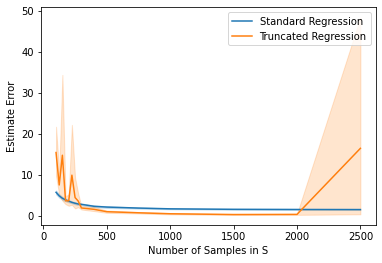

In [14]:
ax = sns.lineplot(data=logs, x='num_samples', y='ols_epsilon', label='Standard Regression')
ax = sns.lineplot(data=logs, x='num_samples', y='unknown_epsilon', label='Truncated Regression')
ax.set(xlabel='Number of Samples in S', ylabel='Estimate Error')

In [52]:
unknown_logs = unknown_logs[unknown_logs['num_samples'] > 150]
ols_logs = ols_logs[ols_logs['num_samples'] > 150]

[Text(0.5, 0, 'Number of Samples in S'), Text(0, 0.5, 'Estimate Error')]

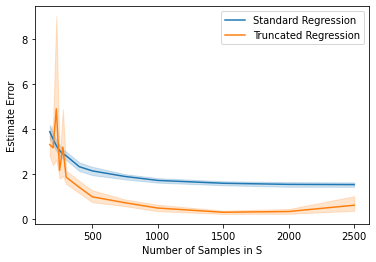

In [53]:
ax =sns.lineplot(data=ols_logs, x='num_samples', y='ols_epsilon', label='Standard Regression')
ax = sns.lineplot(data=unknown_logs, x='num_samples', y='unknown_epsilon', label='Truncated Regression')
ax.set(xlabel='Number of Samples in S', ylabel='Estimate Error')

In [56]:
len(logs) / len(samples)

20.5

In [30]:
len(logs) / len(samples)

20.5

In [128]:
(scaled_kinterval(stand_y_trunc) != 1).nonzero(as_tuple=False)

tensor([], size=(0, 2), dtype=torch.int64)

In [142]:
ols_var

tensor([[6.6700]])

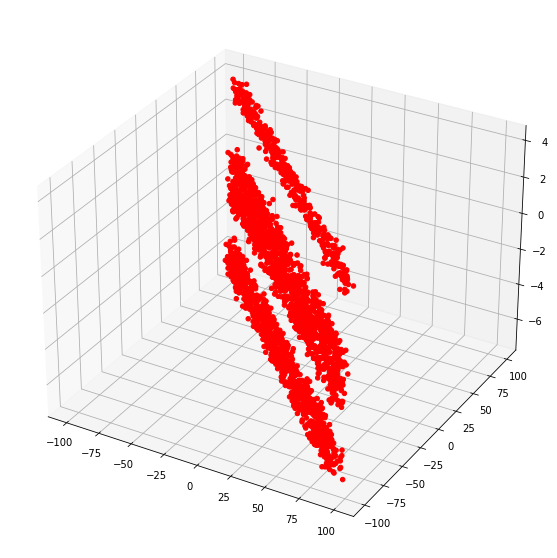

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

# ax.scatter3D(X[:,0], X[:,1], noised, color="blue", alpha=.01)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=1.0)

# ax.view_init(10, -150)

In [105]:
X = np.arange(-100, 100, 1)
Y = np.arange(-100, 100, 1)
X, Y = np.meshgrid(X, Y)

pred = Tensor([])
for i in range(X.shape[0]): 
    inp = Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1))
    pred = ch.cat([pred, gt(inp)], dim=1)

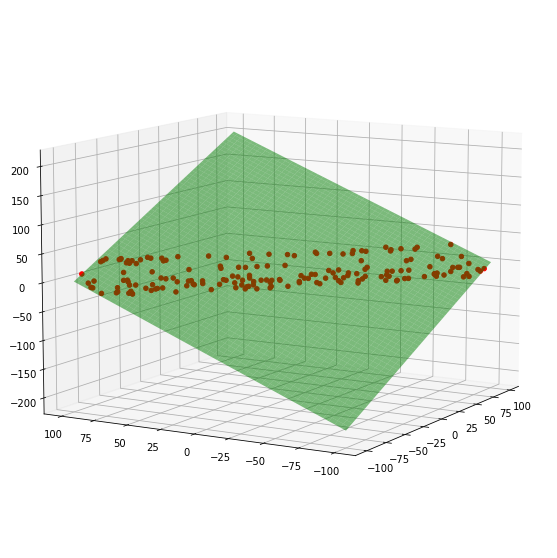

In [109]:
with ch.no_grad():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=1.0)
    ax.plot_surface(X, Y, pred.numpy(), color='green', alpha=.5)
    
ax.view_init(10, -150)

In [107]:
s

175

In [89]:
Y.shape

(16, 16)

In [ ]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="grey", alpha=.5)
with ch.no_grad():
    X = np.arange(-2, 2, 0.25)
    Y = np.arange(-2, 2, 0.25)
    X, Y = np.meshgrid(X, Y)

    # plot predicted regression
    pred = Tensor([results(Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).float()).numpy().flatten() for i in range(X.shape[0])]).numpy()
    ax.plot_surface(X, Y, pred, color="green", alpha=.15)
    
    # plot empirical regression - obtained via OLS
    emp = np.array([S.dataset.reg.predict(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).flatten() for i in range(X.shape[0])])
    ax.plot_surface(X, Y, emp, color="red", alpha=.15)
    
    # plot actual regression - based off of synthetic data
    act = ch.cat([(Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).float().mm(W) + W0) for i in range(X.shape[0])], 1).numpy()
    ax.plot_surface(X, Y, act, color="blue", alpha=.15)
    


red_patch = mpatches.Patch(color='red', label='OLS')

green_patch = mpatches.Patch(color='green', label='delphi')
blue_patch = mpatches.Patch(color='blue', label="actual")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="center right")

ax.view_init(10, -150)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [44]:
x = y = np.arange(-9.5, 15.0, 0.15)
np.meshgrid(x, y)[0].shape

(164, 164)

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

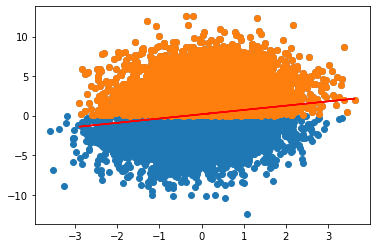

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])

In [100]:
samples

[100,
 125,
 150,
 175,
 200,
 225,
 250,
 275,
 300,
 400,
 500,
 750,
 1000,
 1500,
 2000,
 2500]

In [103]:
y = []
for s in samples: 
    y.append(1/(s**(.25)))

In [104]:
plt.plot(samples, y)

In [255]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 25, 1

# distribution for generating feature vectors
dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
dist = Uniform(-10, 10)
samples = [100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500, 750, 1000, 1500, 2000, 2500]
intervals = [(-20, -5), (-3, 0), (1, 7)]
phi = oracle.KIntervalUnion(intervals)
# phi = oracle.Left(0)
noise_var = Tensor([10.0])

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(ch.ones(k, d))
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None

In [256]:
x_ = dist.sample(ch.Size([s, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([s]))
new_noised = gt(x_) + ch.sqrt(noise_var) * ch.randn(s, 1)
# add noise to ground-truth pedictions
# truncate based off of the standardized data
indices = phi(new_noised).flatten().nonzero(as_tuple=False).flatten()
y_trunc, x_trunc = new_noised[indices], x_[indices]

In [257]:
y_trunc.size(0) / new_noised.size(0)

0.292

(array([87., 81., 60., 57., 90.]),
 array([-19.925    , -14.548204 ,  -9.171409 ,  -3.7946134,   1.5821819,
          6.958977 ], dtype=float32),
 <BarContainer object of 5 artists>)

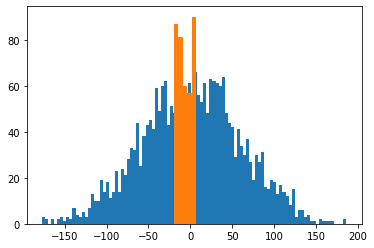

In [246]:
import matplotlib.pyplot as plt

plt.hist(new_noised.detach().numpy(), bins=100)
plt.hist(y_trunc.detach().numpy() , bins=5)

In [228]:
y_trunc.size(0) / new_noised.size(0)

0.5068

In [218]:
new_noised.size()

torch.Size([2500, 1])

In [229]:
y_trunc.size()

torch.Size([1267, 1])